In [1]:
import os
import sys
import json
from json import JSONDecodeError
import csv
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from nltk.translate import bleu_score
from scipy.stats import ttest_ind
from scipy.stats import linregress
from tqdm import tqdm
import numpy as np
from pyrouge import Rouge155
%matplotlib inline

In [2]:
from utils import load_vocab, decode_caption, load_caption, rrv_votes, load_annotations, print_image

In [3]:
vocab = load_vocab(dict_file = "../outputs/vocab/5000/coco2014_vocab.json")
image_id_to_index, index_to_image_id, annotations_dict = load_annotations(annotations_dir="../../annotations/", 
                                                                          annotations_file='captions_val2014.json',
                                                                         map_file = "../outputs/val_image_id_to_idx.csv")
print("Processed {} images".format(len(image_id_to_index)))
print("Processed {} images".format(len(annotations_dict.keys())))

idx_to_word
word_to_idx
Loaded dictionary...
Dictionary size: 5004
Error proccessing image_id: image_index
Skipping file person_keypoints_train2014.json
Skipping file instances_train2014.json
Skipping file instances_val2014.json
Skipping file person_keypoints_val2014.json
Processed 40504 images
Processed 40504 images


In [4]:
total_length = 0
total_captions = 0
for image in annotations_dict:
    for l in annotations_dict[image]:
        total_captions += 1
        total_length += len(' '.join(l))
avg_length = total_length / total_captions
print("Average caption length in annotated images: {}".format(avg_length))

Average caption length in annotated images: 51.56967047282561


In [5]:
image_id = 37116

Total prob:  0.052478062676797985
0.00556: ['a', 'man', 'riding', 'skis', 'down', 'a', 'snow', 'covered', 'slope']
0.00304: ['a', 'group', 'of', 'people', 'riding', 'skis', 'down', 'a', 'snow', 'covered', 'slope']
0.00290: ['a', 'couple', 'of', 'people', 'riding', 'skis', 'down', 'a', 'snow', 'covered', 'slope']
0.00243: ['a', 'couple', 'of', 'people', 'standing', 'on', 'top', 'of', 'a', 'snow', 'covered', 'slope']
0.00221: ['a', 'person', 'riding', 'skis', 'on', 'a', 'snowy', 'surface']
0.00179: ['a', 'group', 'of', 'people', 'standing', 'on', 'top', 'of', 'a', 'snow', 'covered', 'slope']
0.00169: ['a', 'couple', 'of', 'people', 'on', 'skis', 'in', 'the', 'snow']
0.00166: ['a', 'group', 'of', 'people', 'on', 'skis', 'in', 'the', 'snow']
0.00135: ['a', 'person', 'riding', 'skis', 'down', 'a', 'snow', 'covered', 'slope']
0.00124: ['a', 'man', 'riding', 'a', 'snowboard', 'down', 'a', 'snow', 'covered', 'slope']


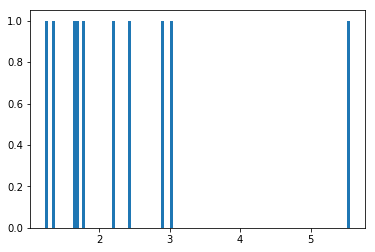

In [6]:
probabilities = []
captions = load_caption(image_id)
print("Total prob: ", captions['total_prob'])
for p, caption in list(zip(captions['probabilities'],captions['captions']))[:10]:
    print("{:.5f}: {}".format(p, decode_caption(caption, vocab)))
    probabilities.append(p * 1000)
plt.hist(probabilities, bins=100);

a man riding skis down a snow covered slope
a skier on a snow covered hill facing some snow covered hills
a cross country skier is stopped and looking at the vast terrain ahead
person dressed in green skiing down a mountain
a person is cross country skiing in the mountains


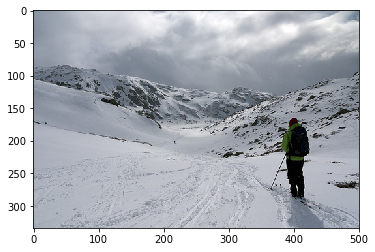

In [7]:
print_image(image_id)

for l in annotations_dict[image_id]:
    print(' '.join(l))

In [8]:
election_winners, winner_scores = rrv_votes(captions)
print(election_winners)

[array([  1,   4,  78,   6,  20,  47, 158,  33,   7,  70,   6,   4,  75,
       137, 235,   2]), array([  1,   4,  35,   6,  20,  47, 158,  33,   7,  70,   6,   4,  75,
       137, 235,   2]), array([  1,   4,  78,   6,  20,  47, 158,   5,  34,   6,   4,  75, 137,
       235,   2]), array([  1,   4,  35,   6,  20,  47, 158,   5,  34,   6,   4,  75, 137,
       235,   2]), array([  1,   4,  35,   6,  20,  47, 158,  33,   4,  75, 137, 270, 235,
         2])]


# Probability covered by beams

In [9]:
total_probs = []

images = os.listdir('../outputs/beam_captions')
for image in images:
    try:
        caption_object = load_caption(image)
        total_probs.append(caption_object['total_prob'])
    except JSONDecodeError:
        print("Error on ", image)
print("Images considered: {}".format(len(images)))
print("Average probability covered by beams: {}".format(sum(total_probs) / len(images)))

Images considered: 40503
Average probability covered by beams: 0.03439713872610978


17713


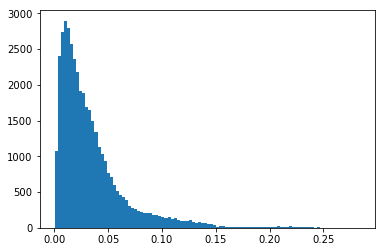

In [10]:
plt.hist(total_probs, bins=100);
print(np.argmax(total_probs))

# Compute vote captions

In [11]:
# beam_lengths = []
# vote_lengths = []
# vote_captions = {}
# images = os.listdir("../outputs/beam_captions/")
# print("To process: {}".format(len(images)))
# for i, image in enumerate(tqdm(images)):
#     image_id = int(image.split('.')[0])
#     try:
#         caption_object = load_caption(image_id)
#         beam_caption = decode_caption(caption_object['captions'][0])
#         vote_captions[image_id] = rrv_votes(caption_object, num_winners=5)
#         vote_lengths.append(len(decode_caption(vote_captions[image_id][0][0])))
#         beam_lengths.append(len(beam_caption))
#     except JSONDecodeError:
#         print("Error on ", image_id)
        
# with open('vote_captions.pickle', 'wb') as handle:
#     pickle.dump(vote_captions, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('vote_captions.backup.pickle', 'rb') as handle:
    vote_captions = pickle.load(handle)

In [12]:
# vote_captions_multiplicity = {}
# images = os.listdir("../outputs/beam_captions/")
# print("To process: {}".format(len(images)))
# for i, image in enumerate(tqdm(images)):
#     image_id = int(image.split('.')[0])
#     try:
#         caption_object = load_caption(image_id)
#         vote_captions_multiplicity[image_id] = rrv_votes_multiplicity(caption_object, num_winners=5)
#     except JSONDecodeError:
#         print("Error on ", image_id)
    
# with open('vote_captions_multiplicity.pickle', 'wb') as handle:
#     pickle.dump(vote_captions_multiplicity, handle, protocol=pickle.HIGHEST_PROTOCOL)


with open('vote_captions_multiplicity.backup.pickle', 'rb') as handle:
    vote_captions_multiplicity = pickle.load(handle)


In [13]:
# vote_captions_bigram = {}
# images = os.listdir("../outputs/beam_captions/")
# print("To process: {}".format(len(images)))
# for i, image in enumerate(tqdm(images)):
#     image_id = int(image.split('.')[0])
#     try:
#         caption_object = load_caption(image_id)
#         vote_captions_bigram[image_id] = rrv_votes(caption_object, num_winners=5, similarity='bigram')
#     except JSONDecodeError:
#         print("Error on ", image_id)
    
# with open('vote_captions_bigram.pickle', 'wb') as handle:
#     pickle.dump(vote_captions_bigram, handle, protocol=pickle.HIGHEST_PROTOCOL)


# with open('vote_captions_bigram.backup.pickle', 'rb') as handle:
#     vote_captions_multiplicity = pickle.load(handle)

  0%|          | 2/40503 [00:00<2:08:58,  5.23it/s]

To process: 40503


100%|██████████| 40503/40503 [2:15:44<00:00,  5.53it/s]  


In [14]:
# vote_captions_bleu = {}
# images = os.listdir("../outputs/beam_captions/")
# print("To process: {}".format(len(images)))
# for i, image in enumerate(tqdm(images)):
#     image_id = int(image.split('.')[0])
#     try:
#         caption_object = load_caption(image_id)
#         vote_captions_bleu[image_id] = rrv_votes_bleu(caption_object, num_winners=5)
#     except JSONDecodeError:
#         print("Error on ", image_id)
    
# with open('vote_captions_bleu.pickle', 'wb') as handle:
#     pickle.dump(vote_captions_bleu, handle, protocol=pickle.HIGHEST_PROTOCOL)


# # with open('vote_captions_bleu.backup.pickle', 'rb') as handle:
#     vote_captions_bleu = pickle.load(handle)


# Evaluation using BLEU

Correct annotations:
a person on a surf board riding a wave
the surfer is getting ready to ride the wave
a person riding waves in a body of water
a man surfing the waves on a surfboard in the ocean 
surfer riding large breaking wave on open ocean

Beam captions
a man riding a wave on top of a surfboard
a man riding a surfboard on top of a wave
a person riding a surf board on a wave
a person riding a wave on top of a surfboard
a man riding a surfboard on a wave in the ocean

Voted captions
a man riding a surfboard on top of a wave in the ocean
a man riding a wave on top of a surfboard in the ocean
a man riding a white surfboard on top of a wave
a man riding a wave on top of a white surfboard
a man riding on top of a wave in the ocean

Corpus bleu: 1.0
Beam bleu: 0.5
Vote bleu: 0.45258880078905583


/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


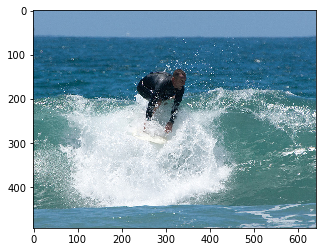

In [22]:
image_id = 16871
print_image(image_id)

print("Correct annotations:")
for cap in annotations_dict[image_id]:
    print(' '.join(cap))
 
print()
print("Beam captions")
beam_captions = load_caption(image_id)['captions']
beam_captions = [decode_caption(cap) for cap in beam_captions[:5]]
for cap in beam_captions:
    print(' '.join(cap))

print()
print("Voted captions")
voted_captions = [decode_caption(cap) for cap in vote_captions[image_id][0]]
for vote in voted_captions:
    print(' '.join(vote))
    
print()
print("Corpus bleu:", bleu_score.sentence_bleu(annotations_dict[image_id], annotations_dict[image_id][0]))
print("Beam bleu:", bleu_score.sentence_bleu(annotations_dict[image_id], beam_captions[0]))
print("Vote bleu:", bleu_score.sentence_bleu(annotations_dict[image_id], voted_captions[0]))



In [17]:
annotation_captions = []
best_voted_caption = []
best_voted_multiplicty_caption = []
best_voted_bigram_caption = []
best_beam_caption = []
for image_id in tqdm(vote_captions):
    annotation_captions.append(annotations_dict[image_id])
    best_voted_caption.append(decode_caption(vote_captions[image_id][0][0], vocab))
    best_voted_multiplicty_caption.append(decode_caption(vote_captions_multiplicity[image_id][0][0], vocab))
    best_voted_bigram_caption.append(decode_caption(vote_captions_bigram[image_id][0][0], vocab))
    best_beam_caption.append(decode_caption(load_caption(image_id)['captions'][0], vocab))

100%|██████████| 40503/40503 [00:32<00:00, 1254.09it/s]


In [18]:
total = 0
for beam_caption in best_beam_caption:
    if len(beam_caption) == 0:
        total += 1
print(total)

123


In [22]:
beam_bleu_1 = bleu_score.corpus_bleu(annotation_captions, best_beam_caption, weights=[1])
vote_blue_1 = bleu_score.corpus_bleu(annotation_captions, best_voted_caption, weights=[1])
vote_multiplicity_blue_1 = bleu_score.corpus_bleu(annotation_captions, best_voted_multiplicty_caption, weights=[1])
vote_bigram_blue_1 = bleu_score.corpus_bleu(annotation_captions, best_voted_bigram_caption, weights=[1])
print("Beam bleu-1 score: {:.4f}".format(beam_bleu_1))
print("Voted bleu-1 score: {:.4f}".format(vote_blue_1))
print("Voted bigram bleu-1 score: {:.4f}".format(vote_bigram_blue_1))
print("Voted multiplicity bleu-1 score: {:.4f}".format(vote_multiplicity_blue_1))

Beam bleu-1 score: 0.6618
Voted bleu-1 score: 0.6636
Voted bigram bleu-1 score: 0.6720
Voted multiplicity bleu-1 score: 0.6646


In [23]:
beam_bleu_4 = bleu_score.corpus_bleu(annotation_captions, best_beam_caption)
vote_blue_4 = bleu_score.corpus_bleu(annotation_captions, best_voted_caption)
vote_multiplicity_blue_4 = bleu_score.corpus_bleu(annotation_captions, best_voted_multiplicty_caption)
vote_bigram_blue_4 = bleu_score.corpus_bleu(annotation_captions, best_voted_bigram_caption)
print("Beam bleu-4 score: {:.4f}".format(beam_bleu_4))
print("Voted bleu-4 score: {:.4f}".format(vote_blue_4))
print("Voted bigram bleu-4 score: {:.4f}".format(vote_bigram_blue_4))
print("Voted multiplicity bleu-4 score: {:.4f}".format(vote_multiplicity_blue_4))

Beam bleu-4 score: 0.2631
Voted bleu-4 score: 0.2460
Voted bigram bleu-4 score: 0.2713
Voted multiplicity bleu-4 score: 0.2458


In [26]:
vote_bleus = []
beam_bleus = []
vote_multiplicity_bleus = []
image_ids = []
for image_id in tqdm(vote_captions):
    annotations = annotations_dict[image_id]
    vote_bleu = bleu_score.sentence_bleu(annotations, decode_caption(vote_captions[image_id][0][0]))
    beam_bleu = bleu_score.sentence_bleu(annotations, decode_caption(load_caption(image_id)['captions'][0]))
    vote_multiplicity_bleu = bleu_score.sentence_bleu(annotations, decode_caption(vote_captions_multiplicity[image_id][0][0]))
    
    image_ids.append(image_id)
    vote_bleus.append(vote_bleu)
    beam_bleus.append(beam_bleu)
    vote_multiplicity_bleus.append(vote_multiplicity_bleu)
    
vote_bleus = np.array(vote_bleus)
beam_bleus = np.array(beam_bleus)
vote_multiplicity_bleus = np.array(vote_multiplicity_bleus)
image_ids = np.array(image_ids)


  0%|          | 0/40503 [00:00<?, ?it/s]/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)

100%|██████████| 40503/40503 [01:58<00:00, 341.72it/s]


In [27]:
diff_vote = vote_bleus - beam_bleus
sort_order = np.argsort(diff_vote)

Beam bleu 1.000: a herd of sheep grazing on a lush green field
Vote bleu 0.237: a herd of sheep standing on top of a green grass covered field
Annotations:
some white sheep and a black and white dog and grass
a sheep being herded by a dog in the grass
a bunch of sheep being herded by a dog 
a sheep dog herding sheep through a grass field
a herd of sheep grazing on a lush green field
15820


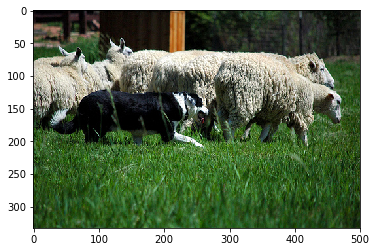


Beam bleu 1.000: a boat that is sitting in the water
Vote bleu 0.269: a boat on a body of water with a city in the background
Annotations:
a boat that is sitting in the water
a motor boat is sailing near a dock with other boats
an assortment of homes and watercraft dot a picturesque harbor
a small boat in a large body of water
several boats that are anchored in a body of water
31384


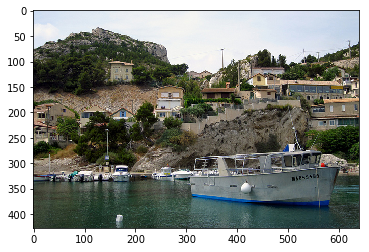


Beam bleu 1.000: a close up of a street sign with a sky background
Vote bleu 0.271: a couple of street signs sitting on top of a stop sign
Annotations:
a sign calls out public parking beneath a street marker
three black and white street signs with hazy sky in background
a close up of a street sign with a sky background
sign post at intersection with street and public parking signs
three signs sit on top of a street pole 
14694


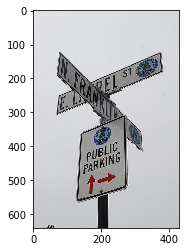


Beam bleu 1.000: a man riding skis down a snow covered slope
Vote bleu 0.274: a group of people riding skis down the side of a snow covered slope
Annotations:
a person on some skis in the snow
a man riding skis down a snow covered slope
a person skiing on snow with others behind
a man is skiing down a hill alone 
a skier goes airborne while skiing downhill on a mountain
7252


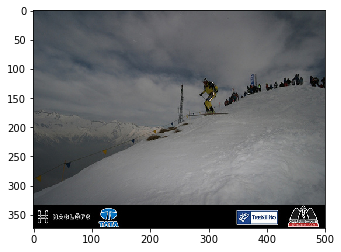


Beam bleu 1.000: a man riding skis down a snow covered slope
Vote bleu 0.274: a couple of people riding skis down the side of a snow covered slope
Annotations:
a man riding skis down a snow covered slope
a skier on a snow covered hill facing some snow covered hills
a cross country skier is stopped and looking at the vast terrain ahead
person dressed in green skiing down a mountain
a person is cross country skiing in the mountains
37116


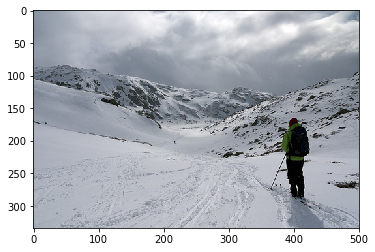


Beam bleu 1.000: a motorcycle parked in front of a brick building
Vote bleu 0.280: a motorcycle parked on the side of a street next to a building
Annotations:
a motorcycle parked in front of a house
the motorcycle is parked on the sidewalk near a building
a motorcycle parked in front of a brick building
a motorcycle parked outside a building on the walkway
a motorcycle parked on a cobblestone sidewalk in front of an old brick building
28472


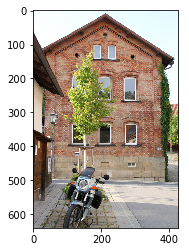


Beam bleu 1.000: a man standing in a kitchen preparing food
Vote bleu 0.285: a man standing in front of a kitchen counter preparing food
Annotations:
a man standing in a kitchen preparing food
a man that is in a big kitchen
an asian man in a restaurant kitchen 
a black and white image of a man in glasses working in a kitchen
the chef in the black and white photo is smiling in the kitchen
5598


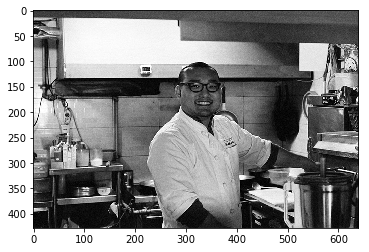


Beam bleu 1.000: a bird that is flying in the sky
Vote bleu 0.291: a couple of birds that are flying in the sky
Annotations:
a bird flying thru the sky with mountains in the background
a bird with a large sing span flying over trees
a bird in flights with mountains in the background
a bird soaring through a foggy sky over a snow covered mountain
a bird that is flying in the sky
2313


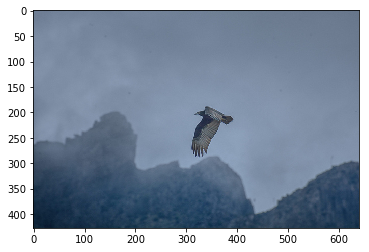


Beam bleu 1.000: a blender that is sitting on a counter
Vote bleu 0.298: a blender sitting on top of a counter in a kitchen
Annotations:
a blender is shown on a kitchen counter next to a sink
a blender sits on a counter top unplugged
a black blender sitting on a counter unplugged
a blender sitting on a counter near a sink
a blender that is sitting on a kitchen counter
12137


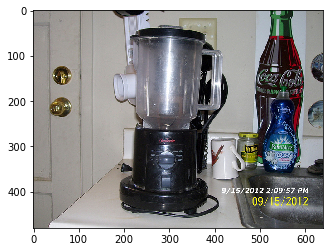


Beam bleu 1.000: a man preparing food inside of a kitchen
Vote bleu 0.298: a person in a kitchen preparing food inside of an oven
Annotations:
the man has dipped something in the bowl
a man places an object into a bowl sitting on the counter
a man preparing food inside of a kitchen
a man holding a doughnut over a bowl
a man is cooking desserts in a green kitchen with a green bowl 
15418


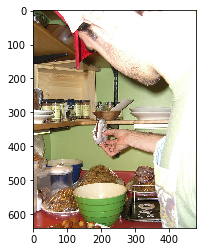

In [32]:
for i in range(10):
    image_id = image_ids[sort_order][i]
    beam_caption = ' '.join(decode_caption(load_caption(image_id)['captions'][0]))
    vote_caption = ' '.join(decode_caption(vote_captions[image_id][0][0]))
    beam_bleu = beam_bleus[sort_order][i]
    vote_bleu = vote_bleus[sort_order][i]
    print("Beam bleu {:.3f}: {}".format(beam_bleu, beam_caption))
    print("Vote bleu {:.3f}: {}".format(vote_bleu, vote_caption))
    print("Annotations:")
    for annotation in annotations_dict[image_id]:
        print(' '.join(annotation))
    print(image_id)
    print_image(image_id)
    plt.show()
    plt.figure()
    print()

Beam bleu 0.000: the kitchen is clean and ready to
Vote bleu 0.760: a kitchen with stainless steel appliances and lots of
Annotations:
a luggage carousel at an airport surrounded by luggage
an airport baggage claim station with patrons grabbing their luggage
a metallic baggage claim track at an a airport
people moving around a luggage retrieval conveyor belt
blurry picture of people in an airport near baggage claim


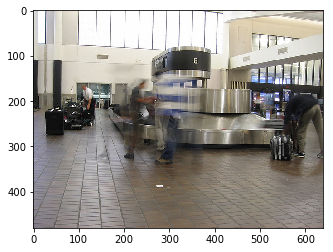


Beam bleu 0.351: a group of people sitting on top of a wooden bench
Vote bleu 1.000: a group of people that are sitting on a bench
Annotations:
a group of people that are sitting on a log
the group of three friends are sitting on a fallen tree in the woods
the young adults rest while playing frisbee golf
three people sitting on a bench in the woods
three friends sitting on a log making signing hand gestures 


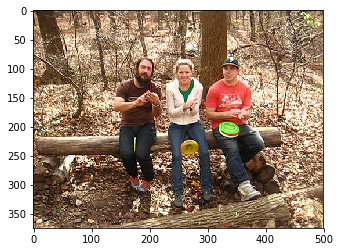


Beam bleu 0.366: a man holding a tennis racquet on a tennis court
Vote bleu 1.000: a man standing on top of a tennis court holding a racquet
Annotations:
a tennis player with a racket on a court
a man wearing his hat backward with a tennis racket and ball in his hand
a man on a tennis court holding a racquet
a man standing on a tennis court whil holding a ball and racket 
a man standing on top of a tennis court holding a racquet


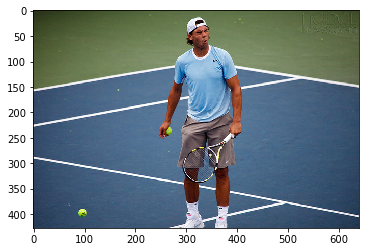


Beam bleu 0.338: a cow that is standing in the grass
Vote bleu 0.962: a couple of cows that are standing in a field
Annotations:
a herd of cows standing on top of a field
a couple of cows are standing in a field
a group of cows are standing in the grass together
a few cows standing in the grass near each other
a group of cows that are standing in the grass


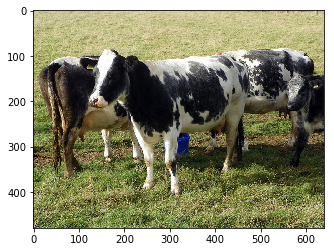


Beam bleu 0.331: a man holding a tennis racquet on a tennis court
Vote bleu 0.946: a man standing on top of a tennis court holding a racquet
Annotations:
a young man standing on top of a tennis court holding a racquet
a tennis player poses racket in his right hand left arm behind him
male tennis player delivery service during a game
a man that is on a tennis court with a racket
tennis player and white outfit swinging his racket on the court 


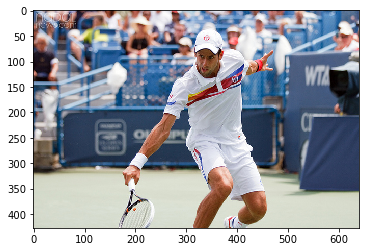


Beam bleu 0.050: an orange
Vote bleu 0.664: a close up of an orange and a 
Annotations:
looking down on a stony surface shows a bowl with an orange in it and what looks like a large piece of red plastic
a piece of orange in a bowl next to a concrete edge 
cement ledge with orange in bowl and red plastic bag below 
there is an orange in the cup and a bag in the water
an orange is sitting in a blue bowl


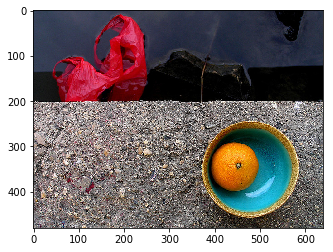


Beam bleu 0.393: a man holding a tennis racquet on a tennis court
Vote bleu 1.000: a man standing on top of a tennis court holding a racquet
Annotations:
a man standing on top of a tennis court holding a racquet
a tennis player is waiting to compete on a tennis court
a person that is wearing a visor and hold a tennis racket 
a man stands on a tennis court ready to play
a man in shorts and a white visor in a tennis stance


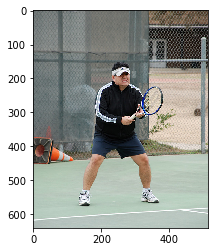


Beam bleu 0.244: a couple of people standing on top of a snow covered slope
Vote bleu 0.841: a couple of people that are standing on skis in the snow
Annotations:
a snowboarder poses next to two skiers on the mountain
four people are skiing on a snowy mountain
skiers and snowboarders on top of a mountain
snowboarder and skiers on a bright sunny day
a snowboarder and skiers on a snowy slope


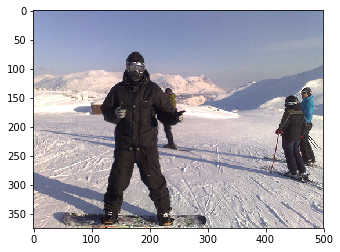


Beam bleu 0.330: a man standing on a beach holding a frisbee
Vote bleu 0.915: a man standing on the beach playing with a frisbee
Annotations:
two woman are playing paddle board on a beach 
two woman on a beach holding paddles for a game
two women on a cliff side beach hold paddles and are in the midst of bouncing a ball between them 
two young women playing a game of frisbee on a beach
two women who are holding discs on a beach


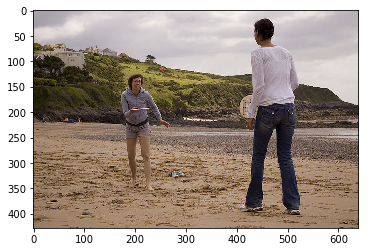


Beam bleu 0.427: a laptop computer sitting on top of a wooden desk
Vote bleu 1.000: a black and white photo of a living room with a
Annotations:
a room filled with lots of furniture and a table
a den with a couch table radio and a mirror
a small living room with antique furniture and old wallpaper
a black and white photo of a living room with a couch and a table 
a empty living room that has a table in the center


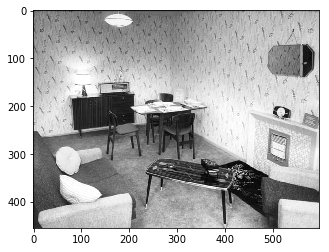

In [31]:
reverse_sort_order = sort_order[::-1]
count = 0
i = 0
while True:
    i += 1
    image_id = image_ids[reverse_sort_order][i]
#     print(image_id)
    vote_caption = ' '.join(decode_caption(vote_captions[image_id][0][0]))
    beam_caption = ' '.join(decode_caption(load_caption(image_id)['captions'][0]))
    if len(beam_caption) == 0:
        continue
    count += 1
    beam_bleu = beam_bleus[reverse_sort_order][i]
    vote_bleu = vote_bleus[reverse_sort_order][i]
    print("Beam bleu {:.3f}: {}".format(beam_bleu, beam_caption))
    print("Vote bleu {:.3f}: {}".format(vote_bleu, vote_caption))
    print("Annotations:")
    for annotation in annotations_dict[image_id]:
        print(' '.join(annotation))
    print_image(image_id)
    plt.show()
    plt.figure()
    print()
    if count == 10:
        break
    

# Evaluation using ROUGE

In [25]:
def write_caption_to_file(file_path, caption):
    try:
        with open(file_path,'x') as file:
            file.write(' '.join(c))
    except FileExistsError:
        pass
#         print("Skipping {}".format(image_id))

In [27]:
# Save captions for rouge evaluation
letters = ['A', 'B', 'C', 'D', 'E', 'F']

annotations_dir = '../outputs/annotations_txt/model/'
beam_dir = '../outputs/annotations_txt/beam/'
vote_dir = '../outputs/annotations_txt/vote_unigram/'
vote_precision_dir = '../outputs/annotations_txt/vote_unigram_precision/'


for image_id in tqdm(vote_captions):
    file_path = "{}{}.{}.txt"
    for l, c in zip(letters, annotations_dict[image_id]):
        write_caption_to_file(file_path.format(annotations_dir, l, image_id), ' '.join(c))
   
    file_path = "{}{}.txt"
    c = decode_caption(vote_captions[image_id][0][0])
    write_caption_to_file(file_path.format(vote_dir, image_id), ' '.join(c))
   
    c = decode_caption(vote_captions_multiplicity[image_id][0][0])
    write_caption_to_file(file_path.format(vote_precision_dir, image_id), ' '.join(c))
    
    c = decode_caption(load_caption(image_id)['captions'][0])
    write_caption_to_file(file_path.format(beam_dir, image_id), ' '.join(c))

100%|██████████| 40503/40503 [00:59<00:00, 685.52it/s]


In [28]:
from pythonrouge.pythonrouge import Pythonrouge

# system summary(predict) & reference summary
summary = [[" Tokyo is the one of the biggest city in the world."]]
reference = [[["The capital of Japan, Tokyo, is the center of Japanese economy."]]]

# initialize setting of ROUGE to eval ROUGE-1, 2, SU4
# if you evaluate ROUGE by sentence list as above, set summary_file_exist=False
# if recall_only=True, you can get recall scores of ROUGE
rouge = Pythonrouge(summary_file_exist=False,
                    summary=summary, reference=reference,
                    n_gram=2, ROUGE_SU4=True, ROUGE_L=False,
                    recall_only=True, stemming=True, stopwords=True,
                    word_level=True, length_limit=True, length=50,
                    use_cf=False, cf=95, scoring_formula='average',
                    resampling=True, samples=1000, favor=True, p=0.5)
score = rouge.calc_score()
print(score)

CalledProcessError: Command '['perl', '/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/pythonrouge/RELEASE-1.5.5/ROUGE-1.5.5.pl', '-e', '/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/pythonrouge/RELEASE-1.5.5/data', '-a', '-n', '2', '-2', '4', '-u', '-x', '-l', '50', '-m', '-s', '-f', 'A', '-r', '1000', '-p', '0.5', '/tmp/tmpk9knr19x/setting.xml']' returned non-zero exit status 79

In [30]:
r = Rouge155('/Users/sebastian/Development/summarizer/rouge/')
r.system_dir = beam_dir
r.model_dir = annotations_dir

r.system_filename_pattern = '(\d+).txt'
r.model_filename_pattern = '[A-Z].#ID#.txt'

output = r.convert_and_evaluate()
print(output)
output_dict = r.output_to_dict(output)

2018-05-03 21:10:55,366 [MainThread  ] [INFO ]  Set ROUGE home directory to /Users/sebastian/Development/summarizer/rouge/.
2018-05-03 21:10:55,371 [MainThread  ] [INFO ]  Writing summaries.
2018-05-03 21:10:55,374 [MainThread  ] [INFO ]  Processing summaries. Saving system files to /var/folders/vy/3r807g6j007djvszt1w6n5t80000gn/T/tmpunh77ej0/system and model files to /var/folders/vy/3r807g6j007djvszt1w6n5t80000gn/T/tmpunh77ej0/model.
2018-05-03 21:10:55,375 [MainThread  ] [INFO ]  Processing files in ../outputs/annotations_txt/beam/.
2018-05-03 21:10:55,459 [MainThread  ] [INFO ]  Processing 27869.txt.
2018-05-03 21:10:55,462 [MainThread  ] [INFO ]  Processing 11303.txt.
2018-05-03 21:10:55,464 [MainThread  ] [INFO ]  Processing 3644.txt.
2018-05-03 21:10:55,467 [MainThread  ] [INFO ]  Processing 38949.txt.
2018-05-03 21:10:55,468 [MainThread  ] [INFO ]  Processing 19987.txt.
2018-05-03 21:10:55,471 [MainThread  ] [INFO ]  Processing 36964.txt.
2018-05-03 21:10:55,473 [MainThread  ] [

2018-05-03 21:10:55,672 [MainThread  ] [INFO ]  Processing 19005.txt.
2018-05-03 21:10:55,674 [MainThread  ] [INFO ]  Processing 7378.txt.
2018-05-03 21:10:55,676 [MainThread  ] [INFO ]  Processing 22093.txt.
2018-05-03 21:10:55,679 [MainThread  ] [INFO ]  Processing 12150.txt.
2018-05-03 21:10:55,680 [MainThread  ] [INFO ]  Processing 34829.txt.
2018-05-03 21:10:55,682 [MainThread  ] [INFO ]  Processing 32280.txt.
2018-05-03 21:10:55,684 [MainThread  ] [INFO ]  Processing 1709.txt.
2018-05-03 21:10:55,687 [MainThread  ] [INFO ]  Processing 25924.txt.
2018-05-03 21:10:55,688 [MainThread  ] [INFO ]  Processing 6066.txt.
2018-05-03 21:10:55,690 [MainThread  ] [INFO ]  Processing 14521.txt.
2018-05-03 21:10:55,692 [MainThread  ] [INFO ]  Processing 9355.txt.
2018-05-03 21:10:55,694 [MainThread  ] [INFO ]  Processing 22087.txt.
2018-05-03 21:10:55,695 [MainThread  ] [INFO ]  Processing 12144.txt.
2018-05-03 21:10:55,697 [MainThread  ] [INFO ]  Processing 32294.txt.
2018-05-03 21:10:55,698 

2018-05-03 21:10:55,869 [MainThread  ] [INFO ]  Processing 19788.txt.
2018-05-03 21:10:55,870 [MainThread  ] [INFO ]  Processing 39458.txt.
2018-05-03 21:10:55,872 [MainThread  ] [INFO ]  Processing 21217.txt.
2018-05-03 21:10:55,874 [MainThread  ] [INFO ]  Processing 26578.txt.
2018-05-03 21:10:55,875 [MainThread  ] [INFO ]  Processing 31004.txt.
2018-05-03 21:10:55,877 [MainThread  ] [INFO ]  Processing 3693.txt.
2018-05-03 21:10:55,878 [MainThread  ] [INFO ]  Processing 6933.txt.
2018-05-03 21:10:55,880 [MainThread  ] [INFO ]  Processing 25071.txt.
2018-05-03 21:10:55,882 [MainThread  ] [INFO ]  Processing 35262.txt.
2018-05-03 21:10:55,883 [MainThread  ] [INFO ]  Processing 23400.txt.
2018-05-03 21:10:55,885 [MainThread  ] [INFO ]  Processing 12805.txt.
2018-05-03 21:10:55,886 [MainThread  ] [INFO ]  Processing 33613.txt.
2018-05-03 21:10:55,888 [MainThread  ] [INFO ]  Processing 1084.txt.
2018-05-03 21:10:55,890 [MainThread  ] [INFO ]  Processing 510.txt.
2018-05-03 21:10:55,892 [

2018-05-03 21:10:56,110 [MainThread  ] [INFO ]  Processing 32900.txt.
2018-05-03 21:10:56,112 [MainThread  ] [INFO ]  Processing 14079.txt.
2018-05-03 21:10:56,114 [MainThread  ] [INFO ]  Processing 38593.txt.
2018-05-03 21:10:56,115 [MainThread  ] [INFO ]  Processing 17570.txt.
2018-05-03 21:10:56,116 [MainThread  ] [INFO ]  Processing 18643.txt.
2018-05-03 21:10:56,118 [MainThread  ] [INFO ]  Processing 5037.txt.
2018-05-03 21:10:56,119 [MainThread  ] [INFO ]  Processing 26975.txt.
2018-05-03 21:10:56,121 [MainThread  ] [INFO ]  Processing 2758.txt.
2018-05-03 21:10:56,123 [MainThread  ] [INFO ]  Processing 39855.txt.
2018-05-03 21:10:56,125 [MainThread  ] [INFO ]  Processing 28780.txt.
2018-05-03 21:10:56,127 [MainThread  ] [INFO ]  Processing 3446.txt.
2018-05-03 21:10:56,129 [MainThread  ] [INFO ]  Processing 40428.txt.
2018-05-03 21:10:56,131 [MainThread  ] [INFO ]  Processing 11101.txt.
2018-05-03 21:10:56,133 [MainThread  ] [INFO ]  Processing 37878.txt.
2018-05-03 21:10:56,134

2018-05-03 21:10:56,330 [MainThread  ] [INFO ]  Processing 4467.txt.
2018-05-03 21:10:56,332 [MainThread  ] [INFO ]  Processing 16120.txt.
2018-05-03 21:10:56,334 [MainThread  ] [INFO ]  Processing 30859.txt.
2018-05-03 21:10:56,336 [MainThread  ] [INFO ]  Processing 3308.txt.
2018-05-03 21:10:56,339 [MainThread  ] [INFO ]  Processing 40366.txt.
2018-05-03 21:10:56,341 [MainThread  ] [INFO ]  Processing 10551.txt.
2018-05-03 21:10:56,344 [MainThread  ] [INFO ]  Processing 21954.txt.
2018-05-03 21:10:56,346 [MainThread  ] [INFO ]  Processing 2016.txt.
2018-05-03 21:10:56,348 [MainThread  ] [INFO ]  Processing 30681.txt.
2018-05-03 21:10:56,350 [MainThread  ] [INFO ]  Processing 5779.txt.
2018-05-03 21:10:56,352 [MainThread  ] [INFO ]  Processing 11897.txt.
2018-05-03 21:10:56,354 [MainThread  ] [INFO ]  Processing 20492.txt.
2018-05-03 21:10:56,358 [MainThread  ] [INFO ]  Processing 9143.txt.
2018-05-03 21:10:56,360 [MainThread  ] [INFO ]  Processing 14737.txt.
2018-05-03 21:10:56,362 [

2018-05-03 21:10:56,560 [MainThread  ] [INFO ]  Processing 34430.txt.
2018-05-03 21:10:56,561 [MainThread  ] [INFO ]  Processing 24623.txt.
2018-05-03 21:10:56,562 [MainThread  ] [INFO ]  Processing 33439.txt.
2018-05-03 21:10:56,564 [MainThread  ] [INFO ]  Processing 24145.txt.
2018-05-03 21:10:56,565 [MainThread  ] [INFO ]  Processing 7807.txt.
2018-05-03 21:10:56,567 [MainThread  ] [INFO ]  Processing 14086.txt.
2018-05-03 21:10:56,569 [MainThread  ] [INFO ]  Processing 34356.txt.
2018-05-03 21:10:56,572 [MainThread  ] [INFO ]  Processing 22534.txt.
2018-05-03 21:10:56,574 [MainThread  ] [INFO ]  Processing 15398.txt.
2018-05-03 21:10:56,576 [MainThread  ] [INFO ]  Processing 35048.txt.
2018-05-03 21:10:56,578 [MainThread  ] [INFO ]  Processing 13931.txt.
2018-05-03 21:10:56,580 [MainThread  ] [INFO ]  Processing 32727.txt.
2018-05-03 21:10:56,583 [MainThread  ] [INFO ]  Processing 26752.txt.
2018-05-03 21:10:56,584 [MainThread  ] [INFO ]  Processing 18864.txt.
2018-05-03 21:10:56,5

2018-05-03 21:10:56,788 [MainThread  ] [INFO ]  Processing 1457.txt.
2018-05-03 21:10:56,789 [MainThread  ] [INFO ]  Processing 6338.txt.
2018-05-03 21:10:56,792 [MainThread  ] [INFO ]  Processing 38395.txt.
2018-05-03 21:10:56,793 [MainThread  ] [INFO ]  Processing 17376.txt.
2018-05-03 21:10:56,795 [MainThread  ] [INFO ]  Processing 18045.txt.
2018-05-03 21:10:56,796 [MainThread  ] [INFO ]  Processing 5631.txt.
2018-05-03 21:10:56,797 [MainThread  ] [INFO ]  Processing 28186.txt.
2018-05-03 21:10:56,799 [MainThread  ] [INFO ]  Processing 10419.txt.
2018-05-03 21:10:56,800 [MainThread  ] [INFO ]  Processing 29298.txt.
2018-05-03 21:10:56,801 [MainThread  ] [INFO ]  Processing 3240.txt.
2018-05-03 21:10:56,804 [MainThread  ] [INFO ]  Processing 11707.txt.
2018-05-03 21:10:56,805 [MainThread  ] [INFO ]  Processing 30911.txt.
2018-05-03 21:10:56,807 [MainThread  ] [INFO ]  Processing 16068.txt.
2018-05-03 21:10:56,808 [MainThread  ] [INFO ]  Processing 15549.txt.
2018-05-03 21:10:56,809 

2018-05-03 21:10:56,997 [MainThread  ] [INFO ]  Processing 37071.txt.
2018-05-03 21:10:56,999 [MainThread  ] [INFO ]  Processing 2189.txt.
2018-05-03 21:10:57,001 [MainThread  ] [INFO ]  Processing 28151.txt.
2018-05-03 21:10:57,002 [MainThread  ] [INFO ]  Processing 27262.txt.
2018-05-03 21:10:57,004 [MainThread  ] [INFO ]  Processing 30078.txt.
2018-05-03 21:10:57,006 [MainThread  ] [INFO ]  Processing 28637.txt.
2018-05-03 21:10:57,008 [MainThread  ] [INFO ]  Processing 16901.txt.
2018-05-03 21:10:57,010 [MainThread  ] [INFO ]  Processing 27504.txt.
2018-05-03 21:10:57,011 [MainThread  ] [INFO ]  Processing 38424.txt.
2018-05-03 21:10:57,013 [MainThread  ] [INFO ]  Processing 5180.txt.
2018-05-03 21:10:57,014 [MainThread  ] [INFO ]  Processing 37717.txt.
2018-05-03 21:10:57,015 [MainThread  ] [INFO ]  Processing 21175.txt.
2018-05-03 21:10:57,018 [MainThread  ] [INFO ]  Processing 2837.txt.
2018-05-03 21:10:57,020 [MainThread  ] [INFO ]  Processing 36409.txt.
2018-05-03 21:10:57,022

2018-05-03 21:10:57,389 [MainThread  ] [INFO ]  Processing 16524.txt.
2018-05-03 21:10:57,390 [MainThread  ] [INFO ]  Processing 27921.txt.
2018-05-03 21:10:57,392 [MainThread  ] [INFO ]  Processing 19617.txt.
2018-05-03 21:10:57,394 [MainThread  ] [INFO ]  Processing 4063.txt.
2018-05-03 21:10:57,395 [MainThread  ] [INFO ]  Processing 16242.txt.
2018-05-03 21:10:57,397 [MainThread  ] [INFO ]  Processing 19171.txt.
2018-05-03 21:10:57,398 [MainThread  ] [INFO ]  Processing 36192.txt.
2018-05-03 21:10:57,399 [MainThread  ] [INFO ]  Processing 4705.txt.
2018-05-03 21:10:57,400 [MainThread  ] [INFO ]  Processing 20928.txt.
2018-05-03 21:10:57,402 [MainThread  ] [INFO ]  Processing 40004.txt.
2018-05-03 21:10:57,403 [MainThread  ] [INFO ]  Processing 26381.txt.
2018-05-03 21:10:57,405 [MainThread  ] [INFO ]  Processing 2374.txt.
2018-05-03 21:10:57,406 [MainThread  ] [INFO ]  Processing 10633.txt.
2018-05-03 21:10:57,408 [MainThread  ] [INFO ]  Processing 31825.txt.
2018-05-03 21:10:57,409

2018-05-03 21:10:57,590 [MainThread  ] [INFO ]  Processing 37267.txt.
2018-05-03 21:10:57,591 [MainThread  ] [INFO ]  Processing 18284.txt.
2018-05-03 21:10:57,593 [MainThread  ] [INFO ]  Processing 38154.txt.
2018-05-03 21:10:57,594 [MainThread  ] [INFO ]  Processing 36179.txt.
2018-05-03 21:10:57,595 [MainThread  ] [INFO ]  Processing 10800.txt.
2018-05-03 21:10:57,597 [MainThread  ] [INFO ]  Processing 21405.txt.
2018-05-03 21:10:57,599 [MainThread  ] [INFO ]  Processing 29059.txt.
2018-05-03 21:10:57,600 [MainThread  ] [INFO ]  Processing 3081.txt.
2018-05-03 21:10:57,602 [MainThread  ] [INFO ]  Processing 31616.txt.
2018-05-03 21:10:57,603 [MainThread  ] [INFO ]  Processing 17809.txt.
2018-05-03 21:10:57,605 [MainThread  ] [INFO ]  Processing 31170.txt.
2018-05-03 21:10:57,607 [MainThread  ] [INFO ]  Processing 4088.txt.
2018-05-03 21:10:57,609 [MainThread  ] [INFO ]  Processing 21363.txt.
2018-05-03 21:10:57,612 [MainThread  ] [INFO ]  Processing 37501.txt.
2018-05-03 21:10:57,61

2018-05-03 21:10:57,801 [MainThread  ] [INFO ]  Processing 29064.txt.
2018-05-03 21:10:57,802 [MainThread  ] [INFO ]  Processing 36144.txt.
2018-05-03 21:10:57,803 [MainThread  ] [INFO ]  Processing 21438.txt.
2018-05-03 21:10:57,805 [MainThread  ] [INFO ]  Processing 16294.txt.
2018-05-03 21:10:57,807 [MainThread  ] [INFO ]  Processing 39277.txt.
2018-05-03 21:10:57,809 [MainThread  ] [INFO ]  Processing 38169.txt.
2018-05-03 21:10:57,811 [MainThread  ] [INFO ]  Processing 20726.txt.
2018-05-03 21:10:57,813 [MainThread  ] [INFO ]  Processing 27049.txt.
2018-05-03 21:10:57,814 [MainThread  ] [INFO ]  Processing 30535.txt.
2018-05-03 21:10:57,815 [MainThread  ] [INFO ]  Processing 19819.txt.
2018-05-03 21:10:57,816 [MainThread  ] [INFO ]  Processing 10183.txt.
2018-05-03 21:10:57,818 [MainThread  ] [INFO ]  Processing 30253.txt.
2018-05-03 21:10:57,819 [MainThread  ] [INFO ]  Processing 20040.txt.
2018-05-03 21:10:57,820 [MainThread  ] [INFO ]  Processing 3902.txt.
2018-05-03 21:10:57,8

2018-05-03 21:10:57,996 [MainThread  ] [INFO ]  Processing 39539.txt.
2018-05-03 21:10:57,998 [MainThread  ] [INFO ]  Processing 21376.txt.
2018-05-03 21:10:57,999 [MainThread  ] [INFO ]  Processing 31165.txt.
2018-05-03 21:10:58,000 [MainThread  ] [INFO ]  Processing 26419.txt.
2018-05-03 21:10:58,002 [MainThread  ] [INFO ]  Processing 25110.txt.
2018-05-03 21:10:58,003 [MainThread  ] [INFO ]  Processing 6852.txt.
2018-05-03 21:10:58,004 [MainThread  ] [INFO ]  Processing 35303.txt.
2018-05-03 21:10:58,006 [MainThread  ] [INFO ]  Processing 7594.txt.
2018-05-03 21:10:58,008 [MainThread  ] [INFO ]  Processing 12964.txt.
2018-05-03 21:10:58,010 [MainThread  ] [INFO ]  Processing 23561.txt.
2018-05-03 21:10:58,011 [MainThread  ] [INFO ]  Processing 471.txt.
2018-05-03 21:10:58,012 [MainThread  ] [INFO ]  Processing 33772.txt.
2018-05-03 21:10:58,014 [MainThread  ] [INFO ]  Processing 24568.txt.
2018-05-03 21:10:58,015 [MainThread  ] [INFO ]  Processing 1683.txt.
2018-05-03 21:10:58,016 [

2018-05-03 21:10:58,404 [MainThread  ] [INFO ]  Processing 22327.txt.
2018-05-03 21:10:58,407 [MainThread  ] [INFO ]  Processing 34545.txt.
2018-05-03 21:10:58,410 [MainThread  ] [INFO ]  Processing 23039.txt.
2018-05-03 21:10:58,412 [MainThread  ] [INFO ]  Processing 14695.txt.
2018-05-03 21:10:58,414 [MainThread  ] [INFO ]  Processing 35883.txt.
2018-05-03 21:10:58,416 [MainThread  ] [INFO ]  Processing 24756.txt.
2018-05-03 21:10:58,417 [MainThread  ] [INFO ]  Processing 129.txt.
2018-05-03 21:10:58,418 [MainThread  ] [INFO ]  Processing 30723.txt.
2018-05-03 21:10:58,420 [MainThread  ] [INFO ]  Processing 20530.txt.
2018-05-03 21:10:58,421 [MainThread  ] [INFO ]  Processing 11935.txt.
2018-05-03 21:10:58,423 [MainThread  ] [INFO ]  Processing 39061.txt.
2018-05-03 21:10:58,425 [MainThread  ] [INFO ]  Processing 16082.txt.
2018-05-03 21:10:58,427 [MainThread  ] [INFO ]  Processing 36352.txt.
2018-05-03 21:10:58,428 [MainThread  ] [INFO ]  Processing 29272.txt.
2018-05-03 21:10:58,43

2018-05-03 21:10:58,637 [MainThread  ] [INFO ]  Processing 2605.txt.
2018-05-03 21:10:58,639 [MainThread  ] [INFO ]  Processing 30092.txt.
2018-05-03 21:10:58,642 [MainThread  ] [INFO ]  Processing 39908.txt.
2018-05-03 21:10:58,644 [MainThread  ] [INFO ]  Processing 10342.txt.
2018-05-03 21:10:58,645 [MainThread  ] [INFO ]  Processing 37925.txt.
2018-05-03 21:10:58,647 [MainThread  ] [INFO ]  Processing 16733.txt.
2018-05-03 21:10:58,648 [MainThread  ] [INFO ]  Processing 28805.txt.
2018-05-03 21:10:58,649 [MainThread  ] [INFO ]  Processing 19400.txt.
2018-05-03 21:10:58,651 [MainThread  ] [INFO ]  Processing 4274.txt.
2018-05-03 21:10:58,652 [MainThread  ] [INFO ]  Processing 13893.txt.
2018-05-03 21:10:58,654 [MainThread  ] [INFO ]  Processing 22496.txt.
2018-05-03 21:10:58,656 [MainThread  ] [INFO ]  Processing 840.txt.
2018-05-03 21:10:58,658 [MainThread  ] [INFO ]  Processing 12555.txt.
2018-05-03 21:10:58,660 [MainThread  ] [INFO ]  Processing 32685.txt.
2018-05-03 21:10:58,662 

2018-05-03 21:10:58,836 [MainThread  ] [INFO ]  Processing 38394.txt.
2018-05-03 21:10:58,837 [MainThread  ] [INFO ]  Processing 6339.txt.
2018-05-03 21:10:58,839 [MainThread  ] [INFO ]  Processing 1456.txt.
2018-05-03 21:10:58,841 [MainThread  ] [INFO ]  Processing 13111.txt.
2018-05-03 21:10:58,843 [MainThread  ] [INFO ]  Processing 35868.txt.
2018-05-03 21:10:58,845 [MainThread  ] [INFO ]  Processing 15560.txt.
2018-05-03 21:10:58,847 [MainThread  ] [INFO ]  Processing 8314.txt.
2018-05-03 21:10:58,848 [MainThread  ] [INFO ]  Processing 7027.txt.
2018-05-03 21:10:58,849 [MainThread  ] [INFO ]  Processing 24965.txt.
2018-05-03 21:10:58,851 [MainThread  ] [INFO ]  Processing 1442.txt.
2018-05-03 21:10:58,852 [MainThread  ] [INFO ]  Processing 13105.txt.
2018-05-03 21:10:58,854 [MainThread  ] [INFO ]  Processing 8300.txt.
2018-05-03 21:10:58,855 [MainThread  ] [INFO ]  Processing 15574.txt.
2018-05-03 21:10:58,858 [MainThread  ] [INFO ]  Processing 24971.txt.
2018-05-03 21:10:58,860 [M

2018-05-03 21:10:59,064 [MainThread  ] [INFO ]  Processing 24144.txt.
2018-05-03 21:10:59,065 [MainThread  ] [INFO ]  Processing 33438.txt.
2018-05-03 21:10:59,067 [MainThread  ] [INFO ]  Processing 27465.txt.
2018-05-03 21:10:59,068 [MainThread  ] [INFO ]  Processing 30119.txt.
2018-05-03 21:10:59,070 [MainThread  ] [INFO ]  Processing 16860.txt.
2018-05-03 21:10:59,072 [MainThread  ] [INFO ]  Processing 39883.txt.
2018-05-03 21:10:59,074 [MainThread  ] [INFO ]  Processing 28756.txt.
2018-05-03 21:10:59,076 [MainThread  ] [INFO ]  Processing 37676.txt.
2018-05-03 21:10:59,077 [MainThread  ] [INFO ]  Processing 18695.txt.
2018-05-03 21:10:59,078 [MainThread  ] [INFO ]  Processing 38545.txt.
2018-05-03 21:10:59,080 [MainThread  ] [INFO ]  Processing 36568.txt.
2018-05-03 21:10:59,082 [MainThread  ] [INFO ]  Processing 2956.txt.
2018-05-03 21:10:59,084 [MainThread  ] [INFO ]  Processing 21014.txt.
2018-05-03 21:10:59,086 [MainThread  ] [INFO ]  Processing 29448.txt.
2018-05-03 21:10:59,0

2018-05-03 21:10:59,266 [MainThread  ] [INFO ]  Processing 21955.txt.
2018-05-03 21:10:59,268 [MainThread  ] [INFO ]  Processing 10550.txt.
2018-05-03 21:10:59,269 [MainThread  ] [INFO ]  Processing 3309.txt.
2018-05-03 21:10:59,271 [MainThread  ] [INFO ]  Processing 40367.txt.
2018-05-03 21:10:59,273 [MainThread  ] [INFO ]  Processing 16121.txt.
2018-05-03 21:10:59,274 [MainThread  ] [INFO ]  Processing 30858.txt.
2018-05-03 21:10:59,302 [MainThread  ] [INFO ]  Processing 4466.txt.
2018-05-03 21:10:59,304 [MainThread  ] [INFO ]  Processing 19212.txt.
2018-05-03 21:10:59,306 [MainThread  ] [INFO ]  Processing 20487.txt.
2018-05-03 21:10:59,308 [MainThread  ] [INFO ]  Processing 11882.txt.
2018-05-03 21:10:59,309 [MainThread  ] [INFO ]  Processing 18118.txt.
2018-05-03 21:10:59,311 [MainThread  ] [INFO ]  Processing 21941.txt.
2018-05-03 21:10:59,312 [MainThread  ] [INFO ]  Processing 2003.txt.
2018-05-03 21:10:59,313 [MainThread  ] [INFO ]  Processing 30694.txt.
2018-05-03 21:10:59,315

2018-05-03 21:10:59,485 [MainThread  ] [INFO ]  Processing 1250.txt.
2018-05-03 21:10:59,486 [MainThread  ] [INFO ]  Processing 13717.txt.
2018-05-03 21:10:59,488 [MainThread  ] [INFO ]  Processing 12409.txt.
2018-05-03 21:10:59,489 [MainThread  ] [INFO ]  Processing 15366.txt.
2018-05-03 21:10:59,491 [MainThread  ] [INFO ]  Processing 8512.txt.
2018-05-03 21:10:59,493 [MainThread  ] [INFO ]  Processing 7621.txt.
2018-05-03 21:10:59,494 [MainThread  ] [INFO ]  Processing 32256.txt.
2018-05-03 21:10:59,495 [MainThread  ] [INFO ]  Processing 12186.txt.
2018-05-03 21:10:59,497 [MainThread  ] [INFO ]  Processing 22045.txt.
2018-05-03 21:10:59,498 [MainThread  ] [INFO ]  Processing 1907.txt.
2018-05-03 21:10:59,500 [MainThread  ] [INFO ]  Processing 35539.txt.
2018-05-03 21:10:59,501 [MainThread  ] [INFO ]  Processing 9383.txt.
2018-05-03 21:10:59,502 [MainThread  ] [INFO ]  Processing 34627.txt.
2018-05-03 21:10:59,503 [MainThread  ] [INFO ]  Processing 33148.txt.
2018-05-03 21:10:59,505 [

2018-05-03 21:10:59,784 [MainThread  ] [INFO ]  Processing 20108.txt.
2018-05-03 21:10:59,789 [MainThread  ] [INFO ]  Processing 29892.txt.
2018-05-03 21:10:59,790 [MainThread  ] [INFO ]  Processing 38747.txt.
2018-05-03 21:10:59,791 [MainThread  ] [INFO ]  Processing 37474.txt.
2018-05-03 21:10:59,793 [MainThread  ] [INFO ]  Processing 18497.txt.
2018-05-03 21:10:59,794 [MainThread  ] [INFO ]  Processing 28554.txt.
2018-05-03 21:10:59,795 [MainThread  ] [INFO ]  Processing 27667.txt.
2018-05-03 21:10:59,797 [MainThread  ] [INFO ]  Processing 19951.txt.
2018-05-03 21:10:59,798 [MainThread  ] [INFO ]  Processing 17968.txt.
2018-05-03 21:10:59,800 [MainThread  ] [INFO ]  Processing 31011.txt.
2018-05-03 21:10:59,801 [MainThread  ] [INFO ]  Processing 3686.txt.
2018-05-03 21:10:59,802 [MainThread  ] [INFO ]  Processing 21202.txt.
2018-05-03 21:10:59,804 [MainThread  ] [INFO ]  Processing 38753.txt.
2018-05-03 21:10:59,805 [MainThread  ] [INFO ]  Processing 29886.txt.
2018-05-03 21:10:59,8

2018-05-03 21:11:00,048 [MainThread  ] [INFO ]  Processing 1708.txt.
2018-05-03 21:11:00,049 [MainThread  ] [INFO ]  Processing 32281.txt.
2018-05-03 21:11:00,051 [MainThread  ] [INFO ]  Processing 12151.txt.
2018-05-03 21:11:00,052 [MainThread  ] [INFO ]  Processing 34828.txt.
2018-05-03 21:11:00,053 [MainThread  ] [INFO ]  Processing 22092.txt.
2018-05-03 21:11:00,055 [MainThread  ] [INFO ]  Processing 7379.txt.
2018-05-03 21:11:00,056 [MainThread  ] [INFO ]  Processing 19004.txt.
2018-05-03 21:11:00,058 [MainThread  ] [INFO ]  Processing 4670.txt.
2018-05-03 21:11:00,059 [MainThread  ] [INFO ]  Processing 16337.txt.
2018-05-03 21:11:00,060 [MainThread  ] [INFO ]  Processing 11458.txt.
2018-05-03 21:11:00,063 [MainThread  ] [INFO ]  Processing 31788.txt.
2018-05-03 21:11:00,064 [MainThread  ] [INFO ]  Processing 40171.txt.
2018-05-03 21:11:00,066 [MainThread  ] [INFO ]  Processing 10746.txt.
2018-05-03 21:11:00,068 [MainThread  ] [INFO ]  Processing 2201.txt.
2018-05-03 21:11:00,070 

2018-05-03 21:11:00,244 [MainThread  ] [INFO ]  Processing 11472.txt.
2018-05-03 21:11:00,245 [MainThread  ] [INFO ]  Processing 7353.txt.
2018-05-03 21:11:00,247 [MainThread  ] [INFO ]  Processing 15614.txt.
2018-05-03 21:11:00,248 [MainThread  ] [INFO ]  Processing 8060.txt.
2018-05-03 21:11:00,249 [MainThread  ] [INFO ]  Processing 34802.txt.
2018-05-03 21:11:00,251 [MainThread  ] [INFO ]  Processing 13265.txt.
2018-05-03 21:11:00,252 [MainThread  ] [INFO ]  Processing 1722.txt.
2018-05-03 21:11:00,253 [MainThread  ] [INFO ]  Processing 7347.txt.
2018-05-03 21:11:00,255 [MainThread  ] [INFO ]  Processing 8074.txt.
2018-05-03 21:11:00,256 [MainThread  ] [INFO ]  Processing 15600.txt.
2018-05-03 21:11:00,257 [MainThread  ] [INFO ]  Processing 34816.txt.
2018-05-03 21:11:00,259 [MainThread  ] [INFO ]  Processing 13271.txt.
2018-05-03 21:11:00,261 [MainThread  ] [INFO ]  Processing 1736.txt.
2018-05-03 21:11:00,263 [MainThread  ] [INFO ]  Processing 6059.txt.
2018-05-03 21:11:00,265 [Ma

2018-05-03 21:11:00,427 [MainThread  ] [INFO ]  Processing 16453.txt.
2018-05-03 21:11:00,429 [MainThread  ] [INFO ]  Processing 26590.txt.
2018-05-03 21:11:00,430 [MainThread  ] [INFO ]  Processing 17995.txt.
2018-05-03 21:11:00,431 [MainThread  ] [INFO ]  Processing 38976.txt.
2018-05-03 21:11:00,433 [MainThread  ] [INFO ]  Processing 10022.txt.
2018-05-03 21:11:00,434 [MainThread  ] [INFO ]  Processing 2565.txt.
2018-05-03 21:11:00,435 [MainThread  ] [INFO ]  Processing 30319.txt.
2018-05-03 21:11:00,436 [MainThread  ] [INFO ]  Processing 28556.txt.
2018-05-03 21:11:00,438 [MainThread  ] [INFO ]  Processing 19953.txt.
2018-05-03 21:11:00,440 [MainThread  ] [INFO ]  Processing 27665.txt.
2018-05-03 21:11:00,442 [MainThread  ] [INFO ]  Processing 38745.txt.
2018-05-03 21:11:00,443 [MainThread  ] [INFO ]  Processing 29890.txt.
2018-05-03 21:11:00,444 [MainThread  ] [INFO ]  Processing 3848.txt.
2018-05-03 21:11:00,446 [MainThread  ] [INFO ]  Processing 18495.txt.
2018-05-03 21:11:00,44

2018-05-03 21:11:00,614 [MainThread  ] [INFO ]  Processing 24436.txt.
2018-05-03 21:11:00,616 [MainThread  ] [INFO ]  Processing 23359.txt.
2018-05-03 21:11:00,619 [MainThread  ] [INFO ]  Processing 9381.txt.
2018-05-03 21:11:00,621 [MainThread  ] [INFO ]  Processing 34625.txt.
2018-05-03 21:11:00,623 [MainThread  ] [INFO ]  Processing 1905.txt.
2018-05-03 21:11:00,625 [MainThread  ] [INFO ]  Processing 22047.txt.
2018-05-03 21:11:00,626 [MainThread  ] [INFO ]  Processing 32254.txt.
2018-05-03 21:11:00,628 [MainThread  ] [INFO ]  Processing 25728.txt.
2018-05-03 21:11:00,630 [MainThread  ] [INFO ]  Processing 12184.txt.
2018-05-03 21:11:00,631 [MainThread  ] [INFO ]  Processing 15827.txt.
2018-05-03 21:11:00,633 [MainThread  ] [INFO ]  Processing 24422.txt.
2018-05-03 21:11:00,634 [MainThread  ] [INFO ]  Processing 9395.txt.
2018-05-03 21:11:00,636 [MainThread  ] [INFO ]  Processing 34631.txt.
2018-05-03 21:11:00,637 [MainThread  ] [INFO ]  Processing 22053.txt.
2018-05-03 21:11:00,639

2018-05-03 21:11:00,805 [MainThread  ] [INFO ]  Processing 7145.txt.
2018-05-03 21:11:00,807 [MainThread  ] [INFO ]  Processing 16123.txt.
2018-05-03 21:11:00,809 [MainThread  ] [INFO ]  Processing 19210.txt.
2018-05-03 21:11:00,811 [MainThread  ] [INFO ]  Processing 4464.txt.
2018-05-03 21:11:00,814 [MainThread  ] [INFO ]  Processing 40365.txt.
2018-05-03 21:11:00,816 [MainThread  ] [INFO ]  Processing 21957.txt.
2018-05-03 21:11:00,818 [MainThread  ] [INFO ]  Processing 2015.txt.
2018-05-03 21:11:00,820 [MainThread  ] [INFO ]  Processing 30682.txt.
2018-05-03 21:11:00,822 [MainThread  ] [INFO ]  Processing 10552.txt.
2018-05-03 21:11:00,824 [MainThread  ] [INFO ]  Processing 20491.txt.
2018-05-03 21:11:00,826 [MainThread  ] [INFO ]  Processing 11894.txt.
2018-05-03 21:11:00,827 [MainThread  ] [INFO ]  Processing 6273.txt.
2018-05-03 21:11:00,829 [MainThread  ] [INFO ]  Processing 23198.txt.
2018-05-03 21:11:00,830 [MainThread  ] [INFO ]  Processing 9140.txt.
2018-05-03 21:11:00,832 [

2018-05-03 21:11:00,996 [MainThread  ] [INFO ]  Processing 38547.txt.
2018-05-03 21:11:00,997 [MainThread  ] [INFO ]  Processing 27467.txt.
2018-05-03 21:11:00,998 [MainThread  ] [INFO ]  Processing 28754.txt.
2018-05-03 21:11:01,000 [MainThread  ] [INFO ]  Processing 39881.txt.
2018-05-03 21:11:01,001 [MainThread  ] [INFO ]  Processing 16862.txt.
2018-05-03 21:11:01,002 [MainThread  ] [INFO ]  Processing 3486.txt.
2018-05-03 21:11:01,004 [MainThread  ] [INFO ]  Processing 31211.txt.
2018-05-03 21:11:01,006 [MainThread  ] [INFO ]  Processing 2940.txt.
2018-05-03 21:11:01,008 [MainThread  ] [INFO ]  Processing 21002.txt.
2018-05-03 21:11:01,010 [MainThread  ] [INFO ]  Processing 28998.txt.
2018-05-03 21:11:01,011 [MainThread  ] [INFO ]  Processing 37660.txt.
2018-05-03 21:11:01,013 [MainThread  ] [INFO ]  Processing 18683.txt.
2018-05-03 21:11:01,014 [MainThread  ] [INFO ]  Processing 38553.txt.
2018-05-03 21:11:01,016 [MainThread  ] [INFO ]  Processing 27473.txt.
2018-05-03 21:11:01,01

2018-05-03 21:11:01,212 [MainThread  ] [INFO ]  Processing 29304.txt.
2018-05-03 21:11:01,214 [MainThread  ] [INFO ]  Processing 5975.txt.
2018-05-03 21:11:01,215 [MainThread  ] [INFO ]  Processing 26037.txt.
2018-05-03 21:11:01,217 [MainThread  ] [INFO ]  Processing 12392.txt.
2018-05-03 21:11:01,218 [MainThread  ] [INFO ]  Processing 32042.txt.
2018-05-03 21:11:01,219 [MainThread  ] [INFO ]  Processing 8289.txt.
2018-05-03 21:11:01,221 [MainThread  ] [INFO ]  Processing 22251.txt.
2018-05-03 21:11:01,223 [MainThread  ] [INFO ]  Processing 34433.txt.
2018-05-03 21:11:01,225 [MainThread  ] [INFO ]  Processing 9197.txt.
2018-05-03 21:11:01,226 [MainThread  ] [INFO ]  Processing 24620.txt.
2018-05-03 21:11:01,228 [MainThread  ] [INFO ]  Processing 8316.txt.
2018-05-03 21:11:01,230 [MainThread  ] [INFO ]  Processing 15562.txt.
2018-05-03 21:11:01,231 [MainThread  ] [INFO ]  Processing 24967.txt.
2018-05-03 21:11:01,233 [MainThread  ] [INFO ]  Processing 7025.txt.
2018-05-03 21:11:01,235 [

2018-05-03 21:11:01,414 [MainThread  ] [INFO ]  Processing 20283.txt.
2018-05-03 21:11:01,416 [MainThread  ] [INFO ]  Processing 5168.txt.
2018-05-03 21:11:01,417 [MainThread  ] [INFO ]  Processing 21189.txt.
2018-05-03 21:11:01,419 [MainThread  ] [INFO ]  Processing 16725.txt.
2018-05-03 21:11:01,420 [MainThread  ] [INFO ]  Processing 28813.txt.
2018-05-03 21:11:01,422 [MainThread  ] [INFO ]  Processing 19416.txt.
2018-05-03 21:11:01,424 [MainThread  ] [INFO ]  Processing 4262.txt.
2018-05-03 21:11:01,427 [MainThread  ] [INFO ]  Processing 37933.txt.
2018-05-03 21:11:01,428 [MainThread  ] [INFO ]  Processing 2613.txt.
2018-05-03 21:11:01,430 [MainThread  ] [INFO ]  Processing 30084.txt.
2018-05-03 21:11:01,431 [MainThread  ] [INFO ]  Processing 10354.txt.
2018-05-03 21:11:01,433 [MainThread  ] [INFO ]  Processing 20297.txt.
2018-05-03 21:11:01,434 [MainThread  ] [INFO ]  Processing 18708.txt.
2018-05-03 21:11:01,436 [MainThread  ] [INFO ]  Processing 6475.txt.
2018-05-03 21:11:01,437 

2018-05-03 21:11:01,644 [MainThread  ] [INFO ]  Processing 34553.txt.
2018-05-03 21:11:01,646 [MainThread  ] [INFO ]  Processing 14683.txt.
2018-05-03 21:11:01,647 [MainThread  ] [INFO ]  Processing 24998.txt.
2018-05-03 21:11:01,649 [MainThread  ] [INFO ]  Processing 22331.txt.
2018-05-03 21:11:01,651 [MainThread  ] [INFO ]  Processing 32122.txt.
2018-05-03 21:11:01,653 [MainThread  ] [INFO ]  Processing 29264.txt.
2018-05-03 21:11:01,654 [MainThread  ] [INFO ]  Processing 5815.txt.
2018-05-03 21:11:01,656 [MainThread  ] [INFO ]  Processing 26157.txt.
2018-05-03 21:11:01,658 [MainThread  ] [INFO ]  Processing 21638.txt.
2018-05-03 21:11:01,660 [MainThread  ] [INFO ]  Processing 39077.txt.
2018-05-03 21:11:01,661 [MainThread  ] [INFO ]  Processing 16094.txt.
2018-05-03 21:11:01,663 [MainThread  ] [INFO ]  Processing 36344.txt.
2018-05-03 21:11:01,665 [MainThread  ] [INFO ]  Processing 38369.txt.
2018-05-03 21:11:01,667 [MainThread  ] [INFO ]  Processing 20526.txt.
2018-05-03 21:11:01,6

2018-05-03 21:11:01,878 [MainThread  ] [INFO ]  Processing 1642.txt.
2018-05-03 21:11:01,879 [MainThread  ] [INFO ]  Processing 34962.txt.
2018-05-03 21:11:01,880 [MainThread  ] [INFO ]  Processing 7233.txt.
2018-05-03 21:11:01,882 [MainThread  ] [INFO ]  Processing 15774.txt.
2018-05-03 21:11:01,883 [MainThread  ] [INFO ]  Processing 8100.txt.
2018-05-03 21:11:01,884 [MainThread  ] [INFO ]  Processing 20917.txt.
2018-05-03 21:11:01,885 [MainThread  ] [INFO ]  Processing 3055.txt.
2018-05-03 21:11:01,887 [MainThread  ] [INFO ]  Processing 11512.txt.
2018-05-03 21:11:01,888 [MainThread  ] [INFO ]  Processing 28393.txt.
2018-05-03 21:11:01,889 [MainThread  ] [INFO ]  Processing 17163.txt.
2018-05-03 21:11:01,891 [MainThread  ] [INFO ]  Processing 38180.txt.
2018-05-03 21:11:01,893 [MainThread  ] [INFO ]  Processing 5424.txt.
2018-05-03 21:11:01,894 [MainThread  ] [INFO ]  Processing 18250.txt.
2018-05-03 21:11:01,895 [MainThread  ] [INFO ]  Processing 17605.txt.
2018-05-03 21:11:01,897 [

2018-05-03 21:11:02,343 [MainThread  ] [INFO ]  Processing 24542.txt.
2018-05-03 21:11:02,345 [MainThread  ] [INFO ]  Processing 32334.txt.
2018-05-03 21:11:02,347 [MainThread  ] [INFO ]  Processing 25648.txt.
2018-05-03 21:11:02,349 [MainThread  ] [INFO ]  Processing 1865.txt.
2018-05-03 21:11:02,350 [MainThread  ] [INFO ]  Processing 22127.txt.
2018-05-03 21:11:02,352 [MainThread  ] [INFO ]  Processing 23239.txt.
2018-05-03 21:11:02,353 [MainThread  ] [INFO ]  Processing 14495.txt.
2018-05-03 21:11:02,356 [MainThread  ] [INFO ]  Processing 34745.txt.
2018-05-03 21:11:02,360 [MainThread  ] [INFO ]  Processing 25890.txt.
2018-05-03 21:11:02,363 [MainThread  ] [INFO ]  Processing 15953.txt.
2018-05-03 21:11:02,365 [MainThread  ] [INFO ]  Processing 329.txt.
2018-05-03 21:11:02,368 [MainThread  ] [INFO ]  Processing 24556.txt.
2018-05-03 21:11:02,372 [MainThread  ] [INFO ]  Processing 30523.txt.
2018-05-03 21:11:02,376 [MainThread  ] [INFO ]  Processing 20730.txt.
2018-05-03 21:11:02,378

2018-05-03 21:11:02,563 [MainThread  ] [INFO ]  Processing 17189.txt.
2018-05-03 21:11:02,565 [MainThread  ] [INFO ]  Processing 37259.txt.
2018-05-03 21:11:02,566 [MainThread  ] [INFO ]  Processing 28379.txt.
2018-05-03 21:11:02,567 [MainThread  ] [INFO ]  Processing 30536.txt.
2018-05-03 21:11:02,568 [MainThread  ] [INFO ]  Processing 4908.txt.
2018-05-03 21:11:02,570 [MainThread  ] [INFO ]  Processing 1680.txt.
2018-05-03 21:11:02,572 [MainThread  ] [INFO ]  Processing 33017.txt.
2018-05-03 21:11:02,574 [MainThread  ] [INFO ]  Processing 314.txt.
2018-05-03 21:11:02,576 [MainThread  ] [INFO ]  Processing 23204.txt.
2018-05-03 21:11:02,577 [MainThread  ] [INFO ]  Processing 34778.txt.
2018-05-03 21:11:02,579 [MainThread  ] [INFO ]  Processing 1858.txt.
2018-05-03 21:11:02,581 [MainThread  ] [INFO ]  Processing 35466.txt.
2018-05-03 21:11:02,582 [MainThread  ] [INFO ]  Processing 32309.txt.
2018-05-03 21:11:02,583 [MainThread  ] [INFO ]  Processing 25675.txt.
2018-05-03 21:11:02,584 [

2018-05-03 21:11:02,767 [MainThread  ] [INFO ]  Processing 17638.txt.
2018-05-03 21:11:02,768 [MainThread  ] [INFO ]  Processing 12998.txt.
2018-05-03 21:11:02,770 [MainThread  ] [INFO ]  Processing 6676.txt.
2018-05-03 21:11:02,772 [MainThread  ] [INFO ]  Processing 14331.txt.
2018-05-03 21:11:02,773 [MainThread  ] [INFO ]  Processing 9545.txt.
2018-05-03 21:11:02,775 [MainThread  ] [INFO ]  Processing 1119.txt.
2018-05-03 21:11:02,776 [MainThread  ] [INFO ]  Processing 8883.txt.
2018-05-03 21:11:02,778 [MainThread  ] [INFO ]  Processing 12740.txt.
2018-05-03 21:11:02,779 [MainThread  ] [INFO ]  Processing 32490.txt.
2018-05-03 21:11:02,780 [MainThread  ] [INFO ]  Processing 7568.txt.
2018-05-03 21:11:02,781 [MainThread  ] [INFO ]  Processing 33956.txt.
2018-05-03 21:11:02,782 [MainThread  ] [INFO ]  Processing 22683.txt.
2018-05-03 21:11:02,784 [MainThread  ] [INFO ]  Processing 6662.txt.
2018-05-03 21:11:02,786 [MainThread  ] [INFO ]  Processing 23589.txt.
2018-05-03 21:11:02,787 [M

2018-05-03 21:11:03,018 [MainThread  ] [INFO ]  Processing 18912.txt.
2018-05-03 21:11:03,019 [MainThread  ] [INFO ]  Processing 11088.txt.
2018-05-03 21:11:03,021 [MainThread  ] [INFO ]  Processing 31358.txt.
2018-05-03 21:11:03,023 [MainThread  ] [INFO ]  Processing 29517.txt.
2018-05-03 21:11:03,025 [MainThread  ] [INFO ]  Processing 36437.txt.
2018-05-03 21:11:03,027 [MainThread  ] [INFO ]  Processing 39704.txt.
2018-05-03 21:11:03,028 [MainThread  ] [INFO ]  Processing 2809.txt.
2018-05-03 21:11:03,030 [MainThread  ] [INFO ]  Processing 37729.txt.
2018-05-03 21:11:03,031 [MainThread  ] [INFO ]  Processing 20255.txt.
2018-05-03 21:11:03,033 [MainThread  ] [INFO ]  Processing 10396.txt.
2018-05-03 21:11:03,034 [MainThread  ] [INFO ]  Processing 28609.txt.
2018-05-03 21:11:03,035 [MainThread  ] [INFO ]  Processing 30046.txt.
2018-05-03 21:11:03,037 [MainThread  ] [INFO ]  Processing 24033.txt.
2018-05-03 21:11:03,038 [MainThread  ] [INFO ]  Processing 7971.txt.
2018-05-03 21:11:03,04

2018-05-03 21:11:03,213 [MainThread  ] [INFO ]  Processing 25463.txt.
2018-05-03 21:11:03,215 [MainThread  ] [INFO ]  Processing 14866.txt.
2018-05-03 21:11:03,216 [MainThread  ] [INFO ]  Processing 35670.txt.
2018-05-03 21:11:03,217 [MainThread  ] [INFO ]  Processing 23012.txt.
2018-05-03 21:11:03,218 [MainThread  ] [INFO ]  Processing 33201.txt.
2018-05-03 21:11:03,220 [MainThread  ] [INFO ]  Processing 1496.txt.
2018-05-03 21:11:03,221 [MainThread  ] [INFO ]  Processing 102.txt.
2018-05-03 21:11:03,223 [MainThread  ] [INFO ]  Processing 30708.txt.
2018-05-03 21:11:03,225 [MainThread  ] [INFO ]  Processing 28147.txt.
2018-05-03 21:11:03,228 [MainThread  ] [INFO ]  Processing 27274.txt.
2018-05-03 21:11:03,230 [MainThread  ] [INFO ]  Processing 38354.txt.
2018-05-03 21:11:03,231 [MainThread  ] [INFO ]  Processing 18084.txt.
2018-05-03 21:11:03,233 [MainThread  ] [INFO ]  Processing 37067.txt.
2018-05-03 21:11:03,234 [MainThread  ] [INFO ]  Processing 21605.txt.
2018-05-03 21:11:03,236

2018-05-03 21:11:03,447 [MainThread  ] [INFO ]  Processing 33598.txt.
2018-05-03 21:11:03,449 [MainThread  ] [INFO ]  Processing 13648.txt.
2018-05-03 21:11:03,450 [MainThread  ] [INFO ]  Processing 9753.txt.
2018-05-03 21:11:03,451 [MainThread  ] [INFO ]  Processing 14127.txt.
2018-05-03 21:11:03,453 [MainThread  ] [INFO ]  Processing 6460.txt.
2018-05-03 21:11:03,454 [MainThread  ] [INFO ]  Processing 17406.txt.
2018-05-03 21:11:03,456 [MainThread  ] [INFO ]  Processing 18735.txt.
2018-05-03 21:11:03,458 [MainThread  ] [INFO ]  Processing 5141.txt.
2018-05-03 21:11:03,460 [MainThread  ] [INFO ]  Processing 26803.txt.
2018-05-03 21:11:03,461 [MainThread  ] [INFO ]  Processing 39923.txt.
2018-05-03 21:11:03,463 [MainThread  ] [INFO ]  Processing 10369.txt.
2018-05-03 21:11:03,464 [MainThread  ] [INFO ]  Processing 3530.txt.
2018-05-03 21:11:03,465 [MainThread  ] [INFO ]  Processing 11077.txt.
2018-05-03 21:11:03,467 [MainThread  ] [INFO ]  Processing 16718.txt.
2018-05-03 21:11:03,468 

2018-05-03 21:11:03,663 [MainThread  ] [INFO ]  Processing 20453.txt.
2018-05-03 21:11:03,665 [MainThread  ] [INFO ]  Processing 10590.txt.
2018-05-03 21:11:03,668 [MainThread  ] [INFO ]  Processing 30640.txt.
2018-05-03 21:11:03,670 [MainThread  ] [INFO ]  Processing 21995.txt.
2018-05-03 21:11:03,671 [MainThread  ] [INFO ]  Processing 33349.txt.
2018-05-03 21:11:03,674 [MainThread  ] [INFO ]  Processing 24635.txt.
2018-05-03 21:11:03,677 [MainThread  ] [INFO ]  Processing 13099.txt.
2018-05-03 21:11:03,679 [MainThread  ] [INFO ]  Processing 9182.txt.
2018-05-03 21:11:03,681 [MainThread  ] [INFO ]  Processing 34426.txt.
2018-05-03 21:11:03,683 [MainThread  ] [INFO ]  Processing 22244.txt.
2018-05-03 21:11:03,685 [MainThread  ] [INFO ]  Processing 35738.txt.
2018-05-03 21:11:03,687 [MainThread  ] [INFO ]  Processing 32057.txt.
2018-05-03 21:11:03,689 [MainThread  ] [INFO ]  Processing 12387.txt.
2018-05-03 21:11:03,691 [MainThread  ] [INFO ]  Processing 32731.txt.
2018-05-03 21:11:03,6

2018-05-03 21:11:03,888 [MainThread  ] [INFO ]  Processing 23833.txt.
2018-05-03 21:11:03,890 [MainThread  ] [INFO ]  Processing 12436.txt.
2018-05-03 21:11:03,892 [MainThread  ] [INFO ]  Processing 923.txt.
2018-05-03 21:11:03,893 [MainThread  ] [INFO ]  Processing 15359.txt.
2018-05-03 21:11:03,895 [MainThread  ] [INFO ]  Processing 35089.txt.
2018-05-03 21:11:03,896 [MainThread  ] [INFO ]  Processing 19563.txt.
2018-05-03 21:11:03,897 [MainThread  ] [INFO ]  Processing 36580.txt.
2018-05-03 21:11:03,899 [MainThread  ] [INFO ]  Processing 4317.txt.
2018-05-03 21:11:03,901 [MainThread  ] [INFO ]  Processing 16650.txt.
2018-05-03 21:11:03,902 [MainThread  ] [INFO ]  Processing 28966.txt.
2018-05-03 21:11:03,903 [MainThread  ] [INFO ]  Processing 37846.txt.
2018-05-03 21:11:03,904 [MainThread  ] [INFO ]  Processing 26793.txt.
2018-05-03 21:11:03,906 [MainThread  ] [INFO ]  Processing 3478.txt.
2018-05-03 21:11:03,908 [MainThread  ] [INFO ]  Processing 40416.txt.
2018-05-03 21:11:03,909 

2018-05-03 21:11:04,081 [MainThread  ] [INFO ]  Processing 4459.txt.
2018-05-03 21:11:04,083 [MainThread  ] [INFO ]  Processing 24812.txt.
2018-05-03 21:11:04,084 [MainThread  ] [INFO ]  Processing 7150.txt.
2018-05-03 21:11:04,085 [MainThread  ] [INFO ]  Processing 8263.txt.
2018-05-03 21:11:04,087 [MainThread  ] [INFO ]  Processing 15417.txt.
2018-05-03 21:11:04,088 [MainThread  ] [INFO ]  Processing 12378.txt.
2018-05-03 21:11:04,090 [MainThread  ] [INFO ]  Processing 13066.txt.
2018-05-03 21:11:04,092 [MainThread  ] [INFO ]  Processing 1521.txt.
2018-05-03 21:11:04,094 [MainThread  ] [INFO ]  Processing 14709.txt.
2018-05-03 21:11:04,133 [MainThread  ] [INFO ]  Processing 6528.txt.
2018-05-03 21:11:04,135 [MainThread  ] [INFO ]  Processing 32916.txt.
2018-05-03 21:11:04,136 [MainThread  ] [INFO ]  Processing 13700.txt.
2018-05-03 21:11:04,138 [MainThread  ] [INFO ]  Processing 1247.txt.
2018-05-03 21:11:04,140 [MainThread  ] [INFO ]  Processing 7636.txt.
2018-05-03 21:11:04,141 [Ma

2018-05-03 21:11:04,312 [MainThread  ] [INFO ]  Processing 28225.txt.
2018-05-03 21:11:04,314 [MainThread  ] [INFO ]  Processing 5592.txt.
2018-05-03 21:11:04,316 [MainThread  ] [INFO ]  Processing 37305.txt.
2018-05-03 21:11:04,317 [MainThread  ] [INFO ]  Processing 20679.txt.
2018-05-03 21:11:04,319 [MainThread  ] [INFO ]  Processing 38036.txt.
2018-05-03 21:11:04,320 [MainThread  ] [INFO ]  Processing 10962.txt.
2018-05-03 21:11:04,322 [MainThread  ] [INFO ]  Processing 39328.txt.
2018-05-03 21:11:04,324 [MainThread  ] [INFO ]  Processing 21567.txt.
2018-05-03 21:11:04,326 [MainThread  ] [INFO ]  Processing 26208.txt.
2018-05-03 21:11:04,327 [MainThread  ] [INFO ]  Processing 31774.txt.
2018-05-03 21:11:04,329 [MainThread  ] [INFO ]  Processing 31012.txt.
2018-05-03 21:11:04,330 [MainThread  ] [INFO ]  Processing 3685.txt.
2018-05-03 21:11:04,331 [MainThread  ] [INFO ]  Processing 38988.txt.
2018-05-03 21:11:04,333 [MainThread  ] [INFO ]  Processing 21201.txt.
2018-05-03 21:11:04,33

2018-05-03 21:11:04,545 [MainThread  ] [INFO ]  Processing 14251.txt.
2018-05-03 21:11:04,547 [MainThread  ] [INFO ]  Processing 9425.txt.
2018-05-03 21:11:04,548 [MainThread  ] [INFO ]  Processing 17758.txt.
2018-05-03 21:11:04,549 [MainThread  ] [INFO ]  Processing 37488.txt.
2018-05-03 21:11:04,550 [MainThread  ] [INFO ]  Processing 2570.txt.
2018-05-03 21:11:04,551 [MainThread  ] [INFO ]  Processing 10037.txt.
2018-05-03 21:11:04,553 [MainThread  ] [INFO ]  Processing 17980.txt.
2018-05-03 21:11:04,554 [MainThread  ] [INFO ]  Processing 38963.txt.
2018-05-03 21:11:04,556 [MainThread  ] [INFO ]  Processing 26585.txt.
2018-05-03 21:11:04,557 [MainThread  ] [INFO ]  Processing 11329.txt.
2018-05-03 21:11:04,558 [MainThread  ] [INFO ]  Processing 16446.txt.
2018-05-03 21:11:04,560 [MainThread  ] [INFO ]  Processing 4101.txt.
2018-05-03 21:11:04,562 [MainThread  ] [INFO ]  Processing 36796.txt.
2018-05-03 21:11:04,563 [MainThread  ] [INFO ]  Processing 19775.txt.
2018-05-03 21:11:04,565

2018-05-03 21:11:04,739 [MainThread  ] [INFO ]  Processing 20696.txt.
2018-05-03 21:11:04,741 [MainThread  ] [INFO ]  Processing 19017.txt.
2018-05-03 21:11:04,743 [MainThread  ] [INFO ]  Processing 4663.txt.
2018-05-03 21:11:04,745 [MainThread  ] [INFO ]  Processing 21588.txt.
2018-05-03 21:11:04,746 [MainThread  ] [INFO ]  Processing 16324.txt.
2018-05-03 21:11:04,747 [MainThread  ] [INFO ]  Processing 40162.txt.
2018-05-03 21:11:04,749 [MainThread  ] [INFO ]  Processing 26581.txt.
2018-05-03 21:11:04,752 [MainThread  ] [INFO ]  Processing 38967.txt.
2018-05-03 21:11:04,753 [MainThread  ] [INFO ]  Processing 17984.txt.
2018-05-03 21:11:04,756 [MainThread  ] [INFO ]  Processing 27847.txt.
2018-05-03 21:11:04,758 [MainThread  ] [INFO ]  Processing 19771.txt.
2018-05-03 21:11:04,760 [MainThread  ] [INFO ]  Processing 4105.txt.
2018-05-03 21:11:04,762 [MainThread  ] [INFO ]  Processing 36792.txt.
2018-05-03 21:11:04,764 [MainThread  ] [INFO ]  Processing 16442.txt.
2018-05-03 21:11:04,76

2018-05-03 21:11:04,973 [MainThread  ] [INFO ]  Processing 1055.txt.
2018-05-03 21:11:04,974 [MainThread  ] [INFO ]  Processing 9409.txt.
2018-05-03 21:11:04,976 [MainThread  ] [INFO ]  Processing 7424.txt.
2018-05-03 21:11:04,977 [MainThread  ] [INFO ]  Processing 8717.txt.
2018-05-03 21:11:04,979 [MainThread  ] [INFO ]  Processing 15163.txt.
2018-05-03 21:11:04,980 [MainThread  ] [INFO ]  Processing 34813.txt.
2018-05-03 21:11:04,982 [MainThread  ] [INFO ]  Processing 7342.txt.
2018-05-03 21:11:04,983 [MainThread  ] [INFO ]  Processing 8071.txt.
2018-05-03 21:11:04,985 [MainThread  ] [INFO ]  Processing 15605.txt.
2018-05-03 21:11:04,987 [MainThread  ] [INFO ]  Processing 13274.txt.
2018-05-03 21:11:04,989 [MainThread  ] [INFO ]  Processing 1733.txt.
2018-05-03 21:11:04,990 [MainThread  ] [INFO ]  Processing 4893.txt.
2018-05-03 21:11:04,992 [MainThread  ] [INFO ]  Processing 17012.txt.
2018-05-03 21:11:04,993 [MainThread  ] [INFO ]  Processing 18321.txt.
2018-05-03 21:11:04,995 [Mai

2018-05-03 21:11:05,169 [MainThread  ] [INFO ]  Processing 29895.txt.
2018-05-03 21:11:05,171 [MainThread  ] [INFO ]  Processing 18490.txt.
2018-05-03 21:11:05,173 [MainThread  ] [INFO ]  Processing 37473.txt.
2018-05-03 21:11:05,174 [MainThread  ] [INFO ]  Processing 28553.txt.
2018-05-03 21:11:05,176 [MainThread  ] [INFO ]  Processing 19956.txt.
2018-05-03 21:11:05,177 [MainThread  ] [INFO ]  Processing 27660.txt.
2018-05-03 21:11:05,179 [MainThread  ] [INFO ]  Processing 3695.txt.
2018-05-03 21:11:05,180 [MainThread  ] [INFO ]  Processing 31002.txt.
2018-05-03 21:11:05,181 [MainThread  ] [INFO ]  Processing 38998.txt.
2018-05-03 21:11:05,183 [MainThread  ] [INFO ]  Processing 21211.txt.
2018-05-03 21:11:05,184 [MainThread  ] [INFO ]  Processing 35264.txt.
2018-05-03 21:11:05,186 [MainThread  ] [INFO ]  Processing 22718.txt.
2018-05-03 21:11:05,187 [MainThread  ] [INFO ]  Processing 6935.txt.
2018-05-03 21:11:05,188 [MainThread  ] [INFO ]  Processing 25077.txt.
2018-05-03 21:11:05,19

2018-05-03 21:11:05,399 [MainThread  ] [INFO ]  Processing 16132.txt.
2018-05-03 21:11:05,400 [MainThread  ] [INFO ]  Processing 4475.txt.
2018-05-03 21:11:05,402 [MainThread  ] [INFO ]  Processing 19201.txt.
2018-05-03 21:11:05,403 [MainThread  ] [INFO ]  Processing 20480.txt.
2018-05-03 21:11:05,404 [MainThread  ] [INFO ]  Processing 11885.txt.
2018-05-03 21:11:05,406 [MainThread  ] [INFO ]  Processing 2004.txt.
2018-05-03 21:11:05,408 [MainThread  ] [INFO ]  Processing 30693.txt.
2018-05-03 21:11:05,410 [MainThread  ] [INFO ]  Processing 21946.txt.
2018-05-03 21:11:05,411 [MainThread  ] [INFO ]  Processing 10543.txt.
2018-05-03 21:11:05,412 [MainThread  ] [INFO ]  Processing 2762.txt.
2018-05-03 21:11:05,414 [MainThread  ] [INFO ]  Processing 27489.txt.
2018-05-03 21:11:05,415 [MainThread  ] [INFO ]  Processing 10225.txt.
2018-05-03 21:11:05,416 [MainThread  ] [INFO ]  Processing 18679.txt.
2018-05-03 21:11:05,418 [MainThread  ] [INFO ]  Processing 28962.txt.
2018-05-03 21:11:05,420

2018-05-03 21:11:05,631 [MainThread  ] [INFO ]  Processing 22526.txt.
2018-05-03 21:11:05,633 [MainThread  ] [INFO ]  Processing 8298.txt.
2018-05-03 21:11:05,634 [MainThread  ] [INFO ]  Processing 22240.txt.
2018-05-03 21:11:05,636 [MainThread  ] [INFO ]  Processing 12383.txt.
2018-05-03 21:11:05,638 [MainThread  ] [INFO ]  Processing 32053.txt.
2018-05-03 21:11:05,640 [MainThread  ] [INFO ]  Processing 24631.txt.
2018-05-03 21:11:05,642 [MainThread  ] [INFO ]  Processing 34422.txt.
2018-05-03 21:11:05,644 [MainThread  ] [INFO ]  Processing 9186.txt.
2018-05-03 21:11:05,646 [MainThread  ] [INFO ]  Processing 38218.txt.
2018-05-03 21:11:05,648 [MainThread  ] [INFO ]  Processing 20457.txt.
2018-05-03 21:11:05,649 [MainThread  ] [INFO ]  Processing 11852.txt.
2018-05-03 21:11:05,651 [MainThread  ] [INFO ]  Processing 21991.txt.
2018-05-03 21:11:05,652 [MainThread  ] [INFO ]  Processing 30644.txt.
2018-05-03 21:11:05,654 [MainThread  ] [INFO ]  Processing 27338.txt.
2018-05-03 21:11:05,65

2018-05-03 21:11:05,826 [MainThread  ] [INFO ]  Processing 19598.txt.
2018-05-03 21:11:05,828 [MainThread  ] [INFO ]  Processing 39648.txt.
2018-05-03 21:11:05,830 [MainThread  ] [INFO ]  Processing 2945.txt.
2018-05-03 21:11:05,832 [MainThread  ] [INFO ]  Processing 21007.txt.
2018-05-03 21:11:05,834 [MainThread  ] [INFO ]  Processing 26768.txt.
2018-05-03 21:11:05,836 [MainThread  ] [INFO ]  Processing 31214.txt.
2018-05-03 21:11:05,837 [MainThread  ] [INFO ]  Processing 3483.txt.
2018-05-03 21:11:05,839 [MainThread  ] [INFO ]  Processing 27476.txt.
2018-05-03 21:11:05,840 [MainThread  ] [INFO ]  Processing 16873.txt.
2018-05-03 21:11:05,842 [MainThread  ] [INFO ]  Processing 39890.txt.
2018-05-03 21:11:05,843 [MainThread  ] [INFO ]  Processing 28745.txt.
2018-05-03 21:11:05,845 [MainThread  ] [INFO ]  Processing 37665.txt.
2018-05-03 21:11:05,846 [MainThread  ] [INFO ]  Processing 18686.txt.
2018-05-03 21:11:05,847 [MainThread  ] [INFO ]  Processing 20319.txt.
2018-05-03 21:11:05,84

2018-05-03 21:11:06,056 [MainThread  ] [INFO ]  Processing 6458.txt.
2018-05-03 21:11:06,057 [MainThread  ] [INFO ]  Processing 8475.txt.
2018-05-03 21:11:06,060 [MainThread  ] [INFO ]  Processing 15201.txt.
2018-05-03 21:11:06,061 [MainThread  ] [INFO ]  Processing 7746.txt.
2018-05-03 21:11:06,063 [MainThread  ] [INFO ]  Processing 12208.txt.
2018-05-03 21:11:06,064 [MainThread  ] [INFO ]  Processing 8313.txt.
2018-05-03 21:11:06,066 [MainThread  ] [INFO ]  Processing 15567.txt.
2018-05-03 21:11:06,067 [MainThread  ] [INFO ]  Processing 24962.txt.
2018-05-03 21:11:06,069 [MainThread  ] [INFO ]  Processing 7020.txt.
2018-05-03 21:11:06,070 [MainThread  ] [INFO ]  Processing 14679.txt.
2018-05-03 21:11:06,072 [MainThread  ] [INFO ]  Processing 1451.txt.
2018-05-03 21:11:06,074 [MainThread  ] [INFO ]  Processing 13116.txt.
2018-05-03 21:11:06,077 [MainThread  ] [INFO ]  Processing 2158.txt.
2018-05-03 21:11:06,078 [MainThread  ] [INFO ]  Processing 28180.txt.
2018-05-03 21:11:06,080 [Ma

2018-05-03 21:11:06,248 [MainThread  ] [INFO ]  Processing 12585.txt.
2018-05-03 21:11:06,250 [MainThread  ] [INFO ]  Processing 32655.txt.
2018-05-03 21:11:06,251 [MainThread  ] [INFO ]  Processing 23980.txt.
2018-05-03 21:11:06,252 [MainThread  ] [INFO ]  Processing 9958.txt.
2018-05-03 21:11:06,253 [MainThread  ] [INFO ]  Processing 7975.txt.
2018-05-03 21:11:06,255 [MainThread  ] [INFO ]  Processing 24037.txt.
2018-05-03 21:11:06,257 [MainThread  ] [INFO ]  Processing 648.txt.
2018-05-03 21:11:06,259 [MainThread  ] [INFO ]  Processing 34224.txt.
2018-05-03 21:11:06,260 [MainThread  ] [INFO ]  Processing 23758.txt.
2018-05-03 21:11:06,262 [MainThread  ] [INFO ]  Processing 9780.txt.
2018-05-03 21:11:06,263 [MainThread  ] [INFO ]  Processing 20251.txt.
2018-05-03 21:11:06,264 [MainThread  ] [INFO ]  Processing 30042.txt.
2018-05-03 21:11:06,266 [MainThread  ] [INFO ]  Processing 10392.txt.
2018-05-03 21:11:06,267 [MainThread  ] [INFO ]  Processing 29513.txt.
2018-05-03 21:11:06,269 [

2018-05-03 21:11:06,467 [MainThread  ] [INFO ]  Processing 20084.txt.
2018-05-03 21:11:06,468 [MainThread  ] [INFO ]  Processing 17628.txt.
2018-05-03 21:11:06,470 [MainThread  ] [INFO ]  Processing 4071.txt.
2018-05-03 21:11:06,472 [MainThread  ] [INFO ]  Processing 19605.txt.
2018-05-03 21:11:06,473 [MainThread  ] [INFO ]  Processing 27933.txt.
2018-05-03 21:11:06,475 [MainThread  ] [INFO ]  Processing 16536.txt.
2018-05-03 21:11:06,477 [MainThread  ] [INFO ]  Processing 11259.txt.
2018-05-03 21:11:06,479 [MainThread  ] [INFO ]  Processing 31189.txt.
2018-05-03 21:11:06,480 [MainThread  ] [INFO ]  Processing 38813.txt.
2018-05-03 21:11:06,482 [MainThread  ] [INFO ]  Processing 32480.txt.
2018-05-03 21:11:06,483 [MainThread  ] [INFO ]  Processing 12750.txt.
2018-05-03 21:11:06,484 [MainThread  ] [INFO ]  Processing 33946.txt.
2018-05-03 21:11:06,486 [MainThread  ] [INFO ]  Processing 22693.txt.
2018-05-03 21:11:06,487 [MainThread  ] [INFO ]  Processing 7578.txt.
2018-05-03 21:11:06,48

2018-05-03 21:11:06,692 [MainThread  ] [INFO ]  Processing 16278.txt.
2018-05-03 21:11:06,694 [MainThread  ] [INFO ]  Processing 17166.txt.
2018-05-03 21:11:06,695 [MainThread  ] [INFO ]  Processing 38185.txt.
2018-05-03 21:11:06,696 [MainThread  ] [INFO ]  Processing 5421.txt.
2018-05-03 21:11:06,698 [MainThread  ] [INFO ]  Processing 18255.txt.
2018-05-03 21:11:06,701 [MainThread  ] [INFO ]  Processing 28396.txt.
2018-05-03 21:11:06,703 [MainThread  ] [INFO ]  Processing 10609.txt.
2018-05-03 21:11:06,705 [MainThread  ] [INFO ]  Processing 20721.txt.
2018-05-03 21:11:06,707 [MainThread  ] [INFO ]  Processing 30532.txt.
2018-05-03 21:11:06,708 [MainThread  ] [INFO ]  Processing 26350.txt.
2018-05-03 21:11:06,710 [MainThread  ] [INFO ]  Processing 29063.txt.
2018-05-03 21:11:06,711 [MainThread  ] [INFO ]  Processing 36143.txt.
2018-05-03 21:11:06,712 [MainThread  ] [INFO ]  Processing 39270.txt.
2018-05-03 21:11:06,714 [MainThread  ] [INFO ]  Processing 16293.txt.
2018-05-03 21:11:06,7

2018-05-03 21:11:06,893 [MainThread  ] [INFO ]  Processing 3939.txt.
2018-05-03 21:11:06,895 [MainThread  ] [INFO ]  Processing 5390.txt.
2018-05-03 21:11:06,897 [MainThread  ] [INFO ]  Processing 37507.txt.
2018-05-03 21:11:06,899 [MainThread  ] [INFO ]  Processing 6699.txt.
2018-05-03 21:11:06,901 [MainThread  ] [INFO ]  Processing 12977.txt.
2018-05-03 21:11:06,903 [MainThread  ] [INFO ]  Processing 23572.txt.
2018-05-03 21:11:06,905 [MainThread  ] [INFO ]  Processing 462.txt.
2018-05-03 21:11:06,907 [MainThread  ] [INFO ]  Processing 33761.txt.
2018-05-03 21:11:06,908 [MainThread  ] [INFO ]  Processing 25103.txt.
2018-05-03 21:11:06,910 [MainThread  ] [INFO ]  Processing 6841.txt.
2018-05-03 21:11:06,913 [MainThread  ] [INFO ]  Processing 7587.txt.
2018-05-03 21:11:06,915 [MainThread  ] [INFO ]  Processing 35310.txt.
2018-05-03 21:11:06,917 [MainThread  ] [INFO ]  Processing 12963.txt.
2018-05-03 21:11:06,919 [MainThread  ] [INFO ]  Processing 23566.txt.
2018-05-03 21:11:06,920 [Ma

2018-05-03 21:11:07,115 [MainThread  ] [INFO ]  Processing 12976.txt.
2018-05-03 21:11:07,116 [MainThread  ] [INFO ]  Processing 37506.txt.
2018-05-03 21:11:07,117 [MainThread  ] [INFO ]  Processing 5391.txt.
2018-05-03 21:11:07,119 [MainThread  ] [INFO ]  Processing 38635.txt.
2018-05-03 21:11:07,120 [MainThread  ] [INFO ]  Processing 3938.txt.
2018-05-03 21:11:07,122 [MainThread  ] [INFO ]  Processing 19823.txt.
2018-05-03 21:11:07,123 [MainThread  ] [INFO ]  Processing 27715.txt.
2018-05-03 21:11:07,125 [MainThread  ] [INFO ]  Processing 30269.txt.
2018-05-03 21:11:07,126 [MainThread  ] [INFO ]  Processing 28426.txt.
2018-05-03 21:11:07,128 [MainThread  ] [INFO ]  Processing 29738.txt.
2018-05-03 21:11:07,129 [MainThread  ] [INFO ]  Processing 31177.txt.
2018-05-03 21:11:07,130 [MainThread  ] [INFO ]  Processing 36618.txt.
2018-05-03 21:11:07,131 [MainThread  ] [INFO ]  Processing 21364.txt.
2018-05-03 21:11:07,132 [MainThread  ] [INFO ]  Processing 35339.txt.
2018-05-03 21:11:07,13

2018-05-03 21:11:07,298 [MainThread  ] [INFO ]  Processing 17167.txt.
2018-05-03 21:11:07,300 [MainThread  ] [INFO ]  Processing 16279.txt.
2018-05-03 21:11:07,301 [MainThread  ] [INFO ]  Processing 11516.txt.
2018-05-03 21:11:07,303 [MainThread  ] [INFO ]  Processing 29089.txt.
2018-05-03 21:11:07,304 [MainThread  ] [INFO ]  Processing 3051.txt.
2018-05-03 21:11:07,306 [MainThread  ] [INFO ]  Processing 20913.txt.
2018-05-03 21:11:07,307 [MainThread  ] [INFO ]  Processing 34966.txt.
2018-05-03 21:11:07,309 [MainThread  ] [INFO ]  Processing 8104.txt.
2018-05-03 21:11:07,311 [MainThread  ] [INFO ]  Processing 15770.txt.
2018-05-03 21:11:07,312 [MainThread  ] [INFO ]  Processing 7237.txt.
2018-05-03 21:11:07,313 [MainThread  ] [INFO ]  Processing 6129.txt.
2018-05-03 21:11:07,315 [MainThread  ] [INFO ]  Processing 1646.txt.
2018-05-03 21:11:07,317 [MainThread  ] [INFO ]  Processing 13301.txt.
2018-05-03 21:11:07,319 [MainThread  ] [INFO ]  Processing 34972.txt.
2018-05-03 21:11:07,321 [

2018-05-03 21:11:07,537 [MainThread  ] [INFO ]  Processing 16537.txt.
2018-05-03 21:11:07,538 [MainThread  ] [INFO ]  Processing 27932.txt.
2018-05-03 21:11:07,540 [MainThread  ] [INFO ]  Processing 19604.txt.
2018-05-03 21:11:07,542 [MainThread  ] [INFO ]  Processing 4070.txt.
2018-05-03 21:11:07,543 [MainThread  ] [INFO ]  Processing 20085.txt.
2018-05-03 21:11:07,545 [MainThread  ] [INFO ]  Processing 17629.txt.
2018-05-03 21:11:07,546 [MainThread  ] [INFO ]  Processing 30296.txt.
2018-05-03 21:11:07,547 [MainThread  ] [INFO ]  Processing 2401.txt.
2018-05-03 21:11:07,549 [MainThread  ] [INFO ]  Processing 10146.txt.
2018-05-03 21:11:07,550 [MainThread  ] [INFO ]  Processing 38345.txt.
2018-05-03 21:11:07,551 [MainThread  ] [INFO ]  Processing 37076.txt.
2018-05-03 21:11:07,553 [MainThread  ] [INFO ]  Processing 18095.txt.
2018-05-03 21:11:07,554 [MainThread  ] [INFO ]  Processing 30719.txt.
2018-05-03 21:11:07,555 [MainThread  ] [INFO ]  Processing 28156.txt.
2018-05-03 21:11:07,55

2018-05-03 21:11:07,722 [MainThread  ] [INFO ]  Processing 32654.txt.
2018-05-03 21:11:07,766 [MainThread  ] [INFO ]  Processing 9959.txt.
2018-05-03 21:11:07,768 [MainThread  ] [INFO ]  Processing 25328.txt.
2018-05-03 21:11:07,769 [MainThread  ] [INFO ]  Processing 12584.txt.
2018-05-03 21:11:07,770 [MainThread  ] [INFO ]  Processing 891.txt.
2018-05-03 21:11:07,771 [MainThread  ] [INFO ]  Processing 22447.txt.
2018-05-03 21:11:07,773 [MainThread  ] [INFO ]  Processing 13842.txt.
2018-05-03 21:11:07,775 [MainThread  ] [INFO ]  Processing 9795.txt.
2018-05-03 21:11:07,777 [MainThread  ] [INFO ]  Processing 32898.txt.
2018-05-03 21:11:07,778 [MainThread  ] [INFO ]  Processing 34231.txt.
2018-05-03 21:11:07,779 [MainThread  ] [INFO ]  Processing 7960.txt.
2018-05-03 21:11:07,780 [MainThread  ] [INFO ]  Processing 24022.txt.
2018-05-03 21:11:07,782 [MainThread  ] [INFO ]  Processing 32640.txt.
2018-05-03 21:11:07,784 [MainThread  ] [INFO ]  Processing 23995.txt.
2018-05-03 21:11:07,785 [

2018-05-03 21:11:07,957 [MainThread  ] [INFO ]  Processing 4500.txt.
2018-05-03 21:11:07,960 [MainThread  ] [INFO ]  Processing 19374.txt.
2018-05-03 21:11:07,962 [MainThread  ] [INFO ]  Processing 16047.txt.
2018-05-03 21:11:07,963 [MainThread  ] [INFO ]  Processing 37089.txt.
2018-05-03 21:11:07,965 [MainThread  ] [INFO ]  Processing 17359.txt.
2018-05-03 21:11:07,967 [MainThread  ] [INFO ]  Processing 10436.txt.
2018-05-03 21:11:07,968 [MainThread  ] [INFO ]  Processing 2171.txt.
2018-05-03 21:11:07,969 [MainThread  ] [INFO ]  Processing 21833.txt.
2018-05-03 21:11:07,971 [MainThread  ] [INFO ]  Processing 1478.txt.
2018-05-03 21:11:07,972 [MainThread  ] [INFO ]  Processing 35846.txt.
2018-05-03 21:11:07,974 [MainThread  ] [INFO ]  Processing 24793.txt.
2018-05-03 21:11:07,976 [MainThread  ] [INFO ]  Processing 14650.txt.
2018-05-03 21:11:07,978 [MainThread  ] [INFO ]  Processing 9024.txt.
2018-05-03 21:11:07,979 [MainThread  ] [INFO ]  Processing 34580.txt.
2018-05-03 21:11:07,981 

2018-05-03 21:11:08,189 [MainThread  ] [INFO ]  Processing 37670.txt.
2018-05-03 21:11:08,191 [MainThread  ] [INFO ]  Processing 18693.txt.
2018-05-03 21:11:08,193 [MainThread  ] [INFO ]  Processing 2788.txt.
2018-05-03 21:11:08,195 [MainThread  ] [INFO ]  Processing 16866.txt.
2018-05-03 21:11:08,197 [MainThread  ] [INFO ]  Processing 39885.txt.
2018-05-03 21:11:08,198 [MainThread  ] [INFO ]  Processing 28750.txt.
2018-05-03 21:11:08,200 [MainThread  ] [INFO ]  Processing 27463.txt.
2018-05-03 21:11:08,201 [MainThread  ] [INFO ]  Processing 31201.txt.
2018-05-03 21:11:08,202 [MainThread  ] [INFO ]  Processing 3496.txt.
2018-05-03 21:11:08,203 [MainThread  ] [INFO ]  Processing 2950.txt.
2018-05-03 21:11:08,205 [MainThread  ] [INFO ]  Processing 21012.txt.
2018-05-03 21:11:08,206 [MainThread  ] [INFO ]  Processing 28988.txt.
2018-05-03 21:11:08,209 [MainThread  ] [INFO ]  Processing 35067.txt.
2018-05-03 21:11:08,211 [MainThread  ] [INFO ]  Processing 25274.txt.
2018-05-03 21:11:08,212

2018-05-03 21:11:08,389 [MainThread  ] [INFO ]  Processing 32052.txt.
2018-05-03 21:11:08,392 [MainThread  ] [INFO ]  Processing 12382.txt.
2018-05-03 21:11:08,393 [MainThread  ] [INFO ]  Processing 8299.txt.
2018-05-03 21:11:08,395 [MainThread  ] [INFO ]  Processing 22241.txt.
2018-05-03 21:11:08,396 [MainThread  ] [INFO ]  Processing 12369.txt.
2018-05-03 21:11:08,398 [MainThread  ] [INFO ]  Processing 7141.txt.
2018-05-03 21:11:08,399 [MainThread  ] [INFO ]  Processing 24803.txt.
2018-05-03 21:11:08,400 [MainThread  ] [INFO ]  Processing 15406.txt.
2018-05-03 21:11:08,401 [MainThread  ] [INFO ]  Processing 8272.txt.
2018-05-03 21:11:08,403 [MainThread  ] [INFO ]  Processing 14718.txt.
2018-05-03 21:11:08,404 [MainThread  ] [INFO ]  Processing 13077.txt.
2018-05-03 21:11:08,406 [MainThread  ] [INFO ]  Processing 1530.txt.
2018-05-03 21:11:08,407 [MainThread  ] [INFO ]  Processing 2039.txt.
2018-05-03 21:11:08,411 [MainThread  ] [INFO ]  Processing 17211.txt.
2018-05-03 21:11:08,412 [

2018-05-03 21:11:08,623 [MainThread  ] [INFO ]  Processing 28977.txt.
2018-05-03 21:11:08,626 [MainThread  ] [INFO ]  Processing 16641.txt.
2018-05-03 21:11:08,628 [MainThread  ] [INFO ]  Processing 5018.txt.
2018-05-03 21:11:08,630 [MainThread  ] [INFO ]  Processing 10230.txt.
2018-05-03 21:11:08,631 [MainThread  ] [INFO ]  Processing 16899.txt.
2018-05-03 21:11:08,632 [MainThread  ] [INFO ]  Processing 2777.txt.
2018-05-03 21:11:08,634 [MainThread  ] [INFO ]  Processing 24195.txt.
2018-05-03 21:11:08,635 [MainThread  ] [INFO ]  Processing 13739.txt.
2018-05-03 21:11:08,636 [MainThread  ] [INFO ]  Processing 14056.txt.
2018-05-03 21:11:08,638 [MainThread  ] [INFO ]  Processing 9622.txt.
2018-05-03 21:11:08,639 [MainThread  ] [INFO ]  Processing 34386.txt.
2018-05-03 21:11:08,641 [MainThread  ] [INFO ]  Processing 6511.txt.
2018-05-03 21:11:08,644 [MainThread  ] [INFO ]  Processing 932.txt.
2018-05-03 21:11:08,646 [MainThread  ] [INFO ]  Processing 15348.txt.
2018-05-03 21:11:08,648 [M

2018-05-03 21:11:08,819 [MainThread  ] [INFO ]  Processing 18491.txt.
2018-05-03 21:11:08,820 [MainThread  ] [INFO ]  Processing 29894.txt.
2018-05-03 21:11:08,822 [MainThread  ] [INFO ]  Processing 38741.txt.
2018-05-03 21:11:08,824 [MainThread  ] [INFO ]  Processing 34153.txt.
2018-05-03 21:11:08,826 [MainThread  ] [INFO ]  Processing 14283.txt.
2018-05-03 21:11:08,828 [MainThread  ] [INFO ]  Processing 24340.txt.
2018-05-03 21:11:08,830 [MainThread  ] [INFO ]  Processing 8931.txt.
2018-05-03 21:11:08,831 [MainThread  ] [INFO ]  Processing 32522.txt.
2018-05-03 21:11:08,834 [MainThread  ] [INFO ]  Processing 22731.txt.
2018-05-03 21:11:08,835 [MainThread  ] [INFO ]  Processing 21238.txt.
2018-05-03 21:11:08,872 [MainThread  ] [INFO ]  Processing 16494.txt.
2018-05-03 21:11:08,873 [MainThread  ] [INFO ]  Processing 39477.txt.
2018-05-03 21:11:08,877 [MainThread  ] [INFO ]  Processing 27891.txt.
2018-05-03 21:11:08,878 [MainThread  ] [INFO ]  Processing 36744.txt.
2018-05-03 21:11:08,8

2018-05-03 21:11:09,053 [MainThread  ] [INFO ]  Processing 6049.txt.
2018-05-03 21:11:09,054 [MainThread  ] [INFO ]  Processing 8064.txt.
2018-05-03 21:11:09,055 [MainThread  ] [INFO ]  Processing 15610.txt.
2018-05-03 21:11:09,057 [MainThread  ] [INFO ]  Processing 7357.txt.
2018-05-03 21:11:09,058 [MainThread  ] [INFO ]  Processing 34806.txt.
2018-05-03 21:11:09,060 [MainThread  ] [INFO ]  Processing 11476.txt.
2018-05-03 21:11:09,061 [MainThread  ] [INFO ]  Processing 3131.txt.
2018-05-03 21:11:09,063 [MainThread  ] [INFO ]  Processing 20873.txt.
2018-05-03 21:11:09,065 [MainThread  ] [INFO ]  Processing 16319.txt.
2018-05-03 21:11:09,067 [MainThread  ] [INFO ]  Processing 18334.txt.
2018-05-03 21:11:09,069 [MainThread  ] [INFO ]  Processing 5540.txt.
2018-05-03 21:11:09,070 [MainThread  ] [INFO ]  Processing 17007.txt.
2018-05-03 21:11:09,072 [MainThread  ] [INFO ]  Processing 4886.txt.
2018-05-03 21:11:09,074 [MainThread  ] [INFO ]  Processing 10768.txt.
2018-05-03 21:11:09,076 [M

2018-05-03 21:11:09,287 [MainThread  ] [INFO ]  Processing 20681.txt.
2018-05-03 21:11:09,288 [MainThread  ] [INFO ]  Processing 31954.txt.
2018-05-03 21:11:09,290 [MainThread  ] [INFO ]  Processing 16333.txt.
2018-05-03 21:11:09,292 [MainThread  ] [INFO ]  Processing 4674.txt.
2018-05-03 21:11:09,294 [MainThread  ] [INFO ]  Processing 19000.txt.
2018-05-03 21:11:09,296 [MainThread  ] [INFO ]  Processing 40175.txt.
2018-05-03 21:11:09,297 [MainThread  ] [INFO ]  Processing 20859.txt.
2018-05-03 21:11:09,298 [MainThread  ] [INFO ]  Processing 12155.txt.
2018-05-03 21:11:09,300 [MainThread  ] [INFO ]  Processing 32285.txt.
2018-05-03 21:11:09,301 [MainThread  ] [INFO ]  Processing 22096.txt.
2018-05-03 21:11:09,303 [MainThread  ] [INFO ]  Processing 25921.txt.
2018-05-03 21:11:09,304 [MainThread  ] [INFO ]  Processing 6063.txt.
2018-05-03 21:11:09,305 [MainThread  ] [INFO ]  Processing 23388.txt.
2018-05-03 21:11:09,307 [MainThread  ] [INFO ]  Processing 14524.txt.
2018-05-03 21:11:09,31

2018-05-03 21:11:09,488 [MainThread  ] [INFO ]  Processing 13511.txt.
2018-05-03 21:11:09,489 [MainThread  ] [INFO ]  Processing 6739.txt.
2018-05-03 21:11:09,491 [MainThread  ] [INFO ]  Processing 8714.txt.
2018-05-03 21:11:09,493 [MainThread  ] [INFO ]  Processing 15160.txt.
2018-05-03 21:11:09,495 [MainThread  ] [INFO ]  Processing 33819.txt.
2018-05-03 21:11:09,496 [MainThread  ] [INFO ]  Processing 7427.txt.
2018-05-03 21:11:09,498 [MainThread  ] [INFO ]  Processing 1042.txt.
2018-05-03 21:11:09,499 [MainThread  ] [INFO ]  Processing 22900.txt.
2018-05-03 21:11:09,500 [MainThread  ] [INFO ]  Processing 13505.txt.
2018-05-03 21:11:09,501 [MainThread  ] [INFO ]  Processing 15174.txt.
2018-05-03 21:11:09,503 [MainThread  ] [INFO ]  Processing 8700.txt.
2018-05-03 21:11:09,505 [MainThread  ] [INFO ]  Processing 7433.txt.
2018-05-03 21:11:09,507 [MainThread  ] [INFO ]  Processing 11312.txt.
2018-05-03 21:11:09,509 [MainThread  ] [INFO ]  Processing 3655.txt.
2018-05-03 21:11:09,511 [Ma

2018-05-03 21:11:09,721 [MainThread  ] [INFO ]  Processing 8099.txt.
2018-05-03 21:11:09,722 [MainThread  ] [INFO ]  Processing 1903.txt.
2018-05-03 21:11:09,724 [MainThread  ] [INFO ]  Processing 22041.txt.
2018-05-03 21:11:09,726 [MainThread  ] [INFO ]  Processing 10965.txt.
2018-05-03 21:11:09,728 [MainThread  ] [INFO ]  Processing 21560.txt.
2018-05-03 21:11:09,730 [MainThread  ] [INFO ]  Processing 31773.txt.
2018-05-03 21:11:09,732 [MainThread  ] [INFO ]  Processing 4853.txt.
2018-05-03 21:11:09,734 [MainThread  ] [INFO ]  Processing 27111.txt.
2018-05-03 21:11:09,735 [MainThread  ] [INFO ]  Processing 28222.txt.
2018-05-03 21:11:09,736 [MainThread  ] [INFO ]  Processing 5595.txt.
2018-05-03 21:11:09,738 [MainThread  ] [INFO ]  Processing 37302.txt.
2018-05-03 21:11:09,739 [MainThread  ] [INFO ]  Processing 38031.txt.
2018-05-03 21:11:09,741 [MainThread  ] [INFO ]  Processing 23377.txt.
2018-05-03 21:11:09,744 [MainThread  ] [INFO ]  Processing 33164.txt.
2018-05-03 21:11:09,746 

2018-05-03 21:11:09,914 [MainThread  ] [INFO ]  Processing 3319.txt.
2018-05-03 21:11:09,915 [MainThread  ] [INFO ]  Processing 40377.txt.
2018-05-03 21:11:09,917 [MainThread  ] [INFO ]  Processing 4476.txt.
2018-05-03 21:11:09,919 [MainThread  ] [INFO ]  Processing 19202.txt.
2018-05-03 21:11:09,920 [MainThread  ] [INFO ]  Processing 16131.txt.
2018-05-03 21:11:09,921 [MainThread  ] [INFO ]  Processing 30848.txt.
2018-05-03 21:11:09,923 [MainThread  ] [INFO ]  Processing 5768.txt.
2018-05-03 21:11:09,924 [MainThread  ] [INFO ]  Processing 11886.txt.
2018-05-03 21:11:09,927 [MainThread  ] [INFO ]  Processing 20483.txt.
2018-05-03 21:11:09,929 [MainThread  ] [INFO ]  Processing 10540.txt.
2018-05-03 21:11:09,931 [MainThread  ] [INFO ]  Processing 2007.txt.
2018-05-03 21:11:09,932 [MainThread  ] [INFO ]  Processing 30690.txt.
2018-05-03 21:11:09,934 [MainThread  ] [INFO ]  Processing 21945.txt.
2018-05-03 21:11:09,935 [MainThread  ] [INFO ]  Processing 40363.txt.
2018-05-03 21:11:09,936 

2018-05-03 21:11:10,138 [MainThread  ] [INFO ]  Processing 40439.txt.
2018-05-03 21:11:10,140 [MainThread  ] [INFO ]  Processing 11110.txt.
2018-05-03 21:11:10,142 [MainThread  ] [INFO ]  Processing 37869.txt.
2018-05-03 21:11:10,144 [MainThread  ] [INFO ]  Processing 12419.txt.
2018-05-03 21:11:10,146 [MainThread  ] [INFO ]  Processing 7631.txt.
2018-05-03 21:11:10,148 [MainThread  ] [INFO ]  Processing 15376.txt.
2018-05-03 21:11:10,150 [MainThread  ] [INFO ]  Processing 8502.txt.
2018-05-03 21:11:10,152 [MainThread  ] [INFO ]  Processing 32911.txt.
2018-05-03 21:11:10,154 [MainThread  ] [INFO ]  Processing 14068.txt.
2018-05-03 21:11:10,156 [MainThread  ] [INFO ]  Processing 13707.txt.
2018-05-03 21:11:10,157 [MainThread  ] [INFO ]  Processing 1240.txt.
2018-05-03 21:11:10,160 [MainThread  ] [INFO ]  Processing 14083.txt.
2018-05-03 21:11:10,162 [MainThread  ] [INFO ]  Processing 34353.txt.
2018-05-03 21:11:10,163 [MainThread  ] [INFO ]  Processing 24140.txt.
2018-05-03 21:11:10,165

2018-05-03 21:11:10,373 [MainThread  ] [INFO ]  Processing 23175.txt.
2018-05-03 21:11:10,375 [MainThread  ] [INFO ]  Processing 38233.txt.
2018-05-03 21:11:10,377 [MainThread  ] [INFO ]  Processing 11879.txt.
2018-05-03 21:11:10,378 [MainThread  ] [INFO ]  Processing 5797.txt.
2018-05-03 21:11:10,380 [MainThread  ] [INFO ]  Processing 37100.txt.
2018-05-03 21:11:10,381 [MainThread  ] [INFO ]  Processing 28020.txt.
2018-05-03 21:11:10,382 [MainThread  ] [INFO ]  Processing 27313.txt.
2018-05-03 21:11:10,384 [MainThread  ] [INFO ]  Processing 31571.txt.
2018-05-03 21:11:10,385 [MainThread  ] [INFO ]  Processing 40388.txt.
2018-05-03 21:11:10,386 [MainThread  ] [INFO ]  Processing 21762.txt.
2018-05-03 21:11:10,388 [MainThread  ] [INFO ]  Processing 4489.txt.
2018-05-03 21:11:10,390 [MainThread  ] [INFO ]  Processing 20468.txt.
2018-05-03 21:11:10,392 [MainThread  ] [INFO ]  Processing 38227.txt.
2018-05-03 21:11:10,394 [MainThread  ] [INFO ]  Processing 37114.txt.
2018-05-03 21:11:10,39

2018-05-03 21:11:10,571 [MainThread  ] [INFO ]  Processing 6467.txt.
2018-05-03 21:11:10,573 [MainThread  ] [INFO ]  Processing 22492.txt.
2018-05-03 21:11:10,574 [MainThread  ] [INFO ]  Processing 844.txt.
2018-05-03 21:11:10,576 [MainThread  ] [INFO ]  Processing 7779.txt.
2018-05-03 21:11:10,578 [MainThread  ] [INFO ]  Processing 13897.txt.
2018-05-03 21:11:10,580 [MainThread  ] [INFO ]  Processing 23954.txt.
2018-05-03 21:11:10,581 [MainThread  ] [INFO ]  Processing 32681.txt.
2018-05-03 21:11:10,583 [MainThread  ] [INFO ]  Processing 12551.txt.
2018-05-03 21:11:10,584 [MainThread  ] [INFO ]  Processing 37921.txt.
2018-05-03 21:11:10,585 [MainThread  ] [INFO ]  Processing 11058.txt.
2018-05-03 21:11:10,587 [MainThread  ] [INFO ]  Processing 31388.txt.
2018-05-03 21:11:10,588 [MainThread  ] [INFO ]  Processing 4270.txt.
2018-05-03 21:11:10,590 [MainThread  ] [INFO ]  Processing 19404.txt.
2018-05-03 21:11:10,592 [MainThread  ] [INFO ]  Processing 28801.txt.
2018-05-03 21:11:10,594 [

2018-05-03 21:11:10,801 [MainThread  ] [INFO ]  Processing 5807.txt.
2018-05-03 21:11:10,802 [MainThread  ] [INFO ]  Processing 31439.txt.
2018-05-03 21:11:10,804 [MainThread  ] [INFO ]  Processing 29276.txt.
2018-05-03 21:11:10,805 [MainThread  ] [INFO ]  Processing 28168.txt.
2018-05-03 21:11:10,807 [MainThread  ] [INFO ]  Processing 30727.txt.
2018-05-03 21:11:10,809 [MainThread  ] [INFO ]  Processing 37048.txt.
2018-05-03 21:11:10,811 [MainThread  ] [INFO ]  Processing 11931.txt.
2018-05-03 21:11:10,813 [MainThread  ] [INFO ]  Processing 20534.txt.
2018-05-03 21:11:10,815 [MainThread  ] [INFO ]  Processing 17398.txt.
2018-05-03 21:11:10,817 [MainThread  ] [INFO ]  Processing 14691.txt.
2018-05-03 21:11:10,818 [MainThread  ] [INFO ]  Processing 34541.txt.
2018-05-03 21:11:10,819 [MainThread  ] [INFO ]  Processing 24752.txt.
2018-05-03 21:11:10,821 [MainThread  ] [INFO ]  Processing 35887.txt.
2018-05-03 21:11:10,822 [MainThread  ] [INFO ]  Processing 14849.txt.
2018-05-03 21:11:10,8

2018-05-03 21:11:11,000 [MainThread  ] [INFO ]  Processing 33560.txt.
2018-05-03 21:11:11,001 [MainThread  ] [INFO ]  Processing 663.txt.
2018-05-03 21:11:11,003 [MainThread  ] [INFO ]  Processing 6498.txt.
2018-05-03 21:11:11,005 [MainThread  ] [INFO ]  Processing 23773.txt.
2018-05-03 21:11:11,006 [MainThread  ] [INFO ]  Processing 38435.txt.
2018-05-03 21:11:11,007 [MainThread  ] [INFO ]  Processing 5191.txt.
2018-05-03 21:11:11,008 [MainThread  ] [INFO ]  Processing 37706.txt.
2018-05-03 21:11:11,010 [MainThread  ] [INFO ]  Processing 30069.txt.
2018-05-03 21:11:11,011 [MainThread  ] [INFO ]  Processing 16910.txt.
2018-05-03 21:11:11,012 [MainThread  ] [INFO ]  Processing 28626.txt.
2018-05-03 21:11:11,014 [MainThread  ] [INFO ]  Processing 27515.txt.
2018-05-03 21:11:11,016 [MainThread  ] [INFO ]  Processing 29538.txt.
2018-05-03 21:11:11,017 [MainThread  ] [INFO ]  Processing 31377.txt.
2018-05-03 21:11:11,018 [MainThread  ] [INFO ]  Processing 2826.txt.
2018-05-03 21:11:11,020 [

2018-05-03 21:11:11,232 [MainThread  ] [INFO ]  Processing 17165.txt.
2018-05-03 21:11:11,234 [MainThread  ] [INFO ]  Processing 38186.txt.
2018-05-03 21:11:11,235 [MainThread  ] [INFO ]  Processing 28395.txt.
2018-05-03 21:11:11,237 [MainThread  ] [INFO ]  Processing 36815.txt.
2018-05-03 21:11:11,239 [MainThread  ] [INFO ]  Processing 5344.txt.
2018-05-03 21:11:11,240 [MainThread  ] [INFO ]  Processing 18530.txt.
2018-05-03 21:11:11,243 [MainThread  ] [INFO ]  Processing 17603.txt.
2018-05-03 21:11:11,244 [MainThread  ] [INFO ]  Processing 29935.txt.
2018-05-03 21:11:11,246 [MainThread  ] [INFO ]  Processing 27918.txt.
2018-05-03 21:11:11,248 [MainThread  ] [INFO ]  Processing 11272.txt.
2018-05-03 21:11:11,250 [MainThread  ] [INFO ]  Processing 3735.txt.
2018-05-03 21:11:11,252 [MainThread  ] [INFO ]  Processing 38838.txt.
2018-05-03 21:11:11,254 [MainThread  ] [INFO ]  Processing 6895.txt.
2018-05-03 21:11:11,256 [MainThread  ] [INFO ]  Processing 15014.txt.
2018-05-03 21:11:11,257

2018-05-03 21:11:11,461 [MainThread  ] [INFO ]  Processing 37538.txt.
2018-05-03 21:11:11,464 [MainThread  ] [INFO ]  Processing 20722.txt.
2018-05-03 21:11:11,466 [MainThread  ] [INFO ]  Processing 30531.txt.
2018-05-03 21:11:11,467 [MainThread  ] [INFO ]  Processing 29060.txt.
2018-05-03 21:11:11,468 [MainThread  ] [INFO ]  Processing 26353.txt.
2018-05-03 21:11:11,470 [MainThread  ] [INFO ]  Processing 39273.txt.
2018-05-03 21:11:11,472 [MainThread  ] [INFO ]  Processing 16290.txt.
2018-05-03 21:11:11,474 [MainThread  ] [INFO ]  Processing 10839.txt.
2018-05-03 21:11:11,476 [MainThread  ] [INFO ]  Processing 36140.txt.
2018-05-03 21:11:11,478 [MainThread  ] [INFO ]  Processing 35449.txt.
2018-05-03 21:11:11,480 [MainThread  ] [INFO ]  Processing 22135.txt.
2018-05-03 21:11:11,482 [MainThread  ] [INFO ]  Processing 1877.txt.
2018-05-03 21:11:11,483 [MainThread  ] [INFO ]  Processing 15799.txt.
2018-05-03 21:11:11,485 [MainThread  ] [INFO ]  Processing 32326.txt.
2018-05-03 21:11:11,4

2018-05-03 21:11:11,655 [MainThread  ] [INFO ]  Processing 3085.txt.
2018-05-03 21:11:11,656 [MainThread  ] [INFO ]  Processing 31612.txt.
2018-05-03 21:11:11,658 [MainThread  ] [INFO ]  Processing 28343.txt.
2018-05-03 21:11:11,659 [MainThread  ] [INFO ]  Processing 27070.txt.
2018-05-03 21:11:11,661 [MainThread  ] [INFO ]  Processing 4932.txt.
2018-05-03 21:11:11,662 [MainThread  ] [INFO ]  Processing 38150.txt.
2018-05-03 21:11:11,665 [MainThread  ] [INFO ]  Processing 18280.txt.
2018-05-03 21:11:11,666 [MainThread  ] [INFO ]  Processing 37263.txt.
2018-05-03 21:11:11,668 [MainThread  ] [INFO ]  Processing 23216.txt.
2018-05-03 21:11:11,670 [MainThread  ] [INFO ]  Processing 24579.txt.
2018-05-03 21:11:11,672 [MainThread  ] [INFO ]  Processing 306.txt.
2018-05-03 21:11:11,674 [MainThread  ] [INFO ]  Processing 1692.txt.
2018-05-03 21:11:11,676 [MainThread  ] [INFO ]  Processing 33005.txt.
2018-05-03 21:11:11,677 [MainThread  ] [INFO ]  Processing 25667.txt.
2018-05-03 21:11:11,679 [

2018-05-03 21:11:11,883 [MainThread  ] [INFO ]  Processing 25129.txt.
2018-05-03 21:11:11,885 [MainThread  ] [INFO ]  Processing 12785.txt.
2018-05-03 21:11:11,887 [MainThread  ] [INFO ]  Processing 8846.txt.
2018-05-03 21:11:11,889 [MainThread  ] [INFO ]  Processing 448.txt.
2018-05-03 21:11:11,891 [MainThread  ] [INFO ]  Processing 24237.txt.
2018-05-03 21:11:11,892 [MainThread  ] [INFO ]  Processing 23558.txt.
2018-05-03 21:11:11,894 [MainThread  ] [INFO ]  Processing 9580.txt.
2018-05-03 21:11:11,896 [MainThread  ] [INFO ]  Processing 34024.txt.
2018-05-03 21:11:11,898 [MainThread  ] [INFO ]  Processing 3913.txt.
2018-05-03 21:11:11,900 [MainThread  ] [INFO ]  Processing 20051.txt.
2018-05-03 21:11:11,902 [MainThread  ] [INFO ]  Processing 19808.txt.
2018-05-03 21:11:11,904 [MainThread  ] [INFO ]  Processing 10192.txt.
2018-05-03 21:11:11,906 [MainThread  ] [INFO ]  Processing 30242.txt.
2018-05-03 21:11:11,908 [MainThread  ] [INFO ]  Processing 26420.txt.
2018-05-03 21:11:11,909 [

2018-05-03 21:11:12,076 [MainThread  ] [INFO ]  Processing 16252.txt.
2018-05-03 21:11:12,078 [MainThread  ] [INFO ]  Processing 26391.txt.
2018-05-03 21:11:12,079 [MainThread  ] [INFO ]  Processing 20938.txt.
2018-05-03 21:11:12,080 [MainThread  ] [INFO ]  Processing 40014.txt.
2018-05-03 21:11:12,082 [MainThread  ] [INFO ]  Processing 25698.txt.
2018-05-03 21:11:12,083 [MainThread  ] [INFO ]  Processing 12034.txt.
2018-05-03 21:11:12,084 [MainThread  ] [INFO ]  Processing 9231.txt.
2018-05-03 21:11:12,086 [MainThread  ] [INFO ]  Processing 14445.txt.
2018-05-03 21:11:12,087 [MainThread  ] [INFO ]  Processing 6102.txt.
2018-05-03 21:11:12,089 [MainThread  ] [INFO ]  Processing 34795.txt.
2018-05-03 21:11:12,090 [MainThread  ] [INFO ]  Processing 25840.txt.
2018-05-03 21:11:12,092 [MainThread  ] [INFO ]  Processing 15983.txt.
2018-05-03 21:11:12,094 [MainThread  ] [INFO ]  Processing 24586.txt.
2018-05-03 21:11:12,096 [MainThread  ] [INFO ]  Processing 12020.txt.
2018-05-03 21:11:12,09

2018-05-03 21:11:12,298 [MainThread  ] [INFO ]  Processing 38420.txt.
2018-05-03 21:11:12,299 [MainThread  ] [INFO ]  Processing 37075.txt.
2018-05-03 21:11:12,300 [MainThread  ] [INFO ]  Processing 18096.txt.
2018-05-03 21:11:12,301 [MainThread  ] [INFO ]  Processing 20509.txt.
2018-05-03 21:11:12,303 [MainThread  ] [INFO ]  Processing 38346.txt.
2018-05-03 21:11:12,304 [MainThread  ] [INFO ]  Processing 27266.txt.
2018-05-03 21:11:12,306 [MainThread  ] [INFO ]  Processing 28155.txt.
2018-05-03 21:11:12,308 [MainThread  ] [INFO ]  Processing 26178.txt.
2018-05-03 21:11:12,309 [MainThread  ] [INFO ]  Processing 31404.txt.
2018-05-03 21:11:12,311 [MainThread  ] [INFO ]  Processing 3293.txt.
2018-05-03 21:11:12,312 [MainThread  ] [INFO ]  Processing 19388.txt.
2018-05-03 21:11:12,314 [MainThread  ] [INFO ]  Processing 39058.txt.
2018-05-03 21:11:12,315 [MainThread  ] [INFO ]  Processing 21617.txt.
2018-05-03 21:11:12,316 [MainThread  ] [INFO ]  Processing 35662.txt.
2018-05-03 21:11:12,3

2018-05-03 21:11:12,488 [MainThread  ] [INFO ]  Processing 879.txt.
2018-05-03 21:11:12,490 [MainThread  ] [INFO ]  Processing 15203.txt.
2018-05-03 21:11:12,530 [MainThread  ] [INFO ]  Processing 8477.txt.
2018-05-03 21:11:12,531 [MainThread  ] [INFO ]  Processing 7744.txt.
2018-05-03 21:11:12,533 [MainThread  ] [INFO ]  Processing 9769.txt.
2018-05-03 21:11:12,534 [MainThread  ] [INFO ]  Processing 32864.txt.
2018-05-03 21:11:12,536 [MainThread  ] [INFO ]  Processing 39.txt.
2018-05-03 21:11:12,537 [MainThread  ] [INFO ]  Processing 1335.txt.
2018-05-03 21:11:12,539 [MainThread  ] [INFO ]  Processing 13672.txt.
2018-05-03 21:11:12,541 [MainThread  ] [INFO ]  Processing 39931.txt.
2018-05-03 21:11:12,542 [MainThread  ] [INFO ]  Processing 26811.txt.
2018-05-03 21:11:12,544 [MainThread  ] [INFO ]  Processing 5153.txt.
2018-05-03 21:11:12,546 [MainThread  ] [INFO ]  Processing 18727.txt.
2018-05-03 21:11:12,547 [MainThread  ] [INFO ]  Processing 17414.txt.
2018-05-03 21:11:12,549 [MainT

2018-05-03 21:11:12,735 [MainThread  ] [INFO ]  Processing 10353.txt.
2018-05-03 21:11:12,736 [MainThread  ] [INFO ]  Processing 20290.txt.
2018-05-03 21:11:12,737 [MainThread  ] [INFO ]  Processing 26839.txt.
2018-05-03 21:11:12,739 [MainThread  ] [INFO ]  Processing 28814.txt.
2018-05-03 21:11:12,741 [MainThread  ] [INFO ]  Processing 16722.txt.
2018-05-03 21:11:12,742 [MainThread  ] [INFO ]  Processing 4265.txt.
2018-05-03 21:11:12,744 [MainThread  ] [INFO ]  Processing 19411.txt.
2018-05-03 21:11:12,745 [MainThread  ] [INFO ]  Processing 37934.txt.
2018-05-03 21:11:12,746 [MainThread  ] [INFO ]  Processing 40202.txt.
2018-05-03 21:11:12,747 [MainThread  ] [INFO ]  Processing 26187.txt.
2018-05-03 21:11:12,749 [MainThread  ] [INFO ]  Processing 16044.txt.
2018-05-03 21:11:12,750 [MainThread  ] [INFO ]  Processing 36394.txt.
2018-05-03 21:11:12,751 [MainThread  ] [INFO ]  Processing 4503.txt.
2018-05-03 21:11:12,753 [MainThread  ] [INFO ]  Processing 19377.txt.
2018-05-03 21:11:12,75

2018-05-03 21:11:12,950 [MainThread  ] [INFO ]  Processing 11850.txt.
2018-05-03 21:11:12,951 [MainThread  ] [INFO ]  Processing 34420.txt.
2018-05-03 21:11:12,952 [MainThread  ] [INFO ]  Processing 9184.txt.
2018-05-03 21:11:12,954 [MainThread  ] [INFO ]  Processing 24633.txt.
2018-05-03 21:11:12,955 [MainThread  ] [INFO ]  Processing 12381.txt.
2018-05-03 21:11:12,957 [MainThread  ] [INFO ]  Processing 14928.txt.
2018-05-03 21:11:12,959 [MainThread  ] [INFO ]  Processing 32051.txt.
2018-05-03 21:11:12,962 [MainThread  ] [INFO ]  Processing 22242.txt.
2018-05-03 21:11:12,964 [MainThread  ] [INFO ]  Processing 35058.txt.
2018-05-03 21:11:12,965 [MainThread  ] [INFO ]  Processing 13921.txt.
2018-05-03 21:11:12,968 [MainThread  ] [INFO ]  Processing 22524.txt.
2018-05-03 21:11:12,969 [MainThread  ] [INFO ]  Processing 15388.txt.
2018-05-03 21:11:12,971 [MainThread  ] [INFO ]  Processing 32737.txt.
2018-05-03 21:11:12,972 [MainThread  ] [INFO ]  Processing 24155.txt.
2018-05-03 21:11:12,9

2018-05-03 21:11:13,141 [MainThread  ] [INFO ]  Processing 13712.txt.
2018-05-03 21:11:13,142 [MainThread  ] [INFO ]  Processing 9609.txt.
2018-05-03 21:11:13,143 [MainThread  ] [INFO ]  Processing 32904.txt.
2018-05-03 21:11:13,145 [MainThread  ] [INFO ]  Processing 919.txt.
2018-05-03 21:11:13,146 [MainThread  ] [INFO ]  Processing 15363.txt.
2018-05-03 21:11:13,148 [MainThread  ] [INFO ]  Processing 8517.txt.
2018-05-03 21:11:13,150 [MainThread  ] [INFO ]  Processing 7624.txt.
2018-05-03 21:11:13,152 [MainThread  ] [INFO ]  Processing 23809.txt.
2018-05-03 21:11:13,154 [MainThread  ] [INFO ]  Processing 15405.txt.
2018-05-03 21:11:13,156 [MainThread  ] [INFO ]  Processing 8271.txt.
2018-05-03 21:11:13,158 [MainThread  ] [INFO ]  Processing 7142.txt.
2018-05-03 21:11:13,159 [MainThread  ] [INFO ]  Processing 24800.txt.
2018-05-03 21:11:13,161 [MainThread  ] [INFO ]  Processing 1533.txt.
2018-05-03 21:11:13,162 [MainThread  ] [INFO ]  Processing 13074.txt.
2018-05-03 21:11:13,163 [Mai

2018-05-03 21:11:13,386 [MainThread  ] [INFO ]  Processing 32509.txt.
2018-05-03 21:11:13,388 [MainThread  ] [INFO ]  Processing 35266.txt.
2018-05-03 21:11:13,389 [MainThread  ] [INFO ]  Processing 21213.txt.
2018-05-03 21:11:13,391 [MainThread  ] [INFO ]  Processing 17979.txt.
2018-05-03 21:11:13,393 [MainThread  ] [INFO ]  Processing 31000.txt.
2018-05-03 21:11:13,395 [MainThread  ] [INFO ]  Processing 3697.txt.
2018-05-03 21:11:13,396 [MainThread  ] [INFO ]  Processing 2589.txt.
2018-05-03 21:11:13,398 [MainThread  ] [INFO ]  Processing 28551.txt.
2018-05-03 21:11:13,399 [MainThread  ] [INFO ]  Processing 27662.txt.
2018-05-03 21:11:13,400 [MainThread  ] [INFO ]  Processing 19954.txt.
2018-05-03 21:11:13,402 [MainThread  ] [INFO ]  Processing 29897.txt.
2018-05-03 21:11:13,403 [MainThread  ] [INFO ]  Processing 38742.txt.
2018-05-03 21:11:13,405 [MainThread  ] [INFO ]  Processing 37471.txt.
2018-05-03 21:11:13,406 [MainThread  ] [INFO ]  Processing 18492.txt.
2018-05-03 21:11:13,40

2018-05-03 21:11:13,575 [MainThread  ] [INFO ]  Processing 29101.txt.
2018-05-03 21:11:13,576 [MainThread  ] [INFO ]  Processing 10958.txt.
2018-05-03 21:11:13,578 [MainThread  ] [INFO ]  Processing 36021.txt.
2018-05-03 21:11:13,581 [MainThread  ] [INFO ]  Processing 39312.txt.
2018-05-03 21:11:13,582 [MainThread  ] [INFO ]  Processing 1916.txt.
2018-05-03 21:11:13,584 [MainThread  ] [INFO ]  Processing 22054.txt.
2018-05-03 21:11:13,585 [MainThread  ] [INFO ]  Processing 35528.txt.
2018-05-03 21:11:13,586 [MainThread  ] [INFO ]  Processing 32247.txt.
2018-05-03 21:11:13,588 [MainThread  ] [INFO ]  Processing 12197.txt.
2018-05-03 21:11:13,589 [MainThread  ] [INFO ]  Processing 33159.txt.
2018-05-03 21:11:13,591 [MainThread  ] [INFO ]  Processing 15820.txt.
2018-05-03 21:11:13,593 [MainThread  ] [INFO ]  Processing 24425.txt.
2018-05-03 21:11:13,625 [MainThread  ] [INFO ]  Processing 13289.txt.
2018-05-03 21:11:13,628 [MainThread  ] [INFO ]  Processing 9392.txt.
2018-05-03 21:11:13,62

2018-05-03 21:11:13,797 [MainThread  ] [INFO ]  Processing 6710.txt.
2018-05-03 21:11:13,799 [MainThread  ] [INFO ]  Processing 24394.txt.
2018-05-03 21:11:13,801 [MainThread  ] [INFO ]  Processing 13538.txt.
2018-05-03 21:11:13,803 [MainThread  ] [INFO ]  Processing 10031.txt.
2018-05-03 21:11:13,804 [MainThread  ] [INFO ]  Processing 36948.txt.
2018-05-03 21:11:13,806 [MainThread  ] [INFO ]  Processing 2576.txt.
2018-05-03 21:11:13,807 [MainThread  ] [INFO ]  Processing 5219.txt.
2018-05-03 21:11:13,809 [MainThread  ] [INFO ]  Processing 29868.txt.
2018-05-03 21:11:13,811 [MainThread  ] [INFO ]  Processing 36790.txt.
2018-05-03 21:11:13,812 [MainThread  ] [INFO ]  Processing 4107.txt.
2018-05-03 21:11:13,814 [MainThread  ] [INFO ]  Processing 19773.txt.
2018-05-03 21:11:13,815 [MainThread  ] [INFO ]  Processing 27845.txt.
2018-05-03 21:11:13,816 [MainThread  ] [INFO ]  Processing 16440.txt.
2018-05-03 21:11:13,818 [MainThread  ] [INFO ]  Processing 26583.txt.
2018-05-03 21:11:13,819 

2018-05-03 21:11:14,027 [MainThread  ] [INFO ]  Processing 36913.txt.
2018-05-03 21:11:14,028 [MainThread  ] [INFO ]  Processing 29833.txt.
2018-05-03 21:11:14,030 [MainThread  ] [INFO ]  Processing 17705.txt.
2018-05-03 21:11:14,032 [MainThread  ] [INFO ]  Processing 18436.txt.
2018-05-03 21:11:14,033 [MainThread  ] [INFO ]  Processing 5242.txt.
2018-05-03 21:11:14,035 [MainThread  ] [INFO ]  Processing 9478.txt.
2018-05-03 21:11:14,036 [MainThread  ] [INFO ]  Processing 13563.txt.
2018-05-03 21:11:14,038 [MainThread  ] [INFO ]  Processing 22966.txt.
2018-05-03 21:11:14,039 [MainThread  ] [INFO ]  Processing 1024.txt.
2018-05-03 21:11:14,041 [MainThread  ] [INFO ]  Processing 6993.txt.
2018-05-03 21:11:14,044 [MainThread  ] [INFO ]  Processing 7455.txt.
2018-05-03 21:11:14,046 [MainThread  ] [INFO ]  Processing 8766.txt.
2018-05-03 21:11:14,047 [MainThread  ] [INFO ]  Processing 15112.txt.
2018-05-03 21:11:14,048 [MainThread  ] [INFO ]  Processing 7333.txt.
2018-05-03 21:11:14,050 [Ma

2018-05-03 21:11:14,454 [MainThread  ] [INFO ]  Processing 30345.txt.
2018-05-03 21:11:14,455 [MainThread  ] [INFO ]  Processing 38719.txt.
2018-05-03 21:11:14,457 [MainThread  ] [INFO ]  Processing 3814.txt.
2018-05-03 21:11:14,458 [MainThread  ] [INFO ]  Processing 20156.txt.
2018-05-03 21:11:14,461 [MainThread  ] [INFO ]  Processing 36734.txt.
2018-05-03 21:11:14,463 [MainThread  ] [INFO ]  Processing 21248.txt.
2018-05-03 21:11:14,464 [MainThread  ] [INFO ]  Processing 39407.txt.
2018-05-03 21:11:14,466 [MainThread  ] [INFO ]  Processing 26527.txt.
2018-05-03 21:11:14,467 [MainThread  ] [INFO ]  Processing 17922.txt.
2018-05-03 21:11:14,469 [MainThread  ] [INFO ]  Processing 29614.txt.
2018-05-03 21:11:14,471 [MainThread  ] [INFO ]  Processing 32552.txt.
2018-05-03 21:11:14,473 [MainThread  ] [INFO ]  Processing 12682.txt.
2018-05-03 21:11:14,475 [MainThread  ] [INFO ]  Processing 8799.txt.
2018-05-03 21:11:14,477 [MainThread  ] [INFO ]  Processing 33894.txt.
2018-05-03 21:11:14,47

2018-05-03 21:11:14,656 [MainThread  ] [INFO ]  Processing 2707.txt.
2018-05-03 21:11:14,658 [MainThread  ] [INFO ]  Processing 10240.txt.
2018-05-03 21:11:14,659 [MainThread  ] [INFO ]  Processing 3419.txt.
2018-05-03 21:11:14,660 [MainThread  ] [INFO ]  Processing 40477.txt.
2018-05-03 21:11:14,661 [MainThread  ] [INFO ]  Processing 37827.txt.
2018-05-03 21:11:14,663 [MainThread  ] [INFO ]  Processing 16631.txt.
2018-05-03 21:11:14,665 [MainThread  ] [INFO ]  Processing 28907.txt.
2018-05-03 21:11:14,667 [MainThread  ] [INFO ]  Processing 19502.txt.
2018-05-03 21:11:14,669 [MainThread  ] [INFO ]  Processing 4376.txt.
2018-05-03 21:11:14,671 [MainThread  ] [INFO ]  Processing 16157.txt.
2018-05-03 21:11:14,673 [MainThread  ] [INFO ]  Processing 19264.txt.
2018-05-03 21:11:14,675 [MainThread  ] [INFO ]  Processing 4410.txt.
2018-05-03 21:11:14,677 [MainThread  ] [INFO ]  Processing 36287.txt.
2018-05-03 21:11:14,678 [MainThread  ] [INFO ]  Processing 40311.txt.
2018-05-03 21:11:14,680 

2018-05-03 21:11:14,878 [MainThread  ] [INFO ]  Processing 28052.txt.
2018-05-03 21:11:14,880 [MainThread  ] [INFO ]  Processing 37172.txt.
2018-05-03 21:11:14,881 [MainThread  ] [INFO ]  Processing 18191.txt.
2018-05-03 21:11:14,883 [MainThread  ] [INFO ]  Processing 38241.txt.
2018-05-03 21:11:14,885 [MainThread  ] [INFO ]  Processing 21710.txt.
2018-05-03 21:11:14,887 [MainThread  ] [INFO ]  Processing 31503.txt.
2018-05-03 21:11:14,889 [MainThread  ] [INFO ]  Processing 3394.txt.
2018-05-03 21:11:14,891 [MainThread  ] [INFO ]  Processing 26719.txt.
2018-05-03 21:11:14,893 [MainThread  ] [INFO ]  Processing 31265.txt.
2018-05-03 21:11:14,894 [MainThread  ] [INFO ]  Processing 39639.txt.
2018-05-03 21:11:14,896 [MainThread  ] [INFO ]  Processing 2934.txt.
2018-05-03 21:11:14,898 [MainThread  ] [INFO ]  Processing 21076.txt.
2018-05-03 21:11:14,899 [MainThread  ] [INFO ]  Processing 5083.txt.
2018-05-03 21:11:14,901 [MainThread  ] [INFO ]  Processing 37614.txt.
2018-05-03 21:11:14,902

2018-05-03 21:11:15,095 [MainThread  ] [INFO ]  Processing 5120.txt.
2018-05-03 21:11:15,097 [MainThread  ] [INFO ]  Processing 26862.txt.
2018-05-03 21:11:15,098 [MainThread  ] [INFO ]  Processing 38484.txt.
2018-05-03 21:11:15,100 [MainThread  ] [INFO ]  Processing 17467.txt.
2018-05-03 21:11:15,101 [MainThread  ] [INFO ]  Processing 32817.txt.
2018-05-03 21:11:15,102 [MainThread  ] [INFO ]  Processing 6429.txt.
2018-05-03 21:11:15,104 [MainThread  ] [INFO ]  Processing 1346.txt.
2018-05-03 21:11:15,105 [MainThread  ] [INFO ]  Processing 13601.txt.
2018-05-03 21:11:15,107 [MainThread  ] [INFO ]  Processing 8404.txt.
2018-05-03 21:11:15,109 [MainThread  ] [INFO ]  Processing 15270.txt.
2018-05-03 21:11:15,111 [MainThread  ] [INFO ]  Processing 7737.txt.
2018-05-03 21:11:15,112 [MainThread  ] [INFO ]  Processing 8362.txt.
2018-05-03 21:11:15,114 [MainThread  ] [INFO ]  Processing 15516.txt.
2018-05-03 21:11:15,115 [MainThread  ] [INFO ]  Processing 24913.txt.
2018-05-03 21:11:15,117 [M

2018-05-03 21:11:15,291 [MainThread  ] [INFO ]  Processing 11758.txt.
2018-05-03 21:11:15,292 [MainThread  ] [INFO ]  Processing 16037.txt.
2018-05-03 21:11:15,293 [MainThread  ] [INFO ]  Processing 19304.txt.
2018-05-03 21:11:15,295 [MainThread  ] [INFO ]  Processing 4570.txt.
2018-05-03 21:11:15,296 [MainThread  ] [INFO ]  Processing 16751.txt.
2018-05-03 21:11:15,298 [MainThread  ] [INFO ]  Processing 28867.txt.
2018-05-03 21:11:15,300 [MainThread  ] [INFO ]  Processing 19462.txt.
2018-05-03 21:11:15,301 [MainThread  ] [INFO ]  Processing 4216.txt.
2018-05-03 21:11:15,304 [MainThread  ] [INFO ]  Processing 36481.txt.
2018-05-03 21:11:15,305 [MainThread  ] [INFO ]  Processing 3579.txt.
2018-05-03 21:11:15,307 [MainThread  ] [INFO ]  Processing 37947.txt.
2018-05-03 21:11:15,309 [MainThread  ] [INFO ]  Processing 26692.txt.
2018-05-03 21:11:15,311 [MainThread  ] [INFO ]  Processing 16989.txt.
2018-05-03 21:11:15,312 [MainThread  ] [INFO ]  Processing 2667.txt.
2018-05-03 21:11:15,314 

2018-05-03 21:11:15,506 [MainThread  ] [INFO ]  Processing 31339.txt.
2018-05-03 21:11:15,508 [MainThread  ] [INFO ]  Processing 29576.txt.
2018-05-03 21:11:15,509 [MainThread  ] [INFO ]  Processing 26645.txt.
2018-05-03 21:11:15,512 [MainThread  ] [INFO ]  Processing 18973.txt.
2018-05-03 21:11:15,514 [MainThread  ] [INFO ]  Processing 37990.txt.
2018-05-03 21:11:15,516 [MainThread  ] [INFO ]  Processing 32630.txt.
2018-05-03 21:11:15,518 [MainThread  ] [INFO ]  Processing 13826.txt.
2018-05-03 21:11:15,520 [MainThread  ] [INFO ]  Processing 22423.txt.
2018-05-03 21:11:15,521 [MainThread  ] [INFO ]  Processing 34241.txt.
2018-05-03 21:11:15,523 [MainThread  ] [INFO ]  Processing 14191.txt.
2018-05-03 21:11:15,524 [MainThread  ] [INFO ]  Processing 24052.txt.
2018-05-03 21:11:15,526 [MainThread  ] [INFO ]  Processing 7910.txt.
2018-05-03 21:11:15,528 [MainThread  ] [INFO ]  Processing 24734.txt.
2018-05-03 21:11:15,530 [MainThread  ] [INFO ]  Processing 13198.txt.
2018-05-03 21:11:15,5

2018-05-03 21:11:15,715 [MainThread  ] [INFO ]  Processing 15066.txt.
2018-05-03 21:11:15,716 [MainThread  ] [INFO ]  Processing 8612.txt.
2018-05-03 21:11:15,718 [MainThread  ] [INFO ]  Processing 12709.txt.
2018-05-03 21:11:15,719 [MainThread  ] [INFO ]  Processing 13417.txt.
2018-05-03 21:11:15,721 [MainThread  ] [INFO ]  Processing 1150.txt.
2018-05-03 21:11:15,722 [MainThread  ] [INFO ]  Processing 22812.txt.
2018-05-03 21:11:15,724 [MainThread  ] [INFO ]  Processing 14378.txt.
2018-05-03 21:11:15,725 [MainThread  ] [INFO ]  Processing 6159.txt.
2018-05-03 21:11:15,727 [MainThread  ] [INFO ]  Processing 13371.txt.
2018-05-03 21:11:15,728 [MainThread  ] [INFO ]  Processing 1636.txt.
2018-05-03 21:11:15,730 [MainThread  ] [INFO ]  Processing 34916.txt.
2018-05-03 21:11:15,731 [MainThread  ] [INFO ]  Processing 7247.txt.
2018-05-03 21:11:15,733 [MainThread  ] [INFO ]  Processing 15700.txt.
2018-05-03 21:11:15,735 [MainThread  ] [INFO ]  Processing 8174.txt.
2018-05-03 21:11:15,737 [M

2018-05-03 21:11:15,927 [MainThread  ] [INFO ]  Processing 37210.txt.
2018-05-03 21:11:15,929 [MainThread  ] [INFO ]  Processing 21472.txt.
2018-05-03 21:11:15,930 [MainThread  ] [INFO ]  Processing 4799.txt.
2018-05-03 21:11:15,932 [MainThread  ] [INFO ]  Processing 10877.txt.
2018-05-03 21:11:15,934 [MainThread  ] [INFO ]  Processing 31661.txt.
2018-05-03 21:11:15,936 [MainThread  ] [INFO ]  Processing 40098.txt.
2018-05-03 21:11:15,938 [MainThread  ] [INFO ]  Processing 29748.txt.
2018-05-03 21:11:15,940 [MainThread  ] [INFO ]  Processing 31107.txt.
2018-05-03 21:11:15,942 [MainThread  ] [INFO ]  Processing 3790.txt.
2018-05-03 21:11:15,943 [MainThread  ] [INFO ]  Processing 21314.txt.
2018-05-03 21:11:15,945 [MainThread  ] [INFO ]  Processing 36668.txt.
2018-05-03 21:11:15,946 [MainThread  ] [INFO ]  Processing 29990.txt.
2018-05-03 21:11:15,948 [MainThread  ] [INFO ]  Processing 38645.txt.
2018-05-03 21:11:15,949 [MainThread  ] [INFO ]  Processing 3948.txt.
2018-05-03 21:11:15,950

2018-05-03 21:11:16,145 [MainThread  ] [INFO ]  Processing 33738.txt.
2018-05-03 21:11:16,146 [MainThread  ] [INFO ]  Processing 8835.txt.
2018-05-03 21:11:16,147 [MainThread  ] [INFO ]  Processing 24244.txt.
2018-05-03 21:11:16,149 [MainThread  ] [INFO ]  Processing 14387.txt.
2018-05-03 21:11:16,151 [MainThread  ] [INFO ]  Processing 34057.txt.
2018-05-03 21:11:16,152 [MainThread  ] [INFO ]  Processing 22635.txt.
2018-05-03 21:11:16,154 [MainThread  ] [INFO ]  Processing 15099.txt.
2018-05-03 21:11:16,155 [MainThread  ] [INFO ]  Processing 35349.txt.
2018-05-03 21:11:16,157 [MainThread  ] [INFO ]  Processing 32426.txt.
2018-05-03 21:11:16,158 [MainThread  ] [INFO ]  Processing 6818.txt.
2018-05-03 21:11:16,160 [MainThread  ] [INFO ]  Processing 32340.txt.
2018-05-03 21:11:16,162 [MainThread  ] [INFO ]  Processing 12090.txt.
2018-05-03 21:11:16,164 [MainThread  ] [INFO ]  Processing 1811.txt.
2018-05-03 21:11:16,166 [MainThread  ] [INFO ]  Processing 22153.txt.
2018-05-03 21:11:16,168

2018-05-03 21:11:16,336 [MainThread  ] [INFO ]  Processing 38650.txt.
2018-05-03 21:11:16,337 [MainThread  ] [INFO ]  Processing 21301.txt.
2018-05-03 21:11:16,338 [MainThread  ] [INFO ]  Processing 31112.txt.
2018-05-03 21:11:16,340 [MainThread  ] [INFO ]  Processing 3785.txt.
2018-05-03 21:11:16,341 [MainThread  ] [INFO ]  Processing 38888.txt.
2018-05-03 21:11:16,342 [MainThread  ] [INFO ]  Processing 25167.txt.
2018-05-03 21:11:16,344 [MainThread  ] [INFO ]  Processing 6825.txt.
2018-05-03 21:11:16,346 [MainThread  ] [INFO ]  Processing 22608.txt.
2018-05-03 21:11:16,347 [MainThread  ] [INFO ]  Processing 35374.txt.
2018-05-03 21:11:16,348 [MainThread  ] [INFO ]  Processing 23516.txt.
2018-05-03 21:11:16,350 [MainThread  ] [INFO ]  Processing 12913.txt.
2018-05-03 21:11:16,351 [MainThread  ] [INFO ]  Processing 406.txt.
2018-05-03 21:11:16,353 [MainThread  ] [INFO ]  Processing 33705.txt.
2018-05-03 21:11:16,356 [MainThread  ] [INFO ]  Processing 1192.txt.
2018-05-03 21:11:16,358 [

2018-05-03 21:11:16,566 [MainThread  ] [INFO ]  Processing 10651.txt.
2018-05-03 21:11:16,568 [MainThread  ] [INFO ]  Processing 3008.txt.
2018-05-03 21:11:16,569 [MainThread  ] [INFO ]  Processing 40066.txt.
2018-05-03 21:11:16,571 [MainThread  ] [INFO ]  Processing 16220.txt.
2018-05-03 21:11:16,572 [MainThread  ] [INFO ]  Processing 10889.txt.
2018-05-03 21:11:16,573 [MainThread  ] [INFO ]  Processing 19113.txt.
2018-05-03 21:11:16,575 [MainThread  ] [INFO ]  Processing 4767.txt.
2018-05-03 21:11:16,577 [MainThread  ] [INFO ]  Processing 22185.txt.
2018-05-03 21:11:16,578 [MainThread  ] [INFO ]  Processing 15729.txt.
2018-05-03 21:11:16,580 [MainThread  ] [INFO ]  Processing 12046.txt.
2018-05-03 21:11:16,582 [MainThread  ] [INFO ]  Processing 32396.txt.
2018-05-03 21:11:16,584 [MainThread  ] [INFO ]  Processing 13358.txt.
2018-05-03 21:11:16,586 [MainThread  ] [INFO ]  Processing 33088.txt.
2018-05-03 21:11:16,587 [MainThread  ] [INFO ]  Processing 6170.txt.
2018-05-03 21:11:16,588

2018-05-03 21:11:16,754 [MainThread  ] [INFO ]  Processing 11942.txt.
2018-05-03 21:11:16,755 [MainThread  ] [INFO ]  Processing 38308.txt.
2018-05-03 21:11:16,757 [MainThread  ] [INFO ]  Processing 20547.txt.
2018-05-03 21:11:16,760 [MainThread  ] [INFO ]  Processing 36325.txt.
2018-05-03 21:11:16,762 [MainThread  ] [INFO ]  Processing 21659.txt.
2018-05-03 21:11:16,765 [MainThread  ] [INFO ]  Processing 39016.txt.
2018-05-03 21:11:16,766 [MainThread  ] [INFO ]  Processing 5874.txt.
2018-05-03 21:11:16,769 [MainThread  ] [INFO ]  Processing 26136.txt.
2018-05-03 21:11:16,770 [MainThread  ] [INFO ]  Processing 29205.txt.
2018-05-03 21:11:16,772 [MainThread  ] [INFO ]  Processing 26650.txt.
2018-05-03 21:11:16,774 [MainThread  ] [INFO ]  Processing 18966.txt.
2018-05-03 21:11:16,776 [MainThread  ] [INFO ]  Processing 37985.txt.
2018-05-03 21:11:16,778 [MainThread  ] [INFO ]  Processing 29563.txt.
2018-05-03 21:11:16,780 [MainThread  ] [INFO ]  Processing 36443.txt.
2018-05-03 21:11:16,7

2018-05-03 21:11:17,008 [MainThread  ] [INFO ]  Processing 2855.txt.
2018-05-03 21:11:17,010 [MainThread  ] [INFO ]  Processing 19488.txt.
2018-05-03 21:11:17,012 [MainThread  ] [INFO ]  Processing 20209.txt.
2018-05-03 21:11:17,013 [MainThread  ] [INFO ]  Processing 38446.txt.
2018-05-03 21:11:17,014 [MainThread  ] [INFO ]  Processing 18796.txt.
2018-05-03 21:11:17,015 [MainThread  ] [INFO ]  Processing 37775.txt.
2018-05-03 21:11:17,017 [MainThread  ] [INFO ]  Processing 28655.txt.
2018-05-03 21:11:17,018 [MainThread  ] [INFO ]  Processing 39980.txt.
2018-05-03 21:11:17,020 [MainThread  ] [INFO ]  Processing 16963.txt.
2018-05-03 21:11:17,021 [MainThread  ] [INFO ]  Processing 27566.txt.
2018-05-03 21:11:17,022 [MainThread  ] [INFO ]  Processing 610.txt.
2018-05-03 21:11:17,025 [MainThread  ] [INFO ]  Processing 1384.txt.
2018-05-03 21:11:17,028 [MainThread  ] [INFO ]  Processing 33513.txt.
2018-05-03 21:11:17,030 [MainThread  ] [INFO ]  Processing 88.txt.
2018-05-03 21:11:17,032 [Ma

2018-05-03 21:11:17,199 [MainThread  ] [INFO ]  Processing 2114.txt.
2018-05-03 21:11:17,202 [MainThread  ] [INFO ]  Processing 11995.txt.
2018-05-03 21:11:17,204 [MainThread  ] [INFO ]  Processing 20590.txt.
2018-05-03 21:11:17,207 [MainThread  ] [INFO ]  Processing 9069.txt.
2018-05-03 21:11:17,208 [MainThread  ] [INFO ]  Processing 13172.txt.
2018-05-03 21:11:17,234 [MainThread  ] [INFO ]  Processing 1435.txt.
2018-05-03 21:11:17,237 [MainThread  ] [INFO ]  Processing 24906.txt.
2018-05-03 21:11:17,239 [MainThread  ] [INFO ]  Processing 7044.txt.
2018-05-03 21:11:17,241 [MainThread  ] [INFO ]  Processing 8377.txt.
2018-05-03 21:11:17,242 [MainThread  ] [INFO ]  Processing 15503.txt.
2018-05-03 21:11:17,243 [MainThread  ] [INFO ]  Processing 30973.txt.
2018-05-03 21:11:17,245 [MainThread  ] [INFO ]  Processing 19339.txt.
2018-05-03 21:11:17,246 [MainThread  ] [INFO ]  Processing 3222.txt.
2018-05-03 21:11:17,248 [MainThread  ] [INFO ]  Processing 11765.txt.
2018-05-03 21:11:17,249 [M

2018-05-03 21:11:17,412 [MainThread  ] [INFO ]  Processing 980.txt.
2018-05-03 21:11:17,413 [MainThread  ] [INFO ]  Processing 22556.txt.
2018-05-03 21:11:17,415 [MainThread  ] [INFO ]  Processing 13953.txt.
2018-05-03 21:11:17,416 [MainThread  ] [INFO ]  Processing 23648.txt.
2018-05-03 21:11:17,418 [MainThread  ] [INFO ]  Processing 9690.txt.
2018-05-03 21:11:17,420 [MainThread  ] [INFO ]  Processing 34334.txt.
2018-05-03 21:11:17,422 [MainThread  ] [INFO ]  Processing 758.txt.
2018-05-03 21:11:17,424 [MainThread  ] [INFO ]  Processing 24127.txt.
2018-05-03 21:11:17,425 [MainThread  ] [INFO ]  Processing 7865.txt.
2018-05-03 21:11:17,427 [MainThread  ] [INFO ]  Processing 10282.txt.
2018-05-03 21:11:17,429 [MainThread  ] [INFO ]  Processing 30152.txt.
2018-05-03 21:11:17,430 [MainThread  ] [INFO ]  Processing 20341.txt.
2018-05-03 21:11:17,431 [MainThread  ] [INFO ]  Processing 36523.txt.
2018-05-03 21:11:17,432 [MainThread  ] [INFO ]  Processing 39610.txt.
2018-05-03 21:11:17,433 [M

2018-05-03 21:11:17,647 [MainThread  ] [INFO ]  Processing 16142.txt.
2018-05-03 21:11:17,650 [MainThread  ] [INFO ]  Processing 25588.txt.
2018-05-03 21:11:17,652 [MainThread  ] [INFO ]  Processing 12324.txt.
2018-05-03 21:11:17,654 [MainThread  ] [INFO ]  Processing 24696.txt.
2018-05-03 21:11:17,656 [MainThread  ] [INFO ]  Processing 35943.txt.
2018-05-03 21:11:17,658 [MainThread  ] [INFO ]  Processing 9121.txt.
2018-05-03 21:11:17,660 [MainThread  ] [INFO ]  Processing 14755.txt.
2018-05-03 21:11:17,663 [MainThread  ] [INFO ]  Processing 6212.txt.
2018-05-03 21:11:17,665 [MainThread  ] [INFO ]  Processing 34485.txt.
2018-05-03 21:11:17,667 [MainThread  ] [INFO ]  Processing 9647.txt.
2018-05-03 21:11:17,669 [MainThread  ] [INFO ]  Processing 14033.txt.
2018-05-03 21:11:17,671 [MainThread  ] [INFO ]  Processing 6574.txt.
2018-05-03 21:11:17,674 [MainThread  ] [INFO ]  Processing 32792.txt.
2018-05-03 21:11:17,676 [MainThread  ] [INFO ]  Processing 23847.txt.
2018-05-03 21:11:17,678 

2018-05-03 21:11:17,888 [MainThread  ] [INFO ]  Processing 3424.txt.
2018-05-03 21:11:17,890 [MainThread  ] [INFO ]  Processing 11163.txt.
2018-05-03 21:11:17,892 [MainThread  ] [INFO ]  Processing 39837.txt.
2018-05-03 21:11:17,893 [MainThread  ] [INFO ]  Processing 17512.txt.
2018-05-03 21:11:17,895 [MainThread  ] [INFO ]  Processing 18621.txt.
2018-05-03 21:11:17,897 [MainThread  ] [INFO ]  Processing 5055.txt.
2018-05-03 21:11:17,899 [MainThread  ] [INFO ]  Processing 26917.txt.
2018-05-03 21:11:17,901 [MainThread  ] [INFO ]  Processing 38297.txt.
2018-05-03 21:11:17,903 [MainThread  ] [INFO ]  Processing 17274.txt.
2018-05-03 21:11:17,906 [MainThread  ] [INFO ]  Processing 18147.txt.
2018-05-03 21:11:17,907 [MainThread  ] [INFO ]  Processing 5733.txt.
2018-05-03 21:11:17,911 [MainThread  ] [INFO ]  Processing 28084.txt.
2018-05-03 21:11:17,913 [MainThread  ] [INFO ]  Processing 3342.txt.
2018-05-03 21:11:17,915 [MainThread  ] [INFO ]  Processing 11605.txt.
2018-05-03 21:11:17,917 

2018-05-03 21:11:18,145 [MainThread  ] [INFO ]  Processing 33671.txt.
2018-05-03 21:11:18,147 [MainThread  ] [INFO ]  Processing 572.txt.
2018-05-03 21:11:18,149 [MainThread  ] [INFO ]  Processing 23462.txt.
2018-05-03 21:11:18,151 [MainThread  ] [INFO ]  Processing 6789.txt.
2018-05-03 21:11:18,153 [MainThread  ] [INFO ]  Processing 12867.txt.
2018-05-03 21:11:18,155 [MainThread  ] [INFO ]  Processing 35200.txt.
2018-05-03 21:11:18,157 [MainThread  ] [INFO ]  Processing 7497.txt.
2018-05-03 21:11:18,159 [MainThread  ] [INFO ]  Processing 6951.txt.
2018-05-03 21:11:18,162 [MainThread  ] [INFO ]  Processing 25013.txt.
2018-05-03 21:11:18,164 [MainThread  ] [INFO ]  Processing 32209.txt.
2018-05-03 21:11:18,167 [MainThread  ] [INFO ]  Processing 25775.txt.
2018-05-03 21:11:18,169 [MainThread  ] [INFO ]  Processing 1958.txt.
2018-05-03 21:11:18,171 [MainThread  ] [INFO ]  Processing 35566.txt.
2018-05-03 21:11:18,173 [MainThread  ] [INFO ]  Processing 23304.txt.
2018-05-03 21:11:18,175 [M

2018-05-03 21:11:18,341 [MainThread  ] [INFO ]  Processing 26297.txt.
2018-05-03 21:11:18,342 [MainThread  ] [INFO ]  Processing 2262.txt.
2018-05-03 21:11:18,343 [MainThread  ] [INFO ]  Processing 27189.txt.
2018-05-03 21:11:18,345 [MainThread  ] [INFO ]  Processing 10725.txt.
2018-05-03 21:11:18,347 [MainThread  ] [INFO ]  Processing 31933.txt.
2018-05-03 21:11:18,349 [MainThread  ] [INFO ]  Processing 18379.txt.
2018-05-03 21:11:18,350 [MainThread  ] [INFO ]  Processing 25946.txt.
2018-05-03 21:11:18,352 [MainThread  ] [INFO ]  Processing 34693.txt.
2018-05-03 21:11:18,354 [MainThread  ] [INFO ]  Processing 6004.txt.
2018-05-03 21:11:18,356 [MainThread  ] [INFO ]  Processing 14543.txt.
2018-05-03 21:11:18,358 [MainThread  ] [INFO ]  Processing 9337.txt.
2018-05-03 21:11:18,360 [MainThread  ] [INFO ]  Processing 24480.txt.
2018-05-03 21:11:18,362 [MainThread  ] [INFO ]  Processing 15885.txt.
2018-05-03 21:11:18,363 [MainThread  ] [INFO ]  Processing 12132.txt.
2018-05-03 21:11:18,365

2018-05-03 21:11:18,572 [MainThread  ] [INFO ]  Processing 40138.txt.
2018-05-03 21:11:18,574 [MainThread  ] [INFO ]  Processing 20814.txt.
2018-05-03 21:11:18,575 [MainThread  ] [INFO ]  Processing 4639.txt.
2018-05-03 21:11:18,576 [MainThread  ] [INFO ]  Processing 16418.txt.
2018-05-03 21:11:18,578 [MainThread  ] [INFO ]  Processing 11377.txt.
2018-05-03 21:11:18,579 [MainThread  ] [INFO ]  Processing 3630.txt.
2018-05-03 21:11:18,580 [MainThread  ] [INFO ]  Processing 36910.txt.
2018-05-03 21:11:18,582 [MainThread  ] [INFO ]  Processing 10069.txt.
2018-05-03 21:11:18,583 [MainThread  ] [INFO ]  Processing 18435.txt.
2018-05-03 21:11:18,585 [MainThread  ] [INFO ]  Processing 5241.txt.
2018-05-03 21:11:18,586 [MainThread  ] [INFO ]  Processing 29830.txt.
2018-05-03 21:11:18,588 [MainThread  ] [INFO ]  Processing 17706.txt.
2018-05-03 21:11:18,589 [MainThread  ] [INFO ]  Processing 6748.txt.
2018-05-03 21:11:18,591 [MainThread  ] [INFO ]  Processing 22965.txt.
2018-05-03 21:11:18,593 

2018-05-03 21:11:18,985 [MainThread  ] [INFO ]  Processing 36051.txt.
2018-05-03 21:11:18,987 [MainThread  ] [INFO ]  Processing 20633.txt.
2018-05-03 21:11:18,988 [MainThread  ] [INFO ]  Processing 30420.txt.
2018-05-03 21:11:18,989 [MainThread  ] [INFO ]  Processing 28509.txt.
2018-05-03 21:11:18,991 [MainThread  ] [INFO ]  Processing 30346.txt.
2018-05-03 21:11:18,992 [MainThread  ] [INFO ]  Processing 10096.txt.
2018-05-03 21:11:18,994 [MainThread  ] [INFO ]  Processing 3817.txt.
2018-05-03 21:11:18,995 [MainThread  ] [INFO ]  Processing 20155.txt.
2018-05-03 21:11:18,996 [MainThread  ] [INFO ]  Processing 37429.txt.
2018-05-03 21:11:18,997 [MainThread  ] [INFO ]  Processing 39404.txt.
2018-05-03 21:11:18,999 [MainThread  ] [INFO ]  Processing 36737.txt.
2018-05-03 21:11:19,000 [MainThread  ] [INFO ]  Processing 31058.txt.
2018-05-03 21:11:19,002 [MainThread  ] [INFO ]  Processing 17921.txt.
2018-05-03 21:11:19,004 [MainThread  ] [INFO ]  Processing 29617.txt.
2018-05-03 21:11:19,0

2018-05-03 21:11:19,411 [MainThread  ] [INFO ]  Processing 30178.txt.
2018-05-03 21:11:19,412 [MainThread  ] [INFO ]  Processing 16801.txt.
2018-05-03 21:11:19,414 [MainThread  ] [INFO ]  Processing 28737.txt.
2018-05-03 21:11:19,415 [MainThread  ] [INFO ]  Processing 27404.txt.
2018-05-03 21:11:19,417 [MainThread  ] [INFO ]  Processing 33471.txt.
2018-05-03 21:11:19,418 [MainThread  ] [INFO ]  Processing 772.txt.
2018-05-03 21:11:19,420 [MainThread  ] [INFO ]  Processing 6589.txt.
2018-05-03 21:11:19,421 [MainThread  ] [INFO ]  Processing 23662.txt.
2018-05-03 21:11:19,422 [MainThread  ] [INFO ]  Processing 13979.txt.
2018-05-03 21:11:19,424 [MainThread  ] [INFO ]  Processing 7697.txt.
2018-05-03 21:11:19,425 [MainThread  ] [INFO ]  Processing 35000.txt.
2018-05-03 21:11:19,427 [MainThread  ] [INFO ]  Processing 25213.txt.
2018-05-03 21:11:19,428 [MainThread  ] [INFO ]  Processing 9862.txt.
2018-05-03 21:11:19,429 [MainThread  ] [INFO ]  Processing 25575.txt.
2018-05-03 21:11:19,431 [

2018-05-03 21:11:19,644 [MainThread  ] [INFO ]  Processing 20425.txt.
2018-05-03 21:11:19,646 [MainThread  ] [INFO ]  Processing 17289.txt.
2018-05-03 21:11:19,647 [MainThread  ] [INFO ]  Processing 36247.txt.
2018-05-03 21:11:19,648 [MainThread  ] [INFO ]  Processing 16197.txt.
2018-05-03 21:11:19,650 [MainThread  ] [INFO ]  Processing 39174.txt.
2018-05-03 21:11:19,651 [MainThread  ] [INFO ]  Processing 26054.txt.
2018-05-03 21:11:19,653 [MainThread  ] [INFO ]  Processing 5916.txt.
2018-05-03 21:11:19,654 [MainThread  ] [INFO ]  Processing 31528.txt.
2018-05-03 21:11:19,655 [MainThread  ] [INFO ]  Processing 29367.txt.
2018-05-03 21:11:19,657 [MainThread  ] [INFO ]  Processing 18804.txt.
2018-05-03 21:11:19,658 [MainThread  ] [INFO ]  Processing 26732.txt.
2018-05-03 21:11:19,660 [MainThread  ] [INFO ]  Processing 29401.txt.
2018-05-03 21:11:19,662 [MainThread  ] [INFO ]  Processing 36521.txt.
2018-05-03 21:11:19,663 [MainThread  ] [INFO ]  Processing 39612.txt.
2018-05-03 21:11:19,6

2018-05-03 21:11:19,866 [MainThread  ] [INFO ]  Processing 6402.txt.
2018-05-03 21:11:19,869 [MainThread  ] [INFO ]  Processing 34295.txt.
2018-05-03 21:11:19,871 [MainThread  ] [INFO ]  Processing 61.txt.
2018-05-03 21:11:19,873 [MainThread  ] [INFO ]  Processing 24086.txt.
2018-05-03 21:11:19,875 [MainThread  ] [INFO ]  Processing 23931.txt.
2018-05-03 21:11:19,877 [MainThread  ] [INFO ]  Processing 25398.txt.
2018-05-03 21:11:19,879 [MainThread  ] [INFO ]  Processing 12534.txt.
2018-05-03 21:11:19,880 [MainThread  ] [INFO ]  Processing 821.txt.
2018-05-03 21:11:19,881 [MainThread  ] [INFO ]  Processing 8349.txt.
2018-05-03 21:11:19,883 [MainThread  ] [INFO ]  Processing 22391.txt.
2018-05-03 21:11:19,884 [MainThread  ] [INFO ]  Processing 24938.txt.
2018-05-03 21:11:19,886 [MainThread  ] [INFO ]  Processing 32182.txt.
2018-05-03 21:11:19,887 [MainThread  ] [INFO ]  Processing 12252.txt.
2018-05-03 21:11:19,888 [MainThread  ] [INFO ]  Processing 35835.txt.
2018-05-03 21:11:19,889 [Ma

2018-05-03 21:11:20,058 [MainThread  ] [INFO ]  Processing 4598.txt.
2018-05-03 21:11:20,059 [MainThread  ] [INFO ]  Processing 38322.txt.
2018-05-03 21:11:20,061 [MainThread  ] [INFO ]  Processing 11968.txt.
2018-05-03 21:11:20,062 [MainThread  ] [INFO ]  Processing 5686.txt.
2018-05-03 21:11:20,064 [MainThread  ] [INFO ]  Processing 37011.txt.
2018-05-03 21:11:20,065 [MainThread  ] [INFO ]  Processing 28131.txt.
2018-05-03 21:11:20,067 [MainThread  ] [INFO ]  Processing 27202.txt.
2018-05-03 21:11:20,068 [MainThread  ] [INFO ]  Processing 174.txt.
2018-05-03 21:11:20,070 [MainThread  ] [INFO ]  Processing 33277.txt.
2018-05-03 21:11:20,072 [MainThread  ] [INFO ]  Processing 34518.txt.
2018-05-03 21:11:20,074 [MainThread  ] [INFO ]  Processing 23064.txt.
2018-05-03 21:11:20,075 [MainThread  ] [INFO ]  Processing 7091.txt.
2018-05-03 21:11:20,077 [MainThread  ] [INFO ]  Processing 35606.txt.
2018-05-03 21:11:20,079 [MainThread  ] [INFO ]  Processing 25415.txt.
2018-05-03 21:11:20,081 [

2018-05-03 21:11:20,282 [MainThread  ] [INFO ]  Processing 25818.txt.
2018-05-03 21:11:20,284 [MainThread  ] [INFO ]  Processing 1635.txt.
2018-05-03 21:11:20,286 [MainThread  ] [INFO ]  Processing 13372.txt.
2018-05-03 21:11:20,288 [MainThread  ] [INFO ]  Processing 34915.txt.
2018-05-03 21:11:20,290 [MainThread  ] [INFO ]  Processing 15703.txt.
2018-05-03 21:11:20,291 [MainThread  ] [INFO ]  Processing 8177.txt.
2018-05-03 21:11:20,293 [MainThread  ] [INFO ]  Processing 7244.txt.
2018-05-03 21:11:20,295 [MainThread  ] [INFO ]  Processing 19139.txt.
2018-05-03 21:11:20,297 [MainThread  ] [INFO ]  Processing 11565.txt.
2018-05-03 21:11:20,298 [MainThread  ] [INFO ]  Processing 20960.txt.
2018-05-03 21:11:20,300 [MainThread  ] [INFO ]  Processing 3022.txt.
2018-05-03 21:11:20,302 [MainThread  ] [INFO ]  Processing 4995.txt.
2018-05-03 21:11:20,303 [MainThread  ] [INFO ]  Processing 5453.txt.
2018-05-03 21:11:20,305 [MainThread  ] [INFO ]  Processing 18227.txt.
2018-05-03 21:11:20,306 [M

2018-05-03 21:11:20,473 [MainThread  ] [INFO ]  Processing 4017.txt.
2018-05-03 21:11:20,475 [MainThread  ] [INFO ]  Processing 36680.txt.
2018-05-03 21:11:20,476 [MainThread  ] [INFO ]  Processing 18569.txt.
2018-05-03 21:11:20,477 [MainThread  ] [INFO ]  Processing 2472.txt.
2018-05-03 21:11:20,479 [MainThread  ] [INFO ]  Processing 27799.txt.
2018-05-03 21:11:20,481 [MainThread  ] [INFO ]  Processing 10135.txt.
2018-05-03 21:11:20,483 [MainThread  ] [INFO ]  Processing 17882.txt.
2018-05-03 21:11:20,485 [MainThread  ] [INFO ]  Processing 38861.txt.
2018-05-03 21:11:20,487 [MainThread  ] [INFO ]  Processing 26487.txt.
2018-05-03 21:11:20,488 [MainThread  ] [INFO ]  Processing 16544.txt.
2018-05-03 21:11:20,490 [MainThread  ] [INFO ]  Processing 36694.txt.
2018-05-03 21:11:20,491 [MainThread  ] [INFO ]  Processing 4003.txt.
2018-05-03 21:11:20,493 [MainThread  ] [INFO ]  Processing 19677.txt.
2018-05-03 21:11:20,495 [MainThread  ] [INFO ]  Processing 27941.txt.
2018-05-03 21:11:20,496

2018-05-03 21:11:20,697 [MainThread  ] [INFO ]  Processing 37213.txt.
2018-05-03 21:11:20,698 [MainThread  ] [INFO ]  Processing 38120.txt.
2018-05-03 21:11:20,700 [MainThread  ] [INFO ]  Processing 10874.txt.
2018-05-03 21:11:20,701 [MainThread  ] [INFO ]  Processing 21471.txt.
2018-05-03 21:11:20,703 [MainThread  ] [INFO ]  Processing 31662.txt.
2018-05-03 21:11:20,704 [MainThread  ] [INFO ]  Processing 12093.txt.
2018-05-03 21:11:20,705 [MainThread  ] [INFO ]  Processing 32343.txt.
2018-05-03 21:11:20,707 [MainThread  ] [INFO ]  Processing 8188.txt.
2018-05-03 21:11:20,708 [MainThread  ] [INFO ]  Processing 1812.txt.
2018-05-03 21:11:20,710 [MainThread  ] [INFO ]  Processing 22150.txt.
2018-05-03 21:11:20,711 [MainThread  ] [INFO ]  Processing 34732.txt.
2018-05-03 21:11:20,712 [MainThread  ] [INFO ]  Processing 9296.txt.
2018-05-03 21:11:20,714 [MainThread  ] [INFO ]  Processing 24521.txt.
2018-05-03 21:11:20,715 [MainThread  ] [INFO ]  Processing 15924.txt.
2018-05-03 21:11:20,716

2018-05-03 21:11:20,923 [MainThread  ] [INFO ]  Processing 26323.txt.
2018-05-03 21:11:20,924 [MainThread  ] [INFO ]  Processing 29010.txt.
2018-05-03 21:11:20,926 [MainThread  ] [INFO ]  Processing 10849.txt.
2018-05-03 21:11:20,927 [MainThread  ] [INFO ]  Processing 36130.txt.
2018-05-03 21:11:20,928 [MainThread  ] [INFO ]  Processing 39203.txt.
2018-05-03 21:11:20,929 [MainThread  ] [INFO ]  Processing 31887.txt.
2018-05-03 21:11:20,931 [MainThread  ] [INFO ]  Processing 20752.txt.
2018-05-03 21:11:20,932 [MainThread  ] [INFO ]  Processing 10691.txt.
2018-05-03 21:11:20,933 [MainThread  ] [INFO ]  Processing 30541.txt.
2018-05-03 21:11:20,934 [MainThread  ] [INFO ]  Processing 26337.txt.
2018-05-03 21:11:20,935 [MainThread  ] [INFO ]  Processing 29004.txt.
2018-05-03 21:11:20,937 [MainThread  ] [INFO ]  Processing 36124.txt.
2018-05-03 21:11:20,938 [MainThread  ] [INFO ]  Processing 21458.txt.
2018-05-03 21:11:20,940 [MainThread  ] [INFO ]  Processing 39217.txt.
2018-05-03 21:11:20,

2018-05-03 21:11:21,105 [MainThread  ] [INFO ]  Processing 31111.txt.
2018-05-03 21:11:21,106 [MainThread  ] [INFO ]  Processing 3786.txt.
2018-05-03 21:11:21,107 [MainThread  ] [INFO ]  Processing 25164.txt.
2018-05-03 21:11:21,109 [MainThread  ] [INFO ]  Processing 6826.txt.
2018-05-03 21:11:21,110 [MainThread  ] [INFO ]  Processing 32418.txt.
2018-05-03 21:11:21,111 [MainThread  ] [INFO ]  Processing 35377.txt.
2018-05-03 21:11:21,113 [MainThread  ] [INFO ]  Processing 34069.txt.
2018-05-03 21:11:21,114 [MainThread  ] [INFO ]  Processing 12910.txt.
2018-05-03 21:11:21,115 [MainThread  ] [INFO ]  Processing 23515.txt.
2018-05-03 21:11:21,117 [MainThread  ] [INFO ]  Processing 405.txt.
2018-05-03 21:11:21,118 [MainThread  ] [INFO ]  Processing 33706.txt.
2018-05-03 21:11:21,120 [MainThread  ] [INFO ]  Processing 1191.txt.
2018-05-03 21:11:21,122 [MainThread  ] [INFO ]  Processing 9526.txt.
2018-05-03 21:11:21,124 [MainThread  ] [INFO ]  Processing 14352.txt.
2018-05-03 21:11:21,126 [M

2018-05-03 21:11:21,329 [MainThread  ] [INFO ]  Processing 8604.txt.
2018-05-03 21:11:21,330 [MainThread  ] [INFO ]  Processing 33909.txt.
2018-05-03 21:11:21,332 [MainThread  ] [INFO ]  Processing 7251.txt.
2018-05-03 21:11:21,333 [MainThread  ] [INFO ]  Processing 15716.txt.
2018-05-03 21:11:21,334 [MainThread  ] [INFO ]  Processing 8162.txt.
2018-05-03 21:11:21,336 [MainThread  ] [INFO ]  Processing 34900.txt.
2018-05-03 21:11:21,337 [MainThread  ] [INFO ]  Processing 12079.txt.
2018-05-03 21:11:21,338 [MainThread  ] [INFO ]  Processing 13367.txt.
2018-05-03 21:11:21,340 [MainThread  ] [INFO ]  Processing 1620.txt.
2018-05-03 21:11:21,341 [MainThread  ] [INFO ]  Processing 14408.txt.
2018-05-03 21:11:21,343 [MainThread  ] [INFO ]  Processing 17101.txt.
2018-05-03 21:11:21,345 [MainThread  ] [INFO ]  Processing 31878.txt.
2018-05-03 21:11:21,346 [MainThread  ] [INFO ]  Processing 5446.txt.
2018-05-03 21:11:21,348 [MainThread  ] [INFO ]  Processing 18232.txt.
2018-05-03 21:11:21,349 [

2018-05-03 21:11:21,514 [MainThread  ] [INFO ]  Processing 9095.txt.
2018-05-03 21:11:21,515 [MainThread  ] [INFO ]  Processing 24722.txt.
2018-05-03 21:11:21,517 [MainThread  ] [INFO ]  Processing 28118.txt.
2018-05-03 21:11:21,518 [MainThread  ] [INFO ]  Processing 30757.txt.
2018-05-03 21:11:21,519 [MainThread  ] [INFO ]  Processing 21882.txt.
2018-05-03 21:11:21,521 [MainThread  ] [INFO ]  Processing 10487.txt.
2018-05-03 21:11:21,522 [MainThread  ] [INFO ]  Processing 20544.txt.
2018-05-03 21:11:21,523 [MainThread  ] [INFO ]  Processing 37038.txt.
2018-05-03 21:11:21,525 [MainThread  ] [INFO ]  Processing 11941.txt.
2018-05-03 21:11:21,527 [MainThread  ] [INFO ]  Processing 39015.txt.
2018-05-03 21:11:21,528 [MainThread  ] [INFO ]  Processing 36326.txt.
2018-05-03 21:11:21,530 [MainThread  ] [INFO ]  Processing 31449.txt.
2018-05-03 21:11:21,531 [MainThread  ] [INFO ]  Processing 29206.txt.
2018-05-03 21:11:21,532 [MainThread  ] [INFO ]  Processing 5877.txt.
2018-05-03 21:11:21,53

2018-05-03 21:11:21,730 [MainThread  ] [INFO ]  Processing 17459.txt.
2018-05-03 21:11:21,732 [MainThread  ] [INFO ]  Processing 37789.txt.
2018-05-03 21:11:21,733 [MainThread  ] [INFO ]  Processing 2671.txt.
2018-05-03 21:11:21,735 [MainThread  ] [INFO ]  Processing 10336.txt.
2018-05-03 21:11:21,736 [MainThread  ] [INFO ]  Processing 40501.txt.
2018-05-03 21:11:21,738 [MainThread  ] [INFO ]  Processing 37951.txt.
2018-05-03 21:11:21,739 [MainThread  ] [INFO ]  Processing 26684.txt.
2018-05-03 21:11:21,741 [MainThread  ] [INFO ]  Processing 11028.txt.
2018-05-03 21:11:21,743 [MainThread  ] [INFO ]  Processing 16747.txt.
2018-05-03 21:11:21,745 [MainThread  ] [INFO ]  Processing 28871.txt.
2018-05-03 21:11:21,747 [MainThread  ] [INFO ]  Processing 19474.txt.
2018-05-03 21:11:21,748 [MainThread  ] [INFO ]  Processing 4200.txt.
2018-05-03 21:11:21,750 [MainThread  ] [INFO ]  Processing 36497.txt.
2018-05-03 21:11:21,751 [MainThread  ] [INFO ]  Processing 7709.txt.
2018-05-03 21:11:21,753

2018-05-03 21:11:21,916 [MainThread  ] [INFO ]  Processing 7721.txt.
2018-05-03 21:11:21,917 [MainThread  ] [INFO ]  Processing 12509.txt.
2018-05-03 21:11:21,919 [MainThread  ] [INFO ]  Processing 1350.txt.
2018-05-03 21:11:21,921 [MainThread  ] [INFO ]  Processing 13617.txt.
2018-05-03 21:11:21,924 [MainThread  ] [INFO ]  Processing 32801.txt.
2018-05-03 21:11:21,926 [MainThread  ] [INFO ]  Processing 14178.txt.
2018-05-03 21:11:21,927 [MainThread  ] [INFO ]  Processing 6359.txt.
2018-05-03 21:11:21,928 [MainThread  ] [INFO ]  Processing 1436.txt.
2018-05-03 21:11:21,963 [MainThread  ] [INFO ]  Processing 13171.txt.
2018-05-03 21:11:21,965 [MainThread  ] [INFO ]  Processing 35808.txt.
2018-05-03 21:11:21,966 [MainThread  ] [INFO ]  Processing 8374.txt.
2018-05-03 21:11:21,967 [MainThread  ] [INFO ]  Processing 15500.txt.
2018-05-03 21:11:21,969 [MainThread  ] [INFO ]  Processing 24905.txt.
2018-05-03 21:11:21,970 [MainThread  ] [INFO ]  Processing 7047.txt.
2018-05-03 21:11:21,972 [M

2018-05-03 21:11:22,136 [MainThread  ] [INFO ]  Processing 20418.txt.
2018-05-03 21:11:22,137 [MainThread  ] [INFO ]  Processing 38257.txt.
2018-05-03 21:11:22,138 [MainThread  ] [INFO ]  Processing 27377.txt.
2018-05-03 21:11:22,140 [MainThread  ] [INFO ]  Processing 28044.txt.
2018-05-03 21:11:22,141 [MainThread  ] [INFO ]  Processing 27411.txt.
2018-05-03 21:11:22,143 [MainThread  ] [INFO ]  Processing 16814.txt.
2018-05-03 21:11:22,145 [MainThread  ] [INFO ]  Processing 28722.txt.
2018-05-03 21:11:22,146 [MainThread  ] [INFO ]  Processing 5095.txt.
2018-05-03 21:11:22,148 [MainThread  ] [INFO ]  Processing 37602.txt.
2018-05-03 21:11:22,149 [MainThread  ] [INFO ]  Processing 38531.txt.
2018-05-03 21:11:22,150 [MainThread  ] [INFO ]  Processing 2922.txt.
2018-05-03 21:11:22,152 [MainThread  ] [INFO ]  Processing 21060.txt.
2018-05-03 21:11:22,154 [MainThread  ] [INFO ]  Processing 18839.txt.
2018-05-03 21:11:22,155 [MainThread  ] [INFO ]  Processing 31273.txt.
2018-05-03 21:11:22,15

2018-05-03 21:11:22,532 [MainThread  ] [INFO ]  Processing 8957.txt.
2018-05-03 21:11:22,533 [MainThread  ] [INFO ]  Processing 559.txt.
2018-05-03 21:11:22,534 [MainThread  ] [INFO ]  Processing 24326.txt.
2018-05-03 21:11:22,536 [MainThread  ] [INFO ]  Processing 23449.txt.
2018-05-03 21:11:22,537 [MainThread  ] [INFO ]  Processing 9491.txt.
2018-05-03 21:11:22,538 [MainThread  ] [INFO ]  Processing 34135.txt.
2018-05-03 21:11:22,540 [MainThread  ] [INFO ]  Processing 33882.txt.
2018-05-03 21:11:22,541 [MainThread  ] [INFO ]  Processing 22757.txt.
2018-05-03 21:11:22,543 [MainThread  ] [INFO ]  Processing 32544.txt.
2018-05-03 21:11:22,544 [MainThread  ] [INFO ]  Processing 25038.txt.
2018-05-03 21:11:22,546 [MainThread  ] [INFO ]  Processing 12694.txt.
2018-05-03 21:11:22,547 [MainThread  ] [INFO ]  Processing 32222.txt.
2018-05-03 21:11:22,549 [MainThread  ] [INFO ]  Processing 22031.txt.
2018-05-03 21:11:22,550 [MainThread  ] [INFO ]  Processing 1973.txt.
2018-05-03 21:11:22,552 [

2018-05-03 21:11:22,749 [MainThread  ] [INFO ]  Processing 28252.txt.
2018-05-03 21:11:22,750 [MainThread  ] [INFO ]  Processing 27161.txt.
2018-05-03 21:11:22,752 [MainThread  ] [INFO ]  Processing 4823.txt.
2018-05-03 21:11:22,753 [MainThread  ] [INFO ]  Processing 38041.txt.
2018-05-03 21:11:22,754 [MainThread  ] [INFO ]  Processing 18391.txt.
2018-05-03 21:11:22,756 [MainThread  ] [INFO ]  Processing 37372.txt.
2018-05-03 21:11:22,757 [MainThread  ] [INFO ]  Processing 21510.txt.
2018-05-03 21:11:22,758 [MainThread  ] [INFO ]  Processing 10915.txt.
2018-05-03 21:11:22,761 [MainThread  ] [INFO ]  Processing 3194.txt.
2018-05-03 21:11:22,762 [MainThread  ] [INFO ]  Processing 31703.txt.
2018-05-03 21:11:22,764 [MainThread  ] [INFO ]  Processing 31065.txt.
2018-05-03 21:11:22,765 [MainThread  ] [INFO ]  Processing 26519.txt.
2018-05-03 21:11:22,767 [MainThread  ] [INFO ]  Processing 39439.txt.
2018-05-03 21:11:22,769 [MainThread  ] [INFO ]  Processing 21276.txt.
2018-05-03 21:11:22,77

2018-05-03 21:11:22,932 [MainThread  ] [INFO ]  Processing 18420.txt.
2018-05-03 21:11:22,934 [MainThread  ] [INFO ]  Processing 5254.txt.
2018-05-03 21:11:22,935 [MainThread  ] [INFO ]  Processing 36905.txt.
2018-05-03 21:11:22,937 [MainThread  ] [INFO ]  Processing 3625.txt.
2018-05-03 21:11:22,940 [MainThread  ] [INFO ]  Processing 38928.txt.
2018-05-03 21:11:22,942 [MainThread  ] [INFO ]  Processing 11362.txt.
2018-05-03 21:11:22,944 [MainThread  ] [INFO ]  Processing 27808.txt.
2018-05-03 21:11:22,946 [MainThread  ] [INFO ]  Processing 7443.txt.
2018-05-03 21:11:22,948 [MainThread  ] [INFO ]  Processing 8770.txt.
2018-05-03 21:11:22,950 [MainThread  ] [INFO ]  Processing 15104.txt.
2018-05-03 21:11:22,951 [MainThread  ] [INFO ]  Processing 6985.txt.
2018-05-03 21:11:22,952 [MainThread  ] [INFO ]  Processing 13575.txt.
2018-05-03 21:11:22,954 [MainThread  ] [INFO ]  Processing 22970.txt.
2018-05-03 21:11:22,955 [MainThread  ] [INFO ]  Processing 1032.txt.
2018-05-03 21:11:22,956 [M

2018-05-03 21:11:23,152 [MainThread  ] [INFO ]  Processing 25799.txt.
2018-05-03 21:11:23,154 [MainThread  ] [INFO ]  Processing 12135.txt.
2018-05-03 21:11:23,155 [MainThread  ] [INFO ]  Processing 34694.txt.
2018-05-03 21:11:23,157 [MainThread  ] [INFO ]  Processing 6003.txt.
2018-05-03 21:11:23,158 [MainThread  ] [INFO ]  Processing 25941.txt.
2018-05-03 21:11:23,160 [MainThread  ] [INFO ]  Processing 9330.txt.
2018-05-03 21:11:23,161 [MainThread  ] [INFO ]  Processing 14544.txt.
2018-05-03 21:11:23,163 [MainThread  ] [INFO ]  Processing 24487.txt.
2018-05-03 21:11:23,164 [MainThread  ] [INFO ]  Processing 15882.txt.
2018-05-03 21:11:23,166 [MainThread  ] [INFO ]  Processing 2265.txt.
2018-05-03 21:11:23,168 [MainThread  ] [INFO ]  Processing 10722.txt.
2018-05-03 21:11:23,169 [MainThread  ] [INFO ]  Processing 31934.txt.
2018-05-03 21:11:23,171 [MainThread  ] [INFO ]  Processing 16353.txt.
2018-05-03 21:11:23,173 [MainThread  ] [INFO ]  Processing 19060.txt.
2018-05-03 21:11:23,175

2018-05-03 21:11:23,371 [MainThread  ] [INFO ]  Processing 17924.txt.
2018-05-03 21:11:23,372 [MainThread  ] [INFO ]  Processing 29612.txt.
2018-05-03 21:11:23,373 [MainThread  ] [INFO ]  Processing 26521.txt.
2018-05-03 21:11:23,375 [MainThread  ] [INFO ]  Processing 39401.txt.
2018-05-03 21:11:23,376 [MainThread  ] [INFO ]  Processing 36732.txt.
2018-05-03 21:11:23,377 [MainThread  ] [INFO ]  Processing 33892.txt.
2018-05-03 21:11:23,379 [MainThread  ] [INFO ]  Processing 22747.txt.
2018-05-03 21:11:23,380 [MainThread  ] [INFO ]  Processing 25028.txt.
2018-05-03 21:11:23,382 [MainThread  ] [INFO ]  Processing 12684.txt.
2018-05-03 21:11:23,384 [MainThread  ] [INFO ]  Processing 32554.txt.
2018-05-03 21:11:23,386 [MainThread  ] [INFO ]  Processing 24336.txt.
2018-05-03 21:11:23,388 [MainThread  ] [INFO ]  Processing 8947.txt.
2018-05-03 21:11:23,389 [MainThread  ] [INFO ]  Processing 549.txt.
2018-05-03 21:11:23,391 [MainThread  ] [INFO ]  Processing 34125.txt.
2018-05-03 21:11:23,393

2018-05-03 21:11:23,557 [MainThread  ] [INFO ]  Processing 1793.txt.
2018-05-03 21:11:23,559 [MainThread  ] [INFO ]  Processing 24478.txt.
2018-05-03 21:11:23,560 [MainThread  ] [INFO ]  Processing 25766.txt.
2018-05-03 21:11:23,562 [MainThread  ] [INFO ]  Processing 22009.txt.
2018-05-03 21:11:23,564 [MainThread  ] [INFO ]  Processing 35575.txt.
2018-05-03 21:11:23,566 [MainThread  ] [INFO ]  Processing 10905.txt.
2018-05-03 21:11:23,568 [MainThread  ] [INFO ]  Processing 21500.txt.
2018-05-03 21:11:23,570 [MainThread  ] [INFO ]  Processing 31713.txt.
2018-05-03 21:11:23,571 [MainThread  ] [INFO ]  Processing 3184.txt.
2018-05-03 21:11:23,573 [MainThread  ] [INFO ]  Processing 27171.txt.
2018-05-03 21:11:23,574 [MainThread  ] [INFO ]  Processing 4833.txt.
2018-05-03 21:11:23,575 [MainThread  ] [INFO ]  Processing 28242.txt.
2018-05-03 21:11:23,577 [MainThread  ] [INFO ]  Processing 18381.txt.
2018-05-03 21:11:23,579 [MainThread  ] [INFO ]  Processing 37362.txt.
2018-05-03 21:11:23,580

2018-05-03 21:11:23,771 [MainThread  ] [INFO ]  Processing 9132.txt.
2018-05-03 21:11:23,772 [MainThread  ] [INFO ]  Processing 14746.txt.
2018-05-03 21:11:23,773 [MainThread  ] [INFO ]  Processing 34496.txt.
2018-05-03 21:11:23,775 [MainThread  ] [INFO ]  Processing 6201.txt.
2018-05-03 21:11:23,776 [MainThread  ] [INFO ]  Processing 15458.txt.
2018-05-03 21:11:23,777 [MainThread  ] [INFO ]  Processing 35788.txt.
2018-05-03 21:11:23,779 [MainThread  ] [INFO ]  Processing 12337.txt.
2018-05-03 21:11:23,780 [MainThread  ] [INFO ]  Processing 29389.txt.
2018-05-03 21:11:23,783 [MainThread  ] [INFO ]  Processing 3351.txt.
2018-05-03 21:11:23,785 [MainThread  ] [INFO ]  Processing 11616.txt.
2018-05-03 21:11:23,786 [MainThread  ] [INFO ]  Processing 30800.txt.
2018-05-03 21:11:23,789 [MainThread  ] [INFO ]  Processing 16179.txt.
2018-05-03 21:11:23,791 [MainThread  ] [INFO ]  Processing 38284.txt.
2018-05-03 21:11:23,793 [MainThread  ] [INFO ]  Processing 17267.txt.
2018-05-03 21:11:23,795

2018-05-03 21:11:23,957 [MainThread  ] [INFO ]  Processing 16838.txt.
2018-05-03 21:11:23,959 [MainThread  ] [INFO ]  Processing 30141.txt.
2018-05-03 21:11:23,960 [MainThread  ] [INFO ]  Processing 20352.txt.
2018-05-03 21:11:23,962 [MainThread  ] [INFO ]  Processing 36524.txt.
2018-05-03 21:11:23,963 [MainThread  ] [INFO ]  Processing 21058.txt.
2018-05-03 21:11:23,964 [MainThread  ] [INFO ]  Processing 39617.txt.
2018-05-03 21:11:23,966 [MainThread  ] [INFO ]  Processing 18801.txt.
2018-05-03 21:11:23,968 [MainThread  ] [INFO ]  Processing 26737.txt.
2018-05-03 21:11:23,969 [MainThread  ] [INFO ]  Processing 29404.txt.
2018-05-03 21:11:23,972 [MainThread  ] [INFO ]  Processing 27429.txt.
2018-05-03 21:11:23,975 [MainThread  ] [INFO ]  Processing 10285.txt.
2018-05-03 21:11:23,976 [MainThread  ] [INFO ]  Processing 30155.txt.
2018-05-03 21:11:23,978 [MainThread  ] [INFO ]  Processing 38509.txt.
2018-05-03 21:11:23,980 [MainThread  ] [INFO ]  Processing 20346.txt.
2018-05-03 21:11:23,

2018-05-03 21:11:24,390 [MainThread  ] [INFO ]  Processing 17475.txt.
2018-05-03 21:11:24,391 [MainThread  ] [INFO ]  Processing 38496.txt.
2018-05-03 21:11:24,393 [MainThread  ] [INFO ]  Processing 26870.txt.
2018-05-03 21:11:24,395 [MainThread  ] [INFO ]  Processing 5132.txt.
2018-05-03 21:11:24,396 [MainThread  ] [INFO ]  Processing 18746.txt.
2018-05-03 21:11:24,398 [MainThread  ] [INFO ]  Processing 28685.txt.
2018-05-03 21:11:24,399 [MainThread  ] [INFO ]  Processing 39950.txt.
2018-05-03 21:11:24,400 [MainThread  ] [INFO ]  Processing 3557.txt.
2018-05-03 21:11:24,402 [MainThread  ] [INFO ]  Processing 11010.txt.
2018-05-03 21:11:24,404 [MainThread  ] [INFO ]  Processing 37969.txt.
2018-05-03 21:11:24,406 [MainThread  ] [INFO ]  Processing 2891.txt.
2018-05-03 21:11:24,408 [MainThread  ] [INFO ]  Processing 28849.txt.
2018-05-03 21:11:24,410 [MainThread  ] [INFO ]  Processing 4238.txt.
2018-05-03 21:11:24,411 [MainThread  ] [INFO ]  Processing 38482.txt.
2018-05-03 21:11:24,412 

2018-05-03 21:11:24,577 [MainThread  ] [INFO ]  Processing 10497.txt.
2018-05-03 21:11:24,578 [MainThread  ] [INFO ]  Processing 28108.txt.
2018-05-03 21:11:24,580 [MainThread  ] [INFO ]  Processing 30747.txt.
2018-05-03 21:11:24,581 [MainThread  ] [INFO ]  Processing 21892.txt.
2018-05-03 21:11:24,582 [MainThread  ] [INFO ]  Processing 37028.txt.
2018-05-03 21:11:24,584 [MainThread  ] [INFO ]  Processing 11951.txt.
2018-05-03 21:11:24,585 [MainThread  ] [INFO ]  Processing 20554.txt.
2018-05-03 21:11:24,586 [MainThread  ] [INFO ]  Processing 34509.txt.
2018-05-03 21:11:24,588 [MainThread  ] [INFO ]  Processing 23075.txt.
2018-05-03 21:11:24,590 [MainThread  ] [INFO ]  Processing 33266.txt.
2018-05-03 21:11:24,592 [MainThread  ] [INFO ]  Processing 165.txt.
2018-05-03 21:11:24,594 [MainThread  ] [INFO ]  Processing 25404.txt.
2018-05-03 21:11:24,595 [MainThread  ] [INFO ]  Processing 32178.txt.
2018-05-03 21:11:24,597 [MainThread  ] [INFO ]  Processing 14801.txt.
2018-05-03 21:11:24,59

2018-05-03 21:11:24,852 [MainThread  ] [INFO ]  Processing 6163.txt.
2018-05-03 21:11:24,853 [MainThread  ] [INFO ]  Processing 25821.txt.
2018-05-03 21:11:24,855 [MainThread  ] [INFO ]  Processing 23288.txt.
2018-05-03 21:11:24,857 [MainThread  ] [INFO ]  Processing 9250.txt.
2018-05-03 21:11:24,859 [MainThread  ] [INFO ]  Processing 14424.txt.
2018-05-03 21:11:24,862 [MainThread  ] [INFO ]  Processing 22196.txt.
2018-05-03 21:11:24,864 [MainThread  ] [INFO ]  Processing 12055.txt.
2018-05-03 21:11:24,865 [MainThread  ] [INFO ]  Processing 32385.txt.
2018-05-03 21:11:24,867 [MainThread  ] [INFO ]  Processing 1618.txt.
2018-05-03 21:11:24,868 [MainThread  ] [INFO ]  Processing 25835.txt.
2018-05-03 21:11:24,869 [MainThread  ] [INFO ]  Processing 6177.txt.
2018-05-03 21:11:24,871 [MainThread  ] [INFO ]  Processing 14430.txt.
2018-05-03 21:11:24,872 [MainThread  ] [INFO ]  Processing 9244.txt.
2018-05-03 21:11:24,873 [MainThread  ] [INFO ]  Processing 7269.txt.
2018-05-03 21:11:24,875 [M

2018-05-03 21:11:25,048 [MainThread  ] [INFO ]  Processing 36875.txt.
2018-05-03 21:11:25,050 [MainThread  ] [INFO ]  Processing 28493.txt.
2018-05-03 21:11:25,051 [MainThread  ] [INFO ]  Processing 18550.txt.
2018-05-03 21:11:25,052 [MainThread  ] [INFO ]  Processing 5324.txt.
2018-05-03 21:11:25,054 [MainThread  ] [INFO ]  Processing 29955.txt.
2018-05-03 21:11:25,056 [MainThread  ] [INFO ]  Processing 38680.txt.
2018-05-03 21:11:25,057 [MainThread  ] [INFO ]  Processing 17663.txt.
2018-05-03 21:11:25,059 [MainThread  ] [INFO ]  Processing 27978.txt.
2018-05-03 21:11:25,060 [MainThread  ] [INFO ]  Processing 11212.txt.
2018-05-03 21:11:25,061 [MainThread  ] [INFO ]  Processing 3755.txt.
2018-05-03 21:11:25,063 [MainThread  ] [INFO ]  Processing 38858.txt.
2018-05-03 21:11:25,064 [MainThread  ] [INFO ]  Processing 16596.txt.
2018-05-03 21:11:25,067 [MainThread  ] [INFO ]  Processing 39575.txt.
2018-05-03 21:11:25,069 [MainThread  ] [INFO ]  Processing 27993.txt.
2018-05-03 21:11:25,07

2018-05-03 21:11:25,264 [MainThread  ] [INFO ]  Processing 4953.txt.
2018-05-03 21:11:25,265 [MainThread  ] [INFO ]  Processing 28322.txt.
2018-05-03 21:11:25,268 [MainThread  ] [INFO ]  Processing 31673.txt.
2018-05-03 21:11:25,269 [MainThread  ] [INFO ]  Processing 10865.txt.
2018-05-03 21:11:25,271 [MainThread  ] [INFO ]  Processing 21460.txt.
2018-05-03 21:11:25,272 [MainThread  ] [INFO ]  Processing 22169.txt.
2018-05-03 21:11:25,274 [MainThread  ] [INFO ]  Processing 7282.txt.
2018-05-03 21:11:25,275 [MainThread  ] [INFO ]  Processing 35415.txt.
2018-05-03 21:11:25,277 [MainThread  ] [INFO ]  Processing 25606.txt.
2018-05-03 21:11:25,278 [MainThread  ] [INFO ]  Processing 367.txt.
2018-05-03 21:11:25,280 [MainThread  ] [INFO ]  Processing 33064.txt.
2018-05-03 21:11:25,281 [MainThread  ] [INFO ]  Processing 24518.txt.
2018-05-03 21:11:25,283 [MainThread  ] [INFO ]  Processing 23277.txt.
2018-05-03 21:11:25,284 [MainThread  ] [INFO ]  Processing 35401.txt.
2018-05-03 21:11:25,285 

2018-05-03 21:11:25,441 [MainThread  ] [INFO ]  Processing 23510.txt.
2018-05-03 21:11:25,443 [MainThread  ] [INFO ]  Processing 23276.txt.
2018-05-03 21:11:25,486 [MainThread  ] [INFO ]  Processing 24519.txt.
2018-05-03 21:11:25,488 [MainThread  ] [INFO ]  Processing 33065.txt.
2018-05-03 21:11:25,490 [MainThread  ] [INFO ]  Processing 366.txt.
2018-05-03 21:11:25,491 [MainThread  ] [INFO ]  Processing 25607.txt.
2018-05-03 21:11:25,493 [MainThread  ] [INFO ]  Processing 35414.txt.
2018-05-03 21:11:25,494 [MainThread  ] [INFO ]  Processing 7283.txt.
2018-05-03 21:11:25,496 [MainThread  ] [INFO ]  Processing 22168.txt.
2018-05-03 21:11:25,497 [MainThread  ] [INFO ]  Processing 21461.txt.
2018-05-03 21:11:25,498 [MainThread  ] [INFO ]  Processing 10864.txt.
2018-05-03 21:11:25,500 [MainThread  ] [INFO ]  Processing 31672.txt.
2018-05-03 21:11:25,501 [MainThread  ] [INFO ]  Processing 28323.txt.
2018-05-03 21:11:25,502 [MainThread  ] [INFO ]  Processing 4952.txt.
2018-05-03 21:11:25,504 

2018-05-03 21:11:25,669 [MainThread  ] [INFO ]  Processing 27979.txt.
2018-05-03 21:11:25,671 [MainThread  ] [INFO ]  Processing 17662.txt.
2018-05-03 21:11:25,672 [MainThread  ] [INFO ]  Processing 38681.txt.
2018-05-03 21:11:25,673 [MainThread  ] [INFO ]  Processing 29954.txt.
2018-05-03 21:11:25,675 [MainThread  ] [INFO ]  Processing 5325.txt.
2018-05-03 21:11:25,676 [MainThread  ] [INFO ]  Processing 18551.txt.
2018-05-03 21:11:25,678 [MainThread  ] [INFO ]  Processing 28492.txt.
2018-05-03 21:11:25,680 [MainThread  ] [INFO ]  Processing 36874.txt.
2018-05-03 21:11:25,681 [MainThread  ] [INFO ]  Processing 19897.txt.
2018-05-03 21:11:25,683 [MainThread  ] [INFO ]  Processing 13404.txt.
2018-05-03 21:11:25,684 [MainThread  ] [INFO ]  Processing 1143.txt.
2018-05-03 21:11:25,685 [MainThread  ] [INFO ]  Processing 22801.txt.
2018-05-03 21:11:25,686 [MainThread  ] [INFO ]  Processing 7532.txt.
2018-05-03 21:11:25,688 [MainThread  ] [INFO ]  Processing 15075.txt.
2018-05-03 21:11:25,689

2018-05-03 21:11:25,930 [MainThread  ] [INFO ]  Processing 6604.txt.
2018-05-03 21:11:25,932 [MainThread  ] [INFO ]  Processing 34093.txt.
2018-05-03 21:11:25,933 [MainThread  ] [INFO ]  Processing 8629.txt.
2018-05-03 21:11:25,935 [MainThread  ] [INFO ]  Processing 33924.txt.
2018-05-03 21:11:25,938 [MainThread  ] [INFO ]  Processing 12732.txt.
2018-05-03 21:11:25,940 [MainThread  ] [INFO ]  Processing 32384.txt.
2018-05-03 21:11:25,941 [MainThread  ] [INFO ]  Processing 12054.txt.
2018-05-03 21:11:25,943 [MainThread  ] [INFO ]  Processing 22197.txt.
2018-05-03 21:11:25,946 [MainThread  ] [INFO ]  Processing 23289.txt.
2018-05-03 21:11:25,947 [MainThread  ] [INFO ]  Processing 14425.txt.
2018-05-03 21:11:25,949 [MainThread  ] [INFO ]  Processing 9251.txt.
2018-05-03 21:11:25,950 [MainThread  ] [INFO ]  Processing 25820.txt.
2018-05-03 21:11:25,952 [MainThread  ] [INFO ]  Processing 6162.txt.
2018-05-03 21:11:25,953 [MainThread  ] [INFO ]  Processing 399.txt.
2018-05-03 21:11:25,955 [M

2018-05-03 21:11:26,117 [MainThread  ] [INFO ]  Processing 18974.txt.
2018-05-03 21:11:26,118 [MainThread  ] [INFO ]  Processing 26642.txt.
2018-05-03 21:11:26,120 [MainThread  ] [INFO ]  Processing 16959.txt.
2018-05-03 21:11:26,121 [MainThread  ] [INFO ]  Processing 30020.txt.
2018-05-03 21:11:26,123 [MainThread  ] [INFO ]  Processing 20233.txt.
2018-05-03 21:11:26,124 [MainThread  ] [INFO ]  Processing 20555.txt.
2018-05-03 21:11:26,125 [MainThread  ] [INFO ]  Processing 37029.txt.
2018-05-03 21:11:26,127 [MainThread  ] [INFO ]  Processing 11950.txt.
2018-05-03 21:11:26,128 [MainThread  ] [INFO ]  Processing 28109.txt.
2018-05-03 21:11:26,130 [MainThread  ] [INFO ]  Processing 21893.txt.
2018-05-03 21:11:26,132 [MainThread  ] [INFO ]  Processing 30746.txt.
2018-05-03 21:11:26,134 [MainThread  ] [INFO ]  Processing 10496.txt.
2018-05-03 21:11:26,135 [MainThread  ] [INFO ]  Processing 31458.txt.
2018-05-03 21:11:26,137 [MainThread  ] [INFO ]  Processing 29217.txt.
2018-05-03 21:11:26,

2018-05-03 21:11:26,312 [MainThread  ] [INFO ]  Processing 18747.txt.
2018-05-03 21:11:26,313 [MainThread  ] [INFO ]  Processing 5133.txt.
2018-05-03 21:11:26,315 [MainThread  ] [INFO ]  Processing 26871.txt.
2018-05-03 21:11:26,317 [MainThread  ] [INFO ]  Processing 38497.txt.
2018-05-03 21:11:26,319 [MainThread  ] [INFO ]  Processing 17474.txt.
2018-05-03 21:11:26,321 [MainThread  ] [INFO ]  Processing 19459.txt.
2018-05-03 21:11:26,322 [MainThread  ] [INFO ]  Processing 39789.txt.
2018-05-03 21:11:26,324 [MainThread  ] [INFO ]  Processing 2884.txt.
2018-05-03 21:11:26,325 [MainThread  ] [INFO ]  Processing 11005.txt.
2018-05-03 21:11:26,326 [MainThread  ] [INFO ]  Processing 3542.txt.
2018-05-03 21:11:26,328 [MainThread  ] [INFO ]  Processing 23909.txt.
2018-05-03 21:11:26,330 [MainThread  ] [INFO ]  Processing 819.txt.
2018-05-03 21:11:26,331 [MainThread  ] [INFO ]  Processing 8417.txt.
2018-05-03 21:11:26,333 [MainThread  ] [INFO ]  Processing 15263.txt.
2018-05-03 21:11:26,334 [M

2018-05-03 21:11:26,704 [MainThread  ] [INFO ]  Processing 29377.txt.
2018-05-03 21:11:26,705 [MainThread  ] [INFO ]  Processing 26044.txt.
2018-05-03 21:11:26,707 [MainThread  ] [INFO ]  Processing 5906.txt.
2018-05-03 21:11:26,708 [MainThread  ] [INFO ]  Processing 28069.txt.
2018-05-03 21:11:26,711 [MainThread  ] [INFO ]  Processing 30626.txt.
2018-05-03 21:11:26,712 [MainThread  ] [INFO ]  Processing 20435.txt.
2018-05-03 21:11:26,714 [MainThread  ] [INFO ]  Processing 17299.txt.
2018-05-03 21:11:26,716 [MainThread  ] [INFO ]  Processing 37149.txt.
2018-05-03 21:11:26,717 [MainThread  ] [INFO ]  Processing 11830.txt.
2018-05-03 21:11:26,719 [MainThread  ] [INFO ]  Processing 20353.txt.
2018-05-03 21:11:26,721 [MainThread  ] [INFO ]  Processing 16839.txt.
2018-05-03 21:11:26,723 [MainThread  ] [INFO ]  Processing 30140.txt.
2018-05-03 21:11:26,725 [MainThread  ] [INFO ]  Processing 10290.txt.
2018-05-03 21:11:26,726 [MainThread  ] [INFO ]  Processing 29411.txt.
2018-05-03 21:11:26,7

2018-05-03 21:11:26,948 [MainThread  ] [INFO ]  Processing 14021.txt.
2018-05-03 21:11:26,950 [MainThread  ] [INFO ]  Processing 9655.txt.
2018-05-03 21:11:26,953 [MainThread  ] [INFO ]  Processing 32958.txt.
2018-05-03 21:11:26,955 [MainThread  ] [INFO ]  Processing 7678.txt.
2018-05-03 21:11:26,956 [MainThread  ] [INFO ]  Processing 13996.txt.
2018-05-03 21:11:26,957 [MainThread  ] [INFO ]  Processing 945.txt.
2018-05-03 21:11:26,958 [MainThread  ] [INFO ]  Processing 22593.txt.
2018-05-03 21:11:26,960 [MainThread  ] [INFO ]  Processing 12450.txt.
2018-05-03 21:11:26,961 [MainThread  ] [INFO ]  Processing 23855.txt.
2018-05-03 21:11:26,963 [MainThread  ] [INFO ]  Processing 32780.txt.
2018-05-03 21:11:26,965 [MainThread  ] [INFO ]  Processing 12336.txt.
2018-05-03 21:11:26,966 [MainThread  ] [INFO ]  Processing 35789.txt.
2018-05-03 21:11:26,968 [MainThread  ] [INFO ]  Processing 15459.txt.
2018-05-03 21:11:26,969 [MainThread  ] [INFO ]  Processing 6200.txt.
2018-05-03 21:11:26,970 [

2018-05-03 21:11:27,123 [MainThread  ] [INFO ]  Processing 19934.txt.
2018-05-03 21:11:27,124 [MainThread  ] [INFO ]  Processing 27602.txt.
2018-05-03 21:11:27,126 [MainThread  ] [INFO ]  Processing 38722.txt.
2018-05-03 21:11:27,127 [MainThread  ] [INFO ]  Processing 5286.txt.
2018-05-03 21:11:27,129 [MainThread  ] [INFO ]  Processing 37411.txt.
2018-05-03 21:11:27,130 [MainThread  ] [INFO ]  Processing 34118.txt.
2018-05-03 21:11:27,132 [MainThread  ] [INFO ]  Processing 12861.txt.
2018-05-03 21:11:27,133 [MainThread  ] [INFO ]  Processing 23464.txt.
2018-05-03 21:11:27,135 [MainThread  ] [INFO ]  Processing 33677.txt.
2018-05-03 21:11:27,136 [MainThread  ] [INFO ]  Processing 574.txt.
2018-05-03 21:11:27,138 [MainThread  ] [INFO ]  Processing 6957.txt.
2018-05-03 21:11:27,140 [MainThread  ] [INFO ]  Processing 25015.txt.
2018-05-03 21:11:27,142 [MainThread  ] [INFO ]  Processing 32569.txt.
2018-05-03 21:11:27,143 [MainThread  ] [INFO ]  Processing 7491.txt.
2018-05-03 21:11:27,145 [

2018-05-03 21:11:27,349 [MainThread  ] [INFO ]  Processing 7320.txt.
2018-05-03 21:11:27,350 [MainThread  ] [INFO ]  Processing 8013.txt.
2018-05-03 21:11:27,352 [MainThread  ] [INFO ]  Processing 15667.txt.
2018-05-03 21:11:27,354 [MainThread  ] [INFO ]  Processing 1989.txt.
2018-05-03 21:11:27,356 [MainThread  ] [INFO ]  Processing 34871.txt.
2018-05-03 21:11:27,358 [MainThread  ] [INFO ]  Processing 12108.txt.
2018-05-03 21:11:27,360 [MainThread  ] [INFO ]  Processing 3146.txt.
2018-05-03 21:11:27,362 [MainThread  ] [INFO ]  Processing 40128.txt.
2018-05-03 21:11:27,364 [MainThread  ] [INFO ]  Processing 20804.txt.
2018-05-03 21:11:27,366 [MainThread  ] [INFO ]  Processing 11401.txt.
2018-05-03 21:11:27,368 [MainThread  ] [INFO ]  Processing 4629.txt.
2018-05-03 21:11:27,369 [MainThread  ] [INFO ]  Processing 38093.txt.
2018-05-03 21:11:27,371 [MainThread  ] [INFO ]  Processing 17070.txt.
2018-05-03 21:11:27,373 [MainThread  ] [INFO ]  Processing 31909.txt.
2018-05-03 21:11:27,375 [

2018-05-03 21:11:27,536 [MainThread  ] [INFO ]  Processing 19713.txt.
2018-05-03 21:11:27,538 [MainThread  ] [INFO ]  Processing 4167.txt.
2018-05-03 21:11:27,540 [MainThread  ] [INFO ]  Processing 16420.txt.
2018-05-03 21:11:27,542 [MainThread  ] [INFO ]  Processing 3608.txt.
2018-05-03 21:11:27,543 [MainThread  ] [INFO ]  Processing 38905.txt.
2018-05-03 21:11:27,545 [MainThread  ] [INFO ]  Processing 32596.txt.
2018-05-03 21:11:27,547 [MainThread  ] [INFO ]  Processing 12646.txt.
2018-05-03 21:11:27,549 [MainThread  ] [INFO ]  Processing 22785.txt.
2018-05-03 21:11:27,551 [MainThread  ] [INFO ]  Processing 33850.txt.
2018-05-03 21:11:27,553 [MainThread  ] [INFO ]  Processing 15129.txt.
2018-05-03 21:11:27,555 [MainThread  ] [INFO ]  Processing 9443.txt.
2018-05-03 21:11:27,557 [MainThread  ] [INFO ]  Processing 14237.txt.
2018-05-03 21:11:27,559 [MainThread  ] [INFO ]  Processing 6770.txt.
2018-05-03 21:11:27,560 [MainThread  ] [INFO ]  Processing 33688.txt.
2018-05-03 21:11:27,562 

2018-05-03 21:11:27,760 [MainThread  ] [INFO ]  Processing 16422.txt.
2018-05-03 21:11:27,762 [MainThread  ] [INFO ]  Processing 20190.txt.
2018-05-03 21:11:27,764 [MainThread  ] [INFO ]  Processing 10053.txt.
2018-05-03 21:11:27,766 [MainThread  ] [INFO ]  Processing 30383.txt.
2018-05-03 21:11:27,767 [MainThread  ] [INFO ]  Processing 2514.txt.
2018-05-03 21:11:27,769 [MainThread  ] [INFO ]  Processing 13572.txt.
2018-05-03 21:11:27,771 [MainThread  ] [INFO ]  Processing 1035.txt.
2018-05-03 21:11:27,773 [MainThread  ] [INFO ]  Processing 22977.txt.
2018-05-03 21:11:27,775 [MainThread  ] [INFO ]  Processing 9469.txt.
2018-05-03 21:11:27,776 [MainThread  ] [INFO ]  Processing 7444.txt.
2018-05-03 21:11:27,778 [MainThread  ] [INFO ]  Processing 15103.txt.
2018-05-03 21:11:27,780 [MainThread  ] [INFO ]  Processing 8777.txt.
2018-05-03 21:11:27,781 [MainThread  ] [INFO ]  Processing 6982.txt.
2018-05-03 21:11:27,783 [MainThread  ] [INFO ]  Processing 3622.txt.
2018-05-03 21:11:27,785 [Ma

2018-05-03 21:11:27,988 [MainThread  ] [INFO ]  Processing 22022.txt.
2018-05-03 21:11:27,990 [MainThread  ] [INFO ]  Processing 1960.txt.
2018-05-03 21:11:27,991 [MainThread  ] [INFO ]  Processing 36057.txt.
2018-05-03 21:11:27,993 [MainThread  ] [INFO ]  Processing 39364.txt.
2018-05-03 21:11:27,995 [MainThread  ] [INFO ]  Processing 16387.txt.
2018-05-03 21:11:27,997 [MainThread  ] [INFO ]  Processing 26244.txt.
2018-05-03 21:11:27,999 [MainThread  ] [INFO ]  Processing 31738.txt.
2018-05-03 21:11:28,000 [MainThread  ] [INFO ]  Processing 29177.txt.
2018-05-03 21:11:28,002 [MainThread  ] [INFO ]  Processing 4818.txt.
2018-05-03 21:11:28,003 [MainThread  ] [INFO ]  Processing 28269.txt.
2018-05-03 21:11:28,004 [MainThread  ] [INFO ]  Processing 30426.txt.
2018-05-03 21:11:28,006 [MainThread  ] [INFO ]  Processing 37349.txt.
2018-05-03 21:11:28,007 [MainThread  ] [INFO ]  Processing 20635.txt.
2018-05-03 21:11:28,009 [MainThread  ] [INFO ]  Processing 17099.txt.
2018-05-03 21:11:28,01

2018-05-03 21:11:28,172 [MainThread  ] [INFO ]  Processing 19261.txt.
2018-05-03 21:11:28,174 [MainThread  ] [INFO ]  Processing 36282.txt.
2018-05-03 21:11:28,176 [MainThread  ] [INFO ]  Processing 4415.txt.
2018-05-03 21:11:28,178 [MainThread  ] [INFO ]  Processing 21926.txt.
2018-05-03 21:11:28,179 [MainThread  ] [INFO ]  Processing 2064.txt.
2018-05-03 21:11:28,181 [MainThread  ] [INFO ]  Processing 10523.txt.
2018-05-03 21:11:28,183 [MainThread  ] [INFO ]  Processing 24686.txt.
2018-05-03 21:11:28,185 [MainThread  ] [INFO ]  Processing 35953.txt.
2018-05-03 21:11:28,187 [MainThread  ] [INFO ]  Processing 34495.txt.
2018-05-03 21:11:28,189 [MainThread  ] [INFO ]  Processing 6202.txt.
2018-05-03 21:11:28,191 [MainThread  ] [INFO ]  Processing 9131.txt.
2018-05-03 21:11:28,193 [MainThread  ] [INFO ]  Processing 14745.txt.
2018-05-03 21:11:28,194 [MainThread  ] [INFO ]  Processing 25598.txt.
2018-05-03 21:11:28,196 [MainThread  ] [INFO ]  Processing 12334.txt.
2018-05-03 21:11:28,197 

2018-05-03 21:11:28,395 [MainThread  ] [INFO ]  Processing 15315.txt.
2018-05-03 21:11:28,397 [MainThread  ] [INFO ]  Processing 7652.txt.
2018-05-03 21:11:28,399 [MainThread  ] [INFO ]  Processing 32972.txt.
2018-05-03 21:11:28,401 [MainThread  ] [INFO ]  Processing 1223.txt.
2018-05-03 21:11:28,402 [MainThread  ] [INFO ]  Processing 13764.txt.
2018-05-03 21:11:28,404 [MainThread  ] [INFO ]  Processing 39827.txt.
2018-05-03 21:11:28,406 [MainThread  ] [INFO ]  Processing 18631.txt.
2018-05-03 21:11:28,408 [MainThread  ] [INFO ]  Processing 5045.txt.
2018-05-03 21:11:28,410 [MainThread  ] [INFO ]  Processing 26907.txt.
2018-05-03 21:11:28,412 [MainThread  ] [INFO ]  Processing 17502.txt.
2018-05-03 21:11:28,413 [MainThread  ] [INFO ]  Processing 11173.txt.
2018-05-03 21:11:28,415 [MainThread  ] [INFO ]  Processing 3434.txt.
2018-05-03 21:11:28,417 [MainThread  ] [INFO ]  Processing 11615.txt.
2018-05-03 21:11:28,418 [MainThread  ] [INFO ]  Processing 3352.txt.
2018-05-03 21:11:28,420 [

2018-05-03 21:11:28,582 [MainThread  ] [INFO ]  Processing 3385.txt.
2018-05-03 21:11:28,584 [MainThread  ] [INFO ]  Processing 21701.txt.
2018-05-03 21:11:28,586 [MainThread  ] [INFO ]  Processing 22208.txt.
2018-05-03 21:11:28,587 [MainThread  ] [INFO ]  Processing 35774.txt.
2018-05-03 21:11:28,589 [MainThread  ] [INFO ]  Processing 14962.txt.
2018-05-03 21:11:28,591 [MainThread  ] [INFO ]  Processing 25567.txt.
2018-05-03 21:11:28,593 [MainThread  ] [INFO ]  Processing 33305.txt.
2018-05-03 21:11:28,594 [MainThread  ] [INFO ]  Processing 1592.txt.
2018-05-03 21:11:28,596 [MainThread  ] [INFO ]  Processing 24679.txt.
2018-05-03 21:11:28,598 [MainThread  ] [INFO ]  Processing 23116.txt.
2018-05-03 21:11:28,600 [MainThread  ] [INFO ]  Processing 23670.txt.
2018-05-03 21:11:28,602 [MainThread  ] [INFO ]  Processing 760.txt.
2018-05-03 21:11:28,604 [MainThread  ] [INFO ]  Processing 33463.txt.
2018-05-03 21:11:28,606 [MainThread  ] [INFO ]  Processing 9870.txt.
2018-05-03 21:11:28,607 [

2018-05-03 21:11:28,809 [MainThread  ] [INFO ]  Processing 19467.txt.
2018-05-03 21:11:28,811 [MainThread  ] [INFO ]  Processing 36484.txt.
2018-05-03 21:11:28,812 [MainThread  ] [INFO ]  Processing 4213.txt.
2018-05-03 21:11:28,814 [MainThread  ] [INFO ]  Processing 18779.txt.
2018-05-03 21:11:28,815 [MainThread  ] [INFO ]  Processing 2662.txt.
2018-05-03 21:11:28,818 [MainThread  ] [INFO ]  Processing 27589.txt.
2018-05-03 21:11:28,820 [MainThread  ] [INFO ]  Processing 10325.txt.
2018-05-03 21:11:28,822 [MainThread  ] [INFO ]  Processing 24080.txt.
2018-05-03 21:11:28,824 [MainThread  ] [INFO ]  Processing 34293.txt.
2018-05-03 21:11:28,826 [MainThread  ] [INFO ]  Processing 6404.txt.
2018-05-03 21:11:28,828 [MainThread  ] [INFO ]  Processing 67.txt.
2018-05-03 21:11:28,830 [MainThread  ] [INFO ]  Processing 9737.txt.
2018-05-03 21:11:28,831 [MainThread  ] [INFO ]  Processing 14143.txt.
2018-05-03 21:11:28,833 [MainThread  ] [INFO ]  Processing 8429.txt.
2018-05-03 21:11:28,835 [Mai

2018-05-03 21:11:29,036 [MainThread  ] [INFO ]  Processing 30744.txt.
2018-05-03 21:11:29,038 [MainThread  ] [INFO ]  Processing 21891.txt.
2018-05-03 21:11:29,040 [MainThread  ] [INFO ]  Processing 27238.txt.
2018-05-03 21:11:29,042 [MainThread  ] [INFO ]  Processing 10494.txt.
2018-05-03 21:11:29,044 [MainThread  ] [INFO ]  Processing 38318.txt.
2018-05-03 21:11:29,046 [MainThread  ] [INFO ]  Processing 20557.txt.
2018-05-03 21:11:29,048 [MainThread  ] [INFO ]  Processing 11952.txt.
2018-05-03 21:11:29,050 [MainThread  ] [INFO ]  Processing 20231.txt.
2018-05-03 21:11:29,052 [MainThread  ] [INFO ]  Processing 26898.txt.
2018-05-03 21:11:29,054 [MainThread  ] [INFO ]  Processing 30022.txt.
2018-05-03 21:11:29,055 [MainThread  ] [INFO ]  Processing 29573.txt.
2018-05-03 21:11:29,057 [MainThread  ] [INFO ]  Processing 26640.txt.
2018-05-03 21:11:29,059 [MainThread  ] [INFO ]  Processing 18976.txt.
2018-05-03 21:11:29,061 [MainThread  ] [INFO ]  Processing 37995.txt.
2018-05-03 21:11:29,

2018-05-03 21:11:29,225 [MainThread  ] [INFO ]  Processing 16973.txt.
2018-05-03 21:11:29,227 [MainThread  ] [INFO ]  Processing 26668.txt.
2018-05-03 21:11:29,229 [MainThread  ] [INFO ]  Processing 31314.txt.
2018-05-03 21:11:29,230 [MainThread  ] [INFO ]  Processing 3583.txt.
2018-05-03 21:11:29,232 [MainThread  ] [INFO ]  Processing 19498.txt.
2018-05-03 21:11:29,234 [MainThread  ] [INFO ]  Processing 39748.txt.
2018-05-03 21:11:29,236 [MainThread  ] [INFO ]  Processing 21107.txt.
2018-05-03 21:11:29,238 [MainThread  ] [INFO ]  Processing 2845.txt.
2018-05-03 21:11:29,239 [MainThread  ] [INFO ]  Processing 35172.txt.
2018-05-03 21:11:29,241 [MainThread  ] [INFO ]  Processing 9910.txt.
2018-05-03 21:11:29,243 [MainThread  ] [INFO ]  Processing 25361.txt.
2018-05-03 21:11:29,245 [MainThread  ] [INFO ]  Processing 600.txt.
2018-05-03 21:11:29,247 [MainThread  ] [INFO ]  Processing 33503.txt.
2018-05-03 21:11:29,249 [MainThread  ] [INFO ]  Processing 1394.txt.
2018-05-03 21:11:29,251 [M

2018-05-03 21:11:29,453 [MainThread  ] [INFO ]  Processing 13406.txt.
2018-05-03 21:11:29,455 [MainThread  ] [INFO ]  Processing 22803.txt.
2018-05-03 21:11:29,457 [MainThread  ] [INFO ]  Processing 1141.txt.
2018-05-03 21:11:29,459 [MainThread  ] [INFO ]  Processing 2448.txt.
2018-05-03 21:11:29,461 [MainThread  ] [INFO ]  Processing 28490.txt.
2018-05-03 21:11:29,462 [MainThread  ] [INFO ]  Processing 19895.txt.
2018-05-03 21:11:29,464 [MainThread  ] [INFO ]  Processing 36876.txt.
2018-05-03 21:11:29,466 [MainThread  ] [INFO ]  Processing 29956.txt.
2018-05-03 21:11:29,467 [MainThread  ] [INFO ]  Processing 38683.txt.
2018-05-03 21:11:29,469 [MainThread  ] [INFO ]  Processing 17660.txt.
2018-05-03 21:11:29,471 [MainThread  ] [INFO ]  Processing 18553.txt.
2018-05-03 21:11:29,473 [MainThread  ] [INFO ]  Processing 5327.txt.
2018-05-03 21:11:29,476 [MainThread  ] [INFO ]  Processing 4039.txt.
2018-05-03 21:11:29,478 [MainThread  ] [INFO ]  Processing 3756.txt.
2018-05-03 21:11:29,479 [

2018-05-03 21:11:29,647 [MainThread  ] [INFO ]  Processing 10682.txt.
2018-05-03 21:11:29,648 [MainThread  ] [INFO ]  Processing 30552.txt.
2018-05-03 21:11:29,651 [MainThread  ] [INFO ]  Processing 26330.txt.
2018-05-03 21:11:29,653 [MainThread  ] [INFO ]  Processing 29003.txt.
2018-05-03 21:11:29,656 [MainThread  ] [INFO ]  Processing 20999.txt.
2018-05-03 21:11:29,658 [MainThread  ] [INFO ]  Processing 36123.txt.
2018-05-03 21:11:29,659 [MainThread  ] [INFO ]  Processing 39210.txt.
2018-05-03 21:11:29,661 [MainThread  ] [INFO ]  Processing 27990.txt.
2018-05-03 21:11:29,663 [MainThread  ] [INFO ]  Processing 36645.txt.
2018-05-03 21:11:29,665 [MainThread  ] [INFO ]  Processing 21339.txt.
2018-05-03 21:11:29,667 [MainThread  ] [INFO ]  Processing 16595.txt.
2018-05-03 21:11:29,669 [MainThread  ] [INFO ]  Processing 39576.txt.
2018-05-03 21:11:29,671 [MainThread  ] [INFO ]  Processing 26456.txt.
2018-05-03 21:11:29,674 [MainThread  ] [INFO ]  Processing 29765.txt.
2018-05-03 21:11:29,

2018-05-03 21:11:29,951 [MainThread  ] [INFO ]  Processing 10867.txt.
2018-05-03 21:11:29,952 [MainThread  ] [INFO ]  Processing 21462.txt.
2018-05-03 21:11:29,954 [MainThread  ] [INFO ]  Processing 40088.txt.
2018-05-03 21:11:29,956 [MainThread  ] [INFO ]  Processing 31671.txt.
2018-05-03 21:11:29,957 [MainThread  ] [INFO ]  Processing 4951.txt.
2018-05-03 21:11:29,961 [MainThread  ] [INFO ]  Processing 27013.txt.
2018-05-03 21:11:29,964 [MainThread  ] [INFO ]  Processing 28320.txt.
2018-05-03 21:11:29,966 [MainThread  ] [INFO ]  Processing 37200.txt.
2018-05-03 21:11:29,967 [MainThread  ] [INFO ]  Processing 5497.txt.
2018-05-03 21:11:29,969 [MainThread  ] [INFO ]  Processing 38133.txt.
2018-05-03 21:11:29,971 [MainThread  ] [INFO ]  Processing 37566.txt.
2018-05-03 21:11:29,973 [MainThread  ] [INFO ]  Processing 18585.txt.
2018-05-03 21:11:29,975 [MainThread  ] [INFO ]  Processing 29980.txt.
2018-05-03 21:11:29,976 [MainThread  ] [INFO ]  Processing 38655.txt.
2018-05-03 21:11:29,97

2018-05-03 21:11:30,170 [MainThread  ] [INFO ]  Processing 16580.txt.
2018-05-03 21:11:30,172 [MainThread  ] [INFO ]  Processing 39563.txt.
2018-05-03 21:11:30,173 [MainThread  ] [INFO ]  Processing 27985.txt.
2018-05-03 21:11:30,176 [MainThread  ] [INFO ]  Processing 36650.txt.
2018-05-03 21:11:30,178 [MainThread  ] [INFO ]  Processing 35359.txt.
2018-05-03 21:11:30,180 [MainThread  ] [INFO ]  Processing 22625.txt.
2018-05-03 21:11:30,182 [MainThread  ] [INFO ]  Processing 15089.txt.
2018-05-03 21:11:30,183 [MainThread  ] [INFO ]  Processing 6808.txt.
2018-05-03 21:11:30,185 [MainThread  ] [INFO ]  Processing 32436.txt.
2018-05-03 21:11:30,186 [MainThread  ] [INFO ]  Processing 24254.txt.
2018-05-03 21:11:30,188 [MainThread  ] [INFO ]  Processing 33728.txt.
2018-05-03 21:11:30,190 [MainThread  ] [INFO ]  Processing 8825.txt.
2018-05-03 21:11:30,192 [MainThread  ] [INFO ]  Processing 34047.txt.
2018-05-03 21:11:30,194 [MainThread  ] [INFO ]  Processing 14397.txt.
2018-05-03 21:11:30,19

2018-05-03 21:11:30,362 [MainThread  ] [INFO ]  Processing 5468.txt.
2018-05-03 21:11:30,364 [MainThread  ] [INFO ]  Processing 16231.txt.
2018-05-03 21:11:30,366 [MainThread  ] [INFO ]  Processing 10898.txt.
2018-05-03 21:11:30,368 [MainThread  ] [INFO ]  Processing 4776.txt.
2018-05-03 21:11:30,370 [MainThread  ] [INFO ]  Processing 19102.txt.
2018-05-03 21:11:30,371 [MainThread  ] [INFO ]  Processing 3019.txt.
2018-05-03 21:11:30,373 [MainThread  ] [INFO ]  Processing 40077.txt.
2018-05-03 21:11:30,375 [MainThread  ] [INFO ]  Processing 17891.txt.
2018-05-03 21:11:30,376 [MainThread  ] [INFO ]  Processing 38872.txt.
2018-05-03 21:11:30,379 [MainThread  ] [INFO ]  Processing 26494.txt.
2018-05-03 21:11:30,381 [MainThread  ] [INFO ]  Processing 11238.txt.
2018-05-03 21:11:30,383 [MainThread  ] [INFO ]  Processing 16557.txt.
2018-05-03 21:11:30,386 [MainThread  ] [INFO ]  Processing 4010.txt.
2018-05-03 21:11:30,387 [MainThread  ] [INFO ]  Processing 36687.txt.
2018-05-03 21:11:30,389 

2018-05-03 21:11:30,594 [MainThread  ] [INFO ]  Processing 27205.txt.
2018-05-03 21:11:30,596 [MainThread  ] [INFO ]  Processing 29228.txt.
2018-05-03 21:11:30,598 [MainThread  ] [INFO ]  Processing 31467.txt.
2018-05-03 21:11:30,600 [MainThread  ] [INFO ]  Processing 5859.txt.
2018-05-03 21:11:30,601 [MainThread  ] [INFO ]  Processing 21674.txt.
2018-05-03 21:11:30,603 [MainThread  ] [INFO ]  Processing 36308.txt.
2018-05-03 21:11:30,605 [MainThread  ] [INFO ]  Processing 21112.txt.
2018-05-03 21:11:30,607 [MainThread  ] [INFO ]  Processing 2850.txt.
2018-05-03 21:11:30,608 [MainThread  ] [INFO ]  Processing 28888.txt.
2018-05-03 21:11:30,610 [MainThread  ] [INFO ]  Processing 31301.txt.
2018-05-03 21:11:30,612 [MainThread  ] [INFO ]  Processing 3596.txt.
2018-05-03 21:11:30,614 [MainThread  ] [INFO ]  Processing 2688.txt.
2018-05-03 21:11:30,617 [MainThread  ] [INFO ]  Processing 28650.txt.
2018-05-03 21:11:30,619 [MainThread  ] [INFO ]  Processing 39985.txt.
2018-05-03 21:11:30,620 

2018-05-03 21:11:30,794 [MainThread  ] [INFO ]  Processing 26872.txt.
2018-05-03 21:11:30,795 [MainThread  ] [INFO ]  Processing 2887.txt.
2018-05-03 21:11:30,797 [MainThread  ] [INFO ]  Processing 16769.txt.
2018-05-03 21:11:30,799 [MainThread  ] [INFO ]  Processing 29599.txt.
2018-05-03 21:11:30,801 [MainThread  ] [INFO ]  Processing 3541.txt.
2018-05-03 21:11:30,802 [MainThread  ] [INFO ]  Processing 11006.txt.
2018-05-03 21:11:30,804 [MainThread  ] [INFO ]  Processing 7727.txt.
2018-05-03 21:11:30,805 [MainThread  ] [INFO ]  Processing 8414.txt.
2018-05-03 21:11:30,806 [MainThread  ] [INFO ]  Processing 15260.txt.
2018-05-03 21:11:30,808 [MainThread  ] [INFO ]  Processing 6439.txt.
2018-05-03 21:11:30,810 [MainThread  ] [INFO ]  Processing 32807.txt.
2018-05-03 21:11:30,811 [MainThread  ] [INFO ]  Processing 13611.txt.
2018-05-03 21:11:30,812 [MainThread  ] [INFO ]  Processing 1356.txt.
2018-05-03 21:11:30,814 [MainThread  ] [INFO ]  Processing 13177.txt.
2018-05-03 21:11:30,815 [M

2018-05-03 21:11:31,227 [MainThread  ] [INFO ]  Processing 23881.txt.
2018-05-03 21:11:31,229 [MainThread  ] [INFO ]  Processing 9859.txt.
2018-05-03 21:11:31,231 [MainThread  ] [INFO ]  Processing 25228.txt.
2018-05-03 21:11:31,234 [MainThread  ] [INFO ]  Processing 12484.txt.
2018-05-03 21:11:31,235 [MainThread  ] [INFO ]  Processing 749.txt.
2018-05-03 21:11:31,238 [MainThread  ] [INFO ]  Processing 7874.txt.
2018-05-03 21:11:31,240 [MainThread  ] [INFO ]  Processing 24136.txt.
2018-05-03 21:11:31,241 [MainThread  ] [INFO ]  Processing 23659.txt.
2018-05-03 21:11:31,243 [MainThread  ] [INFO ]  Processing 9681.txt.
2018-05-03 21:11:31,245 [MainThread  ] [INFO ]  Processing 34325.txt.
2018-05-03 21:11:31,246 [MainThread  ] [INFO ]  Processing 14793.txt.
2018-05-03 21:11:31,248 [MainThread  ] [INFO ]  Processing 34443.txt.
2018-05-03 21:11:31,250 [MainThread  ] [INFO ]  Processing 24650.txt.
2018-05-03 21:11:31,251 [MainThread  ] [INFO ]  Processing 35985.txt.
2018-05-03 21:11:31,252 [

2018-05-03 21:11:31,469 [MainThread  ] [INFO ]  Processing 13017.txt.
2018-05-03 21:11:31,470 [MainThread  ] [INFO ]  Processing 1550.txt.
2018-05-03 21:11:31,472 [MainThread  ] [INFO ]  Processing 13771.txt.
2018-05-03 21:11:31,473 [MainThread  ] [INFO ]  Processing 1236.txt.
2018-05-03 21:11:31,474 [MainThread  ] [INFO ]  Processing 6559.txt.
2018-05-03 21:11:31,476 [MainThread  ] [INFO ]  Processing 32967.txt.
2018-05-03 21:11:31,477 [MainThread  ] [INFO ]  Processing 7647.txt.
2018-05-03 21:11:31,479 [MainThread  ] [INFO ]  Processing 8574.txt.
2018-05-03 21:11:31,480 [MainThread  ] [INFO ]  Processing 15300.txt.
2018-05-03 21:11:31,482 [MainThread  ] [INFO ]  Processing 3421.txt.
2018-05-03 21:11:31,484 [MainThread  ] [INFO ]  Processing 11166.txt.
2018-05-03 21:11:31,485 [MainThread  ] [INFO ]  Processing 16609.txt.
2018-05-03 21:11:31,487 [MainThread  ] [INFO ]  Processing 17517.txt.
2018-05-03 21:11:31,489 [MainThread  ] [INFO ]  Processing 18624.txt.
2018-05-03 21:11:31,490 [M

2018-05-03 21:11:31,700 [MainThread  ] [INFO ]  Processing 3192.txt.
2018-05-03 21:11:31,702 [MainThread  ] [INFO ]  Processing 10913.txt.
2018-05-03 21:11:31,704 [MainThread  ] [INFO ]  Processing 19089.txt.
2018-05-03 21:11:31,706 [MainThread  ] [INFO ]  Processing 39359.txt.
2018-05-03 21:11:31,708 [MainThread  ] [INFO ]  Processing 21516.txt.
2018-05-03 21:11:31,710 [MainThread  ] [INFO ]  Processing 21270.txt.
2018-05-03 21:11:31,712 [MainThread  ] [INFO ]  Processing 31063.txt.
2018-05-03 21:11:31,714 [MainThread  ] [INFO ]  Processing 19937.txt.
2018-05-03 21:11:31,716 [MainThread  ] [INFO ]  Processing 27601.txt.
2018-05-03 21:11:31,718 [MainThread  ] [INFO ]  Processing 28532.txt.
2018-05-03 21:11:31,720 [MainThread  ] [INFO ]  Processing 5285.txt.
2018-05-03 21:11:31,722 [MainThread  ] [INFO ]  Processing 37412.txt.
2018-05-03 21:11:31,724 [MainThread  ] [INFO ]  Processing 38721.txt.
2018-05-03 21:11:31,726 [MainThread  ] [INFO ]  Processing 23467.txt.
2018-05-03 21:11:31,72

2018-05-03 21:11:31,915 [MainThread  ] [INFO ]  Processing 20146.txt.
2018-05-03 21:11:31,916 [MainThread  ] [INFO ]  Processing 34133.txt.
2018-05-03 21:11:31,918 [MainThread  ] [INFO ]  Processing 9497.txt.
2018-05-03 21:11:31,919 [MainThread  ] [INFO ]  Processing 24320.txt.
2018-05-03 21:11:31,921 [MainThread  ] [INFO ]  Processing 8951.txt.
2018-05-03 21:11:31,923 [MainThread  ] [INFO ]  Processing 22989.txt.
2018-05-03 21:11:31,925 [MainThread  ] [INFO ]  Processing 12692.txt.
2018-05-03 21:11:31,927 [MainThread  ] [INFO ]  Processing 32542.txt.
2018-05-03 21:11:31,929 [MainThread  ] [INFO ]  Processing 8789.txt.
2018-05-03 21:11:31,931 [MainThread  ] [INFO ]  Processing 33884.txt.
2018-05-03 21:11:31,933 [MainThread  ] [INFO ]  Processing 22751.txt.
2018-05-03 21:11:31,935 [MainThread  ] [INFO ]  Processing 22037.txt.
2018-05-03 21:11:31,937 [MainThread  ] [INFO ]  Processing 1975.txt.
2018-05-03 21:11:31,938 [MainThread  ] [INFO ]  Processing 25758.txt.
2018-05-03 21:11:31,940 

2018-05-03 21:11:32,152 [MainThread  ] [INFO ]  Processing 20191.txt.
2018-05-03 21:11:32,154 [MainThread  ] [INFO ]  Processing 16423.txt.
2018-05-03 21:11:32,155 [MainThread  ] [INFO ]  Processing 27826.txt.
2018-05-03 21:11:32,156 [MainThread  ] [INFO ]  Processing 19710.txt.
2018-05-03 21:11:32,158 [MainThread  ] [INFO ]  Processing 4164.txt.
2018-05-03 21:11:32,159 [MainThread  ] [INFO ]  Processing 38906.txt.
2018-05-03 21:11:32,161 [MainThread  ] [INFO ]  Processing 12645.txt.
2018-05-03 21:11:32,163 [MainThread  ] [INFO ]  Processing 32595.txt.
2018-05-03 21:11:32,165 [MainThread  ] [INFO ]  Processing 22786.txt.
2018-05-03 21:11:32,166 [MainThread  ] [INFO ]  Processing 33853.txt.
2018-05-03 21:11:32,167 [MainThread  ] [INFO ]  Processing 6773.txt.
2018-05-03 21:11:32,169 [MainThread  ] [INFO ]  Processing 23498.txt.
2018-05-03 21:11:32,172 [MainThread  ] [INFO ]  Processing 9440.txt.
2018-05-03 21:11:32,174 [MainThread  ] [INFO ]  Processing 14234.txt.
2018-05-03 21:11:32,175

2018-05-03 21:11:32,348 [MainThread  ] [INFO ]  Processing 19709.txt.
2018-05-03 21:11:32,350 [MainThread  ] [INFO ]  Processing 3612.txt.
2018-05-03 21:11:32,351 [MainThread  ] [INFO ]  Processing 31085.txt.
2018-05-03 21:11:32,352 [MainThread  ] [INFO ]  Processing 11355.txt.
2018-05-03 21:11:32,354 [MainThread  ] [INFO ]  Processing 36932.txt.
2018-05-03 21:11:32,355 [MainThread  ] [INFO ]  Processing 29812.txt.
2018-05-03 21:11:32,356 [MainThread  ] [INFO ]  Processing 17724.txt.
2018-05-03 21:11:32,357 [MainThread  ] [INFO ]  Processing 20188.txt.
2018-05-03 21:11:32,359 [MainThread  ] [INFO ]  Processing 5263.txt.
2018-05-03 21:11:32,361 [MainThread  ] [INFO ]  Processing 18417.txt.
2018-05-03 21:11:32,362 [MainThread  ] [INFO ]  Processing 17042.txt.
2018-05-03 21:11:32,363 [MainThread  ] [INFO ]  Processing 37392.txt.
2018-05-03 21:11:32,365 [MainThread  ] [INFO ]  Processing 5505.txt.
2018-05-03 21:11:32,366 [MainThread  ] [INFO ]  Processing 18371.txt.
2018-05-03 21:11:32,368

2018-05-03 21:11:32,579 [MainThread  ] [INFO ]  Processing 23456.txt.
2018-05-03 21:11:32,582 [MainThread  ] [INFO ]  Processing 13595.txt.
2018-05-03 21:11:32,584 [MainThread  ] [INFO ]  Processing 24339.txt.
2018-05-03 21:11:32,586 [MainThread  ] [INFO ]  Processing 8948.txt.
2018-05-03 21:11:32,587 [MainThread  ] [INFO ]  Processing 33645.txt.
2018-05-03 21:11:32,589 [MainThread  ] [INFO ]  Processing 546.txt.
2018-05-03 21:11:32,590 [MainThread  ] [INFO ]  Processing 22990.txt.
2018-05-03 21:11:32,592 [MainThread  ] [INFO ]  Processing 28503.txt.
2018-05-03 21:11:32,593 [MainThread  ] [INFO ]  Processing 19906.txt.
2018-05-03 21:11:32,595 [MainThread  ] [INFO ]  Processing 27630.txt.
2018-05-03 21:11:32,597 [MainThread  ] [INFO ]  Processing 38710.txt.
2018-05-03 21:11:32,598 [MainThread  ] [INFO ]  Processing 37423.txt.
2018-05-03 21:11:32,599 [MainThread  ] [INFO ]  Processing 21241.txt.
2018-05-03 21:11:32,600 [MainThread  ] [INFO ]  Processing 31052.txt.
2018-05-03 21:11:32,602

2018-05-03 21:11:32,814 [MainThread  ] [INFO ]  Processing 19090.txt.
2018-05-03 21:11:32,816 [MainThread  ] [INFO ]  Processing 39340.txt.
2018-05-03 21:11:32,818 [MainThread  ] [INFO ]  Processing 20611.txt.
2018-05-03 21:11:32,820 [MainThread  ] [INFO ]  Processing 30402.txt.
2018-05-03 21:11:32,821 [MainThread  ] [INFO ]  Processing 2295.txt.
2018-05-03 21:11:32,822 [MainThread  ] [INFO ]  Processing 208.txt.
2018-05-03 21:11:32,824 [MainThread  ] [INFO ]  Processing 15872.txt.
2018-05-03 21:11:32,825 [MainThread  ] [INFO ]  Processing 24477.txt.
2018-05-03 21:11:32,828 [MainThread  ] [INFO ]  Processing 23318.txt.
2018-05-03 21:11:32,830 [MainThread  ] [INFO ]  Processing 34664.txt.
2018-05-03 21:11:32,831 [MainThread  ] [INFO ]  Processing 22006.txt.
2018-05-03 21:11:32,832 [MainThread  ] [INFO ]  Processing 1944.txt.
2018-05-03 21:11:32,834 [MainThread  ] [INFO ]  Processing 32215.txt.
2018-05-03 21:11:32,835 [MainThread  ] [INFO ]  Processing 25769.txt.
2018-05-03 21:11:32,836 

2018-05-03 21:11:33,013 [MainThread  ] [INFO ]  Processing 14007.txt.
2018-05-03 21:11:33,015 [MainThread  ] [INFO ]  Processing 9673.txt.
2018-05-03 21:11:33,016 [MainThread  ] [INFO ]  Processing 6226.txt.
2018-05-03 21:11:33,019 [MainThread  ] [INFO ]  Processing 14761.txt.
2018-05-03 21:11:33,021 [MainThread  ] [INFO ]  Processing 9115.txt.
2018-05-03 21:11:33,023 [MainThread  ] [INFO ]  Processing 35977.txt.
2018-05-03 21:11:33,024 [MainThread  ] [INFO ]  Processing 1549.txt.
2018-05-03 21:11:33,026 [MainThread  ] [INFO ]  Processing 12310.txt.
2018-05-03 21:11:33,028 [MainThread  ] [INFO ]  Processing 7138.txt.
2018-05-03 21:11:33,029 [MainThread  ] [INFO ]  Processing 16176.txt.
2018-05-03 21:11:33,031 [MainThread  ] [INFO ]  Processing 39195.txt.
2018-05-03 21:11:33,032 [MainThread  ] [INFO ]  Processing 4431.txt.
2018-05-03 21:11:33,034 [MainThread  ] [INFO ]  Processing 19245.txt.
2018-05-03 21:11:33,035 [MainThread  ] [INFO ]  Processing 29386.txt.
2018-05-03 21:11:33,037 [M

2018-05-03 21:11:33,250 [MainThread  ] [INFO ]  Processing 35022.txt.
2018-05-03 21:11:33,252 [MainThread  ] [INFO ]  Processing 23898.txt.
2018-05-03 21:11:33,254 [MainThread  ] [INFO ]  Processing 9840.txt.
2018-05-03 21:11:33,255 [MainThread  ] [INFO ]  Processing 25231.txt.
2018-05-03 21:11:33,256 [MainThread  ] [INFO ]  Processing 11194.txt.
2018-05-03 21:11:33,258 [MainThread  ] [INFO ]  Processing 26738.txt.
2018-05-03 21:11:33,259 [MainThread  ] [INFO ]  Processing 31244.txt.
2018-05-03 21:11:33,261 [MainThread  ] [INFO ]  Processing 2915.txt.
2018-05-03 21:11:33,262 [MainThread  ] [INFO ]  Processing 21057.txt.
2018-05-03 21:11:33,264 [MainThread  ] [INFO ]  Processing 39618.txt.
2018-05-03 21:11:33,266 [MainThread  ] [INFO ]  Processing 37635.txt.
2018-05-03 21:11:33,268 [MainThread  ] [INFO ]  Processing 38506.txt.
2018-05-03 21:11:33,270 [MainThread  ] [INFO ]  Processing 20349.txt.
2018-05-03 21:11:33,272 [MainThread  ] [INFO ]  Processing 27426.txt.
2018-05-03 21:11:33,27

2018-05-03 21:11:33,454 [MainThread  ] [INFO ]  Processing 2108.txt.
2018-05-03 21:11:33,455 [MainThread  ] [INFO ]  Processing 11751.txt.
2018-05-03 21:11:33,457 [MainThread  ] [INFO ]  Processing 3216.txt.
2018-05-03 21:11:33,458 [MainThread  ] [INFO ]  Processing 40278.txt.
2018-05-03 21:11:33,460 [MainThread  ] [INFO ]  Processing 31481.txt.
2018-05-03 21:11:33,462 [MainThread  ] [INFO ]  Processing 4579.txt.
2018-05-03 21:11:33,463 [MainThread  ] [INFO ]  Processing 21692.txt.
2018-05-03 21:11:33,464 [MainThread  ] [INFO ]  Processing 30947.txt.
2018-05-03 21:11:33,466 [MainThread  ] [INFO ]  Processing 15537.txt.
2018-05-03 21:11:33,467 [MainThread  ] [INFO ]  Processing 8343.txt.
2018-05-03 21:11:33,469 [MainThread  ] [INFO ]  Processing 24932.txt.
2018-05-03 21:11:33,471 [MainThread  ] [INFO ]  Processing 7070.txt.
2018-05-03 21:11:33,473 [MainThread  ] [INFO ]  Processing 32188.txt.
2018-05-03 21:11:33,475 [MainThread  ] [INFO ]  Processing 12258.txt.
2018-05-03 21:11:33,476 [

2018-05-03 21:11:33,685 [MainThread  ] [INFO ]  Processing 803.txt.
2018-05-03 21:11:33,687 [MainThread  ] [INFO ]  Processing 16770.txt.
2018-05-03 21:11:33,688 [MainThread  ] [INFO ]  Processing 39793.txt.
2018-05-03 21:11:33,689 [MainThread  ] [INFO ]  Processing 28846.txt.
2018-05-03 21:11:33,691 [MainThread  ] [INFO ]  Processing 4237.txt.
2018-05-03 21:11:33,692 [MainThread  ] [INFO ]  Processing 19443.txt.
2018-05-03 21:11:33,694 [MainThread  ] [INFO ]  Processing 29580.txt.
2018-05-03 21:11:33,696 [MainThread  ] [INFO ]  Processing 3558.txt.
2018-05-03 21:11:33,697 [MainThread  ] [INFO ]  Processing 37966.txt.
2018-05-03 21:11:33,699 [MainThread  ] [INFO ]  Processing 18985.txt.
2018-05-03 21:11:33,700 [MainThread  ] [INFO ]  Processing 2646.txt.
2018-05-03 21:11:33,701 [MainThread  ] [INFO ]  Processing 10301.txt.
2018-05-03 21:11:33,703 [MainThread  ] [INFO ]  Processing 5129.txt.
2018-05-03 21:11:33,705 [MainThread  ] [INFO ]  Processing 27546.txt.
2018-05-03 21:11:33,706 [M

2018-05-03 21:11:34,114 [MainThread  ] [INFO ]  Processing 11221.txt.
2018-05-03 21:11:34,115 [MainThread  ] [INFO ]  Processing 4009.txt.
2018-05-03 21:11:34,117 [MainThread  ] [INFO ]  Processing 16228.txt.
2018-05-03 21:11:34,118 [MainThread  ] [INFO ]  Processing 21484.txt.
2018-05-03 21:11:34,120 [MainThread  ] [INFO ]  Processing 10881.txt.
2018-05-03 21:11:34,122 [MainThread  ] [INFO ]  Processing 20942.txt.
2018-05-03 21:11:34,124 [MainThread  ] [INFO ]  Processing 31697.txt.
2018-05-03 21:11:34,126 [MainThread  ] [INFO ]  Processing 3000.txt.
2018-05-03 21:11:34,128 [MainThread  ] [INFO ]  Processing 11547.txt.
2018-05-03 21:11:34,130 [MainThread  ] [INFO ]  Processing 30589.txt.
2018-05-03 21:11:34,131 [MainThread  ] [INFO ]  Processing 10659.txt.
2018-05-03 21:11:34,133 [MainThread  ] [INFO ]  Processing 17136.txt.
2018-05-03 21:11:34,134 [MainThread  ] [INFO ]  Processing 18205.txt.
2018-05-03 21:11:34,136 [MainThread  ] [INFO ]  Processing 5471.txt.
2018-05-03 21:11:34,137

2018-05-03 21:11:34,376 [MainThread  ] [INFO ]  Processing 25153.txt.
2018-05-03 21:11:34,377 [MainThread  ] [INFO ]  Processing 6811.txt.
2018-05-03 21:11:34,379 [MainThread  ] [INFO ]  Processing 31126.txt.
2018-05-03 21:11:34,381 [MainThread  ] [INFO ]  Processing 29769.txt.
2018-05-03 21:11:34,383 [MainThread  ] [INFO ]  Processing 16599.txt.
2018-05-03 21:11:34,384 [MainThread  ] [INFO ]  Processing 21335.txt.
2018-05-03 21:11:34,387 [MainThread  ] [INFO ]  Processing 36649.txt.
2018-05-03 21:11:34,389 [MainThread  ] [INFO ]  Processing 3969.txt.
2018-05-03 21:11:34,391 [MainThread  ] [INFO ]  Processing 38664.txt.
2018-05-03 21:11:34,392 [MainThread  ] [INFO ]  Processing 17687.txt.
2018-05-03 21:11:34,395 [MainThread  ] [INFO ]  Processing 37557.txt.
2018-05-03 21:11:34,397 [MainThread  ] [INFO ]  Processing 28477.txt.
2018-05-03 21:11:34,398 [MainThread  ] [INFO ]  Processing 30238.txt.
2018-05-03 21:11:34,401 [MainThread  ] [INFO ]  Processing 27744.txt.
2018-05-03 21:11:34,40

2018-05-03 21:11:34,573 [MainThread  ] [INFO ]  Processing 30576.txt.
2018-05-03 21:11:34,575 [MainThread  ] [INFO ]  Processing 28339.txt.
2018-05-03 21:11:34,576 [MainThread  ] [INFO ]  Processing 37219.txt.
2018-05-03 21:11:34,578 [MainThread  ] [INFO ]  Processing 20765.txt.
2018-05-03 21:11:34,580 [MainThread  ] [INFO ]  Processing 36107.txt.
2018-05-03 21:11:34,581 [MainThread  ] [INFO ]  Processing 4790.txt.
2018-05-03 21:11:34,582 [MainThread  ] [INFO ]  Processing 39234.txt.
2018-05-03 21:11:34,584 [MainThread  ] [INFO ]  Processing 26314.txt.
2018-05-03 21:11:34,585 [MainThread  ] [INFO ]  Processing 29027.txt.
2018-05-03 21:11:34,587 [MainThread  ] [INFO ]  Processing 31668.txt.
2018-05-03 21:11:34,588 [MainThread  ] [INFO ]  Processing 40091.txt.
2018-05-03 21:11:34,590 [MainThread  ] [INFO ]  Processing 32361.txt.
2018-05-03 21:11:34,591 [MainThread  ] [INFO ]  Processing 1830.txt.
2018-05-03 21:11:34,593 [MainThread  ] [INFO ]  Processing 22172.txt.
2018-05-03 21:11:34,59

2018-05-03 21:11:34,799 [MainThread  ] [INFO ]  Processing 31133.txt.
2018-05-03 21:11:34,801 [MainThread  ] [INFO ]  Processing 11585.txt.
2018-05-03 21:11:34,803 [MainThread  ] [INFO ]  Processing 26329.txt.
2018-05-03 21:11:34,805 [MainThread  ] [INFO ]  Processing 31655.txt.
2018-05-03 21:11:34,807 [MainThread  ] [INFO ]  Processing 20980.txt.
2018-05-03 21:11:34,809 [MainThread  ] [INFO ]  Processing 10843.txt.
2018-05-03 21:11:34,811 [MainThread  ] [INFO ]  Processing 21446.txt.
2018-05-03 21:11:34,812 [MainThread  ] [INFO ]  Processing 39209.txt.
2018-05-03 21:11:34,813 [MainThread  ] [INFO ]  Processing 37224.txt.
2018-05-03 21:11:34,815 [MainThread  ] [INFO ]  Processing 38117.txt.
2018-05-03 21:11:34,816 [MainThread  ] [INFO ]  Processing 20758.txt.
2018-05-03 21:11:34,817 [MainThread  ] [INFO ]  Processing 4975.txt.
2018-05-03 21:11:34,819 [MainThread  ] [INFO ]  Processing 27037.txt.
2018-05-03 21:11:34,821 [MainThread  ] [INFO ]  Processing 28304.txt.
2018-05-03 21:11:34,8

2018-05-03 21:11:34,995 [MainThread  ] [INFO ]  Processing 38842.txt.
2018-05-03 21:11:34,997 [MainThread  ] [INFO ]  Processing 11208.txt.
2018-05-03 21:11:34,998 [MainThread  ] [INFO ]  Processing 2451.txt.
2018-05-03 21:11:35,000 [MainThread  ] [INFO ]  Processing 28489.txt.
2018-05-03 21:11:35,002 [MainThread  ] [INFO ]  Processing 10116.txt.
2018-05-03 21:11:35,003 [MainThread  ] [INFO ]  Processing 17679.txt.
2018-05-03 21:11:35,004 [MainThread  ] [INFO ]  Processing 3997.txt.
2018-05-03 21:11:35,041 [MainThread  ] [INFO ]  Processing 6637.txt.
2018-05-03 21:11:35,043 [MainThread  ] [INFO ]  Processing 14370.txt.
2018-05-03 21:11:35,044 [MainThread  ] [INFO ]  Processing 9504.txt.
2018-05-03 21:11:35,046 [MainThread  ] [INFO ]  Processing 1158.txt.
2018-05-03 21:11:35,047 [MainThread  ] [INFO ]  Processing 12701.txt.
2018-05-03 21:11:35,048 [MainThread  ] [INFO ]  Processing 7529.txt.
2018-05-03 21:11:35,051 [MainThread  ] [INFO ]  Processing 33917.txt.
2018-05-03 21:11:35,052 [M

2018-05-03 21:11:35,224 [MainThread  ] [INFO ]  Processing 7924.txt.
2018-05-03 21:11:35,225 [MainThread  ] [INFO ]  Processing 23709.txt.
2018-05-03 21:11:35,227 [MainThread  ] [INFO ]  Processing 81.txt.
2018-05-03 21:11:35,229 [MainThread  ] [INFO ]  Processing 34275.txt.
2018-05-03 21:11:35,230 [MainThread  ] [INFO ]  Processing 22417.txt.
2018-05-03 21:11:35,232 [MainThread  ] [INFO ]  Processing 13812.txt.
2018-05-03 21:11:35,233 [MainThread  ] [INFO ]  Processing 9909.txt.
2018-05-03 21:11:35,234 [MainThread  ] [INFO ]  Processing 32604.txt.
2018-05-03 21:11:35,235 [MainThread  ] [INFO ]  Processing 25378.txt.
2018-05-03 21:11:35,237 [MainThread  ] [INFO ]  Processing 26671.txt.
2018-05-03 21:11:35,238 [MainThread  ] [INFO ]  Processing 18947.txt.
2018-05-03 21:11:35,241 [MainThread  ] [INFO ]  Processing 29542.txt.
2018-05-03 21:11:35,242 [MainThread  ] [INFO ]  Processing 36462.txt.
2018-05-03 21:11:35,244 [MainThread  ] [INFO ]  Processing 19481.txt.
2018-05-03 21:11:35,246 [

2018-05-03 21:11:35,661 [MainThread  ] [INFO ]  Processing 7703.txt.
2018-05-03 21:11:35,663 [MainThread  ] [INFO ]  Processing 15244.txt.
2018-05-03 21:11:35,665 [MainThread  ] [INFO ]  Processing 8430.txt.
2018-05-03 21:11:35,667 [MainThread  ] [INFO ]  Processing 25387.txt.
2018-05-03 21:11:35,668 [MainThread  ] [INFO ]  Processing 13635.txt.
2018-05-03 21:11:35,670 [MainThread  ] [INFO ]  Processing 24099.txt.
2018-05-03 21:11:35,671 [MainThread  ] [INFO ]  Processing 1372.txt.
2018-05-03 21:11:35,672 [MainThread  ] [INFO ]  Processing 32823.txt.
2018-05-03 21:11:35,674 [MainThread  ] [INFO ]  Processing 17453.txt.
2018-05-03 21:11:35,676 [MainThread  ] [INFO ]  Processing 37783.txt.
2018-05-03 21:11:35,677 [MainThread  ] [INFO ]  Processing 5114.txt.
2018-05-03 21:11:35,679 [MainThread  ] [INFO ]  Processing 18760.txt.
2018-05-03 21:11:35,680 [MainThread  ] [INFO ]  Processing 26856.txt.
2018-05-03 21:11:35,681 [MainThread  ] [INFO ]  Processing 16995.txt.
2018-05-03 21:11:35,684 

2018-05-03 21:11:35,909 [MainThread  ] [INFO ]  Processing 34315.txt.
2018-05-03 21:11:35,911 [MainThread  ] [INFO ]  Processing 779.txt.
2018-05-03 21:11:35,913 [MainThread  ] [INFO ]  Processing 24106.txt.
2018-05-03 21:11:35,915 [MainThread  ] [INFO ]  Processing 7844.txt.
2018-05-03 21:11:35,916 [MainThread  ] [INFO ]  Processing 24660.txt.
2018-05-03 21:11:35,918 [MainThread  ] [INFO ]  Processing 34473.txt.
2018-05-03 21:11:35,920 [MainThread  ] [INFO ]  Processing 22211.txt.
2018-05-03 21:11:35,921 [MainThread  ] [INFO ]  Processing 32002.txt.
2018-05-03 21:11:35,923 [MainThread  ] [INFO ]  Processing 5935.txt.
2018-05-03 21:11:35,924 [MainThread  ] [INFO ]  Processing 26077.txt.
2018-05-03 21:11:35,925 [MainThread  ] [INFO ]  Processing 29344.txt.
2018-05-03 21:11:35,927 [MainThread  ] [INFO ]  Processing 36264.txt.
2018-05-03 21:11:35,929 [MainThread  ] [INFO ]  Processing 19287.txt.
2018-05-03 21:11:35,931 [MainThread  ] [INFO ]  Processing 39157.txt.
2018-05-03 21:11:35,932 

2018-05-03 21:11:36,104 [MainThread  ] [INFO ]  Processing 4342.txt.
2018-05-03 21:11:36,106 [MainThread  ] [INFO ]  Processing 19536.txt.
2018-05-03 21:11:36,107 [MainThread  ] [INFO ]  Processing 16605.txt.
2018-05-03 21:11:36,109 [MainThread  ] [INFO ]  Processing 28933.txt.
2018-05-03 21:11:36,111 [MainThread  ] [INFO ]  Processing 37813.txt.
2018-05-03 21:11:36,113 [MainThread  ] [INFO ]  Processing 40443.txt.
2018-05-03 21:11:36,115 [MainThread  ] [INFO ]  Processing 10274.txt.
2018-05-03 21:11:36,117 [MainThread  ] [INFO ]  Processing 2733.txt.
2018-05-03 21:11:36,119 [MainThread  ] [INFO ]  Processing 18628.txt.
2018-05-03 21:11:36,120 [MainThread  ] [INFO ]  Processing 14012.txt.
2018-05-03 21:11:36,122 [MainThread  ] [INFO ]  Processing 9666.txt.
2018-05-03 21:11:36,123 [MainThread  ] [INFO ]  Processing 6555.txt.
2018-05-03 21:11:36,125 [MainThread  ] [INFO ]  Processing 7893.txt.
2018-05-03 21:11:36,126 [MainThread  ] [INFO ]  Processing 23866.txt.
2018-05-03 21:11:36,128 [

2018-05-03 21:11:36,337 [MainThread  ] [INFO ]  Processing 7663.txt.
2018-05-03 21:11:36,338 [MainThread  ] [INFO ]  Processing 15324.txt.
2018-05-03 21:11:36,339 [MainThread  ] [INFO ]  Processing 8550.txt.
2018-05-03 21:11:36,341 [MainThread  ] [INFO ]  Processing 22588.txt.
2018-05-03 21:11:36,342 [MainThread  ] [INFO ]  Processing 24847.txt.
2018-05-03 21:11:36,344 [MainThread  ] [INFO ]  Processing 35792.txt.
2018-05-03 21:11:36,346 [MainThread  ] [INFO ]  Processing 7105.txt.
2018-05-03 21:11:36,347 [MainThread  ] [INFO ]  Processing 15442.txt.
2018-05-03 21:11:36,349 [MainThread  ] [INFO ]  Processing 8236.txt.
2018-05-03 21:11:36,351 [MainThread  ] [INFO ]  Processing 25581.txt.
2018-05-03 21:11:36,353 [MainThread  ] [INFO ]  Processing 14984.txt.
2018-05-03 21:11:36,355 [MainThread  ] [INFO ]  Processing 13033.txt.
2018-05-03 21:11:36,356 [MainThread  ] [INFO ]  Processing 1574.txt.
2018-05-03 21:11:36,358 [MainThread  ] [INFO ]  Processing 9128.txt.
2018-05-03 21:11:36,359 [M

2018-05-03 21:11:36,573 [MainThread  ] [INFO ]  Processing 27625.txt.
2018-05-03 21:11:36,574 [MainThread  ] [INFO ]  Processing 28516.txt.
2018-05-03 21:11:36,575 [MainThread  ] [INFO ]  Processing 30359.txt.
2018-05-03 21:11:36,577 [MainThread  ] [INFO ]  Processing 27143.txt.
2018-05-03 21:11:36,578 [MainThread  ] [INFO ]  Processing 4801.txt.
2018-05-03 21:11:36,579 [MainThread  ] [INFO ]  Processing 28270.txt.
2018-05-03 21:11:36,581 [MainThread  ] [INFO ]  Processing 37350.txt.
2018-05-03 21:11:36,582 [MainThread  ] [INFO ]  Processing 17080.txt.
2018-05-03 21:11:36,583 [MainThread  ] [INFO ]  Processing 38063.txt.
2018-05-03 21:11:36,585 [MainThread  ] [INFO ]  Processing 10937.txt.
2018-05-03 21:11:36,587 [MainThread  ] [INFO ]  Processing 21532.txt.
2018-05-03 21:11:36,589 [MainThread  ] [INFO ]  Processing 31721.txt.
2018-05-03 21:11:36,590 [MainThread  ] [INFO ]  Processing 32228.txt.
2018-05-03 21:11:36,591 [MainThread  ] [INFO ]  Processing 25754.txt.
2018-05-03 21:11:36,5

2018-05-03 21:11:36,763 [MainThread  ] [INFO ]  Processing 10062.txt.
2018-05-03 21:11:36,764 [MainThread  ] [INFO ]  Processing 38936.txt.
2018-05-03 21:11:36,766 [MainThread  ] [INFO ]  Processing 16413.txt.
2018-05-03 21:11:36,767 [MainThread  ] [INFO ]  Processing 19720.txt.
2018-05-03 21:11:36,769 [MainThread  ] [INFO ]  Processing 4154.txt.
2018-05-03 21:11:36,771 [MainThread  ] [INFO ]  Processing 27816.txt.
2018-05-03 21:11:36,773 [MainThread  ] [INFO ]  Processing 33863.txt.
2018-05-03 21:11:36,776 [MainThread  ] [INFO ]  Processing 12675.txt.
2018-05-03 21:11:36,778 [MainThread  ] [INFO ]  Processing 6743.txt.
2018-05-03 21:11:36,780 [MainThread  ] [INFO ]  Processing 9470.txt.
2018-05-03 21:11:36,781 [MainThread  ] [INFO ]  Processing 14204.txt.
2018-05-03 21:11:36,782 [MainThread  ] [INFO ]  Processing 18416.txt.
2018-05-03 21:11:36,784 [MainThread  ] [INFO ]  Processing 5262.txt.
2018-05-03 21:11:36,785 [MainThread  ] [INFO ]  Processing 17725.txt.
2018-05-03 21:11:36,787 

2018-05-03 21:11:37,003 [MainThread  ] [INFO ]  Processing 23482.txt.
2018-05-03 21:11:37,005 [MainThread  ] [INFO ]  Processing 12887.txt.
2018-05-03 21:11:37,006 [MainThread  ] [INFO ]  Processing 6769.txt.
2018-05-03 21:11:37,009 [MainThread  ] [INFO ]  Processing 592.txt.
2018-05-03 21:11:37,011 [MainThread  ] [INFO ]  Processing 22944.txt.
2018-05-03 21:11:37,014 [MainThread  ] [INFO ]  Processing 1006.txt.
2018-05-03 21:11:37,016 [MainThread  ] [INFO ]  Processing 33691.txt.
2018-05-03 21:11:37,017 [MainThread  ] [INFO ]  Processing 13541.txt.
2018-05-03 21:11:37,019 [MainThread  ] [INFO ]  Processing 33849.txt.
2018-05-03 21:11:37,020 [MainThread  ] [INFO ]  Processing 15130.txt.
2018-05-03 21:11:37,022 [MainThread  ] [INFO ]  Processing 8744.txt.
2018-05-03 21:11:37,023 [MainThread  ] [INFO ]  Processing 7477.txt.
2018-05-03 21:11:37,025 [MainThread  ] [INFO ]  Processing 16439.txt.
2018-05-03 21:11:37,026 [MainThread  ] [INFO ]  Processing 21295.txt.
2018-05-03 21:11:37,027 [M

2018-05-03 21:11:37,204 [MainThread  ] [INFO ]  Processing 31910.txt.
2018-05-03 21:11:37,205 [MainThread  ] [INFO ]  Processing 2241.txt.
2018-05-03 21:11:37,207 [MainThread  ] [INFO ]  Processing 28299.txt.
2018-05-03 21:11:37,208 [MainThread  ] [INFO ]  Processing 10706.txt.
2018-05-03 21:11:37,210 [MainThread  ] [INFO ]  Processing 29187.txt.
2018-05-03 21:11:37,212 [MainThread  ] [INFO ]  Processing 40131.txt.
2018-05-03 21:11:37,213 [MainThread  ] [INFO ]  Processing 11418.txt.
2018-05-03 21:11:37,215 [MainThread  ] [INFO ]  Processing 16377.txt.
2018-05-03 21:11:37,216 [MainThread  ] [INFO ]  Processing 39394.txt.
2018-05-03 21:11:37,217 [MainThread  ] [INFO ]  Processing 4630.txt.
2018-05-03 21:11:37,219 [MainThread  ] [INFO ]  Processing 19044.txt.
2018-05-03 21:11:37,221 [MainThread  ] [INFO ]  Processing 7339.txt.
2018-05-03 21:11:37,222 [MainThread  ] [INFO ]  Processing 1990.txt.
2018-05-03 21:11:37,224 [MainThread  ] [INFO ]  Processing 34868.txt.
2018-05-03 21:11:37,225 

2018-05-03 21:11:37,443 [MainThread  ] [INFO ]  Processing 22005.txt.
2018-05-03 21:11:37,445 [MainThread  ] [INFO ]  Processing 1947.txt.
2018-05-03 21:11:37,447 [MainThread  ] [INFO ]  Processing 32216.txt.
2018-05-03 21:11:37,449 [MainThread  ] [INFO ]  Processing 32570.txt.
2018-05-03 21:11:37,451 [MainThread  ] [INFO ]  Processing 7488.txt.
2018-05-03 21:11:37,453 [MainThread  ] [INFO ]  Processing 22763.txt.
2018-05-03 21:11:37,455 [MainThread  ] [INFO ]  Processing 6796.txt.
2018-05-03 21:11:37,457 [MainThread  ] [INFO ]  Processing 34101.txt.
2018-05-03 21:11:37,458 [MainThread  ] [INFO ]  Processing 12878.txt.
2018-05-03 21:11:37,460 [MainThread  ] [INFO ]  Processing 24312.txt.
2018-05-03 21:11:37,462 [MainThread  ] [INFO ]  Processing 8963.txt.
2018-05-03 21:11:37,463 [MainThread  ] [INFO ]  Processing 30367.txt.
2018-05-03 21:11:37,465 [MainThread  ] [INFO ]  Processing 28528.txt.
2018-05-03 21:11:37,466 [MainThread  ] [INFO ]  Processing 3836.txt.
2018-05-03 21:11:37,468 [

2018-05-03 21:11:37,677 [MainThread  ] [INFO ]  Processing 25583.txt.
2018-05-03 21:11:37,679 [MainThread  ] [INFO ]  Processing 14986.txt.
2018-05-03 21:11:37,681 [MainThread  ] [INFO ]  Processing 7107.txt.
2018-05-03 21:11:37,683 [MainThread  ] [INFO ]  Processing 35790.txt.
2018-05-03 21:11:37,685 [MainThread  ] [INFO ]  Processing 24845.txt.
2018-05-03 21:11:37,687 [MainThread  ] [INFO ]  Processing 8234.txt.
2018-05-03 21:11:37,689 [MainThread  ] [INFO ]  Processing 15440.txt.
2018-05-03 21:11:37,690 [MainThread  ] [INFO ]  Processing 7661.txt.
2018-05-03 21:11:37,692 [MainThread  ] [INFO ]  Processing 8552.txt.
2018-05-03 21:11:37,693 [MainThread  ] [INFO ]  Processing 15326.txt.
2018-05-03 21:11:37,696 [MainThread  ] [INFO ]  Processing 12449.txt.
2018-05-03 21:11:37,697 [MainThread  ] [INFO ]  Processing 9894.txt.
2018-05-03 21:11:37,699 [MainThread  ] [INFO ]  Processing 32799.txt.
2018-05-03 21:11:37,700 [MainThread  ] [INFO ]  Processing 13757.txt.
2018-05-03 21:11:37,701 [

2018-05-03 21:11:37,876 [MainThread  ] [INFO ]  Processing 31247.txt.
2018-05-03 21:11:37,877 [MainThread  ] [INFO ]  Processing 29408.txt.
2018-05-03 21:11:37,878 [MainThread  ] [INFO ]  Processing 11197.txt.
2018-05-03 21:11:37,880 [MainThread  ] [INFO ]  Processing 2916.txt.
2018-05-03 21:11:37,881 [MainThread  ] [INFO ]  Processing 21054.txt.
2018-05-03 21:11:37,883 [MainThread  ] [INFO ]  Processing 36528.txt.
2018-05-03 21:11:37,884 [MainThread  ] [INFO ]  Processing 38505.txt.
2018-05-03 21:11:37,886 [MainThread  ] [INFO ]  Processing 37636.txt.
2018-05-03 21:11:37,887 [MainThread  ] [INFO ]  Processing 16820.txt.
2018-05-03 21:11:37,888 [MainThread  ] [INFO ]  Processing 28716.txt.
2018-05-03 21:11:37,890 [MainThread  ] [INFO ]  Processing 30159.txt.
2018-05-03 21:11:37,892 [MainThread  ] [INFO ]  Processing 10289.txt.
2018-05-03 21:11:37,894 [MainThread  ] [INFO ]  Processing 27425.txt.
2018-05-03 21:11:37,896 [MainThread  ] [INFO ]  Processing 28070.txt.
2018-05-03 21:11:37,8

2018-05-03 21:11:38,119 [MainThread  ] [INFO ]  Processing 14979.txt.
2018-05-03 21:11:38,120 [MainThread  ] [INFO ]  Processing 22213.txt.
2018-05-03 21:11:38,121 [MainThread  ] [INFO ]  Processing 34471.txt.
2018-05-03 21:11:38,123 [MainThread  ] [INFO ]  Processing 1589.txt.
2018-05-03 21:11:38,124 [MainThread  ] [INFO ]  Processing 24662.txt.
2018-05-03 21:11:38,126 [MainThread  ] [INFO ]  Processing 33478.txt.
2018-05-03 21:11:38,127 [MainThread  ] [INFO ]  Processing 7846.txt.
2018-05-03 21:11:38,129 [MainThread  ] [INFO ]  Processing 24104.txt.
2018-05-03 21:11:38,132 [MainThread  ] [INFO ]  Processing 34317.txt.
2018-05-03 21:11:38,134 [MainThread  ] [INFO ]  Processing 6580.txt.
2018-05-03 21:11:38,136 [MainThread  ] [INFO ]  Processing 22575.txt.
2018-05-03 21:11:38,138 [MainThread  ] [INFO ]  Processing 13970.txt.
2018-05-03 21:11:38,140 [MainThread  ] [INFO ]  Processing 35009.txt.
2018-05-03 21:11:38,141 [MainThread  ] [INFO ]  Processing 32766.txt.
2018-05-03 21:11:38,143

2018-05-03 21:11:38,315 [MainThread  ] [INFO ]  Processing 6423.txt.
2018-05-03 21:11:38,316 [MainThread  ] [INFO ]  Processing 23910.txt.
2018-05-03 21:11:38,318 [MainThread  ] [INFO ]  Processing 12515.txt.
2018-05-03 21:11:38,319 [MainThread  ] [INFO ]  Processing 800.txt.
2018-05-03 21:11:38,321 [MainThread  ] [INFO ]  Processing 4234.txt.
2018-05-03 21:11:38,322 [MainThread  ] [INFO ]  Processing 19440.txt.
2018-05-03 21:11:38,324 [MainThread  ] [INFO ]  Processing 16773.txt.
2018-05-03 21:11:38,325 [MainThread  ] [INFO ]  Processing 39790.txt.
2018-05-03 21:11:38,327 [MainThread  ] [INFO ]  Processing 28845.txt.
2018-05-03 21:11:38,329 [MainThread  ] [INFO ]  Processing 37965.txt.
2018-05-03 21:11:38,330 [MainThread  ] [INFO ]  Processing 18986.txt.
2018-05-03 21:11:38,332 [MainThread  ] [INFO ]  Processing 29583.txt.
2018-05-03 21:11:38,334 [MainThread  ] [INFO ]  Processing 10302.txt.
2018-05-03 21:11:38,335 [MainThread  ] [INFO ]  Processing 39948.txt.
2018-05-03 21:11:38,337 

2018-05-03 21:11:38,557 [MainThread  ] [INFO ]  Processing 34539.txt.
2018-05-03 21:11:38,559 [MainThread  ] [INFO ]  Processing 23045.txt.
2018-05-03 21:11:38,561 [MainThread  ] [INFO ]  Processing 35627.txt.
2018-05-03 21:11:38,562 [MainThread  ] [INFO ]  Processing 8383.txt.
2018-05-03 21:11:38,564 [MainThread  ] [INFO ]  Processing 12298.txt.
2018-05-03 21:11:38,566 [MainThread  ] [INFO ]  Processing 25434.txt.
2018-05-03 21:11:38,567 [MainThread  ] [INFO ]  Processing 14831.txt.
2018-05-03 21:11:38,569 [MainThread  ] [INFO ]  Processing 32148.txt.
2018-05-03 21:11:38,571 [MainThread  ] [INFO ]  Processing 31441.txt.
2018-05-03 21:11:38,573 [MainThread  ] [INFO ]  Processing 11791.txt.
2018-05-03 21:11:38,574 [MainThread  ] [INFO ]  Processing 21652.txt.
2018-05-03 21:11:38,576 [MainThread  ] [INFO ]  Processing 30987.txt.
2018-05-03 21:11:38,577 [MainThread  ] [INFO ]  Processing 38303.txt.
2018-05-03 21:11:38,579 [MainThread  ] [INFO ]  Processing 37030.txt.
2018-05-03 21:11:38,5

2018-05-03 21:11:38,789 [MainThread  ] [INFO ]  Processing 29554.txt.
2018-05-03 21:11:38,791 [MainThread  ] [INFO ]  Processing 19118.txt.
2018-05-03 21:11:38,793 [MainThread  ] [INFO ]  Processing 10882.txt.
2018-05-03 21:11:38,795 [MainThread  ] [INFO ]  Processing 21487.txt.
2018-05-03 21:11:38,797 [MainThread  ] [INFO ]  Processing 11544.txt.
2018-05-03 21:11:38,799 [MainThread  ] [INFO ]  Processing 20941.txt.
2018-05-03 21:11:38,801 [MainThread  ] [INFO ]  Processing 31694.txt.
2018-05-03 21:11:38,802 [MainThread  ] [INFO ]  Processing 3003.txt.
2018-05-03 21:11:38,805 [MainThread  ] [INFO ]  Processing 18206.txt.
2018-05-03 21:11:38,806 [MainThread  ] [INFO ]  Processing 5472.txt.
2018-05-03 21:11:38,808 [MainThread  ] [INFO ]  Processing 17135.txt.
2018-05-03 21:11:38,810 [MainThread  ] [INFO ]  Processing 20799.txt.
2018-05-03 21:11:38,812 [MainThread  ] [INFO ]  Processing 23290.txt.
2018-05-03 21:11:38,813 [MainThread  ] [INFO ]  Processing 9248.txt.
2018-05-03 21:11:38,815

2018-05-03 21:11:38,986 [MainThread  ] [INFO ]  Processing 39592.txt.
2018-05-03 21:11:38,987 [MainThread  ] [INFO ]  Processing 27974.txt.
2018-05-03 21:11:38,989 [MainThread  ] [INFO ]  Processing 4036.txt.
2018-05-03 21:11:38,991 [MainThread  ] [INFO ]  Processing 19642.txt.
2018-05-03 21:11:38,992 [MainThread  ] [INFO ]  Processing 15078.txt.
2018-05-03 21:11:38,994 [MainThread  ] [INFO ]  Processing 33901.txt.
2018-05-03 21:11:38,996 [MainThread  ] [INFO ]  Processing 12717.txt.
2018-05-03 21:11:38,999 [MainThread  ] [INFO ]  Processing 13409.txt.
2018-05-03 21:11:39,000 [MainThread  ] [INFO ]  Processing 6621.txt.
2018-05-03 21:11:39,002 [MainThread  ] [INFO ]  Processing 14366.txt.
2018-05-03 21:11:39,004 [MainThread  ] [INFO ]  Processing 9512.txt.
2018-05-03 21:11:39,005 [MainThread  ] [INFO ]  Processing 33915.txt.
2018-05-03 21:11:39,007 [MainThread  ] [INFO ]  Processing 8618.txt.
2018-05-03 21:11:39,008 [MainThread  ] [INFO ]  Processing 12703.txt.
2018-05-03 21:11:39,010 

2018-05-03 21:11:39,220 [MainThread  ] [INFO ]  Processing 22159.txt.
2018-05-03 21:11:39,221 [MainThread  ] [INFO ]  Processing 35425.txt.
2018-05-03 21:11:39,222 [MainThread  ] [INFO ]  Processing 23247.txt.
2018-05-03 21:11:39,224 [MainThread  ] [INFO ]  Processing 33054.txt.
2018-05-03 21:11:39,225 [MainThread  ] [INFO ]  Processing 357.txt.
2018-05-03 21:11:39,227 [MainThread  ] [INFO ]  Processing 13384.txt.
2018-05-03 21:11:39,229 [MainThread  ] [INFO ]  Processing 24528.txt.
2018-05-03 21:11:39,231 [MainThread  ] [INFO ]  Processing 30575.txt.
2018-05-03 21:11:39,233 [MainThread  ] [INFO ]  Processing 27009.txt.
2018-05-03 21:11:39,234 [MainThread  ] [INFO ]  Processing 20766.txt.
2018-05-03 21:11:39,236 [MainThread  ] [INFO ]  Processing 38129.txt.
2018-05-03 21:11:39,238 [MainThread  ] [INFO ]  Processing 39237.txt.
2018-05-03 21:11:39,239 [MainThread  ] [INFO ]  Processing 21478.txt.
2018-05-03 21:11:39,242 [MainThread  ] [INFO ]  Processing 36104.txt.
2018-05-03 21:11:39,24

2018-05-03 21:11:39,412 [MainThread  ] [INFO ]  Processing 24515.txt.
2018-05-03 21:11:39,414 [MainThread  ] [INFO ]  Processing 34706.txt.
2018-05-03 21:11:39,416 [MainThread  ] [INFO ]  Processing 6191.txt.
2018-05-03 21:11:39,418 [MainThread  ] [INFO ]  Processing 1826.txt.
2018-05-03 21:11:39,420 [MainThread  ] [INFO ]  Processing 22164.txt.
2018-05-03 21:11:39,421 [MainThread  ] [INFO ]  Processing 35418.txt.
2018-05-03 21:11:39,424 [MainThread  ] [INFO ]  Processing 32377.txt.
2018-05-03 21:11:39,426 [MainThread  ] [INFO ]  Processing 15904.txt.
2018-05-03 21:11:39,428 [MainThread  ] [INFO ]  Processing 24501.txt.
2018-05-03 21:11:39,429 [MainThread  ] [INFO ]  Processing 6185.txt.
2018-05-03 21:11:39,431 [MainThread  ] [INFO ]  Processing 34712.txt.
2018-05-03 21:11:39,433 [MainThread  ] [INFO ]  Processing 22170.txt.
2018-05-03 21:11:39,436 [MainThread  ] [INFO ]  Processing 1832.txt.
2018-05-03 21:11:39,438 [MainThread  ] [INFO ]  Processing 32363.txt.
2018-05-03 21:11:39,440 

2018-05-03 21:11:39,661 [MainThread  ] [INFO ]  Processing 27752.txt.
2018-05-03 21:11:39,663 [MainThread  ] [INFO ]  Processing 19864.txt.
2018-05-03 21:11:39,665 [MainThread  ] [INFO ]  Processing 36887.txt.
2018-05-03 21:11:39,667 [MainThread  ] [INFO ]  Processing 38672.txt.
2018-05-03 21:11:39,669 [MainThread  ] [INFO ]  Processing 17691.txt.
2018-05-03 21:11:39,672 [MainThread  ] [INFO ]  Processing 37541.txt.
2018-05-03 21:11:39,673 [MainThread  ] [INFO ]  Processing 21323.txt.
2018-05-03 21:11:39,675 [MainThread  ] [INFO ]  Processing 31130.txt.
2018-05-03 21:11:39,676 [MainThread  ] [INFO ]  Processing 17849.txt.
2018-05-03 21:11:39,677 [MainThread  ] [INFO ]  Processing 27961.txt.
2018-05-03 21:11:39,679 [MainThread  ] [INFO ]  Processing 4023.txt.
2018-05-03 21:11:39,681 [MainThread  ] [INFO ]  Processing 19657.txt.
2018-05-03 21:11:39,682 [MainThread  ] [INFO ]  Processing 16564.txt.
2018-05-03 21:11:39,684 [MainThread  ] [INFO ]  Processing 39587.txt.
2018-05-03 21:11:39,6

2018-05-03 21:11:39,849 [MainThread  ] [INFO ]  Processing 12058.txt.
2018-05-03 21:11:39,851 [MainThread  ] [INFO ]  Processing 34921.txt.
2018-05-03 21:11:39,853 [MainThread  ] [INFO ]  Processing 32388.txt.
2018-05-03 21:11:39,855 [MainThread  ] [INFO ]  Processing 13346.txt.
2018-05-03 21:11:39,857 [MainThread  ] [INFO ]  Processing 395.txt.
2018-05-03 21:11:39,859 [MainThread  ] [INFO ]  Processing 33096.txt.
2018-05-03 21:11:39,861 [MainThread  ] [INFO ]  Processing 1601.txt.
2018-05-03 21:11:39,863 [MainThread  ] [INFO ]  Processing 14429.txt.
2018-05-03 21:11:39,903 [MainThread  ] [INFO ]  Processing 23285.txt.
2018-05-03 21:11:39,905 [MainThread  ] [INFO ]  Processing 7264.txt.
2018-05-03 21:11:39,908 [MainThread  ] [INFO ]  Processing 15723.txt.
2018-05-03 21:11:39,909 [MainThread  ] [INFO ]  Processing 8157.txt.
2018-05-03 21:11:39,910 [MainThread  ] [INFO ]  Processing 34935.txt.
2018-05-03 21:11:39,913 [MainThread  ] [INFO ]  Processing 13352.txt.
2018-05-03 21:11:39,914 [

2018-05-03 21:11:40,081 [MainThread  ] [INFO ]  Processing 36307.txt.
2018-05-03 21:11:40,083 [MainThread  ] [INFO ]  Processing 29227.txt.
2018-05-03 21:11:40,085 [MainThread  ] [INFO ]  Processing 40291.txt.
2018-05-03 21:11:40,087 [MainThread  ] [INFO ]  Processing 31468.txt.
2018-05-03 21:11:40,089 [MainThread  ] [INFO ]  Processing 5856.txt.
2018-05-03 21:11:40,091 [MainThread  ] [INFO ]  Processing 26114.txt.
2018-05-03 21:11:40,093 [MainThread  ] [INFO ]  Processing 32161.txt.
2018-05-03 21:11:40,094 [MainThread  ] [INFO ]  Processing 14818.txt.
2018-05-03 21:11:40,096 [MainThread  ] [INFO ]  Processing 7099.txt.
2018-05-03 21:11:40,098 [MainThread  ] [INFO ]  Processing 22372.txt.
2018-05-03 21:11:40,100 [MainThread  ] [INFO ]  Processing 6387.txt.
2018-05-03 21:11:40,102 [MainThread  ] [INFO ]  Processing 34510.txt.
2018-05-03 21:11:40,104 [MainThread  ] [INFO ]  Processing 24703.txt.
2018-05-03 21:11:40,105 [MainThread  ] [INFO ]  Processing 27222.txt.
2018-05-03 21:11:40,107

2018-05-03 21:11:40,330 [MainThread  ] [INFO ]  Processing 1359.txt.
2018-05-03 21:11:40,333 [MainThread  ] [INFO ]  Processing 6436.txt.
2018-05-03 21:11:40,334 [MainThread  ] [INFO ]  Processing 55.txt.
2018-05-03 21:11:40,336 [MainThread  ] [INFO ]  Processing 32808.txt.
2018-05-03 21:11:40,337 [MainThread  ] [INFO ]  Processing 14171.txt.
2018-05-03 21:11:40,339 [MainThread  ] [INFO ]  Processing 9705.txt.
2018-05-03 21:11:40,340 [MainThread  ] [INFO ]  Processing 17478.txt.
2018-05-03 21:11:40,342 [MainThread  ] [INFO ]  Processing 2650.txt.
2018-05-03 21:11:40,344 [MainThread  ] [INFO ]  Processing 28688.txt.
2018-05-03 21:11:40,346 [MainThread  ] [INFO ]  Processing 10317.txt.
2018-05-03 21:11:40,348 [MainThread  ] [INFO ]  Processing 29596.txt.
2018-05-03 21:11:40,350 [MainThread  ] [INFO ]  Processing 11009.txt.
2018-05-03 21:11:40,351 [MainThread  ] [INFO ]  Processing 37970.txt.
2018-05-03 21:11:40,353 [MainThread  ] [INFO ]  Processing 18993.txt.
2018-05-03 21:11:40,354 [Ma

2018-05-03 21:11:40,524 [MainThread  ] [INFO ]  Processing 37958.txt.
2018-05-03 21:11:40,526 [MainThread  ] [INFO ]  Processing 11021.txt.
2018-05-03 21:11:40,529 [MainThread  ] [INFO ]  Processing 3566.txt.
2018-05-03 21:11:40,530 [MainThread  ] [INFO ]  Processing 4209.txt.
2018-05-03 21:11:40,532 [MainThread  ] [INFO ]  Processing 28878.txt.
2018-05-03 21:11:40,534 [MainThread  ] [INFO ]  Processing 16028.txt.
2018-05-03 21:11:40,536 [MainThread  ] [INFO ]  Processing 21684.txt.
2018-05-03 21:11:40,537 [MainThread  ] [INFO ]  Processing 30951.txt.
2018-05-03 21:11:40,540 [MainThread  ] [INFO ]  Processing 11747.txt.
2018-05-03 21:11:40,542 [MainThread  ] [INFO ]  Processing 3200.txt.
2018-05-03 21:11:40,544 [MainThread  ] [INFO ]  Processing 31497.txt.
2018-05-03 21:11:40,545 [MainThread  ] [INFO ]  Processing 10459.txt.
2018-05-03 21:11:40,547 [MainThread  ] [INFO ]  Processing 30789.txt.
2018-05-03 21:11:40,549 [MainThread  ] [INFO ]  Processing 5671.txt.
2018-05-03 21:11:40,551 

2018-05-03 21:11:40,764 [MainThread  ] [INFO ]  Processing 9856.txt.
2018-05-03 21:11:40,765 [MainThread  ] [INFO ]  Processing 25227.txt.
2018-05-03 21:11:40,767 [MainThread  ] [INFO ]  Processing 8590.txt.
2018-05-03 21:11:40,770 [MainThread  ] [INFO ]  Processing 22548.txt.
2018-05-03 21:11:40,771 [MainThread  ] [INFO ]  Processing 35034.txt.
2018-05-03 21:11:40,774 [MainThread  ] [INFO ]  Processing 32983.txt.
2018-05-03 21:11:40,775 [MainThread  ] [INFO ]  Processing 23656.txt.
2018-05-03 21:11:40,777 [MainThread  ] [INFO ]  Processing 33445.txt.
2018-05-03 21:11:40,778 [MainThread  ] [INFO ]  Processing 746.txt.
2018-05-03 21:11:40,781 [MainThread  ] [INFO ]  Processing 13795.txt.
2018-05-03 21:11:40,783 [MainThread  ] [INFO ]  Processing 24139.txt.
2018-05-03 21:11:40,784 [MainThread  ] [INFO ]  Processing 27430.txt.
2018-05-03 21:11:40,787 [MainThread  ] [INFO ]  Processing 16835.txt.
2018-05-03 21:11:40,789 [MainThread  ] [INFO ]  Processing 28703.txt.
2018-05-03 21:11:40,791 

2018-05-03 21:11:40,953 [MainThread  ] [INFO ]  Processing 12306.txt.
2018-05-03 21:11:40,955 [MainThread  ] [INFO ]  Processing 13018.txt.
2018-05-03 21:11:40,956 [MainThread  ] [INFO ]  Processing 35961.txt.
2018-05-03 21:11:40,958 [MainThread  ] [INFO ]  Processing 6230.txt.
2018-05-03 21:11:40,960 [MainThread  ] [INFO ]  Processing 14777.txt.
2018-05-03 21:11:40,963 [MainThread  ] [INFO ]  Processing 9103.txt.
2018-05-03 21:11:40,965 [MainThread  ] [INFO ]  Processing 5739.txt.
2018-05-03 21:11:40,966 [MainThread  ] [INFO ]  Processing 21914.txt.
2018-05-03 21:11:40,968 [MainThread  ] [INFO ]  Processing 2056.txt.
2018-05-03 21:11:40,970 [MainThread  ] [INFO ]  Processing 10511.txt.
2018-05-03 21:11:40,972 [MainThread  ] [INFO ]  Processing 29390.txt.
2018-05-03 21:11:40,973 [MainThread  ] [INFO ]  Processing 3348.txt.
2018-05-03 21:11:40,975 [MainThread  ] [INFO ]  Processing 40326.txt.
2018-05-03 21:11:40,977 [MainThread  ] [INFO ]  Processing 30819.txt.
2018-05-03 21:11:40,979 [

2018-05-03 21:11:41,190 [MainThread  ] [INFO ]  Processing 25019.txt.
2018-05-03 21:11:41,192 [MainThread  ] [INFO ]  Processing 26510.txt.
2018-05-03 21:11:41,194 [MainThread  ] [INFO ]  Processing 17915.txt.
2018-05-03 21:11:41,196 [MainThread  ] [INFO ]  Processing 29623.txt.
2018-05-03 21:11:41,198 [MainThread  ] [INFO ]  Processing 4194.txt.
2018-05-03 21:11:41,200 [MainThread  ] [INFO ]  Processing 36703.txt.
2018-05-03 21:11:41,201 [MainThread  ] [INFO ]  Processing 39430.txt.
2018-05-03 21:11:41,203 [MainThread  ] [INFO ]  Processing 3823.txt.
2018-05-03 21:11:41,205 [MainThread  ] [INFO ]  Processing 20161.txt.
2018-05-03 21:11:41,207 [MainThread  ] [INFO ]  Processing 19938.txt.
2018-05-03 21:11:41,209 [MainThread  ] [INFO ]  Processing 30372.txt.
2018-05-03 21:11:41,211 [MainThread  ] [INFO ]  Processing 27168.txt.
2018-05-03 21:11:41,213 [MainThread  ] [INFO ]  Processing 30414.txt.
2018-05-03 21:11:41,215 [MainThread  ] [INFO ]  Processing 2283.txt.
2018-05-03 21:11:41,216

2018-05-03 21:11:41,433 [MainThread  ] [INFO ]  Processing 31722.txt.
2018-05-03 21:11:41,435 [MainThread  ] [INFO ]  Processing 25757.txt.
2018-05-03 21:11:41,437 [MainThread  ] [INFO ]  Processing 34882.txt.
2018-05-03 21:11:41,439 [MainThread  ] [INFO ]  Processing 35544.txt.
2018-05-03 21:11:41,441 [MainThread  ] [INFO ]  Processing 15694.txt.
2018-05-03 21:11:41,443 [MainThread  ] [INFO ]  Processing 22038.txt.
2018-05-03 21:11:41,445 [MainThread  ] [INFO ]  Processing 23326.txt.
2018-05-03 21:11:41,446 [MainThread  ] [INFO ]  Processing 24449.txt.
2018-05-03 21:11:41,447 [MainThread  ] [INFO ]  Processing 236.txt.
2018-05-03 21:11:41,449 [MainThread  ] [INFO ]  Processing 33135.txt.
2018-05-03 21:11:41,451 [MainThread  ] [INFO ]  Processing 13583.txt.
2018-05-03 21:11:41,453 [MainThread  ] [INFO ]  Processing 33653.txt.
2018-05-03 21:11:41,455 [MainThread  ] [INFO ]  Processing 550.txt.
2018-05-03 21:11:41,457 [MainThread  ] [INFO ]  Processing 22986.txt.
2018-05-03 21:11:41,459 

2018-05-03 21:11:41,622 [MainThread  ] [INFO ]  Processing 18401.txt.
2018-05-03 21:11:41,624 [MainThread  ] [INFO ]  Processing 36924.txt.
2018-05-03 21:11:41,625 [MainThread  ] [INFO ]  Processing 38909.txt.
2018-05-03 21:11:41,626 [MainThread  ] [INFO ]  Processing 3604.txt.
2018-05-03 21:11:41,628 [MainThread  ] [INFO ]  Processing 31093.txt.
2018-05-03 21:11:41,630 [MainThread  ] [INFO ]  Processing 11343.txt.
2018-05-03 21:11:41,631 [MainThread  ] [INFO ]  Processing 21280.txt.
2018-05-03 21:11:41,632 [MainThread  ] [INFO ]  Processing 27829.txt.
2018-05-03 21:11:41,634 [MainThread  ] [INFO ]  Processing 19079.txt.
2018-05-03 21:11:41,635 [MainThread  ] [INFO ]  Processing 3162.txt.
2018-05-03 21:11:41,638 [MainThread  ] [INFO ]  Processing 20820.txt.
2018-05-03 21:11:41,640 [MainThread  ] [INFO ]  Processing 11425.txt.
2018-05-03 21:11:41,641 [MainThread  ] [INFO ]  Processing 26289.txt.
2018-05-03 21:11:41,643 [MainThread  ] [INFO ]  Processing 27197.txt.
2018-05-03 21:11:41,64

2018-05-03 21:11:41,911 [MainThread  ] [INFO ]  Processing 16372.txt.
2018-05-03 21:11:41,913 [MainThread  ] [INFO ]  Processing 39391.txt.
2018-05-03 21:11:41,914 [MainThread  ] [INFO ]  Processing 4635.txt.
2018-05-03 21:11:41,915 [MainThread  ] [INFO ]  Processing 19041.txt.
2018-05-03 21:11:41,917 [MainThread  ] [INFO ]  Processing 20818.txt.
2018-05-03 21:11:41,918 [MainThread  ] [INFO ]  Processing 40134.txt.
2018-05-03 21:11:41,920 [MainThread  ] [INFO ]  Processing 29182.txt.
2018-05-03 21:11:41,921 [MainThread  ] [INFO ]  Processing 12114.txt.
2018-05-03 21:11:41,923 [MainThread  ] [INFO ]  Processing 1995.txt.
2018-05-03 21:11:41,925 [MainThread  ] [INFO ]  Processing 6022.txt.
2018-05-03 21:11:41,926 [MainThread  ] [INFO ]  Processing 25960.txt.
2018-05-03 21:11:41,928 [MainThread  ] [INFO ]  Processing 14565.txt.
2018-05-03 21:11:41,930 [MainThread  ] [INFO ]  Processing 9311.txt.
2018-05-03 21:11:41,932 [MainThread  ] [INFO ]  Processing 22969.txt.
2018-05-03 21:11:41,937 

2018-05-03 21:11:42,126 [MainThread  ] [INFO ]  Processing 22766.txt.
2018-05-03 21:11:42,127 [MainThread  ] [INFO ]  Processing 25009.txt.
2018-05-03 21:11:42,130 [MainThread  ] [INFO ]  Processing 32575.txt.
2018-05-03 21:11:42,132 [MainThread  ] [INFO ]  Processing 24317.txt.
2018-05-03 21:11:42,133 [MainThread  ] [INFO ]  Processing 568.txt.
2018-05-03 21:11:42,137 [MainThread  ] [INFO ]  Processing 8966.txt.
2018-05-03 21:11:42,140 [MainThread  ] [INFO ]  Processing 34104.txt.
2018-05-03 21:11:42,143 [MainThread  ] [INFO ]  Processing 6793.txt.
2018-05-03 21:11:42,145 [MainThread  ] [INFO ]  Processing 23478.txt.
2018-05-03 21:11:42,148 [MainThread  ] [INFO ]  Processing 3833.txt.
2018-05-03 21:11:42,149 [MainThread  ] [INFO ]  Processing 20171.txt.
2018-05-03 21:11:42,151 [MainThread  ] [INFO ]  Processing 30362.txt.
2018-05-03 21:11:42,152 [MainThread  ] [INFO ]  Processing 19928.txt.
2018-05-03 21:11:42,154 [MainThread  ] [INFO ]  Processing 17905.txt.
2018-05-03 21:11:42,155 [

2018-05-03 21:11:42,355 [MainThread  ] [INFO ]  Processing 10924.txt.
2018-05-03 21:11:42,357 [MainThread  ] [INFO ]  Processing 21521.txt.
2018-05-03 21:11:42,359 [MainThread  ] [INFO ]  Processing 31732.txt.
2018-05-03 21:11:42,361 [MainThread  ] [INFO ]  Processing 27150.txt.
2018-05-03 21:11:42,363 [MainThread  ] [INFO ]  Processing 4812.txt.
2018-05-03 21:11:42,365 [MainThread  ] [INFO ]  Processing 28263.txt.
2018-05-03 21:11:42,367 [MainThread  ] [INFO ]  Processing 37343.txt.
2018-05-03 21:11:42,369 [MainThread  ] [INFO ]  Processing 17093.txt.
2018-05-03 21:11:42,371 [MainThread  ] [INFO ]  Processing 38070.txt.
2018-05-03 21:11:42,374 [MainThread  ] [INFO ]  Processing 23336.txt.
2018-05-03 21:11:42,376 [MainThread  ] [INFO ]  Processing 226.txt.
2018-05-03 21:11:42,378 [MainThread  ] [INFO ]  Processing 33125.txt.
2018-05-03 21:11:42,380 [MainThread  ] [INFO ]  Processing 24459.txt.
2018-05-03 21:11:42,382 [MainThread  ] [INFO ]  Processing 25747.txt.
2018-05-03 21:11:42,383

2018-05-03 21:11:42,616 [MainThread  ] [INFO ]  Processing 24854.txt.
2018-05-03 21:11:42,617 [MainThread  ] [INFO ]  Processing 7116.txt.
2018-05-03 21:11:42,620 [MainThread  ] [INFO ]  Processing 35781.txt.
2018-05-03 21:11:42,622 [MainThread  ] [INFO ]  Processing 15451.txt.
2018-05-03 21:11:42,623 [MainThread  ] [INFO ]  Processing 8225.txt.
2018-05-03 21:11:42,624 [MainThread  ] [INFO ]  Processing 25592.txt.
2018-05-03 21:11:42,626 [MainThread  ] [INFO ]  Processing 14997.txt.
2018-05-03 21:11:42,628 [MainThread  ] [INFO ]  Processing 3370.txt.
2018-05-03 21:11:42,629 [MainThread  ] [INFO ]  Processing 11637.txt.
2018-05-03 21:11:42,632 [MainThread  ] [INFO ]  Processing 16158.txt.
2018-05-03 21:11:42,633 [MainThread  ] [INFO ]  Processing 30821.txt.
2018-05-03 21:11:42,635 [MainThread  ] [INFO ]  Processing 36288.txt.
2018-05-03 21:11:42,638 [MainThread  ] [INFO ]  Processing 17246.txt.
2018-05-03 21:11:42,640 [MainThread  ] [INFO ]  Processing 5701.txt.
2018-05-03 21:11:42,642 

2018-05-03 21:11:42,805 [MainThread  ] [INFO ]  Processing 34306.txt.
2018-05-03 21:11:42,807 [MainThread  ] [INFO ]  Processing 6591.txt.
2018-05-03 21:11:42,809 [MainThread  ] [INFO ]  Processing 33469.txt.
2018-05-03 21:11:42,810 [MainThread  ] [INFO ]  Processing 24115.txt.
2018-05-03 21:11:42,812 [MainThread  ] [INFO ]  Processing 7857.txt.
2018-05-03 21:11:42,814 [MainThread  ] [INFO ]  Processing 32777.txt.
2018-05-03 21:11:42,817 [MainThread  ] [INFO ]  Processing 22564.txt.
2018-05-03 21:11:42,819 [MainThread  ] [INFO ]  Processing 13961.txt.
2018-05-03 21:11:42,821 [MainThread  ] [INFO ]  Processing 35018.txt.
2018-05-03 21:11:42,823 [MainThread  ] [INFO ]  Processing 6585.txt.
2018-05-03 21:11:42,825 [MainThread  ] [INFO ]  Processing 34312.txt.
2018-05-03 21:11:42,827 [MainThread  ] [INFO ]  Processing 7843.txt.
2018-05-03 21:11:42,829 [MainThread  ] [INFO ]  Processing 24101.txt.
2018-05-03 21:11:42,831 [MainThread  ] [INFO ]  Processing 32763.txt.
2018-05-03 21:11:42,833 

2018-05-03 21:11:43,240 [MainThread  ] [INFO ]  Processing 32824.txt.
2018-05-03 21:11:43,242 [MainThread  ] [INFO ]  Processing 9729.txt.
2018-05-03 21:11:43,244 [MainThread  ] [INFO ]  Processing 35193.txt.
2018-05-03 21:11:43,246 [MainThread  ] [INFO ]  Processing 7704.txt.
2018-05-03 21:11:43,249 [MainThread  ] [INFO ]  Processing 8437.txt.
2018-05-03 21:11:43,251 [MainThread  ] [INFO ]  Processing 15243.txt.
2018-05-03 21:11:43,253 [MainThread  ] [INFO ]  Processing 839.txt.
2018-05-03 21:11:43,255 [MainThread  ] [INFO ]  Processing 25380.txt.
2018-05-03 21:11:43,257 [MainThread  ] [INFO ]  Processing 23929.txt.
2018-05-03 21:11:43,259 [MainThread  ] [INFO ]  Processing 13626.txt.
2018-05-03 21:11:43,261 [MainThread  ] [INFO ]  Processing 1361.txt.
2018-05-03 21:11:43,263 [MainThread  ] [INFO ]  Processing 34299.txt.
2018-05-03 21:11:43,265 [MainThread  ] [INFO ]  Processing 14149.txt.
2018-05-03 21:11:43,266 [MainThread  ] [INFO ]  Processing 32830.txt.
2018-05-03 21:11:43,268 [M

2018-05-03 21:11:43,487 [MainThread  ] [INFO ]  Processing 4580.txt.
2018-05-03 21:11:43,490 [MainThread  ] [INFO ]  Processing 39024.txt.
2018-05-03 21:11:43,492 [MainThread  ] [INFO ]  Processing 5846.txt.
2018-05-03 21:11:43,494 [MainThread  ] [INFO ]  Processing 26104.txt.
2018-05-03 21:11:43,496 [MainThread  ] [INFO ]  Processing 29237.txt.
2018-05-03 21:11:43,498 [MainThread  ] [INFO ]  Processing 31478.txt.
2018-05-03 21:11:43,500 [MainThread  ] [INFO ]  Processing 40281.txt.
2018-05-03 21:11:43,502 [MainThread  ] [INFO ]  Processing 30766.txt.
2018-05-03 21:11:43,504 [MainThread  ] [INFO ]  Processing 28129.txt.
2018-05-03 21:11:43,506 [MainThread  ] [INFO ]  Processing 11970.txt.
2018-05-03 21:11:43,507 [MainThread  ] [INFO ]  Processing 37009.txt.
2018-05-03 21:11:43,509 [MainThread  ] [INFO ]  Processing 20575.txt.
2018-05-03 21:11:43,510 [MainThread  ] [INFO ]  Processing 34500.txt.
2018-05-03 21:11:43,512 [MainThread  ] [INFO ]  Processing 6397.txt.
2018-05-03 21:11:43,513

2018-05-03 21:11:43,923 [MainThread  ] [INFO ]  Processing 10893.txt.
2018-05-03 21:11:43,926 [MainThread  ] [INFO ]  Processing 21496.txt.
2018-05-03 21:11:43,928 [MainThread  ] [INFO ]  Processing 5463.txt.
2018-05-03 21:11:43,930 [MainThread  ] [INFO ]  Processing 18217.txt.
2018-05-03 21:11:43,932 [MainThread  ] [INFO ]  Processing 17124.txt.
2018-05-03 21:11:43,934 [MainThread  ] [INFO ]  Processing 20788.txt.
2018-05-03 21:11:43,936 [MainThread  ] [INFO ]  Processing 27781.txt.
2018-05-03 21:11:43,938 [MainThread  ] [INFO ]  Processing 36854.txt.
2018-05-03 21:11:43,939 [MainThread  ] [INFO ]  Processing 5305.txt.
2018-05-03 21:11:43,942 [MainThread  ] [INFO ]  Processing 37592.txt.
2018-05-03 21:11:43,944 [MainThread  ] [INFO ]  Processing 18571.txt.
2018-05-03 21:11:43,946 [MainThread  ] [INFO ]  Processing 29974.txt.
2018-05-03 21:11:43,949 [MainThread  ] [INFO ]  Processing 17642.txt.
2018-05-03 21:11:43,951 [MainThread  ] [INFO ]  Processing 27959.txt.
2018-05-03 21:11:43,95

2018-05-03 21:11:44,376 [MainThread  ] [INFO ]  Processing 12934.txt.
2018-05-03 21:11:44,378 [MainThread  ] [INFO ]  Processing 23531.txt.
2018-05-03 21:11:44,379 [MainThread  ] [INFO ]  Processing 38677.txt.
2018-05-03 21:11:44,380 [MainThread  ] [INFO ]  Processing 17694.txt.
2018-05-03 21:11:44,382 [MainThread  ] [INFO ]  Processing 20038.txt.
2018-05-03 21:11:44,383 [MainThread  ] [INFO ]  Processing 37544.txt.
2018-05-03 21:11:44,385 [MainThread  ] [INFO ]  Processing 28464.txt.
2018-05-03 21:11:44,386 [MainThread  ] [INFO ]  Processing 27757.txt.
2018-05-03 21:11:44,389 [MainThread  ] [INFO ]  Processing 19861.txt.
2018-05-03 21:11:44,390 [MainThread  ] [INFO ]  Processing 36882.txt.
2018-05-03 21:11:44,392 [MainThread  ] [INFO ]  Processing 31135.txt.
2018-05-03 21:11:44,394 [MainThread  ] [INFO ]  Processing 26449.txt.
2018-05-03 21:11:44,395 [MainThread  ] [INFO ]  Processing 21326.txt.
2018-05-03 21:11:44,397 [MainThread  ] [INFO ]  Processing 39569.txt.
2018-05-03 21:11:44,

2018-05-03 21:11:44,615 [MainThread  ] [INFO ]  Processing 20951.txt.
2018-05-03 21:11:44,617 [MainThread  ] [INFO ]  Processing 3013.txt.
2018-05-03 21:11:44,618 [MainThread  ] [INFO ]  Processing 31684.txt.
2018-05-03 21:11:44,619 [MainThread  ] [INFO ]  Processing 11554.txt.
2018-05-03 21:11:44,621 [MainThread  ] [INFO ]  Processing 34924.txt.
2018-05-03 21:11:44,623 [MainThread  ] [INFO ]  Processing 7275.txt.
2018-05-03 21:11:44,624 [MainThread  ] [INFO ]  Processing 8146.txt.
2018-05-03 21:11:44,625 [MainThread  ] [INFO ]  Processing 15732.txt.
2018-05-03 21:11:44,627 [MainThread  ] [INFO ]  Processing 25829.txt.
2018-05-03 21:11:44,629 [MainThread  ] [INFO ]  Processing 23280.txt.
2018-05-03 21:11:44,630 [MainThread  ] [INFO ]  Processing 9258.txt.
2018-05-03 21:11:44,632 [MainThread  ] [INFO ]  Processing 13343.txt.
2018-05-03 21:11:44,633 [MainThread  ] [INFO ]  Processing 390.txt.
2018-05-03 21:11:44,635 [MainThread  ] [INFO ]  Processing 1604.txt.
2018-05-03 21:11:44,636 [Ma

2018-05-03 21:11:44,809 [MainThread  ] [INFO ]  Processing 15068.txt.
2018-05-03 21:11:44,810 [MainThread  ] [INFO ]  Processing 33911.txt.
2018-05-03 21:11:44,812 [MainThread  ] [INFO ]  Processing 12707.txt.
2018-05-03 21:11:44,813 [MainThread  ] [INFO ]  Processing 22808.txt.
2018-05-03 21:11:44,815 [MainThread  ] [INFO ]  Processing 9516.txt.
2018-05-03 21:11:44,816 [MainThread  ] [INFO ]  Processing 14362.txt.
2018-05-03 21:11:44,818 [MainThread  ] [INFO ]  Processing 6625.txt.
2018-05-03 21:11:44,820 [MainThread  ] [INFO ]  Processing 33905.txt.
2018-05-03 21:11:44,822 [MainThread  ] [INFO ]  Processing 8608.txt.
2018-05-03 21:11:44,823 [MainThread  ] [INFO ]  Processing 12713.txt.
2018-05-03 21:11:44,861 [MainThread  ] [INFO ]  Processing 38850.txt.
2018-05-03 21:11:44,863 [MainThread  ] [INFO ]  Processing 29785.txt.
2018-05-03 21:11:44,865 [MainThread  ] [INFO ]  Processing 19646.txt.
2018-05-03 21:11:44,867 [MainThread  ] [INFO ]  Processing 4032.txt.
2018-05-03 21:11:44,869 

2018-05-03 21:11:45,053 [MainThread  ] [INFO ]  Processing 28896.txt.
2018-05-03 21:11:45,054 [MainThread  ] [INFO ]  Processing 19493.txt.
2018-05-03 21:11:45,056 [MainThread  ] [INFO ]  Processing 36470.txt.
2018-05-03 21:11:45,058 [MainThread  ] [INFO ]  Processing 29550.txt.
2018-05-03 21:11:45,059 [MainThread  ] [INFO ]  Processing 3588.txt.
2018-05-03 21:11:45,061 [MainThread  ] [INFO ]  Processing 18955.txt.
2018-05-03 21:11:45,062 [MainThread  ] [INFO ]  Processing 26663.txt.
2018-05-03 21:11:45,065 [MainThread  ] [INFO ]  Processing 30001.txt.
2018-05-03 21:11:45,067 [MainThread  ] [INFO ]  Processing 2696.txt.
2018-05-03 21:11:45,069 [MainThread  ] [INFO ]  Processing 16978.txt.
2018-05-03 21:11:45,070 [MainThread  ] [INFO ]  Processing 20212.txt.
2018-05-03 21:11:45,072 [MainThread  ] [INFO ]  Processing 34267.txt.
2018-05-03 21:11:45,074 [MainThread  ] [INFO ]  Processing 93.txt.
2018-05-03 21:11:45,075 [MainThread  ] [INFO ]  Processing 7936.txt.
2018-05-03 21:11:45,077 [M

2018-05-03 21:11:45,297 [MainThread  ] [INFO ]  Processing 16039.txt.
2018-05-03 21:11:45,298 [MainThread  ] [INFO ]  Processing 30940.txt.
2018-05-03 21:11:45,300 [MainThread  ] [INFO ]  Processing 21695.txt.
2018-05-03 21:11:45,302 [MainThread  ] [INFO ]  Processing 18014.txt.
2018-05-03 21:11:45,303 [MainThread  ] [INFO ]  Processing 5660.txt.
2018-05-03 21:11:45,305 [MainThread  ] [INFO ]  Processing 17327.txt.
2018-05-03 21:11:45,306 [MainThread  ] [INFO ]  Processing 10448.txt.
2018-05-03 21:11:45,307 [MainThread  ] [INFO ]  Processing 30798.txt.
2018-05-03 21:11:45,309 [MainThread  ] [INFO ]  Processing 11742.txt.
2018-05-03 21:11:45,310 [MainThread  ] [INFO ]  Processing 31492.txt.
2018-05-03 21:11:45,311 [MainThread  ] [INFO ]  Processing 3205.txt.
2018-05-03 21:11:45,313 [MainThread  ] [INFO ]  Processing 21681.txt.
2018-05-03 21:11:45,314 [MainThread  ] [INFO ]  Processing 30954.txt.
2018-05-03 21:11:45,315 [MainThread  ] [INFO ]  Processing 5674.txt.
2018-05-03 21:11:45,317

2018-05-03 21:11:45,496 [MainThread  ] [INFO ]  Processing 37961.txt.
2018-05-03 21:11:45,498 [MainThread  ] [INFO ]  Processing 12511.txt.
2018-05-03 21:11:45,500 [MainThread  ] [INFO ]  Processing 23914.txt.
2018-05-03 21:11:45,502 [MainThread  ] [INFO ]  Processing 7739.txt.
2018-05-03 21:11:45,505 [MainThread  ] [INFO ]  Processing 804.txt.
2018-05-03 21:11:45,506 [MainThread  ] [INFO ]  Processing 6427.txt.
2018-05-03 21:11:45,508 [MainThread  ] [INFO ]  Processing 44.txt.
2018-05-03 21:11:45,509 [MainThread  ] [INFO ]  Processing 32819.txt.
2018-05-03 21:11:45,511 [MainThread  ] [INFO ]  Processing 9714.txt.
2018-05-03 21:11:45,512 [MainThread  ] [INFO ]  Processing 14160.txt.
2018-05-03 21:11:45,514 [MainThread  ] [INFO ]  Processing 1348.txt.
2018-05-03 21:11:45,516 [MainThread  ] [INFO ]  Processing 8595.txt.
2018-05-03 21:11:45,517 [MainThread  ] [INFO ]  Processing 35031.txt.
2018-05-03 21:11:45,519 [MainThread  ] [INFO ]  Processing 13948.txt.
2018-05-03 21:11:45,521 [MainT

2018-05-03 21:11:45,742 [MainThread  ] [INFO ]  Processing 29342.txt.
2018-05-03 21:11:45,744 [MainThread  ] [INFO ]  Processing 5933.txt.
2018-05-03 21:11:45,746 [MainThread  ] [INFO ]  Processing 26071.txt.
2018-05-03 21:11:45,747 [MainThread  ] [INFO ]  Processing 2084.txt.
2018-05-03 21:11:45,749 [MainThread  ] [INFO ]  Processing 30613.txt.
2018-05-03 21:11:45,750 [MainThread  ] [INFO ]  Processing 20400.txt.
2018-05-03 21:11:45,752 [MainThread  ] [INFO ]  Processing 11805.txt.
2018-05-03 21:11:45,755 [MainThread  ] [INFO ]  Processing 39145.txt.
2018-05-03 21:11:45,756 [MainThread  ] [INFO ]  Processing 19295.txt.
2018-05-03 21:11:45,758 [MainThread  ] [INFO ]  Processing 36276.txt.
2018-05-03 21:11:45,759 [MainThread  ] [INFO ]  Processing 29356.txt.
2018-05-03 21:11:45,761 [MainThread  ] [INFO ]  Processing 31519.txt.
2018-05-03 21:11:45,762 [MainThread  ] [INFO ]  Processing 26065.txt.
2018-05-03 21:11:45,764 [MainThread  ] [INFO ]  Processing 5927.txt.
2018-05-03 21:11:45,766

2018-05-03 21:11:45,954 [MainThread  ] [INFO ]  Processing 8542.txt.
2018-05-03 21:11:45,955 [MainThread  ] [INFO ]  Processing 15336.txt.
2018-05-03 21:11:45,957 [MainThread  ] [INFO ]  Processing 7671.txt.
2018-05-03 21:11:45,958 [MainThread  ] [INFO ]  Processing 9884.txt.
2018-05-03 21:11:45,960 [MainThread  ] [INFO ]  Processing 32789.txt.
2018-05-03 21:11:45,961 [MainThread  ] [INFO ]  Processing 12459.txt.
2018-05-03 21:11:45,963 [MainThread  ] [INFO ]  Processing 37829.txt.
2018-05-03 21:11:45,965 [MainThread  ] [INFO ]  Processing 11150.txt.
2018-05-03 21:11:45,967 [MainThread  ] [INFO ]  Processing 3417.txt.
2018-05-03 21:11:45,969 [MainThread  ] [INFO ]  Processing 40479.txt.
2018-05-03 21:11:45,970 [MainThread  ] [INFO ]  Processing 31280.txt.
2018-05-03 21:11:45,972 [MainThread  ] [INFO ]  Processing 4378.txt.
2018-05-03 21:11:45,973 [MainThread  ] [INFO ]  Processing 28909.txt.
2018-05-03 21:11:45,974 [MainThread  ] [INFO ]  Processing 21093.txt.
2018-05-03 21:11:45,976 [

2018-05-03 21:11:46,189 [MainThread  ] [INFO ]  Processing 27637.txt.
2018-05-03 21:11:46,191 [MainThread  ] [INFO ]  Processing 19901.txt.
2018-05-03 21:11:46,193 [MainThread  ] [INFO ]  Processing 38717.txt.
2018-05-03 21:11:46,195 [MainThread  ] [INFO ]  Processing 20158.txt.
2018-05-03 21:11:46,197 [MainThread  ] [INFO ]  Processing 37424.txt.
2018-05-03 21:11:46,199 [MainThread  ] [INFO ]  Processing 12854.txt.
2018-05-03 21:11:46,200 [MainThread  ] [INFO ]  Processing 23451.txt.
2018-05-03 21:11:46,202 [MainThread  ] [INFO ]  Processing 9489.txt.
2018-05-03 21:11:46,203 [MainThread  ] [INFO ]  Processing 13592.txt.
2018-05-03 21:11:46,205 [MainThread  ] [INFO ]  Processing 541.txt.
2018-05-03 21:11:46,206 [MainThread  ] [INFO ]  Processing 22997.txt.
2018-05-03 21:11:46,207 [MainThread  ] [INFO ]  Processing 33642.txt.
2018-05-03 21:11:46,209 [MainThread  ] [INFO ]  Processing 25020.txt.
2018-05-03 21:11:46,210 [MainThread  ] [INFO ]  Processing 6962.txt.
2018-05-03 21:11:46,211 

2018-05-03 21:11:46,641 [MainThread  ] [INFO ]  Processing 39390.txt.
2018-05-03 21:11:46,643 [MainThread  ] [INFO ]  Processing 16373.txt.
2018-05-03 21:11:46,644 [MainThread  ] [INFO ]  Processing 31914.txt.
2018-05-03 21:11:46,646 [MainThread  ] [INFO ]  Processing 10702.txt.
2018-05-03 21:11:46,648 [MainThread  ] [INFO ]  Processing 2245.txt.
2018-05-03 21:11:46,650 [MainThread  ] [INFO ]  Processing 10064.txt.
2018-05-03 21:11:46,651 [MainThread  ] [INFO ]  Processing 2523.txt.
2018-05-03 21:11:46,652 [MainThread  ] [INFO ]  Processing 18438.txt.
2018-05-03 21:11:46,654 [MainThread  ] [INFO ]  Processing 19726.txt.
2018-05-03 21:11:46,656 [MainThread  ] [INFO ]  Processing 4152.txt.
2018-05-03 21:11:46,657 [MainThread  ] [INFO ]  Processing 27810.txt.
2018-05-03 21:11:46,658 [MainThread  ] [INFO ]  Processing 16415.txt.
2018-05-03 21:11:46,660 [MainThread  ] [INFO ]  Processing 38930.txt.
2018-05-03 21:11:46,662 [MainThread  ] [INFO ]  Processing 12673.txt.
2018-05-03 21:11:46,663

2018-05-03 21:11:46,882 [MainThread  ] [INFO ]  Processing 10072.txt.
2018-05-03 21:11:46,884 [MainThread  ] [INFO ]  Processing 2535.txt.
2018-05-03 21:11:46,886 [MainThread  ] [INFO ]  Processing 9460.txt.
2018-05-03 21:11:46,887 [MainThread  ] [INFO ]  Processing 14214.txt.
2018-05-03 21:11:46,889 [MainThread  ] [INFO ]  Processing 6753.txt.
2018-05-03 21:11:46,890 [MainThread  ] [INFO ]  Processing 33873.txt.
2018-05-03 21:11:46,892 [MainThread  ] [INFO ]  Processing 12665.txt.
2018-05-03 21:11:46,893 [MainThread  ] [INFO ]  Processing 3603.txt.
2018-05-03 21:11:46,896 [MainThread  ] [INFO ]  Processing 31094.txt.
2018-05-03 21:11:46,898 [MainThread  ] [INFO ]  Processing 11344.txt.
2018-05-03 21:11:46,899 [MainThread  ] [INFO ]  Processing 21287.txt.
2018-05-03 21:11:46,901 [MainThread  ] [INFO ]  Processing 19718.txt.
2018-05-03 21:11:46,903 [MainThread  ] [INFO ]  Processing 17735.txt.
2018-05-03 21:11:46,905 [MainThread  ] [INFO ]  Processing 29803.txt.
2018-05-03 21:11:46,906 

2018-05-03 21:11:47,081 [MainThread  ] [INFO ]  Processing 19081.txt.
2018-05-03 21:11:47,083 [MainThread  ] [INFO ]  Processing 36062.txt.
2018-05-03 21:11:47,084 [MainThread  ] [INFO ]  Processing 39351.txt.
2018-05-03 21:11:47,086 [MainThread  ] [INFO ]  Processing 26271.txt.
2018-05-03 21:11:47,087 [MainThread  ] [INFO ]  Processing 29142.txt.
2018-05-03 21:11:47,089 [MainThread  ] [INFO ]  Processing 30413.txt.
2018-05-03 21:11:47,090 [MainThread  ] [INFO ]  Processing 2284.txt.
2018-05-03 21:11:47,092 [MainThread  ] [INFO ]  Processing 20600.txt.
2018-05-03 21:11:47,093 [MainThread  ] [INFO ]  Processing 36076.txt.
2018-05-03 21:11:47,095 [MainThread  ] [INFO ]  Processing 19095.txt.
2018-05-03 21:11:47,096 [MainThread  ] [INFO ]  Processing 39345.txt.
2018-05-03 21:11:47,098 [MainThread  ] [INFO ]  Processing 26265.txt.
2018-05-03 21:11:47,101 [MainThread  ] [INFO ]  Processing 29156.txt.
2018-05-03 21:11:47,102 [MainThread  ] [INFO ]  Processing 31719.txt.
2018-05-03 21:11:47,1

2018-05-03 21:11:47,336 [MainThread  ] [INFO ]  Processing 35225.txt.
2018-05-03 21:11:47,337 [MainThread  ] [INFO ]  Processing 8781.txt.
2018-05-03 21:11:47,338 [MainThread  ] [INFO ]  Processing 22759.txt.
2018-05-03 21:11:47,340 [MainThread  ] [INFO ]  Processing 25036.txt.
2018-05-03 21:11:47,341 [MainThread  ] [INFO ]  Processing 6974.txt.
2018-05-03 21:11:47,342 [MainThread  ] [INFO ]  Processing 13584.txt.
2018-05-03 21:11:47,344 [MainThread  ] [INFO ]  Processing 24328.txt.
2018-05-03 21:11:47,346 [MainThread  ] [INFO ]  Processing 8959.txt.
2018-05-03 21:11:47,347 [MainThread  ] [INFO ]  Processing 557.txt.
2018-05-03 21:11:47,348 [MainThread  ] [INFO ]  Processing 22981.txt.
2018-05-03 21:11:47,350 [MainThread  ] [INFO ]  Processing 33654.txt.
2018-05-03 21:11:47,351 [MainThread  ] [INFO ]  Processing 12842.txt.
2018-05-03 21:11:47,353 [MainThread  ] [INFO ]  Processing 23447.txt.
2018-05-03 21:11:47,355 [MainThread  ] [INFO ]  Processing 35972.txt.
2018-05-03 21:11:47,356 [

2018-05-03 21:11:47,780 [MainThread  ] [INFO ]  Processing 2092.txt.
2018-05-03 21:11:47,782 [MainThread  ] [INFO ]  Processing 30605.txt.
2018-05-03 21:11:47,783 [MainThread  ] [INFO ]  Processing 27379.txt.
2018-05-03 21:11:47,784 [MainThread  ] [INFO ]  Processing 29354.txt.
2018-05-03 21:11:47,786 [MainThread  ] [INFO ]  Processing 5925.txt.
2018-05-03 21:11:47,787 [MainThread  ] [INFO ]  Processing 26067.txt.
2018-05-03 21:11:47,789 [MainThread  ] [INFO ]  Processing 39147.txt.
2018-05-03 21:11:47,790 [MainThread  ] [INFO ]  Processing 21708.txt.
2018-05-03 21:11:47,792 [MainThread  ] [INFO ]  Processing 36274.txt.
2018-05-03 21:11:47,793 [MainThread  ] [INFO ]  Processing 19297.txt.
2018-05-03 21:11:47,795 [MainThread  ] [INFO ]  Processing 15485.txt.
2018-05-03 21:11:47,796 [MainThread  ] [INFO ]  Processing 22229.txt.
2018-05-03 21:11:47,797 [MainThread  ] [INFO ]  Processing 35755.txt.
2018-05-03 21:11:47,799 [MainThread  ] [INFO ]  Processing 24880.txt.
2018-05-03 21:11:47,80

2018-05-03 21:11:48,017 [MainThread  ] [INFO ]  Processing 5138.txt.
2018-05-03 21:11:48,019 [MainThread  ] [INFO ]  Processing 2657.txt.
2018-05-03 21:11:48,020 [MainThread  ] [INFO ]  Processing 10310.txt.
2018-05-03 21:11:48,022 [MainThread  ] [INFO ]  Processing 13619.txt.
2018-05-03 21:11:48,023 [MainThread  ] [INFO ]  Processing 6431.txt.
2018-05-03 21:11:48,024 [MainThread  ] [INFO ]  Processing 52.txt.
2018-05-03 21:11:48,026 [MainThread  ] [INFO ]  Processing 9702.txt.
2018-05-03 21:11:48,027 [MainThread  ] [INFO ]  Processing 14176.txt.
2018-05-03 21:11:48,028 [MainThread  ] [INFO ]  Processing 15268.txt.
2018-05-03 21:11:48,030 [MainThread  ] [INFO ]  Processing 812.txt.
2018-05-03 21:11:48,033 [MainThread  ] [INFO ]  Processing 12507.txt.
2018-05-03 21:11:48,035 [MainThread  ] [INFO ]  Processing 23902.txt.
2018-05-03 21:11:48,037 [MainThread  ] [INFO ]  Processing 46.txt.
2018-05-03 21:11:48,039 [MainThread  ] [INFO ]  Processing 6425.txt.
2018-05-03 21:11:48,040 [MainThre

2018-05-03 21:11:48,214 [MainThread  ] [INFO ]  Processing 13157.txt.
2018-05-03 21:11:48,216 [MainThread  ] [INFO ]  Processing 2119.txt.
2018-05-03 21:11:48,218 [MainThread  ] [INFO ]  Processing 18002.txt.
2018-05-03 21:11:48,220 [MainThread  ] [INFO ]  Processing 5676.txt.
2018-05-03 21:11:48,221 [MainThread  ] [INFO ]  Processing 11998.txt.
2018-05-03 21:11:48,223 [MainThread  ] [INFO ]  Processing 17331.txt.
2018-05-03 21:11:48,224 [MainThread  ] [INFO ]  Processing 4568.txt.
2018-05-03 21:11:48,227 [MainThread  ] [INFO ]  Processing 30956.txt.
2018-05-03 21:11:48,228 [MainThread  ] [INFO ]  Processing 21683.txt.
2018-05-03 21:11:48,230 [MainThread  ] [INFO ]  Processing 11740.txt.
2018-05-03 21:11:48,233 [MainThread  ] [INFO ]  Processing 3207.txt.
2018-05-03 21:11:48,235 [MainThread  ] [INFO ]  Processing 40269.txt.
2018-05-03 21:11:48,237 [MainThread  ] [INFO ]  Processing 31490.txt.
2018-05-03 21:11:48,239 [MainThread  ] [INFO ]  Processing 39027.txt.
2018-05-03 21:11:48,240 

2018-05-03 21:11:48,680 [MainThread  ] [INFO ]  Processing 33907.txt.
2018-05-03 21:11:48,682 [MainThread  ] [INFO ]  Processing 7539.txt.
2018-05-03 21:11:48,684 [MainThread  ] [INFO ]  Processing 14360.txt.
2018-05-03 21:11:48,686 [MainThread  ] [INFO ]  Processing 9514.txt.
2018-05-03 21:11:48,730 [MainThread  ] [INFO ]  Processing 6627.txt.
2018-05-03 21:11:48,732 [MainThread  ] [INFO ]  Processing 1148.txt.
2018-05-03 21:11:48,735 [MainThread  ] [INFO ]  Processing 2469.txt.
2018-05-03 21:11:48,736 [MainThread  ] [INFO ]  Processing 27782.txt.
2018-05-03 21:11:48,738 [MainThread  ] [INFO ]  Processing 36857.txt.
2018-05-03 21:11:48,740 [MainThread  ] [INFO ]  Processing 29977.txt.
2018-05-03 21:11:48,742 [MainThread  ] [INFO ]  Processing 17641.txt.
2018-05-03 21:11:48,745 [MainThread  ] [INFO ]  Processing 5306.txt.
2018-05-03 21:11:48,747 [MainThread  ] [INFO ]  Processing 37591.txt.
2018-05-03 21:11:48,749 [MainThread  ] [INFO ]  Processing 18572.txt.
2018-05-03 21:11:48,751 [M

2018-05-03 21:11:48,937 [MainThread  ] [INFO ]  Processing 6196.txt.
2018-05-03 21:11:48,938 [MainThread  ] [INFO ]  Processing 37208.txt.
2018-05-03 21:11:48,940 [MainThread  ] [INFO ]  Processing 20774.txt.
2018-05-03 21:11:48,942 [MainThread  ] [INFO ]  Processing 4959.txt.
2018-05-03 21:11:48,943 [MainThread  ] [INFO ]  Processing 30567.txt.
2018-05-03 21:11:48,945 [MainThread  ] [INFO ]  Processing 28328.txt.
2018-05-03 21:11:48,946 [MainThread  ] [INFO ]  Processing 26305.txt.
2018-05-03 21:11:48,948 [MainThread  ] [INFO ]  Processing 29036.txt.
2018-05-03 21:11:48,949 [MainThread  ] [INFO ]  Processing 31679.txt.
2018-05-03 21:11:48,951 [MainThread  ] [INFO ]  Processing 40080.txt.
2018-05-03 21:11:48,953 [MainThread  ] [INFO ]  Processing 36116.txt.
2018-05-03 21:11:48,954 [MainThread  ] [INFO ]  Processing 4781.txt.
2018-05-03 21:11:48,956 [MainThread  ] [INFO ]  Processing 39225.txt.
2018-05-03 21:11:48,958 [MainThread  ] [INFO ]  Processing 20760.txt.
2018-05-03 21:11:48,960

2018-05-03 21:11:49,190 [MainThread  ] [INFO ]  Processing 31137.txt.
2018-05-03 21:11:49,191 [MainThread  ] [INFO ]  Processing 29778.txt.
2018-05-03 21:11:49,194 [MainThread  ] [INFO ]  Processing 28466.txt.
2018-05-03 21:11:49,195 [MainThread  ] [INFO ]  Processing 30229.txt.
2018-05-03 21:11:49,198 [MainThread  ] [INFO ]  Processing 36880.txt.
2018-05-03 21:11:49,200 [MainThread  ] [INFO ]  Processing 19863.txt.
2018-05-03 21:11:49,203 [MainThread  ] [INFO ]  Processing 27755.txt.
2018-05-03 21:11:49,205 [MainThread  ] [INFO ]  Processing 3978.txt.
2018-05-03 21:11:49,208 [MainThread  ] [INFO ]  Processing 17696.txt.
2018-05-03 21:11:49,209 [MainThread  ] [INFO ]  Processing 38675.txt.
2018-05-03 21:11:49,211 [MainThread  ] [INFO ]  Processing 37546.txt.
2018-05-03 21:11:49,214 [MainThread  ] [INFO ]  Processing 12936.txt.
2018-05-03 21:11:49,217 [MainThread  ] [INFO ]  Processing 23533.txt.
2018-05-03 21:11:49,218 [MainThread  ] [INFO ]  Processing 33720.txt.
2018-05-03 21:11:49,2

2018-05-03 21:11:49,393 [MainThread  ] [INFO ]  Processing 40095.txt.
2018-05-03 21:11:49,395 [MainThread  ] [INFO ]  Processing 29023.txt.
2018-05-03 21:11:49,396 [MainThread  ] [INFO ]  Processing 26310.txt.
2018-05-03 21:11:49,397 [MainThread  ] [INFO ]  Processing 30572.txt.
2018-05-03 21:11:49,399 [MainThread  ] [INFO ]  Processing 20761.txt.
2018-05-03 21:11:49,401 [MainThread  ] [INFO ]  Processing 3945.txt.
2018-05-03 21:11:49,403 [MainThread  ] [INFO ]  Processing 20007.txt.
2018-05-03 21:11:49,405 [MainThread  ] [INFO ]  Processing 38648.txt.
2018-05-03 21:11:49,407 [MainThread  ] [INFO ]  Processing 18598.txt.
2018-05-03 21:11:49,409 [MainThread  ] [INFO ]  Processing 2483.txt.
2018-05-03 21:11:49,411 [MainThread  ] [INFO ]  Processing 30214.txt.
2018-05-03 21:11:49,413 [MainThread  ] [INFO ]  Processing 27768.txt.
2018-05-03 21:11:49,415 [MainThread  ] [INFO ]  Processing 17873.txt.
2018-05-03 21:11:49,416 [MainThread  ] [INFO ]  Processing 38890.txt.
2018-05-03 21:11:49,41

2018-05-03 21:11:49,642 [MainThread  ] [INFO ]  Processing 17898.txt.
2018-05-03 21:11:49,643 [MainThread  ] [INFO ]  Processing 4019.txt.
2018-05-03 21:11:49,645 [MainThread  ] [INFO ]  Processing 18573.txt.
2018-05-03 21:11:49,646 [MainThread  ] [INFO ]  Processing 37590.txt.
2018-05-03 21:11:49,649 [MainThread  ] [INFO ]  Processing 5307.txt.
2018-05-03 21:11:49,651 [MainThread  ] [INFO ]  Processing 17640.txt.
2018-05-03 21:11:49,652 [MainThread  ] [INFO ]  Processing 29976.txt.
2018-05-03 21:11:49,654 [MainThread  ] [INFO ]  Processing 36856.txt.
2018-05-03 21:11:49,656 [MainThread  ] [INFO ]  Processing 27783.txt.
2018-05-03 21:11:49,658 [MainThread  ] [INFO ]  Processing 2468.txt.
2018-05-03 21:11:49,659 [MainThread  ] [INFO ]  Processing 10649.txt.
2018-05-03 21:11:49,661 [MainThread  ] [INFO ]  Processing 30599.txt.
2018-05-03 21:11:49,663 [MainThread  ] [INFO ]  Processing 18215.txt.
2018-05-03 21:11:49,665 [MainThread  ] [INFO ]  Processing 5461.txt.
2018-05-03 21:11:49,666 

2018-05-03 21:11:49,839 [MainThread  ] [INFO ]  Processing 35634.txt.
2018-05-03 21:11:49,840 [MainThread  ] [INFO ]  Processing 8390.txt.
2018-05-03 21:11:49,842 [MainThread  ] [INFO ]  Processing 22348.txt.
2018-05-03 21:11:49,843 [MainThread  ] [INFO ]  Processing 25427.txt.
2018-05-03 21:11:49,845 [MainThread  ] [INFO ]  Processing 14822.txt.
2018-05-03 21:11:49,847 [MainThread  ] [INFO ]  Processing 13195.txt.
2018-05-03 21:11:49,849 [MainThread  ] [INFO ]  Processing 24739.txt.
2018-05-03 21:11:49,850 [MainThread  ] [INFO ]  Processing 146.txt.
2018-05-03 21:11:49,852 [MainThread  ] [INFO ]  Processing 33245.txt.
2018-05-03 21:11:49,854 [MainThread  ] [INFO ]  Processing 23056.txt.
2018-05-03 21:11:49,855 [MainThread  ] [INFO ]  Processing 38310.txt.
2018-05-03 21:11:49,857 [MainThread  ] [INFO ]  Processing 37023.txt.
2018-05-03 21:11:49,859 [MainThread  ] [INFO ]  Processing 21899.txt.
2018-05-03 21:11:49,903 [MainThread  ] [INFO ]  Processing 28103.txt.
2018-05-03 21:11:49,905

2018-05-03 21:11:50,084 [MainThread  ] [INFO ]  Processing 39026.txt.
2018-05-03 21:11:50,086 [MainThread  ] [INFO ]  Processing 21669.txt.
2018-05-03 21:11:50,087 [MainThread  ] [INFO ]  Processing 19490.txt.
2018-05-03 21:11:50,089 [MainThread  ] [INFO ]  Processing 36473.txt.
2018-05-03 21:11:50,091 [MainThread  ] [INFO ]  Processing 39740.txt.
2018-05-03 21:11:50,092 [MainThread  ] [INFO ]  Processing 28895.txt.
2018-05-03 21:11:50,094 [MainThread  ] [INFO ]  Processing 18956.txt.
2018-05-03 21:11:50,096 [MainThread  ] [INFO ]  Processing 26660.txt.
2018-05-03 21:11:50,098 [MainThread  ] [INFO ]  Processing 29553.txt.
2018-05-03 21:11:50,100 [MainThread  ] [INFO ]  Processing 39998.txt.
2018-05-03 21:11:50,102 [MainThread  ] [INFO ]  Processing 30002.txt.
2018-05-03 21:11:50,103 [MainThread  ] [INFO ]  Processing 2695.txt.
2018-05-03 21:11:50,105 [MainThread  ] [INFO ]  Processing 20211.txt.
2018-05-03 21:11:50,106 [MainThread  ] [INFO ]  Processing 23718.txt.
2018-05-03 21:11:50,1

2018-05-03 21:11:50,526 [MainThread  ] [INFO ]  Processing 24881.txt.
2018-05-03 21:11:50,528 [MainThread  ] [INFO ]  Processing 35754.txt.
2018-05-03 21:11:50,530 [MainThread  ] [INFO ]  Processing 15484.txt.
2018-05-03 21:11:50,532 [MainThread  ] [INFO ]  Processing 22228.txt.
2018-05-03 21:11:50,533 [MainThread  ] [INFO ]  Processing 35032.txt.
2018-05-03 21:11:50,535 [MainThread  ] [INFO ]  Processing 8596.txt.
2018-05-03 21:11:50,537 [MainThread  ] [INFO ]  Processing 998.txt.
2018-05-03 21:11:50,539 [MainThread  ] [INFO ]  Processing 25221.txt.
2018-05-03 21:11:50,541 [MainThread  ] [INFO ]  Processing 23888.txt.
2018-05-03 21:11:50,542 [MainThread  ] [INFO ]  Processing 9850.txt.
2018-05-03 21:11:50,544 [MainThread  ] [INFO ]  Processing 13793.txt.
2018-05-03 21:11:50,546 [MainThread  ] [INFO ]  Processing 33443.txt.
2018-05-03 21:11:50,548 [MainThread  ] [INFO ]  Processing 740.txt.
2018-05-03 21:11:50,549 [MainThread  ] [INFO ]  Processing 32985.txt.
2018-05-03 21:11:50,551 [M

2018-05-03 21:11:50,977 [MainThread  ] [INFO ]  Processing 16172.txt.
2018-05-03 21:11:50,979 [MainThread  ] [INFO ]  Processing 40334.txt.
2018-05-03 21:11:50,980 [MainThread  ] [INFO ]  Processing 29382.txt.
2018-05-03 21:11:50,982 [MainThread  ] [INFO ]  Processing 12314.txt.
2018-05-03 21:11:50,984 [MainThread  ] [INFO ]  Processing 9111.txt.
2018-05-03 21:11:50,986 [MainThread  ] [INFO ]  Processing 14765.txt.
2018-05-03 21:11:50,988 [MainThread  ] [INFO ]  Processing 6222.txt.
2018-05-03 21:11:50,990 [MainThread  ] [INFO ]  Processing 35973.txt.
2018-05-03 21:11:50,992 [MainThread  ] [INFO ]  Processing 7882.txt.
2018-05-03 21:11:50,994 [MainThread  ] [INFO ]  Processing 9677.txt.
2018-05-03 21:11:50,996 [MainThread  ] [INFO ]  Processing 14003.txt.
2018-05-03 21:11:50,998 [MainThread  ] [INFO ]  Processing 6544.txt.
2018-05-03 21:11:51,001 [MainThread  ] [INFO ]  Processing 967.txt.
2018-05-03 21:11:51,004 [MainThread  ] [INFO ]  Processing 8569.txt.
2018-05-03 21:11:51,005 [Mai

2018-05-03 21:11:51,240 [MainThread  ] [INFO ]  Processing 37369.txt.
2018-05-03 21:11:51,242 [MainThread  ] [INFO ]  Processing 30406.txt.
2018-05-03 21:11:51,244 [MainThread  ] [INFO ]  Processing 2291.txt.
2018-05-03 21:11:51,246 [MainThread  ] [INFO ]  Processing 28249.txt.
2018-05-03 21:11:51,248 [MainThread  ] [INFO ]  Processing 4838.txt.
2018-05-03 21:11:51,250 [MainThread  ] [INFO ]  Processing 29157.txt.
2018-05-03 21:11:51,252 [MainThread  ] [INFO ]  Processing 31718.txt.
2018-05-03 21:11:51,254 [MainThread  ] [INFO ]  Processing 26264.txt.
2018-05-03 21:11:51,256 [MainThread  ] [INFO ]  Processing 39344.txt.
2018-05-03 21:11:51,258 [MainThread  ] [INFO ]  Processing 19094.txt.
2018-05-03 21:11:51,259 [MainThread  ] [INFO ]  Processing 36077.txt.
2018-05-03 21:11:51,261 [MainThread  ] [INFO ]  Processing 39422.txt.
2018-05-03 21:11:51,263 [MainThread  ] [INFO ]  Processing 4186.txt.
2018-05-03 21:11:51,266 [MainThread  ] [INFO ]  Processing 36711.txt.
2018-05-03 21:11:51,268

2018-05-03 21:11:51,491 [MainThread  ] [INFO ]  Processing 33682.txt.
2018-05-03 21:11:51,493 [MainThread  ] [INFO ]  Processing 1015.txt.
2018-05-03 21:11:51,494 [MainThread  ] [INFO ]  Processing 13552.txt.
2018-05-03 21:11:51,496 [MainThread  ] [INFO ]  Processing 36922.txt.
2018-05-03 21:11:51,498 [MainThread  ] [INFO ]  Processing 5273.txt.
2018-05-03 21:11:51,501 [MainThread  ] [INFO ]  Processing 18407.txt.
2018-05-03 21:11:51,503 [MainThread  ] [INFO ]  Processing 29802.txt.
2018-05-03 21:11:51,505 [MainThread  ] [INFO ]  Processing 17734.txt.
2018-05-03 21:11:51,507 [MainThread  ] [INFO ]  Processing 20198.txt.
2018-05-03 21:11:51,509 [MainThread  ] [INFO ]  Processing 19719.txt.
2018-05-03 21:11:51,510 [MainThread  ] [INFO ]  Processing 21286.txt.
2018-05-03 21:11:51,512 [MainThread  ] [INFO ]  Processing 11345.txt.
2018-05-03 21:11:51,513 [MainThread  ] [INFO ]  Processing 31095.txt.
2018-05-03 21:11:51,516 [MainThread  ] [INFO ]  Processing 3602.txt.
2018-05-03 21:11:51,518

2018-05-03 21:11:51,702 [MainThread  ] [INFO ]  Processing 17035.txt.
2018-05-03 21:11:51,704 [MainThread  ] [INFO ]  Processing 20699.txt.
2018-05-03 21:11:51,706 [MainThread  ] [INFO ]  Processing 11444.txt.
2018-05-03 21:11:51,707 [MainThread  ] [INFO ]  Processing 31794.txt.
2018-05-03 21:11:51,709 [MainThread  ] [INFO ]  Processing 3103.txt.
2018-05-03 21:11:51,710 [MainThread  ] [INFO ]  Processing 20841.txt.
2018-05-03 21:11:51,712 [MainThread  ] [INFO ]  Processing 19018.txt.
2018-05-03 21:11:51,714 [MainThread  ] [INFO ]  Processing 10982.txt.
2018-05-03 21:11:51,715 [MainThread  ] [INFO ]  Processing 21587.txt.
2018-05-03 21:11:51,717 [MainThread  ] [INFO ]  Processing 15622.txt.
2018-05-03 21:11:51,719 [MainThread  ] [INFO ]  Processing 8056.txt.
2018-05-03 21:11:51,720 [MainThread  ] [INFO ]  Processing 7365.txt.
2018-05-03 21:11:51,722 [MainThread  ] [INFO ]  Processing 34834.txt.
2018-05-03 21:11:51,723 [MainThread  ] [INFO ]  Processing 33183.txt.
2018-05-03 21:11:51,725

2018-05-03 21:11:51,960 [MainThread  ] [INFO ]  Processing 9360.txt.
2018-05-03 21:11:51,961 [MainThread  ] [INFO ]  Processing 6735.txt.
2018-05-03 21:11:51,963 [MainThread  ] [INFO ]  Processing 14272.txt.
2018-05-03 21:11:51,965 [MainThread  ] [INFO ]  Processing 9406.txt.
2018-05-03 21:11:51,967 [MainThread  ] [INFO ]  Processing 22918.txt.
2018-05-03 21:11:51,968 [MainThread  ] [INFO ]  Processing 12603.txt.
2018-05-03 21:11:51,970 [MainThread  ] [INFO ]  Processing 33815.txt.
2018-05-03 21:11:51,971 [MainThread  ] [INFO ]  Processing 8718.txt.
2018-05-03 21:11:51,973 [MainThread  ] [INFO ]  Processing 16465.txt.
2018-05-03 21:11:51,975 [MainThread  ] [INFO ]  Processing 39486.txt.
2018-05-03 21:11:51,976 [MainThread  ] [INFO ]  Processing 27860.txt.
2018-05-03 21:11:51,978 [MainThread  ] [INFO ]  Processing 4122.txt.
2018-05-03 21:11:51,979 [MainThread  ] [INFO ]  Processing 19756.txt.
2018-05-03 21:11:51,981 [MainThread  ] [INFO ]  Processing 29695.txt.
2018-05-03 21:11:51,982 [

2018-05-03 21:11:52,167 [MainThread  ] [INFO ]  Processing 17974.txt.
2018-05-03 21:11:52,169 [MainThread  ] [INFO ]  Processing 38997.txt.
2018-05-03 21:11:52,171 [MainThread  ] [INFO ]  Processing 29642.txt.
2018-05-03 21:11:52,172 [MainThread  ] [INFO ]  Processing 26571.txt.
2018-05-03 21:11:52,174 [MainThread  ] [INFO ]  Processing 40192.txt.
2018-05-03 21:11:52,176 [MainThread  ] [INFO ]  Processing 29124.txt.
2018-05-03 21:11:52,178 [MainThread  ] [INFO ]  Processing 26217.txt.
2018-05-03 21:11:52,179 [MainThread  ] [INFO ]  Processing 39337.txt.
2018-05-03 21:11:52,181 [MainThread  ] [INFO ]  Processing 21578.txt.
2018-05-03 21:11:52,183 [MainThread  ] [INFO ]  Processing 36004.txt.
2018-05-03 21:11:52,184 [MainThread  ] [INFO ]  Processing 4693.txt.
2018-05-03 21:11:52,186 [MainThread  ] [INFO ]  Processing 20666.txt.
2018-05-03 21:11:52,187 [MainThread  ] [INFO ]  Processing 38029.txt.
2018-05-03 21:11:52,189 [MainThread  ] [INFO ]  Processing 30475.txt.
2018-05-03 21:11:52,1

2018-05-03 21:11:52,411 [MainThread  ] [INFO ]  Processing 32935.txt.
2018-05-03 21:11:52,413 [MainThread  ] [INFO ]  Processing 9638.txt.
2018-05-03 21:11:52,414 [MainThread  ] [INFO ]  Processing 17545.txt.
2018-05-03 21:11:52,416 [MainThread  ] [INFO ]  Processing 26940.txt.
2018-05-03 21:11:52,417 [MainThread  ] [INFO ]  Processing 18676.txt.
2018-05-03 21:11:52,419 [MainThread  ] [INFO ]  Processing 37695.txt.
2018-05-03 21:11:52,421 [MainThread  ] [INFO ]  Processing 5002.txt.
2018-05-03 21:11:52,422 [MainThread  ] [INFO ]  Processing 39860.txt.
2018-05-03 21:11:52,424 [MainThread  ] [INFO ]  Processing 16883.txt.
2018-05-03 21:11:52,426 [MainThread  ] [INFO ]  Processing 27486.txt.
2018-05-03 21:11:52,427 [MainThread  ] [INFO ]  Processing 3473.txt.
2018-05-03 21:11:52,429 [MainThread  ] [INFO ]  Processing 11134.txt.
2018-05-03 21:11:52,430 [MainThread  ] [INFO ]  Processing 26798.txt.
2018-05-03 21:11:52,432 [MainThread  ] [INFO ]  Processing 19568.txt.
2018-05-03 21:11:52,434

2018-05-03 21:11:52,655 [MainThread  ] [INFO ]  Processing 11685.txt.
2018-05-03 21:11:52,656 [MainThread  ] [INFO ]  Processing 26029.txt.
2018-05-03 21:11:52,658 [MainThread  ] [INFO ]  Processing 25520.txt.
2018-05-03 21:11:52,659 [MainThread  ] [INFO ]  Processing 14925.txt.
2018-05-03 21:11:52,661 [MainThread  ] [INFO ]  Processing 35733.txt.
2018-05-03 21:11:52,662 [MainThread  ] [INFO ]  Processing 8297.txt.
2018-05-03 21:11:52,665 [MainThread  ] [INFO ]  Processing 23151.txt.
2018-05-03 21:11:52,666 [MainThread  ] [INFO ]  Processing 9189.txt.
2018-05-03 21:11:52,668 [MainThread  ] [INFO ]  Processing 13092.txt.
2018-05-03 21:11:52,669 [MainThread  ] [INFO ]  Processing 33342.txt.
2018-05-03 21:11:52,671 [MainThread  ] [INFO ]  Processing 24158.txt.
2018-05-03 21:11:52,672 [MainThread  ] [INFO ]  Processing 33424.txt.
2018-05-03 21:11:52,673 [MainThread  ] [INFO ]  Processing 727.txt.
2018-05-03 21:11:52,675 [MainThread  ] [INFO ]  Processing 23637.txt.
2018-05-03 21:11:52,676 

2018-05-03 21:11:52,846 [MainThread  ] [INFO ]  Processing 26767.txt.
2018-05-03 21:11:52,848 [MainThread  ] [INFO ]  Processing 29454.txt.
2018-05-03 21:11:52,850 [MainThread  ] [INFO ]  Processing 19597.txt.
2018-05-03 21:11:52,852 [MainThread  ] [INFO ]  Processing 36574.txt.
2018-05-03 21:11:52,854 [MainThread  ] [INFO ]  Processing 39647.txt.
2018-05-03 21:11:52,856 [MainThread  ] [INFO ]  Processing 28992.txt.
2018-05-03 21:11:52,857 [MainThread  ] [INFO ]  Processing 21008.txt.
2018-05-03 21:11:52,859 [MainThread  ] [INFO ]  Processing 18689.txt.
2018-05-03 21:11:52,861 [MainThread  ] [INFO ]  Processing 20316.txt.
2018-05-03 21:11:52,863 [MainThread  ] [INFO ]  Processing 38559.txt.
2018-05-03 21:11:52,866 [MainThread  ] [INFO ]  Processing 27479.txt.
2018-05-03 21:11:52,868 [MainThread  ] [INFO ]  Processing 30105.txt.
2018-05-03 21:11:52,870 [MainThread  ] [INFO ]  Processing 2792.txt.
2018-05-03 21:11:52,872 [MainThread  ] [INFO ]  Processing 30663.txt.
2018-05-03 21:11:52,8

2018-05-03 21:11:53,095 [MainThread  ] [INFO ]  Processing 13131.txt.
2018-05-03 21:11:53,101 [MainThread  ] [INFO ]  Processing 1476.txt.
2018-05-03 21:11:53,103 [MainThread  ] [INFO ]  Processing 6319.txt.
2018-05-03 21:11:53,105 [MainThread  ] [INFO ]  Processing 5638.txt.
2018-05-03 21:11:53,108 [MainThread  ] [INFO ]  Processing 10410.txt.
2018-05-03 21:11:53,110 [MainThread  ] [INFO ]  Processing 21815.txt.
2018-05-03 21:11:53,113 [MainThread  ] [INFO ]  Processing 2157.txt.
2018-05-03 21:11:53,116 [MainThread  ] [INFO ]  Processing 29291.txt.
2018-05-03 21:11:53,119 [MainThread  ] [INFO ]  Processing 3249.txt.
2018-05-03 21:11:53,124 [MainThread  ] [INFO ]  Processing 40227.txt.
2018-05-03 21:11:53,129 [MainThread  ] [INFO ]  Processing 4526.txt.
2018-05-03 21:11:53,132 [MainThread  ] [INFO ]  Processing 19352.txt.
2018-05-03 21:11:53,134 [MainThread  ] [INFO ]  Processing 30918.txt.
2018-05-03 21:11:53,136 [MainThread  ] [INFO ]  Processing 16061.txt.
2018-05-03 21:11:53,139 [M

2018-05-03 21:11:53,308 [MainThread  ] [INFO ]  Processing 11097.txt.
2018-05-03 21:11:53,310 [MainThread  ] [INFO ]  Processing 16934.txt.
2018-05-03 21:11:53,311 [MainThread  ] [INFO ]  Processing 28602.txt.
2018-05-03 21:11:53,313 [MainThread  ] [INFO ]  Processing 27531.txt.
2018-05-03 21:11:53,314 [MainThread  ] [INFO ]  Processing 38411.txt.
2018-05-03 21:11:53,316 [MainThread  ] [INFO ]  Processing 37722.txt.
2018-05-03 21:11:53,318 [MainThread  ] [INFO ]  Processing 2802.txt.
2018-05-03 21:11:53,320 [MainThread  ] [INFO ]  Processing 21140.txt.
2018-05-03 21:11:53,322 [MainThread  ] [INFO ]  Processing 31353.txt.
2018-05-03 21:11:53,323 [MainThread  ] [INFO ]  Processing 11083.txt.
2018-05-03 21:11:53,324 [MainThread  ] [INFO ]  Processing 18919.txt.
2018-05-03 21:11:53,326 [MainThread  ] [INFO ]  Processing 25326.txt.
2018-05-03 21:11:53,327 [MainThread  ] [INFO ]  Processing 9957.txt.
2018-05-03 21:11:53,329 [MainThread  ] [INFO ]  Processing 35135.txt.
2018-05-03 21:11:53,33

2018-05-03 21:11:53,555 [MainThread  ] [INFO ]  Processing 33791.txt.
2018-05-03 21:11:53,557 [MainThread  ] [INFO ]  Processing 492.txt.
2018-05-03 21:11:53,559 [MainThread  ] [INFO ]  Processing 22844.txt.
2018-05-03 21:11:53,561 [MainThread  ] [INFO ]  Processing 13441.txt.
2018-05-03 21:11:53,562 [MainThread  ] [INFO ]  Processing 23582.txt.
2018-05-03 21:11:53,564 [MainThread  ] [INFO ]  Processing 12987.txt.
2018-05-03 21:11:53,566 [MainThread  ] [INFO ]  Processing 6669.txt.
2018-05-03 21:11:53,568 [MainThread  ] [INFO ]  Processing 18514.txt.
2018-05-03 21:11:53,571 [MainThread  ] [INFO ]  Processing 5360.txt.
2018-05-03 21:11:53,573 [MainThread  ] [INFO ]  Processing 17627.txt.
2018-05-03 21:11:53,576 [MainThread  ] [INFO ]  Processing 29911.txt.
2018-05-03 21:11:53,577 [MainThread  ] [INFO ]  Processing 10148.txt.
2018-05-03 21:11:53,579 [MainThread  ] [INFO ]  Processing 36831.txt.
2018-05-03 21:11:53,581 [MainThread  ] [INFO ]  Processing 30298.txt.
2018-05-03 21:11:53,583 

2018-05-03 21:11:53,777 [MainThread  ] [INFO ]  Processing 19144.txt.
2018-05-03 21:11:53,778 [MainThread  ] [INFO ]  Processing 4730.txt.
2018-05-03 21:11:53,780 [MainThread  ] [INFO ]  Processing 29087.txt.
2018-05-03 21:11:53,781 [MainThread  ] [INFO ]  Processing 40031.txt.
2018-05-03 21:11:53,817 [MainThread  ] [INFO ]  Processing 11518.txt.
2018-05-03 21:11:53,819 [MainThread  ] [INFO ]  Processing 2341.txt.
2018-05-03 21:11:53,822 [MainThread  ] [INFO ]  Processing 28399.txt.
2018-05-03 21:11:53,824 [MainThread  ] [INFO ]  Processing 10606.txt.
2018-05-03 21:11:53,826 [MainThread  ] [INFO ]  Processing 17169.txt.
2018-05-03 21:11:53,828 [MainThread  ] [INFO ]  Processing 31810.txt.
2018-05-03 21:11:53,830 [MainThread  ] [INFO ]  Processing 25865.txt.
2018-05-03 21:11:53,832 [MainThread  ] [INFO ]  Processing 6127.txt.
2018-05-03 21:11:53,834 [MainThread  ] [INFO ]  Processing 9214.txt.
2018-05-03 21:11:53,837 [MainThread  ] [INFO ]  Processing 14460.txt.
2018-05-03 21:11:53,839 

2018-05-03 21:11:54,007 [MainThread  ] [INFO ]  Processing 27733.txt.
2018-05-03 21:11:54,008 [MainThread  ] [INFO ]  Processing 19805.txt.
2018-05-03 21:11:54,010 [MainThread  ] [INFO ]  Processing 28400.txt.
2018-05-03 21:11:54,012 [MainThread  ] [INFO ]  Processing 24212.txt.
2018-05-03 21:11:54,013 [MainThread  ] [INFO ]  Processing 8863.txt.
2018-05-03 21:11:54,016 [MainThread  ] [INFO ]  Processing 6696.txt.
2018-05-03 21:11:54,017 [MainThread  ] [INFO ]  Processing 34001.txt.
2018-05-03 21:11:54,019 [MainThread  ] [INFO ]  Processing 12978.txt.
2018-05-03 21:11:54,021 [MainThread  ] [INFO ]  Processing 7588.txt.
2018-05-03 21:11:54,023 [MainThread  ] [INFO ]  Processing 22663.txt.
2018-05-03 21:11:54,025 [MainThread  ] [INFO ]  Processing 32470.txt.
2018-05-03 21:11:54,027 [MainThread  ] [INFO ]  Processing 29736.txt.
2018-05-03 21:11:54,029 [MainThread  ] [INFO ]  Processing 17800.txt.
2018-05-03 21:11:54,031 [MainThread  ] [INFO ]  Processing 31179.txt.
2018-05-03 21:11:54,033

2018-05-03 21:11:54,243 [MainThread  ] [INFO ]  Processing 3937.txt.
2018-05-03 21:11:54,244 [MainThread  ] [INFO ]  Processing 20075.txt.
2018-05-03 21:11:54,246 [MainThread  ] [INFO ]  Processing 36617.txt.
2018-05-03 21:11:54,248 [MainThread  ] [INFO ]  Processing 4080.txt.
2018-05-03 21:11:54,250 [MainThread  ] [INFO ]  Processing 39524.txt.
2018-05-03 21:11:54,252 [MainThread  ] [INFO ]  Processing 26404.txt.
2018-05-03 21:11:54,254 [MainThread  ] [INFO ]  Processing 17801.txt.
2018-05-03 21:11:54,256 [MainThread  ] [INFO ]  Processing 29737.txt.
2018-05-03 21:11:54,258 [MainThread  ] [INFO ]  Processing 31178.txt.
2018-05-03 21:11:54,260 [MainThread  ] [INFO ]  Processing 32471.txt.
2018-05-03 21:11:54,262 [MainThread  ] [INFO ]  Processing 22662.txt.
2018-05-03 21:11:54,264 [MainThread  ] [INFO ]  Processing 7589.txt.
2018-05-03 21:11:54,266 [MainThread  ] [INFO ]  Processing 34000.txt.
2018-05-03 21:11:54,268 [MainThread  ] [INFO ]  Processing 6697.txt.
2018-05-03 21:11:54,270 

2018-05-03 21:11:54,442 [MainThread  ] [INFO ]  Processing 1891.txt.
2018-05-03 21:11:54,444 [MainThread  ] [INFO ]  Processing 7238.txt.
2018-05-03 21:11:54,446 [MainThread  ] [INFO ]  Processing 34969.txt.
2018-05-03 21:11:54,448 [MainThread  ] [INFO ]  Processing 12010.txt.
2018-05-03 21:11:54,449 [MainThread  ] [INFO ]  Processing 1649.txt.
2018-05-03 21:11:54,451 [MainThread  ] [INFO ]  Processing 14461.txt.
2018-05-03 21:11:54,453 [MainThread  ] [INFO ]  Processing 9215.txt.
2018-05-03 21:11:54,455 [MainThread  ] [INFO ]  Processing 6126.txt.
2018-05-03 21:11:54,457 [MainThread  ] [INFO ]  Processing 25864.txt.
2018-05-03 21:11:54,459 [MainThread  ] [INFO ]  Processing 17168.txt.
2018-05-03 21:11:54,461 [MainThread  ] [INFO ]  Processing 31811.txt.
2018-05-03 21:11:54,463 [MainThread  ] [INFO ]  Processing 10607.txt.
2018-05-03 21:11:54,465 [MainThread  ] [INFO ]  Processing 2340.txt.
2018-05-03 21:11:54,467 [MainThread  ] [INFO ]  Processing 28398.txt.
2018-05-03 21:11:54,469 [M

2018-05-03 21:11:54,679 [MainThread  ] [INFO ]  Processing 11257.txt.
2018-05-03 21:11:54,681 [MainThread  ] [INFO ]  Processing 30299.txt.
2018-05-03 21:11:54,684 [MainThread  ] [INFO ]  Processing 10149.txt.
2018-05-03 21:11:54,685 [MainThread  ] [INFO ]  Processing 36830.txt.
2018-05-03 21:11:54,687 [MainThread  ] [INFO ]  Processing 29910.txt.
2018-05-03 21:11:54,688 [MainThread  ] [INFO ]  Processing 17626.txt.
2018-05-03 21:11:54,690 [MainThread  ] [INFO ]  Processing 5361.txt.
2018-05-03 21:11:54,692 [MainThread  ] [INFO ]  Processing 18515.txt.
2018-05-03 21:11:54,693 [MainThread  ] [INFO ]  Processing 12986.txt.
2018-05-03 21:11:54,694 [MainThread  ] [INFO ]  Processing 6668.txt.
2018-05-03 21:11:54,696 [MainThread  ] [INFO ]  Processing 23583.txt.
2018-05-03 21:11:54,698 [MainThread  ] [INFO ]  Processing 13440.txt.
2018-05-03 21:11:54,700 [MainThread  ] [INFO ]  Processing 22845.txt.
2018-05-03 21:11:54,702 [MainThread  ] [INFO ]  Processing 493.txt.
2018-05-03 21:11:54,704 

2018-05-03 21:11:54,873 [MainThread  ] [INFO ]  Processing 13695.txt.
2018-05-03 21:11:54,875 [MainThread  ] [INFO ]  Processing 24039.txt.
2018-05-03 21:11:54,876 [MainThread  ] [INFO ]  Processing 23756.txt.
2018-05-03 21:11:54,878 [MainThread  ] [INFO ]  Processing 32883.txt.
2018-05-03 21:11:54,879 [MainThread  ] [INFO ]  Processing 8490.txt.
2018-05-03 21:11:54,880 [MainThread  ] [INFO ]  Processing 22448.txt.
2018-05-03 21:11:54,882 [MainThread  ] [INFO ]  Processing 35134.txt.
2018-05-03 21:11:54,884 [MainThread  ] [INFO ]  Processing 9956.txt.
2018-05-03 21:11:54,886 [MainThread  ] [INFO ]  Processing 25327.txt.
2018-05-03 21:11:54,888 [MainThread  ] [INFO ]  Processing 11082.txt.
2018-05-03 21:11:54,890 [MainThread  ] [INFO ]  Processing 18918.txt.
2018-05-03 21:11:54,892 [MainThread  ] [INFO ]  Processing 31352.txt.
2018-05-03 21:11:54,894 [MainThread  ] [INFO ]  Processing 21141.txt.
2018-05-03 21:11:54,938 [MainThread  ] [INFO ]  Processing 2803.txt.
2018-05-03 21:11:54,940

2018-05-03 21:11:55,116 [MainThread  ] [INFO ]  Processing 35861.txt.
2018-05-03 21:11:55,117 [MainThread  ] [INFO ]  Processing 12206.txt.
2018-05-03 21:11:55,118 [MainThread  ] [INFO ]  Processing 15569.txt.
2018-05-03 21:11:55,120 [MainThread  ] [INFO ]  Processing 30919.txt.
2018-05-03 21:11:55,122 [MainThread  ] [INFO ]  Processing 39083.txt.
2018-05-03 21:11:55,124 [MainThread  ] [INFO ]  Processing 16060.txt.
2018-05-03 21:11:55,125 [MainThread  ] [INFO ]  Processing 19353.txt.
2018-05-03 21:11:55,126 [MainThread  ] [INFO ]  Processing 4527.txt.
2018-05-03 21:11:55,128 [MainThread  ] [INFO ]  Processing 29290.txt.
2018-05-03 21:11:55,130 [MainThread  ] [INFO ]  Processing 3248.txt.
2018-05-03 21:11:55,132 [MainThread  ] [INFO ]  Processing 40226.txt.
2018-05-03 21:11:55,133 [MainThread  ] [INFO ]  Processing 2156.txt.
2018-05-03 21:11:55,135 [MainThread  ] [INFO ]  Processing 21814.txt.
2018-05-03 21:11:55,137 [MainThread  ] [INFO ]  Processing 10411.txt.
2018-05-03 21:11:55,139

2018-05-03 21:11:55,357 [MainThread  ] [INFO ]  Processing 17424.txt.
2018-05-03 21:11:55,358 [MainThread  ] [INFO ]  Processing 20288.txt.
2018-05-03 21:11:55,359 [MainThread  ] [INFO ]  Processing 39901.txt.
2018-05-03 21:11:55,361 [MainThread  ] [INFO ]  Processing 11055.txt.
2018-05-03 21:11:55,363 [MainThread  ] [INFO ]  Processing 31385.txt.
2018-05-03 21:11:55,364 [MainThread  ] [INFO ]  Processing 3512.txt.
2018-05-03 21:11:55,366 [MainThread  ] [INFO ]  Processing 19409.txt.
2018-05-03 21:11:55,368 [MainThread  ] [INFO ]  Processing 21196.txt.
2018-05-03 21:11:55,369 [MainThread  ] [INFO ]  Processing 2793.txt.
2018-05-03 21:11:55,371 [MainThread  ] [INFO ]  Processing 30104.txt.
2018-05-03 21:11:55,372 [MainThread  ] [INFO ]  Processing 27478.txt.
2018-05-03 21:11:55,373 [MainThread  ] [INFO ]  Processing 20317.txt.
2018-05-03 21:11:55,375 [MainThread  ] [INFO ]  Processing 38558.txt.
2018-05-03 21:11:55,376 [MainThread  ] [INFO ]  Processing 18688.txt.
2018-05-03 21:11:55,37

2018-05-03 21:11:55,562 [MainThread  ] [INFO ]  Processing 23144.txt.
2018-05-03 21:11:55,565 [MainThread  ] [INFO ]  Processing 34438.txt.
2018-05-03 21:11:55,567 [MainThread  ] [INFO ]  Processing 8282.txt.
2018-05-03 21:11:55,568 [MainThread  ] [INFO ]  Processing 35726.txt.
2018-05-03 21:11:55,570 [MainThread  ] [INFO ]  Processing 14930.txt.
2018-05-03 21:11:55,572 [MainThread  ] [INFO ]  Processing 32049.txt.
2018-05-03 21:11:55,574 [MainThread  ] [INFO ]  Processing 12399.txt.
2018-05-03 21:11:55,576 [MainThread  ] [INFO ]  Processing 25535.txt.
2018-05-03 21:11:55,577 [MainThread  ] [INFO ]  Processing 33343.txt.
2018-05-03 21:11:55,579 [MainThread  ] [INFO ]  Processing 13093.txt.
2018-05-03 21:11:55,580 [MainThread  ] [INFO ]  Processing 23150.txt.
2018-05-03 21:11:55,583 [MainThread  ] [INFO ]  Processing 9188.txt.
2018-05-03 21:11:55,585 [MainThread  ] [INFO ]  Processing 8296.txt.
2018-05-03 21:11:55,587 [MainThread  ] [INFO ]  Processing 35732.txt.
2018-05-03 21:11:55,588

2018-05-03 21:11:55,810 [MainThread  ] [INFO ]  Processing 6522.txt.
2018-05-03 21:11:55,812 [MainThread  ] [INFO ]  Processing 14065.txt.
2018-05-03 21:11:55,813 [MainThread  ] [INFO ]  Processing 9611.txt.
2018-05-03 21:11:55,815 [MainThread  ] [INFO ]  Processing 12414.txt.
2018-05-03 21:11:55,816 [MainThread  ] [INFO ]  Processing 23811.txt.
2018-05-03 21:11:55,818 [MainThread  ] [INFO ]  Processing 901.txt.
2018-05-03 21:11:55,819 [MainThread  ] [INFO ]  Processing 19569.txt.
2018-05-03 21:11:55,821 [MainThread  ] [INFO ]  Processing 11135.txt.
2018-05-03 21:11:55,823 [MainThread  ] [INFO ]  Processing 26799.txt.
2018-05-03 21:11:55,825 [MainThread  ] [INFO ]  Processing 3472.txt.
2018-05-03 21:11:55,827 [MainThread  ] [INFO ]  Processing 27487.txt.
2018-05-03 21:11:55,828 [MainThread  ] [INFO ]  Processing 16882.txt.
2018-05-03 21:11:55,830 [MainThread  ] [INFO ]  Processing 39861.txt.
2018-05-03 21:11:55,831 [MainThread  ] [INFO ]  Processing 5003.txt.
2018-05-03 21:11:55,833 [M

2018-05-03 21:11:56,011 [MainThread  ] [INFO ]  Processing 22702.txt.
2018-05-03 21:11:56,013 [MainThread  ] [INFO ]  Processing 32511.txt.
2018-05-03 21:11:56,015 [MainThread  ] [INFO ]  Processing 26564.txt.
2018-05-03 21:11:56,017 [MainThread  ] [INFO ]  Processing 17961.txt.
2018-05-03 21:11:56,018 [MainThread  ] [INFO ]  Processing 38982.txt.
2018-05-03 21:11:56,020 [MainThread  ] [INFO ]  Processing 29657.txt.
2018-05-03 21:11:56,021 [MainThread  ] [INFO ]  Processing 31018.txt.
2018-05-03 21:11:56,023 [MainThread  ] [INFO ]  Processing 36777.txt.
2018-05-03 21:11:56,024 [MainThread  ] [INFO ]  Processing 19794.txt.
2018-05-03 21:11:56,026 [MainThread  ] [INFO ]  Processing 39444.txt.
2018-05-03 21:11:56,028 [MainThread  ] [INFO ]  Processing 37469.txt.
2018-05-03 21:11:56,029 [MainThread  ] [INFO ]  Processing 3857.txt.
2018-05-03 21:11:56,031 [MainThread  ] [INFO ]  Processing 20115.txt.
2018-05-03 21:11:56,033 [MainThread  ] [INFO ]  Processing 2591.txt.
2018-05-03 21:11:56,03

2018-05-03 21:11:56,261 [MainThread  ] [INFO ]  Processing 4876.txt.
2018-05-03 21:11:56,263 [MainThread  ] [INFO ]  Processing 38014.txt.
2018-05-03 21:11:56,265 [MainThread  ] [INFO ]  Processing 37327.txt.
2018-05-03 21:11:56,268 [MainThread  ] [INFO ]  Processing 21545.txt.
2018-05-03 21:11:56,269 [MainThread  ] [INFO ]  Processing 10940.txt.
2018-05-03 21:11:56,271 [MainThread  ] [INFO ]  Processing 36039.txt.
2018-05-03 21:11:56,273 [MainThread  ] [INFO ]  Processing 20883.txt.
2018-05-03 21:11:56,274 [MainThread  ] [INFO ]  Processing 31756.txt.
2018-05-03 21:11:56,276 [MainThread  ] [INFO ]  Processing 29119.txt.
2018-05-03 21:11:56,277 [MainThread  ] [INFO ]  Processing 11486.txt.
2018-05-03 21:11:56,279 [MainThread  ] [INFO ]  Processing 25723.txt.
2018-05-03 21:11:56,281 [MainThread  ] [INFO ]  Processing 35530.txt.
2018-05-03 21:11:56,284 [MainThread  ] [INFO ]  Processing 8094.txt.
2018-05-03 21:11:56,285 [MainThread  ] [INFO ]  Processing 23352.txt.
2018-05-03 21:11:56,28

2018-05-03 21:11:56,512 [MainThread  ] [INFO ]  Processing 8725.txt.
2018-05-03 21:11:56,513 [MainThread  ] [INFO ]  Processing 25092.txt.
2018-05-03 21:11:56,515 [MainThread  ] [INFO ]  Processing 13520.txt.
2018-05-03 21:11:56,516 [MainThread  ] [INFO ]  Processing 22925.txt.
2018-05-03 21:11:56,518 [MainThread  ] [INFO ]  Processing 1067.txt.
2018-05-03 21:11:56,520 [MainThread  ] [INFO ]  Processing 6708.txt.
2018-05-03 21:11:56,521 [MainThread  ] [INFO ]  Processing 29870.txt.
2018-05-03 21:11:56,523 [MainThread  ] [INFO ]  Processing 17746.txt.
2018-05-03 21:11:56,524 [MainThread  ] [INFO ]  Processing 5201.txt.
2018-05-03 21:11:56,526 [MainThread  ] [INFO ]  Processing 37496.txt.
2018-05-03 21:11:56,527 [MainThread  ] [INFO ]  Processing 18475.txt.
2018-05-03 21:11:56,528 [MainThread  ] [INFO ]  Processing 10029.txt.
2018-05-03 21:11:56,530 [MainThread  ] [INFO ]  Processing 27685.txt.
2018-05-03 21:11:56,532 [MainThread  ] [INFO ]  Processing 36950.txt.
2018-05-03 21:11:56,534 

2018-05-03 21:11:56,703 [MainThread  ] [INFO ]  Processing 283.txt.
2018-05-03 21:11:56,704 [MainThread  ] [INFO ]  Processing 6078.txt.
2018-05-03 21:11:56,706 [MainThread  ] [INFO ]  Processing 23393.txt.
2018-05-03 21:11:56,708 [MainThread  ] [INFO ]  Processing 34189.txt.
2018-05-03 21:11:56,711 [MainThread  ] [INFO ]  Processing 14259.txt.
2018-05-03 21:11:56,712 [MainThread  ] [INFO ]  Processing 13536.txt.
2018-05-03 21:11:56,714 [MainThread  ] [INFO ]  Processing 22933.txt.
2018-05-03 21:11:56,716 [MainThread  ] [INFO ]  Processing 1071.txt.
2018-05-03 21:11:56,718 [MainThread  ] [INFO ]  Processing 12628.txt.
2018-05-03 21:11:56,720 [MainThread  ] [INFO ]  Processing 25084.txt.
2018-05-03 21:11:56,721 [MainThread  ] [INFO ]  Processing 7400.txt.
2018-05-03 21:11:56,723 [MainThread  ] [INFO ]  Processing 35297.txt.
2018-05-03 21:11:56,725 [MainThread  ] [INFO ]  Processing 15147.txt.
2018-05-03 21:11:56,726 [MainThread  ] [INFO ]  Processing 8733.txt.
2018-05-03 21:11:56,728 [M

2018-05-03 21:11:56,945 [MainThread  ] [INFO ]  Processing 10956.txt.
2018-05-03 21:11:56,947 [MainThread  ] [INFO ]  Processing 31998.txt.
2018-05-03 21:11:56,948 [MainThread  ] [INFO ]  Processing 38002.txt.
2018-05-03 21:11:56,950 [MainThread  ] [INFO ]  Processing 37331.txt.
2018-05-03 21:11:56,951 [MainThread  ] [INFO ]  Processing 28211.txt.
2018-05-03 21:11:56,953 [MainThread  ] [INFO ]  Processing 27122.txt.
2018-05-03 21:11:56,954 [MainThread  ] [INFO ]  Processing 4860.txt.
2018-05-03 21:11:56,956 [MainThread  ] [INFO ]  Processing 13287.txt.
2018-05-03 21:11:56,957 [MainThread  ] [INFO ]  Processing 254.txt.
2018-05-03 21:11:56,958 [MainThread  ] [INFO ]  Processing 33157.txt.
2018-05-03 21:11:56,960 [MainThread  ] [INFO ]  Processing 34638.txt.
2018-05-03 21:11:56,962 [MainThread  ] [INFO ]  Processing 23344.txt.
2018-05-03 21:11:56,964 [MainThread  ] [INFO ]  Processing 35526.txt.
2018-05-03 21:11:56,967 [MainThread  ] [INFO ]  Processing 1918.txt.
2018-05-03 21:11:56,968 

2018-05-03 21:11:57,144 [MainThread  ] [INFO ]  Processing 32507.txt.
2018-05-03 21:11:57,145 [MainThread  ] [INFO ]  Processing 6939.txt.
2018-05-03 21:11:57,147 [MainThread  ] [INFO ]  Processing 22714.txt.
2018-05-03 21:11:57,149 [MainThread  ] [INFO ]  Processing 35268.txt.
2018-05-03 21:11:57,151 [MainThread  ] [INFO ]  Processing 34176.txt.
2018-05-03 21:11:57,152 [MainThread  ] [INFO ]  Processing 8914.txt.
2018-05-03 21:11:57,154 [MainThread  ] [INFO ]  Processing 33619.txt.
2018-05-03 21:11:57,155 [MainThread  ] [INFO ]  Processing 24365.txt.
2018-05-03 21:11:57,156 [MainThread  ] [INFO ]  Processing 2587.txt.
2018-05-03 21:11:57,158 [MainThread  ] [INFO ]  Processing 30310.txt.
2018-05-03 21:11:57,160 [MainThread  ] [INFO ]  Processing 29899.txt.
2018-05-03 21:11:57,161 [MainThread  ] [INFO ]  Processing 3841.txt.
2018-05-03 21:11:57,162 [MainThread  ] [INFO ]  Processing 20103.txt.
2018-05-03 21:11:57,164 [MainThread  ] [INFO ]  Processing 36761.txt.
2018-05-03 21:11:57,166 

2018-05-03 21:11:57,400 [MainThread  ] [INFO ]  Processing 18649.txt.
2018-05-03 21:11:57,401 [MainThread  ] [INFO ]  Processing 2752.txt.
2018-05-03 21:11:57,402 [MainThread  ] [INFO ]  Processing 10215.txt.
2018-05-03 21:11:57,404 [MainThread  ] [INFO ]  Processing 40422.txt.
2018-05-03 21:11:57,406 [MainThread  ] [INFO ]  Processing 29494.txt.
2018-05-03 21:11:57,407 [MainThread  ] [INFO ]  Processing 37872.txt.
2018-05-03 21:11:57,409 [MainThread  ] [INFO ]  Processing 18891.txt.
2018-05-03 21:11:57,410 [MainThread  ] [INFO ]  Processing 16664.txt.
2018-05-03 21:11:57,412 [MainThread  ] [INFO ]  Processing 39687.txt.
2018-05-03 21:11:57,414 [MainThread  ] [INFO ]  Processing 28952.txt.
2018-05-03 21:11:57,416 [MainThread  ] [INFO ]  Processing 4323.txt.
2018-05-03 21:11:57,417 [MainThread  ] [INFO ]  Processing 19557.txt.
2018-05-03 21:11:57,419 [MainThread  ] [INFO ]  Processing 917.txt.
2018-05-03 21:11:57,421 [MainThread  ] [INFO ]  Processing 8519.txt.
2018-05-03 21:11:57,422 [

2018-05-03 21:11:57,644 [MainThread  ] [INFO ]  Processing 27334.txt.
2018-05-03 21:11:57,645 [MainThread  ] [INFO ]  Processing 28007.txt.
2018-05-03 21:11:57,647 [MainThread  ] [INFO ]  Processing 30648.txt.
2018-05-03 21:11:57,648 [MainThread  ] [INFO ]  Processing 37127.txt.
2018-05-03 21:11:57,650 [MainThread  ] [INFO ]  Processing 38214.txt.
2018-05-03 21:11:57,651 [MainThread  ] [INFO ]  Processing 36239.txt.
2018-05-03 21:11:57,654 [MainThread  ] [INFO ]  Processing 21745.txt.
2018-05-03 21:11:57,656 [MainThread  ] [INFO ]  Processing 30890.txt.
2018-05-03 21:11:57,658 [MainThread  ] [INFO ]  Processing 5968.txt.
2018-05-03 21:11:57,660 [MainThread  ] [INFO ]  Processing 11686.txt.
2018-05-03 21:11:57,662 [MainThread  ] [INFO ]  Processing 31556.txt.
2018-05-03 21:11:57,663 [MainThread  ] [INFO ]  Processing 29319.txt.
2018-05-03 21:11:57,665 [MainThread  ] [INFO ]  Processing 14926.txt.
2018-05-03 21:11:57,667 [MainThread  ] [INFO ]  Processing 25523.txt.
2018-05-03 21:11:57,6

2018-05-03 21:11:57,849 [MainThread  ] [INFO ]  Processing 23797.txt.
2018-05-03 21:11:57,851 [MainThread  ] [INFO ]  Processing 33584.txt.
2018-05-03 21:11:57,852 [MainThread  ] [INFO ]  Processing 1313.txt.
2018-05-03 21:11:57,854 [MainThread  ] [INFO ]  Processing 687.txt.
2018-05-03 21:11:57,856 [MainThread  ] [INFO ]  Processing 13654.txt.
2018-05-03 21:11:57,858 [MainThread  ] [INFO ]  Processing 9997.txt.
2018-05-03 21:11:57,859 [MainThread  ] [INFO ]  Processing 15225.txt.
2018-05-03 21:11:57,860 [MainThread  ] [INFO ]  Processing 8451.txt.
2018-05-03 21:11:57,862 [MainThread  ] [INFO ]  Processing 22489.txt.
2018-05-03 21:11:57,864 [MainThread  ] [INFO ]  Processing 7762.txt.
2018-05-03 21:11:57,866 [MainThread  ] [INFO ]  Processing 21180.txt.
2018-05-03 21:11:57,867 [MainThread  ] [INFO ]  Processing 11043.txt.
2018-05-03 21:11:57,869 [MainThread  ] [INFO ]  Processing 31393.txt.
2018-05-03 21:11:57,870 [MainThread  ] [INFO ]  Processing 3504.txt.
2018-05-03 21:11:57,871 [Ma

2018-05-03 21:11:58,111 [MainThread  ] [INFO ]  Processing 2632.txt.
2018-05-03 21:11:58,113 [MainThread  ] [INFO ]  Processing 10375.txt.
2018-05-03 21:11:58,114 [MainThread  ] [INFO ]  Processing 18729.txt.
2018-05-03 21:11:58,116 [MainThread  ] [INFO ]  Processing 21816.txt.
2018-05-03 21:11:58,118 [MainThread  ] [INFO ]  Processing 2154.txt.
2018-05-03 21:11:58,119 [MainThread  ] [INFO ]  Processing 10413.txt.
2018-05-03 21:11:58,121 [MainThread  ] [INFO ]  Processing 40224.txt.
2018-05-03 21:11:58,122 [MainThread  ] [INFO ]  Processing 29292.txt.
2018-05-03 21:11:58,123 [MainThread  ] [INFO ]  Processing 16062.txt.
2018-05-03 21:11:58,125 [MainThread  ] [INFO ]  Processing 39081.txt.
2018-05-03 21:11:58,126 [MainThread  ] [INFO ]  Processing 4525.txt.
2018-05-03 21:11:58,128 [MainThread  ] [INFO ]  Processing 19351.txt.
2018-05-03 21:11:58,129 [MainThread  ] [INFO ]  Processing 12204.txt.
2018-05-03 21:11:58,130 [MainThread  ] [INFO ]  Processing 35863.txt.
2018-05-03 21:11:58,132

2018-05-03 21:11:58,310 [MainThread  ] [INFO ]  Processing 32103.txt.
2018-05-03 21:11:58,312 [MainThread  ] [INFO ]  Processing 25319.txt.
2018-05-03 21:11:58,314 [MainThread  ] [INFO ]  Processing 9968.txt.
2018-05-03 21:11:58,316 [MainThread  ] [INFO ]  Processing 32665.txt.
2018-05-03 21:11:58,318 [MainThread  ] [INFO ]  Processing 13873.txt.
2018-05-03 21:11:58,320 [MainThread  ] [INFO ]  Processing 22476.txt.
2018-05-03 21:11:58,323 [MainThread  ] [INFO ]  Processing 34214.txt.
2018-05-03 21:11:58,325 [MainThread  ] [INFO ]  Processing 6483.txt.
2018-05-03 21:11:58,326 [MainThread  ] [INFO ]  Processing 23768.txt.
2018-05-03 21:11:58,329 [MainThread  ] [INFO ]  Processing 24007.txt.
2018-05-03 21:11:58,331 [MainThread  ] [INFO ]  Processing 7945.txt.
2018-05-03 21:11:58,333 [MainThread  ] [INFO ]  Processing 678.txt.
2018-05-03 21:11:58,335 [MainThread  ] [INFO ]  Processing 30072.txt.
2018-05-03 21:11:58,336 [MainThread  ] [INFO ]  Processing 20261.txt.
2018-05-03 21:11:58,338 [

2018-05-03 21:11:58,562 [MainThread  ] [INFO ]  Processing 15755.txt.
2018-05-03 21:11:58,564 [MainThread  ] [INFO ]  Processing 7574.txt.
2018-05-03 21:11:58,565 [MainThread  ] [INFO ]  Processing 8647.txt.
2018-05-03 21:11:58,567 [MainThread  ] [INFO ]  Processing 15033.txt.
2018-05-03 21:11:58,568 [MainThread  ] [INFO ]  Processing 13442.txt.
2018-05-03 21:11:58,570 [MainThread  ] [INFO ]  Processing 1105.txt.
2018-05-03 21:11:58,571 [MainThread  ] [INFO ]  Processing 33792.txt.
2018-05-03 21:11:58,573 [MainThread  ] [INFO ]  Processing 491.txt.
2018-05-03 21:11:58,575 [MainThread  ] [INFO ]  Processing 22847.txt.
2018-05-03 21:11:58,578 [MainThread  ] [INFO ]  Processing 12984.txt.
2018-05-03 21:11:58,579 [MainThread  ] [INFO ]  Processing 23581.txt.
2018-05-03 21:11:58,581 [MainThread  ] [INFO ]  Processing 9559.txt.
2018-05-03 21:11:58,583 [MainThread  ] [INFO ]  Processing 17624.txt.
2018-05-03 21:11:58,585 [MainThread  ] [INFO ]  Processing 29912.txt.
2018-05-03 21:11:58,586 [M

2018-05-03 21:11:58,767 [MainThread  ] [INFO ]  Processing 10822.txt.
2018-05-03 21:11:58,769 [MainThread  ] [INFO ]  Processing 31634.txt.
2018-05-03 21:11:58,770 [MainThread  ] [INFO ]  Processing 26348.txt.
2018-05-03 21:11:58,811 [MainThread  ] [INFO ]  Processing 34994.txt.
2018-05-03 21:11:58,812 [MainThread  ] [INFO ]  Processing 25641.txt.
2018-05-03 21:11:58,814 [MainThread  ] [INFO ]  Processing 35452.txt.
2018-05-03 21:11:58,816 [MainThread  ] [INFO ]  Processing 15782.txt.
2018-05-03 21:11:58,818 [MainThread  ] [INFO ]  Processing 25899.txt.
2018-05-03 21:11:58,821 [MainThread  ] [INFO ]  Processing 23230.txt.
2018-05-03 21:11:58,822 [MainThread  ] [INFO ]  Processing 33023.txt.
2018-05-03 21:11:58,824 [MainThread  ] [INFO ]  Processing 320.txt.
2018-05-03 21:11:58,825 [MainThread  ] [INFO ]  Processing 25655.txt.
2018-05-03 21:11:58,826 [MainThread  ] [INFO ]  Processing 34980.txt.
2018-05-03 21:11:58,828 [MainThread  ] [INFO ]  Processing 32329.txt.
2018-05-03 21:11:58,83

2018-05-03 21:11:59,010 [MainThread  ] [INFO ]  Processing 17803.txt.
2018-05-03 21:11:59,012 [MainThread  ] [INFO ]  Processing 4082.txt.
2018-05-03 21:11:59,013 [MainThread  ] [INFO ]  Processing 36615.txt.
2018-05-03 21:11:59,015 [MainThread  ] [INFO ]  Processing 39526.txt.
2018-05-03 21:11:59,016 [MainThread  ] [INFO ]  Processing 21369.txt.
2018-05-03 21:11:59,018 [MainThread  ] [INFO ]  Processing 20077.txt.
2018-05-03 21:11:59,019 [MainThread  ] [INFO ]  Processing 3935.txt.
2018-05-03 21:11:59,020 [MainThread  ] [INFO ]  Processing 38638.txt.
2018-05-03 21:11:59,022 [MainThread  ] [INFO ]  Processing 27718.txt.
2018-05-03 21:11:59,023 [MainThread  ] [INFO ]  Processing 30264.txt.
2018-05-03 21:11:59,025 [MainThread  ] [INFO ]  Processing 24576.txt.
2018-05-03 21:11:59,026 [MainThread  ] [INFO ]  Processing 309.txt.
2018-05-03 21:11:59,028 [MainThread  ] [INFO ]  Processing 15973.txt.
2018-05-03 21:11:59,029 [MainThread  ] [INFO ]  Processing 34765.txt.
2018-05-03 21:11:59,031 

2018-05-03 21:11:59,254 [MainThread  ] [INFO ]  Processing 30259.txt.
2018-05-03 21:11:59,256 [MainThread  ] [INFO ]  Processing 37536.txt.
2018-05-03 21:11:59,257 [MainThread  ] [INFO ]  Processing 3908.txt.
2018-05-03 21:11:59,259 [MainThread  ] [INFO ]  Processing 38605.txt.
2018-05-03 21:11:59,261 [MainThread  ] [INFO ]  Processing 36628.txt.
2018-05-03 21:11:59,263 [MainThread  ] [INFO ]  Processing 21354.txt.
2018-05-03 21:11:59,265 [MainThread  ] [INFO ]  Processing 11297.txt.
2018-05-03 21:11:59,266 [MainThread  ] [INFO ]  Processing 31147.txt.
2018-05-03 21:11:59,268 [MainThread  ] [INFO ]  Processing 29708.txt.
2018-05-03 21:11:59,270 [MainThread  ] [INFO ]  Processing 19807.txt.
2018-05-03 21:11:59,271 [MainThread  ] [INFO ]  Processing 27731.txt.
2018-05-03 21:11:59,273 [MainThread  ] [INFO ]  Processing 28402.txt.
2018-05-03 21:11:59,274 [MainThread  ] [INFO ]  Processing 37522.txt.
2018-05-03 21:11:59,276 [MainThread  ] [INFO ]  Processing 38611.txt.
2018-05-03 21:11:59,2

2018-05-03 21:11:59,454 [MainThread  ] [INFO ]  Processing 35484.txt.
2018-05-03 21:11:59,455 [MainThread  ] [INFO ]  Processing 34942.txt.
2018-05-03 21:11:59,457 [MainThread  ] [INFO ]  Processing 25697.txt.
2018-05-03 21:11:59,459 [MainThread  ] [INFO ]  Processing 1662.txt.
2018-05-03 21:11:59,461 [MainThread  ] [INFO ]  Processing 13325.txt.
2018-05-03 21:11:59,464 [MainThread  ] [INFO ]  Processing 24589.txt.
2018-05-03 21:11:59,465 [MainThread  ] [INFO ]  Processing 5404.txt.
2018-05-03 21:11:59,467 [MainThread  ] [INFO ]  Processing 37293.txt.
2018-05-03 21:11:59,469 [MainThread  ] [INFO ]  Processing 18270.txt.
2018-05-03 21:11:59,470 [MainThread  ] [INFO ]  Processing 17143.txt.
2018-05-03 21:11:59,472 [MainThread  ] [INFO ]  Processing 27080.txt.
2018-05-03 21:11:59,473 [MainThread  ] [INFO ]  Processing 11532.txt.
2018-05-03 21:11:59,475 [MainThread  ] [INFO ]  Processing 3075.txt.
2018-05-03 21:11:59,477 [MainThread  ] [INFO ]  Processing 20937.txt.
2018-05-03 21:11:59,478

2018-05-03 21:11:59,717 [MainThread  ] [INFO ]  Processing 32102.txt.
2018-05-03 21:11:59,720 [MainThread  ] [INFO ]  Processing 22311.txt.
2018-05-03 21:11:59,727 [MainThread  ] [INFO ]  Processing 34573.txt.
2018-05-03 21:11:59,732 [MainThread  ] [INFO ]  Processing 24760.txt.
2018-05-03 21:11:59,734 [MainThread  ] [INFO ]  Processing 27269.txt.
2018-05-03 21:11:59,736 [MainThread  ] [INFO ]  Processing 30715.txt.
2018-05-03 21:11:59,738 [MainThread  ] [INFO ]  Processing 2182.txt.
2018-05-03 21:11:59,740 [MainThread  ] [INFO ]  Processing 18099.txt.
2018-05-03 21:11:59,742 [MainThread  ] [INFO ]  Processing 11903.txt.
2018-05-03 21:11:59,743 [MainThread  ] [INFO ]  Processing 20506.txt.
2018-05-03 21:11:59,745 [MainThread  ] [INFO ]  Processing 38349.txt.
2018-05-03 21:11:59,747 [MainThread  ] [INFO ]  Processing 19387.txt.
2018-05-03 21:11:59,750 [MainThread  ] [INFO ]  Processing 36364.txt.
2018-05-03 21:11:59,752 [MainThread  ] [INFO ]  Processing 39057.txt.
2018-05-03 21:11:59,7

2018-05-03 21:12:00,051 [MainThread  ] [INFO ]  Processing 28600.txt.
2018-05-03 21:12:00,053 [MainThread  ] [INFO ]  Processing 16936.txt.
2018-05-03 21:12:00,055 [MainThread  ] [INFO ]  Processing 27533.txt.
2018-05-03 21:12:00,057 [MainThread  ] [INFO ]  Processing 18728.txt.
2018-05-03 21:12:00,059 [MainThread  ] [INFO ]  Processing 10374.txt.
2018-05-03 21:12:00,062 [MainThread  ] [INFO ]  Processing 2633.txt.
2018-05-03 21:12:00,065 [MainThread  ] [INFO ]  Processing 37913.txt.
2018-05-03 21:12:00,066 [MainThread  ] [INFO ]  Processing 19436.txt.
2018-05-03 21:12:00,068 [MainThread  ] [INFO ]  Processing 4242.txt.
2018-05-03 21:12:00,070 [MainThread  ] [INFO ]  Processing 28833.txt.
2018-05-03 21:12:00,072 [MainThread  ] [INFO ]  Processing 16705.txt.
2018-05-03 21:12:00,074 [MainThread  ] [INFO ]  Processing 876.txt.
2018-05-03 21:12:00,076 [MainThread  ] [INFO ]  Processing 8478.txt.
2018-05-03 21:12:00,078 [MainThread  ] [INFO ]  Processing 23966.txt.
2018-05-03 21:12:00,080 [

2018-05-03 21:12:00,312 [MainThread  ] [INFO ]  Processing 8322.txt.
2018-05-03 21:12:00,313 [MainThread  ] [INFO ]  Processing 9028.txt.
2018-05-03 21:12:00,315 [MainThread  ] [INFO ]  Processing 13133.txt.
2018-05-03 21:12:00,316 [MainThread  ] [INFO ]  Processing 1474.txt.
2018-05-03 21:12:00,318 [MainThread  ] [INFO ]  Processing 25481.txt.
2018-05-03 21:12:00,320 [MainThread  ] [INFO ]  Processing 14884.txt.
2018-05-03 21:12:00,321 [MainThread  ] [INFO ]  Processing 35692.txt.
2018-05-03 21:12:00,323 [MainThread  ] [INFO ]  Processing 7005.txt.
2018-05-03 21:12:00,324 [MainThread  ] [INFO ]  Processing 24947.txt.
2018-05-03 21:12:00,326 [MainThread  ] [INFO ]  Processing 8336.txt.
2018-05-03 21:12:00,327 [MainThread  ] [INFO ]  Processing 15542.txt.
2018-05-03 21:12:00,328 [MainThread  ] [INFO ]  Processing 30932.txt.
2018-05-03 21:12:00,330 [MainThread  ] [INFO ]  Processing 19378.txt.
2018-05-03 21:12:00,331 [MainThread  ] [INFO ]  Processing 3263.txt.
2018-05-03 21:12:00,333 [M

2018-05-03 21:12:00,512 [MainThread  ] [INFO ]  Processing 7830.txt.
2018-05-03 21:12:00,514 [MainThread  ] [INFO ]  Processing 28760.txt.
2018-05-03 21:12:00,516 [MainThread  ] [INFO ]  Processing 16856.txt.
2018-05-03 21:12:00,518 [MainThread  ] [INFO ]  Processing 27453.txt.
2018-05-03 21:12:00,521 [MainThread  ] [INFO ]  Processing 17590.txt.
2018-05-03 21:12:00,523 [MainThread  ] [INFO ]  Processing 38573.txt.
2018-05-03 21:12:00,525 [MainThread  ] [INFO ]  Processing 26995.txt.
2018-05-03 21:12:00,526 [MainThread  ] [INFO ]  Processing 37640.txt.
2018-05-03 21:12:00,528 [MainThread  ] [INFO ]  Processing 21022.txt.
2018-05-03 21:12:00,530 [MainThread  ] [INFO ]  Processing 2960.txt.
2018-05-03 21:12:00,532 [MainThread  ] [INFO ]  Processing 31231.txt.
2018-05-03 21:12:00,534 [MainThread  ] [INFO ]  Processing 37898.txt.
2018-05-03 21:12:00,537 [MainThread  ] [INFO ]  Processing 25244.txt.
2018-05-03 21:12:00,540 [MainThread  ] [INFO ]  Processing 9835.txt.
2018-05-03 21:12:00,543

2018-05-03 21:12:00,729 [MainThread  ] [INFO ]  Processing 16117.txt.
2018-05-03 21:12:00,731 [MainThread  ] [INFO ]  Processing 10572.txt.
2018-05-03 21:12:00,732 [MainThread  ] [INFO ]  Processing 2035.txt.
2018-05-03 21:12:00,734 [MainThread  ] [INFO ]  Processing 21977.txt.
2018-05-03 21:12:00,735 [MainThread  ] [INFO ]  Processing 5982.txt.
2018-05-03 21:12:00,737 [MainThread  ] [INFO ]  Processing 40345.txt.
2018-05-03 21:12:00,738 [MainThread  ] [INFO ]  Processing 19230.txt.
2018-05-03 21:12:00,739 [MainThread  ] [INFO ]  Processing 4444.txt.
2018-05-03 21:12:00,740 [MainThread  ] [INFO ]  Processing 16103.txt.
2018-05-03 21:12:00,742 [MainThread  ] [INFO ]  Processing 12365.txt.
2018-05-03 21:12:00,743 [MainThread  ] [INFO ]  Processing 35902.txt.
2018-05-03 21:12:00,745 [MainThread  ] [INFO ]  Processing 9160.txt.
2018-05-03 21:12:00,746 [MainThread  ] [INFO ]  Processing 14714.txt.
2018-05-03 21:12:00,747 [MainThread  ] [INFO ]  Processing 6253.txt.
2018-05-03 21:12:00,749 [

2018-05-03 21:12:00,904 [MainThread  ] [INFO ]  Processing 7398.txt.
2018-05-03 21:12:00,907 [MainThread  ] [INFO ]  Processing 1931.txt.
2018-05-03 21:12:00,910 [MainThread  ] [INFO ]  Processing 22073.txt.
2018-05-03 21:12:00,912 [MainThread  ] [INFO ]  Processing 6086.txt.
2018-05-03 21:12:00,915 [MainThread  ] [INFO ]  Processing 34611.txt.
2018-05-03 21:12:00,916 [MainThread  ] [INFO ]  Processing 24402.txt.
2018-05-03 21:12:00,918 [MainThread  ] [INFO ]  Processing 15807.txt.
2018-05-03 21:12:00,920 [MainThread  ] [INFO ]  Processing 30477.txt.
2018-05-03 21:12:00,922 [MainThread  ] [INFO ]  Processing 28238.txt.
2018-05-03 21:12:00,924 [MainThread  ] [INFO ]  Processing 4849.txt.
2018-05-03 21:12:00,926 [MainThread  ] [INFO ]  Processing 20664.txt.
2018-05-03 21:12:00,927 [MainThread  ] [INFO ]  Processing 37318.txt.
2018-05-03 21:12:00,929 [MainThread  ] [INFO ]  Processing 39335.txt.
2018-05-03 21:12:00,931 [MainThread  ] [INFO ]  Processing 4691.txt.
2018-05-03 21:12:00,933 [

2018-05-03 21:12:01,103 [MainThread  ] [INFO ]  Processing 27651.txt.
2018-05-03 21:12:01,105 [MainThread  ] [INFO ]  Processing 28562.txt.
2018-05-03 21:12:01,106 [MainThread  ] [INFO ]  Processing 31027.txt.
2018-05-03 21:12:01,108 [MainThread  ] [INFO ]  Processing 29668.txt.
2018-05-03 21:12:01,109 [MainThread  ] [INFO ]  Processing 36748.txt.
2018-05-03 21:12:01,111 [MainThread  ] [INFO ]  Processing 16498.txt.
2018-05-03 21:12:01,113 [MainThread  ] [INFO ]  Processing 21234.txt.
2018-05-03 21:12:01,115 [MainThread  ] [INFO ]  Processing 37456.txt.
2018-05-03 21:12:01,117 [MainThread  ] [INFO ]  Processing 3868.txt.
2018-05-03 21:12:01,120 [MainThread  ] [INFO ]  Processing 38765.txt.
2018-05-03 21:12:01,121 [MainThread  ] [INFO ]  Processing 17786.txt.
2018-05-03 21:12:01,123 [MainThread  ] [INFO ]  Processing 27645.txt.
2018-05-03 21:12:01,125 [MainThread  ] [INFO ]  Processing 19973.txt.
2018-05-03 21:12:01,127 [MainThread  ] [INFO ]  Processing 36990.txt.
2018-05-03 21:12:01,1

2018-05-03 21:12:01,349 [MainThread  ] [INFO ]  Processing 34836.txt.
2018-05-03 21:12:01,351 [MainThread  ] [INFO ]  Processing 8054.txt.
2018-05-03 21:12:01,352 [MainThread  ] [INFO ]  Processing 15620.txt.
2018-05-03 21:12:01,353 [MainThread  ] [INFO ]  Processing 7367.txt.
2018-05-03 21:12:01,355 [MainThread  ] [INFO ]  Processing 10980.txt.
2018-05-03 21:12:01,356 [MainThread  ] [INFO ]  Processing 16329.txt.
2018-05-03 21:12:01,358 [MainThread  ] [INFO ]  Processing 21585.txt.
2018-05-03 21:12:01,359 [MainThread  ] [INFO ]  Processing 11446.txt.
2018-05-03 21:12:01,361 [MainThread  ] [INFO ]  Processing 20843.txt.
2018-05-03 21:12:01,362 [MainThread  ] [INFO ]  Processing 3101.txt.
2018-05-03 21:12:01,364 [MainThread  ] [INFO ]  Processing 31796.txt.
2018-05-03 21:12:01,366 [MainThread  ] [INFO ]  Processing 10758.txt.
2018-05-03 21:12:01,367 [MainThread  ] [INFO ]  Processing 30488.txt.
2018-05-03 21:12:01,369 [MainThread  ] [INFO ]  Processing 18304.txt.
2018-05-03 21:12:01,371

2018-05-03 21:12:01,600 [MainThread  ] [INFO ]  Processing 10006.txt.
2018-05-03 21:12:01,602 [MainThread  ] [INFO ]  Processing 2541.txt.
2018-05-03 21:12:01,603 [MainThread  ] [INFO ]  Processing 28599.txt.
2018-05-03 21:12:01,605 [MainThread  ] [INFO ]  Processing 1048.txt.
2018-05-03 21:12:01,606 [MainThread  ] [INFO ]  Processing 9414.txt.
2018-05-03 21:12:01,607 [MainThread  ] [INFO ]  Processing 14260.txt.
2018-05-03 21:12:01,609 [MainThread  ] [INFO ]  Processing 6727.txt.
2018-05-03 21:12:01,610 [MainThread  ] [INFO ]  Processing 33807.txt.
2018-05-03 21:12:01,612 [MainThread  ] [INFO ]  Processing 7439.txt.
2018-05-03 21:12:01,613 [MainThread  ] [INFO ]  Processing 12611.txt.
2018-05-03 21:12:01,615 [MainThread  ] [INFO ]  Processing 12177.txt.
2018-05-03 21:12:01,616 [MainThread  ] [INFO ]  Processing 15618.txt.
2018-05-03 21:12:01,618 [MainThread  ] [INFO ]  Processing 9372.txt.
2018-05-03 21:12:01,620 [MainThread  ] [INFO ]  Processing 14506.txt.
2018-05-03 21:12:01,622 [M

2018-05-03 21:12:01,797 [MainThread  ] [INFO ]  Processing 36016.txt.
2018-05-03 21:12:01,799 [MainThread  ] [INFO ]  Processing 4681.txt.
2018-05-03 21:12:01,801 [MainThread  ] [INFO ]  Processing 39325.txt.
2018-05-03 21:12:01,803 [MainThread  ] [INFO ]  Processing 26205.txt.
2018-05-03 21:12:01,804 [MainThread  ] [INFO ]  Processing 29136.txt.
2018-05-03 21:12:01,806 [MainThread  ] [INFO ]  Processing 31779.txt.
2018-05-03 21:12:01,807 [MainThread  ] [INFO ]  Processing 40180.txt.
2018-05-03 21:12:01,809 [MainThread  ] [INFO ]  Processing 4859.txt.
2018-05-03 21:12:01,810 [MainThread  ] [INFO ]  Processing 30467.txt.
2018-05-03 21:12:01,812 [MainThread  ] [INFO ]  Processing 28228.txt.
2018-05-03 21:12:01,815 [MainThread  ] [INFO ]  Processing 37308.txt.
2018-05-03 21:12:01,816 [MainThread  ] [INFO ]  Processing 20674.txt.
2018-05-03 21:12:01,818 [MainThread  ] [INFO ]  Processing 29888.txt.
2018-05-03 21:12:01,819 [MainThread  ] [INFO ]  Processing 20112.txt.
2018-05-03 21:12:01,82

2018-05-03 21:12:02,043 [MainThread  ] [INFO ]  Processing 30329.txt.
2018-05-03 21:12:02,044 [MainThread  ] [INFO ]  Processing 27655.txt.
2018-05-03 21:12:02,046 [MainThread  ] [INFO ]  Processing 19963.txt.
2018-05-03 21:12:02,049 [MainThread  ] [INFO ]  Processing 36980.txt.
2018-05-03 21:12:02,051 [MainThread  ] [INFO ]  Processing 31037.txt.
2018-05-03 21:12:02,053 [MainThread  ] [INFO ]  Processing 29678.txt.
2018-05-03 21:12:02,055 [MainThread  ] [INFO ]  Processing 16488.txt.
2018-05-03 21:12:02,056 [MainThread  ] [INFO ]  Processing 21224.txt.
2018-05-03 21:12:02,058 [MainThread  ] [INFO ]  Processing 36758.txt.
2018-05-03 21:12:02,060 [MainThread  ] [INFO ]  Processing 35251.txt.
2018-05-03 21:12:02,062 [MainThread  ] [INFO ]  Processing 15181.txt.
2018-05-03 21:12:02,064 [MainThread  ] [INFO ]  Processing 25042.txt.
2018-05-03 21:12:02,066 [MainThread  ] [INFO ]  Processing 6900.txt.
2018-05-03 21:12:02,068 [MainThread  ] [INFO ]  Processing 523.txt.
2018-05-03 21:12:02,069

2018-05-03 21:12:02,239 [MainThread  ] [INFO ]  Processing 24189.txt.
2018-05-03 21:12:02,240 [MainThread  ] [INFO ]  Processing 27480.txt.
2018-05-03 21:12:02,242 [MainThread  ] [INFO ]  Processing 39866.txt.
2018-05-03 21:12:02,243 [MainThread  ] [INFO ]  Processing 16885.txt.
2018-05-03 21:12:02,244 [MainThread  ] [INFO ]  Processing 26946.txt.
2018-05-03 21:12:02,246 [MainThread  ] [INFO ]  Processing 18670.txt.
2018-05-03 21:12:02,248 [MainThread  ] [INFO ]  Processing 5004.txt.
2018-05-03 21:12:02,250 [MainThread  ] [INFO ]  Processing 37693.txt.
2018-05-03 21:12:02,252 [MainThread  ] [INFO ]  Processing 17543.txt.
2018-05-03 21:12:02,254 [MainThread  ] [INFO ]  Processing 11132.txt.
2018-05-03 21:12:02,256 [MainThread  ] [INFO ]  Processing 3475.txt.
2018-05-03 21:12:02,258 [MainThread  ] [INFO ]  Processing 11654.txt.
2018-05-03 21:12:02,260 [MainThread  ] [INFO ]  Processing 31584.txt.
2018-05-03 21:12:02,261 [MainThread  ] [INFO ]  Processing 3313.txt.
2018-05-03 21:12:02,263

2018-05-03 21:12:02,484 [MainThread  ] [INFO ]  Processing 33378.txt.
2018-05-03 21:12:02,486 [MainThread  ] [INFO ]  Processing 6280.txt.
2018-05-03 21:12:02,487 [MainThread  ] [INFO ]  Processing 34417.txt.
2018-05-03 21:12:02,488 [MainThread  ] [INFO ]  Processing 20462.txt.
2018-05-03 21:12:02,490 [MainThread  ] [INFO ]  Processing 11867.txt.
2018-05-03 21:12:02,491 [MainThread  ] [INFO ]  Processing 5789.txt.
2018-05-03 21:12:02,493 [MainThread  ] [INFO ]  Processing 30671.txt.
2018-05-03 21:12:02,494 [MainThread  ] [INFO ]  Processing 29320.txt.
2018-05-03 21:12:02,496 [MainThread  ] [INFO ]  Processing 40396.txt.
2018-05-03 21:12:02,497 [MainThread  ] [INFO ]  Processing 5951.txt.
2018-05-03 21:12:02,498 [MainThread  ] [INFO ]  Processing 26013.txt.
2018-05-03 21:12:02,500 [MainThread  ] [INFO ]  Processing 39133.txt.
2018-05-03 21:12:02,502 [MainThread  ] [INFO ]  Processing 4497.txt.
2018-05-03 21:12:02,504 [MainThread  ] [INFO ]  Processing 36200.txt.
2018-05-03 21:12:02,506 

2018-05-03 21:12:02,732 [MainThread  ] [INFO ]  Processing 19426.txt.
2018-05-03 21:12:02,734 [MainThread  ] [INFO ]  Processing 4252.txt.
2018-05-03 21:12:02,736 [MainThread  ] [INFO ]  Processing 18738.txt.
2018-05-03 21:12:02,738 [MainThread  ] [INFO ]  Processing 2623.txt.
2018-05-03 21:12:02,740 [MainThread  ] [INFO ]  Processing 10364.txt.
2018-05-03 21:12:02,742 [MainThread  ] [INFO ]  Processing 7983.txt.
2018-05-03 21:12:02,744 [MainThread  ] [INFO ]  Processing 26.txt.
2018-05-03 21:12:02,747 [MainThread  ] [INFO ]  Processing 6445.txt.
2018-05-03 21:12:02,749 [MainThread  ] [INFO ]  Processing 9776.txt.
2018-05-03 21:12:02,750 [MainThread  ] [INFO ]  Processing 14102.txt.
2018-05-03 21:12:02,752 [MainThread  ] [INFO ]  Processing 866.txt.
2018-05-03 21:12:02,754 [MainThread  ] [INFO ]  Processing 8468.txt.
2018-05-03 21:12:02,756 [MainThread  ] [INFO ]  Processing 12573.txt.
2018-05-03 21:12:02,759 [MainThread  ] [INFO ]  Processing 23976.txt.
2018-05-03 21:12:02,760 [MainTh

2018-05-03 21:12:02,930 [MainThread  ] [INFO ]  Processing 35682.txt.
2018-05-03 21:12:02,932 [MainThread  ] [INFO ]  Processing 24957.txt.
2018-05-03 21:12:02,934 [MainThread  ] [INFO ]  Processing 9038.txt.
2018-05-03 21:12:02,936 [MainThread  ] [INFO ]  Processing 1464.txt.
2018-05-03 21:12:02,938 [MainThread  ] [INFO ]  Processing 13123.txt.
2018-05-03 21:12:02,940 [MainThread  ] [INFO ]  Processing 27286.txt.
2018-05-03 21:12:02,942 [MainThread  ] [INFO ]  Processing 18076.txt.
2018-05-03 21:12:02,944 [MainThread  ] [INFO ]  Processing 5602.txt.
2018-05-03 21:12:02,945 [MainThread  ] [INFO ]  Processing 37095.txt.
2018-05-03 21:12:02,947 [MainThread  ] [INFO ]  Processing 17345.txt.
2018-05-03 21:12:02,949 [MainThread  ] [INFO ]  Processing 19368.txt.
2018-05-03 21:12:02,951 [MainThread  ] [INFO ]  Processing 30922.txt.
2018-05-03 21:12:02,953 [MainThread  ] [INFO ]  Processing 11734.txt.
2018-05-03 21:12:02,955 [MainThread  ] [INFO ]  Processing 26198.txt.
2018-05-03 21:12:02,957

2018-05-03 21:12:03,174 [MainThread  ] [INFO ]  Processing 2804.txt.
2018-05-03 21:12:03,175 [MainThread  ] [INFO ]  Processing 21146.txt.
2018-05-03 21:12:03,176 [MainThread  ] [INFO ]  Processing 39709.txt.
2018-05-03 21:12:03,178 [MainThread  ] [INFO ]  Processing 8497.txt.
2018-05-03 21:12:03,179 [MainThread  ] [INFO ]  Processing 899.txt.
2018-05-03 21:12:03,181 [MainThread  ] [INFO ]  Processing 35133.txt.
2018-05-03 21:12:03,183 [MainThread  ] [INFO ]  Processing 23989.txt.
2018-05-03 21:12:03,184 [MainThread  ] [INFO ]  Processing 9951.txt.
2018-05-03 21:12:03,186 [MainThread  ] [INFO ]  Processing 25320.txt.
2018-05-03 21:12:03,188 [MainThread  ] [INFO ]  Processing 33542.txt.
2018-05-03 21:12:03,190 [MainThread  ] [INFO ]  Processing 641.txt.
2018-05-03 21:12:03,191 [MainThread  ] [INFO ]  Processing 13692.txt.
2018-05-03 21:12:03,194 [MainThread  ] [INFO ]  Processing 32884.txt.
2018-05-03 21:12:03,195 [MainThread  ] [INFO ]  Processing 23751.txt.
2018-05-03 21:12:03,197 [Ma

2018-05-03 21:12:03,367 [MainThread  ] [INFO ]  Processing 33973.txt.
2018-05-03 21:12:03,369 [MainThread  ] [INFO ]  Processing 14314.txt.
2018-05-03 21:12:03,371 [MainThread  ] [INFO ]  Processing 9560.txt.
2018-05-03 21:12:03,373 [MainThread  ] [INFO ]  Processing 6653.txt.
2018-05-03 21:12:03,374 [MainThread  ] [INFO ]  Processing 14472.txt.
2018-05-03 21:12:03,376 [MainThread  ] [INFO ]  Processing 9206.txt.
2018-05-03 21:12:03,377 [MainThread  ] [INFO ]  Processing 6135.txt.
2018-05-03 21:12:03,379 [MainThread  ] [INFO ]  Processing 25877.txt.
2018-05-03 21:12:03,380 [MainThread  ] [INFO ]  Processing 1882.txt.
2018-05-03 21:12:03,382 [MainThread  ] [INFO ]  Processing 8118.txt.
2018-05-03 21:12:03,384 [MainThread  ] [INFO ]  Processing 12003.txt.
2018-05-03 21:12:03,386 [MainThread  ] [INFO ]  Processing 40023.txt.
2018-05-03 21:12:03,388 [MainThread  ] [INFO ]  Processing 29095.txt.
2018-05-03 21:12:03,390 [MainThread  ] [INFO ]  Processing 4722.txt.
2018-05-03 21:12:03,392 [Ma

2018-05-03 21:12:03,615 [MainThread  ] [INFO ]  Processing 26371.txt.
2018-05-03 21:12:03,617 [MainThread  ] [INFO ]  Processing 29042.txt.
2018-05-03 21:12:03,618 [MainThread  ] [INFO ]  Processing 36162.txt.
2018-05-03 21:12:03,620 [MainThread  ] [INFO ]  Processing 19181.txt.
2018-05-03 21:12:03,622 [MainThread  ] [INFO ]  Processing 39251.txt.
2018-05-03 21:12:03,623 [MainThread  ] [INFO ]  Processing 4093.txt.
2018-05-03 21:12:03,625 [MainThread  ] [INFO ]  Processing 36604.txt.
2018-05-03 21:12:03,626 [MainThread  ] [INFO ]  Processing 39537.txt.
2018-05-03 21:12:03,628 [MainThread  ] [INFO ]  Processing 21378.txt.
2018-05-03 21:12:03,629 [MainThread  ] [INFO ]  Processing 26417.txt.
2018-05-03 21:12:03,631 [MainThread  ] [INFO ]  Processing 17812.txt.
2018-05-03 21:12:03,633 [MainThread  ] [INFO ]  Processing 29724.txt.
2018-05-03 21:12:03,634 [MainThread  ] [INFO ]  Processing 27709.txt.
2018-05-03 21:12:03,636 [MainThread  ] [INFO ]  Processing 30275.txt.
2018-05-03 21:12:03,6

2018-05-03 21:12:03,808 [MainThread  ] [INFO ]  Processing 33754.txt.
2018-05-03 21:12:03,810 [MainThread  ] [INFO ]  Processing 457.txt.
2018-05-03 21:12:03,812 [MainThread  ] [INFO ]  Processing 22881.txt.
2018-05-03 21:12:03,856 [MainThread  ] [INFO ]  Processing 6874.txt.
2018-05-03 21:12:03,858 [MainThread  ] [INFO ]  Processing 25136.txt.
2018-05-03 21:12:03,860 [MainThread  ] [INFO ]  Processing 35325.txt.
2018-05-03 21:12:03,861 [MainThread  ] [INFO ]  Processing 8681.txt.
2018-05-03 21:12:03,863 [MainThread  ] [INFO ]  Processing 22659.txt.
2018-05-03 21:12:03,864 [MainThread  ] [INFO ]  Processing 35443.txt.
2018-05-03 21:12:03,865 [MainThread  ] [INFO ]  Processing 15793.txt.
2018-05-03 21:12:03,867 [MainThread  ] [INFO ]  Processing 25650.txt.
2018-05-03 21:12:03,869 [MainThread  ] [INFO ]  Processing 34985.txt.
2018-05-03 21:12:03,871 [MainThread  ] [INFO ]  Processing 331.txt.
2018-05-03 21:12:03,872 [MainThread  ] [INFO ]  Processing 33032.txt.
2018-05-03 21:12:03,874 [M

2018-05-03 21:12:04,057 [MainThread  ] [INFO ]  Processing 29731.txt.
2018-05-03 21:12:04,058 [MainThread  ] [INFO ]  Processing 26402.txt.
2018-05-03 21:12:04,059 [MainThread  ] [INFO ]  Processing 39522.txt.
2018-05-03 21:12:04,061 [MainThread  ] [INFO ]  Processing 4086.txt.
2018-05-03 21:12:04,062 [MainThread  ] [INFO ]  Processing 36611.txt.
2018-05-03 21:12:04,064 [MainThread  ] [INFO ]  Processing 35318.txt.
2018-05-03 21:12:04,066 [MainThread  ] [INFO ]  Processing 22664.txt.
2018-05-03 21:12:04,068 [MainThread  ] [INFO ]  Processing 6849.txt.
2018-05-03 21:12:04,069 [MainThread  ] [INFO ]  Processing 32477.txt.
2018-05-03 21:12:04,070 [MainThread  ] [INFO ]  Processing 24215.txt.
2018-05-03 21:12:04,071 [MainThread  ] [INFO ]  Processing 8864.txt.
2018-05-03 21:12:04,073 [MainThread  ] [INFO ]  Processing 33769.txt.
2018-05-03 21:12:04,075 [MainThread  ] [INFO ]  Processing 6691.txt.
2018-05-03 21:12:04,076 [MainThread  ] [INFO ]  Processing 34006.txt.
2018-05-03 21:12:04,078 

2018-05-03 21:12:04,316 [MainThread  ] [INFO ]  Processing 11523.txt.
2018-05-03 21:12:04,318 [MainThread  ] [INFO ]  Processing 20926.txt.
2018-05-03 21:12:04,321 [MainThread  ] [INFO ]  Processing 3064.txt.
2018-05-03 21:12:04,322 [MainThread  ] [INFO ]  Processing 25686.txt.
2018-05-03 21:12:04,324 [MainThread  ] [INFO ]  Processing 34953.txt.
2018-05-03 21:12:04,325 [MainThread  ] [INFO ]  Processing 8131.txt.
2018-05-03 21:12:04,327 [MainThread  ] [INFO ]  Processing 15745.txt.
2018-05-03 21:12:04,328 [MainThread  ] [INFO ]  Processing 7202.txt.
2018-05-03 21:12:04,329 [MainThread  ] [INFO ]  Processing 35495.txt.
2018-05-03 21:12:04,331 [MainThread  ] [INFO ]  Processing 1673.txt.
2018-05-03 21:12:04,332 [MainThread  ] [INFO ]  Processing 13334.txt.
2018-05-03 21:12:04,334 [MainThread  ] [INFO ]  Processing 24598.txt.
2018-05-03 21:12:04,335 [MainThread  ] [INFO ]  Processing 33782.txt.
2018-05-03 21:12:04,337 [MainThread  ] [INFO ]  Processing 1115.txt.
2018-05-03 21:12:04,338 [

2018-05-03 21:12:04,513 [MainThread  ] [INFO ]  Processing 21635.txt.
2018-05-03 21:12:04,515 [MainThread  ] [INFO ]  Processing 36349.txt.
2018-05-03 21:12:04,517 [MainThread  ] [INFO ]  Processing 2811.txt.
2018-05-03 21:12:04,519 [MainThread  ] [INFO ]  Processing 21153.txt.
2018-05-03 21:12:04,520 [MainThread  ] [INFO ]  Processing 31340.txt.
2018-05-03 21:12:04,522 [MainThread  ] [INFO ]  Processing 11090.txt.
2018-05-03 21:12:04,524 [MainThread  ] [INFO ]  Processing 16927.txt.
2018-05-03 21:12:04,525 [MainThread  ] [INFO ]  Processing 28611.txt.
2018-05-03 21:12:04,527 [MainThread  ] [INFO ]  Processing 27522.txt.
2018-05-03 21:12:04,528 [MainThread  ] [INFO ]  Processing 38402.txt.
2018-05-03 21:12:04,530 [MainThread  ] [INFO ]  Processing 37731.txt.
2018-05-03 21:12:04,532 [MainThread  ] [INFO ]  Processing 34238.txt.
2018-05-03 21:12:04,534 [MainThread  ] [INFO ]  Processing 32891.txt.
2018-05-03 21:12:04,535 [MainThread  ] [INFO ]  Processing 23744.txt.
2018-05-03 21:12:04,5

2018-05-03 21:12:04,749 [MainThread  ] [INFO ]  Processing 32661.txt.
2018-05-03 21:12:04,751 [MainThread  ] [INFO ]  Processing 22472.txt.
2018-05-03 21:12:04,753 [MainThread  ] [INFO ]  Processing 13877.txt.
2018-05-03 21:12:04,755 [MainThread  ] [INFO ]  Processing 7799.txt.
2018-05-03 21:12:04,756 [MainThread  ] [INFO ]  Processing 22314.txt.
2018-05-03 21:12:04,758 [MainThread  ] [INFO ]  Processing 35668.txt.
2018-05-03 21:12:04,760 [MainThread  ] [INFO ]  Processing 32107.txt.
2018-05-03 21:12:04,762 [MainThread  ] [INFO ]  Processing 33219.txt.
2018-05-03 21:12:04,763 [MainThread  ] [INFO ]  Processing 24765.txt.
2018-05-03 21:12:04,765 [MainThread  ] [INFO ]  Processing 34576.txt.
2018-05-03 21:12:04,766 [MainThread  ] [INFO ]  Processing 11906.txt.
2018-05-03 21:12:04,768 [MainThread  ] [INFO ]  Processing 20503.txt.
2018-05-03 21:12:04,769 [MainThread  ] [INFO ]  Processing 2187.txt.
2018-05-03 21:12:04,770 [MainThread  ] [INFO ]  Processing 30710.txt.
2018-05-03 21:12:04,77

2018-05-03 21:12:04,951 [MainThread  ] [INFO ]  Processing 19355.txt.
2018-05-03 21:12:04,952 [MainThread  ] [INFO ]  Processing 4521.txt.
2018-05-03 21:12:04,954 [MainThread  ] [INFO ]  Processing 39085.txt.
2018-05-03 21:12:04,955 [MainThread  ] [INFO ]  Processing 16066.txt.
2018-05-03 21:12:04,956 [MainThread  ] [INFO ]  Processing 17378.txt.
2018-05-03 21:12:04,958 [MainThread  ] [INFO ]  Processing 10417.txt.
2018-05-03 21:12:04,960 [MainThread  ] [INFO ]  Processing 2150.txt.
2018-05-03 21:12:04,961 [MainThread  ] [INFO ]  Processing 21812.txt.
2018-05-03 21:12:04,963 [MainThread  ] [INFO ]  Processing 28188.txt.
2018-05-03 21:12:04,964 [MainThread  ] [INFO ]  Processing 10371.txt.
2018-05-03 21:12:04,966 [MainThread  ] [INFO ]  Processing 2636.txt.
2018-05-03 21:12:04,969 [MainThread  ] [INFO ]  Processing 5159.txt.
2018-05-03 21:12:04,970 [MainThread  ] [INFO ]  Processing 19433.txt.
2018-05-03 21:12:05,011 [MainThread  ] [INFO ]  Processing 4247.txt.
2018-05-03 21:12:05,012 [

2018-05-03 21:12:05,188 [MainThread  ] [INFO ]  Processing 21033.txt.
2018-05-03 21:12:05,190 [MainThread  ] [INFO ]  Processing 21755.txt.
2018-05-03 21:12:05,191 [MainThread  ] [INFO ]  Processing 30880.txt.
2018-05-03 21:12:05,193 [MainThread  ] [INFO ]  Processing 36229.txt.
2018-05-03 21:12:05,194 [MainThread  ] [INFO ]  Processing 31546.txt.
2018-05-03 21:12:05,197 [MainThread  ] [INFO ]  Processing 29309.txt.
2018-05-03 21:12:05,199 [MainThread  ] [INFO ]  Processing 5978.txt.
2018-05-03 21:12:05,201 [MainThread  ] [INFO ]  Processing 11696.txt.
2018-05-03 21:12:05,202 [MainThread  ] [INFO ]  Processing 28017.txt.
2018-05-03 21:12:05,204 [MainThread  ] [INFO ]  Processing 30658.txt.
2018-05-03 21:12:05,206 [MainThread  ] [INFO ]  Processing 10588.txt.
2018-05-03 21:12:05,207 [MainThread  ] [INFO ]  Processing 27324.txt.
2018-05-03 21:12:05,208 [MainThread  ] [INFO ]  Processing 38204.txt.
2018-05-03 21:12:05,210 [MainThread  ] [INFO ]  Processing 37137.txt.
2018-05-03 21:12:05,2

2018-05-03 21:12:05,435 [MainThread  ] [INFO ]  Processing 23195.txt.
2018-05-03 21:12:05,437 [MainThread  ] [INFO ]  Processing 13056.txt.
2018-05-03 21:12:05,438 [MainThread  ] [INFO ]  Processing 33386.txt.
2018-05-03 21:12:05,439 [MainThread  ] [INFO ]  Processing 1511.txt.
2018-05-03 21:12:05,441 [MainThread  ] [INFO ]  Processing 13730.txt.
2018-05-03 21:12:05,442 [MainThread  ] [INFO ]  Processing 1277.txt.
2018-05-03 21:12:05,444 [MainThread  ] [INFO ]  Processing 6518.txt.
2018-05-03 21:12:05,445 [MainThread  ] [INFO ]  Processing 32926.txt.
2018-05-03 21:12:05,446 [MainThread  ] [INFO ]  Processing 7606.txt.
2018-05-03 21:12:05,447 [MainThread  ] [INFO ]  Processing 35091.txt.
2018-05-03 21:12:05,449 [MainThread  ] [INFO ]  Processing 8535.txt.
2018-05-03 21:12:05,450 [MainThread  ] [INFO ]  Processing 15341.txt.
2018-05-03 21:12:05,452 [MainThread  ] [INFO ]  Processing 25282.txt.
2018-05-03 21:12:05,454 [MainThread  ] [INFO ]  Processing 3460.txt.
2018-05-03 21:12:05,456 [M

2018-05-03 21:12:05,626 [MainThread  ] [INFO ]  Processing 10577.txt.
2018-05-03 21:12:05,627 [MainThread  ] [INFO ]  Processing 2030.txt.
2018-05-03 21:12:05,628 [MainThread  ] [INFO ]  Processing 21972.txt.
2018-05-03 21:12:05,630 [MainThread  ] [INFO ]  Processing 17218.txt.
2018-05-03 21:12:05,632 [MainThread  ] [INFO ]  Processing 19235.txt.
2018-05-03 21:12:05,634 [MainThread  ] [INFO ]  Processing 4441.txt.
2018-05-03 21:12:05,636 [MainThread  ] [INFO ]  Processing 16106.txt.
2018-05-03 21:12:05,638 [MainThread  ] [INFO ]  Processing 11669.txt.
2018-05-03 21:12:05,639 [MainThread  ] [INFO ]  Processing 5987.txt.
2018-05-03 21:12:05,641 [MainThread  ] [INFO ]  Processing 40340.txt.
2018-05-03 21:12:05,642 [MainThread  ] [INFO ]  Processing 12360.txt.
2018-05-03 21:12:05,644 [MainThread  ] [INFO ]  Processing 7148.txt.
2018-05-03 21:12:05,645 [MainThread  ] [INFO ]  Processing 9165.txt.
2018-05-03 21:12:05,647 [MainThread  ] [INFO ]  Processing 14711.txt.
2018-05-03 21:12:05,648 [

2018-05-03 21:12:05,856 [MainThread  ] [INFO ]  Processing 34172.txt.
2018-05-03 21:12:05,858 [MainThread  ] [INFO ]  Processing 24361.txt.
2018-05-03 21:12:05,860 [MainThread  ] [INFO ]  Processing 8910.txt.
2018-05-03 21:12:05,861 [MainThread  ] [INFO ]  Processing 32503.txt.
2018-05-03 21:12:05,863 [MainThread  ] [INFO ]  Processing 22710.txt.
2018-05-03 21:12:05,865 [MainThread  ] [INFO ]  Processing 1934.txt.
2018-05-03 21:12:05,867 [MainThread  ] [INFO ]  Processing 22076.txt.
2018-05-03 21:12:05,868 [MainThread  ] [INFO ]  Processing 25719.txt.
2018-05-03 21:12:05,870 [MainThread  ] [INFO ]  Processing 32265.txt.
2018-05-03 21:12:05,872 [MainThread  ] [INFO ]  Processing 24407.txt.
2018-05-03 21:12:05,873 [MainThread  ] [INFO ]  Processing 278.txt.
2018-05-03 21:12:05,874 [MainThread  ] [INFO ]  Processing 15802.txt.
2018-05-03 21:12:05,876 [MainThread  ] [INFO ]  Processing 34614.txt.
2018-05-03 21:12:05,877 [MainThread  ] [INFO ]  Processing 6083.txt.
2018-05-03 21:12:05,878 [

2018-05-03 21:12:06,054 [MainThread  ] [INFO ]  Processing 13240.txt.
2018-05-03 21:12:06,055 [MainThread  ] [INFO ]  Processing 23383.txt.
2018-05-03 21:12:06,057 [MainThread  ] [INFO ]  Processing 6068.txt.
2018-05-03 21:12:06,058 [MainThread  ] [INFO ]  Processing 15631.txt.
2018-05-03 21:12:06,060 [MainThread  ] [INFO ]  Processing 8045.txt.
2018-05-03 21:12:06,062 [MainThread  ] [INFO ]  Processing 7376.txt.
2018-05-03 21:12:06,063 [MainThread  ] [INFO ]  Processing 34827.txt.
2018-05-03 21:12:06,065 [MainThread  ] [INFO ]  Processing 12638.txt.
2018-05-03 21:12:06,067 [MainThread  ] [INFO ]  Processing 25094.txt.
2018-05-03 21:12:06,069 [MainThread  ] [INFO ]  Processing 15157.txt.
2018-05-03 21:12:06,071 [MainThread  ] [INFO ]  Processing 8723.txt.
2018-05-03 21:12:06,072 [MainThread  ] [INFO ]  Processing 35287.txt.
2018-05-03 21:12:06,073 [MainThread  ] [INFO ]  Processing 7410.txt.
2018-05-03 21:12:06,075 [MainThread  ] [INFO ]  Processing 14249.txt.
2018-05-03 21:12:06,076 [

2018-05-03 21:12:06,310 [MainThread  ] [INFO ]  Processing 18459.txt.
2018-05-03 21:12:06,311 [MainThread  ] [INFO ]  Processing 2542.txt.
2018-05-03 21:12:06,313 [MainThread  ] [INFO ]  Processing 10005.txt.
2018-05-03 21:12:06,314 [MainThread  ] [INFO ]  Processing 22909.txt.
2018-05-03 21:12:06,316 [MainThread  ] [INFO ]  Processing 6724.txt.
2018-05-03 21:12:06,317 [MainThread  ] [INFO ]  Processing 9417.txt.
2018-05-03 21:12:06,319 [MainThread  ] [INFO ]  Processing 14263.txt.
2018-05-03 21:12:06,321 [MainThread  ] [INFO ]  Processing 33804.txt.
2018-05-03 21:12:06,322 [MainThread  ] [INFO ]  Processing 8709.txt.
2018-05-03 21:12:06,324 [MainThread  ] [INFO ]  Processing 12612.txt.
2018-05-03 21:12:06,326 [MainThread  ] [INFO ]  Processing 13518.txt.
2018-05-03 21:12:06,328 [MainThread  ] [INFO ]  Processing 6730.txt.
2018-05-03 21:12:06,330 [MainThread  ] [INFO ]  Processing 14277.txt.
2018-05-03 21:12:06,331 [MainThread  ] [INFO ]  Processing 9403.txt.
2018-05-03 21:12:06,333 [M

2018-05-03 21:12:06,529 [MainThread  ] [INFO ]  Processing 15633.txt.
2018-05-03 21:12:06,531 [MainThread  ] [INFO ]  Processing 7374.txt.
2018-05-03 21:12:06,533 [MainThread  ] [INFO ]  Processing 23381.txt.
2018-05-03 21:12:06,534 [MainThread  ] [INFO ]  Processing 9359.txt.
2018-05-03 21:12:06,536 [MainThread  ] [INFO ]  Processing 25928.txt.
2018-05-03 21:12:06,537 [MainThread  ] [INFO ]  Processing 291.txt.
2018-05-03 21:12:06,539 [MainThread  ] [INFO ]  Processing 33192.txt.
2018-05-03 21:12:06,540 [MainThread  ] [INFO ]  Processing 1705.txt.
2018-05-03 21:12:06,542 [MainThread  ] [INFO ]  Processing 13242.txt.
2018-05-03 21:12:06,543 [MainThread  ] [INFO ]  Processing 18317.txt.
2018-05-03 21:12:06,544 [MainThread  ] [INFO ]  Processing 5563.txt.
2018-05-03 21:12:06,546 [MainThread  ] [INFO ]  Processing 17024.txt.
2018-05-03 21:12:06,548 [MainThread  ] [INFO ]  Processing 20688.txt.
2018-05-03 21:12:06,549 [MainThread  ] [INFO ]  Processing 19009.txt.
2018-05-03 21:12:06,551 [M

2018-05-03 21:12:06,723 [MainThread  ] [INFO ]  Processing 38776.txt.
2018-05-03 21:12:06,724 [MainThread  ] [INFO ]  Processing 17795.txt.
2018-05-03 21:12:06,725 [MainThread  ] [INFO ]  Processing 20139.txt.
2018-05-03 21:12:06,727 [MainThread  ] [INFO ]  Processing 27656.txt.
2018-05-03 21:12:06,729 [MainThread  ] [INFO ]  Processing 19960.txt.
2018-05-03 21:12:06,730 [MainThread  ] [INFO ]  Processing 36983.txt.
2018-05-03 21:12:06,733 [MainThread  ] [INFO ]  Processing 28565.txt.
2018-05-03 21:12:06,735 [MainThread  ] [INFO ]  Processing 26548.txt.
2018-05-03 21:12:06,737 [MainThread  ] [INFO ]  Processing 31034.txt.
2018-05-03 21:12:06,740 [MainThread  ] [INFO ]  Processing 21227.txt.
2018-05-03 21:12:06,742 [MainThread  ] [INFO ]  Processing 39468.txt.
2018-05-03 21:12:06,743 [MainThread  ] [INFO ]  Processing 15182.txt.
2018-05-03 21:12:06,745 [MainThread  ] [INFO ]  Processing 35252.txt.
2018-05-03 21:12:06,747 [MainThread  ] [INFO ]  Processing 25041.txt.
2018-05-03 21:12:06,

2018-05-03 21:12:06,951 [MainThread  ] [INFO ]  Processing 21970.txt.
2018-05-03 21:12:06,952 [MainThread  ] [INFO ]  Processing 2032.txt.
2018-05-03 21:12:06,954 [MainThread  ] [INFO ]  Processing 10213.txt.
2018-05-03 21:12:06,955 [MainThread  ] [INFO ]  Processing 39859.txt.
2018-05-03 21:12:06,957 [MainThread  ] [INFO ]  Processing 2754.txt.
2018-05-03 21:12:06,959 [MainThread  ] [INFO ]  Processing 26979.txt.
2018-05-03 21:12:06,960 [MainThread  ] [INFO ]  Processing 4325.txt.
2018-05-03 21:12:06,962 [MainThread  ] [INFO ]  Processing 19551.txt.
2018-05-03 21:12:06,963 [MainThread  ] [INFO ]  Processing 16662.txt.
2018-05-03 21:12:06,965 [MainThread  ] [INFO ]  Processing 39681.txt.
2018-05-03 21:12:06,967 [MainThread  ] [INFO ]  Processing 28954.txt.
2018-05-03 21:12:06,969 [MainThread  ] [INFO ]  Processing 37874.txt.
2018-05-03 21:12:06,970 [MainThread  ] [INFO ]  Processing 18897.txt.
2018-05-03 21:12:06,971 [MainThread  ] [INFO ]  Processing 40424.txt.
2018-05-03 21:12:06,973

2018-05-03 21:12:07,152 [MainThread  ] [INFO ]  Processing 30114.txt.
2018-05-03 21:12:07,153 [MainThread  ] [INFO ]  Processing 2783.txt.
2018-05-03 21:12:07,155 [MainThread  ] [INFO ]  Processing 18698.txt.
2018-05-03 21:12:07,156 [MainThread  ] [INFO ]  Processing 20307.txt.
2018-05-03 21:12:07,157 [MainThread  ] [INFO ]  Processing 38548.txt.
2018-05-03 21:12:07,159 [MainThread  ] [INFO ]  Processing 34372.txt.
2018-05-03 21:12:07,160 [MainThread  ] [INFO ]  Processing 24161.txt.
2018-05-03 21:12:07,162 [MainThread  ] [INFO ]  Processing 7823.txt.
2018-05-03 21:12:07,163 [MainThread  ] [INFO ]  Processing 32703.txt.
2018-05-03 21:12:07,165 [MainThread  ] [INFO ]  Processing 22510.txt.
2018-05-03 21:12:07,167 [MainThread  ] [INFO ]  Processing 13915.txt.
2018-05-03 21:12:07,169 [MainThread  ] [INFO ]  Processing 22276.txt.
2018-05-03 21:12:07,171 [MainThread  ] [INFO ]  Processing 32065.txt.
2018-05-03 21:12:07,173 [MainThread  ] [INFO ]  Processing 25519.txt.
2018-05-03 21:12:07,17

2018-05-03 21:12:07,397 [MainThread  ] [INFO ]  Processing 20449.txt.
2018-05-03 21:12:07,399 [MainThread  ] [INFO ]  Processing 37135.txt.
2018-05-03 21:12:07,400 [MainThread  ] [INFO ]  Processing 28015.txt.
2018-05-03 21:12:07,402 [MainThread  ] [INFO ]  Processing 27326.txt.
2018-05-03 21:12:07,403 [MainThread  ] [INFO ]  Processing 31544.txt.
2018-05-03 21:12:07,404 [MainThread  ] [INFO ]  Processing 11694.txt.
2018-05-03 21:12:07,406 [MainThread  ] [INFO ]  Processing 26038.txt.
2018-05-03 21:12:07,407 [MainThread  ] [INFO ]  Processing 30882.txt.
2018-05-03 21:12:07,408 [MainThread  ] [INFO ]  Processing 21757.txt.
2018-05-03 21:12:07,410 [MainThread  ] [INFO ]  Processing 39118.txt.
2018-05-03 21:12:07,411 [MainThread  ] [INFO ]  Processing 21031.txt.
2018-05-03 21:12:07,412 [MainThread  ] [INFO ]  Processing 2973.txt.
2018-05-03 21:12:07,414 [MainThread  ] [INFO ]  Processing 31222.txt.
2018-05-03 21:12:07,416 [MainThread  ] [INFO ]  Processing 18868.txt.
2018-05-03 21:12:07,4

2018-05-03 21:12:07,625 [MainThread  ] [INFO ]  Processing 695.txt.
2018-05-03 21:12:07,626 [MainThread  ] [INFO ]  Processing 33596.txt.
2018-05-03 21:12:07,627 [MainThread  ] [INFO ]  Processing 1301.txt.
2018-05-03 21:12:07,629 [MainThread  ] [INFO ]  Processing 14129.txt.
2018-05-03 21:12:07,630 [MainThread  ] [INFO ]  Processing 23785.txt.
2018-05-03 21:12:07,632 [MainThread  ] [INFO ]  Processing 32850.txt.
2018-05-03 21:12:07,634 [MainThread  ] [INFO ]  Processing 7770.txt.
2018-05-03 21:12:07,636 [MainThread  ] [INFO ]  Processing 8443.txt.
2018-05-03 21:12:07,638 [MainThread  ] [INFO ]  Processing 15237.txt.
2018-05-03 21:12:07,639 [MainThread  ] [INFO ]  Processing 12558.txt.
2018-05-03 21:12:07,641 [MainThread  ] [INFO ]  Processing 9985.txt.
2018-05-03 21:12:07,642 [MainThread  ] [INFO ]  Processing 32688.txt.
2018-05-03 21:12:07,643 [MainThread  ] [INFO ]  Processing 25492.txt.
2018-05-03 21:12:07,645 [MainThread  ] [INFO ]  Processing 14897.txt.
2018-05-03 21:12:07,646 [M

2018-05-03 21:12:07,819 [MainThread  ] [INFO ]  Processing 39050.txt.
2018-05-03 21:12:07,820 [MainThread  ] [INFO ]  Processing 5832.txt.
2018-05-03 21:12:07,822 [MainThread  ] [INFO ]  Processing 26170.txt.
2018-05-03 21:12:07,823 [MainThread  ] [INFO ]  Processing 29243.txt.
2018-05-03 21:12:07,825 [MainThread  ] [INFO ]  Processing 30712.txt.
2018-05-03 21:12:07,827 [MainThread  ] [INFO ]  Processing 2185.txt.
2018-05-03 21:12:07,829 [MainThread  ] [INFO ]  Processing 11904.txt.
2018-05-03 21:12:07,832 [MainThread  ] [INFO ]  Processing 20501.txt.
2018-05-03 21:12:07,833 [MainThread  ] [INFO ]  Processing 23008.txt.
2018-05-03 21:12:07,835 [MainThread  ] [INFO ]  Processing 34574.txt.
2018-05-03 21:12:07,836 [MainThread  ] [INFO ]  Processing 118.txt.
2018-05-03 21:12:07,837 [MainThread  ] [INFO ]  Processing 24767.txt.
2018-05-03 21:12:07,839 [MainThread  ] [INFO ]  Processing 32105.txt.
2018-05-03 21:12:07,840 [MainThread  ] [INFO ]  Processing 25479.txt.
2018-05-03 21:12:07,842 

2018-05-03 21:12:08,051 [MainThread  ] [INFO ]  Processing 9205.txt.
2018-05-03 21:12:08,053 [MainThread  ] [INFO ]  Processing 7228.txt.
2018-05-03 21:12:08,056 [MainThread  ] [INFO ]  Processing 1881.txt.
2018-05-03 21:12:08,058 [MainThread  ] [INFO ]  Processing 34979.txt.
2018-05-03 21:12:08,060 [MainThread  ] [INFO ]  Processing 12000.txt.
2018-05-03 21:12:08,062 [MainThread  ] [INFO ]  Processing 29096.txt.
2018-05-03 21:12:08,065 [MainThread  ] [INFO ]  Processing 40020.txt.
2018-05-03 21:12:08,067 [MainThread  ] [INFO ]  Processing 11509.txt.
2018-05-03 21:12:08,068 [MainThread  ] [INFO ]  Processing 16266.txt.
2018-05-03 21:12:08,070 [MainThread  ] [INFO ]  Processing 39285.txt.
2018-05-03 21:12:08,071 [MainThread  ] [INFO ]  Processing 4721.txt.
2018-05-03 21:12:08,073 [MainThread  ] [INFO ]  Processing 19155.txt.
2018-05-03 21:12:08,074 [MainThread  ] [INFO ]  Processing 17178.txt.
2018-05-03 21:12:08,076 [MainThread  ] [INFO ]  Processing 31801.txt.
2018-05-03 21:12:08,078 

2018-05-03 21:12:08,258 [MainThread  ] [INFO ]  Processing 21384.txt.
2018-05-03 21:12:08,259 [MainThread  ] [INFO ]  Processing 11247.txt.
2018-05-03 21:12:08,261 [MainThread  ] [INFO ]  Processing 3700.txt.
2018-05-03 21:12:08,262 [MainThread  ] [INFO ]  Processing 31197.txt.
2018-05-03 21:12:08,263 [MainThread  ] [INFO ]  Processing 33958.txt.
2018-05-03 21:12:08,265 [MainThread  ] [INFO ]  Processing 15021.txt.
2018-05-03 21:12:08,266 [MainThread  ] [INFO ]  Processing 8655.txt.
2018-05-03 21:12:08,268 [MainThread  ] [INFO ]  Processing 7566.txt.
2018-05-03 21:12:08,269 [MainThread  ] [INFO ]  Processing 23593.txt.
2018-05-03 21:12:08,270 [MainThread  ] [INFO ]  Processing 12996.txt.
2018-05-03 21:12:08,272 [MainThread  ] [INFO ]  Processing 6678.txt.
2018-05-03 21:12:08,274 [MainThread  ] [INFO ]  Processing 483.txt.
2018-05-03 21:12:08,277 [MainThread  ] [INFO ]  Processing 22855.txt.
2018-05-03 21:12:08,279 [MainThread  ] [INFO ]  Processing 1117.txt.
2018-05-03 21:12:08,280 [Ma

2018-05-03 21:12:08,495 [MainThread  ] [INFO ]  Processing 332.txt.
2018-05-03 21:12:08,496 [MainThread  ] [INFO ]  Processing 33031.txt.
2018-05-03 21:12:08,498 [MainThread  ] [INFO ]  Processing 15948.txt.
2018-05-03 21:12:08,499 [MainThread  ] [INFO ]  Processing 23222.txt.
2018-05-03 21:12:08,500 [MainThread  ] [INFO ]  Processing 37257.txt.
2018-05-03 21:12:08,502 [MainThread  ] [INFO ]  Processing 17187.txt.
2018-05-03 21:12:08,503 [MainThread  ] [INFO ]  Processing 38164.txt.
2018-05-03 21:12:08,505 [MainThread  ] [INFO ]  Processing 27044.txt.
2018-05-03 21:12:08,506 [MainThread  ] [INFO ]  Processing 4906.txt.
2018-05-03 21:12:08,508 [MainThread  ] [INFO ]  Processing 28377.txt.
2018-05-03 21:12:08,510 [MainThread  ] [INFO ]  Processing 30538.txt.
2018-05-03 21:12:08,512 [MainThread  ] [INFO ]  Processing 31626.txt.
2018-05-03 21:12:08,514 [MainThread  ] [INFO ]  Processing 29069.txt.
2018-05-03 21:12:08,516 [MainThread  ] [INFO ]  Processing 10830.txt.
2018-05-03 21:12:08,518

2018-05-03 21:12:08,685 [MainThread  ] [INFO ]  Processing 37242.txt.
2018-05-03 21:12:08,687 [MainThread  ] [INFO ]  Processing 16298.txt.
2018-05-03 21:12:08,688 [MainThread  ] [INFO ]  Processing 21434.txt.
2018-05-03 21:12:08,733 [MainThread  ] [INFO ]  Processing 10831.txt.
2018-05-03 21:12:08,735 [MainThread  ] [INFO ]  Processing 36148.txt.
2018-05-03 21:12:08,736 [MainThread  ] [INFO ]  Processing 31627.txt.
2018-05-03 21:12:08,738 [MainThread  ] [INFO ]  Processing 29068.txt.
2018-05-03 21:12:08,740 [MainThread  ] [INFO ]  Processing 28376.txt.
2018-05-03 21:12:08,742 [MainThread  ] [INFO ]  Processing 30539.txt.
2018-05-03 21:12:08,743 [MainThread  ] [INFO ]  Processing 4907.txt.
2018-05-03 21:12:08,745 [MainThread  ] [INFO ]  Processing 27045.txt.
2018-05-03 21:12:08,747 [MainThread  ] [INFO ]  Processing 38165.txt.
2018-05-03 21:12:08,748 [MainThread  ] [INFO ]  Processing 17186.txt.
2018-05-03 21:12:08,750 [MainThread  ] [INFO ]  Processing 37256.txt.
2018-05-03 21:12:08,7

2018-05-03 21:12:08,922 [MainThread  ] [INFO ]  Processing 34005.txt.
2018-05-03 21:12:08,924 [MainThread  ] [INFO ]  Processing 13451.txt.
2018-05-03 21:12:08,925 [MainThread  ] [INFO ]  Processing 33781.txt.
2018-05-03 21:12:08,927 [MainThread  ] [INFO ]  Processing 1116.txt.
2018-05-03 21:12:08,928 [MainThread  ] [INFO ]  Processing 22854.txt.
2018-05-03 21:12:08,930 [MainThread  ] [INFO ]  Processing 482.txt.
2018-05-03 21:12:08,931 [MainThread  ] [INFO ]  Processing 12997.txt.
2018-05-03 21:12:08,933 [MainThread  ] [INFO ]  Processing 6679.txt.
2018-05-03 21:12:08,935 [MainThread  ] [INFO ]  Processing 23592.txt.
2018-05-03 21:12:08,936 [MainThread  ] [INFO ]  Processing 7567.txt.
2018-05-03 21:12:08,937 [MainThread  ] [INFO ]  Processing 33959.txt.
2018-05-03 21:12:08,938 [MainThread  ] [INFO ]  Processing 8654.txt.
2018-05-03 21:12:08,940 [MainThread  ] [INFO ]  Processing 15020.txt.
2018-05-03 21:12:08,942 [MainThread  ] [INFO ]  Processing 31196.txt.
2018-05-03 21:12:08,943 [M

2018-05-03 21:12:09,149 [MainThread  ] [INFO ]  Processing 39290.txt.
2018-05-03 21:12:09,151 [MainThread  ] [INFO ]  Processing 20919.txt.
2018-05-03 21:12:09,152 [MainThread  ] [INFO ]  Processing 40035.txt.
2018-05-03 21:12:09,155 [MainThread  ] [INFO ]  Processing 29083.txt.
2018-05-03 21:12:09,157 [MainThread  ] [INFO ]  Processing 10616.txt.
2018-05-03 21:12:09,158 [MainThread  ] [INFO ]  Processing 2351.txt.
2018-05-03 21:12:09,160 [MainThread  ] [INFO ]  Processing 28389.txt.
2018-05-03 21:12:09,162 [MainThread  ] [INFO ]  Processing 17179.txt.
2018-05-03 21:12:09,163 [MainThread  ] [INFO ]  Processing 31800.txt.
2018-05-03 21:12:09,165 [MainThread  ] [INFO ]  Processing 19154.txt.
2018-05-03 21:12:09,166 [MainThread  ] [INFO ]  Processing 4720.txt.
2018-05-03 21:12:09,168 [MainThread  ] [INFO ]  Processing 39284.txt.
2018-05-03 21:12:09,169 [MainThread  ] [INFO ]  Processing 16267.txt.
2018-05-03 21:12:09,171 [MainThread  ] [INFO ]  Processing 11508.txt.
2018-05-03 21:12:09,17

2018-05-03 21:12:09,340 [MainThread  ] [INFO ]  Processing 20528.txt.
2018-05-03 21:12:09,341 [MainThread  ] [INFO ]  Processing 27247.txt.
2018-05-03 21:12:09,343 [MainThread  ] [INFO ]  Processing 28174.txt.
2018-05-03 21:12:09,344 [MainThread  ] [INFO ]  Processing 26159.txt.
2018-05-03 21:12:09,346 [MainThread  ] [INFO ]  Processing 31425.txt.
2018-05-03 21:12:09,348 [MainThread  ] [INFO ]  Processing 21636.txt.
2018-05-03 21:12:09,351 [MainThread  ] [INFO ]  Processing 39079.txt.
2018-05-03 21:12:09,352 [MainThread  ] [INFO ]  Processing 22317.txt.
2018-05-03 21:12:09,354 [MainThread  ] [INFO ]  Processing 25478.txt.
2018-05-03 21:12:09,355 [MainThread  ] [INFO ]  Processing 32104.txt.
2018-05-03 21:12:09,356 [MainThread  ] [INFO ]  Processing 24766.txt.
2018-05-03 21:12:09,358 [MainThread  ] [INFO ]  Processing 119.txt.
2018-05-03 21:12:09,359 [MainThread  ] [INFO ]  Processing 34575.txt.
2018-05-03 21:12:09,360 [MainThread  ] [INFO ]  Processing 23009.txt.
2018-05-03 21:12:09,36

2018-05-03 21:12:09,578 [MainThread  ] [INFO ]  Processing 9748.txt.
2018-05-03 21:12:09,579 [MainThread  ] [INFO ]  Processing 18.txt.
2018-05-03 21:12:09,580 [MainThread  ] [INFO ]  Processing 680.txt.
2018-05-03 21:12:09,582 [MainThread  ] [INFO ]  Processing 33583.txt.
2018-05-03 21:12:09,584 [MainThread  ] [INFO ]  Processing 1314.txt.
2018-05-03 21:12:09,586 [MainThread  ] [INFO ]  Processing 13653.txt.
2018-05-03 21:12:09,587 [MainThread  ] [INFO ]  Processing 9984.txt.
2018-05-03 21:12:09,588 [MainThread  ] [INFO ]  Processing 32689.txt.
2018-05-03 21:12:09,590 [MainThread  ] [INFO ]  Processing 12559.txt.
2018-05-03 21:12:09,591 [MainThread  ] [INFO ]  Processing 15236.txt.
2018-05-03 21:12:09,593 [MainThread  ] [INFO ]  Processing 8442.txt.
2018-05-03 21:12:09,594 [MainThread  ] [INFO ]  Processing 7771.txt.
2018-05-03 21:12:09,595 [MainThread  ] [INFO ]  Processing 14128.txt.
2018-05-03 21:12:09,597 [MainThread  ] [INFO ]  Processing 32851.txt.
2018-05-03 21:12:09,598 [MainT

2018-05-03 21:12:09,775 [MainThread  ] [INFO ]  Processing 29295.txt.
2018-05-03 21:12:09,776 [MainThread  ] [INFO ]  Processing 39086.txt.
2018-05-03 21:12:09,777 [MainThread  ] [INFO ]  Processing 16065.txt.
2018-05-03 21:12:09,779 [MainThread  ] [INFO ]  Processing 19356.txt.
2018-05-03 21:12:09,780 [MainThread  ] [INFO ]  Processing 4522.txt.
2018-05-03 21:12:09,782 [MainThread  ] [INFO ]  Processing 38398.txt.
2018-05-03 21:12:09,785 [MainThread  ] [INFO ]  Processing 18048.txt.
2018-05-03 21:12:09,786 [MainThread  ] [INFO ]  Processing 2153.txt.
2018-05-03 21:12:09,787 [MainThread  ] [INFO ]  Processing 21811.txt.
2018-05-03 21:12:09,788 [MainThread  ] [INFO ]  Processing 10414.txt.
2018-05-03 21:12:09,790 [MainThread  ] [INFO ]  Processing 21756.txt.
2018-05-03 21:12:09,827 [MainThread  ] [INFO ]  Processing 30883.txt.
2018-05-03 21:12:09,830 [MainThread  ] [INFO ]  Processing 39119.txt.
2018-05-03 21:12:09,832 [MainThread  ] [INFO ]  Processing 11695.txt.
2018-05-03 21:12:09,83

2018-05-03 21:12:10,001 [MainThread  ] [INFO ]  Processing 28996.txt.
2018-05-03 21:12:10,002 [MainThread  ] [INFO ]  Processing 39643.txt.
2018-05-03 21:12:10,004 [MainThread  ] [INFO ]  Processing 36570.txt.
2018-05-03 21:12:10,006 [MainThread  ] [INFO ]  Processing 19593.txt.
2018-05-03 21:12:10,007 [MainThread  ] [INFO ]  Processing 13900.txt.
2018-05-03 21:12:10,009 [MainThread  ] [INFO ]  Processing 35079.txt.
2018-05-03 21:12:10,010 [MainThread  ] [INFO ]  Processing 22505.txt.
2018-05-03 21:12:10,011 [MainThread  ] [INFO ]  Processing 32716.txt.
2018-05-03 21:12:10,012 [MainThread  ] [INFO ]  Processing 24174.txt.
2018-05-03 21:12:10,014 [MainThread  ] [INFO ]  Processing 7836.txt.
2018-05-03 21:12:10,015 [MainThread  ] [INFO ]  Processing 33408.txt.
2018-05-03 21:12:10,017 [MainThread  ] [INFO ]  Processing 34367.txt.
2018-05-03 21:12:10,018 [MainThread  ] [INFO ]  Processing 13914.txt.
2018-05-03 21:12:10,019 [MainThread  ] [INFO ]  Processing 22511.txt.
2018-05-03 21:12:10,0

2018-05-03 21:12:10,228 [MainThread  ] [INFO ]  Processing 16893.txt.
2018-05-03 21:12:10,230 [MainThread  ] [INFO ]  Processing 21959.txt.
2018-05-03 21:12:10,231 [MainThread  ] [INFO ]  Processing 18100.txt.
2018-05-03 21:12:10,233 [MainThread  ] [INFO ]  Processing 5774.txt.
2018-05-03 21:12:10,235 [MainThread  ] [INFO ]  Processing 17233.txt.
2018-05-03 21:12:10,237 [MainThread  ] [INFO ]  Processing 30854.txt.
2018-05-03 21:12:10,239 [MainThread  ] [INFO ]  Processing 21781.txt.
2018-05-03 21:12:10,241 [MainThread  ] [INFO ]  Processing 11642.txt.
2018-05-03 21:12:10,242 [MainThread  ] [INFO ]  Processing 31592.txt.
2018-05-03 21:12:10,243 [MainThread  ] [INFO ]  Processing 3305.txt.
2018-05-03 21:12:10,245 [MainThread  ] [INFO ]  Processing 8250.txt.
2018-05-03 21:12:10,246 [MainThread  ] [INFO ]  Processing 15424.txt.
2018-05-03 21:12:10,248 [MainThread  ] [INFO ]  Processing 22288.txt.
2018-05-03 21:12:10,249 [MainThread  ] [INFO ]  Processing 7163.txt.
2018-05-03 21:12:10,251 

2018-05-03 21:12:10,417 [MainThread  ] [INFO ]  Processing 8085.txt.
2018-05-03 21:12:10,419 [MainThread  ] [INFO ]  Processing 25732.txt.
2018-05-03 21:12:10,421 [MainThread  ] [INFO ]  Processing 13280.txt.
2018-05-03 21:12:10,422 [MainThread  ] [INFO ]  Processing 33150.txt.
2018-05-03 21:12:10,424 [MainThread  ] [INFO ]  Processing 253.txt.
2018-05-03 21:12:10,425 [MainThread  ] [INFO ]  Processing 15829.txt.
2018-05-03 21:12:10,427 [MainThread  ] [INFO ]  Processing 23343.txt.
2018-05-03 21:12:10,428 [MainThread  ] [INFO ]  Processing 38005.txt.
2018-05-03 21:12:10,430 [MainThread  ] [INFO ]  Processing 37336.txt.
2018-05-03 21:12:10,431 [MainThread  ] [INFO ]  Processing 28216.txt.
2018-05-03 21:12:10,433 [MainThread  ] [INFO ]  Processing 30459.txt.
2018-05-03 21:12:10,435 [MainThread  ] [INFO ]  Processing 10789.txt.
2018-05-03 21:12:10,437 [MainThread  ] [INFO ]  Processing 4867.txt.
2018-05-03 21:12:10,439 [MainThread  ] [INFO ]  Processing 27125.txt.
2018-05-03 21:12:10,442 

2018-05-03 21:12:10,655 [MainThread  ] [INFO ]  Processing 36766.txt.
2018-05-03 21:12:10,656 [MainThread  ] [INFO ]  Processing 39455.txt.
2018-05-03 21:12:10,658 [MainThread  ] [INFO ]  Processing 26575.txt.
2018-05-03 21:12:10,659 [MainThread  ] [INFO ]  Processing 29646.txt.
2018-05-03 21:12:10,660 [MainThread  ] [INFO ]  Processing 38993.txt.
2018-05-03 21:12:10,662 [MainThread  ] [INFO ]  Processing 17970.txt.
2018-05-03 21:12:10,663 [MainThread  ] [INFO ]  Processing 31009.txt.
2018-05-03 21:12:10,665 [MainThread  ] [INFO ]  Processing 2580.txt.
2018-05-03 21:12:10,666 [MainThread  ] [INFO ]  Processing 30317.txt.
2018-05-03 21:12:10,668 [MainThread  ] [INFO ]  Processing 28558.txt.
2018-05-03 21:12:10,670 [MainThread  ] [INFO ]  Processing 37478.txt.
2018-05-03 21:12:10,672 [MainThread  ] [INFO ]  Processing 20104.txt.
2018-05-03 21:12:10,673 [MainThread  ] [INFO ]  Processing 3846.txt.
2018-05-03 21:12:10,675 [MainThread  ] [INFO ]  Processing 34171.txt.
2018-05-03 21:12:10,67

2018-05-03 21:12:10,847 [MainThread  ] [INFO ]  Processing 39482.txt.
2018-05-03 21:12:10,849 [MainThread  ] [INFO ]  Processing 16461.txt.
2018-05-03 21:12:10,850 [MainThread  ] [INFO ]  Processing 38944.txt.
2018-05-03 21:12:10,852 [MainThread  ] [INFO ]  Processing 29691.txt.
2018-05-03 21:12:10,853 [MainThread  ] [INFO ]  Processing 3649.txt.
2018-05-03 21:12:10,854 [MainThread  ] [INFO ]  Processing 12607.txt.
2018-05-03 21:12:10,856 [MainThread  ] [INFO ]  Processing 15168.txt.
2018-05-03 21:12:10,857 [MainThread  ] [INFO ]  Processing 33811.txt.
2018-05-03 21:12:10,858 [MainThread  ] [INFO ]  Processing 9402.txt.
2018-05-03 21:12:10,860 [MainThread  ] [INFO ]  Processing 14276.txt.
2018-05-03 21:12:10,861 [MainThread  ] [INFO ]  Processing 6731.txt.
2018-05-03 21:12:10,863 [MainThread  ] [INFO ]  Processing 13519.txt.
2018-05-03 21:12:10,864 [MainThread  ] [INFO ]  Processing 1738.txt.
2018-05-03 21:12:10,866 [MainThread  ] [INFO ]  Processing 9364.txt.
2018-05-03 21:12:10,867 [

2018-05-03 21:12:11,953 [MainThread  ] [INFO ]  Processing A.11815.txt.
2018-05-03 21:12:11,954 [MainThread  ] [INFO ]  Processing E.12633.txt.
2018-05-03 21:12:11,956 [MainThread  ] [INFO ]  Processing B.36722.txt.
2018-05-03 21:12:11,957 [MainThread  ] [INFO ]  Processing C.39738.txt.
2018-05-03 21:12:11,959 [MainThread  ] [INFO ]  Processing C.4793.txt.
2018-05-03 21:12:11,960 [MainThread  ] [INFO ]  Processing C.21177.txt.
2018-05-03 21:12:11,962 [MainThread  ] [INFO ]  Processing E.33825.txt.
2018-05-03 21:12:11,964 [MainThread  ] [INFO ]  Processing A.30603.txt.
2018-05-03 21:12:11,965 [MainThread  ] [INFO ]  Processing B.17934.txt.
2018-05-03 21:12:11,967 [MainThread  ] [INFO ]  Processing C.26618.txt.
2018-05-03 21:12:11,968 [MainThread  ] [INFO ]  Processing B.29602.txt.
2018-05-03 21:12:11,970 [MainThread  ] [INFO ]  Processing D.15275.txt.
2018-05-03 21:12:11,971 [MainThread  ] [INFO ]  Processing C.31364.txt.
2018-05-03 21:12:11,973 [MainThread  ] [INFO ]  Processing B.2653

2018-05-03 21:12:12,158 [MainThread  ] [INFO ]  Processing B.5499.txt.
2018-05-03 21:12:12,160 [MainThread  ] [INFO ]  Processing B.25986.txt.
2018-05-03 21:12:12,162 [MainThread  ] [INFO ]  Processing A.13964.txt.
2018-05-03 21:12:12,163 [MainThread  ] [INFO ]  Processing E.10742.txt.
2018-05-03 21:12:12,165 [MainThread  ] [INFO ]  Processing B.34653.txt.
2018-05-03 21:12:12,168 [MainThread  ] [INFO ]  Processing A.8663.txt.
2018-05-03 21:12:12,169 [MainThread  ] [INFO ]  Processing E.289.txt.
2018-05-03 21:12:12,171 [MainThread  ] [INFO ]  Processing C.23006.txt.
2018-05-03 21:12:12,173 [MainThread  ] [INFO ]  Processing A.875.txt.
2018-05-03 21:12:12,174 [MainThread  ] [INFO ]  Processing A.22561.txt.
2018-05-03 21:12:12,175 [MainThread  ] [INFO ]  Processing E.30492.txt.
2018-05-03 21:12:12,177 [MainThread  ] [INFO ]  Processing A.7550.txt.
2018-05-03 21:12:12,179 [MainThread  ] [INFO ]  Processing B.14583.txt.
2018-05-03 21:12:12,180 [MainThread  ] [INFO ]  Processing E.11448.txt.

2018-05-03 21:12:12,361 [MainThread  ] [INFO ]  Processing A.11801.txt.
2018-05-03 21:12:12,363 [MainThread  ] [INFO ]  Processing E.15148.txt.
2018-05-03 21:12:12,364 [MainThread  ] [INFO ]  Processing B.31059.txt.
2018-05-03 21:12:12,366 [MainThread  ] [INFO ]  Processing A.28058.txt.
2018-05-03 21:12:12,368 [MainThread  ] [INFO ]  Processing B.29616.txt.
2018-05-03 21:12:12,369 [MainThread  ] [INFO ]  Processing B.17920.txt.
2018-05-03 21:12:12,371 [MainThread  ] [INFO ]  Processing A.30617.txt.
2018-05-03 21:12:12,372 [MainThread  ] [INFO ]  Processing E.33831.txt.
2018-05-03 21:12:12,374 [MainThread  ] [INFO ]  Processing B.26525.txt.
2018-05-03 21:12:12,376 [MainThread  ] [INFO ]  Processing C.31370.txt.
2018-05-03 21:12:12,377 [MainThread  ] [INFO ]  Processing E.35298.txt.
2018-05-03 21:12:12,379 [MainThread  ] [INFO ]  Processing B.11389.txt.
2018-05-03 21:12:12,381 [MainThread  ] [INFO ]  Processing D.15261.txt.
2018-05-03 21:12:12,383 [MainThread  ] [INFO ]  Processing A.315

2018-05-03 21:12:12,591 [MainThread  ] [INFO ]  Processing C.30046.txt.
2018-05-03 21:12:12,593 [MainThread  ] [INFO ]  Processing D.14157.txt.
2018-05-03 21:12:12,595 [MainThread  ] [INFO ]  Processing C.4977.txt.
2018-05-03 21:12:12,596 [MainThread  ] [INFO ]  Processing C.10396.txt.
2018-05-03 21:12:12,598 [MainThread  ] [INFO ]  Processing D.34287.txt.
2018-05-03 21:12:12,600 [MainThread  ] [INFO ]  Processing B.28520.txt.
2018-05-03 21:12:12,602 [MainThread  ] [INFO ]  Processing A.31521.txt.
2018-05-03 21:12:12,603 [MainThread  ] [INFO ]  Processing C.20255.txt.
2018-05-03 21:12:12,605 [MainThread  ] [INFO ]  Processing D.4286.txt.
2018-05-03 21:12:12,607 [MainThread  ] [INFO ]  Processing B.37400.txt.
2018-05-03 21:12:12,608 [MainThread  ] [INFO ]  Processing E.13511.txt.
2018-05-03 21:12:12,610 [MainThread  ] [INFO ]  Processing A.21732.txt.
2018-05-03 21:12:12,612 [MainThread  ] [INFO ]  Processing E.22914.txt.
2018-05-03 21:12:12,613 [MainThread  ] [INFO ]  Processing D.13638

2018-05-03 21:12:12,788 [MainThread  ] [INFO ]  Processing C.34546.txt.
2018-05-03 21:12:12,790 [MainThread  ] [INFO ]  Processing D.10457.txt.
2018-05-03 21:12:12,791 [MainThread  ] [INFO ]  Processing D.21852.txt.
2018-05-03 21:12:12,793 [MainThread  ] [INFO ]  Processing C.14696.txt.
2018-05-03 21:12:12,794 [MainThread  ] [INFO ]  Processing A.13958.txt.
2018-05-03 21:12:12,796 [MainThread  ] [INFO ]  Processing D.30787.txt.
2018-05-03 21:12:12,798 [MainThread  ] [INFO ]  Processing A.35021.txt.
2018-05-03 21:12:12,799 [MainThread  ] [INFO ]  Processing C.20533.txt.
2018-05-03 21:12:12,801 [MainThread  ] [INFO ]  Processing A.36528.txt.
2018-05-03 21:12:12,803 [MainThread  ] [INFO ]  Processing B.37366.txt.
2018-05-03 21:12:12,804 [MainThread  ] [INFO ]  Processing B.18385.txt.
2018-05-03 21:12:12,806 [MainThread  ] [INFO ]  Processing E.13277.txt.
2018-05-03 21:12:12,808 [MainThread  ] [INFO ]  Processing B.38055.txt.
2018-05-03 21:12:12,809 [MainThread  ] [INFO ]  Processing A.406

2018-05-03 21:12:12,993 [MainThread  ] [INFO ]  Processing D.19301.txt.
2018-05-03 21:12:12,995 [MainThread  ] [INFO ]  Processing E.5198.txt.
2018-05-03 21:12:12,997 [MainThread  ] [INFO ]  Processing E.19028.txt.
2018-05-03 21:12:12,999 [MainThread  ] [INFO ]  Processing D.16032.txt.
2018-05-03 21:12:13,001 [MainThread  ] [INFO ]  Processing C.32123.txt.
2018-05-03 21:12:13,003 [MainThread  ] [INFO ]  Processing A.1109.txt.
2018-05-03 21:12:13,005 [MainThread  ] [INFO ]  Processing C.555.txt.
2018-05-03 21:12:13,008 [MainThread  ] [INFO ]  Processing C.6812.txt.
2018-05-03 21:12:13,009 [MainThread  ] [INFO ]  Processing A.24138.txt.
2018-05-03 21:12:13,011 [MainThread  ] [INFO ]  Processing B.25776.txt.
2018-05-03 21:12:13,012 [MainThread  ] [INFO ]  Processing A.13794.txt.
2018-05-03 21:12:13,014 [MainThread  ] [INFO ]  Processing A.8893.txt.
2018-05-03 21:12:13,016 [MainThread  ] [INFO ]  Processing E.4286.txt.
2018-05-03 21:12:13,018 [MainThread  ] [INFO ]  Processing E.17005.txt.

2018-05-03 21:12:13,195 [MainThread  ] [INFO ]  Processing D.4292.txt.
2018-05-03 21:12:13,196 [MainThread  ] [INFO ]  Processing C.20241.txt.
2018-05-03 21:12:13,198 [MainThread  ] [INFO ]  Processing B.20168.txt.
2018-05-03 21:12:13,200 [MainThread  ] [INFO ]  Processing D.24080.txt.
2018-05-03 21:12:13,201 [MainThread  ] [INFO ]  Processing A.39169.txt.
2018-05-03 21:12:13,203 [MainThread  ] [INFO ]  Processing A.4717.txt.
2018-05-03 21:12:13,205 [MainThread  ] [INFO ]  Processing B.38727.txt.
2018-05-03 21:12:13,206 [MainThread  ] [INFO ]  Processing E.22900.txt.
2018-05-03 21:12:13,208 [MainThread  ] [INFO ]  Processing A.21726.txt.
2018-05-03 21:12:13,210 [MainThread  ] [INFO ]  Processing C.2321.txt.
2018-05-03 21:12:13,212 [MainThread  ] [INFO ]  Processing D.3516.txt.
2018-05-03 21:12:13,213 [MainThread  ] [INFO ]  Processing A.40327.txt.
2018-05-03 21:12:13,215 [MainThread  ] [INFO ]  Processing B.30390.txt.
2018-05-03 21:12:13,216 [MainThread  ] [INFO ]  Processing D.34278.t

2018-05-03 21:12:13,392 [MainThread  ] [INFO ]  Processing B.24483.txt.
2018-05-03 21:12:13,394 [MainThread  ] [INFO ]  Processing A.12461.txt.
2018-05-03 21:12:13,397 [MainThread  ] [INFO ]  Processing D.38324.txt.
2018-05-03 21:12:13,399 [MainThread  ] [INFO ]  Processing B.975.txt.
2018-05-03 21:12:13,402 [MainThread  ] [INFO ]  Processing C.13106.txt.
2018-05-03 21:12:13,403 [MainThread  ] [INFO ]  Processing D.37017.txt.
2018-05-03 21:12:13,405 [MainThread  ] [INFO ]  Processing A.23864.txt.
2018-05-03 21:12:13,407 [MainThread  ] [INFO ]  Processing E.20642.txt.
2018-05-03 21:12:13,408 [MainThread  ] [INFO ]  Processing B.15886.txt.
2018-05-03 21:12:13,410 [MainThread  ] [INFO ]  Processing E.31997.txt.
2018-05-03 21:12:13,411 [MainThread  ] [INFO ]  Processing A.6855.txt.
2018-05-03 21:12:13,412 [MainThread  ] [INFO ]  Processing D.28137.txt.
2018-05-03 21:12:13,414 [MainThread  ] [INFO ]  Processing D.7016.txt.
2018-05-03 21:12:13,416 [MainThread  ] [INFO ]  Processing C.6621.tx

2018-05-03 21:12:13,603 [MainThread  ] [INFO ]  Processing E.32252.txt.
2018-05-03 21:12:13,605 [MainThread  ] [INFO ]  Processing B.16343.txt.
2018-05-03 21:12:13,606 [MainThread  ] [INFO ]  Processing C.19359.txt.
2018-05-03 21:12:13,608 [MainThread  ] [INFO ]  Processing B.19070.txt.
2018-05-03 21:12:13,609 [MainThread  ] [INFO ]  Processing E.12182.txt.
2018-05-03 21:12:13,611 [MainThread  ] [INFO ]  Processing B.36093.txt.
2018-05-03 21:12:13,613 [MainThread  ] [INFO ]  Processing C.39089.txt.
2018-05-03 21:12:13,615 [MainThread  ] [INFO ]  Processing E.1301.txt.
2018-05-03 21:12:13,617 [MainThread  ] [INFO ]  Processing C.4022.txt.
2018-05-03 21:12:13,619 [MainThread  ] [INFO ]  Processing D.5615.txt.
2018-05-03 21:12:13,620 [MainThread  ] [INFO ]  Processing A.26908.txt.
2018-05-03 21:12:13,622 [MainThread  ] [INFO ]  Processing D.14802.txt.
2018-05-03 21:12:13,623 [MainThread  ] [INFO ]  Processing C.30913.txt.
2018-05-03 21:12:13,625 [MainThread  ] [INFO ]  Processing A.3939.t

2018-05-03 21:12:13,803 [MainThread  ] [INFO ]  Processing E.19969.txt.
2018-05-03 21:12:13,805 [MainThread  ] [INFO ]  Processing D.16973.txt.
2018-05-03 21:12:13,807 [MainThread  ] [INFO ]  Processing A.1848.txt.
2018-05-03 21:12:13,809 [MainThread  ] [INFO ]  Processing C.32862.txt.
2018-05-03 21:12:13,810 [MainThread  ] [INFO ]  Processing D.39990.txt.
2018-05-03 21:12:13,812 [MainThread  ] [INFO ]  Processing D.7764.txt.
2018-05-03 21:12:13,814 [MainThread  ] [INFO ]  Processing C.6153.txt.
2018-05-03 21:12:13,815 [MainThread  ] [INFO ]  Processing E.538.txt.
2018-05-03 21:12:13,817 [MainThread  ] [INFO ]  Processing D.28645.txt.
2018-05-03 21:12:13,818 [MainThread  ] [INFO ]  Processing A.24879.txt.
2018-05-03 21:12:13,820 [MainThread  ] [INFO ]  Processing D.8457.txt.
2018-05-03 21:12:13,822 [MainThread  ] [INFO ]  Processing C.9260.txt.
2018-05-03 21:12:13,824 [MainThread  ] [INFO ]  Processing D.27576.txt.
2018-05-03 21:12:13,826 [MainThread  ] [INFO ]  Processing E.30323.txt.

2018-05-03 21:12:13,998 [MainThread  ] [INFO ]  Processing B.5300.txt.
2018-05-03 21:12:14,000 [MainThread  ] [INFO ]  Processing B.22970.txt.
2018-05-03 21:12:14,002 [MainThread  ] [INFO ]  Processing D.26898.txt.
2018-05-03 21:12:14,004 [MainThread  ] [INFO ]  Processing E.29882.txt.
2018-05-03 21:12:14,006 [MainThread  ] [INFO ]  Processing A.14992.txt.
2018-05-03 21:12:14,008 [MainThread  ] [INFO ]  Processing E.38757.txt.
2018-05-03 21:12:14,010 [MainThread  ] [INFO ]  Processing E.20118.txt.
2018-05-03 21:12:14,012 [MainThread  ] [INFO ]  Processing C.1614.txt.
2018-05-03 21:12:14,013 [MainThread  ] [INFO ]  Processing D.20231.txt.
2018-05-03 21:12:14,015 [MainThread  ] [INFO ]  Processing A.25597.txt.
2018-05-03 21:12:14,017 [MainThread  ] [INFO ]  Processing E.37464.txt.
2018-05-03 21:12:14,019 [MainThread  ] [INFO ]  Processing D.703.txt.
2018-05-03 21:12:14,021 [MainThread  ] [INFO ]  Processing B.13575.txt.
2018-05-03 21:12:14,022 [MainThread  ] [INFO ]  Processing E.18487.t

2018-05-03 21:12:14,198 [MainThread  ] [INFO ]  Processing D.11952.txt.
2018-05-03 21:12:14,201 [MainThread  ] [INFO ]  Processing A.6869.txt.
2018-05-03 21:12:14,203 [MainThread  ] [INFO ]  Processing C.35843.txt.
2018-05-03 21:12:14,204 [MainThread  ] [INFO ]  Processing D.20557.txt.
2018-05-03 21:12:14,206 [MainThread  ] [INFO ]  Processing D.38318.txt.
2018-05-03 21:12:14,208 [MainThread  ] [INFO ]  Processing E.37302.txt.
2018-05-03 21:12:14,209 [MainThread  ] [INFO ]  Processing B.13213.txt.
2018-05-03 21:12:14,211 [MainThread  ] [INFO ]  Processing B.949.txt.
2018-05-03 21:12:14,213 [MainThread  ] [INFO ]  Processing D.10494.txt.
2018-05-03 21:12:14,215 [MainThread  ] [INFO ]  Processing C.34585.txt.
2018-05-03 21:12:14,217 [MainThread  ] [INFO ]  Processing A.15332.txt.
2018-05-03 21:12:14,218 [MainThread  ] [INFO ]  Processing E.28222.txt.
2018-05-03 21:12:14,220 [MainThread  ] [INFO ]  Processing D.8319.txt.
2018-05-03 21:12:14,222 [MainThread  ] [INFO ]  Processing D.27238.t

2018-05-03 21:12:14,593 [MainThread  ] [INFO ]  Processing E.17978.txt.
2018-05-03 21:12:14,596 [MainThread  ] [INFO ]  Processing D.18962.txt.
2018-05-03 21:12:14,598 [MainThread  ] [INFO ]  Processing B.33869.txt.
2018-05-03 21:12:14,600 [MainThread  ] [INFO ]  Processing D.37981.txt.
2018-05-03 21:12:14,601 [MainThread  ] [INFO ]  Processing D.6446.txt.
2018-05-03 21:12:14,603 [MainThread  ] [INFO ]  Processing C.22495.txt.
2018-05-03 21:12:14,605 [MainThread  ] [INFO ]  Processing C.7271.txt.
2018-05-03 21:12:14,607 [MainThread  ] [INFO ]  Processing D.29567.txt.
2018-05-03 21:12:14,609 [MainThread  ] [INFO ]  Processing D.31328.txt.
2018-05-03 21:12:14,611 [MainThread  ] [INFO ]  Processing C.15239.txt.
2018-05-03 21:12:14,613 [MainThread  ] [INFO ]  Processing B.3765.txt.
2018-05-03 21:12:14,615 [MainThread  ] [INFO ]  Processing E.2152.txt.
2018-05-03 21:12:14,617 [MainThread  ] [INFO ]  Processing A.15440.txt.
2018-05-03 21:12:14,619 [MainThread  ] [INFO ]  Processing E.28550.t

2018-05-03 21:12:14,794 [MainThread  ] [INFO ]  Processing B.6392.txt.
2018-05-03 21:12:14,796 [MainThread  ] [INFO ]  Processing A.29636.txt.
2018-05-03 21:12:14,799 [MainThread  ] [INFO ]  Processing C.38142.txt.
2018-05-03 21:12:14,801 [MainThread  ] [INFO ]  Processing B.37158.txt.
2018-05-03 21:12:14,803 [MainThread  ] [INFO ]  Processing E.13049.txt.
2018-05-03 21:12:14,804 [MainThread  ] [INFO ]  Processing A.36716.txt.
2018-05-03 21:12:14,806 [MainThread  ] [INFO ]  Processing E.35930.txt.
2018-05-03 21:12:14,808 [MainThread  ] [INFO ]  Processing B.11821.txt.
2018-05-03 21:12:14,810 [MainThread  ] [INFO ]  Processing A.39425.txt.
2018-05-03 21:12:14,813 [MainThread  ] [INFO ]  Processing E.6863.txt.
2018-05-03 21:12:14,815 [MainThread  ] [INFO ]  Processing B.20424.txt.
2018-05-03 21:12:14,817 [MainThread  ] [INFO ]  Processing C.18292.txt.
2018-05-03 21:12:14,819 [MainThread  ] [INFO ]  Processing B.17288.txt.
2018-05-03 21:12:14,821 [MainThread  ] [INFO ]  Processing D.13360

2018-05-03 21:12:14,999 [MainThread  ] [INFO ]  Processing B.22541.txt.
2018-05-03 21:12:15,002 [MainThread  ] [INFO ]  Processing E.4906.txt.
2018-05-03 21:12:15,004 [MainThread  ] [INFO ]  Processing B.13944.txt.
2018-05-03 21:12:15,006 [MainThread  ] [INFO ]  Processing E.37855.txt.
2018-05-03 21:12:15,008 [MainThread  ] [INFO ]  Processing A.34673.txt.
2018-05-03 21:12:15,010 [MainThread  ] [INFO ]  Processing C.22668.txt.
2018-05-03 21:12:15,012 [MainThread  ] [INFO ]  Processing E.26780.txt.
2018-05-03 21:12:15,014 [MainThread  ] [INFO ]  Processing B.3598.txt.
2018-05-03 21:12:15,016 [MainThread  ] [INFO ]  Processing B.32752.txt.
2018-05-03 21:12:15,017 [MainThread  ] [INFO ]  Processing A.15865.txt.
2018-05-03 21:12:15,020 [MainThread  ] [INFO ]  Processing D.19659.txt.
2018-05-03 21:12:15,022 [MainThread  ] [INFO ]  Processing E.16643.txt.
2018-05-03 21:12:15,024 [MainThread  ] [INFO ]  Processing B.23887.txt.
2018-05-03 21:12:15,026 [MainThread  ] [INFO ]  Processing E.28975

2018-05-03 21:12:15,204 [MainThread  ] [INFO ]  Processing E.8682.txt.
2018-05-03 21:12:15,205 [MainThread  ] [INFO ]  Processing A.26511.txt.
2018-05-03 21:12:15,207 [MainThread  ] [INFO ]  Processing A.3520.txt.
2018-05-03 21:12:15,208 [MainThread  ] [INFO ]  Processing A.29622.txt.
2018-05-03 21:12:15,210 [MainThread  ] [INFO ]  Processing B.6386.txt.
2018-05-03 21:12:15,212 [MainThread  ] [INFO ]  Processing B.30623.txt.
2018-05-03 21:12:15,213 [MainThread  ] [INFO ]  Processing A.17914.txt.
2018-05-03 21:12:15,215 [MainThread  ] [INFO ]  Processing E.14732.txt.
2018-05-03 21:12:15,217 [MainThread  ] [INFO ]  Processing C.27076.txt.
2018-05-03 21:12:15,218 [MainThread  ] [INFO ]  Processing C.2692.txt.
2018-05-03 21:12:15,220 [MainThread  ] [INFO ]  Processing C.20719.txt.
2018-05-03 21:12:15,223 [MainThread  ] [INFO ]  Processing B.11835.txt.
2018-05-03 21:12:15,225 [MainThread  ] [INFO ]  Processing E.35924.txt.
2018-05-03 21:12:15,227 [MainThread  ] [INFO ]  Processing A.36702.t

2018-05-03 21:12:15,412 [MainThread  ] [INFO ]  Processing E.21979.txt.
2018-05-03 21:12:15,414 [MainThread  ] [INFO ]  Processing D.1842.txt.
2018-05-03 21:12:15,415 [MainThread  ] [INFO ]  Processing B.23111.txt.
2018-05-03 21:12:15,418 [MainThread  ] [INFO ]  Processing C.15952.txt.
2018-05-03 21:12:15,420 [MainThread  ] [INFO ]  Processing D.31843.txt.
2018-05-03 21:12:15,422 [MainThread  ] [INFO ]  Processing D.20796.txt.
2018-05-03 21:12:15,424 [MainThread  ] [INFO ]  Processing A.25030.txt.
2018-05-03 21:12:15,427 [MainThread  ] [INFO ]  Processing E.18120.txt.
2018-05-03 21:12:15,429 [MainThread  ] [INFO ]  Processing E.4090.txt.
2018-05-03 21:12:15,431 [MainThread  ] [INFO ]  Processing B.33302.txt.
2018-05-03 21:12:15,433 [MainThread  ] [INFO ]  Processing E.17213.txt.
2018-05-03 21:12:15,435 [MainThread  ] [INFO ]  Processing D.18209.txt.
2018-05-03 21:12:15,437 [MainThread  ] [INFO ]  Processing C.24557.txt.
2018-05-03 21:12:15,440 [MainThread  ] [INFO ]  Processing C.743.t

2018-05-03 21:12:15,620 [MainThread  ] [INFO ]  Processing C.17823.txt.
2018-05-03 21:12:15,622 [MainThread  ] [INFO ]  Processing D.33932.txt.
2018-05-03 21:12:15,623 [MainThread  ] [INFO ]  Processing A.2170.txt.
2018-05-03 21:12:15,625 [MainThread  ] [INFO ]  Processing A.27141.txt.
2018-05-03 21:12:15,626 [MainThread  ] [INFO ]  Processing D.3933.txt.
2018-05-03 21:12:15,628 [MainThread  ] [INFO ]  Processing E.23808.txt.
2018-05-03 21:12:15,630 [MainThread  ] [INFO ]  Processing C.36635.txt.
2018-05-03 21:12:15,632 [MainThread  ] [INFO ]  Processing D.12724.txt.
2018-05-03 21:12:15,634 [MainThread  ] [INFO ]  Processing A.38061.txt.
2018-05-03 21:12:15,635 [MainThread  ] [INFO ]  Processing A.17082.txt.
2018-05-03 21:12:15,638 [MainThread  ] [INFO ]  Processing B.21060.txt.
2018-05-03 21:12:15,640 [MainThread  ] [INFO ]  Processing D.25188.txt.
2018-05-03 21:12:15,642 [MainThread  ] [INFO ]  Processing A.37352.txt.
2018-05-03 21:12:15,644 [MainThread  ] [INFO ]  Processing B.9923.

2018-05-03 21:12:16,042 [MainThread  ] [INFO ]  Processing B.18178.txt.
2018-05-03 21:12:16,043 [MainThread  ] [INFO ]  Processing C.17162.txt.
2018-05-03 21:12:16,045 [MainThread  ] [INFO ]  Processing D.33073.txt.
2018-05-03 21:12:16,065 [MainThread  ] [INFO ]  Processing C.38181.txt.
2018-05-03 21:12:16,067 [MainThread  ] [INFO ]  Processing A.4298.txt.
2018-05-03 21:12:16,069 [MainThread  ] [INFO ]  Processing C.18251.txt.
2018-05-03 21:12:16,072 [MainThread  ] [INFO ]  Processing A.16405.txt.
2018-05-03 21:12:16,074 [MainThread  ] [INFO ]  Processing B.36285.txt.
2018-05-03 21:12:16,076 [MainThread  ] [INFO ]  Processing E.12394.txt.
2018-05-03 21:12:16,078 [MainThread  ] [INFO ]  Processing B.19266.txt.
2018-05-03 21:12:16,080 [MainThread  ] [INFO ]  Processing E.1117.txt.
2018-05-03 21:12:16,082 [MainThread  ] [INFO ]  Processing E.25538.txt.
2018-05-03 21:12:16,084 [MainThread  ] [INFO ]  Processing C.4234.txt.
2018-05-03 21:12:16,086 [MainThread  ] [INFO ]  Processing D.5403.t

2018-05-03 21:12:16,257 [MainThread  ] [INFO ]  Processing E.5417.txt.
2018-05-03 21:12:16,258 [MainThread  ] [INFO ]  Processing B.32785.txt.
2018-05-03 21:12:16,260 [MainThread  ] [INFO ]  Processing E.39677.txt.
2018-05-03 21:12:16,261 [MainThread  ] [INFO ]  Processing E.16694.txt.
2018-05-03 21:12:16,263 [MainThread  ] [INFO ]  Processing D.1103.txt.
2018-05-03 21:12:16,265 [MainThread  ] [INFO ]  Processing E.21038.txt.
2018-05-03 21:12:16,267 [MainThread  ] [INFO ]  Processing B.2889.txt.
2018-05-03 21:12:16,269 [MainThread  ] [INFO ]  Processing D.21311.txt.
2018-05-03 21:12:16,271 [MainThread  ] [INFO ]  Processing B.12455.txt.
2018-05-03 21:12:16,273 [MainThread  ] [INFO ]  Processing E.36544.txt.
2018-05-03 21:12:16,275 [MainThread  ] [INFO ]  Processing A.1486.txt.
2018-05-03 21:12:16,277 [MainThread  ] [INFO ]  Processing C.5894.txt.
2018-05-03 21:12:16,279 [MainThread  ] [INFO ]  Processing D.22618.txt.
2018-05-03 21:12:16,281 [MainThread  ] [INFO ]  Processing B.37825.tx

2018-05-03 21:12:16,672 [MainThread  ] [INFO ]  Processing B.21935.txt.
2018-05-03 21:12:16,674 [MainThread  ] [INFO ]  Processing C.10619.txt.
2018-05-03 21:12:16,675 [MainThread  ] [INFO ]  Processing A.38934.txt.
2018-05-03 21:12:16,677 [MainThread  ] [INFO ]  Processing D.34708.txt.
2018-05-03 21:12:16,679 [MainThread  ] [INFO ]  Processing C.38195.txt.
2018-05-03 21:12:16,680 [MainThread  ] [INFO ]  Processing D.33067.txt.
2018-05-03 21:12:16,682 [MainThread  ] [INFO ]  Processing C.17176.txt.
2018-05-03 21:12:16,684 [MainThread  ] [INFO ]  Processing A.27814.txt.
2018-05-03 21:12:16,686 [MainThread  ] [INFO ]  Processing E.24632.txt.
2018-05-03 21:12:16,687 [MainThread  ] [INFO ]  Processing D.4709.txt.
2018-05-03 21:12:16,689 [MainThread  ] [INFO ]  Processing A.2825.txt.
2018-05-03 21:12:16,690 [MainThread  ] [INFO ]  Processing A.19722.txt.
2018-05-03 21:12:16,692 [MainThread  ] [INFO ]  Processing A.16411.txt.
2018-05-03 21:12:16,694 [MainThread  ] [INFO ]  Processing C.18245

2018-05-03 21:12:16,895 [MainThread  ] [INFO ]  Processing B.38294.txt.
2018-05-03 21:12:16,896 [MainThread  ] [INFO ]  Processing B.17277.txt.
2018-05-03 21:12:16,898 [MainThread  ] [INFO ]  Processing A.16439.txt.
2018-05-03 21:12:16,900 [MainThread  ] [INFO ]  Processing D.24533.txt.
2018-05-03 21:12:16,902 [MainThread  ] [INFO ]  Processing D.15936.txt.
2018-05-03 21:12:16,904 [MainThread  ] [INFO ]  Processing C.31827.txt.
2018-05-03 21:12:16,905 [MainThread  ] [INFO ]  Processing C.5116.txt.
2018-05-03 21:12:16,907 [MainThread  ] [INFO ]  Processing D.4721.txt.
2018-05-03 21:12:16,910 [MainThread  ] [INFO ]  Processing B.1402.txt.
2018-05-03 21:12:16,912 [MainThread  ] [INFO ]  Processing B.18144.txt.
2018-05-03 21:12:16,914 [MainThread  ] [INFO ]  Processing A.29811.txt.
2018-05-03 21:12:16,916 [MainThread  ] [INFO ]  Processing E.14901.txt.
2018-05-03 21:12:16,918 [MainThread  ] [INFO ]  Processing A.17727.txt.
2018-05-03 21:12:16,920 [MainThread  ] [INFO ]  Processing B.30810.

2018-05-03 21:12:17,099 [MainThread  ] [INFO ]  Processing E.39893.txt.
2018-05-03 21:12:17,101 [MainThread  ] [INFO ]  Processing B.32961.txt.
2018-05-03 21:12:17,102 [MainThread  ] [INFO ]  Processing D.36889.txt.
2018-05-03 21:12:17,104 [MainThread  ] [INFO ]  Processing E.28746.txt.
2018-05-03 21:12:17,105 [MainThread  ] [INFO ]  Processing B.14018.txt.
2018-05-03 21:12:17,107 [MainThread  ] [INFO ]  Processing E.30109.txt.
2018-05-03 21:12:17,108 [MainThread  ] [INFO ]  Processing D.29771.txt.
2018-05-03 21:12:17,110 [MainThread  ] [INFO ]  Processing D.6650.txt.
2018-05-03 21:12:17,112 [MainThread  ] [INFO ]  Processing C.7067.txt.
2018-05-03 21:12:17,114 [MainThread  ] [INFO ]  Processing C.22683.txt.
2018-05-03 21:12:17,116 [MainThread  ] [INFO ]  Processing D.17847.txt.
2018-05-03 21:12:17,118 [MainThread  ] [INFO ]  Processing A.34698.txt.
2018-05-03 21:12:17,120 [MainThread  ] [INFO ]  Processing C.33956.txt.
2018-05-03 21:12:17,123 [MainThread  ] [INFO ]  Processing B.3573.

2018-05-03 21:12:17,312 [MainThread  ] [INFO ]  Processing C.5664.txt.
2018-05-03 21:12:17,314 [MainThread  ] [INFO ]  Processing C.20080.txt.
2018-05-03 21:12:17,316 [MainThread  ] [INFO ]  Processing E.24168.txt.
2018-05-03 21:12:17,318 [MainThread  ] [INFO ]  Processing D.4053.txt.
2018-05-03 21:12:17,319 [MainThread  ] [INFO ]  Processing E.23607.txt.
2018-05-03 21:12:17,321 [MainThread  ] [INFO ]  Processing A.20821.txt.
2018-05-03 21:12:17,322 [MainThread  ] [INFO ]  Processing A.5810.txt.
2018-05-03 21:12:17,324 [MainThread  ] [INFO ]  Processing B.39820.txt.
2018-05-03 21:12:17,326 [MainThread  ] [INFO ]  Processing C.10143.txt.
2018-05-03 21:12:17,328 [MainThread  ] [INFO ]  Processing D.34052.txt.
2018-05-03 21:12:17,329 [MainThread  ] [INFO ]  Processing E.7228.txt.
2018-05-03 21:12:17,331 [MainThread  ] [INFO ]  Processing C.30293.txt.
2018-05-03 21:12:17,332 [MainThread  ] [INFO ]  Processing D.14382.txt.
2018-05-03 21:12:17,335 [MainThread  ] [INFO ]  Processing A.26288.t

2018-05-03 21:12:17,537 [MainThread  ] [INFO ]  Processing B.5670.txt.
2018-05-03 21:12:17,539 [MainThread  ] [INFO ]  Processing E.4047.txt.
2018-05-03 21:12:17,541 [MainThread  ] [INFO ]  Processing C.1364.txt.
2018-05-03 21:12:17,542 [MainThread  ] [INFO ]  Processing C.24580.txt.
2018-05-03 21:12:17,544 [MainThread  ] [INFO ]  Processing E.20468.txt.
2018-05-03 21:12:17,546 [MainThread  ] [INFO ]  Processing E.40203.txt.
2018-05-03 21:12:17,547 [MainThread  ] [INFO ]  Processing C.35512.txt.
2018-05-03 21:12:17,548 [MainThread  ] [INFO ]  Processing A.6538.txt.
2018-05-03 21:12:17,550 [MainThread  ] [INFO ]  Processing D.11403.txt.
2018-05-03 21:12:17,552 [MainThread  ] [INFO ]  Processing A.23509.txt.
2018-05-03 21:12:17,554 [MainThread  ] [INFO ]  Processing B.22347.txt.
2018-05-03 21:12:17,555 [MainThread  ] [INFO ]  Processing B.5937.txt.
2018-05-03 21:12:17,557 [MainThread  ] [INFO ]  Processing E.26186.txt.
2018-05-03 21:12:17,558 [MainThread  ] [INFO ]  Processing B.418.txt.

2018-05-03 21:12:17,733 [MainThread  ] [INFO ]  Processing E.22486.txt.
2018-05-03 21:12:17,735 [MainThread  ] [INFO ]  Processing C.28543.txt.
2018-05-03 21:12:17,737 [MainThread  ] [INFO ]  Processing B.27559.txt.
2018-05-03 21:12:17,738 [MainThread  ] [INFO ]  Processing A.3326.txt.
2018-05-03 21:12:17,740 [MainThread  ] [INFO ]  Processing E.8084.txt.
2018-05-03 21:12:17,741 [MainThread  ] [INFO ]  Processing A.26317.txt.
2018-05-03 21:12:17,743 [MainThread  ] [INFO ]  Processing B.30025.txt.
2018-05-03 21:12:17,745 [MainThread  ] [INFO ]  Processing E.14134.txt.
2018-05-03 21:12:17,746 [MainThread  ] [INFO ]  Processing A.29024.txt.
2018-05-03 21:12:17,748 [MainThread  ] [INFO ]  Processing B.6580.txt.
2018-05-03 21:12:17,750 [MainThread  ] [INFO ]  Processing C.2094.txt.
2018-05-03 21:12:17,751 [MainThread  ] [INFO ]  Processing C.27670.txt.
2018-05-03 21:12:17,753 [MainThread  ] [INFO ]  Processing E.23798.txt.
2018-05-03 21:12:17,755 [MainThread  ] [INFO ]  Processing A.40092.t

2018-05-03 21:12:17,951 [MainThread  ] [INFO ]  Processing B.13830.txt.
2018-05-03 21:12:17,953 [MainThread  ] [INFO ]  Processing C.21215.txt.
2018-05-03 21:12:17,954 [MainThread  ] [INFO ]  Processing E.12551.txt.
2018-05-03 21:12:17,956 [MainThread  ] [INFO ]  Processing B.36440.txt.
2018-05-03 21:12:17,957 [MainThread  ] [INFO ]  Processing A.20772.txt.
2018-05-03 21:12:17,959 [MainThread  ] [INFO ]  Processing E.23954.txt.
2018-05-03 21:12:17,960 [MainThread  ] [INFO ]  Processing B.39773.txt.
2018-05-03 21:12:17,962 [MainThread  ] [INFO ]  Processing A.5743.txt.
2018-05-03 21:12:17,964 [MainThread  ] [INFO ]  Processing C.36769.txt.
2018-05-03 21:12:17,965 [MainThread  ] [INFO ]  Processing E.32681.txt.
2018-05-03 21:12:17,967 [MainThread  ] [INFO ]  Processing B.16790.txt.
2018-05-03 21:12:17,969 [MainThread  ] [INFO ]  Processing D.12678.txt.
2018-05-03 21:12:17,970 [MainThread  ] [INFO ]  Processing C.29649.txt.
2018-05-03 21:12:17,971 [MainThread  ] [INFO ]  Processing B.2665

2018-05-03 21:12:18,155 [MainThread  ] [INFO ]  Processing E.16051.txt.
2018-05-03 21:12:18,157 [MainThread  ] [INFO ]  Processing B.32140.txt.
2018-05-03 21:12:18,159 [MainThread  ] [INFO ]  Processing C.32269.txt.
2018-05-03 21:12:18,160 [MainThread  ] [INFO ]  Processing E.36381.txt.
2018-05-03 21:12:18,162 [MainThread  ] [INFO ]  Processing A.1243.txt.
2018-05-03 21:12:18,163 [MainThread  ] [INFO ]  Processing E.19362.txt.
2018-05-03 21:12:18,165 [MainThread  ] [INFO ]  Processing B.12290.txt.
2018-05-03 21:12:18,167 [MainThread  ] [INFO ]  Processing D.16378.txt.
2018-05-03 21:12:18,168 [MainThread  ] [INFO ]  Processing A.24272.txt.
2018-05-03 21:12:18,170 [MainThread  ] [INFO ]  Processing D.18355.txt.
2018-05-03 21:12:18,171 [MainThread  ] [INFO ]  Processing A.32410.txt.
2018-05-03 21:12:18,173 [MainThread  ] [INFO ]  Processing B.24722.txt.
2018-05-03 21:12:18,174 [MainThread  ] [INFO ]  Processing C.7846.txt.
2018-05-03 21:12:18,176 [MainThread  ] [INFO ]  Processing D.17066

2018-05-03 21:12:18,366 [MainThread  ] [INFO ]  Processing B.33276.txt.
2018-05-03 21:12:18,369 [MainThread  ] [INFO ]  Processing E.38384.txt.
2018-05-03 21:12:18,371 [MainThread  ] [INFO ]  Processing B.34519.txt.
2018-05-03 21:12:18,372 [MainThread  ] [INFO ]  Processing A.8529.txt.
2018-05-03 21:12:18,374 [MainThread  ] [INFO ]  Processing E.10408.txt.
2018-05-03 21:12:18,376 [MainThread  ] [INFO ]  Processing A.35357.txt.
2018-05-03 21:12:18,377 [MainThread  ] [INFO ]  Processing A.15087.txt.
2018-05-03 21:12:18,379 [MainThread  ] [INFO ]  Processing E.28197.txt.
2018-05-03 21:12:18,380 [MainThread  ] [INFO ]  Processing B.23065.txt.
2018-05-03 21:12:18,382 [MainThread  ] [INFO ]  Processing D.1936.txt.
2018-05-03 21:12:18,383 [MainThread  ] [INFO ]  Processing D.10721.txt.
2018-05-03 21:12:18,385 [MainThread  ] [INFO ]  Processing C.34630.txt.
2018-05-03 21:12:18,387 [MainThread  ] [INFO ]  Processing D.30397.txt.
2018-05-03 21:12:18,388 [MainThread  ] [INFO ]  Processing C.14286

2018-05-03 21:12:18,569 [MainThread  ] [INFO ]  Processing D.12644.txt.
2018-05-03 21:12:18,571 [MainThread  ] [INFO ]  Processing A.38101.txt.
2018-05-03 21:12:18,573 [MainThread  ] [INFO ]  Processing B.21100.txt.
2018-05-03 21:12:18,575 [MainThread  ] [INFO ]  Processing A.37232.txt.
2018-05-03 21:12:18,576 [MainThread  ] [INFO ]  Processing B.9843.txt.
2018-05-03 21:12:18,578 [MainThread  ] [INFO ]  Processing C.21229.txt.
2018-05-03 21:12:18,579 [MainThread  ] [INFO ]  Processing C.16485.txt.
2018-05-03 21:12:18,581 [MainThread  ] [INFO ]  Processing C.39466.txt.
2018-05-03 21:12:18,583 [MainThread  ] [INFO ]  Processing D.32594.txt.
2018-05-03 21:12:18,584 [MainThread  ] [INFO ]  Processing B.31313.txt.
2018-05-03 21:12:18,586 [MainThread  ] [INFO ]  Processing E.15202.txt.
2018-05-03 21:12:18,587 [MainThread  ] [INFO ]  Processing A.28312.txt.
2018-05-03 21:12:18,589 [MainThread  ] [INFO ]  Processing E.6081.txt.
2018-05-03 21:12:18,590 [MainThread  ] [INFO ]  Processing C.26546

2018-05-03 21:12:18,784 [MainThread  ] [INFO ]  Processing D.31923.txt.
2018-05-03 21:12:18,786 [MainThread  ] [INFO ]  Processing A.25150.txt.
2018-05-03 21:12:18,788 [MainThread  ] [INFO ]  Processing E.18040.txt.
2018-05-03 21:12:18,790 [MainThread  ] [INFO ]  Processing E.38390.txt.
2018-05-03 21:12:18,792 [MainThread  ] [INFO ]  Processing B.33262.txt.
2018-05-03 21:12:18,793 [MainThread  ] [INFO ]  Processing E.17373.txt.
2018-05-03 21:12:18,795 [MainThread  ] [INFO ]  Processing D.18369.txt.
2018-05-03 21:12:18,796 [MainThread  ] [INFO ]  Processing C.24437.txt.
2018-05-03 21:12:18,798 [MainThread  ] [INFO ]  Processing C.23358.txt.
2018-05-03 21:12:18,800 [MainThread  ] [INFO ]  Processing A.35343.txt.
2018-05-03 21:12:18,802 [MainThread  ] [INFO ]  Processing C.34624.txt.
2018-05-03 21:12:18,803 [MainThread  ] [INFO ]  Processing D.10735.txt.
2018-05-03 21:12:18,804 [MainThread  ] [INFO ]  Processing D.1922.txt.
2018-05-03 21:12:18,806 [MainThread  ] [INFO ]  Processing E.2181

2018-05-03 21:12:19,002 [MainThread  ] [INFO ]  Processing D.34668.txt.
2018-05-03 21:12:19,004 [MainThread  ] [INFO ]  Processing B.33289.txt.
2018-05-03 21:12:19,005 [MainThread  ] [INFO ]  Processing D.37361.txt.
2018-05-03 21:12:19,006 [MainThread  ] [INFO ]  Processing D.18382.txt.
2018-05-03 21:12:19,008 [MainThread  ] [INFO ]  Processing C.13270.txt.
2018-05-03 21:12:19,009 [MainThread  ] [INFO ]  Processing E.17398.txt.
2018-05-03 21:12:19,011 [MainThread  ] [INFO ]  Processing E.20534.txt.
2018-05-03 21:12:19,012 [MainThread  ] [INFO ]  Processing C.1238.txt.
2018-05-03 21:12:19,014 [MainThread  ] [INFO ]  Processing E.11931.txt.
2018-05-03 21:12:19,016 [MainThread  ] [INFO ]  Processing A.12717.txt.
2018-05-03 21:12:19,018 [MainThread  ] [INFO ]  Processing A.9810.txt.
2018-05-03 21:12:19,019 [MainThread  ] [INFO ]  Processing B.35820.txt.
2018-05-03 21:12:19,021 [MainThread  ] [INFO ]  Processing B.13159.txt.
2018-05-03 21:12:19,022 [MainThread  ] [INFO ]  Processing D.38052

2018-05-03 21:12:19,202 [MainThread  ] [INFO ]  Processing C.29846.txt.
2018-05-03 21:12:19,204 [MainThread  ] [INFO ]  Processing C.38793.txt.
2018-05-03 21:12:19,206 [MainThread  ] [INFO ]  Processing B.37789.txt.
2018-05-03 21:12:19,207 [MainThread  ] [INFO ]  Processing D.33661.txt.
2018-05-03 21:12:19,209 [MainThread  ] [INFO ]  Processing C.17770.txt.
2018-05-03 21:12:19,211 [MainThread  ] [INFO ]  Processing E.13698.txt.
2018-05-03 21:12:19,212 [MainThread  ] [INFO ]  Processing A.19124.txt.
2018-05-03 21:12:19,213 [MainThread  ] [INFO ]  Processing E.24034.txt.
2018-05-03 21:12:19,215 [MainThread  ] [INFO ]  Processing C.5738.txt.
2018-05-03 21:12:19,217 [MainThread  ] [INFO ]  Processing A.16217.txt.
2018-05-03 21:12:19,218 [MainThread  ] [INFO ]  Processing B.7885.txt.
2018-05-03 21:12:19,220 [MainThread  ] [INFO ]  Processing C.18443.txt.
2018-05-03 21:12:19,223 [MainThread  ] [INFO ]  Processing B.17459.txt.
2018-05-03 21:12:19,225 [MainThread  ] [INFO ]  Processing E.33548

2018-05-03 21:12:19,419 [MainThread  ] [INFO ]  Processing D.27600.txt.
2018-05-03 21:12:19,421 [MainThread  ] [INFO ]  Processing C.9116.txt.
2018-05-03 21:12:19,422 [MainThread  ] [INFO ]  Processing D.8721.txt.
2018-05-03 21:12:19,424 [MainThread  ] [INFO ]  Processing B.14144.txt.
2018-05-03 21:12:19,425 [MainThread  ] [INFO ]  Processing A.7197.txt.
2018-05-03 21:12:19,426 [MainThread  ] [INFO ]  Processing E.30055.txt.
2018-05-03 21:12:19,428 [MainThread  ] [INFO ]  Processing E.3106.txt.
2018-05-03 21:12:19,429 [MainThread  ] [INFO ]  Processing B.2731.txt.
2018-05-03 21:12:19,430 [MainThread  ] [INFO ]  Processing B.34294.txt.
2018-05-03 21:12:19,432 [MainThread  ] [INFO ]  Processing E.10385.txt.
2018-05-03 21:12:19,433 [MainThread  ] [INFO ]  Processing D.28533.txt.
2018-05-03 21:12:19,435 [MainThread  ] [INFO ]  Processing C.6225.txt.
2018-05-03 21:12:19,436 [MainThread  ] [INFO ]  Processing E.27529.txt.
2018-05-03 21:12:19,438 [MainThread  ] [INFO ]  Processing D.7412.txt.

2018-05-03 21:12:19,619 [MainThread  ] [INFO ]  Processing E.14685.txt.
2018-05-03 21:12:19,621 [MainThread  ] [INFO ]  Processing B.21841.txt.
2018-05-03 21:12:19,622 [MainThread  ] [INFO ]  Processing A.29795.txt.
2018-05-03 21:12:19,624 [MainThread  ] [INFO ]  Processing B.6231.txt.
2018-05-03 21:12:19,625 [MainThread  ] [INFO ]  Processing E.7406.txt.
2018-05-03 21:12:19,627 [MainThread  ] [INFO ]  Processing D.3112.txt.
2018-05-03 21:12:19,628 [MainThread  ] [INFO ]  Processing C.2725.txt.
2018-05-03 21:12:19,630 [MainThread  ] [INFO ]  Processing E.23029.txt.
2018-05-03 21:12:19,632 [MainThread  ] [INFO ]  Processing D.20621.txt.
2018-05-03 21:12:19,634 [MainThread  ] [INFO ]  Processing E.18097.txt.
2018-05-03 21:12:19,636 [MainThread  ] [INFO ]  Processing B.13165.txt.
2018-05-03 21:12:19,637 [MainThread  ] [INFO ]  Processing D.313.txt.
2018-05-03 21:12:19,638 [MainThread  ] [INFO ]  Processing E.37074.txt.
2018-05-03 21:12:19,640 [MainThread  ] [INFO ]  Processing A.25187.txt

2018-05-03 21:12:19,869 [MainThread  ] [INFO ]  Processing A.11544.txt.
2018-05-03 21:12:19,870 [MainThread  ] [INFO ]  Processing D.24321.txt.
2018-05-03 21:12:19,872 [MainThread  ] [INFO ]  Processing A.21487.txt.
2018-05-03 21:12:19,874 [MainThread  ] [INFO ]  Processing B.17465.txt.
2018-05-03 21:12:19,876 [MainThread  ] [INFO ]  Processing B.38486.txt.
2018-05-03 21:12:19,878 [MainThread  ] [INFO ]  Processing E.33574.txt.
2018-05-03 21:12:19,880 [MainThread  ] [INFO ]  Processing B.26860.txt.
2018-05-03 21:12:19,882 [MainThread  ] [INFO ]  Processing D.22988.txt.
2018-05-03 21:12:19,884 [MainThread  ] [INFO ]  Processing B.1210.txt.
2018-05-03 21:12:19,886 [MainThread  ] [INFO ]  Processing B.18756.txt.
2018-05-03 21:12:19,888 [MainThread  ] [INFO ]  Processing A.10882.txt.
2018-05-03 21:12:19,889 [MainThread  ] [INFO ]  Processing A.19118.txt.
2018-05-03 21:12:19,891 [MainThread  ] [INFO ]  Processing D.4133.txt.
2018-05-03 21:12:19,892 [MainThread  ] [INFO ]  Processing E.24008

2018-05-03 21:12:20,051 [MainThread  ] [INFO ]  Processing A.9186.txt.
2018-05-03 21:12:20,053 [MainThread  ] [INFO ]  Processing E.2224.txt.
2018-05-03 21:12:20,055 [MainThread  ] [INFO ]  Processing B.3413.txt.
2018-05-03 21:12:20,056 [MainThread  ] [INFO ]  Processing E.31377.txt.
2018-05-03 21:12:20,058 [MainThread  ] [INFO ]  Processing B.15266.txt.
2018-05-03 21:12:20,060 [MainThread  ] [INFO ]  Processing A.23284.txt.
2018-05-03 21:12:20,062 [MainThread  ] [INFO ]  Processing D.26522.txt.
2018-05-03 21:12:20,064 [MainThread  ] [INFO ]  Processing C.8234.txt.
2018-05-03 21:12:20,072 [MainThread  ] [INFO ]  Processing E.29538.txt.
2018-05-03 21:12:20,074 [MainThread  ] [INFO ]  Processing D.9403.txt.
2018-05-03 21:12:20,075 [MainThread  ] [INFO ]  Processing A.14428.txt.
2018-05-03 21:12:20,077 [MainThread  ] [INFO ]  Processing D.30340.txt.
2018-05-03 21:12:20,079 [MainThread  ] [INFO ]  Processing A.8298.txt.
2018-05-03 21:12:20,080 [MainThread  ] [INFO ]  Processing C.14251.txt

2018-05-03 21:12:20,260 [MainThread  ] [INFO ]  Processing D.34898.txt.
2018-05-03 21:12:20,261 [MainThread  ] [INFO ]  Processing B.16009.txt.
2018-05-03 21:12:20,263 [MainThread  ] [INFO ]  Processing C.19013.txt.
2018-05-03 21:12:20,264 [MainThread  ] [INFO ]  Processing E.32118.txt.
2018-05-03 21:12:20,266 [MainThread  ] [INFO ]  Processing D.32231.txt.
2018-05-03 21:12:20,267 [MainThread  ] [INFO ]  Processing C.16320.txt.
2018-05-03 21:12:20,269 [MainThread  ] [INFO ]  Processing C.4368.txt.
2018-05-03 21:12:20,270 [MainThread  ] [INFO ]  Processing E.25464.txt.
2018-05-03 21:12:20,271 [MainThread  ] [INFO ]  Processing A.37597.txt.
2018-05-03 21:12:20,272 [MainThread  ] [INFO ]  Processing A.18574.txt.
2018-05-03 21:12:20,274 [MainThread  ] [INFO ]  Processing E.33206.txt.
2018-05-03 21:12:20,275 [MainThread  ] [INFO ]  Processing B.17317.txt.
2018-05-03 21:12:20,277 [MainThread  ] [INFO ]  Processing A.16559.txt.
2018-05-03 21:12:20,279 [MainThread  ] [INFO ]  Processing D.2445

2018-05-03 21:12:20,672 [MainThread  ] [INFO ]  Processing C.38234.txt.
2018-05-03 21:12:20,674 [MainThread  ] [INFO ]  Processing A.19483.txt.
2018-05-03 21:12:20,676 [MainThread  ] [INFO ]  Processing A.36460.txt.
2018-05-03 21:12:20,678 [MainThread  ] [INFO ]  Processing E.9826.txt.
2018-05-03 21:12:20,679 [MainThread  ] [INFO ]  Processing E.24593.txt.
2018-05-03 21:12:20,681 [MainThread  ] [INFO ]  Processing D.28080.txt.
2018-05-03 21:12:20,683 [MainThread  ] [INFO ]  Processing C.23172.txt.
2018-05-03 21:12:20,686 [MainThread  ] [INFO ]  Processing C.6796.txt.
2018-05-03 21:12:20,688 [MainThread  ] [INFO ]  Processing A.35169.txt.
2018-05-03 21:12:20,691 [MainThread  ] [INFO ]  Processing A.8717.txt.
2018-05-03 21:12:20,693 [MainThread  ] [INFO ]  Processing B.34727.txt.
2018-05-03 21:12:20,696 [MainThread  ] [INFO ]  Processing E.10636.txt.
2018-05-03 21:12:20,699 [MainThread  ] [INFO ]  Processing A.13810.txt.
2018-05-03 21:12:20,701 [MainThread  ] [INFO ]  Processing B.2282.t

2018-05-03 21:12:20,905 [MainThread  ] [INFO ]  Processing C.31562.txt.
2018-05-03 21:12:20,906 [MainThread  ] [INFO ]  Processing A.2548.txt.
2018-05-03 21:12:20,908 [MainThread  ] [INFO ]  Processing A.27579.txt.
2018-05-03 21:12:20,909 [MainThread  ] [INFO ]  Processing B.1947.txt.
2018-05-03 21:12:20,910 [MainThread  ] [INFO ]  Processing B.26337.txt.
2018-05-03 21:12:20,912 [MainThread  ] [INFO ]  Processing A.29554.txt.
2018-05-03 21:12:20,913 [MainThread  ] [INFO ]  Processing E.14444.txt.
2018-05-03 21:12:20,915 [MainThread  ] [INFO ]  Processing B.30555.txt.
2018-05-03 21:12:20,917 [MainThread  ] [INFO ]  Processing C.27300.txt.
2018-05-03 21:12:20,919 [MainThread  ] [INFO ]  Processing B.27029.txt.
2018-05-03 21:12:20,921 [MainThread  ] [INFO ]  Processing C.28033.txt.
2018-05-03 21:12:20,923 [MainThread  ] [INFO ]  Processing E.25841.txt.
2018-05-03 21:12:20,924 [MainThread  ] [INFO ]  Processing A.26667.txt.
2018-05-03 21:12:20,926 [MainThread  ] [INFO ]  Processing A.3656.

2018-05-03 21:12:21,098 [MainThread  ] [INFO ]  Processing A.8065.txt.
2018-05-03 21:12:21,099 [MainThread  ] [INFO ]  Processing C.23600.txt.
2018-05-03 21:12:21,101 [MainThread  ] [INFO ]  Processing D.39827.txt.
2018-05-03 21:12:21,103 [MainThread  ] [INFO ]  Processing B.23529.txt.
2018-05-03 21:12:21,105 [MainThread  ] [INFO ]  Processing E.30294.txt.
2018-05-03 21:12:21,107 [MainThread  ] [INFO ]  Processing A.7356.txt.
2018-05-03 21:12:21,109 [MainThread  ] [INFO ]  Processing B.14385.txt.
2018-05-03 21:12:21,110 [MainThread  ] [INFO ]  Processing A.22367.txt.
2018-05-03 21:12:21,112 [MainThread  ] [INFO ]  Processing E.13465.txt.
2018-05-03 21:12:21,113 [MainThread  ] [INFO ]  Processing B.18597.txt.
2018-05-03 21:12:21,115 [MainThread  ] [INFO ]  Processing B.37574.txt.
2018-05-03 21:12:21,116 [MainThread  ] [INFO ]  Processing C.20321.txt.
2018-05-03 21:12:21,118 [MainThread  ] [INFO ]  Processing B.20008.txt.
2018-05-03 21:12:21,120 [MainThread  ] [INFO ]  Processing A.39009

2018-05-03 21:12:21,317 [MainThread  ] [INFO ]  Processing E.3489.txt.
2018-05-03 21:12:21,319 [MainThread  ] [INFO ]  Processing E.17165.txt.
2018-05-03 21:12:21,321 [MainThread  ] [INFO ]  Processing B.33074.txt.
2018-05-03 21:12:21,322 [MainThread  ] [INFO ]  Processing E.38186.txt.
2018-05-03 21:12:21,324 [MainThread  ] [INFO ]  Processing C.24621.txt.
2018-05-03 21:12:21,325 [MainThread  ] [INFO ]  Processing B.24508.txt.
2018-05-03 21:12:21,327 [MainThread  ] [INFO ]  Processing A.25346.txt.
2018-05-03 21:12:21,329 [MainThread  ] [INFO ]  Processing E.18256.txt.
2018-05-03 21:12:21,330 [MainThread  ] [INFO ]  Processing A.33524.txt.
2018-05-03 21:12:21,332 [MainThread  ] [INFO ]  Processing E.39298.txt.
2018-05-03 21:12:21,334 [MainThread  ] [INFO ]  Processing D.36282.txt.
2018-05-03 21:12:21,336 [MainThread  ] [INFO ]  Processing C.12393.txt.
2018-05-03 21:12:21,337 [MainThread  ] [INFO ]  Processing D.19261.txt.
2018-05-03 21:12:21,339 [MainThread  ] [INFO ]  Processing E.1914

2018-05-03 21:12:21,514 [MainThread  ] [INFO ]  Processing B.28326.txt.
2018-05-03 21:12:21,516 [MainThread  ] [INFO ]  Processing C.20453.txt.
2018-05-03 21:12:21,517 [MainThread  ] [INFO ]  Processing D.4480.txt.
2018-05-03 21:12:21,519 [MainThread  ] [INFO ]  Processing A.36448.txt.
2018-05-03 21:12:21,521 [MainThread  ] [INFO ]  Processing B.37206.txt.
2018-05-03 21:12:21,522 [MainThread  ] [INFO ]  Processing E.13317.txt.
2018-05-03 21:12:21,524 [MainThread  ] [INFO ]  Processing B.38135.txt.
2018-05-03 21:12:21,525 [MainThread  ] [INFO ]  Processing A.4105.txt.
2018-05-03 21:12:21,527 [MainThread  ] [INFO ]  Processing A.21134.txt.
2018-05-03 21:12:21,528 [MainThread  ] [INFO ]  Processing D.24692.txt.
2018-05-03 21:12:21,530 [MainThread  ] [INFO ]  Processing C.11856.txt.
2018-05-03 21:12:21,532 [MainThread  ] [INFO ]  Processing A.16798.txt.
2018-05-03 21:12:21,533 [MainThread  ] [INFO ]  Processing D.35947.txt.
2018-05-03 21:12:21,553 [MainThread  ] [INFO ]  Processing A.929.t

2018-05-03 21:12:21,723 [MainThread  ] [INFO ]  Processing E.22874.txt.
2018-05-03 21:12:21,724 [MainThread  ] [INFO ]  Processing D.13758.txt.
2018-05-03 21:12:21,726 [MainThread  ] [INFO ]  Processing A.30987.txt.
2018-05-03 21:12:21,727 [MainThread  ] [INFO ]  Processing B.38653.txt.
2018-05-03 21:12:21,729 [MainThread  ] [INFO ]  Processing C.37649.txt.
2018-05-03 21:12:21,731 [MainThread  ] [INFO ]  Processing A.4663.txt.
2018-05-03 21:12:21,732 [MainThread  ] [INFO ]  Processing C.28769.txt.
2018-05-03 21:12:21,734 [MainThread  ] [INFO ]  Processing B.27773.txt.
2018-05-03 21:12:21,736 [MainThread  ] [INFO ]  Processing B.19845.txt.
2018-05-03 21:12:21,737 [MainThread  ] [INFO ]  Processing A.11791.txt.
2018-05-03 21:12:21,738 [MainThread  ] [INFO ]  Processing C.30126.txt.
2018-05-03 21:12:21,740 [MainThread  ] [INFO ]  Processing D.14037.txt.
2018-05-03 21:12:21,741 [MainThread  ] [INFO ]  Processing C.4817.txt.
2018-05-03 21:12:21,743 [MainThread  ] [INFO ]  Processing B.9499.

2018-05-03 21:12:22,145 [MainThread  ] [INFO ]  Processing C.30873.txt.
2018-05-03 21:12:22,147 [MainThread  ] [INFO ]  Processing E.22121.txt.
2018-05-03 21:12:22,148 [MainThread  ] [INFO ]  Processing B.20949.txt.
2018-05-03 21:12:22,150 [MainThread  ] [INFO ]  Processing B.7339.txt.
2018-05-03 21:12:22,152 [MainThread  ] [INFO ]  Processing D.35774.txt.
2018-05-03 21:12:22,154 [MainThread  ] [INFO ]  Processing A.39948.txt.
2018-05-03 21:12:22,155 [MainThread  ] [INFO ]  Processing B.40065.txt.
2018-05-03 21:12:22,157 [MainThread  ] [INFO ]  Processing C.11665.txt.
2018-05-03 21:12:22,158 [MainThread  ] [INFO ]  Processing A.10302.txt.
2018-05-03 21:12:22,160 [MainThread  ] [INFO ]  Processing B.1990.txt.
2018-05-03 21:12:22,161 [MainThread  ] [INFO ]  Processing D.22208.txt.
2018-05-03 21:12:22,163 [MainThread  ] [INFO ]  Processing C.2527.txt.
2018-05-03 21:12:22,164 [MainThread  ] [INFO ]  Processing D.3310.txt.
2018-05-03 21:12:22,166 [MainThread  ] [INFO ]  Processing A.29597.t

2018-05-03 21:12:22,363 [MainThread  ] [INFO ]  Processing A.12267.txt.
2018-05-03 21:12:22,364 [MainThread  ] [INFO ]  Processing B.24285.txt.
2018-05-03 21:12:22,366 [MainThread  ] [INFO ]  Processing E.37538.txt.
2018-05-03 21:12:22,368 [MainThread  ] [INFO ]  Processing D.38522.txt.
2018-05-03 21:12:22,369 [MainThread  ] [INFO ]  Processing B.13429.txt.
2018-05-03 21:12:22,371 [MainThread  ] [INFO ]  Processing C.13700.txt.
2018-05-03 21:12:22,373 [MainThread  ] [INFO ]  Processing D.37611.txt.
2018-05-03 21:12:22,375 [MainThread  ] [INFO ]  Processing C.1748.txt.
2018-05-03 21:12:22,376 [MainThread  ] [INFO ]  Processing E.20044.txt.
2018-05-03 21:12:22,377 [MainThread  ] [INFO ]  Processing D.28731.txt.
2018-05-03 21:12:22,379 [MainThread  ] [INFO ]  Processing D.7610.txt.
2018-05-03 21:12:22,380 [MainThread  ] [INFO ]  Processing C.6027.txt.
2018-05-03 21:12:22,381 [MainThread  ] [INFO ]  Processing C.32916.txt.
2018-05-03 21:12:22,383 [MainThread  ] [INFO ]  Processing D.16807.

2018-05-03 21:12:22,561 [MainThread  ] [INFO ]  Processing A.15520.txt.
2018-05-03 21:12:22,562 [MainThread  ] [INFO ]  Processing E.28430.txt.
2018-05-03 21:12:22,564 [MainThread  ] [INFO ]  Processing E.5985.txt.
2018-05-03 21:12:22,565 [MainThread  ] [INFO ]  Processing C.34397.txt.
2018-05-03 21:12:22,567 [MainThread  ] [INFO ]  Processing D.10286.txt.
2018-05-03 21:12:22,569 [MainThread  ] [INFO ]  Processing C.14047.txt.
2018-05-03 21:12:22,571 [MainThread  ] [INFO ]  Processing D.30156.txt.
2018-05-03 21:12:22,572 [MainThread  ] [INFO ]  Processing E.19835.txt.
2018-05-03 21:12:22,574 [MainThread  ] [INFO ]  Processing A.1914.txt.
2018-05-03 21:12:22,575 [MainThread  ] [INFO ]  Processing A.24925.txt.
2018-05-03 21:12:22,577 [MainThread  ] [INFO ]  Processing D.28719.txt.
2018-05-03 21:12:22,578 [MainThread  ] [INFO ]  Processing E.464.txt.
2018-05-03 21:12:22,580 [MainThread  ] [INFO ]  Processing D.7638.txt.
2018-05-03 21:12:22,581 [MainThread  ] [INFO ]  Processing E.27703.tx

2018-05-03 21:12:22,787 [MainThread  ] [INFO ]  Processing C.20484.txt.
2018-05-03 21:12:22,788 [MainThread  ] [INFO ]  Processing B.1774.txt.
2018-05-03 21:12:22,790 [MainThread  ] [INFO ]  Processing D.33339.txt.
2018-05-03 21:12:22,792 [MainThread  ] [INFO ]  Processing B.18232.txt.
2018-05-03 21:12:22,793 [MainThread  ] [INFO ]  Processing C.17228.txt.
2018-05-03 21:12:22,795 [MainThread  ] [INFO ]  Processing B.17101.txt.
2018-05-03 21:12:22,796 [MainThread  ] [INFO ]  Processing E.33010.txt.
2018-05-03 21:12:22,798 [MainThread  ] [INFO ]  Processing C.11881.txt.
2018-05-03 21:12:22,799 [MainThread  ] [INFO ]  Processing E.15969.txt.
2018-05-03 21:12:22,801 [MainThread  ] [INFO ]  Processing B.31878.txt.
2018-05-03 21:12:22,802 [MainThread  ] [INFO ]  Processing D.35990.txt.
2018-05-03 21:12:22,804 [MainThread  ] [INFO ]  Processing A.28879.txt.
2018-05-03 21:12:22,805 [MainThread  ] [INFO ]  Processing D.24645.txt.
2018-05-03 21:12:22,807 [MainThread  ] [INFO ]  Processing C.1613

2018-05-03 21:12:22,980 [MainThread  ] [INFO ]  Processing C.7463.txt.
2018-05-03 21:12:22,982 [MainThread  ] [INFO ]  Processing C.22287.txt.
2018-05-03 21:12:22,984 [MainThread  ] [INFO ]  Processing D.6254.txt.
2018-05-03 21:12:22,986 [MainThread  ] [INFO ]  Processing A.15252.txt.
2018-05-03 21:12:22,987 [MainThread  ] [INFO ]  Processing D.8279.txt.
2018-05-03 21:12:22,988 [MainThread  ] [INFO ]  Processing E.28342.txt.
2018-05-03 21:12:22,990 [MainThread  ] [INFO ]  Processing D.27358.txt.
2018-05-03 21:12:22,991 [MainThread  ] [INFO ]  Processing A.35182.txt.
2018-05-03 21:12:23,014 [MainThread  ] [INFO ]  Processing C.23199.txt.
2018-05-03 21:12:23,016 [MainThread  ] [INFO ]  Processing E.27071.txt.
2018-05-03 21:12:23,017 [MainThread  ] [INFO ]  Processing E.316.txt.
2018-05-03 21:12:23,019 [MainThread  ] [INFO ]  Processing B.25819.txt.
2018-05-03 21:12:23,021 [MainThread  ] [INFO ]  Processing B.2269.txt.
2018-05-03 21:12:23,023 [MainThread  ] [INFO ]  Processing D.30624.txt

2018-05-03 21:12:23,224 [MainThread  ] [INFO ]  Processing B.29945.txt.
2018-05-03 21:12:23,226 [MainThread  ] [INFO ]  Processing A.21691.txt.
2018-05-03 21:12:23,228 [MainThread  ] [INFO ]  Processing E.33762.txt.
2018-05-03 21:12:23,230 [MainThread  ] [INFO ]  Processing A.30944.txt.
2018-05-03 21:12:23,232 [MainThread  ] [INFO ]  Processing B.38690.txt.
2018-05-03 21:12:23,233 [MainThread  ] [INFO ]  Processing C.18669.txt.
2018-05-03 21:12:23,235 [MainThread  ] [INFO ]  Processing B.17673.txt.
2018-05-03 21:12:23,237 [MainThread  ] [INFO ]  Processing D.23658.txt.
2018-05-03 21:12:23,238 [MainThread  ] [INFO ]  Processing B.19886.txt.
2018-05-03 21:12:23,241 [MainThread  ] [INFO ]  Processing A.11752.txt.
2018-05-03 21:12:23,243 [MainThread  ] [INFO ]  Processing E.12974.txt.
2018-05-03 21:12:23,245 [MainThread  ] [INFO ]  Processing B.36865.txt.
2018-05-03 21:12:23,247 [MainThread  ] [INFO ]  Processing B.28483.txt.
2018-05-03 21:12:23,249 [MainThread  ] [INFO ]  Processing C.274

2018-05-03 21:12:23,460 [MainThread  ] [INFO ]  Processing A.26699.txt.
2018-05-03 21:12:23,461 [MainThread  ] [INFO ]  Processing C.21957.txt.
2018-05-03 21:12:23,463 [MainThread  ] [INFO ]  Processing D.5984.txt.
2018-05-03 21:12:23,464 [MainThread  ] [INFO ]  Processing A.11035.txt.
2018-05-03 21:12:23,466 [MainThread  ] [INFO ]  Processing E.2999.txt.
2018-05-03 21:12:23,468 [MainThread  ] [INFO ]  Processing D.20436.txt.
2018-05-03 21:12:23,470 [MainThread  ] [INFO ]  Processing A.25390.txt.
2018-05-03 21:12:23,471 [MainThread  ] [INFO ]  Processing B.828.txt.
2018-05-03 21:12:23,473 [MainThread  ] [INFO ]  Processing E.18280.txt.
2018-05-03 21:12:23,474 [MainThread  ] [INFO ]  Processing B.13372.txt.
2018-05-03 21:12:23,476 [MainThread  ] [INFO ]  Processing E.37263.txt.
2018-05-03 21:12:23,477 [MainThread  ] [INFO ]  Processing D.104.txt.
2018-05-03 21:12:23,479 [MainThread  ] [INFO ]  Processing D.38279.txt.
2018-05-03 21:12:23,480 [MainThread  ] [INFO ]  Processing C.8989.txt.

2018-05-03 21:12:23,655 [MainThread  ] [INFO ]  Processing C.10234.txt.
2018-05-03 21:12:23,657 [MainThread  ] [INFO ]  Processing D.34325.txt.
2018-05-03 21:12:23,658 [MainThread  ] [INFO ]  Processing B.36864.txt.
2018-05-03 21:12:23,660 [MainThread  ] [INFO ]  Processing E.12975.txt.
2018-05-03 21:12:23,661 [MainThread  ] [INFO ]  Processing A.11753.txt.
2018-05-03 21:12:23,662 [MainThread  ] [INFO ]  Processing B.19887.txt.
2018-05-03 21:12:23,663 [MainThread  ] [INFO ]  Processing D.23659.txt.
2018-05-03 21:12:23,665 [MainThread  ] [INFO ]  Processing D.24136.txt.
2018-05-03 21:12:23,667 [MainThread  ] [INFO ]  Processing B.17672.txt.
2018-05-03 21:12:23,668 [MainThread  ] [INFO ]  Processing C.18668.txt.
2018-05-03 21:12:23,670 [MainThread  ] [INFO ]  Processing B.38691.txt.
2018-05-03 21:12:23,672 [MainThread  ] [INFO ]  Processing A.30945.txt.
2018-05-03 21:12:23,673 [MainThread  ] [INFO ]  Processing E.33763.txt.
2018-05-03 21:12:23,675 [MainThread  ] [INFO ]  Processing A.216

2018-05-03 21:12:23,861 [MainThread  ] [INFO ]  Processing B.182.txt.
2018-05-03 21:12:23,863 [MainThread  ] [INFO ]  Processing D.29406.txt.
2018-05-03 21:12:23,864 [MainThread  ] [INFO ]  Processing C.7310.txt.
2018-05-03 21:12:23,866 [MainThread  ] [INFO ]  Processing D.6527.txt.
2018-05-03 21:12:23,868 [MainThread  ] [INFO ]  Processing E.2033.txt.
2018-05-03 21:12:23,870 [MainThread  ] [INFO ]  Processing B.3604.txt.
2018-05-03 21:12:23,872 [MainThread  ] [INFO ]  Processing C.15358.txt.
2018-05-03 21:12:23,874 [MainThread  ] [INFO ]  Processing A.9391.txt.
2018-05-03 21:12:23,876 [MainThread  ] [INFO ]  Processing D.31249.txt.
2018-05-03 21:12:23,878 [MainThread  ] [INFO ]  Processing A.23093.txt.
2018-05-03 21:12:23,880 [MainThread  ] [INFO ]  Processing C.35088.txt.
2018-05-03 21:12:23,882 [MainThread  ] [INFO ]  Processing E.31160.txt.
2018-05-03 21:12:23,884 [MainThread  ] [INFO ]  Processing B.15071.txt.
2018-05-03 21:12:23,887 [MainThread  ] [INFO ]  Processing D.11199.txt.

2018-05-03 21:12:24,053 [MainThread  ] [INFO ]  Processing D.22235.txt.
2018-05-03 21:12:24,054 [MainThread  ] [INFO ]  Processing A.17450.txt.
2018-05-03 21:12:24,056 [MainThread  ] [INFO ]  Processing C.19204.txt.
2018-05-03 21:12:24,057 [MainThread  ] [INFO ]  Processing D.32026.txt.
2018-05-03 21:12:24,059 [MainThread  ] [INFO ]  Processing C.16137.txt.
2018-05-03 21:12:24,060 [MainThread  ] [INFO ]  Processing A.3864.txt.
2018-05-03 21:12:24,062 [MainThread  ] [INFO ]  Processing A.37780.txt.
2018-05-03 21:12:24,063 [MainThread  ] [INFO ]  Processing A.18763.txt.
2018-05-03 21:12:24,065 [MainThread  ] [INFO ]  Processing E.25673.txt.
2018-05-03 21:12:24,067 [MainThread  ] [INFO ]  Processing D.5748.txt.
2018-05-03 21:12:24,068 [MainThread  ] [INFO ]  Processing A.26855.txt.
2018-05-03 21:12:24,070 [MainThread  ] [INFO ]  Processing E.33011.txt.
2018-05-03 21:12:24,071 [MainThread  ] [INFO ]  Processing B.17100.txt.
2018-05-03 21:12:24,072 [MainThread  ] [INFO ]  Processing D.24644

2018-05-03 21:12:24,283 [MainThread  ] [INFO ]  Processing A.16766.txt.
2018-05-03 21:12:24,285 [MainThread  ] [INFO ]  Processing E.15940.txt.
2018-05-03 21:12:24,287 [MainThread  ] [INFO ]  Processing B.31851.txt.
2018-05-03 21:12:24,288 [MainThread  ] [INFO ]  Processing A.39785.txt.
2018-05-03 21:12:24,290 [MainThread  ] [INFO ]  Processing A.28850.txt.
2018-05-03 21:12:24,292 [MainThread  ] [INFO ]  Processing B.20784.txt.
2018-05-03 21:12:24,293 [MainThread  ] [INFO ]  Processing C.18132.txt.
2018-05-03 21:12:24,295 [MainThread  ] [INFO ]  Processing B.17128.txt.
2018-05-03 21:12:24,296 [MainThread  ] [INFO ]  Processing E.33039.txt.
2018-05-03 21:12:24,298 [MainThread  ] [INFO ]  Processing A.3694.txt.
2018-05-03 21:12:24,299 [MainThread  ] [INFO ]  Processing E.34756.txt.
2018-05-03 21:12:24,301 [MainThread  ] [INFO ]  Processing A.37970.txt.
2018-05-03 21:12:24,303 [MainThread  ] [INFO ]  Processing A.18993.txt.
2018-05-03 21:12:24,304 [MainThread  ] [INFO ]  Processing B.1064

2018-05-03 21:12:24,479 [MainThread  ] [INFO ]  Processing D.28730.txt.
2018-05-03 21:12:24,481 [MainThread  ] [INFO ]  Processing B.2532.txt.
2018-05-03 21:12:24,517 [MainThread  ] [INFO ]  Processing E.3305.txt.
2018-05-03 21:12:24,519 [MainThread  ] [INFO ]  Processing E.10186.txt.
2018-05-03 21:12:24,521 [MainThread  ] [INFO ]  Processing B.34097.txt.
2018-05-03 21:12:24,523 [MainThread  ] [INFO ]  Processing D.37610.txt.
2018-05-03 21:12:24,524 [MainThread  ] [INFO ]  Processing C.13701.txt.
2018-05-03 21:12:24,526 [MainThread  ] [INFO ]  Processing E.20045.txt.
2018-05-03 21:12:24,527 [MainThread  ] [INFO ]  Processing C.1749.txt.
2018-05-03 21:12:24,529 [MainThread  ] [INFO ]  Processing B.24284.txt.
2018-05-03 21:12:24,530 [MainThread  ] [INFO ]  Processing A.12266.txt.
2018-05-03 21:12:24,531 [MainThread  ] [INFO ]  Processing B.13428.txt.
2018-05-03 21:12:24,533 [MainThread  ] [INFO ]  Processing D.38523.txt.
2018-05-03 21:12:24,535 [MainThread  ] [INFO ]  Processing E.37539.

2018-05-03 21:12:24,724 [MainThread  ] [INFO ]  Processing A.10303.txt.
2018-05-03 21:12:24,726 [MainThread  ] [INFO ]  Processing E.22120.txt.
2018-05-03 21:12:24,727 [MainThread  ] [INFO ]  Processing C.11664.txt.
2018-05-03 21:12:24,729 [MainThread  ] [INFO ]  Processing B.40064.txt.
2018-05-03 21:12:24,730 [MainThread  ] [INFO ]  Processing A.39949.txt.
2018-05-03 21:12:24,732 [MainThread  ] [INFO ]  Processing D.35775.txt.
2018-05-03 21:12:24,734 [MainThread  ] [INFO ]  Processing B.7338.txt.
2018-05-03 21:12:24,736 [MainThread  ] [INFO ]  Processing B.20948.txt.
2018-05-03 21:12:24,739 [MainThread  ] [INFO ]  Processing E.1260.txt.
2018-05-03 21:12:24,741 [MainThread  ] [INFO ]  Processing B.19111.txt.
2018-05-03 21:12:24,742 [MainThread  ] [INFO ]  Processing A.3858.txt.
2018-05-03 21:12:24,744 [MainThread  ] [INFO ]  Processing C.30872.txt.
2018-05-03 21:12:24,746 [MainThread  ] [INFO ]  Processing D.14963.txt.
2018-05-03 21:12:24,747 [MainThread  ] [INFO ]  Processing A.26869.

2018-05-03 21:12:24,956 [MainThread  ] [INFO ]  Processing C.12386.txt.
2018-05-03 21:12:24,958 [MainThread  ] [INFO ]  Processing D.19274.txt.
2018-05-03 21:12:24,959 [MainThread  ] [INFO ]  Processing A.33531.txt.
2018-05-03 21:12:24,961 [MainThread  ] [INFO ]  Processing A.25353.txt.
2018-05-03 21:12:24,962 [MainThread  ] [INFO ]  Processing C.33348.txt.
2018-05-03 21:12:24,963 [MainThread  ] [INFO ]  Processing D.17259.txt.
2018-05-03 21:12:24,964 [MainThread  ] [INFO ]  Processing E.18243.txt.
2018-05-03 21:12:24,966 [MainThread  ] [INFO ]  Processing B.15918.txt.
2018-05-03 21:12:24,968 [MainThread  ] [INFO ]  Processing E.31809.txt.
2018-05-03 21:12:24,969 [MainThread  ] [INFO ]  Processing C.24634.txt.
2018-05-03 21:12:24,970 [MainThread  ] [INFO ]  Processing C.13098.txt.
2018-05-03 21:12:24,972 [MainThread  ] [INFO ]  Processing E.17170.txt.
2018-05-03 21:12:24,974 [MainThread  ] [INFO ]  Processing B.33061.txt.
2018-05-03 21:12:24,976 [MainThread  ] [INFO ]  Processing D.371

2018-05-03 21:12:25,152 [MainThread  ] [INFO ]  Processing C.37648.txt.
2018-05-03 21:12:25,154 [MainThread  ] [INFO ]  Processing A.4662.txt.
2018-05-03 21:12:25,156 [MainThread  ] [INFO ]  Processing B.38652.txt.
2018-05-03 21:12:25,158 [MainThread  ] [INFO ]  Processing A.30986.txt.
2018-05-03 21:12:25,159 [MainThread  ] [INFO ]  Processing D.13759.txt.
2018-05-03 21:12:25,161 [MainThread  ] [INFO ]  Processing E.22875.txt.
2018-05-03 21:12:25,162 [MainThread  ] [INFO ]  Processing A.21653.txt.
2018-05-03 21:12:25,164 [MainThread  ] [INFO ]  Processing B.29987.txt.
2018-05-03 21:12:25,165 [MainThread  ] [INFO ]  Processing C.20334.txt.
2018-05-03 21:12:25,167 [MainThread  ] [INFO ]  Processing C.17598.txt.
2018-05-03 21:12:25,170 [MainThread  ] [INFO ]  Processing E.13470.txt.
2018-05-03 21:12:25,172 [MainThread  ] [INFO ]  Processing B.18582.txt.
2018-05-03 21:12:25,173 [MainThread  ] [INFO ]  Processing B.37561.txt.
2018-05-03 21:12:25,174 [MainThread  ] [INFO ]  Processing D.3348

2018-05-03 21:12:25,393 [MainThread  ] [INFO ]  Processing D.32783.txt.
2018-05-03 21:12:25,395 [MainThread  ] [INFO ]  Processing D.23856.txt.
2018-05-03 21:12:25,396 [MainThread  ] [INFO ]  Processing A.28105.txt.
2018-05-03 21:12:25,398 [MainThread  ] [INFO ]  Processing E.6296.txt.
2018-05-03 21:12:25,399 [MainThread  ] [INFO ]  Processing B.31104.txt.
2018-05-03 21:12:25,402 [MainThread  ] [INFO ]  Processing E.15015.txt.
2018-05-03 21:12:25,404 [MainThread  ] [INFO ]  Processing C.37884.txt.
2018-05-03 21:12:25,405 [MainThread  ] [INFO ]  Processing D.13995.txt.
2018-05-03 21:12:25,407 [MainThread  ] [INFO ]  Processing C.18867.txt.
2018-05-03 21:12:25,408 [MainThread  ] [INFO ]  Processing C.26751.txt.
2018-05-03 21:12:25,409 [MainThread  ] [INFO ]  Processing D.2782.txt.
2018-05-03 21:12:25,411 [MainThread  ] [INFO ]  Processing B.26478.txt.
2018-05-03 21:12:25,413 [MainThread  ] [INFO ]  Processing D.22590.txt.
2018-05-03 21:12:25,414 [MainThread  ] [INFO ]  Processing C.29462

2018-05-03 21:12:25,583 [MainThread  ] [INFO ]  Processing E.38187.txt.
2018-05-03 21:12:25,585 [MainThread  ] [INFO ]  Processing B.33075.txt.
2018-05-03 21:12:25,587 [MainThread  ] [INFO ]  Processing E.17164.txt.
2018-05-03 21:12:25,588 [MainThread  ] [INFO ]  Processing C.24620.txt.
2018-05-03 21:12:25,590 [MainThread  ] [INFO ]  Processing A.35154.txt.
2018-05-03 21:12:25,591 [MainThread  ] [INFO ]  Processing E.3488.txt.
2018-05-03 21:12:25,593 [MainThread  ] [INFO ]  Processing D.21927.txt.
2018-05-03 21:12:25,594 [MainThread  ] [INFO ]  Processing A.22428.txt.
2018-05-03 21:12:25,596 [MainThread  ] [INFO ]  Processing A.7419.txt.
2018-05-03 21:12:25,597 [MainThread  ] [INFO ]  Processing C.34433.txt.
2018-05-03 21:12:25,599 [MainThread  ] [INFO ]  Processing D.10522.txt.
2018-05-03 21:12:25,601 [MainThread  ] [INFO ]  Processing A.15284.txt.
2018-05-03 21:12:25,602 [MainThread  ] [INFO ]  Processing B.23266.txt.
2018-05-03 21:12:25,603 [MainThread  ] [INFO ]  Processing E.28394

2018-05-03 21:12:25,809 [MainThread  ] [INFO ]  Processing B.34054.txt.
2018-05-03 21:12:25,810 [MainThread  ] [INFO ]  Processing E.10145.txt.
2018-05-03 21:12:25,811 [MainThread  ] [INFO ]  Processing D.39826.txt.
2018-05-03 21:12:25,812 [MainThread  ] [INFO ]  Processing C.23601.txt.
2018-05-03 21:12:25,814 [MainThread  ] [INFO ]  Processing E.20086.txt.
2018-05-03 21:12:25,816 [MainThread  ] [INFO ]  Processing A.32175.txt.
2018-05-03 21:12:25,818 [MainThread  ] [INFO ]  Processing D.18630.txt.
2018-05-03 21:12:25,820 [MainThread  ] [INFO ]  Processing D.9827.txt.
2018-05-03 21:12:25,823 [MainThread  ] [INFO ]  Processing D.26906.txt.
2018-05-03 21:12:25,824 [MainThread  ] [INFO ]  Processing C.33412.txt.
2018-05-03 21:12:25,826 [MainThread  ] [INFO ]  Processing E.18519.txt.
2018-05-03 21:12:25,827 [MainThread  ] [INFO ]  Processing D.17503.txt.
2018-05-03 21:12:25,829 [MainThread  ] [INFO ]  Processing A.25409.txt.
2018-05-03 21:12:25,831 [MainThread  ] [INFO ]  Processing B.2424

2018-05-03 21:12:26,044 [MainThread  ] [INFO ]  Processing C.39895.txt.
2018-05-03 21:12:26,045 [MainThread  ] [INFO ]  Processing C.16876.txt.
2018-05-03 21:12:26,046 [MainThread  ] [INFO ]  Processing B.28469.txt.
2018-05-03 21:12:26,048 [MainThread  ] [INFO ]  Processing C.2297.txt.
2018-05-03 21:12:26,049 [MainThread  ] [INFO ]  Processing C.27473.txt.
2018-05-03 21:12:26,051 [MainThread  ] [INFO ]  Processing A.31468.txt.
2018-05-03 21:12:26,053 [MainThread  ] [INFO ]  Processing A.40291.txt.
2018-05-03 21:12:26,054 [MainThread  ] [INFO ]  Processing E.14337.txt.
2018-05-03 21:12:26,056 [MainThread  ] [INFO ]  Processing B.30226.txt.
2018-05-03 21:12:26,058 [MainThread  ] [INFO ]  Processing B.6783.txt.
2018-05-03 21:12:26,060 [MainThread  ] [INFO ]  Processing A.29227.txt.
2018-05-03 21:12:26,061 [MainThread  ] [INFO ]  Processing A.8.txt.
2018-05-03 21:12:26,063 [MainThread  ] [INFO ]  Processing C.38553.txt.
2018-05-03 21:12:26,064 [MainThread  ] [INFO ]  Processing B.37549.txt

2018-05-03 21:12:26,234 [MainThread  ] [INFO ]  Processing B.34726.txt.
2018-05-03 21:12:26,237 [MainThread  ] [INFO ]  Processing A.8716.txt.
2018-05-03 21:12:26,240 [MainThread  ] [INFO ]  Processing C.38235.txt.
2018-05-03 21:12:26,242 [MainThread  ] [INFO ]  Processing E.24592.txt.
2018-05-03 21:12:26,245 [MainThread  ] [INFO ]  Processing E.9827.txt.
2018-05-03 21:12:26,246 [MainThread  ] [INFO ]  Processing A.36461.txt.
2018-05-03 21:12:26,248 [MainThread  ] [INFO ]  Processing A.19482.txt.
2018-05-03 21:12:26,250 [MainThread  ] [INFO ]  Processing A.28887.txt.
2018-05-03 21:12:26,251 [MainThread  ] [INFO ]  Processing B.20753.txt.
2018-05-03 21:12:26,254 [MainThread  ] [INFO ]  Processing E.15997.txt.
2018-05-03 21:12:26,256 [MainThread  ] [INFO ]  Processing B.31886.txt.
2018-05-03 21:12:26,257 [MainThread  ] [INFO ]  Processing A.39752.txt.
2018-05-03 21:12:26,259 [MainThread  ] [INFO ]  Processing D.13017.txt.
2018-05-03 21:12:26,260 [MainThread  ] [INFO ]  Processing C.37106

2018-05-03 21:12:26,470 [MainThread  ] [INFO ]  Processing A.34921.txt.
2018-05-03 21:12:26,472 [MainThread  ] [INFO ]  Processing A.12058.txt.
2018-05-03 21:12:26,473 [MainThread  ] [INFO ]  Processing D.20152.txt.
2018-05-03 21:12:26,474 [MainThread  ] [INFO ]  Processing C.20.txt.
2018-05-03 21:12:26,475 [MainThread  ] [INFO ]  Processing E.28627.txt.
2018-05-03 21:12:26,477 [MainThread  ] [INFO ]  Processing B.32800.txt.
2018-05-03 21:12:26,478 [MainThread  ] [INFO ]  Processing A.15737.txt.
2018-05-03 21:12:26,479 [MainThread  ] [INFO ]  Processing E.16911.txt.
2018-05-03 21:12:26,481 [MainThread  ] [INFO ]  Processing C.34180.txt.
2018-05-03 21:12:26,482 [MainThread  ] [INFO ]  Processing E.30068.txt.
2018-05-03 21:12:26,484 [MainThread  ] [INFO ]  Processing B.14179.txt.
2018-05-03 21:12:26,486 [MainThread  ] [INFO ]  Processing D.10091.txt.
2018-05-03 21:12:26,487 [MainThread  ] [INFO ]  Processing C.14250.txt.
2018-05-03 21:12:26,489 [MainThread  ] [INFO ]  Processing A.8299.t

2018-05-03 21:12:26,666 [MainThread  ] [INFO ]  Processing C.20693.txt.
2018-05-03 21:12:26,667 [MainThread  ] [INFO ]  Processing C.31946.txt.
2018-05-03 21:12:26,669 [MainThread  ] [INFO ]  Processing A.36688.txt.
2018-05-03 21:12:26,671 [MainThread  ] [INFO ]  Processing D.15857.txt.
2018-05-03 21:12:26,673 [MainThread  ] [INFO ]  Processing B.18025.txt.
2018-05-03 21:12:26,676 [MainThread  ] [INFO ]  Processing B.1563.txt.
2018-05-03 21:12:26,678 [MainThread  ] [INFO ]  Processing B.17316.txt.
2018-05-03 21:12:26,680 [MainThread  ] [INFO ]  Processing E.33207.txt.
2018-05-03 21:12:26,682 [MainThread  ] [INFO ]  Processing D.24452.txt.
2018-05-03 21:12:26,684 [MainThread  ] [INFO ]  Processing A.16558.txt.
2018-05-03 21:12:26,686 [MainThread  ] [INFO ]  Processing C.16321.txt.
2018-05-03 21:12:26,688 [MainThread  ] [INFO ]  Processing D.32230.txt.
2018-05-03 21:12:26,690 [MainThread  ] [INFO ]  Processing A.18575.txt.
2018-05-03 21:12:26,692 [MainThread  ] [INFO ]  Processing A.3759

2018-05-03 21:12:26,892 [MainThread  ] [INFO ]  Processing D.6043.txt.
2018-05-03 21:12:26,894 [MainThread  ] [INFO ]  Processing C.25927.txt.
2018-05-03 21:12:26,896 [MainThread  ] [INFO ]  Processing C.9659.txt.
2018-05-03 21:12:26,898 [MainThread  ] [INFO ]  Processing E.28155.txt.
2018-05-03 21:12:26,900 [MainThread  ] [INFO ]  Processing A.15045.txt.
2018-05-03 21:12:26,903 [MainThread  ] [INFO ]  Processing E.101.txt.
2018-05-03 21:12:26,905 [MainThread  ] [INFO ]  Processing E.27266.txt.
2018-05-03 21:12:26,907 [MainThread  ] [INFO ]  Processing A.35395.txt.
2018-05-03 21:12:26,909 [MainThread  ] [INFO ]  Processing D.30433.txt.
2018-05-03 21:12:26,911 [MainThread  ] [INFO ]  Processing C.14522.txt.
2018-05-03 21:12:26,913 [MainThread  ] [INFO ]  Processing E.3649.txt.
2018-05-03 21:12:26,914 [MainThread  ] [INFO ]  Processing E.4126.txt.
2018-05-03 21:12:26,916 [MainThread  ] [INFO ]  Processing B.5711.txt.
2018-05-03 21:12:26,918 [MainThread  ] [INFO ]  Processing E.38346.txt.

2018-05-03 21:12:27,080 [MainThread  ] [INFO ]  Processing D.24320.txt.
2018-05-03 21:12:27,081 [MainThread  ] [INFO ]  Processing E.33575.txt.
2018-05-03 21:12:27,084 [MainThread  ] [INFO ]  Processing B.38487.txt.
2018-05-03 21:12:27,085 [MainThread  ] [INFO ]  Processing B.17464.txt.
2018-05-03 21:12:27,086 [MainThread  ] [INFO ]  Processing A.21486.txt.
2018-05-03 21:12:27,088 [MainThread  ] [INFO ]  Processing A.11545.txt.
2018-05-03 21:12:27,089 [MainThread  ] [INFO ]  Processing B.39941.txt.
2018-05-03 21:12:27,092 [MainThread  ] [INFO ]  Processing A.31695.txt.
2018-05-03 21:12:27,097 [MainThread  ] [INFO ]  Processing A.5971.txt.
2018-05-03 21:12:27,099 [MainThread  ] [INFO ]  Processing A.20940.txt.
2018-05-03 21:12:27,105 [MainThread  ] [INFO ]  Processing B.28694.txt.
2018-05-03 21:12:27,107 [MainThread  ] [INFO ]  Processing E.23766.txt.
2018-05-03 21:12:27,110 [MainThread  ] [INFO ]  Processing E.7349.txt.
2018-05-03 21:12:27,115 [MainThread  ] [INFO ]  Processing D.34133

2018-05-03 21:12:27,403 [MainThread  ] [INFO ]  Processing A.29794.txt.
2018-05-03 21:12:27,404 [MainThread  ] [INFO ]  Processing B.21840.txt.
2018-05-03 21:12:27,405 [MainThread  ] [INFO ]  Processing E.14684.txt.
2018-05-03 21:12:27,406 [MainThread  ] [INFO ]  Processing B.30795.txt.
2018-05-03 21:12:27,408 [MainThread  ] [INFO ]  Processing A.38841.txt.
2018-05-03 21:12:27,409 [MainThread  ] [INFO ]  Processing D.3113.txt.
2018-05-03 21:12:27,411 [MainThread  ] [INFO ]  Processing E.23028.txt.
2018-05-03 21:12:27,412 [MainThread  ] [INFO ]  Processing C.2724.txt.
2018-05-03 21:12:27,413 [MainThread  ] [INFO ]  Processing D.23301.txt.
2018-05-03 21:12:27,415 [MainThread  ] [INFO ]  Processing B.9103.txt.
2018-05-03 21:12:27,417 [MainThread  ] [INFO ]  Processing E.8734.txt.
2018-05-03 21:12:27,418 [MainThread  ] [INFO ]  Processing E.34554.txt.
2018-05-03 21:12:27,420 [MainThread  ] [INFO ]  Processing A.3496.txt.
2018-05-03 21:12:27,421 [MainThread  ] [INFO ]  Processing B.10445.tx

2018-05-03 21:12:27,575 [MainThread  ] [INFO ]  Processing E.26144.txt.
2018-05-03 21:12:27,576 [MainThread  ] [INFO ]  Processing A.14367.txt.
2018-05-03 21:12:27,577 [MainThread  ] [INFO ]  Processing E.29277.txt.
2018-05-03 21:12:27,579 [MainThread  ] [INFO ]  Processing B.22385.txt.
2018-05-03 21:12:27,580 [MainThread  ] [INFO ]  Processing E.31438.txt.
2018-05-03 21:12:27,582 [MainThread  ] [INFO ]  Processing B.15529.txt.
2018-05-03 21:12:27,584 [MainThread  ] [INFO ]  Processing D.28240.txt.
2018-05-03 21:12:27,585 [MainThread  ] [INFO ]  Processing C.6556.txt.
2018-05-03 21:12:27,587 [MainThread  ] [INFO ]  Processing D.7361.txt.
2018-05-03 21:12:27,588 [MainThread  ] [INFO ]  Processing C.811.txt.
2018-05-03 21:12:27,590 [MainThread  ] [INFO ]  Processing E.3675.txt.
2018-05-03 21:12:27,591 [MainThread  ] [INFO ]  Processing B.2042.txt.
2018-05-03 21:12:27,593 [MainThread  ] [INFO ]  Processing B.14637.txt.
2018-05-03 21:12:27,594 [MainThread  ] [INFO ]  Processing E.30726.txt

2018-05-03 21:12:27,765 [MainThread  ] [INFO ]  Processing B.17458.txt.
2018-05-03 21:12:27,767 [MainThread  ] [INFO ]  Processing C.18442.txt.
2018-05-03 21:12:27,768 [MainThread  ] [INFO ]  Processing C.17771.txt.
2018-05-03 21:12:27,770 [MainThread  ] [INFO ]  Processing E.13699.txt.
2018-05-03 21:12:27,771 [MainThread  ] [INFO ]  Processing B.37788.txt.
2018-05-03 21:12:27,773 [MainThread  ] [INFO ]  Processing D.33660.txt.
2018-05-03 21:12:27,774 [MainThread  ] [INFO ]  Processing C.38792.txt.
2018-05-03 21:12:27,775 [MainThread  ] [INFO ]  Processing C.29847.txt.
2018-05-03 21:12:27,777 [MainThread  ] [INFO ]  Processing C.5739.txt.
2018-05-03 21:12:27,778 [MainThread  ] [INFO ]  Processing E.24035.txt.
2018-05-03 21:12:27,779 [MainThread  ] [INFO ]  Processing A.19125.txt.
2018-05-03 21:12:27,781 [MainThread  ] [INFO ]  Processing A.40050.txt.
2018-05-03 21:12:27,782 [MainThread  ] [INFO ]  Processing C.36967.txt.
2018-05-03 21:12:27,784 [MainThread  ] [INFO ]  Processing C.1998

2018-05-03 21:12:27,959 [MainThread  ] [INFO ]  Processing C.14293.txt.
2018-05-03 21:12:27,961 [MainThread  ] [INFO ]  Processing E.13672.txt.
2018-05-03 21:12:27,962 [MainThread  ] [INFO ]  Processing A.10854.txt.
2018-05-03 21:12:27,963 [MainThread  ] [INFO ]  Processing B.18780.txt.
2018-05-03 21:12:27,965 [MainThread  ] [INFO ]  Processing C.38779.txt.
2018-05-03 21:12:27,966 [MainThread  ] [INFO ]  Processing B.37763.txt.
2018-05-03 21:12:27,968 [MainThread  ] [INFO ]  Processing C.20136.txt.
2018-05-03 21:12:27,969 [MainThread  ] [INFO ]  Processing A.21451.txt.
2018-05-03 21:12:27,971 [MainThread  ] [INFO ]  Processing A.4460.txt.
2018-05-03 21:12:27,972 [MainThread  ] [INFO ]  Processing B.38450.txt.
2018-05-03 21:12:27,974 [MainThread  ] [INFO ]  Processing D.14234.txt.
2018-05-03 21:12:27,975 [MainThread  ] [INFO ]  Processing C.30325.txt.
2018-05-03 21:12:27,977 [MainThread  ] [INFO ]  Processing E.1937.txt.
2018-05-03 21:12:27,979 [MainThread  ] [INFO ]  Processing B.27570

2018-05-03 21:12:28,147 [MainThread  ] [INFO ]  Processing A.25151.txt.
2018-05-03 21:12:28,149 [MainThread  ] [INFO ]  Processing A.33733.txt.
2018-05-03 21:12:28,151 [MainThread  ] [INFO ]  Processing E.30915.txt.
2018-05-03 21:12:28,153 [MainThread  ] [INFO ]  Processing B.14804.txt.
2018-05-03 21:12:28,155 [MainThread  ] [INFO ]  Processing C.25728.txt.
2018-05-03 21:12:28,157 [MainThread  ] [INFO ]  Processing C.9856.txt.
2018-05-03 21:12:28,159 [MainThread  ] [INFO ]  Processing D.36095.txt.
2018-05-03 21:12:28,160 [MainThread  ] [INFO ]  Processing C.12184.txt.
2018-05-03 21:12:28,162 [MainThread  ] [INFO ]  Processing D.19076.txt.
2018-05-03 21:12:28,163 [MainThread  ] [INFO ]  Processing D.16345.txt.
2018-05-03 21:12:28,165 [MainThread  ] [INFO ]  Processing C.32254.txt.
2018-05-03 21:12:28,167 [MainThread  ] [INFO ]  Processing C.622.txt.
2018-05-03 21:12:28,169 [MainThread  ] [INFO ]  Processing E.3846.txt.
2018-05-03 21:12:28,171 [MainThread  ] [INFO ]  Processing B.25401.t

2018-05-03 21:12:28,373 [MainThread  ] [INFO ]  Processing C.20644.txt.
2018-05-03 21:12:28,375 [MainThread  ] [INFO ]  Processing D.4697.txt.
2018-05-03 21:12:28,378 [MainThread  ] [INFO ]  Processing B.37011.txt.
2018-05-03 21:12:28,379 [MainThread  ] [INFO ]  Processing E.13100.txt.
2018-05-03 21:12:28,380 [MainThread  ] [INFO ]  Processing A.21323.txt.
2018-05-03 21:12:28,382 [MainThread  ] [INFO ]  Processing D.13229.txt.
2018-05-03 21:12:28,384 [MainThread  ] [INFO ]  Processing B.38322.txt.
2018-05-03 21:12:28,385 [MainThread  ] [INFO ]  Processing A.4312.txt.
2018-05-03 21:12:28,387 [MainThread  ] [INFO ]  Processing C.37338.txt.
2018-05-03 21:12:28,388 [MainThread  ] [INFO ]  Processing D.24485.txt.
2018-05-03 21:12:28,390 [MainThread  ] [INFO ]  Processing C.20122.txt.
2018-05-03 21:12:28,392 [MainThread  ] [INFO ]  Processing A.36139.txt.
2018-05-03 21:12:28,393 [MainThread  ] [INFO ]  Processing B.37777.txt.
2018-05-03 21:12:28,395 [MainThread  ] [INFO ]  Processing A.10840

2018-05-03 21:12:28,575 [MainThread  ] [INFO ]  Processing D.22962.txt.
2018-05-03 21:12:28,577 [MainThread  ] [INFO ]  Processing C.29890.txt.
2018-05-03 21:12:28,579 [MainThread  ] [INFO ]  Processing A.10868.txt.
2018-05-03 21:12:28,581 [MainThread  ] [INFO ]  Processing C.38745.txt.
2018-05-03 21:12:28,582 [MainThread  ] [INFO ]  Processing A.36111.txt.
2018-05-03 21:12:28,584 [MainThread  ] [INFO ]  Processing C.27665.txt.
2018-05-03 21:12:28,586 [MainThread  ] [INFO ]  Processing C.2081.txt.
2018-05-03 21:12:28,588 [MainThread  ] [INFO ]  Processing A.40087.txt.
2018-05-03 21:12:28,590 [MainThread  ] [INFO ]  Processing E.32858.txt.
2018-05-03 21:12:28,592 [MainThread  ] [INFO ]  Processing C.19953.txt.
2018-05-03 21:12:28,593 [MainThread  ] [INFO ]  Processing B.16949.txt.
2018-05-03 21:12:28,595 [MainThread  ] [INFO ]  Processing B.30030.txt.
2018-05-03 21:12:28,597 [MainThread  ] [INFO ]  Processing E.14121.txt.
2018-05-03 21:12:28,628 [MainThread  ] [INFO ]  Processing A.2903

2018-05-03 21:12:28,806 [MainThread  ] [INFO ]  Processing A.1242.txt.
2018-05-03 21:12:28,807 [MainThread  ] [INFO ]  Processing E.30929.txt.
2018-05-03 21:12:28,809 [MainThread  ] [INFO ]  Processing B.14838.txt.
2018-05-03 21:12:28,811 [MainThread  ] [INFO ]  Processing C.25714.txt.
2018-05-03 21:12:28,812 [MainThread  ] [INFO ]  Processing B.32141.txt.
2018-05-03 21:12:28,813 [MainThread  ] [INFO ]  Processing E.16050.txt.
2018-05-03 21:12:28,815 [MainThread  ] [INFO ]  Processing A.12919.txt.
2018-05-03 21:12:28,817 [MainThread  ] [INFO ]  Processing D.20813.txt.
2018-05-03 21:12:28,818 [MainThread  ] [INFO ]  Processing E.26193.txt.
2018-05-03 21:12:28,820 [MainThread  ] [INFO ]  Processing D.29189.txt.
2018-05-03 21:12:28,822 [MainThread  ] [INFO ]  Processing A.34060.txt.
2018-05-03 21:12:28,823 [MainThread  ] [INFO ]  Processing B.22352.txt.
2018-05-03 21:12:28,824 [MainThread  ] [INFO ]  Processing B.5922.txt.
2018-05-03 21:12:28,825 [MainThread  ] [INFO ]  Processing E.40216

2018-05-03 21:12:29,213 [MainThread  ] [INFO ]  Processing C.31013.txt.
2018-05-03 21:12:29,214 [MainThread  ] [INFO ]  Processing A.27008.txt.
2018-05-03 21:12:29,216 [MainThread  ] [INFO ]  Processing C.5922.txt.
2018-05-03 21:12:29,217 [MainThread  ] [INFO ]  Processing B.26646.txt.
2018-05-03 21:12:29,219 [MainThread  ] [INFO ]  Processing E.13882.txt.
2018-05-03 21:12:29,220 [MainThread  ] [INFO ]  Processing B.18970.txt.
2018-05-03 21:12:29,222 [MainThread  ] [INFO ]  Processing C.38989.txt.
2018-05-03 21:12:29,223 [MainThread  ] [INFO ]  Processing B.37993.txt.
2018-05-03 21:12:29,224 [MainThread  ] [INFO ]  Processing A.38128.txt.
2018-05-03 21:12:29,226 [MainThread  ] [INFO ]  Processing B.21129.txt.
2018-05-03 21:12:29,227 [MainThread  ] [INFO ]  Processing A.20767.txt.
2018-05-03 21:12:29,228 [MainThread  ] [INFO ]  Processing E.23941.txt.
2018-05-03 21:12:29,230 [MainThread  ] [INFO ]  Processing B.39766.txt.
2018-05-03 21:12:29,231 [MainThread  ] [INFO ]  Processing E.3269

2018-05-03 21:12:29,440 [MainThread  ] [INFO ]  Processing B.13762.txt.
2018-05-03 21:12:29,442 [MainThread  ] [INFO ]  Processing E.18690.txt.
2018-05-03 21:12:29,443 [MainThread  ] [INFO ]  Processing A.25780.txt.
2018-05-03 21:12:29,444 [MainThread  ] [INFO ]  Processing B.5671.txt.
2018-05-03 21:12:29,446 [MainThread  ] [INFO ]  Processing E.4046.txt.
2018-05-03 21:12:29,447 [MainThread  ] [INFO ]  Processing E.38226.txt.
2018-05-03 21:12:29,448 [MainThread  ] [INFO ]  Processing C.24581.txt.
2018-05-03 21:12:29,450 [MainThread  ] [INFO ]  Processing E.20469.txt.
2018-05-03 21:12:29,453 [MainThread  ] [INFO ]  Processing C.1365.txt.
2018-05-03 21:12:29,455 [MainThread  ] [INFO ]  Processing D.31895.txt.
2018-05-03 21:12:29,456 [MainThread  ] [INFO ]  Processing C.15984.txt.
2018-05-03 21:12:29,458 [MainThread  ] [INFO ]  Processing D.20740.txt.
2018-05-03 21:12:29,459 [MainThread  ] [INFO ]  Processing E.37115.txt.
2018-05-03 21:12:29,461 [MainThread  ] [INFO ]  Processing D.272.tx

2018-05-03 21:12:29,632 [MainThread  ] [INFO ]  Processing A.10049.txt.
2018-05-03 21:12:29,634 [MainThread  ] [INFO ]  Processing B.29398.txt.
2018-05-03 21:12:29,636 [MainThread  ] [INFO ]  Processing C.26382.txt.
2018-05-03 21:12:29,638 [MainThread  ] [INFO ]  Processing C.3566.txt.
2018-05-03 21:12:29,640 [MainThread  ] [INFO ]  Processing D.2351.txt.
2018-05-03 21:12:29,642 [MainThread  ] [INFO ]  Processing A.30399.txt.
2018-05-03 21:12:29,643 [MainThread  ] [INFO ]  Processing E.6645.txt.
2018-05-03 21:12:29,644 [MainThread  ] [INFO ]  Processing B.7072.txt.
2018-05-03 21:12:29,646 [MainThread  ] [INFO ]  Processing C.16241.txt.
2018-05-03 21:12:29,647 [MainThread  ] [INFO ]  Processing D.32350.txt.
2018-05-03 21:12:29,649 [MainThread  ] [INFO ]  Processing A.18415.txt.
2018-05-03 21:12:29,650 [MainThread  ] [INFO ]  Processing C.4209.txt.
2018-05-03 21:12:29,652 [MainThread  ] [INFO ]  Processing E.25505.txt.
2018-05-03 21:12:29,654 [MainThread  ] [INFO ]  Processing B.30811.tx

2018-05-03 21:12:29,925 [MainThread  ] [INFO ]  Processing B.15307.txt.
2018-05-03 21:12:29,927 [MainThread  ] [INFO ]  Processing E.31216.txt.
2018-05-03 21:12:29,929 [MainThread  ] [INFO ]  Processing A.14549.txt.
2018-05-03 21:12:29,930 [MainThread  ] [INFO ]  Processing D.9562.txt.
2018-05-03 21:12:29,931 [MainThread  ] [INFO ]  Processing C.8355.txt.
2018-05-03 21:12:29,933 [MainThread  ] [INFO ]  Processing E.29459.txt.
2018-05-03 21:12:29,934 [MainThread  ] [INFO ]  Processing D.26443.txt.
2018-05-03 21:12:29,936 [MainThread  ] [INFO ]  Processing C.33957.txt.
2018-05-03 21:12:29,938 [MainThread  ] [INFO ]  Processing A.34699.txt.
2018-05-03 21:12:29,939 [MainThread  ] [INFO ]  Processing D.17846.txt.
2018-05-03 21:12:29,941 [MainThread  ] [INFO ]  Processing D.6651.txt.
2018-05-03 21:12:29,942 [MainThread  ] [INFO ]  Processing C.22682.txt.
2018-05-03 21:12:29,944 [MainThread  ] [INFO ]  Processing C.7066.txt.
2018-05-03 21:12:29,946 [MainThread  ] [INFO ]  Processing D.29770.t

2018-05-03 21:12:30,160 [MainThread  ] [INFO ]  Processing A.25964.txt.
2018-05-03 21:12:30,162 [MainThread  ] [INFO ]  Processing E.18874.txt.
2018-05-03 21:12:30,164 [MainThread  ] [INFO ]  Processing B.13986.txt.
2018-05-03 21:12:30,165 [MainThread  ] [INFO ]  Processing E.37897.txt.
2018-05-03 21:12:30,167 [MainThread  ] [INFO ]  Processing E.29471.txt.
2018-05-03 21:12:30,169 [MainThread  ] [INFO ]  Processing B.22583.txt.
2018-05-03 21:12:30,171 [MainThread  ] [INFO ]  Processing A.14561.txt.
2018-05-03 21:12:30,173 [MainThread  ] [INFO ]  Processing D.28446.txt.
2018-05-03 21:12:30,175 [MainThread  ] [INFO ]  Processing C.6350.txt.
2018-05-03 21:12:30,176 [MainThread  ] [INFO ]  Processing D.7567.txt.
2018-05-03 21:12:30,178 [MainThread  ] [INFO ]  Processing E.3073.txt.
2018-05-03 21:12:30,180 [MainThread  ] [INFO ]  Processing B.2644.txt.
2018-05-03 21:12:30,182 [MainThread  ] [INFO ]  Processing D.30209.txt.
2018-05-03 21:12:30,184 [MainThread  ] [INFO ]  Processing C.14318.t

2018-05-03 21:12:30,357 [MainThread  ] [INFO ]  Processing A.16410.txt.
2018-05-03 21:12:30,358 [MainThread  ] [INFO ]  Processing C.18244.txt.
2018-05-03 21:12:30,360 [MainThread  ] [INFO ]  Processing C.17177.txt.
2018-05-03 21:12:30,362 [MainThread  ] [INFO ]  Processing D.33066.txt.
2018-05-03 21:12:30,363 [MainThread  ] [INFO ]  Processing C.38194.txt.
2018-05-03 21:12:30,365 [MainThread  ] [INFO ]  Processing A.19723.txt.
2018-05-03 21:12:30,366 [MainThread  ] [INFO ]  Processing A.2824.txt.
2018-05-03 21:12:30,368 [MainThread  ] [INFO ]  Processing E.24633.txt.
2018-05-03 21:12:30,370 [MainThread  ] [INFO ]  Processing D.4708.txt.
2018-05-03 21:12:30,372 [MainThread  ] [INFO ]  Processing A.27815.txt.
2018-05-03 21:12:30,373 [MainThread  ] [INFO ]  Processing D.3067.txt.
2018-05-03 21:12:30,375 [MainThread  ] [INFO ]  Processing C.2650.txt.
2018-05-03 21:12:30,376 [MainThread  ] [INFO ]  Processing D.34709.txt.
2018-05-03 21:12:30,378 [MainThread  ] [INFO ]  Processing A.38935.t

2018-05-03 21:12:30,550 [MainThread  ] [INFO ]  Processing E.36223.txt.
2018-05-03 21:12:30,552 [MainThread  ] [INFO ]  Processing D.39239.txt.
2018-05-03 21:12:30,554 [MainThread  ] [INFO ]  Processing B.12332.txt.
2018-05-03 21:12:30,556 [MainThread  ] [INFO ]  Processing E.5370.txt.
2018-05-03 21:12:30,557 [MainThread  ] [INFO ]  Processing B.4547.txt.
2018-05-03 21:12:30,558 [MainThread  ] [INFO ]  Processing E.39110.txt.
2018-05-03 21:12:30,560 [MainThread  ] [INFO ]  Processing D.10873.txt.
2018-05-03 21:12:30,561 [MainThread  ] [INFO ]  Processing C.34962.txt.
2018-05-03 21:12:30,563 [MainThread  ] [INFO ]  Processing A.7948.txt.
2018-05-03 21:12:30,564 [MainThread  ] [INFO ]  Processing A.22979.txt.
2018-05-03 21:12:30,565 [MainThread  ] [INFO ]  Processing D.1664.txt.
2018-05-03 21:12:30,567 [MainThread  ] [INFO ]  Processing E.22256.txt.
2018-05-03 21:12:30,568 [MainThread  ] [INFO ]  Processing D.35403.txt.
2018-05-03 21:12:30,570 [MainThread  ] [INFO ]  Processing B.40312.t

2018-05-03 21:12:30,735 [MainThread  ] [INFO ]  Processing B.4221.txt.
2018-05-03 21:12:30,737 [MainThread  ] [INFO ]  Processing E.5416.txt.
2018-05-03 21:12:30,738 [MainThread  ] [INFO ]  Processing D.8898.txt.
2018-05-03 21:12:30,741 [MainThread  ] [INFO ]  Processing B.23851.txt.
2018-05-03 21:12:30,742 [MainThread  ] [INFO ]  Processing D.1102.txt.
2018-05-03 21:12:30,744 [MainThread  ] [INFO ]  Processing E.21039.txt.
2018-05-03 21:12:30,746 [MainThread  ] [INFO ]  Processing D.38899.txt.
2018-05-03 21:12:30,748 [MainThread  ] [INFO ]  Processing E.37883.txt.
2018-05-03 21:12:30,750 [MainThread  ] [INFO ]  Processing B.13992.txt.
2018-05-03 21:12:30,752 [MainThread  ] [INFO ]  Processing E.18860.txt.
2018-05-03 21:12:30,753 [MainThread  ] [INFO ]  Processing A.25970.txt.
2018-05-03 21:12:30,755 [MainThread  ] [INFO ]  Processing E.26756.txt.
2018-05-03 21:12:30,757 [MainThread  ] [INFO ]  Processing E.2379.txt.
2018-05-03 21:12:30,758 [MainThread  ] [INFO ]  Processing D.31103.tx

2018-05-03 21:12:30,944 [MainThread  ] [INFO ]  Processing A.28267.txt.
2018-05-03 21:12:30,946 [MainThread  ] [INFO ]  Processing B.27404.txt.
2018-05-03 21:12:30,947 [MainThread  ] [INFO ]  Processing E.1843.txt.
2018-05-03 21:12:30,948 [MainThread  ] [INFO ]  Processing C.30251.txt.
2018-05-03 21:12:30,950 [MainThread  ] [INFO ]  Processing D.14340.txt.
2018-05-03 21:12:30,952 [MainThread  ] [INFO ]  Processing A.29179.txt.
2018-05-03 21:12:30,954 [MainThread  ] [INFO ]  Processing C.10181.txt.
2018-05-03 21:12:30,956 [MainThread  ] [INFO ]  Processing E.14069.txt.
2018-05-03 21:12:30,957 [MainThread  ] [INFO ]  Processing B.30178.txt.
2018-05-03 21:12:30,959 [MainThread  ] [INFO ]  Processing D.34090.txt.
2018-05-03 21:12:30,960 [MainThread  ] [INFO ]  Processing B.16801.txt.
2018-05-03 21:12:30,962 [MainThread  ] [INFO ]  Processing E.32910.txt.
2018-05-03 21:12:30,963 [MainThread  ] [INFO ]  Processing A.31736.txt.
2018-05-03 21:12:30,965 [MainThread  ] [INFO ]  Processing B.2873

2018-05-03 21:12:31,133 [MainThread  ] [INFO ]  Processing D.10640.txt.
2018-05-03 21:12:31,135 [MainThread  ] [INFO ]  Processing D.1857.txt.
2018-05-03 21:12:31,136 [MainThread  ] [INFO ]  Processing C.25884.txt.
2018-05-03 21:12:31,137 [MainThread  ] [INFO ]  Processing C.14481.txt.
2018-05-03 21:12:31,139 [MainThread  ] [INFO ]  Processing E.10569.txt.
2018-05-03 21:12:31,141 [MainThread  ] [INFO ]  Processing A.8448.txt.
2018-05-03 21:12:31,142 [MainThread  ] [INFO ]  Processing B.34478.txt.
2018-05-03 21:12:31,144 [MainThread  ] [INFO ]  Processing D.30590.txt.
2018-05-03 21:12:31,145 [MainThread  ] [INFO ]  Processing A.35236.txt.
2018-05-03 21:12:31,147 [MainThread  ] [INFO ]  Processing A.6471.txt.
2018-05-03 21:12:31,149 [MainThread  ] [INFO ]  Processing A.23440.txt.
2018-05-03 21:12:31,150 [MainThread  ] [INFO ]  Processing E.11663.txt.
2018-05-03 21:12:31,152 [MainThread  ] [INFO ]  Processing A.12845.txt.
2018-05-03 21:12:31,154 [MainThread  ] [INFO ]  Processing D.40063.

2018-05-03 21:12:31,355 [MainThread  ] [INFO ]  Processing C.29714.txt.
2018-05-03 21:12:31,356 [MainThread  ] [INFO ]  Processing A.27140.txt.
2018-05-03 21:12:31,358 [MainThread  ] [INFO ]  Processing A.2171.txt.
2018-05-03 21:12:31,359 [MainThread  ] [INFO ]  Processing A.28273.txt.
2018-05-03 21:12:31,360 [MainThread  ] [INFO ]  Processing E.15363.txt.
2018-05-03 21:12:31,362 [MainThread  ] [INFO ]  Processing B.31272.txt.
2018-05-03 21:12:31,364 [MainThread  ] [INFO ]  Processing C.26427.txt.
2018-05-03 21:12:31,365 [MainThread  ] [INFO ]  Processing D.14354.txt.
2018-05-03 21:12:31,367 [MainThread  ] [INFO ]  Processing C.30245.txt.
2018-05-03 21:12:31,369 [MainThread  ] [INFO ]  Processing E.1857.txt.
2018-05-03 21:12:31,371 [MainThread  ] [INFO ]  Processing B.27410.txt.
2018-05-03 21:12:31,373 [MainThread  ] [INFO ]  Processing B.28723.txt.
2018-05-03 21:12:31,374 [MainThread  ] [INFO ]  Processing C.27739.txt.
2018-05-03 21:12:31,375 [MainThread  ] [INFO ]  Processing A.31722

2018-05-03 21:12:31,543 [MainThread  ] [INFO ]  Processing A.21519.txt.
2018-05-03 21:12:31,544 [MainThread  ] [INFO ]  Processing B.7927.txt.
2018-05-03 21:12:31,583 [MainThread  ] [INFO ]  Processing B.20357.txt.
2018-05-03 21:12:31,585 [MainThread  ] [INFO ]  Processing A.39356.txt.
2018-05-03 21:12:31,586 [MainThread  ] [INFO ]  Processing E.24196.txt.
2018-05-03 21:12:31,588 [MainThread  ] [INFO ]  Processing A.36065.txt.
2018-05-03 21:12:31,590 [MainThread  ] [INFO ]  Processing A.19086.txt.
2018-05-03 21:12:31,591 [MainThread  ] [INFO ]  Processing C.38631.txt.
2018-05-03 21:12:31,592 [MainThread  ] [INFO ]  Processing D.22816.txt.
2018-05-03 21:12:31,594 [MainThread  ] [INFO ]  Processing B.2687.txt.
2018-05-03 21:12:31,595 [MainThread  ] [INFO ]  Processing E.10233.txt.
2018-05-03 21:12:31,596 [MainThread  ] [INFO ]  Processing B.34322.txt.
2018-05-03 21:12:31,599 [MainThread  ] [INFO ]  Processing A.8312.txt.
2018-05-03 21:12:31,600 [MainThread  ] [INFO ]  Processing C.6393.t

2018-05-03 21:12:31,755 [MainThread  ] [INFO ]  Processing C.2693.txt.
2018-05-03 21:12:31,756 [MainThread  ] [INFO ]  Processing C.27077.txt.
2018-05-03 21:12:31,758 [MainThread  ] [INFO ]  Processing C.28344.txt.
2018-05-03 21:12:31,759 [MainThread  ] [INFO ]  Processing A.3521.txt.
2018-05-03 21:12:31,761 [MainThread  ] [INFO ]  Processing A.26510.txt.
2018-05-03 21:12:31,762 [MainThread  ] [INFO ]  Processing E.8683.txt.
2018-05-03 21:12:31,764 [MainThread  ] [INFO ]  Processing A.30372.txt.
2018-05-03 21:12:31,766 [MainThread  ] [INFO ]  Processing C.26369.txt.
2018-05-03 21:12:31,767 [MainThread  ] [INFO ]  Processing E.22281.txt.
2018-05-03 21:12:31,769 [MainThread  ] [INFO ]  Processing B.29373.txt.
2018-05-03 21:12:31,771 [MainThread  ] [INFO ]  Processing B.7099.txt.
2018-05-03 21:12:31,772 [MainThread  ] [INFO ]  Processing D.4913.txt.
2018-05-03 21:12:31,774 [MainThread  ] [INFO ]  Processing E.24828.txt.
2018-05-03 21:12:31,775 [MainThread  ] [INFO ]  Processing D.15704.tx

2018-05-03 21:12:31,988 [MainThread  ] [INFO ]  Processing D.10668.txt.
2018-05-03 21:12:31,989 [MainThread  ] [INFO ]  Processing A.7753.txt.
2018-05-03 21:12:31,990 [MainThread  ] [INFO ]  Processing C.34779.txt.
2018-05-03 21:12:31,992 [MainThread  ] [INFO ]  Processing E.30691.txt.
2018-05-03 21:12:31,993 [MainThread  ] [INFO ]  Processing D.28491.txt.
2018-05-03 21:12:31,994 [MainThread  ] [INFO ]  Processing C.6387.txt.
2018-05-03 21:12:31,996 [MainThread  ] [INFO ]  Processing C.23563.txt.
2018-05-03 21:12:31,997 [MainThread  ] [INFO ]  Processing A.35578.txt.
2018-05-03 21:12:31,999 [MainThread  ] [INFO ]  Processing A.8306.txt.
2018-05-03 21:12:32,000 [MainThread  ] [INFO ]  Processing B.34336.txt.
2018-05-03 21:12:32,002 [MainThread  ] [INFO ]  Processing E.10227.txt.
2018-05-03 21:12:32,003 [MainThread  ] [INFO ]  Processing B.2693.txt.
2018-05-03 21:12:32,005 [MainThread  ] [INFO ]  Processing A.7035.txt.
2018-05-03 21:12:32,007 [MainThread  ] [INFO ]  Processing A.22004.tx

2018-05-03 21:12:32,181 [MainThread  ] [INFO ]  Processing A.21082.txt.
2018-05-03 21:12:32,183 [MainThread  ] [INFO ]  Processing D.24724.txt.
2018-05-03 21:12:32,185 [MainThread  ] [INFO ]  Processing A.28918.txt.
2018-05-03 21:12:32,187 [MainThread  ] [INFO ]  Processing B.31919.txt.
2018-05-03 21:12:32,189 [MainThread  ] [INFO ]  Processing E.15808.txt.
2018-05-03 21:12:32,190 [MainThread  ] [INFO ]  Processing C.5301.txt.
2018-05-03 21:12:32,192 [MainThread  ] [INFO ]  Processing D.4536.txt.
2018-05-03 21:12:32,193 [MainThread  ] [INFO ]  Processing C.17349.txt.
2018-05-03 21:12:32,195 [MainThread  ] [INFO ]  Processing B.18353.txt.
2018-05-03 21:12:32,196 [MainThread  ] [INFO ]  Processing D.33258.txt.
2018-05-03 21:12:32,198 [MainThread  ] [INFO ]  Processing B.1615.txt.
2018-05-03 21:12:32,199 [MainThread  ] [INFO ]  Processing A.17530.txt.
2018-05-03 21:12:32,201 [MainThread  ] [INFO ]  Processing E.7995.txt.
2018-05-03 21:12:32,203 [MainThread  ] [INFO ]  Processing D.12296.t

2018-05-03 21:12:32,409 [MainThread  ] [INFO ]  Processing E.27662.txt.
2018-05-03 21:12:32,410 [MainThread  ] [INFO ]  Processing D.7759.txt.
2018-05-03 21:12:32,412 [MainThread  ] [INFO ]  Processing E.505.txt.
2018-05-03 21:12:32,413 [MainThread  ] [INFO ]  Processing D.28678.txt.
2018-05-03 21:12:32,414 [MainThread  ] [INFO ]  Processing A.24844.txt.
2018-05-03 21:12:32,416 [MainThread  ] [INFO ]  Processing A.1875.txt.
2018-05-03 21:12:32,418 [MainThread  ] [INFO ]  Processing A.35791.txt.
2018-05-03 21:12:32,420 [MainThread  ] [INFO ]  Processing E.19954.txt.
2018-05-03 21:12:32,421 [MainThread  ] [INFO ]  Processing E.28551.txt.
2018-05-03 21:12:32,423 [MainThread  ] [INFO ]  Processing A.15441.txt.
2018-05-03 21:12:32,425 [MainThread  ] [INFO ]  Processing D.29566.txt.
2018-05-03 21:12:32,426 [MainThread  ] [INFO ]  Processing D.6447.txt.
2018-05-03 21:12:32,428 [MainThread  ] [INFO ]  Processing C.7270.txt.
2018-05-03 21:12:32,429 [MainThread  ] [INFO ]  Processing C.22494.txt

2018-05-03 21:12:32,601 [MainThread  ] [INFO ]  Processing D.24056.txt.
2018-05-03 21:12:32,603 [MainThread  ] [INFO ]  Processing B.17712.txt.
2018-05-03 21:12:32,604 [MainThread  ] [INFO ]  Processing C.18708.txt.
2018-05-03 21:12:32,606 [MainThread  ] [INFO ]  Processing A.30825.txt.
2018-05-03 21:12:32,607 [MainThread  ] [INFO ]  Processing E.33603.txt.
2018-05-03 21:12:32,609 [MainThread  ] [INFO ]  Processing B.29824.txt.
2018-05-03 21:12:32,610 [MainThread  ] [INFO ]  Processing B.18421.txt.
2018-05-03 21:12:32,612 [MainThread  ] [INFO ]  Processing B.1167.txt.
2018-05-03 21:12:32,613 [MainThread  ] [INFO ]  Processing C.5473.txt.
2018-05-03 21:12:32,616 [MainThread  ] [INFO ]  Processing C.20297.txt.
2018-05-03 21:12:32,617 [MainThread  ] [INFO ]  Processing D.4244.txt.
2018-05-03 21:12:32,619 [MainThread  ] [INFO ]  Processing E.23410.txt.
2018-05-03 21:12:32,621 [MainThread  ] [INFO ]  Processing B.6608.txt.
2018-05-03 21:12:32,622 [MainThread  ] [INFO ]  Processing C.10354.t

2018-05-03 21:12:32,836 [MainThread  ] [INFO ]  Processing D.10495.txt.
2018-05-03 21:12:32,837 [MainThread  ] [INFO ]  Processing D.27239.txt.
2018-05-03 21:12:32,839 [MainThread  ] [INFO ]  Processing E.28223.txt.
2018-05-03 21:12:32,841 [MainThread  ] [INFO ]  Processing D.8318.txt.
2018-05-03 21:12:32,844 [MainThread  ] [INFO ]  Processing A.15333.txt.
2018-05-03 21:12:32,845 [MainThread  ] [INFO ]  Processing D.20556.txt.
2018-05-03 21:12:32,847 [MainThread  ] [INFO ]  Processing B.948.txt.
2018-05-03 21:12:32,849 [MainThread  ] [INFO ]  Processing B.13212.txt.
2018-05-03 21:12:32,851 [MainThread  ] [INFO ]  Processing E.37303.txt.
2018-05-03 21:12:32,853 [MainThread  ] [INFO ]  Processing D.38319.txt.
2018-05-03 21:12:32,855 [MainThread  ] [INFO ]  Processing B.5467.txt.
2018-05-03 21:12:32,857 [MainThread  ] [INFO ]  Processing E.4250.txt.
2018-05-03 21:12:32,860 [MainThread  ] [INFO ]  Processing E.38030.txt.
2018-05-03 21:12:32,861 [MainThread  ] [INFO ]  Processing A.6868.txt

2018-05-03 21:12:33,054 [MainThread  ] [INFO ]  Processing D.23077.txt.
2018-05-03 21:12:33,056 [MainThread  ] [INFO ]  Processing E.8442.txt.
2018-05-03 21:12:33,057 [MainThread  ] [INFO ]  Processing B.9275.txt.
2018-05-03 21:12:33,058 [MainThread  ] [INFO ]  Processing B.10733.txt.
2018-05-03 21:12:33,060 [MainThread  ] [INFO ]  Processing A.37804.txt.
2018-05-03 21:12:33,061 [MainThread  ] [INFO ]  Processing E.34622.txt.
2018-05-03 21:12:33,062 [MainThread  ] [INFO ]  Processing E.7771.txt.
2018-05-03 21:12:33,064 [MainThread  ] [INFO ]  Processing B.6146.txt.
2018-05-03 21:12:33,066 [MainThread  ] [INFO ]  Processing A.40454.txt.
2018-05-03 21:12:33,067 [MainThread  ] [INFO ]  Processing C.2452.txt.
2018-05-03 21:12:33,069 [MainThread  ] [INFO ]  Processing D.3265.txt.
2018-05-03 21:12:33,071 [MainThread  ] [INFO ]  Processing E.9984.txt.
2018-05-03 21:12:33,073 [MainThread  ] [INFO ]  Processing E.24431.txt.
2018-05-03 21:12:33,074 [MainThread  ] [INFO ]  Processing A.19521.txt.

2018-05-03 21:12:33,248 [MainThread  ] [INFO ]  Processing E.3271.txt.
2018-05-03 21:12:33,250 [MainThread  ] [INFO ]  Processing A.24878.txt.
2018-05-03 21:12:33,251 [MainThread  ] [INFO ]  Processing D.28644.txt.
2018-05-03 21:12:33,253 [MainThread  ] [INFO ]  Processing E.539.txt.
2018-05-03 21:12:33,255 [MainThread  ] [INFO ]  Processing D.7765.txt.
2018-05-03 21:12:33,257 [MainThread  ] [INFO ]  Processing C.6152.txt.
2018-05-03 21:12:33,258 [MainThread  ] [INFO ]  Processing D.39991.txt.
2018-05-03 21:12:33,260 [MainThread  ] [INFO ]  Processing A.1849.txt.
2018-05-03 21:12:33,261 [MainThread  ] [INFO ]  Processing C.32863.txt.
2018-05-03 21:12:33,263 [MainThread  ] [INFO ]  Processing D.16972.txt.
2018-05-03 21:12:33,264 [MainThread  ] [INFO ]  Processing E.19968.txt.
2018-05-03 21:12:33,266 [MainThread  ] [INFO ]  Processing B.33854.txt.
2018-05-03 21:12:33,267 [MainThread  ] [INFO ]  Processing E.17945.txt.
2018-05-03 21:12:33,268 [MainThread  ] [INFO ]  Processing A.14763.txt

2018-05-03 21:12:33,471 [MainThread  ] [INFO ]  Processing A.19253.txt.
2018-05-03 21:12:33,472 [MainThread  ] [INFO ]  Processing B.20182.txt.
2018-05-03 21:12:33,473 [MainThread  ] [INFO ]  Processing A.16160.txt.
2018-05-03 21:12:33,474 [MainThread  ] [INFO ]  Processing A.39183.txt.
2018-05-03 21:12:33,476 [MainThread  ] [INFO ]  Processing C.18734.txt.
2018-05-03 21:12:33,478 [MainThread  ] [INFO ]  Processing A.30819.txt.
2018-05-03 21:12:33,479 [MainThread  ] [INFO ]  Processing C.26802.txt.
2018-05-03 21:12:33,480 [MainThread  ] [INFO ]  Processing B.29818.txt.
2018-05-03 21:12:33,482 [MainThread  ] [INFO ]  Processing C.4989.txt.
2018-05-03 21:12:33,484 [MainThread  ] [INFO ]  Processing E.8330.txt.
2018-05-03 21:12:33,485 [MainThread  ] [INFO ]  Processing B.9507.txt.
2018-05-03 21:12:33,486 [MainThread  ] [INFO ]  Processing A.3092.txt.
2018-05-03 21:12:33,488 [MainThread  ] [INFO ]  Processing E.34150.txt.
2018-05-03 21:12:33,489 [MainThread  ] [INFO ]  Processing B.10041.t

2018-05-03 21:12:33,656 [MainThread  ] [INFO ]  Processing B.34691.txt.
2018-05-03 21:12:33,657 [MainThread  ] [INFO ]  Processing D.30779.txt.
2018-05-03 21:12:33,658 [MainThread  ] [INFO ]  Processing B.2334.txt.
2018-05-03 21:12:33,660 [MainThread  ] [INFO ]  Processing E.3503.txt.
2018-05-03 21:12:33,661 [MainThread  ] [INFO ]  Processing B.25944.txt.
2018-05-03 21:12:33,662 [MainThread  ] [INFO ]  Processing D.37016.txt.
2018-05-03 21:12:33,664 [MainThread  ] [INFO ]  Processing C.13107.txt.
2018-05-03 21:12:33,666 [MainThread  ] [INFO ]  Processing E.31996.txt.
2018-05-03 21:12:33,667 [MainThread  ] [INFO ]  Processing A.6854.txt.
2018-05-03 21:12:33,669 [MainThread  ] [INFO ]  Processing B.15887.txt.
2018-05-03 21:12:33,671 [MainThread  ] [INFO ]  Processing E.20643.txt.
2018-05-03 21:12:33,673 [MainThread  ] [INFO ]  Processing A.23865.txt.
2018-05-03 21:12:33,675 [MainThread  ] [INFO ]  Processing A.12460.txt.
2018-05-03 21:12:33,676 [MainThread  ] [INFO ]  Processing B.24482.

2018-05-03 21:12:33,881 [MainThread  ] [INFO ]  Processing B.37415.txt.
2018-05-03 21:12:33,883 [MainThread  ] [INFO ]  Processing E.13504.txt.
2018-05-03 21:12:33,884 [MainThread  ] [INFO ]  Processing D.4293.txt.
2018-05-03 21:12:33,886 [MainThread  ] [INFO ]  Processing C.20240.txt.
2018-05-03 21:12:33,888 [MainThread  ] [INFO ]  Processing B.28535.txt.
2018-05-03 21:12:33,889 [MainThread  ] [INFO ]  Processing A.31534.txt.
2018-05-03 21:12:33,891 [MainThread  ] [INFO ]  Processing C.10383.txt.
2018-05-03 21:12:33,892 [MainThread  ] [INFO ]  Processing D.34292.txt.
2018-05-03 21:12:33,894 [MainThread  ] [INFO ]  Processing A.3079.txt.
2018-05-03 21:12:33,895 [MainThread  ] [INFO ]  Processing C.30053.txt.
2018-05-03 21:12:33,896 [MainThread  ] [INFO ]  Processing D.14142.txt.
2018-05-03 21:12:33,898 [MainThread  ] [INFO ]  Processing A.26048.txt.
2018-05-03 21:12:33,900 [MainThread  ] [INFO ]  Processing C.4962.txt.
2018-05-03 21:12:33,902 [MainThread  ] [INFO ]  Processing B.27606.

2018-05-03 21:12:34,068 [MainThread  ] [INFO ]  Processing A.25555.txt.
2018-05-03 21:12:34,069 [MainThread  ] [INFO ]  Processing C.24032.txt.
2018-05-03 21:12:34,071 [MainThread  ] [INFO ]  Processing A.32029.txt.
2018-05-03 21:12:34,073 [MainThread  ] [INFO ]  Processing A.14950.txt.
2018-05-03 21:12:34,075 [MainThread  ] [INFO ]  Processing E.17776.txt.
2018-05-03 21:12:34,076 [MainThread  ] [INFO ]  Processing B.33667.txt.
2018-05-03 21:12:34,077 [MainThread  ] [INFO ]  Processing E.38795.txt.
2018-05-03 21:12:34,078 [MainThread  ] [INFO ]  Processing E.29840.txt.
2018-05-03 21:12:34,080 [MainThread  ] [INFO ]  Processing B.34108.txt.
2018-05-03 21:12:34,081 [MainThread  ] [INFO ]  Processing A.8138.txt.
2018-05-03 21:12:34,083 [MainThread  ] [INFO ]  Processing E.10019.txt.
2018-05-03 21:12:34,085 [MainThread  ] [INFO ]  Processing C.32888.txt.
2018-05-03 21:12:34,086 [MainThread  ] [INFO ]  Processing E.36960.txt.
2018-05-03 21:12:34,088 [MainThread  ] [INFO ]  Processing A.3574

2018-05-03 21:12:34,309 [MainThread  ] [INFO ]  Processing C.20532.txt.
2018-05-03 21:12:34,310 [MainThread  ] [INFO ]  Processing E.13276.txt.
2018-05-03 21:12:34,312 [MainThread  ] [INFO ]  Processing B.18384.txt.
2018-05-03 21:12:34,314 [MainThread  ] [INFO ]  Processing B.37367.txt.
2018-05-03 21:12:34,315 [MainThread  ] [INFO ]  Processing D.30786.txt.
2018-05-03 21:12:34,317 [MainThread  ] [INFO ]  Processing A.13959.txt.
2018-05-03 21:12:34,318 [MainThread  ] [INFO ]  Processing C.14697.txt.
2018-05-03 21:12:34,320 [MainThread  ] [INFO ]  Processing D.21853.txt.
2018-05-03 21:12:34,322 [MainThread  ] [INFO ]  Processing A.35020.txt.
2018-05-03 21:12:34,324 [MainThread  ] [INFO ]  Processing B.4962.txt.
2018-05-03 21:12:34,325 [MainThread  ] [INFO ]  Processing B.23312.txt.
2018-05-03 21:12:34,327 [MainThread  ] [INFO ]  Processing A.848.txt.
2018-05-03 21:12:34,328 [MainThread  ] [INFO ]  Processing D.10456.txt.
2018-05-03 21:12:34,330 [MainThread  ] [INFO ]  Processing C.34547.

2018-05-03 21:12:34,527 [MainThread  ] [INFO ]  Processing C.8802.txt.
2018-05-03 21:12:34,528 [MainThread  ] [INFO ]  Processing C.1198.txt.
2018-05-03 21:12:34,530 [MainThread  ] [INFO ]  Processing E.20694.txt.
2018-05-03 21:12:34,531 [MainThread  ] [INFO ]  Processing A.6883.txt.
2018-05-03 21:12:34,533 [MainThread  ] [INFO ]  Processing E.31941.txt.
2018-05-03 21:12:34,534 [MainThread  ] [INFO ]  Processing A.32767.txt.
2018-05-03 21:12:34,536 [MainThread  ] [INFO ]  Processing B.15850.txt.
2018-05-03 21:12:34,538 [MainThread  ] [INFO ]  Processing E.2812.txt.
2018-05-03 21:12:34,540 [MainThread  ] [INFO ]  Processing B.24455.txt.
2018-05-03 21:12:34,542 [MainThread  ] [INFO ]  Processing D.17311.txt.
2018-05-03 21:12:34,544 [MainThread  ] [INFO ]  Processing C.33200.txt.
2018-05-03 21:12:34,546 [MainThread  ] [INFO ]  Processing A.33479.txt.
2018-05-03 21:12:34,548 [MainThread  ] [INFO ]  Processing C.25462.txt.
2018-05-03 21:12:34,551 [MainThread  ] [INFO ]  Processing B.4792.tx

2018-05-03 21:12:34,718 [MainThread  ] [INFO ]  Processing E.33830.txt.
2018-05-03 21:12:34,719 [MainThread  ] [INFO ]  Processing A.30616.txt.
2018-05-03 21:12:34,722 [MainThread  ] [INFO ]  Processing B.17921.txt.
2018-05-03 21:12:34,723 [MainThread  ] [INFO ]  Processing B.29617.txt.
2018-05-03 21:12:34,725 [MainThread  ] [INFO ]  Processing C.21162.txt.
2018-05-03 21:12:34,727 [MainThread  ] [INFO ]  Processing C.4786.txt.
2018-05-03 21:12:34,728 [MainThread  ] [INFO ]  Processing A.37179.txt.
2018-05-03 21:12:34,729 [MainThread  ] [INFO ]  Processing A.11800.txt.
2018-05-03 21:12:34,731 [MainThread  ] [INFO ]  Processing E.12626.txt.
2018-05-03 21:12:34,732 [MainThread  ] [INFO ]  Processing B.36737.txt.
2018-05-03 21:12:34,734 [MainThread  ] [INFO ]  Processing B.39404.txt.
2018-05-03 21:12:34,735 [MainThread  ] [INFO ]  Processing A.5434.txt.
2018-05-03 21:12:34,737 [MainThread  ] [INFO ]  Processing A.20405.txt.
2018-05-03 21:12:34,739 [MainThread  ] [INFO ]  Processing B.8802.

2018-05-03 21:12:34,940 [MainThread  ] [INFO ]  Processing A.32773.txt.
2018-05-03 21:12:34,941 [MainThread  ] [INFO ]  Processing E.31955.txt.
2018-05-03 21:12:34,943 [MainThread  ] [INFO ]  Processing A.6897.txt.
2018-05-03 21:12:34,944 [MainThread  ] [INFO ]  Processing C.24768.txt.
2018-05-03 21:12:34,945 [MainThread  ] [INFO ]  Processing E.20680.txt.
2018-05-03 21:12:34,947 [MainThread  ] [INFO ]  Processing B.5498.txt.
2018-05-03 21:12:34,948 [MainThread  ] [INFO ]  Processing C.8816.txt.
2018-05-03 21:12:34,950 [MainThread  ] [INFO ]  Processing D.18036.txt.
2018-05-03 21:12:34,951 [MainThread  ] [INFO ]  Processing C.33214.txt.
2018-05-03 21:12:34,953 [MainThread  ] [INFO ]  Processing D.17305.txt.
2018-05-03 21:12:34,954 [MainThread  ] [INFO ]  Processing B.24441.txt.
2018-05-03 21:12:34,956 [MainThread  ] [INFO ]  Processing E.2806.txt.
2018-05-03 21:12:34,957 [MainThread  ] [INFO ]  Processing B.32223.txt.
2018-05-03 21:12:34,959 [MainThread  ] [INFO ]  Processing D.19328.t

2018-05-03 21:12:35,155 [MainThread  ] [INFO ]  Processing A.36265.txt.
2018-05-03 21:12:35,156 [MainThread  ] [INFO ]  Processing C.38431.txt.
2018-05-03 21:12:35,157 [MainThread  ] [INFO ]  Processing B.38718.txt.
2018-05-03 21:12:35,159 [MainThread  ] [INFO ]  Processing C.37702.txt.
2018-05-03 21:12:35,160 [MainThread  ] [INFO ]  Processing A.4728.txt.
2018-05-03 21:12:35,161 [MainThread  ] [INFO ]  Processing D.13613.txt.
2018-05-03 21:12:35,163 [MainThread  ] [INFO ]  Processing A.21719.txt.
2018-05-03 21:12:35,164 [MainThread  ] [INFO ]  Processing D.2804.txt.
2018-05-03 21:12:35,166 [MainThread  ] [INFO ]  Processing B.20157.txt.
2018-05-03 21:12:35,167 [MainThread  ] [INFO ]  Processing A.39156.txt.
2018-05-03 21:12:35,168 [MainThread  ] [INFO ]  Processing E.5819.txt.
2018-05-03 21:12:35,170 [MainThread  ] [INFO ]  Processing D.8497.txt.
2018-05-03 21:12:35,171 [MainThread  ] [INFO ]  Processing A.22210.txt.
2018-05-03 21:12:35,172 [MainThread  ] [INFO ]  Processing A.7221.tx

2018-05-03 21:12:35,354 [MainThread  ] [INFO ]  Processing A.18826.txt.
2018-05-03 21:12:35,356 [MainThread  ] [INFO ]  Processing A.3721.txt.
2018-05-03 21:12:35,357 [MainThread  ] [INFO ]  Processing E.8483.txt.
2018-05-03 21:12:35,358 [MainThread  ] [INFO ]  Processing A.26710.txt.
2018-05-03 21:12:35,360 [MainThread  ] [INFO ]  Processing E.25936.txt.
2018-05-03 21:12:35,361 [MainThread  ] [INFO ]  Processing B.30422.txt.
2018-05-03 21:12:35,362 [MainThread  ] [INFO ]  Processing E.14533.txt.
2018-05-03 21:12:35,364 [MainThread  ] [INFO ]  Processing A.29423.txt.
2018-05-03 21:12:35,365 [MainThread  ] [INFO ]  Processing B.6187.txt.
2018-05-03 21:12:35,367 [MainThread  ] [INFO ]  Processing C.27277.txt.
2018-05-03 21:12:35,369 [MainThread  ] [INFO ]  Processing C.2493.txt.
2018-05-03 21:12:35,370 [MainThread  ] [INFO ]  Processing A.40495.txt.
2018-05-03 21:12:35,371 [MainThread  ] [INFO ]  Processing C.31415.txt.
2018-05-03 21:12:35,373 [MainThread  ] [INFO ]  Processing D.15504.t

2018-05-03 21:12:35,532 [MainThread  ] [INFO ]  Processing C.33216.txt.
2018-05-03 21:12:35,534 [MainThread  ] [INFO ]  Processing A.22562.txt.
2018-05-03 21:12:35,535 [MainThread  ] [INFO ]  Processing A.7553.txt.
2018-05-03 21:12:35,537 [MainThread  ] [INFO ]  Processing C.34579.txt.
2018-05-03 21:12:35,539 [MainThread  ] [INFO ]  Processing E.30491.txt.
2018-05-03 21:12:35,541 [MainThread  ] [INFO ]  Processing B.14580.txt.
2018-05-03 21:12:35,543 [MainThread  ] [INFO ]  Processing D.10468.txt.
2018-05-03 21:12:35,545 [MainThread  ] [INFO ]  Processing A.876.txt.
2018-05-03 21:12:35,546 [MainThread  ] [INFO ]  Processing C.23005.txt.
2018-05-03 21:12:35,548 [MainThread  ] [INFO ]  Processing B.25985.txt.
2018-05-03 21:12:35,549 [MainThread  ] [INFO ]  Processing A.13967.txt.
2018-05-03 21:12:35,551 [MainThread  ] [INFO ]  Processing E.10741.txt.
2018-05-03 21:12:35,552 [MainThread  ] [INFO ]  Processing B.34650.txt.
2018-05-03 21:12:35,553 [MainThread  ] [INFO ]  Processing A.8660.t

2018-05-03 21:12:35,765 [MainThread  ] [INFO ]  Processing A.24885.txt.
2018-05-03 21:12:35,766 [MainThread  ] [INFO ]  Processing A.15480.txt.
2018-05-03 21:12:35,768 [MainThread  ] [INFO ]  Processing E.5825.txt.
2018-05-03 21:12:35,770 [MainThread  ] [INFO ]  Processing E.28590.txt.
2018-05-03 21:12:35,771 [MainThread  ] [INFO ]  Processing B.23462.txt.
2018-05-03 21:12:35,773 [MainThread  ] [INFO ]  Processing D.10326.txt.
2018-05-03 21:12:35,775 [MainThread  ] [INFO ]  Processing C.34237.txt.
2018-05-03 21:12:35,777 [MainThread  ] [INFO ]  Processing C.33558.txt.
2018-05-03 21:12:35,779 [MainThread  ] [INFO ]  Processing D.17449.txt.
2018-05-03 21:12:35,781 [MainThread  ] [INFO ]  Processing E.18453.txt.
2018-05-03 21:12:35,783 [MainThread  ] [INFO ]  Processing A.25543.txt.
2018-05-03 21:12:35,785 [MainThread  ] [INFO ]  Processing C.24024.txt.
2018-05-03 21:12:35,786 [MainThread  ] [INFO ]  Processing A.14946.txt.
2018-05-03 21:12:35,788 [MainThread  ] [INFO ]  Processing C.1368

2018-05-03 21:12:35,982 [MainThread  ] [INFO ]  Processing C.28178.txt.
2018-05-03 21:12:35,984 [MainThread  ] [INFO ]  Processing A.11180.txt.
2018-05-03 21:12:35,986 [MainThread  ] [INFO ]  Processing D.14626.txt.
2018-05-03 21:12:35,988 [MainThread  ] [INFO ]  Processing C.30737.txt.
2018-05-03 21:12:35,989 [MainThread  ] [INFO ]  Processing B.9288.txt.
2018-05-03 21:12:35,991 [MainThread  ] [INFO ]  Processing D.5831.txt.
2018-05-03 21:12:35,992 [MainThread  ] [INFO ]  Processing D.2186.txt.
2018-05-03 21:12:35,994 [MainThread  ] [INFO ]  Processing C.26155.txt.
2018-05-03 21:12:35,995 [MainThread  ] [INFO ]  Processing E.6492.txt.
2018-05-03 21:12:35,997 [MainThread  ] [INFO ]  Processing A.28701.txt.
2018-05-03 21:12:35,998 [MainThread  ] [INFO ]  Processing A.16837.txt.
2018-05-03 21:12:36,000 [MainThread  ] [INFO ]  Processing E.15611.txt.
2018-05-03 21:12:36,002 [MainThread  ] [INFO ]  Processing B.31700.txt.
2018-05-03 21:12:36,004 [MainThread  ] [INFO ]  Processing A.27432.t

2018-05-03 21:12:36,168 [MainThread  ] [INFO ]  Processing D.11992.txt.
2018-05-03 21:12:36,170 [MainThread  ] [INFO ]  Processing A.35022.txt.
2018-05-03 21:12:36,171 [MainThread  ] [INFO ]  Processing C.23039.txt.
2018-05-03 21:12:36,173 [MainThread  ] [INFO ]  Processing D.21851.txt.
2018-05-03 21:12:36,174 [MainThread  ] [INFO ]  Processing C.14695.txt.
2018-05-03 21:12:36,176 [MainThread  ] [INFO ]  Processing D.30784.txt.
2018-05-03 21:12:36,177 [MainThread  ] [INFO ]  Processing C.34545.txt.
2018-05-03 21:12:36,179 [MainThread  ] [INFO ]  Processing D.10454.txt.
2018-05-03 21:12:36,181 [MainThread  ] [INFO ]  Processing B.23310.txt.
2018-05-03 21:12:36,183 [MainThread  ] [INFO ]  Processing B.4960.txt.
2018-05-03 21:12:36,184 [MainThread  ] [INFO ]  Processing B.20619.txt.
2018-05-03 21:12:36,186 [MainThread  ] [INFO ]  Processing C.11935.txt.
2018-05-03 21:12:36,188 [MainThread  ] [INFO ]  Processing A.39618.txt.
2018-05-03 21:12:36,191 [MainThread  ] [INFO ]  Processing D.3582

2018-05-03 21:12:36,393 [MainThread  ] [INFO ]  Processing A.15494.txt.
2018-05-03 21:12:36,395 [MainThread  ] [INFO ]  Processing B.3969.txt.
2018-05-03 21:12:36,396 [MainThread  ] [INFO ]  Processing B.24319.txt.
2018-05-03 21:12:36,398 [MainThread  ] [INFO ]  Processing A.25557.txt.
2018-05-03 21:12:36,400 [MainThread  ] [INFO ]  Processing E.18447.txt.
2018-05-03 21:12:36,402 [MainThread  ] [INFO ]  Processing E.29842.txt.
2018-05-03 21:12:36,404 [MainThread  ] [INFO ]  Processing D.9979.txt.
2018-05-03 21:12:36,407 [MainThread  ] [INFO ]  Processing D.26858.txt.
2018-05-03 21:12:36,410 [MainThread  ] [INFO ]  Processing E.38797.txt.
2018-05-03 21:12:36,411 [MainThread  ] [INFO ]  Processing B.33665.txt.
2018-05-03 21:12:36,414 [MainThread  ] [INFO ]  Processing E.17774.txt.
2018-05-03 21:12:36,416 [MainThread  ] [INFO ]  Processing A.14952.txt.
2018-05-03 21:12:36,418 [MainThread  ] [INFO ]  Processing C.24030.txt.
2018-05-03 21:12:36,419 [MainThread  ] [INFO ]  Processing C.224.t

2018-05-03 21:12:36,610 [MainThread  ] [INFO ]  Processing A.39195.txt.
2018-05-03 21:12:36,612 [MainThread  ] [INFO ]  Processing C.18722.txt.
2018-05-03 21:12:36,613 [MainThread  ] [INFO ]  Processing B.17738.txt.
2018-05-03 21:12:36,615 [MainThread  ] [INFO ]  Processing E.33629.txt.
2018-05-03 21:12:36,616 [MainThread  ] [INFO ]  Processing C.26814.txt.
2018-05-03 21:12:36,618 [MainThread  ] [INFO ]  Processing C.4747.txt.
2018-05-03 21:12:36,620 [MainThread  ] [INFO ]  Processing D.5170.txt.
2018-05-03 21:12:36,622 [MainThread  ] [INFO ]  Processing E.1464.txt.
2018-05-03 21:12:36,623 [MainThread  ] [INFO ]  Processing B.27823.txt.
2018-05-03 21:12:36,625 [MainThread  ] [INFO ]  Processing C.28839.txt.
2018-05-03 21:12:36,626 [MainThread  ] [INFO ]  Processing B.19715.txt.
2018-05-03 21:12:36,628 [MainThread  ] [INFO ]  Processing E.32537.txt.
2018-05-03 21:12:36,629 [MainThread  ] [INFO ]  Processing B.16426.txt.
2018-05-03 21:12:36,631 [MainThread  ] [INFO ]  Processing A.17268.

2018-05-03 21:12:36,821 [MainThread  ] [INFO ]  Processing C.24965.txt.
2018-05-03 21:12:36,823 [MainThread  ] [INFO ]  Processing B.15649.txt.
2018-05-03 21:12:36,825 [MainThread  ] [INFO ]  Processing E.31758.txt.
2018-05-03 21:12:36,827 [MainThread  ] [INFO ]  Processing D.40288.txt.
2018-05-03 21:12:36,829 [MainThread  ] [INFO ]  Processing B.35599.txt.
2018-05-03 21:12:36,831 [MainThread  ] [INFO ]  Processing D.31471.txt.
2018-05-03 21:12:36,833 [MainThread  ] [INFO ]  Processing C.15560.txt.
2018-05-03 21:12:36,835 [MainThread  ] [INFO ]  Processing E.11488.txt.
2018-05-03 21:12:36,838 [MainThread  ] [INFO ]  Processing C.7528.txt.
2018-05-03 21:12:36,840 [MainThread  ] [INFO ]  Processing E.26224.txt.
2018-05-03 21:12:36,842 [MainThread  ] [INFO ]  Processing D.1470.txt.
2018-05-03 21:12:36,844 [MainThread  ] [INFO ]  Processing A.679.txt.
2018-05-03 21:12:36,845 [MainThread  ] [INFO ]  Processing E.39304.txt.
2018-05-03 21:12:36,848 [MainThread  ] [INFO ]  Processing B.4753.tx

2018-05-03 21:12:37,019 [MainThread  ] [INFO ]  Processing D.3273.txt.
2018-05-03 21:12:37,021 [MainThread  ] [INFO ]  Processing D.23707.txt.
2018-05-03 21:12:37,024 [MainThread  ] [INFO ]  Processing C.39920.txt.
2018-05-03 21:12:37,025 [MainThread  ] [INFO ]  Processing B.10043.txt.
2018-05-03 21:12:37,027 [MainThread  ] [INFO ]  Processing E.34152.txt.
2018-05-03 21:12:37,028 [MainThread  ] [INFO ]  Processing A.3090.txt.
2018-05-03 21:12:37,030 [MainThread  ] [INFO ]  Processing B.9505.txt.
2018-05-03 21:12:37,032 [MainThread  ] [INFO ]  Processing E.8332.txt.
2018-05-03 21:12:37,033 [MainThread  ] [INFO ]  Processing B.30393.txt.
2018-05-03 21:12:37,062 [MainThread  ] [INFO ]  Processing E.14282.txt.
2018-05-03 21:12:37,064 [MainThread  ] [INFO ]  Processing A.29392.txt.
2018-05-03 21:12:37,066 [MainThread  ] [INFO ]  Processing B.6636.txt.
2018-05-03 21:12:37,067 [MainThread  ] [INFO ]  Processing E.7001.txt.
2018-05-03 21:12:37,069 [MainThread  ] [INFO ]  Processing D.3515.txt.

2018-05-03 21:12:37,245 [MainThread  ] [INFO ]  Processing C.5465.txt.
2018-05-03 21:12:37,247 [MainThread  ] [INFO ]  Processing C.20281.txt.
2018-05-03 21:12:37,248 [MainThread  ] [INFO ]  Processing E.24369.txt.
2018-05-03 21:12:37,250 [MainThread  ] [INFO ]  Processing D.4252.txt.
2018-05-03 21:12:37,251 [MainThread  ] [INFO ]  Processing A.19279.txt.
2018-05-03 21:12:37,253 [MainThread  ] [INFO ]  Processing C.19400.txt.
2018-05-03 21:12:37,254 [MainThread  ] [INFO ]  Processing A.17254.txt.
2018-05-03 21:12:37,255 [MainThread  ] [INFO ]  Processing A.18167.txt.
2018-05-03 21:12:37,257 [MainThread  ] [INFO ]  Processing A.37184.txt.
2018-05-03 21:12:37,259 [MainThread  ] [INFO ]  Processing E.25077.txt.
2018-05-03 21:12:37,261 [MainThread  ] [INFO ]  Processing E.1458.txt.
2018-05-03 21:12:37,263 [MainThread  ] [INFO ]  Processing C.28805.txt.
2018-05-03 21:12:37,265 [MainThread  ] [INFO ]  Processing C.16733.txt.
2018-05-03 21:12:37,267 [MainThread  ] [INFO ]  Processing B.19729.

2018-05-03 21:12:37,475 [MainThread  ] [INFO ]  Processing C.8627.txt.
2018-05-03 21:12:37,478 [MainThread  ] [INFO ]  Processing E.43.txt.
2018-05-03 21:12:37,480 [MainThread  ] [INFO ]  Processing D.26131.txt.
2018-05-03 21:12:37,481 [MainThread  ] [INFO ]  Processing A.23697.txt.
2018-05-03 21:12:37,483 [MainThread  ] [INFO ]  Processing C.24959.txt.
2018-05-03 21:12:37,485 [MainThread  ] [INFO ]  Processing B.15675.txt.
2018-05-03 21:12:37,488 [MainThread  ] [INFO ]  Processing A.32942.txt.
2018-05-03 21:12:37,489 [MainThread  ] [INFO ]  Processing E.31764.txt.
2018-05-03 21:12:37,491 [MainThread  ] [INFO ]  Processing C.595.txt.
2018-05-03 21:12:37,493 [MainThread  ] [INFO ]  Processing D.39011.txt.
2018-05-03 21:12:37,494 [MainThread  ] [INFO ]  Processing A.8853.txt.
2018-05-03 21:12:37,496 [MainThread  ] [INFO ]  Processing B.34863.txt.
2018-05-03 21:12:37,497 [MainThread  ] [INFO ]  Processing E.10972.txt.
2018-05-03 21:12:37,498 [MainThread  ] [INFO ]  Processing A.13754.txt.

2018-05-03 21:12:37,667 [MainThread  ] [INFO ]  Processing E.8468.txt.
2018-05-03 21:12:37,668 [MainThread  ] [INFO ]  Processing C.21835.txt.
2018-05-03 21:12:37,670 [MainThread  ] [INFO ]  Processing B.10719.txt.
2018-05-03 21:12:37,671 [MainThread  ] [INFO ]  Processing E.34608.txt.
2018-05-03 21:12:37,673 [MainThread  ] [INFO ]  Processing E.37301.txt.
2018-05-03 21:12:37,674 [MainThread  ] [INFO ]  Processing B.13210.txt.
2018-05-03 21:12:37,676 [MainThread  ] [INFO ]  Processing D.20554.txt.
2018-05-03 21:12:37,677 [MainThread  ] [INFO ]  Processing C.1171.txt.
2018-05-03 21:12:37,679 [MainThread  ] [INFO ]  Processing C.24795.txt.
2018-05-03 21:12:37,680 [MainThread  ] [INFO ]  Processing D.11951.txt.
2018-05-03 21:12:37,682 [MainThread  ] [INFO ]  Processing C.35840.txt.
2018-05-03 21:12:37,684 [MainThread  ] [INFO ]  Processing C.13139.txt.
2018-05-03 21:12:37,686 [MainThread  ] [INFO ]  Processing D.37028.txt.
2018-05-03 21:12:37,688 [MainThread  ] [INFO ]  Processing E.38032

2018-05-03 21:12:37,882 [MainThread  ] [INFO ]  Processing B.22973.txt.
2018-05-03 21:12:37,883 [MainThread  ] [INFO ]  Processing E.29881.txt.
2018-05-03 21:12:37,885 [MainThread  ] [INFO ]  Processing A.14991.txt.
2018-05-03 21:12:37,886 [MainThread  ] [INFO ]  Processing E.38754.txt.
2018-05-03 21:12:37,888 [MainThread  ] [INFO ]  Processing D.34247.txt.
2018-05-03 21:12:37,889 [MainThread  ] [INFO ]  Processing C.10356.txt.
2018-05-03 21:12:37,890 [MainThread  ] [INFO ]  Processing E.23412.txt.
2018-05-03 21:12:37,892 [MainThread  ] [INFO ]  Processing D.3529.txt.
2018-05-03 21:12:37,893 [MainThread  ] [INFO ]  Processing A.40318.txt.
2018-05-03 21:12:37,895 [MainThread  ] [INFO ]  Processing A.11631.txt.
2018-05-03 21:12:37,896 [MainThread  ] [INFO ]  Processing E.12817.txt.
2018-05-03 21:12:37,898 [MainThread  ] [INFO ]  Processing B.36906.txt.
2018-05-03 21:12:37,900 [MainThread  ] [INFO ]  Processing D.14197.txt.
2018-05-03 21:12:37,901 [MainThread  ] [INFO ]  Processing C.3008

2018-05-03 21:12:38,075 [MainThread  ] [INFO ]  Processing C.7931.txt.
2018-05-03 21:12:38,077 [MainThread  ] [INFO ]  Processing E.17238.txt.
2018-05-03 21:12:38,078 [MainThread  ] [INFO ]  Processing D.18222.txt.
2018-05-03 21:12:38,080 [MainThread  ] [INFO ]  Processing B.33329.txt.
2018-05-03 21:12:38,081 [MainThread  ] [INFO ]  Processing E.20494.txt.
2018-05-03 21:12:38,083 [MainThread  ] [INFO ]  Processing C.1398.txt.
2018-05-03 21:12:38,084 [MainThread  ] [INFO ]  Processing A.32567.txt.
2018-05-03 21:12:38,086 [MainThread  ] [INFO ]  Processing A.24305.txt.
2018-05-03 21:12:38,087 [MainThread  ] [INFO ]  Processing E.19215.txt.
2018-05-03 21:12:38,089 [MainThread  ] [INFO ]  Processing C.768.txt.
2018-05-03 21:12:38,091 [MainThread  ] [INFO ]  Processing A.1334.txt.
2018-05-03 21:12:38,093 [MainThread  ] [INFO ]  Processing A.33679.txt.
2018-05-03 21:12:38,095 [MainThread  ] [INFO ]  Processing C.25662.txt.
2018-05-03 21:12:38,097 [MainThread  ] [INFO ]  Processing B.4592.txt

2018-05-03 21:12:38,484 [MainThread  ] [INFO ]  Processing A.22760.txt.
2018-05-03 21:12:38,485 [MainThread  ] [INFO ]  Processing E.21946.txt.
2018-05-03 21:12:38,487 [MainThread  ] [INFO ]  Processing C.7925.txt.
2018-05-03 21:12:38,489 [MainThread  ] [INFO ]  Processing D.17105.txt.
2018-05-03 21:12:38,514 [MainThread  ] [INFO ]  Processing C.33014.txt.
2018-05-03 21:12:38,517 [MainThread  ] [INFO ]  Processing E.11885.txt.
2018-05-03 21:12:38,519 [MainThread  ] [INFO ]  Processing B.35994.txt.
2018-05-03 21:12:38,520 [MainThread  ] [INFO ]  Processing B.24641.txt.
2018-05-03 21:12:38,522 [MainThread  ] [INFO ]  Processing A.32573.txt.
2018-05-03 21:12:38,524 [MainThread  ] [INFO ]  Processing C.24568.txt.
2018-05-03 21:12:38,526 [MainThread  ] [INFO ]  Processing E.20480.txt.
2018-05-03 21:12:38,528 [MainThread  ] [INFO ]  Processing B.5698.txt.
2018-05-03 21:12:38,530 [MainThread  ] [INFO ]  Processing D.18236.txt.
2018-05-03 21:12:38,531 [MainThread  ] [INFO ]  Processing E.3918.

2018-05-03 21:12:38,699 [MainThread  ] [INFO ]  Processing A.13595.txt.
2018-05-03 21:12:38,701 [MainThread  ] [INFO ]  Processing E.3930.txt.
2018-05-03 21:12:38,702 [MainThread  ] [INFO ]  Processing B.25577.txt.
2018-05-03 21:12:38,704 [MainThread  ] [INFO ]  Processing B.22218.txt.
2018-05-03 21:12:38,706 [MainThread  ] [INFO ]  Processing B.5868.txt.
2018-05-03 21:12:38,707 [MainThread  ] [INFO ]  Processing A.6467.txt.
2018-05-03 21:12:38,709 [MainThread  ] [INFO ]  Processing A.23456.txt.
2018-05-03 21:12:38,711 [MainThread  ] [INFO ]  Processing E.11675.txt.
2018-05-03 21:12:38,713 [MainThread  ] [INFO ]  Processing A.12853.txt.
2018-05-03 21:12:38,715 [MainThread  ] [INFO ]  Processing D.40075.txt.
2018-05-03 21:12:38,717 [MainThread  ] [INFO ]  Processing A.9754.txt.
2018-05-03 21:12:38,719 [MainThread  ] [INFO ]  Processing B.35764.txt.
2018-05-03 21:12:38,721 [MainThread  ] [INFO ]  Processing D.20959.txt.
2018-05-03 21:12:38,723 [MainThread  ] [INFO ]  Processing B.547.txt

2018-05-03 21:12:38,918 [MainThread  ] [INFO ]  Processing D.17893.txt.
2018-05-03 21:12:38,920 [MainThread  ] [INFO ]  Processing E.18889.txt.
2018-05-03 21:12:38,922 [MainThread  ] [INFO ]  Processing D.38870.txt.
2018-05-03 21:12:38,923 [MainThread  ] [INFO ]  Processing C.33982.txt.
2018-05-03 21:12:38,925 [MainThread  ] [INFO ]  Processing A.25999.txt.
2018-05-03 21:12:38,926 [MainThread  ] [INFO ]  Processing B.221.txt.
2018-05-03 21:12:38,928 [MainThread  ] [INFO ]  Processing D.6684.txt.
2018-05-03 21:12:38,930 [MainThread  ] [INFO ]  Processing C.22657.txt.
2018-05-03 21:12:38,932 [MainThread  ] [INFO ]  Processing C.25138.txt.
2018-05-03 21:12:38,934 [MainThread  ] [INFO ]  Processing A.33123.txt.
2018-05-03 21:12:38,935 [MainThread  ] [INFO ]  Processing D.36685.txt.
2018-05-03 21:12:38,937 [MainThread  ] [INFO ]  Processing C.12794.txt.
2018-05-03 21:12:38,939 [MainThread  ] [INFO ]  Processing D.19666.txt.
2018-05-03 21:12:38,941 [MainThread  ] [INFO ]  Processing D.8871.t

2018-05-03 21:12:39,104 [MainThread  ] [INFO ]  Processing C.5868.txt.
2018-05-03 21:12:39,105 [MainThread  ] [INFO ]  Processing A.27142.txt.
2018-05-03 21:12:39,107 [MainThread  ] [INFO ]  Processing C.29716.txt.
2018-05-03 21:12:39,108 [MainThread  ] [INFO ]  Processing C.17820.txt.
2018-05-03 21:12:39,110 [MainThread  ] [INFO ]  Processing D.33931.txt.
2018-05-03 21:12:39,111 [MainThread  ] [INFO ]  Processing C.26425.txt.
2018-05-03 21:12:39,113 [MainThread  ] [INFO ]  Processing B.40489.txt.
2018-05-03 21:12:39,115 [MainThread  ] [INFO ]  Processing B.31270.txt.
2018-05-03 21:12:39,116 [MainThread  ] [INFO ]  Processing D.35398.txt.
2018-05-03 21:12:39,118 [MainThread  ] [INFO ]  Processing C.11289.txt.
2018-05-03 21:12:39,120 [MainThread  ] [INFO ]  Processing E.15361.txt.
2018-05-03 21:12:39,121 [MainThread  ] [INFO ]  Processing A.28271.txt.
2018-05-03 21:12:39,122 [MainThread  ] [INFO ]  Processing C.39505.txt.
2018-05-03 21:12:39,124 [MainThread  ] [INFO ]  Processing A.3735

2018-05-03 21:12:39,331 [MainThread  ] [INFO ]  Processing B.35770.txt.
2018-05-03 21:12:39,334 [MainThread  ] [INFO ]  Processing D.31698.txt.
2018-05-03 21:12:39,336 [MainThread  ] [INFO ]  Processing D.40061.txt.
2018-05-03 21:12:39,339 [MainThread  ] [INFO ]  Processing A.9740.txt.
2018-05-03 21:12:39,340 [MainThread  ] [INFO ]  Processing A.12847.txt.
2018-05-03 21:12:39,342 [MainThread  ] [INFO ]  Processing C.15789.txt.
2018-05-03 21:12:39,343 [MainThread  ] [INFO ]  Processing E.11661.txt.
2018-05-03 21:12:39,345 [MainThread  ] [INFO ]  Processing B.25588.txt.
2018-05-03 21:12:39,346 [MainThread  ] [INFO ]  Processing D.21460.txt.
2018-05-03 21:12:39,347 [MainThread  ] [INFO ]  Processing E.36235.txt.
2018-05-03 21:12:39,349 [MainThread  ] [INFO ]  Processing B.12324.txt.
2018-05-03 21:12:39,350 [MainThread  ] [INFO ]  Processing E.5366.txt.
2018-05-03 21:12:39,352 [MainThread  ] [INFO ]  Processing B.4551.txt.
2018-05-03 21:12:39,353 [MainThread  ] [INFO ]  Processing E.39106.

2018-05-03 21:12:39,533 [MainThread  ] [INFO ]  Processing E.32735.txt.
2018-05-03 21:12:39,535 [MainThread  ] [INFO ]  Processing B.16624.txt.
2018-05-03 21:12:39,537 [MainThread  ] [INFO ]  Processing B.28912.txt.
2018-05-03 21:12:39,540 [MainThread  ] [INFO ]  Processing C.27908.txt.
2018-05-03 21:12:39,541 [MainThread  ] [INFO ]  Processing B.19517.txt.
2018-05-03 21:12:39,543 [MainThread  ] [INFO ]  Processing E.1666.txt.
2018-05-03 21:12:39,544 [MainThread  ] [INFO ]  Processing D.5372.txt.
2018-05-03 21:12:39,546 [MainThread  ] [INFO ]  Processing C.4545.txt.
2018-05-03 21:12:39,548 [MainThread  ] [INFO ]  Processing E.25249.txt.
2018-05-03 21:12:39,549 [MainThread  ] [INFO ]  Processing A.18359.txt.
2018-05-03 21:12:39,551 [MainThread  ] [INFO ]  Processing C.18520.txt.
2018-05-03 21:12:39,553 [MainThread  ] [INFO ]  Processing A.16374.txt.
2018-05-03 21:12:39,555 [MainThread  ] [INFO ]  Processing A.39397.txt.
2018-05-03 21:12:39,556 [MainThread  ] [INFO ]  Processing B.20396.

2018-05-03 21:12:39,752 [MainThread  ] [INFO ]  Processing C.7058.txt.
2018-05-03 21:12:39,753 [MainThread  ] [INFO ]  Processing A.25972.txt.
2018-05-03 21:12:39,755 [MainThread  ] [INFO ]  Processing E.18862.txt.
2018-05-03 21:12:39,756 [MainThread  ] [INFO ]  Processing B.13990.txt.
2018-05-03 21:12:39,758 [MainThread  ] [INFO ]  Processing D.17878.txt.
2018-05-03 21:12:39,760 [MainThread  ] [INFO ]  Processing C.33969.txt.
2018-05-03 21:12:39,761 [MainThread  ] [INFO ]  Processing E.37881.txt.
2018-05-03 21:12:39,763 [MainThread  ] [INFO ]  Processing E.29467.txt.
2018-05-03 21:12:39,766 [MainThread  ] [INFO ]  Processing B.22595.txt.
2018-05-03 21:12:39,768 [MainThread  ] [INFO ]  Processing A.14577.txt.
2018-05-03 21:12:39,770 [MainThread  ] [INFO ]  Processing E.31228.txt.
2018-05-03 21:12:39,772 [MainThread  ] [INFO ]  Processing B.15339.txt.
2018-05-03 21:12:39,774 [MainThread  ] [INFO ]  Processing B.12456.txt.
2018-05-03 21:12:39,776 [MainThread  ] [INFO ]  Processing A.1485

2018-05-03 21:12:39,973 [MainThread  ] [INFO ]  Processing B.40310.txt.
2018-05-03 21:12:39,975 [MainThread  ] [INFO ]  Processing D.35401.txt.
2018-05-03 21:12:39,976 [MainThread  ] [INFO ]  Processing E.22254.txt.
2018-05-03 21:12:39,978 [MainThread  ] [INFO ]  Processing C.3558.txt.
2018-05-03 21:12:39,979 [MainThread  ] [INFO ]  Processing A.10077.txt.
2018-05-03 21:12:39,981 [MainThread  ] [INFO ]  Processing B.26095.txt.
2018-05-03 21:12:39,983 [MainThread  ] [INFO ]  Processing C.20915.txt.
2018-05-03 21:12:39,984 [MainThread  ] [INFO ]  Processing E.9548.txt.
2018-05-03 21:12:39,986 [MainThread  ] [INFO ]  Processing E.35728.txt.
2018-05-03 21:12:39,988 [MainThread  ] [INFO ]  Processing C.40039.txt.
2018-05-03 21:12:39,989 [MainThread  ] [INFO ]  Processing B.11639.txt.
2018-05-03 21:12:39,990 [MainThread  ] [INFO ]  Processing B.12330.txt.
2018-05-03 21:12:39,992 [MainThread  ] [INFO ]  Processing E.36221.txt.
2018-05-03 21:12:39,995 [MainThread  ] [INFO ]  Processing D.21474

2018-05-03 21:12:40,166 [MainThread  ] [INFO ]  Processing A.7962.txt.
2018-05-03 21:12:40,168 [MainThread  ] [INFO ]  Processing C.34948.txt.
2018-05-03 21:12:40,169 [MainThread  ] [INFO ]  Processing A.33686.txt.
2018-05-03 21:12:40,171 [MainThread  ] [INFO ]  Processing E.21775.txt.
2018-05-03 21:12:40,172 [MainThread  ] [INFO ]  Processing A.22953.txt.
2018-05-03 21:12:40,173 [MainThread  ] [INFO ]  Processing A.13556.txt.
2018-05-03 21:12:40,175 [MainThread  ] [INFO ]  Processing C.797.txt.
2018-05-03 21:12:40,177 [MainThread  ] [INFO ]  Processing D.39213.txt.
2018-05-03 21:12:40,179 [MainThread  ] [INFO ]  Processing E.36209.txt.
2018-05-03 21:12:40,181 [MainThread  ] [INFO ]  Processing B.12318.txt.
2018-05-03 21:12:40,183 [MainThread  ] [INFO ]  Processing B.15477.txt.
2018-05-03 21:12:40,185 [MainThread  ] [INFO ]  Processing E.31566.txt.
2018-05-03 21:12:40,187 [MainThread  ] [INFO ]  Processing A.23495.txt.
2018-05-03 21:12:40,189 [MainThread  ] [INFO ]  Processing C.8425.t

2018-05-03 21:12:40,388 [MainThread  ] [INFO ]  Processing D.2421.txt.
2018-05-03 21:12:40,389 [MainThread  ] [INFO ]  Processing C.3216.txt.
2018-05-03 21:12:40,391 [MainThread  ] [INFO ]  Processing B.7702.txt.
2018-05-03 21:12:40,392 [MainThread  ] [INFO ]  Processing E.6135.txt.
2018-05-03 21:12:40,394 [MainThread  ] [INFO ]  Processing C.16531.txt.
2018-05-03 21:12:40,395 [MainThread  ] [INFO ]  Processing D.32420.txt.
2018-05-03 21:12:40,397 [MainThread  ] [INFO ]  Processing C.4579.txt.
2018-05-03 21:12:40,399 [MainThread  ] [INFO ]  Processing E.25275.txt.
2018-05-03 21:12:40,400 [MainThread  ] [INFO ]  Processing A.18365.txt.
2018-05-03 21:12:40,402 [MainThread  ] [INFO ]  Processing A.37386.txt.
2018-05-03 21:12:40,403 [MainThread  ] [INFO ]  Processing A.17056.txt.
2018-05-03 21:12:40,405 [MainThread  ] [INFO ]  Processing E.32709.txt.
2018-05-03 21:12:40,407 [MainThread  ] [INFO ]  Processing C.19602.txt.
2018-05-03 21:12:40,408 [MainThread  ] [INFO ]  Processing B.16618.tx

2018-05-03 21:12:40,578 [MainThread  ] [INFO ]  Processing E.31214.txt.
2018-05-03 21:12:40,579 [MainThread  ] [INFO ]  Processing B.15305.txt.
2018-05-03 21:12:40,581 [MainThread  ] [INFO ]  Processing E.2347.txt.
2018-05-03 21:12:40,582 [MainThread  ] [INFO ]  Processing B.3570.txt.
2018-05-03 21:12:40,584 [MainThread  ] [INFO ]  Processing D.29772.txt.
2018-05-03 21:12:40,585 [MainThread  ] [INFO ]  Processing C.22680.txt.
2018-05-03 21:12:40,587 [MainThread  ] [INFO ]  Processing E.26768.txt.
2018-05-03 21:12:40,589 [MainThread  ] [INFO ]  Processing C.7064.txt.
2018-05-03 21:12:40,590 [MainThread  ] [INFO ]  Processing D.6653.txt.
2018-05-03 21:12:40,591 [MainThread  ] [INFO ]  Processing D.17844.txt.
2018-05-03 21:12:40,593 [MainThread  ] [INFO ]  Processing C.33955.txt.
2018-05-03 21:12:40,595 [MainThread  ] [INFO ]  Processing E.21007.txt.
2018-05-03 21:12:40,597 [MainThread  ] [INFO ]  Processing D.27987.txt.
2018-05-03 21:12:40,599 [MainThread  ] [INFO ]  Processing E.5428.tx

2018-05-03 21:12:40,809 [MainThread  ] [INFO ]  Processing E.9574.txt.
2018-05-03 21:12:40,811 [MainThread  ] [INFO ]  Processing A.36932.txt.
2018-05-03 21:12:40,813 [MainThread  ] [INFO ]  Processing C.40005.txt.
2018-05-03 21:12:40,815 [MainThread  ] [INFO ]  Processing E.35714.txt.
2018-05-03 21:12:40,817 [MainThread  ] [INFO ]  Processing B.11605.txt.
2018-05-03 21:12:40,819 [MainThread  ] [INFO ]  Processing B.7070.txt.
2018-05-03 21:12:40,821 [MainThread  ] [INFO ]  Processing E.6647.txt.
2018-05-03 21:12:40,823 [MainThread  ] [INFO ]  Processing D.2353.txt.
2018-05-03 21:12:40,824 [MainThread  ] [INFO ]  Processing C.26380.txt.
2018-05-03 21:12:40,826 [MainThread  ] [INFO ]  Processing E.22268.txt.
2018-05-03 21:12:40,828 [MainThread  ] [INFO ]  Processing C.3564.txt.
2018-05-03 21:12:40,830 [MainThread  ] [INFO ]  Processing A.21309.txt.
2018-05-03 21:12:40,832 [MainThread  ] [INFO ]  Processing D.13203.txt.
2018-05-03 21:12:40,834 [MainThread  ] [INFO ]  Processing C.37312.tx

2018-05-03 21:12:40,999 [MainThread  ] [INFO ]  Processing E.18719.txt.
2018-05-03 21:12:41,001 [MainThread  ] [INFO ]  Processing C.33612.txt.
2018-05-03 21:12:41,003 [MainThread  ] [INFO ]  Processing A.25609.txt.
2018-05-03 21:12:41,005 [MainThread  ] [INFO ]  Processing D.29835.txt.
2018-05-03 21:12:41,006 [MainThread  ] [INFO ]  Processing D.6914.txt.
2018-05-03 21:12:41,008 [MainThread  ] [INFO ]  Processing B.24047.txt.
2018-05-03 21:12:41,010 [MainThread  ] [INFO ]  Processing E.20286.txt.
2018-05-03 21:12:41,012 [MainThread  ] [INFO ]  Processing A.32375.txt.
2018-05-03 21:12:41,013 [MainThread  ] [INFO ]  Processing D.18430.txt.
2018-05-03 21:12:41,015 [MainThread  ] [INFO ]  Processing B.25359.txt.
2018-05-03 21:12:41,016 [MainThread  ] [INFO ]  Processing B.2929.txt.
2018-05-03 21:12:41,018 [MainThread  ] [INFO ]  Processing E.856.txt.
2018-05-03 21:12:41,020 [MainThread  ] [INFO ]  Processing A.24517.txt.
2018-05-03 21:12:41,022 [MainThread  ] [INFO ]  Processing A.1526.tx

2018-05-03 21:12:41,453 [MainThread  ] [INFO ]  Processing A.7625.txt.
2018-05-03 21:12:41,454 [MainThread  ] [INFO ]  Processing D.8093.txt.
2018-05-03 21:12:41,455 [MainThread  ] [INFO ]  Processing B.20553.txt.
2018-05-03 21:12:41,457 [MainThread  ] [INFO ]  Processing E.6914.txt.
2018-05-03 21:12:41,458 [MainThread  ] [INFO ]  Processing A.39552.txt.
2018-05-03 21:12:41,460 [MainThread  ] [INFO ]  Processing C.37306.txt.
2018-05-03 21:12:41,461 [MainThread  ] [INFO ]  Processing D.13217.txt.
2018-05-03 21:12:41,463 [MainThread  ] [INFO ]  Processing C.38035.txt.
2018-05-03 21:12:41,465 [MainThread  ] [INFO ]  Processing E.24792.txt.
2018-05-03 21:12:41,466 [MainThread  ] [INFO ]  Processing A.19682.txt.
2018-05-03 21:12:41,468 [MainThread  ] [INFO ]  Processing B.11956.txt.
2018-05-03 21:12:41,470 [MainThread  ] [INFO ]  Processing E.35847.txt.
2018-05-03 21:12:41,472 [MainThread  ] [INFO ]  Processing A.2985.txt.
2018-05-03 21:12:41,473 [MainThread  ] [INFO ]  Processing A.36661.t

2018-05-03 21:12:41,645 [MainThread  ] [INFO ]  Processing D.14550.txt.
2018-05-03 21:12:41,647 [MainThread  ] [INFO ]  Processing C.10791.txt.
2018-05-03 21:12:41,649 [MainThread  ] [INFO ]  Processing E.14679.txt.
2018-05-03 21:12:41,650 [MainThread  ] [INFO ]  Processing B.30768.txt.
2018-05-03 21:12:41,652 [MainThread  ] [INFO ]  Processing D.34680.txt.
2018-05-03 21:12:41,653 [MainThread  ] [INFO ]  Processing D.25955.txt.
2018-05-03 21:12:41,655 [MainThread  ] [INFO ]  Processing A.29769.txt.
2018-05-03 21:12:41,656 [MainThread  ] [INFO ]  Processing B.28127.txt.
2018-05-03 21:12:41,658 [MainThread  ] [INFO ]  Processing A.31126.txt.
2018-05-03 21:12:41,660 [MainThread  ] [INFO ]  Processing D.4859.txt.
2018-05-03 21:12:41,661 [MainThread  ] [INFO ]  Processing E.24962.txt.
2018-05-03 21:12:41,663 [MainThread  ] [INFO ]  Processing A.27744.txt.
2018-05-03 21:12:41,664 [MainThread  ] [INFO ]  Processing A.19872.txt.
2018-05-03 21:12:41,666 [MainThread  ] [INFO ]  Processing A.2775

2018-05-03 21:12:42,112 [MainThread  ] [INFO ]  Processing B.7879.txt.
2018-05-03 21:12:42,115 [MainThread  ] [INFO ]  Processing A.21447.txt.
2018-05-03 21:12:42,119 [MainThread  ] [INFO ]  Processing A.4476.txt.
2018-05-03 21:12:42,120 [MainThread  ] [INFO ]  Processing B.38446.txt.
2018-05-03 21:12:42,122 [MainThread  ] [INFO ]  Processing E.13102.txt.
2018-05-03 21:12:42,124 [MainThread  ] [INFO ]  Processing C.38009.txt.
2018-05-03 21:12:42,126 [MainThread  ] [INFO ]  Processing B.37013.txt.
2018-05-03 21:12:42,127 [MainThread  ] [INFO ]  Processing A.27988.txt.
2018-05-03 21:12:42,129 [MainThread  ] [INFO ]  Processing D.4695.txt.
2018-05-03 21:12:42,130 [MainThread  ] [INFO ]  Processing C.20646.txt.
2018-05-03 21:12:42,132 [MainThread  ] [INFO ]  Processing D.15882.txt.
2018-05-03 21:12:42,134 [MainThread  ] [INFO ]  Processing C.31993.txt.
2018-05-03 21:12:42,136 [MainThread  ] [INFO ]  Processing D.24487.txt.
2018-05-03 21:12:42,138 [MainThread  ] [INFO ]  Processing E.6928.t

2018-05-03 21:12:42,312 [MainThread  ] [INFO ]  Processing C.14508.txt.
2018-05-03 21:12:42,314 [MainThread  ] [INFO ]  Processing E.3663.txt.
2018-05-03 21:12:42,315 [MainThread  ] [INFO ]  Processing B.2054.txt.
2018-05-03 21:12:42,317 [MainThread  ] [INFO ]  Processing B.14621.txt.
2018-05-03 21:12:42,318 [MainThread  ] [INFO ]  Processing E.30730.txt.
2018-05-03 21:12:42,321 [MainThread  ] [INFO ]  Processing A.33916.txt.
2018-05-03 21:12:42,323 [MainThread  ] [INFO ]  Processing D.27165.txt.
2018-05-03 21:12:42,324 [MainThread  ] [INFO ]  Processing C.9673.txt.
2018-05-03 21:12:42,325 [MainThread  ] [INFO ]  Processing D.8044.txt.
2018-05-03 21:12:42,327 [MainThread  ] [INFO ]  Processing D.17.txt.
2018-05-03 21:12:42,328 [MainThread  ] [INFO ]  Processing C.15616.txt.
2018-05-03 21:12:42,329 [MainThread  ] [INFO ]  Processing D.31707.txt.
2018-05-03 21:12:42,331 [MainThread  ] [INFO ]  Processing D.6069.txt.
2018-05-03 21:12:42,333 [MainThread  ] [INFO ]  Processing E.26152.txt.


2018-05-03 21:12:42,493 [MainThread  ] [INFO ]  Processing E.23994.txt.
2018-05-03 21:12:42,494 [MainThread  ] [INFO ]  Processing B.28866.txt.
2018-05-03 21:12:42,496 [MainThread  ] [INFO ]  Processing B.16750.txt.
2018-05-03 21:12:42,497 [MainThread  ] [INFO ]  Processing E.32641.txt.
2018-05-03 21:12:42,499 [MainThread  ] [INFO ]  Processing A.5783.txt.
2018-05-03 21:12:42,501 [MainThread  ] [INFO ]  Processing A.31867.txt.
2018-05-03 21:12:42,502 [MainThread  ] [INFO ]  Processing D.25014.txt.
2018-05-03 21:12:42,503 [MainThread  ] [INFO ]  Processing D.5206.txt.
2018-05-03 21:12:42,505 [MainThread  ] [INFO ]  Processing C.4431.txt.
2018-05-03 21:12:42,506 [MainThread  ] [INFO ]  Processing E.1712.txt.
2018-05-03 21:12:42,508 [MainThread  ] [INFO ]  Processing B.36480.txt.
2018-05-03 21:12:42,509 [MainThread  ] [INFO ]  Processing D.32568.txt.
2018-05-03 21:12:42,511 [MainThread  ] [INFO ]  Processing C.16479.txt.
2018-05-03 21:12:42,512 [MainThread  ] [INFO ]  Processing E.12591.t

2018-05-03 21:12:42,702 [MainThread  ] [INFO ]  Processing D.20178.txt.
2018-05-03 21:12:42,704 [MainThread  ] [INFO ]  Processing E.20251.txt.
2018-05-03 21:12:42,706 [MainThread  ] [INFO ]  Processing B.5049.txt.
2018-05-03 21:12:42,707 [MainThread  ] [INFO ]  Processing D.37404.txt.
2018-05-03 21:12:42,709 [MainThread  ] [INFO ]  Processing C.13515.txt.
2018-05-03 21:12:42,711 [MainThread  ] [INFO ]  Processing E.7377.txt.
2018-05-03 21:12:42,712 [MainThread  ] [INFO ]  Processing B.6540.txt.
2018-05-03 21:12:42,713 [MainThread  ] [INFO ]  Processing E.23758.txt.
2018-05-03 21:12:42,715 [MainThread  ] [INFO ]  Processing C.2054.txt.
2018-05-03 21:12:42,716 [MainThread  ] [INFO ]  Processing D.3663.txt.
2018-05-03 21:12:42,718 [MainThread  ] [INFO ]  Processing D.12874.txt.
2018-05-03 21:12:42,720 [MainThread  ] [INFO ]  Processing C.19986.txt.
2018-05-03 21:12:42,721 [MainThread  ] [INFO ]  Processing A.40052.txt.
2018-05-03 21:12:42,722 [MainThread  ] [INFO ]  Processing C.36965.tx

2018-05-03 21:12:42,923 [MainThread  ] [INFO ]  Processing C.13273.txt.
2018-05-03 21:12:42,925 [MainThread  ] [INFO ]  Processing E.4118.txt.
2018-05-03 21:12:42,927 [MainThread  ] [INFO ]  Processing B.2040.txt.
2018-05-03 21:12:42,928 [MainThread  ] [INFO ]  Processing E.3677.txt.
2018-05-03 21:12:42,930 [MainThread  ] [INFO ]  Processing C.813.txt.
2018-05-03 21:12:42,931 [MainThread  ] [INFO ]  Processing D.7363.txt.
2018-05-03 21:12:42,933 [MainThread  ] [INFO ]  Processing E.27258.txt.
2018-05-03 21:12:42,935 [MainThread  ] [INFO ]  Processing C.6554.txt.
2018-05-03 21:12:42,936 [MainThread  ] [INFO ]  Processing D.28242.txt.
2018-05-03 21:12:42,938 [MainThread  ] [INFO ]  Processing D.8050.txt.
2018-05-03 21:12:42,940 [MainThread  ] [INFO ]  Processing C.9667.txt.
2018-05-03 21:12:42,941 [MainThread  ] [INFO ]  Processing B.23099.txt.
2018-05-03 21:12:42,943 [MainThread  ] [INFO ]  Processing D.27171.txt.
2018-05-03 21:12:42,945 [MainThread  ] [INFO ]  Processing C.25919.txt.
2

2018-05-03 21:12:43,116 [MainThread  ] [INFO ]  Processing B.24906.txt.
2018-05-03 21:12:43,118 [MainThread  ] [INFO ]  Processing D.29174.txt.
2018-05-03 21:12:43,120 [MainThread  ] [INFO ]  Processing C.7662.txt.
2018-05-03 21:12:43,121 [MainThread  ] [INFO ]  Processing C.22086.txt.
2018-05-03 21:12:43,123 [MainThread  ] [INFO ]  Processing D.6055.txt.
2018-05-03 21:12:43,124 [MainThread  ] [INFO ]  Processing A.22827.txt.
2018-05-03 21:12:43,125 [MainThread  ] [INFO ]  Processing E.21601.txt.
2018-05-03 21:12:43,127 [MainThread  ] [INFO ]  Processing A.7816.txt.
2018-05-03 21:12:43,129 [MainThread  ] [INFO ]  Processing D.36054.txt.
2018-05-03 21:12:43,130 [MainThread  ] [INFO ]  Processing C.12145.txt.
2018-05-03 21:12:43,132 [MainThread  ] [INFO ]  Processing A.533.txt.
2018-05-03 21:12:43,134 [MainThread  ] [INFO ]  Processing C.9897.txt.
2018-05-03 21:12:43,136 [MainThread  ] [INFO ]  Processing B.4419.txt.
2018-05-03 21:12:43,138 [MainThread  ] [INFO ]  Processing D.16384.txt.

2018-05-03 21:12:43,340 [MainThread  ] [INFO ]  Processing B.8545.txt.
2018-05-03 21:12:43,342 [MainThread  ] [INFO ]  Processing E.9372.txt.
2018-05-03 21:12:43,344 [MainThread  ] [INFO ]  Processing B.7676.txt.
2018-05-03 21:12:43,346 [MainThread  ] [INFO ]  Processing E.6041.txt.
2018-05-03 21:12:43,348 [MainThread  ] [INFO ]  Processing D.2555.txt.
2018-05-03 21:12:43,350 [MainThread  ] [INFO ]  Processing C.3362.txt.
2018-05-03 21:12:43,352 [MainThread  ] [INFO ]  Processing C.26586.txt.
2018-05-03 21:12:43,354 [MainThread  ] [INFO ]  Processing A.11547.txt.
2018-05-03 21:12:43,356 [MainThread  ] [INFO ]  Processing E.34218.txt.
2018-05-03 21:12:43,358 [MainThread  ] [INFO ]  Processing B.10309.txt.
2018-05-03 21:12:43,360 [MainThread  ] [INFO ]  Processing E.8078.txt.
2018-05-03 21:12:43,361 [MainThread  ] [INFO ]  Processing C.10020.txt.
2018-05-03 21:12:43,363 [MainThread  ] [INFO ]  Processing D.34131.txt.
2018-05-03 21:12:43,366 [MainThread  ] [INFO ]  Processing E.23764.txt.

2018-05-03 21:12:43,541 [MainThread  ] [INFO ]  Processing A.34937.txt.
2018-05-03 21:12:43,543 [MainThread  ] [INFO ]  Processing D.20144.txt.
2018-05-03 21:12:43,545 [MainThread  ] [INFO ]  Processing C.36.txt.
2018-05-03 21:12:43,547 [MainThread  ] [INFO ]  Processing C.1207.txt.
2018-05-03 21:12:43,549 [MainThread  ] [INFO ]  Processing E.38344.txt.
2018-05-03 21:12:43,551 [MainThread  ] [INFO ]  Processing B.5713.txt.
2018-05-03 21:12:43,553 [MainThread  ] [INFO ]  Processing E.4124.txt.
2018-05-03 21:12:43,555 [MainThread  ] [INFO ]  Processing E.18094.txt.
2018-05-03 21:12:43,557 [MainThread  ] [INFO ]  Processing B.13166.txt.
2018-05-03 21:12:43,559 [MainThread  ] [INFO ]  Processing E.37077.txt.
2018-05-03 21:12:43,560 [MainThread  ] [INFO ]  Processing D.310.txt.
2018-05-03 21:12:43,562 [MainThread  ] [INFO ]  Processing A.25184.txt.
2018-05-03 21:12:43,564 [MainThread  ] [INFO ]  Processing D.20622.txt.
2018-05-03 21:12:43,565 [MainThread  ] [INFO ]  Processing A.12728.txt.


2018-05-03 21:12:43,762 [MainThread  ] [INFO ]  Processing C.37676.txt.
2018-05-03 21:12:43,764 [MainThread  ] [INFO ]  Processing A.3133.txt.
2018-05-03 21:12:43,766 [MainThread  ] [INFO ]  Processing C.30119.txt.
2018-05-03 21:12:43,767 [MainThread  ] [INFO ]  Processing D.14008.txt.
2018-05-03 21:12:43,769 [MainThread  ] [INFO ]  Processing C.4828.txt.
2018-05-03 21:12:43,771 [MainThread  ] [INFO ]  Processing A.26102.txt.
2018-05-03 21:12:43,773 [MainThread  ] [INFO ]  Processing E.8291.txt.
2018-05-03 21:12:43,775 [MainThread  ] [INFO ]  Processing C.28756.txt.
2018-05-03 21:12:43,776 [MainThread  ] [INFO ]  Processing B.36899.txt.
2018-05-03 21:12:43,778 [MainThread  ] [INFO ]  Processing D.32971.txt.
2018-05-03 21:12:43,779 [MainThread  ] [INFO ]  Processing C.39883.txt.
2018-05-03 21:12:43,781 [MainThread  ] [INFO ]  Processing C.16860.txt.
2018-05-03 21:12:43,783 [MainThread  ] [INFO ]  Processing E.12988.txt.
2018-05-03 21:12:43,784 [MainThread  ] [INFO ]  Processing C.2281.t

2018-05-03 21:12:43,979 [MainThread  ] [INFO ]  Processing C.25514.txt.
2018-05-03 21:12:43,980 [MainThread  ] [INFO ]  Processing E.16250.txt.
2018-05-03 21:12:43,982 [MainThread  ] [INFO ]  Processing B.32341.txt.
2018-05-03 21:12:43,984 [MainThread  ] [INFO ]  Processing C.6959.txt.
2018-05-03 21:12:43,985 [MainThread  ] [INFO ]  Processing A.24073.txt.
2018-05-03 21:12:43,987 [MainThread  ] [INFO ]  Processing C.32068.txt.
2018-05-03 21:12:43,989 [MainThread  ] [INFO ]  Processing E.36180.txt.
2018-05-03 21:12:43,991 [MainThread  ] [INFO ]  Processing A.1042.txt.
2018-05-03 21:12:43,992 [MainThread  ] [INFO ]  Processing E.19163.txt.
2018-05-03 21:12:43,994 [MainThread  ] [INFO ]  Processing B.12091.txt.
2018-05-03 21:12:43,995 [MainThread  ] [INFO ]  Processing D.16179.txt.
2018-05-03 21:12:43,997 [MainThread  ] [INFO ]  Processing D.30800.txt.
2018-05-03 21:12:43,999 [MainThread  ] [INFO ]  Processing C.14911.txt.
2018-05-03 21:12:44,023 [MainThread  ] [INFO ]  Processing B.22152

2018-05-03 21:12:44,183 [MainThread  ] [INFO ]  Processing A.39750.txt.
2018-05-03 21:12:44,184 [MainThread  ] [INFO ]  Processing E.15995.txt.
2018-05-03 21:12:44,186 [MainThread  ] [INFO ]  Processing A.28885.txt.
2018-05-03 21:12:44,188 [MainThread  ] [INFO ]  Processing B.20751.txt.
2018-05-03 21:12:44,190 [MainThread  ] [INFO ]  Processing B.4828.txt.
2018-05-03 21:12:44,191 [MainThread  ] [INFO ]  Processing B.23258.txt.
2018-05-03 21:12:44,193 [MainThread  ] [INFO ]  Processing D.8291.txt.
2018-05-03 21:12:44,194 [MainThread  ] [INFO ]  Processing A.902.txt.
2018-05-03 21:12:44,196 [MainThread  ] [INFO ]  Processing A.7427.txt.
2018-05-03 21:12:44,198 [MainThread  ] [INFO ]  Processing A.22416.txt.
2018-05-03 21:12:44,200 [MainThread  ] [INFO ]  Processing A.8714.txt.
2018-05-03 21:12:44,201 [MainThread  ] [INFO ]  Processing B.34724.txt.
2018-05-03 21:12:44,203 [MainThread  ] [INFO ]  Processing E.10635.txt.
2018-05-03 21:12:44,205 [MainThread  ] [INFO ]  Processing A.13813.txt

2018-05-03 21:12:44,574 [MainThread  ] [INFO ]  Processing A.27220.txt.
2018-05-03 21:12:44,576 [MainThread  ] [INFO ]  Processing A.2211.txt.
2018-05-03 21:12:44,577 [MainThread  ] [INFO ]  Processing C.36554.txt.
2018-05-03 21:12:44,579 [MainThread  ] [INFO ]  Processing D.12445.txt.
2018-05-03 21:12:44,580 [MainThread  ] [INFO ]  Processing B.21301.txt.
2018-05-03 21:12:44,582 [MainThread  ] [INFO ]  Processing B.6971.txt.
2018-05-03 21:12:44,583 [MainThread  ] [INFO ]  Processing A.38300.txt.
2018-05-03 21:12:44,585 [MainThread  ] [INFO ]  Processing C.21028.txt.
2018-05-03 21:12:44,586 [MainThread  ] [INFO ]  Processing A.37033.txt.
2018-05-03 21:12:44,588 [MainThread  ] [INFO ]  Processing C.16684.txt.
2018-05-03 21:12:44,590 [MainThread  ] [INFO ]  Processing C.39667.txt.
2018-05-03 21:12:44,592 [MainThread  ] [INFO ]  Processing D.32795.txt.
2018-05-03 21:12:44,594 [MainThread  ] [INFO ]  Processing D.23840.txt.
2018-05-03 21:12:44,595 [MainThread  ] [INFO ]  Processing A.20229

2018-05-03 21:12:44,796 [MainThread  ] [INFO ]  Processing A.25345.txt.
2018-05-03 21:12:44,797 [MainThread  ] [INFO ]  Processing E.18255.txt.
2018-05-03 21:12:44,799 [MainThread  ] [INFO ]  Processing A.32639.txt.
2018-05-03 21:12:44,800 [MainThread  ] [INFO ]  Processing C.24622.txt.
2018-05-03 21:12:44,802 [MainThread  ] [INFO ]  Processing E.17166.txt.
2018-05-03 21:12:44,803 [MainThread  ] [INFO ]  Processing B.33077.txt.
2018-05-03 21:12:44,805 [MainThread  ] [INFO ]  Processing E.38185.txt.
2018-05-03 21:12:44,807 [MainThread  ] [INFO ]  Processing B.25615.txt.
2018-05-03 21:12:44,808 [MainThread  ] [INFO ]  Processing C.14939.txt.
2018-05-03 21:12:44,809 [MainThread  ] [INFO ]  Processing D.30828.txt.
2018-05-03 21:12:44,811 [MainThread  ] [INFO ]  Processing D.16151.txt.
2018-05-03 21:12:44,812 [MainThread  ] [INFO ]  Processing C.32040.txt.
2018-05-03 21:12:44,814 [MainThread  ] [INFO ]  Processing C.436.txt.
2018-05-03 21:12:44,816 [MainThread  ] [INFO ]  Processing C.6971.

2018-05-03 21:12:44,985 [MainThread  ] [INFO ]  Processing C.18865.txt.
2018-05-03 21:12:44,986 [MainThread  ] [INFO ]  Processing D.13997.txt.
2018-05-03 21:12:44,988 [MainThread  ] [INFO ]  Processing C.37886.txt.
2018-05-03 21:12:44,990 [MainThread  ] [INFO ]  Processing A.30748.txt.
2018-05-03 21:12:44,991 [MainThread  ] [INFO ]  Processing E.15017.txt.
2018-05-03 21:12:44,993 [MainThread  ] [INFO ]  Processing B.31106.txt.
2018-05-03 21:12:44,994 [MainThread  ] [INFO ]  Processing E.6294.txt.
2018-05-03 21:12:44,995 [MainThread  ] [INFO ]  Processing A.28107.txt.
2018-05-03 21:12:44,997 [MainThread  ] [INFO ]  Processing A.2205.txt.
2018-05-03 21:12:44,999 [MainThread  ] [INFO ]  Processing A.27234.txt.
2018-05-03 21:12:45,001 [MainThread  ] [INFO ]  Processing B.8790.txt.
2018-05-03 21:12:45,003 [MainThread  ] [INFO ]  Processing C.29460.txt.
2018-05-03 21:12:45,005 [MainThread  ] [INFO ]  Processing D.22592.txt.
2018-05-03 21:12:45,007 [MainThread  ] [INFO ]  Processing A.10498.

2018-05-03 21:12:45,213 [MainThread  ] [INFO ]  Processing B.12734.txt.
2018-05-03 21:12:45,214 [MainThread  ] [INFO ]  Processing A.35803.txt.
2018-05-03 21:12:45,216 [MainThread  ] [INFO ]  Processing E.36625.txt.
2018-05-03 21:12:45,217 [MainThread  ] [INFO ]  Processing C.23818.txt.
2018-05-03 21:12:45,219 [MainThread  ] [INFO ]  Processing A.10473.txt.
2018-05-03 21:12:45,220 [MainThread  ] [INFO ]  Processing B.26491.txt.
2018-05-03 21:12:45,222 [MainThread  ] [INFO ]  Processing D.22579.txt.
2018-05-03 21:12:45,224 [MainThread  ] [INFO ]  Processing B.17894.txt.
2018-05-03 21:12:45,225 [MainThread  ] [INFO ]  Processing B.38877.txt.
2018-05-03 21:12:45,227 [MainThread  ] [INFO ]  Processing A.4847.txt.
2018-05-03 21:12:45,228 [MainThread  ] [INFO ]  Processing E.33985.txt.
2018-05-03 21:12:45,229 [MainThread  ] [INFO ]  Processing A.21876.txt.
2018-05-03 21:12:45,231 [MainThread  ] [INFO ]  Processing E.22650.txt.
2018-05-03 21:12:45,233 [MainThread  ] [INFO ]  Processing B.7448

2018-05-03 21:12:45,417 [MainThread  ] [INFO ]  Processing C.24811.txt.
2018-05-03 21:12:45,418 [MainThread  ] [INFO ]  Processing E.29063.txt.
2018-05-03 21:12:45,420 [MainThread  ] [INFO ]  Processing D.9158.txt.
2018-05-03 21:12:45,421 [MainThread  ] [INFO ]  Processing B.22191.txt.
2018-05-03 21:12:45,423 [MainThread  ] [INFO ]  Processing D.26079.txt.
2018-05-03 21:12:45,424 [MainThread  ] [INFO ]  Processing A.14173.txt.
2018-05-03 21:12:45,425 [MainThread  ] [INFO ]  Processing E.26350.txt.
2018-05-03 21:12:45,427 [MainThread  ] [INFO ]  Processing C.15414.txt.
2018-05-03 21:12:45,457 [MainThread  ] [INFO ]  Processing D.31505.txt.
2018-05-03 21:12:45,458 [MainThread  ] [INFO ]  Processing B.3148.txt.
2018-05-03 21:12:45,460 [MainThread  ] [INFO ]  Processing D.27367.txt.
2018-05-03 21:12:45,462 [MainThread  ] [INFO ]  Processing D.8246.txt.
2018-05-03 21:12:45,464 [MainThread  ] [INFO ]  Processing C.9471.txt.
2018-05-03 21:12:45,465 [MainThread  ] [INFO ]  Processing B.14423.t

2018-05-03 21:12:45,669 [MainThread  ] [INFO ]  Processing D.5776.txt.
2018-05-03 21:12:45,671 [MainThread  ] [INFO ]  Processing B.10889.txt.
2018-05-03 21:12:45,673 [MainThread  ] [INFO ]  Processing D.14961.txt.
2018-05-03 21:12:45,674 [MainThread  ] [INFO ]  Processing C.30870.txt.
2018-05-03 21:12:45,676 [MainThread  ] [INFO ]  Processing E.34998.txt.
2018-05-03 21:12:45,677 [MainThread  ] [INFO ]  Processing B.19113.txt.
2018-05-03 21:12:45,678 [MainThread  ] [INFO ]  Processing C.16109.txt.
2018-05-03 21:12:45,680 [MainThread  ] [INFO ]  Processing D.32018.txt.
2018-05-03 21:12:45,682 [MainThread  ] [INFO ]  Processing E.1262.txt.
2018-05-03 21:12:45,683 [MainThread  ] [INFO ]  Processing E.32331.txt.
2018-05-03 21:12:45,685 [MainThread  ] [INFO ]  Processing B.16220.txt.
2018-05-03 21:12:45,686 [MainThread  ] [INFO ]  Processing D.25564.txt.
2018-05-03 21:12:45,688 [MainThread  ] [INFO ]  Processing A.10301.txt.
2018-05-03 21:12:45,690 [MainThread  ] [INFO ]  Processing B.1993.

2018-05-03 21:12:46,097 [MainThread  ] [INFO ]  Processing E.21365.txt.
2018-05-03 21:12:46,098 [MainThread  ] [INFO ]  Processing A.33296.txt.
2018-05-03 21:12:46,100 [MainThread  ] [INFO ]  Processing A.13620.txt.
2018-05-03 21:12:46,102 [MainThread  ] [INFO ]  Processing E.10806.txt.
2018-05-03 21:12:46,103 [MainThread  ] [INFO ]  Processing B.34917.txt.
2018-05-03 21:12:46,106 [MainThread  ] [INFO ]  Processing A.8927.txt.
2018-05-03 21:12:46,108 [MainThread  ] [INFO ]  Processing D.16186.txt.
2018-05-03 21:12:46,110 [MainThread  ] [INFO ]  Processing C.32097.txt.
2018-05-03 21:12:46,112 [MainThread  ] [INFO ]  Processing D.39165.txt.
2018-05-03 21:12:46,114 [MainThread  ] [INFO ]  Processing D.36256.txt.
2018-05-03 21:12:46,116 [MainThread  ] [INFO ]  Processing C.12347.txt.
2018-05-03 21:12:46,118 [MainThread  ] [INFO ]  Processing A.731.txt.
2018-05-03 21:12:46,119 [MainThread  ] [INFO ]  Processing E.21403.txt.
2018-05-03 21:12:46,121 [MainThread  ] [INFO ]  Processing D.1538.t

2018-05-03 21:12:46,345 [MainThread  ] [INFO ]  Processing A.11023.txt.
2018-05-03 21:12:46,347 [MainThread  ] [INFO ]  Processing C.11882.txt.
2018-05-03 21:12:46,349 [MainThread  ] [INFO ]  Processing D.35993.txt.
2018-05-03 21:12:46,352 [MainThread  ] [INFO ]  Processing D.24646.txt.
2018-05-03 21:12:46,354 [MainThread  ] [INFO ]  Processing B.17102.txt.
2018-05-03 21:12:46,356 [MainThread  ] [INFO ]  Processing C.18118.txt.
2018-05-03 21:12:46,357 [MainThread  ] [INFO ]  Processing E.33013.txt.
2018-05-03 21:12:46,359 [MainThread  ] [INFO ]  Processing B.1777.txt.
2018-05-03 21:12:46,361 [MainThread  ] [INFO ]  Processing B.18231.txt.
2018-05-03 21:12:46,362 [MainThread  ] [INFO ]  Processing C.20487.txt.
2018-05-03 21:12:46,364 [MainThread  ] [INFO ]  Processing C.5263.txt.
2018-05-03 21:12:46,365 [MainThread  ] [INFO ]  Processing D.4454.txt.
2018-05-03 21:12:46,367 [MainThread  ] [INFO ]  Processing C.19206.txt.
2018-05-03 21:12:46,368 [MainThread  ] [INFO ]  Processing D.25558.

2018-05-03 21:12:46,764 [MainThread  ] [INFO ]  Processing E.5039.txt.
2018-05-03 21:12:46,765 [MainThread  ] [INFO ]  Processing E.39259.txt.
2018-05-03 21:12:46,766 [MainThread  ] [INFO ]  Processing D.36243.txt.
2018-05-03 21:12:46,768 [MainThread  ] [INFO ]  Processing C.12352.txt.
2018-05-03 21:12:46,769 [MainThread  ] [INFO ]  Processing A.724.txt.
2018-05-03 21:12:46,771 [MainThread  ] [INFO ]  Processing A.24099.txt.
2018-05-03 21:12:46,772 [MainThread  ] [INFO ]  Processing E.19189.txt.
2018-05-03 21:12:46,773 [MainThread  ] [INFO ]  Processing D.16193.txt.
2018-05-03 21:12:46,775 [MainThread  ] [INFO ]  Processing C.32082.txt.
2018-05-03 21:12:46,776 [MainThread  ] [INFO ]  Processing D.39170.txt.
2018-05-03 21:12:46,777 [MainThread  ] [INFO ]  Processing A.13635.txt.
2018-05-03 21:12:46,779 [MainThread  ] [INFO ]  Processing E.10813.txt.
2018-05-03 21:12:46,780 [MainThread  ] [INFO ]  Processing B.34902.txt.
2018-05-03 21:12:46,781 [MainThread  ] [INFO ]  Processing A.8932.t

2018-05-03 21:12:46,949 [MainThread  ] [INFO ]  Processing A.33283.txt.
2018-05-03 21:12:46,951 [MainThread  ] [INFO ]  Processing D.36525.txt.
2018-05-03 21:12:46,953 [MainThread  ] [INFO ]  Processing C.12434.txt.
2018-05-03 21:12:46,955 [MainThread  ] [INFO ]  Processing B.4168.txt.
2018-05-03 21:12:46,991 [MainThread  ] [INFO ]  Processing C.392.txt.
2018-05-03 21:12:46,993 [MainThread  ] [INFO ]  Processing D.39616.txt.
2018-05-03 21:12:46,994 [MainThread  ] [INFO ]  Processing C.23831.txt.
2018-05-03 21:12:46,996 [MainThread  ] [INFO ]  Processing D.21059.txt.
2018-05-03 21:12:46,998 [MainThread  ] [INFO ]  Processing A.13153.txt.
2018-05-03 21:12:47,000 [MainThread  ] [INFO ]  Processing D.18800.txt.
2018-05-03 21:12:47,003 [MainThread  ] [INFO ]  Processing D.26736.txt.
2018-05-03 21:12:47,005 [MainThread  ] [INFO ]  Processing D.9617.txt.
2018-05-03 21:12:47,006 [MainThread  ] [INFO ]  Processing C.8020.txt.
2018-05-03 21:12:47,007 [MainThread  ] [INFO ]  Processing A.23090.tx

2018-05-03 21:12:47,173 [MainThread  ] [INFO ]  Processing E.23573.txt.
2018-05-03 21:12:47,174 [MainThread  ] [INFO ]  Processing B.28481.txt.
2018-05-03 21:12:47,176 [MainThread  ] [INFO ]  Processing C.5510.txt.
2018-05-03 21:12:47,177 [MainThread  ] [INFO ]  Processing D.4327.txt.
2018-05-03 21:12:47,179 [MainThread  ] [INFO ]  Processing D.33449.txt.
2018-05-03 21:12:47,180 [MainThread  ] [INFO ]  Processing B.18542.txt.
2018-05-03 21:12:47,181 [MainThread  ] [INFO ]  Processing C.17558.txt.
2018-05-03 21:12:47,183 [MainThread  ] [INFO ]  Processing B.1004.txt.
2018-05-03 21:12:47,184 [MainThread  ] [INFO ]  Processing B.17671.txt.
2018-05-03 21:12:47,186 [MainThread  ] [INFO ]  Processing D.13799.txt.
2018-05-03 21:12:47,187 [MainThread  ] [INFO ]  Processing A.30946.txt.
2018-05-03 21:12:47,189 [MainThread  ] [INFO ]  Processing B.38692.txt.
2018-05-03 21:12:47,191 [MainThread  ] [INFO ]  Processing C.37688.txt.
2018-05-03 21:12:47,193 [MainThread  ] [INFO ]  Processing E.33760.

2018-05-03 21:12:47,587 [MainThread  ] [INFO ]  Processing D.31510.txt.
2018-05-03 21:12:47,589 [MainThread  ] [INFO ]  Processing C.7449.txt.
2018-05-03 21:12:47,590 [MainThread  ] [INFO ]  Processing E.26345.txt.
2018-05-03 21:12:47,592 [MainThread  ] [INFO ]  Processing E.29076.txt.
2018-05-03 21:12:47,594 [MainThread  ] [INFO ]  Processing B.22184.txt.
2018-05-03 21:12:47,595 [MainThread  ] [INFO ]  Processing A.14166.txt.
2018-05-03 21:12:47,596 [MainThread  ] [INFO ]  Processing E.31639.txt.
2018-05-03 21:12:47,598 [MainThread  ] [INFO ]  Processing B.15728.txt.
2018-05-03 21:12:47,599 [MainThread  ] [INFO ]  Processing C.24804.txt.
2018-05-03 21:12:47,601 [MainThread  ] [INFO ]  Processing B.12047.txt.
2018-05-03 21:12:47,603 [MainThread  ] [INFO ]  Processing A.1094.txt.
2018-05-03 21:12:47,604 [MainThread  ] [INFO ]  Processing E.36156.txt.
2018-05-03 21:12:47,605 [MainThread  ] [INFO ]  Processing A.13609.txt.
2018-05-03 21:12:47,607 [MainThread  ] [INFO ]  Processing D.21703

2018-05-03 21:12:47,805 [MainThread  ] [INFO ]  Processing E.22645.txt.
2018-05-03 21:12:47,807 [MainThread  ] [INFO ]  Processing A.10466.txt.
2018-05-03 21:12:47,808 [MainThread  ] [INFO ]  Processing B.26484.txt.
2018-05-03 21:12:47,810 [MainThread  ] [INFO ]  Processing E.9159.txt.
2018-05-03 21:12:47,811 [MainThread  ] [INFO ]  Processing E.35339.txt.
2018-05-03 21:12:47,813 [MainThread  ] [INFO ]  Processing C.40428.txt.
2018-05-03 21:12:47,815 [MainThread  ] [INFO ]  Processing B.11228.txt.
2018-05-03 21:12:47,817 [MainThread  ] [INFO ]  Processing E.7160.txt.
2018-05-03 21:12:47,818 [MainThread  ] [INFO ]  Processing B.6757.txt.
2018-05-03 21:12:47,820 [MainThread  ] [INFO ]  Processing A.40245.txt.
2018-05-03 21:12:47,821 [MainThread  ] [INFO ]  Processing C.2243.txt.
2018-05-03 21:12:47,823 [MainThread  ] [INFO ]  Processing D.3474.txt.
2018-05-03 21:12:47,824 [MainThread  ] [INFO ]  Processing C.39841.txt.
2018-05-03 21:12:47,826 [MainThread  ] [INFO ]  Processing D.23666.tx

2018-05-03 21:12:47,992 [MainThread  ] [INFO ]  Processing E.3460.txt.
2018-05-03 21:12:47,995 [MainThread  ] [INFO ]  Processing B.25827.txt.
2018-05-03 21:12:47,997 [MainThread  ] [INFO ]  Processing E.328.txt.
2018-05-03 21:12:47,999 [MainThread  ] [INFO ]  Processing D.7174.txt.
2018-05-03 21:12:48,001 [MainThread  ] [INFO ]  Processing C.6743.txt.
2018-05-03 21:12:48,003 [MainThread  ] [INFO ]  Processing D.28055.txt.
2018-05-03 21:12:48,005 [MainThread  ] [INFO ]  Processing D.8247.txt.
2018-05-03 21:12:48,007 [MainThread  ] [INFO ]  Processing C.9470.txt.
2018-05-03 21:12:48,009 [MainThread  ] [INFO ]  Processing D.27366.txt.
2018-05-03 21:12:48,011 [MainThread  ] [INFO ]  Processing E.30533.txt.
2018-05-03 21:12:48,013 [MainThread  ] [INFO ]  Processing B.14422.txt.
2018-05-03 21:12:48,015 [MainThread  ] [INFO ]  Processing E.26351.txt.
2018-05-03 21:12:48,017 [MainThread  ] [INFO ]  Processing B.3149.txt.
2018-05-03 21:12:48,018 [MainThread  ] [INFO ]  Processing D.31504.txt.


2018-05-03 21:12:48,226 [MainThread  ] [INFO ]  Processing B.40098.txt.
2018-05-03 21:12:48,227 [MainThread  ] [INFO ]  Processing B.31661.txt.
2018-05-03 21:12:48,229 [MainThread  ] [INFO ]  Processing D.35789.txt.
2018-05-03 21:12:48,230 [MainThread  ] [INFO ]  Processing C.11698.txt.
2018-05-03 21:12:48,232 [MainThread  ] [INFO ]  Processing E.15770.txt.
2018-05-03 21:12:48,234 [MainThread  ] [INFO ]  Processing A.16956.txt.
2018-05-03 21:12:48,235 [MainThread  ] [INFO ]  Processing A.28660.txt.
2018-05-03 21:12:48,237 [MainThread  ] [INFO ]  Processing C.39114.txt.
2018-05-03 21:12:48,238 [MainThread  ] [INFO ]  Processing B.10877.txt.
2018-05-03 21:12:48,240 [MainThread  ] [INFO ]  Processing A.37740.txt.
2018-05-03 21:12:48,242 [MainThread  ] [INFO ]  Processing E.34966.txt.
2018-05-03 21:12:48,243 [MainThread  ] [INFO ]  Processing A.26895.txt.
2018-05-03 21:12:48,245 [MainThread  ] [INFO ]  Processing D.5788.txt.
2018-05-03 21:12:48,246 [MainThread  ] [INFO ]  Processing A.3847

2018-05-03 21:12:48,649 [MainThread  ] [INFO ]  Processing E.4496.txt.
2018-05-03 21:12:48,650 [MainThread  ] [INFO ]  Processing D.26939.txt.
2018-05-03 21:12:48,651 [MainThread  ] [INFO ]  Processing D.9818.txt.
2018-05-03 21:12:48,653 [MainThread  ] [INFO ]  Processing E.29923.txt.
2018-05-03 21:12:48,654 [MainThread  ] [INFO ]  Processing C.24151.txt.
2018-05-03 21:12:48,656 [MainThread  ] [INFO ]  Processing B.24278.txt.
2018-05-03 21:12:48,657 [MainThread  ] [INFO ]  Processing D.20390.txt.
2018-05-03 21:12:48,659 [MainThread  ] [INFO ]  Processing B.3808.txt.
2018-05-03 21:12:48,660 [MainThread  ] [INFO ]  Processing E.18526.txt.
2018-05-03 21:12:48,661 [MainThread  ] [INFO ]  Processing A.25436.txt.
2018-05-03 21:12:48,663 [MainThread  ] [INFO ]  Processing A.33254.txt.
2018-05-03 21:12:48,664 [MainThread  ] [INFO ]  Processing E.5788.txt.
2018-05-03 21:12:48,666 [MainThread  ] [INFO ]  Processing D.19511.txt.
2018-05-03 21:12:48,668 [MainThread  ] [INFO ]  Processing D.7835.tx

2018-05-03 21:12:48,883 [MainThread  ] [INFO ]  Processing E.1288.txt.
2018-05-03 21:12:48,884 [MainThread  ] [INFO ]  Processing D.12322.txt.
2018-05-03 21:12:48,886 [MainThread  ] [INFO ]  Processing B.39229.txt.
2018-05-03 21:12:48,888 [MainThread  ] [INFO ]  Processing A.5219.txt.
2018-05-03 21:12:48,890 [MainThread  ] [INFO ]  Processing C.36233.txt.
2018-05-03 21:12:48,892 [MainThread  ] [INFO ]  Processing A.20228.txt.
2018-05-03 21:12:48,894 [MainThread  ] [INFO ]  Processing E.7821.txt.
2018-05-03 21:12:48,895 [MainThread  ] [INFO ]  Processing B.21466.txt.
2018-05-03 21:12:48,897 [MainThread  ] [INFO ]  Processing A.17484.txt.
2018-05-03 21:12:48,898 [MainThread  ] [INFO ]  Processing A.38467.txt.
2018-05-03 21:12:48,899 [MainThread  ] [INFO ]  Processing B.618.txt.
2018-05-03 21:12:48,901 [MainThread  ] [INFO ]  Processing E.26386.txt.
2018-05-03 21:12:48,902 [MainThread  ] [INFO ]  Processing A.34275.txt.
2018-05-03 21:12:48,904 [MainThread  ] [INFO ]  Processing D.11603.tx

2018-05-03 21:12:49,070 [MainThread  ] [INFO ]  Processing B.27981.txt.
2018-05-03 21:12:49,072 [MainThread  ] [INFO ]  Processing D.23869.txt.
2018-05-03 21:12:49,074 [MainThread  ] [INFO ]  Processing C.21001.txt.
2018-05-03 21:12:49,076 [MainThread  ] [INFO ]  Processing E.33953.txt.
2018-05-03 21:12:49,078 [MainThread  ] [INFO ]  Processing A.4891.txt.
2018-05-03 21:12:49,079 [MainThread  ] [INFO ]  Processing A.30775.txt.
2018-05-03 21:12:49,080 [MainThread  ] [INFO ]  Processing C.18858.txt.
2018-05-03 21:12:49,082 [MainThread  ] [INFO ]  Processing B.17842.txt.
2018-05-03 21:12:49,083 [MainThread  ] [INFO ]  Processing E.22686.txt.
2018-05-03 21:12:49,085 [MainThread  ] [INFO ]  Processing B.29774.txt.
2018-05-03 21:12:49,086 [MainThread  ] [INFO ]  Processing A.27209.txt.
2018-05-03 21:12:49,087 [MainThread  ] [INFO ]  Processing D.15303.txt.
2018-05-03 21:12:49,089 [MainThread  ] [INFO ]  Processing A.2238.txt.
2018-05-03 21:12:49,090 [MainThread  ] [INFO ]  Processing C.31212

2018-05-03 21:12:49,290 [MainThread  ] [INFO ]  Processing E.16537.txt.
2018-05-03 21:12:49,291 [MainThread  ] [INFO ]  Processing E.11258.txt.
2018-05-03 21:12:49,293 [MainThread  ] [INFO ]  Processing B.35349.txt.
2018-05-03 21:12:49,294 [MainThread  ] [INFO ]  Processing A.9379.txt.
2018-05-03 21:12:49,295 [MainThread  ] [INFO ]  Processing D.40458.txt.
2018-05-03 21:12:49,297 [MainThread  ] [INFO ]  Processing D.846.txt.
2018-05-03 21:12:49,298 [MainThread  ] [INFO ]  Processing A.34507.txt.
2018-05-03 21:12:49,300 [MainThread  ] [INFO ]  Processing B.22635.txt.
2018-05-03 21:12:49,302 [MainThread  ] [INFO ]  Processing E.38812.txt.
2018-05-03 21:12:49,304 [MainThread  ] [INFO ]  Processing D.37808.txt.
2018-05-03 21:12:49,306 [MainThread  ] [INFO ]  Processing C.13919.txt.
2018-05-03 21:12:49,309 [MainThread  ] [INFO ]  Processing C.35060.txt.
2018-05-03 21:12:49,310 [MainThread  ] [INFO ]  Processing E.31188.txt.
2018-05-03 21:12:49,312 [MainThread  ] [INFO ]  Processing B.15099.

2018-05-03 21:12:49,700 [MainThread  ] [INFO ]  Processing D.33887.txt.
2018-05-03 21:12:49,702 [MainThread  ] [INFO ]  Processing C.17996.txt.
2018-05-03 21:12:49,703 [MainThread  ] [INFO ]  Processing A.10658.txt.
2018-05-03 21:12:49,705 [MainThread  ] [INFO ]  Processing A.17137.txt.
2018-05-03 21:12:49,706 [MainThread  ] [INFO ]  Processing C.27855.txt.
2018-05-03 21:12:49,708 [MainThread  ] [INFO ]  Processing D.3886.txt.
2018-05-03 21:12:49,709 [MainThread  ] [INFO ]  Processing B.16779.txt.
2018-05-03 21:12:49,710 [MainThread  ] [INFO ]  Processing D.12691.txt.
2018-05-03 21:12:49,712 [MainThread  ] [INFO ]  Processing C.19763.txt.
2018-05-03 21:12:49,713 [MainThread  ] [INFO ]  Processing C.36780.txt.
2018-05-03 21:12:49,715 [MainThread  ] [INFO ]  Processing E.32668.txt.
2018-05-03 21:12:49,716 [MainThread  ] [INFO ]  Processing D.32541.txt.
2018-05-03 21:12:49,718 [MainThread  ] [INFO ]  Processing C.16450.txt.
2018-05-03 21:12:49,719 [MainThread  ] [INFO ]  Processing A.1820

2018-05-03 21:12:49,931 [MainThread  ] [INFO ]  Processing C.7677.txt.
2018-05-03 21:12:49,933 [MainThread  ] [INFO ]  Processing B.3363.txt.
2018-05-03 21:12:49,935 [MainThread  ] [INFO ]  Processing E.2554.txt.
2018-05-03 21:12:49,936 [MainThread  ] [INFO ]  Processing B.24913.txt.
2018-05-03 21:12:49,938 [MainThread  ] [INFO ]  Processing E.31407.txt.
2018-05-03 21:12:49,939 [MainThread  ] [INFO ]  Processing B.15516.txt.
2018-05-03 21:12:49,941 [MainThread  ] [INFO ]  Processing A.14358.txt.
2018-05-03 21:12:49,942 [MainThread  ] [INFO ]  Processing D.26252.txt.
2018-05-03 21:12:49,944 [MainThread  ] [INFO ]  Processing D.9373.txt.
2018-05-03 21:12:49,946 [MainThread  ] [INFO ]  Processing C.8544.txt.
2018-05-03 21:12:49,948 [MainThread  ] [INFO ]  Processing E.29248.txt.
2018-05-03 21:12:49,950 [MainThread  ] [INFO ]  Processing D.30430.txt.
2018-05-03 21:12:49,952 [MainThread  ] [INFO ]  Processing C.14521.txt.
2018-05-03 21:12:49,954 [MainThread  ] [INFO ]  Processing C.6569.txt

2018-05-03 21:12:50,123 [MainThread  ] [INFO ]  Processing E.6726.txt.
2018-05-03 21:12:50,125 [MainThread  ] [INFO ]  Processing B.7111.txt.
2018-05-03 21:12:50,126 [MainThread  ] [INFO ]  Processing E.22309.txt.
2018-05-03 21:12:50,127 [MainThread  ] [INFO ]  Processing C.3405.txt.
2018-05-03 21:12:50,129 [MainThread  ] [INFO ]  Processing D.2232.txt.
2018-05-03 21:12:50,130 [MainThread  ] [INFO ]  Processing D.22020.txt.
2018-05-03 21:12:50,132 [MainThread  ] [INFO ]  Processing B.11764.txt.
2018-05-03 21:12:50,133 [MainThread  ] [INFO ]  Processing E.35675.txt.
2018-05-03 21:12:50,135 [MainThread  ] [INFO ]  Processing A.36853.txt.
2018-05-03 21:12:50,136 [MainThread  ] [INFO ]  Processing C.40164.txt.
2018-05-03 21:12:50,138 [MainThread  ] [INFO ]  Processing E.9415.txt.
2018-05-03 21:12:50,139 [MainThread  ] [INFO ]  Processing B.8222.txt.
2018-05-03 21:12:50,140 [MainThread  ] [INFO ]  Processing C.20848.txt.
2018-05-03 21:12:50,142 [MainThread  ] [INFO ]  Processing A.27786.txt

2018-05-03 21:12:50,345 [MainThread  ] [INFO ]  Processing E.39729.txt.
2018-05-03 21:12:50,347 [MainThread  ] [INFO ]  Processing E.5549.txt.
2018-05-03 21:12:50,348 [MainThread  ] [INFO ]  Processing B.26686.txt.
2018-05-03 21:12:50,350 [MainThread  ] [INFO ]  Processing B.37953.txt.
2018-05-03 21:12:50,351 [MainThread  ] [INFO ]  Processing C.38949.txt.
2018-05-03 21:12:50,352 [MainThread  ] [INFO ]  Processing A.10664.txt.
2018-05-03 21:12:50,354 [MainThread  ] [INFO ]  Processing E.13842.txt.
2018-05-03 21:12:50,355 [MainThread  ] [INFO ]  Processing E.22447.txt.
2018-05-03 21:12:50,357 [MainThread  ] [INFO ]  Processing C.11303.txt.
2018-05-03 21:12:50,359 [MainThread  ] [INFO ]  Processing B.40503.txt.
2018-05-03 21:12:50,360 [MainThread  ] [INFO ]  Processing D.35212.txt.
2018-05-03 21:12:50,361 [MainThread  ] [INFO ]  Processing E.6068.txt.
2018-05-03 21:12:50,363 [MainThread  ] [INFO ]  Processing E.1707.txt.
2018-05-03 21:12:50,364 [MainThread  ] [INFO ]  Processing B.36495.

2018-05-03 21:12:50,527 [MainThread  ] [INFO ]  Processing B.22386.txt.
2018-05-03 21:12:50,528 [MainThread  ] [INFO ]  Processing E.26147.txt.
2018-05-03 21:12:50,530 [MainThread  ] [INFO ]  Processing E.2568.txt.
2018-05-03 21:12:50,532 [MainThread  ] [INFO ]  Processing C.15603.txt.
2018-05-03 21:12:50,534 [MainThread  ] [INFO ]  Processing D.31712.txt.
2018-05-03 21:12:50,535 [MainThread  ] [INFO ]  Processing B.23098.txt.
2018-05-03 21:12:50,537 [MainThread  ] [INFO ]  Processing D.27170.txt.
2018-05-03 21:12:50,539 [MainThread  ] [INFO ]  Processing D.8051.txt.
2018-05-03 21:12:50,540 [MainThread  ] [INFO ]  Processing C.9666.txt.
2018-05-03 21:12:50,542 [MainThread  ] [INFO ]  Processing B.14634.txt.
2018-05-03 21:12:50,543 [MainThread  ] [INFO ]  Processing E.30725.txt.
2018-05-03 21:12:50,545 [MainThread  ] [INFO ]  Processing A.33903.txt.
2018-05-03 21:12:50,547 [MainThread  ] [INFO ]  Processing C.25918.txt.
2018-05-03 21:12:50,549 [MainThread  ] [INFO ]  Processing B.2041.t

2018-05-03 21:12:50,755 [MainThread  ] [INFO ]  Processing B.19304.txt.
2018-05-03 21:12:50,756 [MainThread  ] [INFO ]  Processing E.32126.txt.
2018-05-03 21:12:50,758 [MainThread  ] [INFO ]  Processing B.16037.txt.
2018-05-03 21:12:50,759 [MainThread  ] [INFO ]  Processing A.17679.txt.
2018-05-03 21:12:50,761 [MainThread  ] [INFO ]  Processing D.25773.txt.
2018-05-03 21:12:50,762 [MainThread  ] [INFO ]  Processing A.10116.txt.
2018-05-03 21:12:50,763 [MainThread  ] [INFO ]  Processing B.11758.txt.
2018-05-03 21:12:50,765 [MainThread  ] [INFO ]  Processing C.40158.txt.
2018-05-03 21:12:50,767 [MainThread  ] [INFO ]  Processing E.35649.txt.
2018-05-03 21:12:50,768 [MainThread  ] [INFO ]  Processing E.9429.txt.
2018-05-03 21:12:50,770 [MainThread  ] [INFO ]  Processing C.20874.txt.
2018-05-03 21:12:50,771 [MainThread  ] [INFO ]  Processing B.31488.txt.
2018-05-03 21:12:50,773 [MainThread  ] [INFO ]  Processing D.35560.txt.
2018-05-03 21:12:50,775 [MainThread  ] [INFO ]  Processing B.4027

2018-05-03 21:12:50,937 [MainThread  ] [INFO ]  Processing E.894.txt.
2018-05-03 21:12:50,939 [MainThread  ] [INFO ]  Processing D.21273.txt.
2018-05-03 21:12:50,940 [MainThread  ] [INFO ]  Processing A.13379.txt.
2018-05-03 21:12:50,941 [MainThread  ] [INFO ]  Processing E.13856.txt.
2018-05-03 21:12:50,943 [MainThread  ] [INFO ]  Processing A.10670.txt.
2018-05-03 21:12:50,944 [MainThread  ] [INFO ]  Processing B.37947.txt.
2018-05-03 21:12:50,946 [MainThread  ] [INFO ]  Processing C.29688.txt.
2018-05-03 21:12:50,947 [MainThread  ] [INFO ]  Processing B.26692.txt.
2018-05-03 21:12:50,949 [MainThread  ] [INFO ]  Processing B.8578.txt.
2018-05-03 21:12:50,950 [MainThread  ] [INFO ]  Processing D.35206.txt.
2018-05-03 21:12:50,952 [MainThread  ] [INFO ]  Processing C.11317.txt.
2018-05-03 21:12:50,955 [MainThread  ] [INFO ]  Processing E.22453.txt.
2018-05-03 21:12:50,957 [MainThread  ] [INFO ]  Processing D.2568.txt.
2018-05-03 21:12:50,959 [MainThread  ] [INFO ]  Processing D.5207.tx

2018-05-03 21:12:51,397 [MainThread  ] [INFO ]  Processing D.34695.txt.
2018-05-03 21:12:51,400 [MainThread  ] [INFO ]  Processing D.25940.txt.
2018-05-03 21:12:51,401 [MainThread  ] [INFO ]  Processing C.30454.txt.
2018-05-03 21:12:51,403 [MainThread  ] [INFO ]  Processing D.14545.txt.
2018-05-03 21:12:51,404 [MainThread  ] [INFO ]  Processing B.27201.txt.
2018-05-03 21:12:51,406 [MainThread  ] [INFO ]  Processing E.6929.txt.
2018-05-03 21:12:51,407 [MainThread  ] [INFO ]  Processing D.24486.txt.
2018-05-03 21:12:51,409 [MainThread  ] [INFO ]  Processing A.21320.txt.
2018-05-03 21:12:51,410 [MainThread  ] [INFO ]  Processing B.38321.txt.
2018-05-03 21:12:51,411 [MainThread  ] [INFO ]  Processing A.4311.txt.
2018-05-03 21:12:51,413 [MainThread  ] [INFO ]  Processing B.37012.txt.
2018-05-03 21:12:51,414 [MainThread  ] [INFO ]  Processing C.38008.txt.
2018-05-03 21:12:51,416 [MainThread  ] [INFO ]  Processing E.13103.txt.
2018-05-03 21:12:51,417 [MainThread  ] [INFO ]  Processing C.31992

2018-05-03 21:12:51,581 [MainThread  ] [INFO ]  Processing C.8593.txt.
2018-05-03 21:12:51,582 [MainThread  ] [INFO ]  Processing A.34739.txt.
2018-05-03 21:12:51,583 [MainThread  ] [INFO ]  Processing D.38905.txt.
2018-05-03 21:12:51,585 [MainThread  ] [INFO ]  Processing B.354.txt.
2018-05-03 21:12:51,586 [MainThread  ] [INFO ]  Processing C.22722.txt.
2018-05-03 21:12:51,587 [MainThread  ] [INFO ]  Processing E.11066.txt.
2018-05-03 21:12:51,589 [MainThread  ] [INFO ]  Processing A.9147.txt.
2018-05-03 21:12:51,590 [MainThread  ] [INFO ]  Processing B.35177.txt.
2018-05-03 21:12:51,591 [MainThread  ] [INFO ]  Processing A.23245.txt.
2018-05-03 21:12:51,593 [MainThread  ] [INFO ]  Processing A.6274.txt.
2018-05-03 21:12:51,594 [MainThread  ] [INFO ]  Processing B.2914.txt.
2018-05-03 21:12:51,595 [MainThread  ] [INFO ]  Processing B.25364.txt.
2018-05-03 21:12:51,597 [MainThread  ] [INFO ]  Processing A.13386.txt.
2018-05-03 21:12:51,598 [MainThread  ] [INFO ]  Processing D.16420.txt

2018-05-03 21:12:51,789 [MainThread  ] [INFO ]  Processing E.843.txt.
2018-05-03 21:12:51,790 [MainThread  ] [INFO ]  Processing A.24502.txt.
2018-05-03 21:12:51,791 [MainThread  ] [INFO ]  Processing A.1533.txt.
2018-05-03 21:12:51,793 [MainThread  ] [INFO ]  Processing C.32519.txt.
2018-05-03 21:12:51,794 [MainThread  ] [INFO ]  Processing E.19412.txt.
2018-05-03 21:12:51,796 [MainThread  ] [INFO ]  Processing D.16408.txt.
2018-05-03 21:12:51,798 [MainThread  ] [INFO ]  Processing D.18425.txt.
2018-05-03 21:12:51,800 [MainThread  ] [INFO ]  Processing E.20293.txt.
2018-05-03 21:12:51,801 [MainThread  ] [INFO ]  Processing A.32360.txt.
2018-05-03 21:12:51,803 [MainThread  ] [INFO ]  Processing B.24052.txt.
2018-05-03 21:12:51,805 [MainThread  ] [INFO ]  Processing D.17716.txt.
2018-05-03 21:12:51,806 [MainThread  ] [INFO ]  Processing D.488.txt.
2018-05-03 21:12:51,807 [MainThread  ] [INFO ]  Processing C.33607.txt.
2018-05-03 21:12:51,809 [MainThread  ] [INFO ]  Processing D.29820.tx

2018-05-03 21:12:51,960 [MainThread  ] [INFO ]  Processing C.27114.txt.
2018-05-03 21:12:51,961 [MainThread  ] [INFO ]  Processing E.14650.txt.
2018-05-03 21:12:51,963 [MainThread  ] [INFO ]  Processing A.17876.txt.
2018-05-03 21:12:51,964 [MainThread  ] [INFO ]  Processing A.38895.txt.
2018-05-03 21:12:51,966 [MainThread  ] [INFO ]  Processing B.30741.txt.
2018-05-03 21:12:51,967 [MainThread  ] [INFO ]  Processing B.21894.txt.
2018-05-03 21:12:51,969 [MainThread  ] [INFO ]  Processing A.29740.txt.
2018-05-03 21:12:51,970 [MainThread  ] [INFO ]  Processing C.38034.txt.
2018-05-03 21:12:51,972 [MainThread  ] [INFO ]  Processing A.36660.txt.
2018-05-03 21:12:51,973 [MainThread  ] [INFO ]  Processing E.35846.txt.
2018-05-03 21:12:51,975 [MainThread  ] [INFO ]  Processing A.2984.txt.
2018-05-03 21:12:51,977 [MainThread  ] [INFO ]  Processing B.11957.txt.
2018-05-03 21:12:51,979 [MainThread  ] [INFO ]  Processing A.19683.txt.
2018-05-03 21:12:51,981 [MainThread  ] [INFO ]  Processing E.2479

2018-05-03 21:12:52,193 [MainThread  ] [INFO ]  Processing E.25499.txt.
2018-05-03 21:12:52,194 [MainThread  ] [INFO ]  Processing C.10974.txt.
2018-05-03 21:12:52,196 [MainThread  ] [INFO ]  Processing D.34865.txt.
2018-05-03 21:12:52,197 [MainThread  ] [INFO ]  Processing A.38659.txt.
2018-05-03 21:12:52,199 [MainThread  ] [INFO ]  Processing B.21658.txt.
2018-05-03 21:12:52,200 [MainThread  ] [INFO ]  Processing A.20016.txt.
2018-05-03 21:12:52,202 [MainThread  ] [INFO ]  Processing A.5027.txt.
2018-05-03 21:12:52,203 [MainThread  ] [INFO ]  Processing B.39017.txt.
2018-05-03 21:12:52,204 [MainThread  ] [INFO ]  Processing C.31762.txt.
2018-05-03 21:12:52,206 [MainThread  ] [INFO ]  Processing A.2748.txt.
2018-05-03 21:12:52,207 [MainThread  ] [INFO ]  Processing D.15673.txt.
2018-05-03 21:12:52,208 [MainThread  ] [INFO ]  Processing D.4864.txt.
2018-05-03 21:12:52,210 [MainThread  ] [INFO ]  Processing A.27779.txt.
2018-05-03 21:12:52,211 [MainThread  ] [INFO ]  Processing B.26137.

2018-05-03 21:12:52,361 [MainThread  ] [INFO ]  Processing B.25358.txt.
2018-05-03 21:12:52,363 [MainThread  ] [INFO ]  Processing E.19406.txt.
2018-05-03 21:12:52,364 [MainThread  ] [INFO ]  Processing A.1527.txt.
2018-05-03 21:12:52,366 [MainThread  ] [INFO ]  Processing A.24516.txt.
2018-05-03 21:12:52,368 [MainThread  ] [INFO ]  Processing E.857.txt.
2018-05-03 21:12:52,370 [MainThread  ] [INFO ]  Processing A.32374.txt.
2018-05-03 21:12:52,372 [MainThread  ] [INFO ]  Processing E.20287.txt.
2018-05-03 21:12:52,374 [MainThread  ] [INFO ]  Processing D.18431.txt.
2018-05-03 21:12:52,376 [MainThread  ] [INFO ]  Processing D.6915.txt.
2018-05-03 21:12:52,378 [MainThread  ] [INFO ]  Processing D.29834.txt.
2018-05-03 21:12:52,379 [MainThread  ] [INFO ]  Processing A.25608.txt.
2018-05-03 21:12:52,381 [MainThread  ] [INFO ]  Processing C.33613.txt.
2018-05-03 21:12:52,383 [MainThread  ] [INFO ]  Processing E.18718.txt.
2018-05-03 21:12:52,427 [MainThread  ] [INFO ]  Processing D.17702.t

2018-05-03 21:12:52,585 [MainThread  ] [INFO ]  Processing C.38801.txt.
2018-05-03 21:12:52,587 [MainThread  ] [INFO ]  Processing D.22626.txt.
2018-05-03 21:12:52,588 [MainThread  ] [INFO ]  Processing E.9213.txt.
2018-05-03 21:12:52,589 [MainThread  ] [INFO ]  Processing B.8424.txt.
2018-05-03 21:12:52,591 [MainThread  ] [INFO ]  Processing A.27180.txt.
2018-05-03 21:12:52,592 [MainThread  ] [INFO ]  Processing B.11162.txt.
2018-05-03 21:12:52,593 [MainThread  ] [INFO ]  Processing E.35073.txt.
2018-05-03 21:12:52,595 [MainThread  ] [INFO ]  Processing B.7071.txt.
2018-05-03 21:12:52,596 [MainThread  ] [INFO ]  Processing E.6646.txt.
2018-05-03 21:12:52,598 [MainThread  ] [INFO ]  Processing D.2352.txt.
2018-05-03 21:12:52,599 [MainThread  ] [INFO ]  Processing C.3565.txt.
2018-05-03 21:12:52,600 [MainThread  ] [INFO ]  Processing C.26381.txt.
2018-05-03 21:12:52,602 [MainThread  ] [INFO ]  Processing E.22269.txt.
2018-05-03 21:12:52,603 [MainThread  ] [INFO ]  Processing D.22140.txt

2018-05-03 21:12:52,795 [MainThread  ] [INFO ]  Processing D.20743.txt.
2018-05-03 21:12:52,796 [MainThread  ] [INFO ]  Processing A.32599.txt.
2018-05-03 21:12:52,798 [MainThread  ] [INFO ]  Processing C.1366.txt.
2018-05-03 21:12:52,799 [MainThread  ] [INFO ]  Processing C.24582.txt.
2018-05-03 21:12:52,800 [MainThread  ] [INFO ]  Processing E.4045.txt.
2018-05-03 21:12:52,802 [MainThread  ] [INFO ]  Processing B.5672.txt.
2018-05-03 21:12:52,803 [MainThread  ] [INFO ]  Processing E.38225.txt.
2018-05-03 21:12:52,804 [MainThread  ] [INFO ]  Processing D.30550.txt.
2018-05-03 21:12:52,806 [MainThread  ] [INFO ]  Processing A.8488.txt.
2018-05-03 21:12:52,807 [MainThread  ] [INFO ]  Processing C.14441.txt.
2018-05-03 21:12:52,808 [MainThread  ] [INFO ]  Processing E.27305.txt.
2018-05-03 21:12:52,810 [MainThread  ] [INFO ]  Processing C.6409.txt.
2018-05-03 21:12:52,811 [MainThread  ] [INFO ]  Processing E.28036.txt.
2018-05-03 21:12:52,812 [MainThread  ] [INFO ]  Processing A.15126.tx

2018-05-03 21:12:52,969 [MainThread  ] [INFO ]  Processing D.14380.txt.
2018-05-03 21:12:52,971 [MainThread  ] [INFO ]  Processing C.30291.txt.
2018-05-03 21:12:52,973 [MainThread  ] [INFO ]  Processing E.34379.txt.
2018-05-03 21:12:52,975 [MainThread  ] [INFO ]  Processing E.33416.txt.
2018-05-03 21:12:52,976 [MainThread  ] [INFO ]  Processing B.17507.txt.
2018-05-03 21:12:52,978 [MainThread  ] [INFO ]  Processing D.24243.txt.
2018-05-03 21:12:52,979 [MainThread  ] [INFO ]  Processing A.16349.txt.
2018-05-03 21:12:52,981 [MainThread  ] [INFO ]  Processing D.4051.txt.
2018-05-03 21:12:52,982 [MainThread  ] [INFO ]  Processing C.5666.txt.
2018-05-03 21:12:52,983 [MainThread  ] [INFO ]  Processing C.20082.txt.
2018-05-03 21:12:52,985 [MainThread  ] [INFO ]  Processing A.36099.txt.
2018-05-03 21:12:52,986 [MainThread  ] [INFO ]  Processing B.18634.txt.
2018-05-03 21:12:52,989 [MainThread  ] [INFO ]  Processing B.1372.txt.
2018-05-03 21:12:52,990 [MainThread  ] [INFO ]  Processing C.29918.

2018-05-03 21:12:53,187 [MainThread  ] [INFO ]  Processing D.4079.txt.
2018-05-03 21:12:53,188 [MainThread  ] [INFO ]  Processing E.24142.txt.
2018-05-03 21:12:53,190 [MainThread  ] [INFO ]  Processing A.16361.txt.
2018-05-03 21:12:53,191 [MainThread  ] [INFO ]  Processing A.39382.txt.
2018-05-03 21:12:53,192 [MainThread  ] [INFO ]  Processing B.20383.txt.
2018-05-03 21:12:53,194 [MainThread  ] [INFO ]  Processing C.18535.txt.
2018-05-03 21:12:53,195 [MainThread  ] [INFO ]  Processing C.4550.txt.
2018-05-03 21:12:53,197 [MainThread  ] [INFO ]  Processing D.5367.txt.
2018-05-03 21:12:53,199 [MainThread  ] [INFO ]  Processing B.19502.txt.
2018-05-03 21:12:53,201 [MainThread  ] [INFO ]  Processing C.16518.txt.
2018-05-03 21:12:53,203 [MainThread  ] [INFO ]  Processing D.32409.txt.
2018-05-03 21:12:53,205 [MainThread  ] [INFO ]  Processing E.1673.txt.
2018-05-03 21:12:53,207 [MainThread  ] [INFO ]  Processing A.31906.txt.
2018-05-03 21:12:53,208 [MainThread  ] [INFO ]  Processing E.32720.t

2018-05-03 21:12:53,369 [MainThread  ] [INFO ]  Processing E.26033.txt.
2018-05-03 21:12:53,370 [MainThread  ] [INFO ]  Processing D.6108.txt.
2018-05-03 21:12:53,372 [MainThread  ] [INFO ]  Processing B.14998.txt.
2018-05-03 21:12:53,373 [MainThread  ] [INFO ]  Processing D.10870.txt.
2018-05-03 21:12:53,375 [MainThread  ] [INFO ]  Processing C.34961.txt.
2018-05-03 21:12:53,376 [MainThread  ] [INFO ]  Processing E.30889.txt.
2018-05-03 21:12:53,377 [MainThread  ] [INFO ]  Processing D.1667.txt.
2018-05-03 21:12:53,379 [MainThread  ] [INFO ]  Processing B.4544.txt.
2018-05-03 21:12:53,380 [MainThread  ] [INFO ]  Processing E.5373.txt.
2018-05-03 21:12:53,382 [MainThread  ] [INFO ]  Processing C.12018.txt.
2018-05-03 21:12:53,383 [MainThread  ] [INFO ]  Processing E.39113.txt.
2018-05-03 21:12:53,385 [MainThread  ] [INFO ]  Processing D.36109.txt.
2018-05-03 21:12:53,386 [MainThread  ] [INFO ]  Processing E.36220.txt.
2018-05-03 21:12:53,388 [MainThread  ] [INFO ]  Processing B.12331.t

2018-05-03 21:12:53,761 [MainThread  ] [INFO ]  Processing C.17612.txt.
2018-05-03 21:12:53,762 [MainThread  ] [INFO ]  Processing D.33703.txt.
2018-05-03 21:12:53,764 [MainThread  ] [INFO ]  Processing C.29924.txt.
2018-05-03 21:12:53,765 [MainThread  ] [INFO ]  Processing C.18521.txt.
2018-05-03 21:12:53,767 [MainThread  ] [INFO ]  Processing B.20397.txt.
2018-05-03 21:12:53,768 [MainThread  ] [INFO ]  Processing A.39396.txt.
2018-05-03 21:12:53,769 [MainThread  ] [INFO ]  Processing A.16375.txt.
2018-05-03 21:12:53,771 [MainThread  ] [INFO ]  Processing E.1667.txt.
2018-05-03 21:12:53,806 [MainThread  ] [INFO ]  Processing B.19516.txt.
2018-05-03 21:12:53,808 [MainThread  ] [INFO ]  Processing A.18358.txt.
2018-05-03 21:12:53,809 [MainThread  ] [INFO ]  Processing D.5373.txt.
2018-05-03 21:12:53,811 [MainThread  ] [INFO ]  Processing E.25248.txt.
2018-05-03 21:12:53,812 [MainThread  ] [INFO ]  Processing C.4544.txt.
2018-05-03 21:12:53,814 [MainThread  ] [INFO ]  Processing A.38088.

2018-05-03 21:12:53,970 [MainThread  ] [INFO ]  Processing A.34659.txt.
2018-05-03 21:12:53,971 [MainThread  ] [INFO ]  Processing D.38865.txt.
2018-05-03 21:12:53,972 [MainThread  ] [INFO ]  Processing C.33997.txt.
2018-05-03 21:12:53,974 [MainThread  ] [INFO ]  Processing B.234.txt.
2018-05-03 21:12:53,975 [MainThread  ] [INFO ]  Processing C.22642.txt.
2018-05-03 21:12:53,976 [MainThread  ] [INFO ]  Processing D.6691.txt.
2018-05-03 21:12:53,977 [MainThread  ] [INFO ]  Processing E.2385.txt.
2018-05-03 21:12:53,979 [MainThread  ] [INFO ]  Processing E.11106.txt.
2018-05-03 21:12:53,980 [MainThread  ] [INFO ]  Processing A.9027.txt.
2018-05-03 21:12:53,982 [MainThread  ] [INFO ]  Processing B.35017.txt.
2018-05-03 21:12:53,984 [MainThread  ] [INFO ]  Processing A.23325.txt.
2018-05-03 21:12:53,986 [MainThread  ] [INFO ]  Processing A.6314.txt.
2018-05-03 21:12:53,988 [MainThread  ] [INFO ]  Processing A.14589.txt.
2018-05-03 21:12:53,990 [MainThread  ] [INFO ]  Processing D.26483.txt

2018-05-03 21:12:54,188 [MainThread  ] [INFO ]  Processing E.8870.txt.
2018-05-03 21:12:54,189 [MainThread  ] [INFO ]  Processing E.6849.txt.
2018-05-03 21:12:54,191 [MainThread  ] [INFO ]  Processing A.21240.txt.
2018-05-03 21:12:54,192 [MainThread  ] [INFO ]  Processing B.38241.txt.
2018-05-03 21:12:54,193 [MainThread  ] [INFO ]  Processing A.4271.txt.
2018-05-03 21:12:54,195 [MainThread  ] [INFO ]  Processing B.37172.txt.
2018-05-03 21:12:54,196 [MainThread  ] [INFO ]  Processing C.38168.txt.
2018-05-03 21:12:54,197 [MainThread  ] [INFO ]  Processing B.18191.txt.
2018-05-03 21:12:54,198 [MainThread  ] [INFO ]  Processing E.13063.txt.
2018-05-03 21:12:54,200 [MainThread  ] [INFO ]  Processing C.20727.txt.
2018-05-03 21:12:54,201 [MainThread  ] [INFO ]  Processing C.27048.txt.
2018-05-03 21:12:54,202 [MainThread  ] [INFO ]  Processing B.28052.txt.
2018-05-03 21:12:54,204 [MainThread  ] [INFO ]  Processing A.31053.txt.
2018-05-03 21:12:54,206 [MainThread  ] [INFO ]  Processing D.25820.

2018-05-03 21:12:54,364 [MainThread  ] [INFO ]  Processing C.25139.txt.
2018-05-03 21:12:54,366 [MainThread  ] [INFO ]  Processing D.27951.txt.
2018-05-03 21:12:54,367 [MainThread  ] [INFO ]  Processing D.8870.txt.
2018-05-03 21:12:54,369 [MainThread  ] [INFO ]  Processing D.19667.txt.
2018-05-03 21:12:54,371 [MainThread  ] [INFO ]  Processing C.12795.txt.
2018-05-03 21:12:54,373 [MainThread  ] [INFO ]  Processing D.36684.txt.
2018-05-03 21:12:54,374 [MainThread  ] [INFO ]  Processing B.35003.txt.
2018-05-03 21:12:54,376 [MainThread  ] [INFO ]  Processing A.9033.txt.
2018-05-03 21:12:54,379 [MainThread  ] [INFO ]  Processing E.11112.txt.
2018-05-03 21:12:54,380 [MainThread  ] [INFO ]  Processing E.2391.txt.
2018-05-03 21:12:54,382 [MainThread  ] [INFO ]  Processing D.6685.txt.
2018-05-03 21:12:54,383 [MainThread  ] [INFO ]  Processing C.22656.txt.
2018-05-03 21:12:54,385 [MainThread  ] [INFO ]  Processing B.220.txt.
2018-05-03 21:12:54,387 [MainThread  ] [INFO ]  Processing A.25998.txt

2018-05-03 21:12:54,590 [MainThread  ] [INFO ]  Processing C.35302.txt.
2018-05-03 21:12:54,591 [MainThread  ] [INFO ]  Processing A.6328.txt.
2018-05-03 21:12:54,593 [MainThread  ] [INFO ]  Processing D.11213.txt.
2018-05-03 21:12:54,595 [MainThread  ] [INFO ]  Processing B.22557.txt.
2018-05-03 21:12:54,596 [MainThread  ] [INFO ]  Processing E.4910.txt.
2018-05-03 21:12:54,598 [MainThread  ] [INFO ]  Processing B.13952.txt.
2018-05-03 21:12:54,599 [MainThread  ] [INFO ]  Processing E.37843.txt.
2018-05-03 21:12:54,601 [MainThread  ] [INFO ]  Processing D.38859.txt.
2018-05-03 21:12:54,602 [MainThread  ] [INFO ]  Processing A.34665.txt.
2018-05-03 21:12:54,604 [MainThread  ] [INFO ]  Processing E.26796.txt.
2018-05-03 21:12:54,606 [MainThread  ] [INFO ]  Processing B.208.txt.
2018-05-03 21:12:54,607 [MainThread  ] [INFO ]  Processing C.39538.txt.
2018-05-03 21:12:54,609 [MainThread  ] [INFO ]  Processing B.36522.txt.
2018-05-03 21:12:54,610 [MainThread  ] [INFO ]  Processing E.12433.t

2018-05-03 21:12:54,771 [MainThread  ] [INFO ]  Processing E.3919.txt.
2018-05-03 21:12:54,772 [MainThread  ] [INFO ]  Processing A.24310.txt.
2018-05-03 21:12:54,773 [MainThread  ] [INFO ]  Processing E.19200.txt.
2018-05-03 21:12:54,775 [MainThread  ] [INFO ]  Processing A.1321.txt.
2018-05-03 21:12:54,776 [MainThread  ] [INFO ]  Processing C.24569.txt.
2018-05-03 21:12:54,777 [MainThread  ] [INFO ]  Processing E.20481.txt.
2018-05-03 21:12:54,779 [MainThread  ] [INFO ]  Processing A.32572.txt.
2018-05-03 21:12:54,781 [MainThread  ] [INFO ]  Processing D.18237.txt.
2018-05-03 21:12:54,783 [MainThread  ] [INFO ]  Processing B.5699.txt.
2018-05-03 21:12:54,785 [MainThread  ] [INFO ]  Processing C.33015.txt.
2018-05-03 21:12:54,786 [MainThread  ] [INFO ]  Processing D.17104.txt.
2018-05-03 21:12:54,788 [MainThread  ] [INFO ]  Processing C.7924.txt.
2018-05-03 21:12:54,791 [MainThread  ] [INFO ]  Processing B.24640.txt.
2018-05-03 21:12:54,792 [MainThread  ] [INFO ]  Processing B.35995.t

2018-05-03 21:12:54,990 [MainThread  ] [INFO ]  Processing C.10800.txt.
2018-05-03 21:12:54,992 [MainThread  ] [INFO ]  Processing A.37378.txt.
2018-05-03 21:12:54,993 [MainThread  ] [INFO ]  Processing B.9909.txt.
2018-05-03 21:12:54,994 [MainThread  ] [INFO ]  Processing C.21363.txt.
2018-05-03 21:12:54,996 [MainThread  ] [INFO ]  Processing C.4587.txt.
2018-05-03 21:12:54,998 [MainThread  ] [INFO ]  Processing E.12427.txt.
2018-05-03 21:12:54,999 [MainThread  ] [INFO ]  Processing B.36536.txt.
2018-05-03 21:12:55,001 [MainThread  ] [INFO ]  Processing A.20604.txt.
2018-05-03 21:12:55,003 [MainThread  ] [INFO ]  Processing E.23822.txt.
2018-05-03 21:12:55,004 [MainThread  ] [INFO ]  Processing D.3919.txt.
2018-05-03 21:12:55,006 [MainThread  ] [INFO ]  Processing B.39605.txt.
2018-05-03 21:12:55,008 [MainThread  ] [INFO ]  Processing A.5635.txt.
2018-05-03 21:12:55,009 [MainThread  ] [INFO ]  Processing B.26725.txt.
2018-05-03 21:12:55,011 [MainThread  ] [INFO ]  Processing C.17809.t

2018-05-03 21:12:55,394 [MainThread  ] [INFO ]  Processing A.18172.txt.
2018-05-03 21:12:55,396 [MainThread  ] [INFO ]  Processing A.37191.txt.
2018-05-03 21:12:55,397 [MainThread  ] [INFO ]  Processing E.25062.txt.
2018-05-03 21:12:55,399 [MainThread  ] [INFO ]  Processing D.5159.txt.
2018-05-03 21:12:55,400 [MainThread  ] [INFO ]  Processing A.17241.txt.
2018-05-03 21:12:55,402 [MainThread  ] [INFO ]  Processing C.19415.txt.
2018-05-03 21:12:55,403 [MainThread  ] [INFO ]  Processing D.4247.txt.
2018-05-03 21:12:55,404 [MainThread  ] [INFO ]  Processing C.20294.txt.
2018-05-03 21:12:55,405 [MainThread  ] [INFO ]  Processing C.5470.txt.
2018-05-03 21:12:55,407 [MainThread  ] [INFO ]  Processing D.33529.txt.
2018-05-03 21:12:55,408 [MainThread  ] [INFO ]  Processing B.18422.txt.
2018-05-03 21:12:55,410 [MainThread  ] [INFO ]  Processing C.17438.txt.
2018-05-03 21:12:55,411 [MainThread  ] [INFO ]  Processing B.1164.txt.
2018-05-03 21:12:55,412 [MainThread  ] [INFO ]  Processing B.17711.t

2018-05-03 21:12:55,613 [MainThread  ] [INFO ]  Processing D.37983.txt.
2018-05-03 21:12:55,614 [MainThread  ] [INFO ]  Processing E.38999.txt.
2018-05-03 21:12:55,617 [MainThread  ] [INFO ]  Processing D.18960.txt.
2018-05-03 21:12:55,619 [MainThread  ] [INFO ]  Processing C.13892.txt.
2018-05-03 21:12:55,620 [MainThread  ] [INFO ]  Processing D.26656.txt.
2018-05-03 21:12:55,622 [MainThread  ] [INFO ]  Processing C.8140.txt.
2018-05-03 21:12:55,624 [MainThread  ] [INFO ]  Processing D.9777.txt.
2018-05-03 21:12:55,626 [MainThread  ] [INFO ]  Processing E.31003.txt.
2018-05-03 21:12:55,627 [MainThread  ] [INFO ]  Processing B.15112.txt.
2018-05-03 21:12:55,628 [MainThread  ] [INFO ]  Processing E.2150.txt.
2018-05-03 21:12:55,630 [MainThread  ] [INFO ]  Processing B.3767.txt.
2018-05-03 21:12:55,631 [MainThread  ] [INFO ]  Processing D.29565.txt.
2018-05-03 21:12:55,632 [MainThread  ] [INFO ]  Processing C.22497.txt.
2018-05-03 21:12:55,634 [MainThread  ] [INFO ]  Processing C.7273.tx

2018-05-03 21:12:55,793 [MainThread  ] [INFO ]  Processing B.20817.txt.
2018-05-03 21:12:55,795 [MainThread  ] [INFO ]  Processing D.2144.txt.
2018-05-03 21:12:55,797 [MainThread  ] [INFO ]  Processing C.26197.txt.
2018-05-03 21:12:55,798 [MainThread  ] [INFO ]  Processing C.3773.txt.
2018-05-03 21:12:55,800 [MainThread  ] [INFO ]  Processing A.33485.txt.
2018-05-03 21:12:55,801 [MainThread  ] [INFO ]  Processing E.21576.txt.
2018-05-03 21:12:55,803 [MainThread  ] [INFO ]  Processing E.5159.txt.
2018-05-03 21:12:55,805 [MainThread  ] [INFO ]  Processing E.39339.txt.
2018-05-03 21:12:55,873 [MainThread  ] [INFO ]  Processing D.36323.txt.
2018-05-03 21:12:55,875 [MainThread  ] [INFO ]  Processing C.12232.txt.
2018-05-03 21:12:55,876 [MainThread  ] [INFO ]  Processing A.644.txt.
2018-05-03 21:12:55,878 [MainThread  ] [INFO ]  Processing C.594.txt.
2018-05-03 21:12:55,879 [MainThread  ] [INFO ]  Processing D.39010.txt.
2018-05-03 21:12:55,881 [MainThread  ] [INFO ]  Processing A.13755.txt.

2018-05-03 21:12:56,050 [MainThread  ] [INFO ]  Processing E.26231.txt.
2018-05-03 21:12:56,051 [MainThread  ] [INFO ]  Processing B.3029.txt.
2018-05-03 21:12:56,053 [MainThread  ] [INFO ]  Processing D.31464.txt.
2018-05-03 21:12:56,054 [MainThread  ] [INFO ]  Processing C.15575.txt.
2018-05-03 21:12:56,056 [MainThread  ] [INFO ]  Processing C.24970.txt.
2018-05-03 21:12:56,058 [MainThread  ] [INFO ]  Processing E.20898.txt.
2018-05-03 21:12:56,059 [MainThread  ] [INFO ]  Processing A.14012.txt.
2018-05-03 21:12:56,061 [MainThread  ] [INFO ]  Processing D.26118.txt.
2018-05-03 21:12:56,062 [MainThread  ] [INFO ]  Processing D.9039.txt.
2018-05-03 21:12:56,064 [MainThread  ] [INFO ]  Processing E.29102.txt.
2018-05-03 21:12:56,065 [MainThread  ] [INFO ]  Processing E.10783.txt.
2018-05-03 21:12:56,066 [MainThread  ] [INFO ]  Processing B.34692.txt.
2018-05-03 21:12:56,067 [MainThread  ] [INFO ]  Processing E.3500.txt.
2018-05-03 21:12:56,069 [MainThread  ] [INFO ]  Processing B.2337.t

2018-05-03 21:12:56,231 [MainThread  ] [INFO ]  Processing D.33515.txt.
2018-05-03 21:12:56,232 [MainThread  ] [INFO ]  Processing C.17404.txt.
2018-05-03 21:12:56,233 [MainThread  ] [INFO ]  Processing B.1158.txt.
2018-05-03 21:12:56,235 [MainThread  ] [INFO ]  Processing B.6637.txt.
2018-05-03 21:12:56,236 [MainThread  ] [INFO ]  Processing E.7000.txt.
2018-05-03 21:12:56,237 [MainThread  ] [INFO ]  Processing A.29393.txt.
2018-05-03 21:12:56,239 [MainThread  ] [INFO ]  Processing E.14283.txt.
2018-05-03 21:12:56,240 [MainThread  ] [INFO ]  Processing B.30392.txt.
2018-05-03 21:12:56,242 [MainThread  ] [INFO ]  Processing A.40325.txt.
2018-05-03 21:12:56,244 [MainThread  ] [INFO ]  Processing D.3514.txt.
2018-05-03 21:12:56,246 [MainThread  ] [INFO ]  Processing C.2323.txt.
2018-05-03 21:12:56,248 [MainThread  ] [INFO ]  Processing C.39921.txt.
2018-05-03 21:12:56,250 [MainThread  ] [INFO ]  Processing D.23706.txt.
2018-05-03 21:12:56,252 [MainThread  ] [INFO ]  Processing B.9504.txt

2018-05-03 21:12:56,441 [MainThread  ] [INFO ]  Processing D.1317.txt.
2018-05-03 21:12:56,442 [MainThread  ] [INFO ]  Processing B.32591.txt.
2018-05-03 21:12:56,444 [MainThread  ] [INFO ]  Processing D.36479.txt.
2018-05-03 21:12:56,445 [MainThread  ] [INFO ]  Processing E.39463.txt.
2018-05-03 21:12:56,447 [MainThread  ] [INFO ]  Processing C.12568.txt.
2018-05-03 21:12:56,448 [MainThread  ] [INFO ]  Processing E.16480.txt.
2018-05-03 21:12:56,450 [MainThread  ] [INFO ]  Processing E.5603.txt.
2018-05-03 21:12:56,452 [MainThread  ] [INFO ]  Processing B.4034.txt.
2018-05-03 21:12:56,453 [MainThread  ] [INFO ]  Processing B.12127.txt.
2018-05-03 21:12:56,455 [MainThread  ] [INFO ]  Processing E.36036.txt.
2018-05-03 21:12:56,457 [MainThread  ] [INFO ]  Processing A.13769.txt.
2018-05-03 21:12:56,459 [MainThread  ] [INFO ]  Processing D.21663.txt.
2018-05-03 21:12:56,460 [MainThread  ] [INFO ]  Processing D.1471.txt.
2018-05-03 21:12:56,462 [MainThread  ] [INFO ]  Processing B.4752.tx

2018-05-03 21:12:56,662 [MainThread  ] [INFO ]  Processing C.39060.txt.
2018-05-03 21:12:56,664 [MainThread  ] [INFO ]  Processing B.19099.txt.
2018-05-03 21:12:56,665 [MainThread  ] [INFO ]  Processing C.16083.txt.
2018-05-03 21:12:56,667 [MainThread  ] [INFO ]  Processing D.12242.txt.
2018-05-03 21:12:56,668 [MainThread  ] [INFO ]  Processing B.39349.txt.
2018-05-03 21:12:56,670 [MainThread  ] [INFO ]  Processing C.36353.txt.
2018-05-03 21:12:56,671 [MainThread  ] [INFO ]  Processing A.5379.txt.
2018-05-03 21:12:56,673 [MainThread  ] [INFO ]  Processing A.20348.txt.
2018-05-03 21:12:56,675 [MainThread  ] [INFO ]  Processing E.7941.txt.
2018-05-03 21:12:56,676 [MainThread  ] [INFO ]  Processing B.21506.txt.
2018-05-03 21:12:56,677 [MainThread  ] [INFO ]  Processing A.38507.txt.
2018-05-03 21:12:56,679 [MainThread  ] [INFO ]  Processing C.29273.txt.
2018-05-03 21:12:56,681 [MainThread  ] [INFO ]  Processing B.26269.txt.
2018-05-03 21:12:56,683 [MainThread  ] [INFO ]  Processing D.22381

2018-05-03 21:12:56,844 [MainThread  ] [INFO ]  Processing E.19758.txt.
2018-05-03 21:12:56,846 [MainThread  ] [INFO ]  Processing D.16742.txt.
2018-05-03 21:12:56,847 [MainThread  ] [INFO ]  Processing A.1679.txt.
2018-05-03 21:12:56,849 [MainThread  ] [INFO ]  Processing C.32653.txt.
2018-05-03 21:12:56,850 [MainThread  ] [INFO ]  Processing C.225.txt.
2018-05-03 21:12:56,851 [MainThread  ] [INFO ]  Processing B.25006.txt.
2018-05-03 21:12:56,853 [MainThread  ] [INFO ]  Processing A.14953.txt.
2018-05-03 21:12:56,854 [MainThread  ] [INFO ]  Processing E.17775.txt.
2018-05-03 21:12:56,855 [MainThread  ] [INFO ]  Processing B.33664.txt.
2018-05-03 21:12:56,857 [MainThread  ] [INFO ]  Processing E.38796.txt.
2018-05-03 21:12:56,859 [MainThread  ] [INFO ]  Processing D.26859.txt.
2018-05-03 21:12:56,860 [MainThread  ] [INFO ]  Processing E.29843.txt.
2018-05-03 21:12:56,861 [MainThread  ] [INFO ]  Processing D.9978.txt.
2018-05-03 21:12:56,863 [MainThread  ] [INFO ]  Processing C.24031.t

2018-05-03 21:12:57,060 [MainThread  ] [INFO ]  Processing B.21274.txt.
2018-05-03 21:12:57,061 [MainThread  ] [INFO ]  Processing B.6804.txt.
2018-05-03 21:12:57,063 [MainThread  ] [INFO ]  Processing A.38275.txt.
2018-05-03 21:12:57,064 [MainThread  ] [INFO ]  Processing A.17296.txt.
2018-05-03 21:12:57,065 [MainThread  ] [INFO ]  Processing C.36421.txt.
2018-05-03 21:12:57,067 [MainThread  ] [INFO ]  Processing D.12530.txt.
2018-05-03 21:12:57,068 [MainThread  ] [INFO ]  Processing A.23133.txt.
2018-05-03 21:12:57,069 [MainThread  ] [INFO ]  Processing C.1819.txt.
2018-05-03 21:12:57,071 [MainThread  ] [INFO ]  Processing D.11039.txt.
2018-05-03 21:12:57,072 [MainThread  ] [INFO ]  Processing A.6102.txt.
2018-05-03 21:12:57,074 [MainThread  ] [INFO ]  Processing C.35128.txt.
2018-05-03 21:12:57,075 [MainThread  ] [INFO ]  Processing C.13851.txt.
2018-05-03 21:12:57,077 [MainThread  ] [INFO ]  Processing D.37940.txt.
2018-05-03 21:12:57,078 [MainThread  ] [INFO ]  Processing C.8183.t

2018-05-03 21:12:57,466 [MainThread  ] [INFO ]  Processing B.6192.txt.
2018-05-03 21:12:57,468 [MainThread  ] [INFO ]  Processing A.18833.txt.
2018-05-03 21:12:57,469 [MainThread  ] [INFO ]  Processing A.3734.txt.
2018-05-03 21:12:57,471 [MainThread  ] [INFO ]  Processing E.8496.txt.
2018-05-03 21:12:57,472 [MainThread  ] [INFO ]  Processing A.26705.txt.
2018-05-03 21:12:57,473 [MainThread  ] [INFO ]  Processing D.5818.txt.
2018-05-03 21:12:57,475 [MainThread  ] [INFO ]  Processing E.25923.txt.
2018-05-03 21:12:57,476 [MainThread  ] [INFO ]  Processing C.28151.txt.
2018-05-03 21:12:57,478 [MainThread  ] [INFO ]  Processing A.39625.txt.
2018-05-03 21:12:57,479 [MainThread  ] [INFO ]  Processing D.35819.txt.
2018-05-03 21:12:57,480 [MainThread  ] [INFO ]  Processing C.11908.txt.
2018-05-03 21:12:57,482 [MainThread  ] [INFO ]  Processing B.20624.txt.
2018-05-03 21:12:57,483 [MainThread  ] [INFO ]  Processing C.3940.txt.
2018-05-03 21:12:57,485 [MainThread  ] [INFO ]  Processing C.37071.tx

2018-05-03 21:12:57,653 [MainThread  ] [INFO ]  Processing E.10026.txt.
2018-05-03 21:12:57,655 [MainThread  ] [INFO ]  Processing A.22205.txt.
2018-05-03 21:12:57,656 [MainThread  ] [INFO ]  Processing A.7234.txt.
2018-05-03 21:12:57,658 [MainThread  ] [INFO ]  Processing D.8482.txt.
2018-05-03 21:12:57,659 [MainThread  ] [INFO ]  Processing A.34473.txt.
2018-05-03 21:12:57,661 [MainThread  ] [INFO ]  Processing D.932.txt.
2018-05-03 21:12:57,662 [MainThread  ] [INFO ]  Processing C.22468.txt.
2018-05-03 21:12:57,664 [MainThread  ] [INFO ]  Processing E.26580.txt.
2018-05-03 21:12:57,665 [MainThread  ] [INFO ]  Processing B.3798.txt.
2018-05-03 21:12:57,667 [MainThread  ] [INFO ]  Processing C.1825.txt.
2018-05-03 21:12:57,668 [MainThread  ] [INFO ]  Processing D.11005.txt.
2018-05-03 21:12:57,670 [MainThread  ] [INFO ]  Processing C.35114.txt.
2018-05-03 21:12:57,671 [MainThread  ] [INFO ]  Processing E.17985.txt.
2018-05-03 21:12:57,672 [MainThread  ] [INFO ]  Processing B.33894.txt

2018-05-03 21:12:57,869 [MainThread  ] [INFO ]  Processing A.30173.txt.
2018-05-03 21:12:57,871 [MainThread  ] [INFO ]  Processing D.24900.txt.
2018-05-03 21:12:57,874 [MainThread  ] [INFO ]  Processing B.7298.txt.
2018-05-03 21:12:57,876 [MainThread  ] [INFO ]  Processing D.15505.txt.
2018-05-03 21:12:57,877 [MainThread  ] [INFO ]  Processing C.31414.txt.
2018-05-03 21:12:57,879 [MainThread  ] [INFO ]  Processing B.1831.txt.
2018-05-03 21:12:57,880 [MainThread  ] [INFO ]  Processing B.26241.txt.
2018-05-03 21:12:57,882 [MainThread  ] [INFO ]  Processing B.6186.txt.
2018-05-03 21:12:57,883 [MainThread  ] [INFO ]  Processing A.29422.txt.
2018-05-03 21:12:57,885 [MainThread  ] [INFO ]  Processing E.14532.txt.
2018-05-03 21:12:57,886 [MainThread  ] [INFO ]  Processing B.30423.txt.
2018-05-03 21:12:57,887 [MainThread  ] [INFO ]  Processing A.40494.txt.
2018-05-03 21:12:57,888 [MainThread  ] [INFO ]  Processing C.2492.txt.
2018-05-03 21:12:57,890 [MainThread  ] [INFO ]  Processing C.27276.t

2018-05-03 21:12:58,092 [MainThread  ] [INFO ]  Processing D.24938.txt.
2018-05-03 21:12:58,093 [MainThread  ] [INFO ]  Processing E.15614.txt.
2018-05-03 21:12:58,095 [MainThread  ] [INFO ]  Processing A.16832.txt.
2018-05-03 21:12:58,097 [MainThread  ] [INFO ]  Processing B.31705.txt.
2018-05-03 21:12:58,099 [MainThread  ] [INFO ]  Processing D.2183.txt.
2018-05-03 21:12:58,100 [MainThread  ] [INFO ]  Processing C.26150.txt.
2018-05-03 21:12:58,102 [MainThread  ] [INFO ]  Processing B.26279.txt.
2018-05-03 21:12:58,104 [MainThread  ] [INFO ]  Processing D.22391.txt.
2018-05-03 21:12:58,105 [MainThread  ] [INFO ]  Processing C.29263.txt.
2018-05-03 21:12:58,107 [MainThread  ] [INFO ]  Processing B.1809.txt.
2018-05-03 21:12:58,108 [MainThread  ] [INFO ]  Processing A.27437.txt.
2018-05-03 21:12:58,109 [MainThread  ] [INFO ]  Processing B.8193.txt.
2018-05-03 21:12:58,111 [MainThread  ] [INFO ]  Processing A.2406.txt.
2018-05-03 21:12:58,112 [MainThread  ] [INFO ]  Processing D.16034.t

2018-05-03 21:12:58,274 [MainThread  ] [INFO ]  Processing E.15172.txt.
2018-05-03 21:12:58,275 [MainThread  ] [INFO ]  Processing B.31063.txt.
2018-05-03 21:12:58,276 [MainThread  ] [INFO ]  Processing A.28062.txt.
2018-05-03 21:12:58,278 [MainThread  ] [INFO ]  Processing C.26636.txt.
2018-05-03 21:12:58,279 [MainThread  ] [INFO ]  Processing C.18900.txt.
2018-05-03 21:12:58,280 [MainThread  ] [INFO ]  Processing C.29505.txt.
2018-05-03 21:12:58,282 [MainThread  ] [INFO ]  Processing A.2360.txt.
2018-05-03 21:12:58,283 [MainThread  ] [INFO ]  Processing A.27351.txt.
2018-05-03 21:12:58,285 [MainThread  ] [INFO ]  Processing D.12534.txt.
2018-05-03 21:12:58,286 [MainThread  ] [INFO ]  Processing C.36425.txt.
2018-05-03 21:12:58,287 [MainThread  ] [INFO ]  Processing A.17292.txt.
2018-05-03 21:12:58,289 [MainThread  ] [INFO ]  Processing A.38271.txt.
2018-05-03 21:12:58,291 [MainThread  ] [INFO ]  Processing B.6800.txt.
2018-05-03 21:12:58,293 [MainThread  ] [INFO ]  Processing B.21270

2018-05-03 21:12:58,491 [MainThread  ] [INFO ]  Processing D.40500.txt.
2018-05-03 21:12:58,492 [MainThread  ] [INFO ]  Processing B.35211.txt.
2018-05-03 21:12:58,494 [MainThread  ] [INFO ]  Processing E.11300.txt.
2018-05-03 21:12:58,495 [MainThread  ] [INFO ]  Processing C.1809.txt.
2018-05-03 21:12:58,496 [MainThread  ] [INFO ]  Processing A.23123.txt.
2018-05-03 21:12:58,498 [MainThread  ] [INFO ]  Processing D.11029.txt.
2018-05-03 21:12:58,499 [MainThread  ] [INFO ]  Processing C.35138.txt.
2018-05-03 21:12:58,501 [MainThread  ] [INFO ]  Processing A.6112.txt.
2018-05-03 21:12:58,502 [MainThread  ] [INFO ]  Processing C.13841.txt.
2018-05-03 21:12:58,504 [MainThread  ] [INFO ]  Processing D.37950.txt.
2018-05-03 21:12:58,505 [MainThread  ] [INFO ]  Processing D.26685.txt.
2018-05-03 21:12:58,507 [MainThread  ] [INFO ]  Processing C.8193.txt.
2018-05-03 21:12:58,509 [MainThread  ] [INFO ]  Processing B.25002.txt.
2018-05-03 21:12:58,511 [MainThread  ] [INFO ]  Processing B.98.txt

2018-05-03 21:12:58,702 [MainThread  ] [INFO ]  Processing A.28710.txt.
2018-05-03 21:12:58,703 [MainThread  ] [INFO ]  Processing E.6483.txt.
2018-05-03 21:12:58,705 [MainThread  ] [INFO ]  Processing D.15529.txt.
2018-05-03 21:12:58,707 [MainThread  ] [INFO ]  Processing A.2412.txt.
2018-05-03 21:12:58,708 [MainThread  ] [INFO ]  Processing C.31438.txt.
2018-05-03 21:12:58,710 [MainThread  ] [INFO ]  Processing B.8187.txt.
2018-05-03 21:12:58,711 [MainThread  ] [INFO ]  Processing A.27423.txt.
2018-05-03 21:12:58,713 [MainThread  ] [INFO ]  Processing C.29277.txt.
2018-05-03 21:12:58,714 [MainThread  ] [INFO ]  Processing D.22385.txt.
2018-05-03 21:12:58,716 [MainThread  ] [INFO ]  Processing C.25465.txt.
2018-05-03 21:12:58,717 [MainThread  ] [INFO ]  Processing B.32230.txt.
2018-05-03 21:12:58,719 [MainThread  ] [INFO ]  Processing E.16321.txt.
2018-05-03 21:12:58,720 [MainThread  ] [INFO ]  Processing B.4795.txt.
2018-05-03 21:12:58,722 [MainThread  ] [INFO ]  Processing E.19012.t

2018-05-03 21:12:58,910 [MainThread  ] [INFO ]  Processing B.36730.txt.
2018-05-03 21:12:58,911 [MainThread  ] [INFO ]  Processing A.11807.txt.
2018-05-03 21:12:58,913 [MainThread  ] [INFO ]  Processing E.12621.txt.
2018-05-03 21:12:58,914 [MainThread  ] [INFO ]  Processing A.20402.txt.
2018-05-03 21:12:58,915 [MainThread  ] [INFO ]  Processing D.12508.txt.
2018-05-03 21:12:58,917 [MainThread  ] [INFO ]  Processing B.39403.txt.
2018-05-03 21:12:58,918 [MainThread  ] [INFO ]  Processing A.5433.txt.
2018-05-03 21:12:58,919 [MainThread  ] [INFO ]  Processing C.36419.txt.
2018-05-03 21:12:58,921 [MainThread  ] [INFO ]  Processing C.38434.txt.
2018-05-03 21:12:58,922 [MainThread  ] [INFO ]  Processing B.8811.txt.
2018-05-03 21:12:58,923 [MainThread  ] [INFO ]  Processing E.24393.txt.
2018-05-03 21:12:58,925 [MainThread  ] [INFO ]  Processing A.19283.txt.
2018-05-03 21:12:58,926 [MainThread  ] [INFO ]  Processing A.36260.txt.
2018-05-03 21:12:58,927 [MainThread  ] [INFO ]  Processing B.20152

2018-05-03 21:12:59,073 [MainThread  ] [INFO ]  Processing B.33884.txt.
2018-05-03 21:12:59,074 [MainThread  ] [INFO ]  Processing D.9798.txt.
2018-05-03 21:12:59,075 [MainThread  ] [INFO ]  Processing B.22751.txt.
2018-05-03 21:12:59,077 [MainThread  ] [INFO ]  Processing D.922.txt.
2018-05-03 21:12:59,078 [MainThread  ] [INFO ]  Processing A.34463.txt.
2018-05-03 21:12:59,080 [MainThread  ] [INFO ]  Processing C.22478.txt.
2018-05-03 21:12:59,081 [MainThread  ] [INFO ]  Processing E.26590.txt.
2018-05-03 21:12:59,082 [MainThread  ] [INFO ]  Processing B.3788.txt.
2018-05-03 21:12:59,084 [MainThread  ] [INFO ]  Processing D.19449.txt.
2018-05-03 21:12:59,085 [MainThread  ] [INFO ]  Processing E.16453.txt.
2018-05-03 21:12:59,087 [MainThread  ] [INFO ]  Processing B.32542.txt.
2018-05-03 21:12:59,088 [MainThread  ] [INFO ]  Processing C.25317.txt.
2018-05-03 21:12:59,091 [MainThread  ] [INFO ]  Processing D.39799.txt.
2018-05-03 21:12:59,092 [MainThread  ] [INFO ]  Processing E.36783.t

2018-05-03 21:12:59,277 [MainThread  ] [INFO ]  Processing C.25471.txt.
2018-05-03 21:12:59,279 [MainThread  ] [INFO ]  Processing E.21599.txt.
2018-05-03 21:12:59,281 [MainThread  ] [INFO ]  Processing D.30965.txt.
2018-05-03 21:12:59,282 [MainThread  ] [INFO ]  Processing C.14874.txt.
2018-05-03 21:12:59,284 [MainThread  ] [INFO ]  Processing B.25758.txt.
2018-05-03 21:12:59,285 [MainThread  ] [INFO ]  Processing A.24116.txt.
2018-05-03 21:12:59,287 [MainThread  ] [INFO ]  Processing A.1127.txt.
2018-05-03 21:12:59,288 [MainThread  ] [INFO ]  Processing E.19006.txt.
2018-05-03 21:12:59,290 [MainThread  ] [INFO ]  Processing D.11773.txt.
2018-05-03 21:12:59,292 [MainThread  ] [INFO ]  Processing E.40173.txt.
2018-05-03 21:12:59,293 [MainThread  ] [INFO ]  Processing C.35662.txt.
2018-05-03 21:12:59,294 [MainThread  ] [INFO ]  Processing A.6648.txt.
2018-05-03 21:12:59,296 [MainThread  ] [INFO ]  Processing A.23679.txt.
2018-05-03 21:12:59,298 [MainThread  ] [INFO ]  Processing B.22037

2018-05-03 21:12:59,497 [MainThread  ] [INFO ]  Processing A.3903.txt.
2018-05-03 21:12:59,498 [MainThread  ] [INFO ]  Processing A.30188.txt.
2018-05-03 21:12:59,500 [MainThread  ] [INFO ]  Processing D.2140.txt.
2018-05-03 21:12:59,501 [MainThread  ] [INFO ]  Processing C.26193.txt.
2018-05-03 21:12:59,502 [MainThread  ] [INFO ]  Processing C.3777.txt.
2018-05-03 21:12:59,504 [MainThread  ] [INFO ]  Processing B.29189.txt.
2018-05-03 21:12:59,506 [MainThread  ] [INFO ]  Processing B.20813.txt.
2018-05-03 21:12:59,507 [MainThread  ] [INFO ]  Processing B.7263.txt.
2018-05-03 21:12:59,509 [MainThread  ] [INFO ]  Processing E.6454.txt.
2018-05-03 21:12:59,510 [MainThread  ] [INFO ]  Processing A.39812.txt.
2018-05-03 21:12:59,512 [MainThread  ] [INFO ]  Processing B.8150.txt.
2018-05-03 21:12:59,513 [MainThread  ] [INFO ]  Processing E.9767.txt.
2018-05-03 21:12:59,515 [MainThread  ] [INFO ]  Processing B.11416.txt.
2018-05-03 21:12:59,516 [MainThread  ] [INFO ]  Processing C.40216.txt.

2018-05-03 21:12:59,685 [MainThread  ] [INFO ]  Processing B.13567.txt.
2018-05-03 21:12:59,686 [MainThread  ] [INFO ]  Processing E.18495.txt.
2018-05-03 21:12:59,705 [MainThread  ] [INFO ]  Processing D.711.txt.
2018-05-03 21:12:59,707 [MainThread  ] [INFO ]  Processing E.37476.txt.
2018-05-03 21:12:59,715 [MainThread  ] [INFO ]  Processing A.25585.txt.
2018-05-03 21:12:59,717 [MainThread  ] [INFO ]  Processing D.20223.txt.
2018-05-03 21:12:59,720 [MainThread  ] [INFO ]  Processing A.12329.txt.
2018-05-03 21:12:59,724 [MainThread  ] [INFO ]  Processing C.1606.txt.
2018-05-03 21:12:59,726 [MainThread  ] [INFO ]  Processing E.38745.txt.
2018-05-03 21:12:59,728 [MainThread  ] [INFO ]  Processing A.14980.txt.
2018-05-03 21:12:59,730 [MainThread  ] [INFO ]  Processing B.22962.txt.
2018-05-03 21:12:59,731 [MainThread  ] [INFO ]  Processing E.29890.txt.
2018-05-03 21:12:59,733 [MainThread  ] [INFO ]  Processing E.4525.txt.
2018-05-03 21:12:59,734 [MainThread  ] [INFO ]  Processing B.5312.tx

2018-05-03 21:12:59,953 [MainThread  ] [INFO ]  Processing C.3005.txt.
2018-05-03 21:12:59,956 [MainThread  ] [INFO ]  Processing D.22420.txt.
2018-05-03 21:12:59,959 [MainThread  ] [INFO ]  Processing A.27386.txt.
2018-05-03 21:12:59,964 [MainThread  ] [INFO ]  Processing B.8622.txt.
2018-05-03 21:12:59,970 [MainThread  ] [INFO ]  Processing E.9015.txt.
2018-05-03 21:12:59,971 [MainThread  ] [INFO ]  Processing E.35275.txt.
2018-05-03 21:12:59,973 [MainThread  ] [INFO ]  Processing B.11364.txt.
2018-05-03 21:12:59,974 [MainThread  ] [INFO ]  Processing C.19411.txt.
2018-05-03 21:12:59,976 [MainThread  ] [INFO ]  Processing A.17245.txt.
2018-05-03 21:12:59,977 [MainThread  ] [INFO ]  Processing E.25066.txt.
2018-05-03 21:12:59,978 [MainThread  ] [INFO ]  Processing A.37195.txt.
2018-05-03 21:12:59,980 [MainThread  ] [INFO ]  Processing A.18176.txt.
2018-05-03 21:12:59,981 [MainThread  ] [INFO ]  Processing D.32633.txt.
2018-05-03 21:12:59,982 [MainThread  ] [INFO ]  Processing C.16722.

2018-05-03 21:13:00,162 [MainThread  ] [INFO ]  Processing E.12184.txt.
2018-05-03 21:13:00,163 [MainThread  ] [INFO ]  Processing B.19076.txt.
2018-05-03 21:13:00,164 [MainThread  ] [INFO ]  Processing B.36095.txt.
2018-05-03 21:13:00,166 [MainThread  ] [INFO ]  Processing E.1307.txt.
2018-05-03 21:13:00,167 [MainThread  ] [INFO ]  Processing D.5613.txt.
2018-05-03 21:13:00,169 [MainThread  ] [INFO ]  Processing C.4024.txt.
2018-05-03 21:13:00,171 [MainThread  ] [INFO ]  Processing E.25728.txt.
2018-05-03 21:13:00,172 [MainThread  ] [INFO ]  Processing D.14804.txt.
2018-05-03 21:13:00,174 [MainThread  ] [INFO ]  Processing A.18638.txt.
2018-05-03 21:13:00,176 [MainThread  ] [INFO ]  Processing C.30915.txt.
2018-05-03 21:13:00,177 [MainThread  ] [INFO ]  Processing D.25401.txt.
2018-05-03 21:13:00,179 [MainThread  ] [INFO ]  Processing E.32254.txt.
2018-05-03 21:13:00,180 [MainThread  ] [INFO ]  Processing A.5396.txt.
2018-05-03 21:13:00,182 [MainThread  ] [INFO ]  Processing B.16345.t

2018-05-03 21:13:00,349 [MainThread  ] [INFO ]  Processing D.21101.txt.
2018-05-03 21:13:00,350 [MainThread  ] [INFO ]  Processing C.23969.txt.
2018-05-03 21:13:00,352 [MainThread  ] [INFO ]  Processing E.27881.txt.
2018-05-03 21:13:00,353 [MainThread  ] [INFO ]  Processing A.35972.txt.
2018-05-03 21:13:00,355 [MainThread  ] [INFO ]  Processing A.1696.txt.
2018-05-03 21:13:00,357 [MainThread  ] [INFO ]  Processing E.36754.txt.
2018-05-03 21:13:00,359 [MainThread  ] [INFO ]  Processing B.12645.txt.
2018-05-03 21:13:00,361 [MainThread  ] [INFO ]  Processing E.20136.txt.
2018-05-03 21:13:00,363 [MainThread  ] [INFO ]  Processing E.38779.txt.
2018-05-03 21:13:00,365 [MainThread  ] [INFO ]  Processing D.37763.txt.
2018-05-03 21:13:00,366 [MainThread  ] [INFO ]  Processing C.13672.txt.
2018-05-03 21:13:00,368 [MainThread  ] [INFO ]  Processing D.18780.txt.
2018-05-03 21:13:00,369 [MainThread  ] [INFO ]  Processing D.9997.txt.
2018-05-03 21:13:00,371 [MainThread  ] [INFO ]  Processing E.4519.

2018-05-03 21:13:00,534 [MainThread  ] [INFO ]  Processing A.4922.txt.
2018-05-03 21:13:00,535 [MainThread  ] [INFO ]  Processing B.38912.txt.
2018-05-03 21:13:00,536 [MainThread  ] [INFO ]  Processing E.22735.txt.
2018-05-03 21:13:00,538 [MainThread  ] [INFO ]  Processing C.3039.txt.
2018-05-03 21:13:00,540 [MainThread  ] [INFO ]  Processing A.21913.txt.
2018-05-03 21:13:00,542 [MainThread  ] [INFO ]  Processing D.5161.txt.
2018-05-03 21:13:00,543 [MainThread  ] [INFO ]  Processing C.4756.txt.
2018-05-03 21:13:00,545 [MainThread  ] [INFO ]  Processing B.19704.txt.
2018-05-03 21:13:00,550 [MainThread  ] [INFO ]  Processing B.27832.txt.
2018-05-03 21:13:00,551 [MainThread  ] [INFO ]  Processing C.28828.txt.
2018-05-03 21:13:00,553 [MainThread  ] [INFO ]  Processing E.1475.txt.
2018-05-03 21:13:00,554 [MainThread  ] [INFO ]  Processing B.16437.txt.
2018-05-03 21:13:00,556 [MainThread  ] [INFO ]  Processing E.32526.txt.
2018-05-03 21:13:00,558 [MainThread  ] [INFO ]  Processing D.25373.tx

2018-05-03 21:13:00,723 [MainThread  ] [INFO ]  Processing B.35588.txt.
2018-05-03 21:13:00,724 [MainThread  ] [INFO ]  Processing D.31460.txt.
2018-05-03 21:13:00,725 [MainThread  ] [INFO ]  Processing E.26235.txt.
2018-05-03 21:13:00,726 [MainThread  ] [INFO ]  Processing C.7539.txt.
2018-05-03 21:13:00,728 [MainThread  ] [INFO ]  Processing C.30901.txt.
2018-05-03 21:13:00,729 [MainThread  ] [INFO ]  Processing D.14810.txt.
2018-05-03 21:13:00,730 [MainThread  ] [INFO ]  Processing C.4030.txt.
2018-05-03 21:13:00,732 [MainThread  ] [INFO ]  Processing D.5607.txt.
2018-05-03 21:13:00,733 [MainThread  ] [INFO ]  Processing E.1313.txt.
2018-05-03 21:13:00,734 [MainThread  ] [INFO ]  Processing B.36081.txt.
2018-05-03 21:13:00,735 [MainThread  ] [INFO ]  Processing D.32169.txt.
2018-05-03 21:13:00,737 [MainThread  ] [INFO ]  Processing B.19062.txt.
2018-05-03 21:13:00,738 [MainThread  ] [INFO ]  Processing C.16078.txt.
2018-05-03 21:13:00,741 [MainThread  ] [INFO ]  Processing E.12190.t

2018-05-03 21:13:00,941 [MainThread  ] [INFO ]  Processing A.14599.txt.
2018-05-03 21:13:00,943 [MainThread  ] [INFO ]  Processing E.29489.txt.
2018-05-03 21:13:00,944 [MainThread  ] [INFO ]  Processing C.8385.txt.
2018-05-03 21:13:00,946 [MainThread  ] [INFO ]  Processing D.26493.txt.
2018-05-03 21:13:00,947 [MainThread  ] [INFO ]  Processing D.17896.txt.
2018-05-03 21:13:00,948 [MainThread  ] [INFO ]  Processing C.33987.txt.
2018-05-03 21:13:00,950 [MainThread  ] [INFO ]  Processing D.38875.txt.
2018-05-03 21:13:00,951 [MainThread  ] [INFO ]  Processing A.34649.txt.
2018-05-03 21:13:00,953 [MainThread  ] [INFO ]  Processing D.6681.txt.
2018-05-03 21:13:00,955 [MainThread  ] [INFO ]  Processing C.22652.txt.
2018-05-03 21:13:00,957 [MainThread  ] [INFO ]  Processing B.224.txt.
2018-05-03 21:13:00,959 [MainThread  ] [INFO ]  Processing E.2395.txt.
2018-05-03 21:13:00,960 [MainThread  ] [INFO ]  Processing E.11116.txt.
2018-05-03 21:13:00,962 [MainThread  ] [INFO ]  Processing B.35007.tx

2018-05-03 21:13:01,125 [MainThread  ] [INFO ]  Processing A.38715.txt.
2018-05-03 21:13:01,126 [MainThread  ] [INFO ]  Processing B.21714.txt.
2018-05-03 21:13:01,127 [MainThread  ] [INFO ]  Processing C.2870.txt.
2018-05-03 21:13:01,129 [MainThread  ] [INFO ]  Processing D.12050.txt.
2018-05-03 21:13:01,130 [MainThread  ] [INFO ]  Processing C.36141.txt.
2018-05-03 21:13:01,132 [MainThread  ] [INFO ]  Processing C.20723.txt.
2018-05-03 21:13:01,134 [MainThread  ] [INFO ]  Processing A.36738.txt.
2018-05-03 21:13:01,135 [MainThread  ] [INFO ]  Processing B.18195.txt.
2018-05-03 21:13:01,136 [MainThread  ] [INFO ]  Processing E.13067.txt.
2018-05-03 21:13:01,138 [MainThread  ] [INFO ]  Processing B.37176.txt.
2018-05-03 21:13:01,139 [MainThread  ] [INFO ]  Processing B.38245.txt.
2018-05-03 21:13:01,141 [MainThread  ] [INFO ]  Processing A.4275.txt.
2018-05-03 21:13:01,143 [MainThread  ] [INFO ]  Processing A.21244.txt.
2018-05-03 21:13:01,145 [MainThread  ] [INFO ]  Processing A.11387

2018-05-03 21:13:01,345 [MainThread  ] [INFO ]  Processing C.25129.txt.
2018-05-03 21:13:01,346 [MainThread  ] [INFO ]  Processing D.8860.txt.
2018-05-03 21:13:01,348 [MainThread  ] [INFO ]  Processing D.27941.txt.
2018-05-03 21:13:01,349 [MainThread  ] [INFO ]  Processing C.12785.txt.
2018-05-03 21:13:01,350 [MainThread  ] [INFO ]  Processing D.19677.txt.
2018-05-03 21:13:01,352 [MainThread  ] [INFO ]  Processing D.36694.txt.
2018-05-03 21:13:01,353 [MainThread  ] [INFO ]  Processing C.32455.txt.
2018-05-03 21:13:01,354 [MainThread  ] [INFO ]  Processing D.16544.txt.
2018-05-03 21:13:01,356 [MainThread  ] [INFO ]  Processing B.25200.txt.
2018-05-03 21:13:01,357 [MainThread  ] [INFO ]  Processing B.2870.txt.
2018-05-03 21:13:01,358 [MainThread  ] [INFO ]  Processing E.4928.txt.
2018-05-03 21:13:01,359 [MainThread  ] [INFO ]  Processing D.26487.txt.
2018-05-03 21:13:01,361 [MainThread  ] [INFO ]  Processing C.8391.txt.
2018-05-03 21:13:01,362 [MainThread  ] [INFO ]  Processing A.6310.tx

2018-05-03 21:13:01,525 [MainThread  ] [INFO ]  Processing E.26786.txt.
2018-05-03 21:13:01,527 [MainThread  ] [INFO ]  Processing A.23309.txt.
2018-05-03 21:13:01,529 [MainThread  ] [INFO ]  Processing A.6338.txt.
2018-05-03 21:13:01,530 [MainThread  ] [INFO ]  Processing C.35312.txt.
2018-05-03 21:13:01,532 [MainThread  ] [INFO ]  Processing E.40403.txt.
2018-05-03 21:13:01,534 [MainThread  ] [INFO ]  Processing D.11203.txt.
2018-05-03 21:13:01,536 [MainThread  ] [INFO ]  Processing B.22547.txt.
2018-05-03 21:13:01,538 [MainThread  ] [INFO ]  Processing E.4900.txt.
2018-05-03 21:13:01,539 [MainThread  ] [INFO ]  Processing B.34325.txt.
2018-05-03 21:13:01,541 [MainThread  ] [INFO ]  Processing A.8315.txt.
2018-05-03 21:13:01,543 [MainThread  ] [INFO ]  Processing E.10234.txt.
2018-05-03 21:13:01,545 [MainThread  ] [INFO ]  Processing B.2680.txt.
2018-05-03 21:13:01,546 [MainThread  ] [INFO ]  Processing C.23570.txt.
2018-05-03 21:13:01,548 [MainThread  ] [INFO ]  Processing E.27498.t

2018-05-03 21:13:01,752 [MainThread  ] [INFO ]  Processing C.2694.txt.
2018-05-03 21:13:01,754 [MainThread  ] [INFO ]  Processing B.27359.txt.
2018-05-03 21:13:01,756 [MainThread  ] [INFO ]  Processing C.28343.txt.
2018-05-03 21:13:01,758 [MainThread  ] [INFO ]  Processing E.8684.txt.
2018-05-03 21:13:01,760 [MainThread  ] [INFO ]  Processing A.26517.txt.
2018-05-03 21:13:01,761 [MainThread  ] [INFO ]  Processing A.3526.txt.
2018-05-03 21:13:01,763 [MainThread  ] [INFO ]  Processing C.33005.txt.
2018-05-03 21:13:01,764 [MainThread  ] [INFO ]  Processing D.17114.txt.
2018-05-03 21:13:01,765 [MainThread  ] [INFO ]  Processing C.7934.txt.
2018-05-03 21:13:01,767 [MainThread  ] [INFO ]  Processing B.24650.txt.
2018-05-03 21:13:01,768 [MainThread  ] [INFO ]  Processing B.35985.txt.
2018-05-03 21:13:01,769 [MainThread  ] [INFO ]  Processing E.11894.txt.
2018-05-03 21:13:01,771 [MainThread  ] [INFO ]  Processing C.24579.txt.
2018-05-03 21:13:01,772 [MainThread  ] [INFO ]  Processing E.20491.t

2018-05-03 21:13:01,929 [MainThread  ] [INFO ]  Processing A.39423.txt.
2018-05-03 21:13:01,930 [MainThread  ] [INFO ]  Processing E.6865.txt.
2018-05-03 21:13:01,970 [MainThread  ] [INFO ]  Processing B.20422.txt.
2018-05-03 21:13:01,972 [MainThread  ] [INFO ]  Processing D.13366.txt.
2018-05-03 21:13:01,974 [MainThread  ] [INFO ]  Processing C.18294.txt.
2018-05-03 21:13:01,976 [MainThread  ] [INFO ]  Processing C.37277.txt.
2018-05-03 21:13:01,978 [MainThread  ] [INFO ]  Processing C.38144.txt.
2018-05-03 21:13:01,980 [MainThread  ] [INFO ]  Processing E.35936.txt.
2018-05-03 21:13:01,981 [MainThread  ] [INFO ]  Processing A.36710.txt.
2018-05-03 21:13:01,983 [MainThread  ] [INFO ]  Processing B.11827.txt.
2018-05-03 21:13:01,984 [MainThread  ] [INFO ]  Processing C.27064.txt.
2018-05-03 21:13:01,986 [MainThread  ] [INFO ]  Processing C.2680.txt.
2018-05-03 21:13:01,987 [MainThread  ] [INFO ]  Processing A.17906.txt.
2018-05-03 21:13:01,989 [MainThread  ] [INFO ]  Processing E.14720

2018-05-03 21:13:02,157 [MainThread  ] [INFO ]  Processing D.17666.txt.
2018-05-03 21:13:02,159 [MainThread  ] [INFO ]  Processing C.33777.txt.
2018-05-03 21:13:02,161 [MainThread  ] [INFO ]  Processing D.38685.txt.
2018-05-03 21:13:02,162 [MainThread  ] [INFO ]  Processing D.6871.txt.
2018-05-03 21:13:02,164 [MainThread  ] [INFO ]  Processing D.29950.txt.
2018-05-03 21:13:02,165 [MainThread  ] [INFO ]  Processing D.18555.txt.
2018-05-03 21:13:02,166 [MainThread  ] [INFO ]  Processing A.32210.txt.
2018-05-03 21:13:02,168 [MainThread  ] [INFO ]  Processing C.9058.txt.
2018-05-03 21:13:02,169 [MainThread  ] [INFO ]  Processing E.28754.txt.
2018-05-03 21:13:02,170 [MainThread  ] [INFO ]  Processing E.39881.txt.
2018-05-03 21:13:02,172 [MainThread  ] [INFO ]  Processing B.32973.txt.
2018-05-03 21:13:02,173 [MainThread  ] [INFO ]  Processing E.16862.txt.
2018-05-03 21:13:02,174 [MainThread  ] [INFO ]  Processing D.19878.txt.
2018-05-03 21:13:02,176 [MainThread  ] [INFO ]  Processing A.15644

2018-05-03 21:13:02,364 [MainThread  ] [INFO ]  Processing A.21287.txt.
2018-05-03 21:13:02,365 [MainThread  ] [INFO ]  Processing A.11344.txt.
2018-05-03 21:13:02,367 [MainThread  ] [INFO ]  Processing A.31094.txt.
2018-05-03 21:13:02,369 [MainThread  ] [INFO ]  Processing B.28095.txt.
2018-05-03 21:13:02,370 [MainThread  ] [INFO ]  Processing E.23167.txt.
2018-05-03 21:13:02,372 [MainThread  ] [INFO ]  Processing E.7548.txt.
2018-05-03 21:13:02,374 [MainThread  ] [INFO ]  Processing C.10623.txt.
2018-05-03 21:13:02,375 [MainThread  ] [INFO ]  Processing D.34732.txt.
2018-05-03 21:13:02,376 [MainThread  ] [INFO ]  Processing A.22.txt.
2018-05-03 21:13:02,378 [MainThread  ] [INFO ]  Processing D.22150.txt.
2018-05-03 21:13:02,380 [MainThread  ] [INFO ]  Processing B.11614.txt.
2018-05-03 21:13:02,381 [MainThread  ] [INFO ]  Processing C.40014.txt.
2018-05-03 21:13:02,383 [MainThread  ] [INFO ]  Processing A.36923.txt.
2018-05-03 21:13:02,384 [MainThread  ] [INFO ]  Processing E.35705.t

2018-05-03 21:13:02,767 [MainThread  ] [INFO ]  Processing C.10151.txt.
2018-05-03 21:13:02,768 [MainThread  ] [INFO ]  Processing A.5802.txt.
2018-05-03 21:13:02,769 [MainThread  ] [INFO ]  Processing C.36828.txt.
2018-05-03 21:13:02,771 [MainThread  ] [INFO ]  Processing B.39832.txt.
2018-05-03 21:13:02,772 [MainThread  ] [INFO ]  Processing D.12939.txt.
2018-05-03 21:13:02,773 [MainThread  ] [INFO ]  Processing E.23615.txt.
2018-05-03 21:13:02,775 [MainThread  ] [INFO ]  Processing C.2119.txt.
2018-05-03 21:13:02,776 [MainThread  ] [INFO ]  Processing A.20833.txt.
2018-05-03 21:13:02,777 [MainThread  ] [INFO ]  Processing C.5676.txt.
2018-05-03 21:13:02,779 [MainThread  ] [INFO ]  Processing C.20092.txt.
2018-05-03 21:13:02,780 [MainThread  ] [INFO ]  Processing D.4041.txt.
2018-05-03 21:13:02,781 [MainThread  ] [INFO ]  Processing A.36089.txt.
2018-05-03 21:13:02,783 [MainThread  ] [INFO ]  Processing B.18624.txt.
2018-05-03 21:13:02,784 [MainThread  ] [INFO ]  Processing B.1362.tx

2018-05-03 21:13:02,944 [MainThread  ] [INFO ]  Processing B.20393.txt.
2018-05-03 21:13:02,947 [MainThread  ] [INFO ]  Processing C.18525.txt.
2018-05-03 21:13:02,948 [MainThread  ] [INFO ]  Processing C.29920.txt.
2018-05-03 21:13:02,950 [MainThread  ] [INFO ]  Processing D.33707.txt.
2018-05-03 21:13:02,952 [MainThread  ] [INFO ]  Processing C.17616.txt.
2018-05-03 21:13:02,954 [MainThread  ] [INFO ]  Processing A.19042.txt.
2018-05-03 21:13:02,956 [MainThread  ] [INFO ]  Processing E.24152.txt.
2018-05-03 21:13:02,957 [MainThread  ] [INFO ]  Processing D.4069.txt.
2018-05-03 21:13:02,959 [MainThread  ] [INFO ]  Processing D.28441.txt.
2018-05-03 21:13:02,961 [MainThread  ] [INFO ]  Processing D.7560.txt.
2018-05-03 21:13:02,964 [MainThread  ] [INFO ]  Processing C.6357.txt.
2018-05-03 21:13:02,966 [MainThread  ] [INFO ]  Processing B.2643.txt.
2018-05-03 21:13:02,968 [MainThread  ] [INFO ]  Processing E.3074.txt.
2018-05-03 21:13:02,970 [MainThread  ] [INFO ]  Processing E.30127.tx

2018-05-03 21:13:03,172 [MainThread  ] [INFO ]  Processing B.37189.txt.
2018-05-03 21:13:03,175 [MainThread  ] [INFO ]  Processing D.33061.txt.
2018-05-03 21:13:03,177 [MainThread  ] [INFO ]  Processing C.38193.txt.
2018-05-03 21:13:03,178 [MainThread  ] [INFO ]  Processing C.17170.txt.
2018-05-03 21:13:03,180 [MainThread  ] [INFO ]  Processing E.13098.txt.
2018-05-03 21:13:03,182 [MainThread  ] [INFO ]  Processing C.5138.txt.
2018-05-03 21:13:03,184 [MainThread  ] [INFO ]  Processing E.24634.txt.
2018-05-03 21:13:03,186 [MainThread  ] [INFO ]  Processing A.27812.txt.
2018-05-03 21:13:03,187 [MainThread  ] [INFO ]  Processing A.2823.txt.
2018-05-03 21:13:03,189 [MainThread  ] [INFO ]  Processing C.31809.txt.
2018-05-03 21:13:03,191 [MainThread  ] [INFO ]  Processing A.19724.txt.
2018-05-03 21:13:03,193 [MainThread  ] [INFO ]  Processing D.15918.txt.
2018-05-03 21:13:03,194 [MainThread  ] [INFO ]  Processing C.2657.txt.
2018-05-03 21:13:03,196 [MainThread  ] [INFO ]  Processing D.3060.t

2018-05-03 21:13:03,394 [MainThread  ] [INFO ]  Processing E.11843.txt.
2018-05-03 21:13:03,395 [MainThread  ] [INFO ]  Processing A.12665.txt.
2018-05-03 21:13:03,397 [MainThread  ] [INFO ]  Processing B.24687.txt.
2018-05-03 21:13:03,398 [MainThread  ] [INFO ]  Processing E.20446.txt.
2018-05-03 21:13:03,400 [MainThread  ] [INFO ]  Processing E.4069.txt.
2018-05-03 21:13:03,401 [MainThread  ] [INFO ]  Processing C.13302.txt.
2018-05-03 21:13:03,403 [MainThread  ] [INFO ]  Processing D.37213.txt.
2018-05-03 21:13:03,404 [MainThread  ] [INFO ]  Processing E.38209.txt.
2018-05-03 21:13:03,406 [MainThread  ] [INFO ]  Processing B.34494.txt.
2018-05-03 21:13:03,408 [MainThread  ] [INFO ]  Processing E.10585.txt.
2018-05-03 21:13:03,410 [MainThread  ] [INFO ]  Processing B.2131.txt.
2018-05-03 21:13:03,412 [MainThread  ] [INFO ]  Processing E.3706.txt.
2018-05-03 21:13:03,413 [MainThread  ] [INFO ]  Processing D.7212.txt.
2018-05-03 21:13:03,414 [MainThread  ] [INFO ]  Processing E.27329.t

2018-05-03 21:13:03,572 [MainThread  ] [INFO ]  Processing A.3297.txt.
2018-05-03 21:13:03,574 [MainThread  ] [INFO ]  Processing E.34355.txt.
2018-05-03 21:13:03,575 [MainThread  ] [INFO ]  Processing C.18531.txt.
2018-05-03 21:13:03,577 [MainThread  ] [INFO ]  Processing B.20387.txt.
2018-05-03 21:13:03,579 [MainThread  ] [INFO ]  Processing A.39386.txt.
2018-05-03 21:13:03,581 [MainThread  ] [INFO ]  Processing A.16365.txt.
2018-05-03 21:13:03,583 [MainThread  ] [INFO ]  Processing E.24146.txt.
2018-05-03 21:13:03,585 [MainThread  ] [INFO ]  Processing A.19056.txt.
2018-05-03 21:13:03,586 [MainThread  ] [INFO ]  Processing C.17602.txt.
2018-05-03 21:13:03,588 [MainThread  ] [INFO ]  Processing B.18618.txt.
2018-05-03 21:13:03,590 [MainThread  ] [INFO ]  Processing D.33713.txt.
2018-05-03 21:13:03,592 [MainThread  ] [INFO ]  Processing C.29934.txt.
2018-05-03 21:13:03,594 [MainThread  ] [INFO ]  Processing C.29673.txt.
2018-05-03 21:13:03,595 [MainThread  ] [INFO ]  Processing B.2666

2018-05-03 21:13:03,793 [MainThread  ] [INFO ]  Processing C.32253.txt.
2018-05-03 21:13:03,795 [MainThread  ] [INFO ]  Processing A.1279.txt.
2018-05-03 21:13:03,797 [MainThread  ] [INFO ]  Processing C.625.txt.
2018-05-03 21:13:03,799 [MainThread  ] [INFO ]  Processing E.19358.txt.
2018-05-03 21:13:03,801 [MainThread  ] [INFO ]  Processing D.16342.txt.
2018-05-03 21:13:03,802 [MainThread  ] [INFO ]  Processing A.24248.txt.
2018-05-03 21:13:03,803 [MainThread  ] [INFO ]  Processing B.25406.txt.
2018-05-03 21:13:03,805 [MainThread  ] [INFO ]  Processing E.3841.txt.
2018-05-03 21:13:03,807 [MainThread  ] [INFO ]  Processing B.5919.txt.
2018-05-03 21:13:03,809 [MainThread  ] [INFO ]  Processing B.22369.txt.
2018-05-03 21:13:03,810 [MainThread  ] [INFO ]  Processing D.26281.txt.
2018-05-03 21:13:03,812 [MainThread  ] [INFO ]  Processing C.8597.txt.
2018-05-03 21:13:03,814 [MainThread  ] [INFO ]  Processing A.23527.txt.
2018-05-03 21:13:03,815 [MainThread  ] [INFO ]  Processing A.6516.txt.

2018-05-03 21:13:04,003 [MainThread  ] [INFO ]  Processing A.17696.txt.
2018-05-03 21:13:04,006 [MainThread  ] [INFO ]  Processing C.10958.txt.
2018-05-03 21:13:04,008 [MainThread  ] [INFO ]  Processing D.34849.txt.
2018-05-03 21:13:04,010 [MainThread  ] [INFO ]  Processing A.38675.txt.
2018-05-03 21:13:04,012 [MainThread  ] [INFO ]  Processing B.21674.txt.
2018-05-03 21:13:04,014 [MainThread  ] [INFO ]  Processing C.2910.txt.
2018-05-03 21:13:04,016 [MainThread  ] [INFO ]  Processing D.12130.txt.
2018-05-03 21:13:04,018 [MainThread  ] [INFO ]  Processing C.36021.txt.
2018-05-03 21:13:04,020 [MainThread  ] [INFO ]  Processing A.2764.txt.
2018-05-03 21:13:04,022 [MainThread  ] [INFO ]  Processing A.36880.txt.
2018-05-03 21:13:04,023 [MainThread  ] [INFO ]  Processing A.19863.txt.
2018-05-03 21:13:04,025 [MainThread  ] [INFO ]  Processing E.24973.txt.
2018-05-03 21:13:04,028 [MainThread  ] [INFO ]  Processing D.4848.txt.
2018-05-03 21:13:04,030 [MainThread  ] [INFO ]  Processing A.27755.

2018-05-03 21:13:04,205 [MainThread  ] [INFO ]  Processing C.32521.txt.
2018-05-03 21:13:04,206 [MainThread  ] [INFO ]  Processing C.5919.txt.
2018-05-03 21:13:04,208 [MainThread  ] [INFO ]  Processing A.27033.txt.
2018-05-03 21:13:04,210 [MainThread  ] [INFO ]  Processing B.8597.txt.
2018-05-03 21:13:04,211 [MainThread  ] [INFO ]  Processing A.2002.txt.
2018-05-03 21:13:04,213 [MainThread  ] [INFO ]  Processing C.31028.txt.
2018-05-03 21:13:04,214 [MainThread  ] [INFO ]  Processing D.15139.txt.
2018-05-03 21:13:04,216 [MainThread  ] [INFO ]  Processing D.33840.txt.
2018-05-03 21:13:04,217 [MainThread  ] [INFO ]  Processing C.17951.txt.
2018-05-03 21:13:04,218 [MainThread  ] [INFO ]  Processing D.22795.txt.
2018-05-03 21:13:04,219 [MainThread  ] [INFO ]  Processing C.29667.txt.
2018-05-03 21:13:04,221 [MainThread  ] [INFO ]  Processing C.26554.txt.
2018-05-03 21:13:04,222 [MainThread  ] [INFO ]  Processing D.2587.txt.
2018-05-03 21:13:04,223 [MainThread  ] [INFO ]  Processing E.6093.tx

2018-05-03 21:13:04,378 [MainThread  ] [INFO ]  Processing A.20774.txt.
2018-05-03 21:13:04,380 [MainThread  ] [INFO ]  Processing E.32687.txt.
2018-05-03 21:13:04,382 [MainThread  ] [INFO ]  Processing A.5745.txt.
2018-05-03 21:13:04,384 [MainThread  ] [INFO ]  Processing B.39775.txt.
2018-05-03 21:13:04,385 [MainThread  ] [INFO ]  Processing B.16796.txt.
2018-05-03 21:13:04,388 [MainThread  ] [INFO ]  Processing A.37208.txt.
2018-05-03 21:13:04,390 [MainThread  ] [INFO ]  Processing B.9879.txt.
2018-05-03 21:13:04,391 [MainThread  ] [INFO ]  Processing C.21213.txt.
2018-05-03 21:13:04,393 [MainThread  ] [INFO ]  Processing E.12557.txt.
2018-05-03 21:13:04,395 [MainThread  ] [INFO ]  Processing B.36446.txt.
2018-05-03 21:13:04,397 [MainThread  ] [INFO ]  Processing B.7854.txt.
2018-05-03 21:13:04,399 [MainThread  ] [INFO ]  Processing B.20224.txt.
2018-05-03 21:13:04,401 [MainThread  ] [INFO ]  Processing A.39225.txt.
2018-05-03 21:13:04,403 [MainThread  ] [INFO ]  Processing B.17488.

2018-05-03 21:13:04,615 [MainThread  ] [INFO ]  Processing A.8507.txt.
2018-05-03 21:13:04,617 [MainThread  ] [INFO ]  Processing B.34537.txt.
2018-05-03 21:13:04,618 [MainThread  ] [INFO ]  Processing B.2092.txt.
2018-05-03 21:13:04,620 [MainThread  ] [INFO ]  Processing A.7634.txt.
2018-05-03 21:13:04,621 [MainThread  ] [INFO ]  Processing D.1918.txt.
2018-05-03 21:13:04,622 [MainThread  ] [INFO ]  Processing E.21823.txt.
2018-05-03 21:13:04,623 [MainThread  ] [INFO ]  Processing A.22605.txt.
2018-05-03 21:13:04,625 [MainThread  ] [INFO ]  Processing D.8082.txt.
2018-05-03 21:13:04,626 [MainThread  ] [INFO ]  Processing C.15808.txt.
2018-05-03 21:13:04,627 [MainThread  ] [INFO ]  Processing D.31919.txt.
2018-05-03 21:13:04,629 [MainThread  ] [INFO ]  Processing B.24724.txt.
2018-05-03 21:13:04,630 [MainThread  ] [INFO ]  Processing C.7840.txt.
2018-05-03 21:13:04,632 [MainThread  ] [INFO ]  Processing B.13188.txt.
2018-05-03 21:13:04,633 [MainThread  ] [INFO ]  Processing D.17060.txt

2018-05-03 21:13:04,833 [MainThread  ] [INFO ]  Processing E.22480.txt.
2018-05-03 21:13:04,834 [MainThread  ] [INFO ]  Processing B.29572.txt.
2018-05-03 21:13:04,835 [MainThread  ] [INFO ]  Processing B.7698.txt.
2018-05-03 21:13:04,837 [MainThread  ] [INFO ]  Processing C.5925.txt.
2018-05-03 21:13:04,838 [MainThread  ] [INFO ]  Processing C.31014.txt.
2018-05-03 21:13:04,840 [MainThread  ] [INFO ]  Processing D.15105.txt.
2018-05-03 21:13:04,841 [MainThread  ] [INFO ]  Processing B.37994.txt.
2018-05-03 21:13:04,843 [MainThread  ] [INFO ]  Processing E.13885.txt.
2018-05-03 21:13:04,845 [MainThread  ] [INFO ]  Processing B.18977.txt.
2018-05-03 21:13:04,846 [MainThread  ] [INFO ]  Processing B.26641.txt.
2018-05-03 21:13:04,848 [MainThread  ] [INFO ]  Processing B.16782.txt.
2018-05-03 21:13:04,849 [MainThread  ] [INFO ]  Processing C.19798.txt.
2018-05-03 21:13:04,850 [MainThread  ] [INFO ]  Processing B.39761.txt.
2018-05-03 21:13:04,851 [MainThread  ] [INFO ]  Processing A.5751.

2018-05-03 21:13:05,015 [MainThread  ] [INFO ]  Processing C.12626.txt.
2018-05-03 21:13:05,016 [MainThread  ] [INFO ]  Processing A.33091.txt.
2018-05-03 21:13:05,017 [MainThread  ] [INFO ]  Processing E.21162.txt.
2018-05-03 21:13:05,019 [MainThread  ] [INFO ]  Processing D.1059.txt.
2018-05-03 21:13:05,021 [MainThread  ] [INFO ]  Processing A.13341.txt.
2018-05-03 21:13:05,023 [MainThread  ] [INFO ]  Processing C.180.txt.
2018-05-03 21:13:05,025 [MainThread  ] [INFO ]  Processing D.39404.txt.
2018-05-03 21:13:05,027 [MainThread  ] [INFO ]  Processing C.24394.txt.
2018-05-03 21:13:05,028 [MainThread  ] [INFO ]  Processing C.1570.txt.
2018-05-03 21:13:05,030 [MainThread  ] [INFO ]  Processing C.13538.txt.
2018-05-03 21:13:05,031 [MainThread  ] [INFO ]  Processing E.38433.txt.
2018-05-03 21:13:05,033 [MainThread  ] [INFO ]  Processing D.37429.txt.
2018-05-03 21:13:05,034 [MainThread  ] [INFO ]  Processing B.5064.txt.
2018-05-03 21:13:05,036 [MainThread  ] [INFO ]  Processing E.4653.txt

2018-05-03 21:13:05,234 [MainThread  ] [INFO ]  Processing C.11449.txt.
2018-05-03 21:13:05,236 [MainThread  ] [INFO ]  Processing B.40249.txt.
2018-05-03 21:13:05,237 [MainThread  ] [INFO ]  Processing D.35558.txt.
2018-05-03 21:13:05,238 [MainThread  ] [INFO ]  Processing A.11230.txt.
2018-05-03 21:13:05,240 [MainThread  ] [INFO ]  Processing D.14596.txt.
2018-05-03 21:13:05,242 [MainThread  ] [INFO ]  Processing C.30487.txt.
2018-05-03 21:13:05,243 [MainThread  ] [INFO ]  Processing B.9138.txt.
2018-05-03 21:13:05,245 [MainThread  ] [INFO ]  Processing D.34646.txt.
2018-05-03 21:13:05,246 [MainThread  ] [INFO ]  Processing A.17899.txt.
2018-05-03 21:13:05,248 [MainThread  ] [INFO ]  Processing C.10757.txt.
2018-05-03 21:13:05,249 [MainThread  ] [INFO ]  Processing D.25993.txt.
2018-05-03 21:13:05,250 [MainThread  ] [INFO ]  Processing D.3128.txt.
2018-05-03 21:13:05,252 [MainThread  ] [INFO ]  Processing E.23013.txt.
2018-05-03 21:13:05,253 [MainThread  ] [INFO ]  Processing D.15850

2018-05-03 21:13:05,415 [MainThread  ] [INFO ]  Processing D.26256.txt.
2018-05-03 21:13:05,417 [MainThread  ] [INFO ]  Processing D.9377.txt.
2018-05-03 21:13:05,419 [MainThread  ] [INFO ]  Processing C.8540.txt.
2018-05-03 21:13:05,421 [MainThread  ] [INFO ]  Processing B.15512.txt.
2018-05-03 21:13:05,422 [MainThread  ] [INFO ]  Processing E.31403.txt.
2018-05-03 21:13:05,424 [MainThread  ] [INFO ]  Processing B.24917.txt.
2018-05-03 21:13:05,426 [MainThread  ] [INFO ]  Processing B.3367.txt.
2018-05-03 21:13:05,428 [MainThread  ] [INFO ]  Processing E.2550.txt.
2018-05-03 21:13:05,430 [MainThread  ] [INFO ]  Processing D.29165.txt.
2018-05-03 21:13:05,432 [MainThread  ] [INFO ]  Processing D.6044.txt.
2018-05-03 21:13:05,433 [MainThread  ] [INFO ]  Processing C.22097.txt.
2018-05-03 21:13:05,435 [MainThread  ] [INFO ]  Processing C.7673.txt.
2018-05-03 21:13:05,437 [MainThread  ] [INFO ]  Processing A.18566.txt.
2018-05-03 21:13:05,439 [MainThread  ] [INFO ]  Processing A.37585.txt

2018-05-03 21:13:05,823 [MainThread  ] [INFO ]  Processing E.36422.txt.
2018-05-03 21:13:05,826 [MainThread  ] [INFO ]  Processing D.39438.txt.
2018-05-03 21:13:05,827 [MainThread  ] [INFO ]  Processing B.23936.txt.
2018-05-03 21:13:05,828 [MainThread  ] [INFO ]  Processing B.4346.txt.
2018-05-03 21:13:05,830 [MainThread  ] [INFO ]  Processing E.5571.txt.
2018-05-03 21:13:05,832 [MainThread  ] [INFO ]  Processing E.39711.txt.
2018-05-03 21:13:05,833 [MainThread  ] [INFO ]  Processing D.1065.txt.
2018-05-03 21:13:05,834 [MainThread  ] [INFO ]  Processing D.38726.txt.
2018-05-03 21:13:05,836 [MainThread  ] [INFO ]  Processing C.22901.txt.
2018-05-03 21:13:05,837 [MainThread  ] [INFO ]  Processing B.24081.txt.
2018-05-03 21:13:05,838 [MainThread  ] [INFO ]  Processing D.20169.txt.
2018-05-03 21:13:05,840 [MainThread  ] [INFO ]  Processing A.12063.txt.
2018-05-03 21:13:05,842 [MainThread  ] [INFO ]  Processing E.20240.txt.
2018-05-03 21:13:05,844 [MainThread  ] [INFO ]  Processing C.13504.

2018-05-03 21:13:06,053 [MainThread  ] [INFO ]  Processing A.16563.txt.
2018-05-03 21:13:06,054 [MainThread  ] [INFO ]  Processing B.20581.txt.
2018-05-03 21:13:06,056 [MainThread  ] [INFO ]  Processing D.24469.txt.
2018-05-03 21:13:06,057 [MainThread  ] [INFO ]  Processing A.19650.txt.
2018-05-03 21:13:06,059 [MainThread  ] [INFO ]  Processing B.11984.txt.
2018-05-03 21:13:06,060 [MainThread  ] [INFO ]  Processing A.2957.txt.
2018-05-03 21:13:06,062 [MainThread  ] [INFO ]  Processing E.35895.txt.
2018-05-03 21:13:06,063 [MainThread  ] [INFO ]  Processing A.27966.txt.
2018-05-03 21:13:06,065 [MainThread  ] [INFO ]  Processing E.24740.txt.
2018-05-03 21:13:06,066 [MainThread  ] [INFO ]  Processing B.1558.txt.
2018-05-03 21:13:06,068 [MainThread  ] [INFO ]  Processing C.17004.txt.
2018-05-03 21:13:06,069 [MainThread  ] [INFO ]  Processing D.33115.txt.
2018-05-03 21:13:06,071 [MainThread  ] [INFO ]  Processing E.32136.txt.
2018-05-03 21:13:06,072 [MainThread  ] [INFO ]  Processing B.16027

2018-05-03 21:13:06,249 [MainThread  ] [INFO ]  Processing D.31070.txt.
2018-05-03 21:13:06,250 [MainThread  ] [INFO ]  Processing C.15161.txt.
2018-05-03 21:13:06,252 [MainThread  ] [INFO ]  Processing E.11089.txt.
2018-05-03 21:13:06,253 [MainThread  ] [INFO ]  Processing C.33818.txt.
2018-05-03 21:13:06,254 [MainThread  ] [INFO ]  Processing E.18913.txt.
2018-05-03 21:13:06,256 [MainThread  ] [INFO ]  Processing D.17909.txt.
2018-05-03 21:13:06,257 [MainThread  ] [INFO ]  Processing E.26625.txt.
2018-05-03 21:13:06,258 [MainThread  ] [INFO ]  Processing C.7129.txt.
2018-05-03 21:13:06,260 [MainThread  ] [INFO ]  Processing A.25803.txt.
2018-05-03 21:13:06,261 [MainThread  ] [INFO ]  Processing A.14406.txt.
2018-05-03 21:13:06,263 [MainThread  ] [INFO ]  Processing E.29516.txt.
2018-05-03 21:13:06,264 [MainThread  ] [INFO ]  Processing B.15248.txt.
2018-05-03 21:13:06,265 [MainThread  ] [INFO ]  Processing E.31359.txt.
2018-05-03 21:13:06,266 [MainThread  ] [INFO ]  Processing E.3643

2018-05-03 21:13:06,417 [MainThread  ] [INFO ]  Processing C.29317.txt.
2018-05-03 21:13:06,419 [MainThread  ] [INFO ]  Processing A.38463.txt.
2018-05-03 21:13:06,420 [MainThread  ] [INFO ]  Processing A.17480.txt.
2018-05-03 21:13:06,421 [MainThread  ] [INFO ]  Processing B.21462.txt.
2018-05-03 21:13:06,422 [MainThread  ] [INFO ]  Processing E.7825.txt.
2018-05-03 21:13:06,424 [MainThread  ] [INFO ]  Processing C.36237.txt.
2018-05-03 21:13:06,425 [MainThread  ] [INFO ]  Processing D.12326.txt.
2018-05-03 21:13:06,427 [MainThread  ] [INFO ]  Processing C.39104.txt.
2018-05-03 21:13:06,428 [MainThread  ] [INFO ]  Processing B.10867.txt.
2018-05-03 21:13:06,429 [MainThread  ] [INFO ]  Processing E.34976.txt.
2018-05-03 21:13:06,431 [MainThread  ] [INFO ]  Processing A.37750.txt.
2018-05-03 21:13:06,432 [MainThread  ] [INFO ]  Processing D.5798.txt.
2018-05-03 21:13:06,434 [MainThread  ] [INFO ]  Processing A.26885.txt.
2018-05-03 21:13:06,435 [MainThread  ] [INFO ]  Processing D.13038

2018-05-03 21:13:06,630 [MainThread  ] [INFO ]  Processing A.35621.txt.
2018-05-03 21:13:06,631 [MainThread  ] [INFO ]  Processing B.23513.txt.
2018-05-03 21:13:06,633 [MainThread  ] [INFO ]  Processing E.5954.txt.
2018-05-03 21:13:06,634 [MainThread  ] [INFO ]  Processing C.34346.txt.
2018-05-03 21:13:06,636 [MainThread  ] [INFO ]  Processing D.10257.txt.
2018-05-03 21:13:06,638 [MainThread  ] [INFO ]  Processing A.25432.txt.
2018-05-03 21:13:06,639 [MainThread  ] [INFO ]  Processing D.17538.txt.
2018-05-03 21:13:06,641 [MainThread  ] [INFO ]  Processing E.18522.txt.
2018-05-03 21:13:06,642 [MainThread  ] [INFO ]  Processing C.33429.txt.
2018-05-03 21:13:06,644 [MainThread  ] [INFO ]  Processing D.20394.txt.
2018-05-03 21:13:06,645 [MainThread  ] [INFO ]  Processing C.24155.txt.
2018-05-03 21:13:06,647 [MainThread  ] [INFO ]  Processing .DS_Store.


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 3131: invalid start byte

In [32]:
output_dict = r.output_to_dict(output)

NameError: name 'output' is not defined

# Extra

There is no correlation between BLEU and the probability of most likely sentence

In [35]:
beam_bleu_scores = []
voted_bleu_scores = []
for annotations_caption, beam_caption, voted_caption in tqdm(zip(annotation_captions, best_beam_caption, best_voted_caption)):
    beam_bleu_scores.append(bleu_score.sentence_bleu(annotations_caption, beam_caption))
    voted_bleu_scores.append(bleu_score.sentence_bleu(annotations_caption, voted_caption))    

0it [00:00, ?it/s]/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
40503it [00:53, 756.51it/s]


-0.010976444235071192 0.5475818548479887
-0.002151985086493472 0.6649553302632036


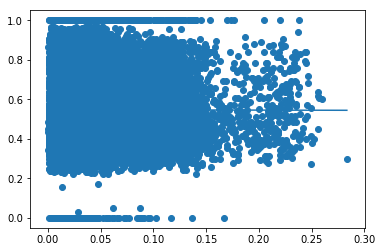

In [61]:
slope, intercept, r_value, p_value, std_err = linregress(total_probs,  beam_bleu_scores)
X = np.linspace(np.min(total_probs), np.max(total_probs), 100)
Y = X * slope + intercept
print(slope, intercept)
print(r_value, p_value)
plt.figure()
plt.plot(X, Y)
plt.scatter(total_probs, beam_bleu_scores)

-0.04385719327793785 0.4995475269930029
-0.009156538637800235 0.06536291183705517


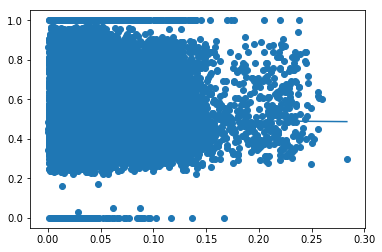

In [62]:
slope, intercept, r_value, p_value, std_err = linregress(total_probs, voted_bleu_scores)
X = np.linspace(np.min(total_probs), np.max(total_probs), 100)
Y = X * slope + intercept
print(slope, intercept)
print(r_value, p_value)
plt.figure()
plt.plot(X, Y)
plt.scatter(total_probs, beam_bleu_scores)